# Deep Q-Learning Applied to Algorithmic Trading

<a href="https://www.kaggle.com/code/addarm/deep-q-rl-with-algorithmic-trading-policy" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


<a href="https://colab.research.google.com/drive/1FTj65b2DA8oFgvmmjLc0XIwtII32PwcM?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


!["Pavlov's trader dog, DALEE 2024"](https://github.com/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading/blob/main/images/rl_banner.PNG?raw=true)

In the book *"A Random Walk Down Wall Street"*, the author Burton G. Malkiel claimed that: “a blindfolded monkey throwing darts at a newspaper's financial pages could select a portfolio that would do just as well as one carefully selected by experts.”.

What if instead of monkey, it was Pavlov's dog trained with reinforcement learning to select the optimal portfolio strategy? In this article, Reinforcement Learning (RL) is the one used in machine learning, where an agent learns actions in an environment that maximizes their value. The agent learns from the outcomes of its actions, without being explicitly programmed with task-specific rules,

The goal of any RL algo, is to find value-maximizing policy (*π*):
$$
\pi* = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}
$$
Where *γ (0 ≤ γ ≤ 1)* is the discounting factor to control the agent's rewards, *t* is a timestep and *R* is the returns in that step. The policy in RL is the probability of taking **action *a*** in **state *s***.

The algo we will adopt is **Q-Learning**, a model-free RL algorithm, that aims to indirectly learn the policy through the **VALUE** of an action for a discrete state its in, rather the policy itself. It's useful in our case, as it doesn't need to model the environment - in our case, the random capital markets.

Estimating the **Q-Value** is done through the Bellman's equation:

$$
Q^*(s, a) = \mathbb{E}[R_{t+1} + \gamma \max_{a'} Q^*(s', a') \mid s, a]
$$

These Q-values are placed in the Q-Tables and used by the agent as look-up, to find all possible actions' Q-values from the current state, and choose the action with the highest Q-value (exploitation). This is good within a finite space, but not in a stochastic environment with limitless combinations, a problem which we will solve with our neural-network.

This agent designed in this article has been inspired by the paper of *Théate, Thibaut and Ernst, Damien (2021)*.

```BibTeX
@article{theate2021application,
  title={An application of deep reinforcement learning to algorithmic trading},
  author={Th{\'e}ate, Thibaut and Ernst, Damien},
  journal={Expert Systems with Applications},
  volume={173},
  pages={114632},
  year={2021},
  publisher={Elsevier}
}
```

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' # KERAS 2 only for tfagents

import warnings
warnings.filterwarnings("ignore")

try:
  import google.colab
  from google.colab import files
  from google.colab import drive

  %pip install scikit-learn
  %pip install matplotlib
  %pip install tf-agents[reverb]
  %pip install shutil
  %pip install yfinance
  %pip install pyarrow
  %pip install pandas_ta
  %pip install tqdm

  IN_COLAB = True
  GDRIVE = '/content/drive'
  drive.mount(GDRIVE)
  print("Mounted on COLLAB")
except:
  GDRIVE = None
  IN_COLAB = False
  files = None

In [2]:
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print('Running in Kaggle...')

    %pip install scikit-learn
    %pip install matplotlib
    %pip install tf-agents[reverb]
    %pip install shutil
    %pip install yfinance
    %pip install pyarrow
    %pip install pandas_ta
    %pip install tqdm

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    DATA_DIR = "/kaggle/input/DATASET"
    IN_KAGGLE = True
else:
    IN_KAGGLE = False
    DATA_DIR = "./data/"

Running in Kaggle...



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.4 MB ? eta -:--:--

     ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/1.4 MB 7.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.4 MB/s eta 0:00:00


     ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/13.7 MB 113.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━ 7.3/13.7 MB 116.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 9.6/13.7 MB 93.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 13.7/13.7 MB 98.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 13.7/13.7 MB 98.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 46.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 43.1 MB/s eta 0:00:00


  Installing build dependencies ... -

 \

 |

 /

 done


  Getting requirements to build wheel ... -

 done


  Preparing metadata (pyproject.toml) ... -

 done


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 6.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━ 5.7/6.4 MB 170.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 72.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.9 MB/s eta 0:00:00


 \

 done
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697631 sha256=92c4351b0c4c3acde2bab1c617908140b4517c89c06ea3c74d3c737be7488f5d
  Stored in directory: /root/.cache/pip/wheels/3d/6f/b4/3991d4fae11d0ecb0754c11cc1b4e7745012850da4efaaf0b1
Successfully built gym


  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:


      Successfully uninstalled typing_extensions-4.9.0


  Attempting uninstall: keras
    Found existing installation: keras 3.0.5


    Uninstalling keras-3.0.5:


      Successfully uninstalled keras-3.0.5


  Attempting uninstall: gym
    Found existing installation: gym 0.26.2


    Uninstalling gym-0.26.2:


      Successfully uninstalled gym-0.26.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.8.1 requires keras-core, which is not installed.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 2.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 6.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.0 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.7 MB/s eta 0:00:00


  Installing build dependencies ... -

 \

 |

 done


  Getting requirements to build wheel ... -

 done


  Preparing metadata (pyproject.toml) ... -

 done


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/8.0 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 7.7/8.0 MB 112.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 8.0/8.0 MB 111.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 54.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/116.7 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 14.8 MB/s eta 0:00:00


 \

 |

 /

 done
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=849903 sha256=3bd9bc7dd3d90754cbbb8753e7bc4d52918580367323dd32f2d2fd1dbcb01414
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/38.3 MB 7.4 MB/s eta 0:00:06

     ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/38.3 MB 31.3 MB/s eta 0:00:02

     ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/38.3 MB 71.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 16.9/38.3 MB 137.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 20.3/38.3 MB 119.6 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 29.5/38.3 MB 124.6 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━ 35.5/38.3 MB 157.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 127.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 127.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 127.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 127.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 127.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 127.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 127.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 23.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/115.1 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.6 MB/s eta 0:00:00


  Preparing metadata (setup.py) ... -

 done


 \

 |

 done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=aca3ea24b1ad901bff4863f62cc86289c5dda6a9e2d775c2ad699a476b1540e7
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import math
import shutil
import yfinance as yf
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime

from scipy.stats import skew, kurtosis

import tensorflow as tf
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import py_environment, tf_py_environment, utils
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy, policy_saver, random_tf_policy

import reverb
from tf_agents.replay_buffers import reverb_replay_buffer, reverb_utils

from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# In case CPU > GPU
# tf.config.set_visible_devices([], 'GPU')

resolver = None

if ('COLAB_TPU_ADDR' in os.environ and IN_COLAB) or (IN_KAGGLE and 'TPU_NAME' in os.environ):
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'] if 'IN_COLAB' in globals() else os.environ['TPU_NAME'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    print("Running on TPU:", resolver.master())
elif tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print("Number of accelerators:", strategy.num_replicas_in_sync)

os.getcwd()

Running on CPU
Number of accelerators: 1


'/kaggle/working'

In [4]:
START_DATE = "2017-01-01"
SPLIT_DATE = '2018-1-1' # Turning point from train to tst
END_DATE = "2019-12-31" # pd.Timestamp(datetime.now() - BDay(1)).strftime('%Y-%m-%d')
DATA_DIR = "./data"
INDEX = "Date"
TARGET = 'TSLA'
TICKER_SYMBOLS = [TARGET]
INTERVAL = "1d"

MODELS_PATH = './models'
LOGS_PATH = './logs'

ACT_NEUTRAL = 3 # Added this action to go to neutral and wait
ACT_LONG = 2
ACT_HOLD = 1
ACT_SHORT = 0
ACTIONS = [ACT_SHORT, ACT_HOLD, ACT_LONG]

CAPITAL = 100000
TRADE_COSTS_PERCENT = 10 / 100 / 100 # 10BPS

FEATURES = ["Close", "High", "Low", "Open", "Volume"]
TARGET_FEATURE = "Price Raw"
STATE_LEN = 30
OBS_SPACE = (STATE_LEN)*len(FEATURES)
ACT_SPACE = len(ACTIONS)

BATCH_SIZE = 32
LEARN_RATE = 1e-3
TOTAL_ITERS = 12000
TRAIN_EPISODES = 10
INIT_COLLECT = 100
TOTAL_COLLECT = 1
LOG_INTERVALS = 20
TEST_INTERVALS = 400
MEMORY_LENGTH = 100000
DISCOUNT = 0.4
EPSILON_START = 1.
TARGET_UPDATE = 1000
EPSILON_END = 0.01
EPSILON_DECAY = 10000
GRAD_CLIP = 1
REWARD_CLIP = 1

DROPOUT = 0.2
L2FACTOR = 0.000001
NEURONS = 512
LAYERS = (NEURONS, NEURONS, NEURONS, NEURONS, NEURONS)

# Financial Data

We download some financial data, this is now the standard in our articles.

In [5]:
def get_tickerdata(tickers_symbols, start=START_DATE, end=END_DATE, interval=INTERVAL, datadir=DATA_DIR):
    tickers = {}
    earliest_end= datetime.strptime(end,'%Y-%m-%d')
    latest_start = datetime.strptime(start,'%Y-%m-%d')
    os.makedirs(DATA_DIR, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start}-{end}-{interval}.csv"

        try:
            if os.path.exists(cached_file_path):
                df = pd.read_parquet(cached_file_path)
                df.index = pd.to_datetime(df.index)
                assert len(df) > 0
            else:
                df = yf.download(
                    symbol,
                    start=START_DATE,
                    end=END_DATE,
                    progress=False,
                    interval=INTERVAL,
                )
                assert len(df) > 0
                df.to_parquet(cached_file_path, index=True, compression="snappy")
            min_date = df.index.min()
            max_date = df.index.max()
            nan_count = df["Close"].isnull().sum()
            skewness = round(skew(df["Close"].dropna()), 2)
            kurt = round(kurtosis(df["Close"].dropna()), 2)
            outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
            print(
                f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
            )
            tickers[symbol] = df

            if min_date > latest_start:
                latest_start = min_date
            if max_date < earliest_end:
                earliest_end = max_date
        except Exception as e:
            print(f"Error with {symbol}: {e}")

    return tickers, latest_start, earliest_end

tickers, latest_start, earliest_end = get_tickerdata(TICKER_SYMBOLS)
tickers[TARGET]

TSLA => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.56, skewness:-0.28, outliers_count:0,  nan_count: 0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500
2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500
2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500
2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500
2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500
...,...,...,...,...,...,...
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500


# The Problem Definition

With Q-Training, we shall teach a pavlovian-agent to trade. Our objective is to make sequential interaction that lead to the highest sharpe ratio, formalized by this policy (remember Q-Learning is off-policy, and we won't learn this directly):

$$
\pi^*(a_t | s_t) = \arg\max_{a \in \mathcal{A}} \mathbb{E} \left[ \sum_{t=0}^{\infty} \gamma^t r_t \middle| s_t = f(o_1, a_1, r_1, \ldots, o_t), a_t \right]
$$

At each timestep *t*:

1. Observe the environments state *st* and map history with *f(.)*
2. Observations *ot* from history *ht*, have previous actions *a_t-1*, previous observations *o_t-1* and their returns *r_t-1*. For our experiment, we'll encode these into features for a network.
3. Execute action *a_t*, which can be: hold, long, short
4. Get returns *r_t* discounted at *γt*. *γ* is the discounting factor to prevent the agent from doing only tactical choices for returns in the present (missing better future returns).


The *π(at|ht)* creates an action on a Quantity Q *at = Qt*. Where a positive *Q* is the long, the negative *Q* signals a short and when its 0 no action is taken. For this article we will use the definition of policy *π(at|ht)* and Q-Value *Q(at,st)* interchangeably, as Q will define quantities bought.

## Observations and State Space

The paper uses only High, Low, Open, Close and Volume as observations from the agent's environment state.

We will augment this space with 2 technical indicators and 2 macroeconomic indicators:
- 20day slow and 7 day fast exponential moving average, from our article: "Momentum and Reversion Trading Signals Analysis"
- The daily VIX as proxy for market volatility & fear, and the 2 year T-note as proxy for inflation & rates, from our article: "Temporal Convolutional Neural Network with Conditioning for Broad Market Signals"

$$
o_t = s_t \in \{{\text{High}_t}, {\text{Low}_t}, {\text{Open}_t}, {\text{Close}_t}, {\text{Volume}_t}, {\text{FastEMA}_t}, {\text{SlowEMA}_t}, {\text{VIX}_t}, {\text{T2YR}_t}\}
$$

## Actions and Rewards

A core concept in RL is rewards engineering. Let's look at our action space *A* at time *t*:

$$
a_t = Q_t \in \{Q_{\text{Long}, t}, Q_{\text{Short}, t}\}
$$

The action *Q_Long,t* is set to maximize returns on a buy, given our liquidity *vc_t* (the value *v* of our portfolio with cash remainng *c*) and purchasing *Q_long* at price *p* shares (transaction costs *C*) if we are not already long:

$$
Q_{\text{Long}, t} =
\begin{cases}
\left\lfloor \frac{v_{c,t}}{p_t (1 + C)}\right\rfloor & \text{if } a_{t-1} \neq Q_{\text{Long}, t-1}, \\
0 & \text{otherwise}.
\end{cases}
$$

The action *Q_Short,t* aims to convert a **negative** number of shares to returns (shorting is the borrowing of shares, therefore our *v_c* will be initially negative).

$$
\hat{Q}_{\text{Short}, t} =
\begin{cases}
-2n_t - \left\lfloor \frac{v_{c,t}}{p_t (1 + C)}\right\rfloor & \text{if } a_{t-1} \neq Q_{\text{Short}, t-1}, \\
0 & \text{otherwise}.
\end{cases}
$$

Note the *-2n* is an indication to sell twice, meaning not only close the long position but open a short position for the *Qn* shares, since shorting is a negative trajectory, we need to negate the amount we can buy to get the correct representation in our holdings. If we had no shares to start, then *-2(0)* will not have an effect save for the short amount:

$$
\hat{Q}_{\text{Short}, t} = -\left\lfloor \frac{v_{c,t}}{p_t (1 + C)} \right\rfloor
$$

Shorts are risky, and we need to give boundaries to the agent, as a short can incur infinite loss:

$$
Q_{\text{Short}, t} = \max\{\hat{Q}_{\text{Short}, t}, Q_t\}
$$

Given that our portfolio cannot fall into negative amounts, we need to model constraints.
1. Cash value *vc_t* needs to be large enough to return to neutral *n_t=0*.
2. To return to 0, we need to adjust for costs *C* which are caused by market volatility epsiloc *ϵ* (think slippages, spreads, etc..).
3. We redefine the action space permissable to ensure we can always return to neutral.

$$
v_{c,t+1} \geq -n_{t+1} p_t (1 + \varepsilon)(1 + C)
$$

The action space *A* is redefined as a set of acceptable values for *Q_t* between boundaries *Q-* and *Q+*:

$$
A = \left\{ Q_t \in \mathbb{Z} \cap \left[Q_t^-, Q_t^+\right] \right\}
$$

Where the top boundary *Q+* is:
$$
Q_t^+ = \frac{v_{c,t}}{p_t (1+C)}
$$

And the lower boundary *Q-* is (for both coming out of a long where delta *t* is positive, or reversing a short and incurring twice the costs with delta *t* in the negative):

$$
Q_t^- = \begin{cases}
    \frac{\Delta t}{p_t \varepsilon (1 + C)} & \text{if } \Delta t \geq 0, \\
    \frac{\Delta t}{p_t (2C + \varepsilon(1 + C))} & \text{if } \Delta t < 0,
    \end{cases}
$$

with *delta t* being the in change of portfolio value in time:

$$
 t_Δ = -v_{c,t} - n_t p_t (1 + \varepsilon)(1 + C)
$$

In the above boundaries, the cost of trading is defined as:

$$
v_{c,t+1} = v_{c,t} - Q_t p_t - C |Q_t| p_t
$$

Where *C* is the percentage cost of the transaction given the absolute quantity *|Q_t|* of shares and their price *p_t*.

## Agent's Objective

In the paper, they utilize the percentage returns as a rewards signal, clipped between -1 and 1, and adjusted by a discount factor γ:
$$
\text{Signal} = \left( \frac{vc_{t} - vc_{t-1}}{vc_{t-1}} \right) \gamma^t
$$

In the article, we will use an annualized Sharpe (from *N* time window, up to 252 trading days), and teach the agent's to generate an optimal ratio, clipped no discount factor:

$$
\text{Signal} = \frac{E\left[\sum_{t=0}^{T} r_t - R_f\times \right]\sqrt{N} }{\sqrt{\mathrm{Var}\left[\sum_{t=0}^{T} r_t\right]}}
$$

which is just the maximization of:

$$
\text{sharpe}= \left( \frac{\bar{R} - R_f}{\sigma} \right)
$$

or the returns of the portfolio (*R* average), minus the risk free rate (*Rf*, at the time of writing, 5%) divided by the volatility (*σ*) of the portfolio

# Trading Environment

Using TensorFlow's PyEnvironment, we will give the agent the environment that implements the above rules:

In [6]:
class TradingEnv(py_environment.PyEnvironment):
    """
    A custom trading environment for reinforcement learning, compatible with tf_agents.

    This environment simulates a simple trading scenario where an agent can take one of three actions:
    - Long (buy), Short (sell), or Hold a financial instrument, aiming to maximize profit through trading decisions.

    Parameters:
    - data: DataFrame containing the stock market data.
    - data_dim: Dimension of the data to be used for each observation.
    - money: Initial capital to start trading.
    - state_length: Number of past observations to consider for the state.
    - transaction_cost: Costs associated with trading actions.
    """

    def __init__(self, data, features = FEATURES, money=CAPITAL, state_length=STATE_LEN, transaction_cost=0, market_costs=TRADE_COSTS_PERCENT, reward_discount=DISCOUNT):
        super(TradingEnv, self).__init__()

        assert data is not None

        self.features = features
        self.data_dim = len(self.features)
        self.state_length = state_length
        self.current_step = self.state_length
        self.reward_discount = reward_discount

        self.balance = money
        self.initial_balance = money
        self.transaction_cost = transaction_cost
        self.epsilon = max(market_costs, np.finfo(float).eps) # there is always volatility costs
        self.total_shares = 0

        self._episode_ended = False
        self._batch_size = 1
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=ACT_SHORT, maximum=ACT_LONG, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.state_length * self.data_dim, ), dtype=np.float32, name='observation')

        self.data = self.preprocess_data(data.copy())

        self.reset()

    @property
    def batched(self):
        return False #True

    @property
    def batch_size(self):
        return None #self._batch_size

    @batch_size.setter
    def batch_size(self, size):
        self._batch_size = size

    def preprocess_data(self, df):
        def _log_rets(df):
            log_returns = np.log(df / df.shift(1))
            df = (log_returns - log_returns.mean()) / log_returns.std()
            df = df.dropna()
            return df

        def min_max_scale_tensor(tensor):
            min_val = tf.reduce_min(tensor)
            max_val = tf.reduce_max(tensor)
            return (tensor - min_val) / (max_val - min_val)

        price_raw = df['Close'].copy()
        for col in self.features:
            tensor = tf.convert_to_tensor(df[col], dtype=tf.float32)
            normalized_tensor = min_max_scale_tensor(tensor)
            df[col] = normalized_tensor.numpy()

        df = df.replace(0.0, np.nan)
        df = df.interpolate(method='linear', limit=5, limit_area='inside')
        df = df.ffill().bfill()

        df[TARGET_FEATURE] = price_raw
        df['Sharpe'] = 0
        df['Position'] = 0
        df['Action'] = ACT_HOLD
        df['Holdings'] = 0.
        df['Cash'] = float(self.balance)
        df['Money'] = df['Holdings'] + df['Cash']
        df['Returns'] = 0.

        assert not df.isna().any().any()

        return df

    def action_spec(self):
        """Provides the specification of the action space."""
        return self._action_spec

    def observation_spec(self):
        """Provides the specification of the observation space."""
        return self._observation_spec

    def _reset(self):
        """Resets the environment state and prepares for a new episode."""
        self.balance = self.initial_balance
        self.current_step = self.state_length
        self._episode_ended = False
        self.total_shares = 0

        self.data['Sharpe'] = 0
        self.data['Position'] = 0
        self.data['Action'] = ACT_HOLD
        self.data['Holdings'] = 0.
        self.data['Cash']  = float(self.balance)
        self.data['Money'] = self.data.iloc[0]['Holdings'] + self.data.iloc[0]['Cash']
        self.data['Returns'] = 0.

        initial_observation = self._next_observation()
        return ts.restart(initial_observation)

    def _next_observation(self):
        """Generates the next observation based on the current step and history length."""
        start_idx = max(0, self.current_step - self.state_length + 1)
        end_idx = self.current_step + 1
        obs = self.data[self.features].iloc[start_idx:end_idx]

        # flatten because: https://stackoverflow.com/questions/67921084/dqn-agent-issue-with-custom-environment
        obs_values = obs.values.flatten().astype(np.float32)
        return obs_values

    def _step(self, action):
        """Executes a trading action and updates the environment's state."""
        if self._episode_ended:
            return self.reset()

        self.current_step += 1
        current_price = self.data.iloc[self.current_step][TARGET_FEATURE]

        assert not self.data.iloc[self.current_step].isna().any().any()

        if action == ACT_LONG:
            self._process_long_position(current_price)
        elif action == ACT_SHORT:
            prev_current_price = self.data.iloc[self.current_step - 1][TARGET_FEATURE]
            self._process_short_position(current_price, prev_current_price)
        elif action == ACT_HOLD:
            self._process_hold_position()
        elif action == ACT_NEUTRAL:
            self._process_neutral_position(current_price)
        else:
          raise Exception(f"Invalid Actions: {action}")

        self._update_financials()
        done = self.current_step >= len(self.data) - 1
        reward = self._calculate_reward_signal()
        if done:
            self._episode_ended = True
            return ts.termination(self._next_observation(), reward)
        else:
            return ts.transition(self._next_observation(), reward, discount=self.reward_discount)

    def _get_lower_bound(self, cash, total_shares, price):
        """
        Compute the lower bound of the action space, particularly for short selling,
        based on current cash, the number of shares, and the current price.
        """
        delta = -cash - total_shares * price * (1 + self.epsilon) * (1 + self.transaction_cost)

        if delta < 0:
            lowerBound = delta / (price * (2 * self.transaction_cost + self.epsilon * (1 + self.transaction_cost)))
        else:
            lowerBound = delta / (price * self.epsilon * (1 + self.transaction_cost))

        if np.isinf(lowerBound):
            assert False
        return lowerBound

    def _process_hold_position(self):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]["Cash"]
        self.data.at[step_idx, "Holdings"] = self.data.iloc[self.current_step - 1]["Holdings"]
        self.data.at[step_idx, "Position"] = self.data.iloc[self.current_step - 1]["Position"]
        self.data.at[step_idx, "Action"] = ACT_HOLD

    def _process_neutral_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
        self.data.at[step_idx, "Holdings"] = 0.0
        self.data.at[step_idx, "Position"] = 0.0
        self.data.at[step_idx, "Action"] = ACT_NEUTRAL

    def _process_long_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = 1
        if self.data.iloc[self.current_step - 1]['Position'] == 1:
            # more long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash']
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new long
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
            self.data.at[step_idx, 'Action'] = 1
        else:
            # short to long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
            self.data.at[step_idx, 'Action'] = 1

    def _process_short_position(self, current_price, prev_price):
        """
        Adjusts the logic for processing short positions to include lower bound calculations.
        """
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = -1
        if self.data.iloc[self.current_step - 1]['Position'] == -1:
            # Short more
            low = self._get_lower_bound(self.data.iloc[self.current_step - 1]['Cash'], -self.total_shares, prev_price)
            if low <= 0:
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"]
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
            else:
                total_sharesToBuy = min(math.floor(low), self.total_shares)
                self.total_shares -= total_sharesToBuy
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] - total_sharesToBuy * current_price * (1 + self.transaction_cost)
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new short
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
            self.data.at[step_idx, 'Action'] = -1
        else:
            # long to short
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
            self.data.at[step_idx, 'Action'] = -1

    def _update_financials(self):
        """Updates the financial metrics including cash, money, and returns."""
        step_idx = self.data.index[self.current_step]
        self.balance = self.data.iloc[self.current_step]['Cash']

        self.data.at[step_idx,'Money'] = self.data.iloc[self.current_step]['Holdings'] + self.data.iloc[self.current_step]['Cash']
        self.data.at[step_idx,'Returns'] = ((self.data.iloc[self.current_step]['Money'] - self.data.iloc[self.current_step - 1]['Money'])) / self.data.iloc[self.current_step - 1]['Money']

    def _calculate_reward_signal(self, reward_clip=REWARD_CLIP):
        """
        Calculates the reward for the current step. In the paper they use the %returns.
        """
        return np.clip(self.data.iloc[self.current_step]['Returns'], -reward_clip, reward_clip)

    def _calculate_sharpe_reward_signal(self, risk_free_rate=0.05, periods_per_year=252, reward_clip=REWARD_CLIP):
        """
        Calculates the annualized Sharpe ratio up to the CURRENT STEP.

        Parameters:
        - risk_free_rate (float): The annual risk-free rate. It will be adjusted to match the period of the returns.
        - periods_per_year (int): Number of periods in a year (e.g., 252 for daily, 12 for monthly).

        Returns:
        - float: The annualized Sharpe ratio as reward.
        """
        period_risk_free_rate = (1 + risk_free_rate) ** (1 / periods_per_year) - 1
        observed_returns = self.data['Returns'].iloc[:self.current_step + 1]

        excess_returns = observed_returns - period_risk_free_rate

        mean_excess_return = np.mean(excess_returns)
        std_dev_returns = np.std(observed_returns)

        sharpe_ratio = mean_excess_return / std_dev_returns if std_dev_returns > 0 else 0
        annual_sr = sharpe_ratio * np.sqrt(periods_per_year)

        self.data.at[self.data.index[self.current_step], 'Sharpe'] = annual_sr

        return np.clip(annual_sr, -reward_clip, reward_clip)

    def calculate_churn(self):
        churn = 0
        prev_position = 0
        for i in range(1, self.current_step + 1):
            current_position = self.data.at[self.data.index[i], 'Position']
            action = self.data.at[self.data.index[i], 'Action']
            if action in [ACT_LONG, ACT_SHORT] and current_position != prev_position:
                churn += self.transaction_cost

            prev_position = current_position

        if self.current_step > 0:
            churn /= self.current_step

        return churn

    def calculate_drawdown_metrics(self):
        cumulative_returns = (1 + self.data['Returns'].iloc[:self.current_step + 1]).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak

        peak_dates = cumulative_returns[peak == cumulative_returns]
        drawdown_durations = pd.Series(index=drawdown.index, dtype='timedelta64[ns]')
        for date in drawdown.index:
            recent_peak_date = peak_dates[peak_dates.index <= date].index[-1]
            duration = date - recent_peak_date
            drawdown_durations.at[date] = duration

        drawdown_durations_days = drawdown_durations.dt.days
        max_dd_duration_days = drawdown_durations_days.max()

        return drawdown, max_dd_duration_days

    def get_trade_stats(self, riskfree_rate=0.05):
        rets = self.data['Returns'].iloc[:self.current_step + 1]

        monthly_riskfree_rate = (1 + riskfree_rate)**(1/12) - 1

        annualized_return = rets.mean() * 12
        annualized_vol = rets.std() * np.sqrt(12)
        sharpe_ratio = (rets.mean() - monthly_riskfree_rate) / rets.std() * np.sqrt(12)

        downside_deviation = rets[rets < 0].std() * np.sqrt(12)
        drawdowns, max_dd_duration_days = self.calculate_drawdown_metrics()

        sortino_ratio = (rets.mean() - monthly_riskfree_rate) / downside_deviation

        churn = self.calculate_churn()

        return {
            "Annualized Return": annualized_return,
            "Annualized Vol": annualized_vol,
            "Sharpe Ratio": sharpe_ratio,
            "Downside Deviation": downside_deviation,
            "Sortino Ratio": sortino_ratio,
            "Max Drawdown": drawdowns.max(),
            "Max Drawdown Days": max_dd_duration_days,
            "Trade Churn": churn,
            "Skewness": skew(rets.values),
            "Kurtosis": kurtosis(rets.values)
        }

    def render(self, mode='human'):
        print(f'Step: {self.current_step}, Balance: {self.balance}, Holdings: {self.total_shares}')
        print(f"trade stats: {self.get_trade_stats()}")

In [7]:
stock= tickers[TARGET]
train_data = stock[stock.index < pd.to_datetime(SPLIT_DATE)].copy()
test_data = stock[stock.index >= pd.to_datetime(SPLIT_DATE)].copy()

train_env = TradingEnv(train_data)
utils.validate_py_environment(train_env, episodes=TRAIN_EPISODES)
test_env = TradingEnv(test_data)
utils.validate_py_environment(train_env, episodes=TRAIN_EPISODES//4)

print(f"TimeStep Specs: {train_env.time_step_spec()}")
print(f"Action Specs: {train_env.action_spec()}")
print(f"Reward Specs: {train_env.time_step_spec().reward}")

2024-03-15 00:28:41.133926: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 00:28:41.134037: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 00:28:41.134122: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 00:28:41.134198: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 00:28:41.134274: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 00:28:41.134488: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 00:28:41.134578: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

TimeStep Specs: TimeStep(
{'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(150,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)})
Action Specs: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=2)
Reward Specs: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [8]:
def execute_action_and_print_state(env, action):
    next_time_step = env.step(np.array(action, dtype=np.int32))
    print(f'Action taken: {action} at step: {env.current_step}')
    # print(f'New state: {next_time_step.observation}')
    print(f'New balance: {env.balance}')
    print(f'Total shares: {env.total_shares}')
    print(f'Reward: {next_time_step.reward}\n')

time_step = train_env.reset()
# print(f'Initial state: {time_step.observation}')

# Some dryruns to validate our env logic: Buy, Sell, we should have a positive balance with TSLA
execute_action_and_print_state(train_env, ACT_HOLD)
execute_action_and_print_state(train_env, ACT_LONG)
execute_action_and_print_state(train_env, ACT_SHORT)
execute_action_and_print_state(train_env, ACT_HOLD)
execute_action_and_print_state(train_env, ACT_LONG)

Action taken: 1 at step: 31
New balance: 100000.0
Total shares: 0
Reward: 0.0

Action taken: 2 at step: 32
New balance: 0.848236083984375
Total shares: 5510
Reward: 0.0

Action taken: 0 at step: 33
New balance: 203790.03025054932
Total shares: 5510
Reward: 0.01895439252257347

Action taken: 1 at step: 34
New balance: 203790.03025054932
Total shares: 5510
Reward: 0.0

Action taken: 2 at step: 35
New balance: 4.924432754516602
Total shares: 6431
Reward: 0.07714703679084778



# Deep Q-Network Architecure

## Architecture

Deep Q-neural-network architecture (DQN) approximates the the Q-tables algorithm as its approximating the action-value function π∗(at|st). Its an approximation because the number of combinations you can have with your Q-Tables is gargantuan and impossible to process.

The Q-network is also referred to as the policy model. We will also leverage a target Q-network in our architecture. Tha Target model is updated more seldomly than the Q-Network, and helps stabilize the training process as the Q-Network is trained to reduced its output and the target network (a more stable value).

Finally, we will add a Replay Memory to sample data for our models. The memory is a circular memory of fixed size (therefore it 'forgets' old memories), and at every fixed frequency the models use the memory to calculate the loss between their predicted Q values and the ones performed in the memory.

## The Reinforce Learning Flow

A picture says a thousand words; the flow chart below will guide us on the whole training and updating the target model:

!["Flowchart of training"](https://raw.githubusercontent.com/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading/main/images/Q-net.png)

First we initinialize the environment *St* and the action state *Qt*.

We then run multiple episodes of n iterations to train the model and remember the state, actions and the Q value predicted. On each iteration, these events will occur:
1. Fetch the state.
1. Take either a random action (ε greedy) or predict a Q value given an action in the current state, the former is called exploration, and the latter exploitation. The ε decays with time, as the model learns, it should explore less.
1. When predicting the Q value, it will use the policy model. Regardles of exploring or explointing, it saves the memory of the states, actions and the given Q value.
1. Calculate the target Q-Value by taking the max predictions from the target-network. From the previous formula *rt + γt * Qtarget(s_t+1, a_t+1)* where gamma *γ* is the discounting factor.
1. Re-traing the policy model to minimize the Q-values from the different models. Training uses sampled states from our replay memory.
1. At the end of the episode, or any interval of our chosing, we copy the wieghts of the policy model to the target model.

In [9]:
def create_q_network(env, fc_layer_params=LAYERS, dropout_rate=DROPOUT, l2_reg=L2FACTOR):
    """
    Creates a Q-Network with dropout and batch normalization.
    Parameters:
    - env: The environment instance.
    - fc_layer_params: Tuple of integers representing the number of units in each dense layer.
    - dropout_rate: Dropout rate for dropout layers.
    - l2_reg: L2 regularization factor.

    Returns:
    - q_net: The Q-Network model.
    """
    env = tf_py_environment.TFPyEnvironment(env)
    action_tensor_spec = tensor_spec.from_spec(env.action_spec())
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    layers = []
    for num_units in fc_layer_params:
        layers.append(tf.keras.layers.Dense(
                                num_units,
                                activation=None,
                                kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'),
                                kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        layers.append(tf.keras.layers.BatchNormalization())
        layers.append(tf.keras.layers.LeakyReLU())
        layers.append(tf.keras.layers.Dropout(dropout_rate))

    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_initializer=tf.keras.initializers.GlorotNormal(),
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    q_net = sequential.Sequential(layers + [q_values_layer])

    return q_net

def create_agent(q_net, env, t_q_net = None, optimizer = None, eps=EPSILON_START, learning_rate=LEARN_RATE, gradient_clipping = GRAD_CLIP):
    """
    Creates a DQN agent for a given environment with specified configurations.

    Parameters:
    - q_net (tf_agents.networks.Network): The primary Q-network for the agent.
    - env (tf_agents.environments.PyEnvironment or tf_agents.environments.TFPyEnvironment):
      The environment the agent will interact with. A TFPyEnvironment wrapper is applied
      if not already wrapped.
    - t_q_net (tf_agents.networks.Network, optional): The target Q-network for the agent.
      If None, no target network is used.
    - optimizer (tf.keras.optimizers.Optimizer, optional): The optimizer to use for training the agent.
      If None, an Adam optimizer with exponential decay learning rate is used.
    - eps (float): The epsilon value for epsilon-greedy exploration.
    - learning_rate (float): The initial learning rate for the exponential decay learning rate schedule.
      Ignored if an optimizer is provided.
    - gradient_clipping (float): The value for gradient clipping. If 1., no clipping is applied.

    Returns:
    - agent (tf_agents.agents.DqnAgent): The initialized and configured DQN agent.
    """
    if optimizer is None:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    env = tf_py_environment.TFPyEnvironment(env)
    # see: https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/DqnAgent
    agent = dqn_agent.DqnAgent(
        env.time_step_spec(),
        env.action_spec(),
        q_network=q_net,
        target_q_network = t_q_net,
        target_update_period = TARGET_UPDATE,
        optimizer=optimizer,
        epsilon_greedy = eps,
        reward_scale_factor = 1,
        gradient_clipping = gradient_clipping,
        td_errors_loss_fn=common.element_wise_huber_loss,
        train_step_counter=tf.compat.v1.train.get_or_create_global_step(),
        name="TradeAgent")

    agent.initialize()
    print(agent.policy)
    print(agent.collect_policy)
    return agent

with strategy.scope():
  q_net = create_q_network(train_env)
  t_q_net = create_q_network(train_env)
  agent = create_agent(q_net, train_env, t_q_net=t_q_net)

# Trading Operations

Using TensorFlow agents' framework, training our pavlovian trader should be easier than building the architecture ourselves.

The trading simulator class will prepare all the variables required. In this case it will initialize the reply memory using DeepMind's Reverb, and create a collector policy for the agent. Unlike the evaluation policy (*π(at|ht)*) which is use to predict the target Q value, the collector will explore and collect data with actions and their resulting value for the memory, memories are saved as trajectories (*τ*) in tensorflow which is a collection of the current observed state (*ot*), the action taken (*at*), the reward received (*r_t+1*) and the following observed state (*o_t+1*) formalized as *r=(o_t-1, a_t-1, rt, ot, dt)*, where dt is a flag for the end state if this was the last observation.

To give learning opportunity to our agent, we will use a high epsilon to have it explore a lot, and slowly decay it using the formula below:

$$
\epsilon_{\text{decayed}} = \epsilon_{\text{final}} + (\epsilon_{\text{initial}} - \epsilon_{\text{final}}) \times e^{-\frac{\text{step}}{\text{decay\_steps}}}
$$

Where:
- *ϵ_decayed* is the decayed epsilon value at the current step,
- *ϵ_initial* is the initial epsilon value at the start of training, we set it to 1, meaning it only explores at start.
- *ϵ_final* is the end value we want that the agent exploits is environment, preferably when deployed.
- *step* is the current step or iteration in the training process, and decay_steps is a parameter that controls the rate, in our case 1000. As the steps approach the end, the decay will get smaller and smaller.


In [10]:
import tensorflow as tf

class CustomMetrics(tf.Module):
    def __init__(self, name=None):
        super(CustomMetrics, self).__init__(name=name)
        self.total_returns = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))
        self.average_returns = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))
        self.sharpe_ratios = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))
        self.losses = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))

    def update_metrics(self, losses=None, total_return=None, average_return=None, sharpe_ratio=None):
        if total_return is not None:
            self.total_returns.assign(tf.concat([self.total_returns.value(), [total_return]], axis=0))
        if total_return is not None:
            self.average_returns.assign(tf.concat([self.average_returns.value(), [average_return]], axis=0))
        if total_return is not None:
            self.sharpe_ratios.assign(tf.concat([self.sharpe_ratios.value(), [sharpe_ratio]], axis=0))
        if losses is not None:
            self.losses.assign(tf.concat([self.losses.value(), [losses]], axis=0))

class TradingSimulator:
    def __init__(self, env, eval_env, agent, episodes=TRAIN_EPISODES,
                 batch_size=BATCH_SIZE, num_eval_episodes=TEST_INTERVALS,
                 collect_steps_per_iteration=INIT_COLLECT,
                 replay_buffer_max_length=MEMORY_LENGTH ,
                 num_iterations = TOTAL_ITERS, log_interval=LOG_INTERVALS,
                 eval_interval=None, global_step=None):
        self.py_env = env
        self.env =  tf_py_environment.TFPyEnvironment(self.py_env)
        self.py_eval_env = eval_env
        self.eval_env =  tf_py_environment.TFPyEnvironment(self.py_eval_env)
        self.agent = agent
        self.episodes = episodes
        self.log_interval = log_interval
        self.eval_interval = eval_interval
        self.global_step = global_step

        self.batch_size = batch_size
        self.num_eval_episodes = num_eval_episodes
        self.collect_steps_per_iteration = collect_steps_per_iteration
        self.replay_buffer_max_length = replay_buffer_max_length
        self.num_iterations = num_iterations

        self.policy = self.agent.policy
        self.collect_policy = self.agent.collect_policy
        self.random_policy = random_tf_policy.RandomTFPolicy(
            self.env.time_step_spec(),
            self.env.action_spec())

        self.replay_buffer_signature = tensor_spec.from_spec(
            self.agent.collect_data_spec)
        self.replay_buffer_signature = tensor_spec.add_outer_dim(
            self.replay_buffer_signature)

    def init_memory(self, table_name = 'uniform_table'):
        self.table = reverb.Table(
            table_name,
            max_size=self.replay_buffer_max_length,
            sampler=reverb.selectors.Uniform(),
            remover=reverb.selectors.Fifo(),
            rate_limiter=reverb.rate_limiters.MinSize(1),
            signature=self.replay_buffer_signature)

        self.reverb_server = reverb.Server([self.table])
        self.replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
                                    self.agent.collect_data_spec,
                                    table_name=table_name,
                                    sequence_length=2,
                                    local_server=self.reverb_server)

        self.rb_observer = reverb_utils.ReverbAddTrajectoryObserver(self.replay_buffer.py_client, table_name, sequence_length=2)
        self.dataset = self.replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=self.batch_size, num_steps=2).prefetch(3)

        return self.dataset, iter(self.dataset)

    def eval_metrics(self, num_eval_episodes):
        @tf.function
        def _eval_step():
            time_step = self.eval_env.reset()
            episode_returns = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)

            while not time_step.is_last():
                action_step = self.policy.action(time_step)
                time_step = self.eval_env.step(action_step.action)
                rewards = time_step.reward
                episode_returns = episode_returns.write(episode_returns.size(), rewards)

            episode_returns_stacked = episode_returns.stack()
            cumulative_returns = tf.math.cumprod(episode_returns_stacked + 1) - 1
            total_episode_return = cumulative_returns[-1]
            episode_avg_return = tf.reduce_mean(episode_returns_stacked)
            episode_std_dev = tf.math.reduce_std(episode_returns_stacked)
            episode_sharpe_ratio = tf.cond(
                episode_std_dev > 0,
                lambda: episode_avg_return / episode_std_dev,
                lambda: tf.constant(0.0)
            )

            return total_episode_return, episode_avg_return, episode_std_dev, episode_sharpe_ratio

        # Initialize lists to hold the metrics for all episodes
        total_returns_list = []
        episode_avg_returns_list = []
        episode_std_devs_list = []
        episode_sharpe_ratios_list = []

        for i in tqdm(range(0, num_eval_episodes), desc=f"Eval for {num_eval_episodes}"):
            total_episode_return, episode_avg_return, episode_std_dev, episode_sharpe_ratio = _eval_step()
            total_returns_list.append(total_episode_return)
            episode_avg_returns_list.append(episode_avg_return)
            episode_std_devs_list.append(episode_std_dev)
            episode_sharpe_ratios_list.append(episode_sharpe_ratio)

        # Convert lists to tensors for returning
        total_returns = tf.convert_to_tensor(total_returns_list)
        episode_avg_returns = tf.convert_to_tensor(episode_avg_returns_list)
        episode_std_devs = tf.convert_to_tensor(episode_std_devs_list)
        episode_sharpe_ratios = tf.convert_to_tensor(episode_sharpe_ratios_list)

        return total_returns, episode_avg_returns, episode_std_devs, episode_sharpe_ratios

    def train(self, checkpoint_path=MODELS_PATH, initial_epsilon= EPSILON_START, final_epsilon = EPSILON_END, decay_steps=EPSILON_DECAY):
        @tf.function
        def _train_step(experience, agent, metrics, global_step, initial_epsilon, final_epsilon, decay_steps):

            train_loss = agent.train(experience).loss
            metrics.update_metrics(losses=train_loss)

            decayed_epsilon = final_epsilon + (initial_epsilon - final_epsilon) * tf.math.exp(-1. * tf.cast(global_step, tf.float32) / decay_steps)
            agent.collect_policy._epsilon = decayed_epsilon

            return train_loss

        print("Preparing replay memory and dataset")
        _, iterator = self.init_memory()

        self.metrics = CustomMetrics()
        self.global_step = tf.compat.v1.train.get_or_create_global_step()
        checkpoint_dir = os.path.join(checkpoint_path, 'checkpoint')
        train_checkpointer = common.Checkpointer(
            ckpt_dir=checkpoint_dir,
            max_to_keep=1,
            agent=agent,
            metrics=self.metrics,
            policy=agent.policy,
            replay_buffer=self.replay_buffer,
            global_step=self.global_step
        )
        status = train_checkpointer.initialize_or_restore()
        self.global_step = tf.compat.v1.train.get_global_step()
        print(f'Next step restored: {self.global_step.numpy()} status: {status}')
        self.policy = agent.policy
        self.agent.train = common.function(self.agent.train)
        self.agent.train_step_counter.assign(self.global_step )

        time_step = self.py_env.reset()
        collect_driver = py_driver.PyDriver(
            self.py_env,
            py_tf_eager_policy.PyTFEagerPolicy(self.agent.collect_policy, use_tf_function=True),
            [self.rb_observer],
            max_steps=self.collect_steps_per_iteration)

        print(f"Running training starting {self.global_step.numpy()} to {self.num_iterations}")

        for _ in tqdm(range(self.global_step.numpy(), self.num_iterations), desc=f"Training for {self.global_step.numpy() - self.num_iterations}"):
            time_step, _ = collect_driver.run(time_step)
            experience, _ = next(iterator)
            train_loss = _train_step(experience, agent, self.metrics, self.global_step, initial_epsilon= initial_epsilon, final_epsilon = final_epsilon, decay_steps=decay_steps)

            if self.global_step.numpy() % self.log_interval == 0:
                print(f'step = {self.global_step.numpy()}: loss = {train_loss}')
                # Later call: saved_policy = tf.saved_model.load(policy_dir)
                train_checkpointer.save(self.global_step)

            if (self.eval_interval is not None) and (self.global_step.numpy() % self.eval_interval == 0):
                total_returns, episode_avg_returns, episode_std_devs, episode_sharpe_ratios= self.eval_metrics(self.eval_interval // 2)
                tr = np.mean(total_returns)
                av = np.mean(episode_avg_returns)
                sr = np.mean(episode_sharpe_ratios)
                sd = np.mean(episode_std_devs)

                print(f'step = {self.global_step.numpy()}: Average Return = {av}, Total Return = {tr}, Avg Sharpe = {sr} -- Saving {self.global_step} Checkpoint')
                self.metrics.update_metrics(total_return=tr, average_return=av, sharpe_ratio=sr)
                train_checkpointer.save(self.global_step)

        print(f'\nTraining completed. Loss: {np.mean(self.metrics.losses.numpy()):.4f}')

        policy_dir = os.path.join(checkpoint_path, 'policy')
        tf_policy_saver = policy_saver.PolicySaver(agent.policy)
        tf_policy_saver.save(policy_dir)
        self.zip_directories(checkpoint_path)
        print("Policy saved")

        self.rb_observer.close()
        self.reverb_server.stop()

        return self.metrics

    def load_and_eval_policy(self, policy_path=MODELS_PATH, eval_interval=TEST_INTERVALS//4):
        policy_dir = os.path.join(policy_path, 'policy')

        self.policy = tf.saved_model.load(policy_dir)
        total_returns, avg_return, _, sharpe_ratio = self.eval_metrics(eval_interval)
        print(f'Average Return = {np.mean(avg_return)}, Total Return = {np.mean(total_returns)}, Sharpe = {np.mean(sharpe_ratio)}')

        return self.policy, total_returns, avg_return, sharpe_ratio

    def clear_directories(self, directories = MODELS_PATH):
        try:
            if IN_COLAB:
                shutil.rmtree(f"{GDRIVE}/MyDrive/{directories}")
                print(f"Successfully cleared {GDRIVE}/MyDrive/{directories}")
            shutil.rmtree(directories)
            print(f"Successfully cleared {directories}")
        except Exception as e:
            print(f"Error clearing {directories}: {e}")


    def zip_directories(self, directories = MODELS_PATH, output_filename=f'{MODELS_PATH}/model_files'):
        """
        Creates a zip archive containing the specified directories.

        Parameters:
        - directories: List of paths to directories to include in the archive.
        - output_filename: The base name of the file to create, including the path,
                        minus any format-specific extension. Default is 'training_backup'.
        """
        if IN_COLAB:
            archive_path = shutil.make_archive(f'{GDRIVE}/MyDrive/{directories}', 'zip', root_dir='.', base_dir=directories)
            print(f"Archived {GDRIVE}/MyDrive/{directories}")
        else:
            archive_path = shutil.make_archive(output_filename, 'zip', root_dir='.', base_dir=directories)
            print(f"Archived {directories} into {archive_path}")


    def plot_performance(self, metrics):
        """
        Plot the training performance including average returns and Sharpe Ratios on the same plot,
        with returns on the left y-axis and Sharpe Ratios on the right y-axis.
        """
        fig, axs = plt.subplots(1, 2, figsize=(18, 4))

        axs[0].set_xlabel('Iterations')
        axs[0].set_ylabel('Average Return')
        axs[0].plot(range(0, len(metrics.average_returns.numpy())), metrics.average_returns.numpy(), label='Average Return', color="blue")
        axs[0].tick_params(axis='y')
        axs[0].legend(loc="upper right")

        ax12 = axs[0].twinx()
        ax12.set_ylabel('Sharpe Ratio')
        ax12.plot(range(0, len(metrics.sharpe_ratios.numpy())), metrics.sharpe_ratios.numpy(), label='Sharpe Ratio', color="yellow")
        ax12.tick_params(axis='y')
        ax12.legend(loc="upper left")

        axs[1].set_xlabel('Iterations')
        axs[1].set_ylabel('Loss')
        axs[1].plot(range(0, len(metrics.losses.numpy())), metrics.losses.numpy(), label='Loss', color="red")
        axs[1].tick_params(axis='y')
        axs[1].legend()

        fig.tight_layout()
        plt.title('Training Performance: Average Returns and Sharpe Ratios')
        plt.show()

    def plot_returns_and_actions(self):
        """
        Steps through the environment's data using the given policy and plots the actions,
        along with a subplot for cumulative returns.
        """
        data = self.py_eval_env.data.copy()
        actions = [ACT_HOLD]
        cumulative_returns = [0]
        time_step = self.eval_env.reset()

        for _ in tqdm(range(1, len(data)), desc=f"Live actions for {len(data)} iters"):
            action_step = self.policy.action(time_step)
            time_step = self.eval_env.step(action_step.action)
            actions.append(action_step.action)

            if len(cumulative_returns) > 1:
                cumulative_returns.append(cumulative_returns[-1] + time_step.reward.numpy()[-1] )
            else:
                cumulative_returns.append(time_step.reward.numpy()[-1])
        data['Action'] = actions
        data['Cumulative_Returns'] = np.cumsum(cumulative_returns)

        fig, axs = plt.subplots(2, 1, figsize=(18, 8), gridspec_kw={'height_ratios': (3, 1)})

        axs[0].plot(data.index, data[TARGET_FEATURE], label='Close', color='k', alpha=0.6)
        buys = data[data['Action'] == ACT_LONG]
        axs[0].scatter(buys.index, buys[TARGET_FEATURE], label='Buy', color='green', marker='^', alpha=1)
        sells = data[data['Action'] == ACT_SHORT]
        axs[0].scatter(sells.index, sells[TARGET_FEATURE], label='Sell', color='red', marker='v', alpha=1)
        axs[0].set_ylabel('Close ($)')
        axs[0].set_title('Trading Actions and Close Prices')
        axs[0].legend()


        axs[1].plot(data.index, data['Cumulative_Returns'], label='Cumulative Returns', color='blue')
        axs[1].set_ylabel('Cumulative Returns')
        axs[1].set_title('Cumulative Returns')
        axs[1].legend()

        for ax in axs:
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        fig.autofmt_xdate()

        plt.xlabel('Date')
        plt.show()
with strategy.scope():
    sim = TradingSimulator(train_env, test_env, agent=agent)

In [11]:
# Uncomment this for a new run to remove previously saved policies and checkpoints
sim.clear_directories()

Error clearing ./models: [Errno 2] No such file or directory: './models'


Preparing replay memory and dataset


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpvaa4f726.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpvaa4f726
[reverb/cc/platform/default/server.cc:71] Started replay server on port 46153


Next step restored: 0 status: <tensorflow.python.checkpoint.checkpoint.InitializationOnlyStatus object at 0x7849b47dd9f0>
Running training starting 0 to 12000


Training for -12000:   0%|          | 0/12000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results =

Training for -12000:   0%|          | 1/12000 [00:04<15:54:40,  4.77s/it]

Training for -12000:   0%|          | 2/12000 [00:05<7:25:58,  2.23s/it] 

Training for -12000:   0%|          | 3/12000 [00:05<4:44:57,  1.43s/it]

Training for -12000:   0%|          | 4/12000 [00:06<3:28:14,  1.04s/it]

Training for -12000:   0%|          | 5/12000 [00:06<2:45:17,  1.21it/s]

Training for -12000:   0%|          | 6/12000 [00:07<2:21:01,  1.42it/s]

Training for -12000:   0%|          | 7/12000 [00:07<2:06:30,  1.58it/s]

Training for -12000:   0%|          | 8/12000 [00:07<1:53:55,  1.75it/s]

Training for -12000:   0%|          | 9/12000 [00:08<1:45:48,  1.89it/s]

Training for -12000:   0%|          | 10/12000 [00:08<1:41:09,  1.98it/s]

Training for -12000:   0%|          | 11/12000 [00:09<1:37:00,  2.06it/s]

Training for -12000:   0%|          | 12/12000 [00:09<1:34:13,  2.12it/s]

Training for -12000:   0%|          | 13/12000 [00:10<1:32:16,  2.16it/s]

Training for -12000:   0%|          | 14/12000 [00:10<1:32:09,  2.17it/s]

Training for -12000:   0%|          | 15/12000 [00:11<1:30:47,  2.20it/s]

Training for -12000:   0%|          | 16/12000 [00:11<1:30:19,  2.21it/s]

Training for -12000:   0%|          | 17/12000 [00:11<1:29:33,  2.23it/s]

Training for -12000:   0%|          | 18/12000 [00:12<1:29:58,  2.22it/s]

Training for -12000:   0%|          | 19/12000 [00:12<1:31:35,  2.18it/s]

Training for -12000:   0%|          | 20/12000 [00:13<1:39:28,  2.01it/s]

step = 20: loss = 0.4342602491378784


Training for -12000:   0%|          | 21/12000 [00:13<1:35:58,  2.08it/s]

Training for -12000:   0%|          | 22/12000 [00:14<1:33:19,  2.14it/s]

Training for -12000:   0%|          | 23/12000 [00:14<1:31:45,  2.18it/s]

Training for -12000:   0%|          | 24/12000 [00:15<1:30:17,  2.21it/s]

Training for -12000:   0%|          | 25/12000 [00:15<1:29:44,  2.22it/s]

Training for -12000:   0%|          | 26/12000 [00:16<1:29:01,  2.24it/s]

Training for -12000:   0%|          | 27/12000 [00:16<1:29:03,  2.24it/s]

Training for -12000:   0%|          | 28/12000 [00:17<1:28:35,  2.25it/s]

Training for -12000:   0%|          | 29/12000 [00:17<1:28:14,  2.26it/s]

Training for -12000:   0%|          | 30/12000 [00:17<1:27:58,  2.27it/s]

Training for -12000:   0%|          | 31/12000 [00:18<1:28:13,  2.26it/s]

Training for -12000:   0%|          | 32/12000 [00:18<1:29:50,  2.22it/s]

Training for -12000:   0%|          | 33/12000 [00:19<1:31:17,  2.18it/s]

Training for -12000:   0%|          | 34/12000 [00:19<1:32:12,  2.16it/s]

Training for -12000:   0%|          | 35/12000 [00:20<1:31:35,  2.18it/s]

Training for -12000:   0%|          | 36/12000 [00:20<1:30:02,  2.21it/s]

Training for -12000:   0%|          | 37/12000 [00:21<1:29:09,  2.24it/s]

Training for -12000:   0%|          | 38/12000 [00:21<1:28:56,  2.24it/s]

Training for -12000:   0%|          | 39/12000 [00:21<1:27:55,  2.27it/s]

Training for -12000:   0%|          | 40/12000 [00:22<1:32:39,  2.15it/s]

step = 40: loss = 0.33578771352767944


Training for -12000:   0%|          | 41/12000 [00:22<1:30:47,  2.20it/s]

Training for -12000:   0%|          | 42/12000 [00:23<1:29:21,  2.23it/s]

Training for -12000:   0%|          | 43/12000 [00:23<1:29:09,  2.24it/s]

Training for -12000:   0%|          | 44/12000 [00:24<1:28:13,  2.26it/s]

Training for -12000:   0%|          | 45/12000 [00:24<1:27:30,  2.28it/s]

Training for -12000:   0%|          | 46/12000 [00:25<1:27:00,  2.29it/s]

Training for -12000:   0%|          | 47/12000 [00:25<1:28:55,  2.24it/s]

Training for -12000:   0%|          | 48/12000 [00:26<1:31:41,  2.17it/s]

Training for -12000:   0%|          | 49/12000 [00:26<1:31:47,  2.17it/s]

Training for -12000:   0%|          | 50/12000 [00:26<1:30:50,  2.19it/s]

Training for -12000:   0%|          | 51/12000 [00:27<1:29:14,  2.23it/s]

Training for -12000:   0%|          | 52/12000 [00:27<1:28:45,  2.24it/s]

Training for -12000:   0%|          | 53/12000 [00:28<1:28:31,  2.25it/s]

Training for -12000:   0%|          | 54/12000 [00:28<1:28:17,  2.26it/s]

Training for -12000:   0%|          | 55/12000 [00:29<1:27:45,  2.27it/s]

Training for -12000:   0%|          | 56/12000 [00:29<1:27:19,  2.28it/s]

Training for -12000:   0%|          | 57/12000 [00:29<1:26:26,  2.30it/s]

Training for -12000:   0%|          | 58/12000 [00:30<1:26:06,  2.31it/s]

Training for -12000:   0%|          | 59/12000 [00:30<1:26:17,  2.31it/s]

Training for -12000:   0%|          | 60/12000 [00:31<1:31:05,  2.18it/s]

step = 60: loss = 0.2781955599784851


Training for -12000:   1%|          | 61/12000 [00:31<1:32:32,  2.15it/s]

Training for -12000:   1%|          | 62/12000 [00:32<1:33:42,  2.12it/s]

Training for -12000:   1%|          | 63/12000 [00:32<1:32:41,  2.15it/s]

Training for -12000:   1%|          | 64/12000 [00:33<1:32:23,  2.15it/s]

Training for -12000:   1%|          | 65/12000 [00:33<1:31:13,  2.18it/s]

Training for -12000:   1%|          | 66/12000 [00:34<1:29:44,  2.22it/s]

Training for -12000:   1%|          | 67/12000 [00:34<1:28:50,  2.24it/s]

Training for -12000:   1%|          | 68/12000 [00:34<1:27:31,  2.27it/s]

Training for -12000:   1%|          | 69/12000 [00:35<1:27:26,  2.27it/s]

Training for -12000:   1%|          | 70/12000 [00:35<1:27:10,  2.28it/s]

Training for -12000:   1%|          | 71/12000 [00:36<1:27:01,  2.28it/s]

Training for -12000:   1%|          | 72/12000 [00:36<1:26:05,  2.31it/s]

Training for -12000:   1%|          | 73/12000 [00:37<1:26:18,  2.30it/s]

Training for -12000:   1%|          | 74/12000 [00:37<1:29:58,  2.21it/s]

Training for -12000:   1%|          | 75/12000 [00:38<1:31:28,  2.17it/s]

Training for -12000:   1%|          | 76/12000 [00:38<1:30:26,  2.20it/s]

Training for -12000:   1%|          | 77/12000 [00:39<1:28:38,  2.24it/s]

Training for -12000:   1%|          | 78/12000 [00:39<1:29:06,  2.23it/s]

Training for -12000:   1%|          | 79/12000 [00:39<1:28:42,  2.24it/s]

Training for -12000:   1%|          | 80/12000 [00:40<1:32:49,  2.14it/s]

step = 80: loss = 0.12902836501598358


Training for -12000:   1%|          | 81/12000 [00:40<1:30:44,  2.19it/s]

Training for -12000:   1%|          | 82/12000 [00:41<1:29:05,  2.23it/s]

Training for -12000:   1%|          | 83/12000 [00:41<1:27:45,  2.26it/s]

Training for -12000:   1%|          | 84/12000 [00:42<1:27:42,  2.26it/s]

Training for -12000:   1%|          | 85/12000 [00:42<1:27:15,  2.28it/s]

Training for -12000:   1%|          | 86/12000 [00:43<1:27:07,  2.28it/s]

Training for -12000:   1%|          | 87/12000 [00:43<1:27:37,  2.27it/s]

Training for -12000:   1%|          | 88/12000 [00:43<1:31:15,  2.18it/s]

Training for -12000:   1%|          | 89/12000 [00:44<1:30:42,  2.19it/s]

Training for -12000:   1%|          | 90/12000 [00:44<1:32:03,  2.16it/s]

Training for -12000:   1%|          | 91/12000 [00:45<1:30:52,  2.18it/s]

Training for -12000:   1%|          | 92/12000 [00:45<1:30:33,  2.19it/s]

Training for -12000:   1%|          | 93/12000 [00:46<1:30:19,  2.20it/s]

Training for -12000:   1%|          | 94/12000 [00:46<1:30:19,  2.20it/s]

Training for -12000:   1%|          | 95/12000 [00:47<1:29:07,  2.23it/s]

Training for -12000:   1%|          | 96/12000 [00:47<1:27:36,  2.26it/s]

Training for -12000:   1%|          | 97/12000 [00:47<1:26:26,  2.30it/s]

Training for -12000:   1%|          | 98/12000 [00:48<1:25:35,  2.32it/s]

Training for -12000:   1%|          | 99/12000 [00:48<1:24:56,  2.34it/s]

Training for -12000:   1%|          | 100/12000 [00:49<1:30:21,  2.19it/s]

step = 100: loss = 0.22033663094043732


Training for -12000:   1%|          | 101/12000 [00:49<1:32:01,  2.15it/s]

Training for -12000:   1%|          | 102/12000 [00:50<1:32:11,  2.15it/s]

Training for -12000:   1%|          | 103/12000 [00:50<1:30:03,  2.20it/s]

Training for -12000:   1%|          | 104/12000 [00:51<1:28:41,  2.24it/s]

Training for -12000:   1%|          | 105/12000 [00:51<1:27:19,  2.27it/s]

Training for -12000:   1%|          | 106/12000 [00:52<1:26:47,  2.28it/s]

Training for -12000:   1%|          | 107/12000 [00:52<1:26:59,  2.28it/s]

Training for -12000:   1%|          | 108/12000 [00:52<1:28:58,  2.23it/s]

Training for -12000:   1%|          | 109/12000 [00:53<1:28:12,  2.25it/s]

Training for -12000:   1%|          | 110/12000 [00:53<1:28:53,  2.23it/s]

Training for -12000:   1%|          | 111/12000 [00:54<1:28:00,  2.25it/s]

Training for -12000:   1%|          | 112/12000 [00:54<1:27:23,  2.27it/s]

Training for -12000:   1%|          | 113/12000 [00:55<1:26:50,  2.28it/s]

Training for -12000:   1%|          | 114/12000 [00:55<1:27:47,  2.26it/s]

Training for -12000:   1%|          | 115/12000 [00:56<1:30:33,  2.19it/s]

Training for -12000:   1%|          | 116/12000 [00:56<1:30:14,  2.19it/s]

Training for -12000:   1%|          | 117/12000 [00:56<1:30:31,  2.19it/s]

Training for -12000:   1%|          | 118/12000 [00:57<1:29:17,  2.22it/s]

Training for -12000:   1%|          | 119/12000 [00:57<1:27:57,  2.25it/s]

Training for -12000:   1%|          | 120/12000 [00:58<1:32:05,  2.15it/s]

step = 120: loss = 0.12544523179531097


Training for -12000:   1%|          | 121/12000 [00:58<1:30:40,  2.18it/s]

Training for -12000:   1%|          | 122/12000 [00:59<1:29:45,  2.21it/s]

Training for -12000:   1%|          | 123/12000 [00:59<1:29:49,  2.20it/s]

Training for -12000:   1%|          | 124/12000 [01:00<1:29:18,  2.22it/s]

Training for -12000:   1%|          | 125/12000 [01:00<1:28:14,  2.24it/s]

Training for -12000:   1%|          | 126/12000 [01:01<1:27:50,  2.25it/s]

Training for -12000:   1%|          | 127/12000 [01:01<1:27:52,  2.25it/s]

Training for -12000:   1%|          | 128/12000 [01:01<1:30:05,  2.20it/s]

Training for -12000:   1%|          | 129/12000 [01:02<1:30:53,  2.18it/s]

Training for -12000:   1%|          | 130/12000 [01:02<1:29:58,  2.20it/s]

Training for -12000:   1%|          | 131/12000 [01:03<1:28:50,  2.23it/s]

Training for -12000:   1%|          | 132/12000 [01:03<1:28:30,  2.23it/s]

Training for -12000:   1%|          | 133/12000 [01:04<1:27:42,  2.26it/s]

Training for -12000:   1%|          | 134/12000 [01:04<1:27:20,  2.26it/s]

Training for -12000:   1%|          | 135/12000 [01:05<1:26:48,  2.28it/s]

Training for -12000:   1%|          | 136/12000 [01:05<1:26:35,  2.28it/s]

Training for -12000:   1%|          | 137/12000 [01:05<1:27:19,  2.26it/s]

Training for -12000:   1%|          | 138/12000 [01:06<1:28:00,  2.25it/s]

Training for -12000:   1%|          | 139/12000 [01:06<1:28:30,  2.23it/s]

Training for -12000:   1%|          | 140/12000 [01:07<1:33:14,  2.12it/s]

step = 140: loss = 0.13433711230754852


Training for -12000:   1%|          | 141/12000 [01:07<1:33:52,  2.11it/s]

Training for -12000:   1%|          | 142/12000 [01:08<1:33:44,  2.11it/s]

Training for -12000:   1%|          | 143/12000 [01:08<1:32:14,  2.14it/s]

Training for -12000:   1%|          | 144/12000 [01:09<1:30:45,  2.18it/s]

Training for -12000:   1%|          | 145/12000 [01:09<1:29:07,  2.22it/s]

Training for -12000:   1%|          | 146/12000 [01:10<1:28:06,  2.24it/s]

Training for -12000:   1%|          | 147/12000 [01:10<1:27:21,  2.26it/s]

Training for -12000:   1%|          | 148/12000 [01:10<1:26:40,  2.28it/s]

Training for -12000:   1%|          | 149/12000 [01:11<1:26:15,  2.29it/s]

Training for -12000:   1%|▏         | 150/12000 [01:11<1:26:08,  2.29it/s]

Training for -12000:   1%|▏         | 151/12000 [01:12<1:25:51,  2.30it/s]

Training for -12000:   1%|▏         | 152/12000 [01:12<1:26:55,  2.27it/s]

Training for -12000:   1%|▏         | 153/12000 [01:13<1:27:45,  2.25it/s]

Training for -12000:   1%|▏         | 154/12000 [01:13<1:30:24,  2.18it/s]

Training for -12000:   1%|▏         | 155/12000 [01:14<1:32:09,  2.14it/s]

Training for -12000:   1%|▏         | 156/12000 [01:14<1:30:42,  2.18it/s]

Training for -12000:   1%|▏         | 157/12000 [01:14<1:28:35,  2.23it/s]

Training for -12000:   1%|▏         | 158/12000 [01:15<1:27:29,  2.26it/s]

Training for -12000:   1%|▏         | 159/12000 [01:15<1:26:44,  2.28it/s]

Training for -12000:   1%|▏         | 160/12000 [01:16<1:30:28,  2.18it/s]

step = 160: loss = 0.12609760463237762


Training for -12000:   1%|▏         | 161/12000 [01:16<1:28:57,  2.22it/s]

Training for -12000:   1%|▏         | 162/12000 [01:17<1:27:14,  2.26it/s]

Training for -12000:   1%|▏         | 163/12000 [01:17<1:25:58,  2.29it/s]

Training for -12000:   1%|▏         | 164/12000 [01:18<1:25:50,  2.30it/s]

Training for -12000:   1%|▏         | 165/12000 [01:18<1:25:31,  2.31it/s]

Training for -12000:   1%|▏         | 166/12000 [01:18<1:25:49,  2.30it/s]

Training for -12000:   1%|▏         | 167/12000 [01:19<1:28:02,  2.24it/s]

Training for -12000:   1%|▏         | 168/12000 [01:19<1:31:19,  2.16it/s]

Training for -12000:   1%|▏         | 169/12000 [01:20<1:31:38,  2.15it/s]

Training for -12000:   1%|▏         | 170/12000 [01:20<1:30:23,  2.18it/s]

Training for -12000:   1%|▏         | 171/12000 [01:21<1:28:24,  2.23it/s]

Training for -12000:   1%|▏         | 172/12000 [01:21<1:27:29,  2.25it/s]

Training for -12000:   1%|▏         | 173/12000 [01:22<1:26:24,  2.28it/s]

Training for -12000:   1%|▏         | 174/12000 [01:22<1:26:42,  2.27it/s]

Training for -12000:   1%|▏         | 175/12000 [01:22<1:26:22,  2.28it/s]

Training for -12000:   1%|▏         | 176/12000 [01:23<1:25:31,  2.30it/s]

Training for -12000:   1%|▏         | 177/12000 [01:23<1:25:15,  2.31it/s]

Training for -12000:   1%|▏         | 178/12000 [01:24<1:24:31,  2.33it/s]

Training for -12000:   1%|▏         | 179/12000 [01:24<1:24:19,  2.34it/s]

Training for -12000:   2%|▏         | 180/12000 [01:25<1:28:39,  2.22it/s]

step = 180: loss = 0.10698539763689041


Training for -12000:   2%|▏         | 181/12000 [01:25<1:30:09,  2.18it/s]

Training for -12000:   2%|▏         | 182/12000 [01:26<1:31:41,  2.15it/s]

Training for -12000:   2%|▏         | 183/12000 [01:26<1:31:50,  2.14it/s]

Training for -12000:   2%|▏         | 184/12000 [01:27<1:30:30,  2.18it/s]

Training for -12000:   2%|▏         | 185/12000 [01:27<1:28:43,  2.22it/s]

Training for -12000:   2%|▏         | 186/12000 [01:27<1:27:19,  2.25it/s]

Training for -12000:   2%|▏         | 187/12000 [01:28<1:27:08,  2.26it/s]

Training for -12000:   2%|▏         | 188/12000 [01:28<1:26:07,  2.29it/s]

Training for -12000:   2%|▏         | 189/12000 [01:29<1:25:35,  2.30it/s]

Training for -12000:   2%|▏         | 190/12000 [01:29<1:25:43,  2.30it/s]

Training for -12000:   2%|▏         | 191/12000 [01:30<1:25:12,  2.31it/s]

Training for -12000:   2%|▏         | 192/12000 [01:30<1:25:34,  2.30it/s]

Training for -12000:   2%|▏         | 193/12000 [01:30<1:25:29,  2.30it/s]

Training for -12000:   2%|▏         | 194/12000 [01:31<1:26:15,  2.28it/s]

Training for -12000:   2%|▏         | 195/12000 [01:31<1:29:04,  2.21it/s]

Training for -12000:   2%|▏         | 196/12000 [01:32<1:30:15,  2.18it/s]

Training for -12000:   2%|▏         | 197/12000 [01:32<1:30:04,  2.18it/s]

Training for -12000:   2%|▏         | 198/12000 [01:33<1:29:36,  2.20it/s]

Training for -12000:   2%|▏         | 199/12000 [01:33<1:28:04,  2.23it/s]

Training for -12000:   2%|▏         | 200/12000 [01:34<1:31:28,  2.15it/s]

step = 200: loss = 0.09568580985069275


Training for -12000:   2%|▏         | 201/12000 [01:34<1:29:41,  2.19it/s]

Training for -12000:   2%|▏         | 202/12000 [01:35<1:29:20,  2.20it/s]

Training for -12000:   2%|▏         | 203/12000 [01:35<1:27:55,  2.24it/s]

Training for -12000:   2%|▏         | 204/12000 [01:35<1:27:05,  2.26it/s]

Training for -12000:   2%|▏         | 205/12000 [01:36<1:26:27,  2.27it/s]

Training for -12000:   2%|▏         | 206/12000 [01:36<1:26:07,  2.28it/s]

Training for -12000:   2%|▏         | 207/12000 [01:37<1:26:09,  2.28it/s]

Training for -12000:   2%|▏         | 208/12000 [01:37<1:29:03,  2.21it/s]

Training for -12000:   2%|▏         | 209/12000 [01:38<1:30:01,  2.18it/s]

Training for -12000:   2%|▏         | 210/12000 [01:38<1:29:44,  2.19it/s]

Training for -12000:   2%|▏         | 211/12000 [01:39<1:29:22,  2.20it/s]

Training for -12000:   2%|▏         | 212/12000 [01:39<1:30:43,  2.17it/s]

Training for -12000:   2%|▏         | 213/12000 [01:40<1:31:28,  2.15it/s]

Training for -12000:   2%|▏         | 214/12000 [01:40<1:30:12,  2.18it/s]

Training for -12000:   2%|▏         | 215/12000 [01:40<1:28:56,  2.21it/s]

Training for -12000:   2%|▏         | 216/12000 [01:41<1:29:18,  2.20it/s]

Training for -12000:   2%|▏         | 217/12000 [01:41<1:27:50,  2.24it/s]

Training for -12000:   2%|▏         | 218/12000 [01:42<1:27:36,  2.24it/s]

Training for -12000:   2%|▏         | 219/12000 [01:42<1:28:08,  2.23it/s]

Training for -12000:   2%|▏         | 220/12000 [01:43<1:33:03,  2.11it/s]

step = 220: loss = 0.13047216832637787


Training for -12000:   2%|▏         | 221/12000 [01:43<1:34:45,  2.07it/s]

Training for -12000:   2%|▏         | 222/12000 [01:44<1:34:20,  2.08it/s]

Training for -12000:   2%|▏         | 223/12000 [01:44<1:31:22,  2.15it/s]

Training for -12000:   2%|▏         | 224/12000 [01:45<1:29:03,  2.20it/s]

Training for -12000:   2%|▏         | 225/12000 [01:45<1:27:54,  2.23it/s]

Training for -12000:   2%|▏         | 226/12000 [01:45<1:27:49,  2.23it/s]

Training for -12000:   2%|▏         | 227/12000 [01:46<1:27:49,  2.23it/s]

Training for -12000:   2%|▏         | 228/12000 [01:46<1:26:27,  2.27it/s]

Training for -12000:   2%|▏         | 229/12000 [01:47<1:25:42,  2.29it/s]

Training for -12000:   2%|▏         | 230/12000 [01:47<1:25:12,  2.30it/s]

Training for -12000:   2%|▏         | 231/12000 [01:48<1:24:41,  2.32it/s]

Training for -12000:   2%|▏         | 232/12000 [01:48<1:24:49,  2.31it/s]

Training for -12000:   2%|▏         | 233/12000 [01:48<1:24:18,  2.33it/s]

Training for -12000:   2%|▏         | 234/12000 [01:49<1:25:10,  2.30it/s]

Training for -12000:   2%|▏         | 235/12000 [01:49<1:28:29,  2.22it/s]

Training for -12000:   2%|▏         | 236/12000 [01:50<1:28:48,  2.21it/s]

Training for -12000:   2%|▏         | 237/12000 [01:50<1:26:44,  2.26it/s]

Training for -12000:   2%|▏         | 238/12000 [01:51<1:25:49,  2.28it/s]

Training for -12000:   2%|▏         | 239/12000 [01:51<1:25:14,  2.30it/s]

Training for -12000:   2%|▏         | 240/12000 [01:52<1:29:37,  2.19it/s]

step = 240: loss = 0.0901460349559784


Training for -12000:   2%|▏         | 241/12000 [01:52<1:29:15,  2.20it/s]

Training for -12000:   2%|▏         | 242/12000 [01:53<1:29:16,  2.20it/s]

Training for -12000:   2%|▏         | 243/12000 [01:53<1:27:35,  2.24it/s]

Training for -12000:   2%|▏         | 244/12000 [01:53<1:26:03,  2.28it/s]

Training for -12000:   2%|▏         | 245/12000 [01:54<1:24:50,  2.31it/s]

Training for -12000:   2%|▏         | 246/12000 [01:54<1:24:33,  2.32it/s]

Training for -12000:   2%|▏         | 247/12000 [01:55<1:24:15,  2.32it/s]

Training for -12000:   2%|▏         | 248/12000 [01:55<1:26:29,  2.26it/s]

Training for -12000:   2%|▏         | 249/12000 [01:56<1:28:25,  2.21it/s]

Training for -12000:   2%|▏         | 250/12000 [01:56<1:27:32,  2.24it/s]

Training for -12000:   2%|▏         | 251/12000 [01:56<1:26:50,  2.25it/s]

Training for -12000:   2%|▏         | 252/12000 [01:57<1:26:01,  2.28it/s]

Training for -12000:   2%|▏         | 253/12000 [01:57<1:25:23,  2.29it/s]

Training for -12000:   2%|▏         | 254/12000 [01:58<1:25:03,  2.30it/s]

Training for -12000:   2%|▏         | 255/12000 [01:58<1:24:43,  2.31it/s]

Training for -12000:   2%|▏         | 256/12000 [01:59<1:25:41,  2.28it/s]

Training for -12000:   2%|▏         | 257/12000 [01:59<1:25:53,  2.28it/s]

Training for -12000:   2%|▏         | 258/12000 [02:00<1:26:04,  2.27it/s]

Training for -12000:   2%|▏         | 259/12000 [02:00<1:25:06,  2.30it/s]

Training for -12000:   2%|▏         | 260/12000 [02:00<1:29:13,  2.19it/s]

step = 260: loss = 0.05787141993641853


Training for -12000:   2%|▏         | 261/12000 [02:01<1:29:10,  2.19it/s]

Training for -12000:   2%|▏         | 262/12000 [02:01<1:31:01,  2.15it/s]

Training for -12000:   2%|▏         | 263/12000 [02:02<1:30:48,  2.15it/s]

Training for -12000:   2%|▏         | 264/12000 [02:02<1:29:06,  2.20it/s]

Training for -12000:   2%|▏         | 265/12000 [02:03<1:27:56,  2.22it/s]

Training for -12000:   2%|▏         | 266/12000 [02:03<1:26:39,  2.26it/s]

Training for -12000:   2%|▏         | 267/12000 [02:04<1:26:33,  2.26it/s]

Training for -12000:   2%|▏         | 268/12000 [02:04<1:25:23,  2.29it/s]

Training for -12000:   2%|▏         | 269/12000 [02:04<1:25:06,  2.30it/s]

Training for -12000:   2%|▏         | 270/12000 [02:05<1:25:28,  2.29it/s]

Training for -12000:   2%|▏         | 271/12000 [02:05<1:26:40,  2.26it/s]

Training for -12000:   2%|▏         | 272/12000 [02:06<1:26:50,  2.25it/s]

Training for -12000:   2%|▏         | 273/12000 [02:06<1:26:17,  2.27it/s]

Training for -12000:   2%|▏         | 274/12000 [02:07<1:26:14,  2.27it/s]

Training for -12000:   2%|▏         | 275/12000 [02:07<1:29:43,  2.18it/s]

Training for -12000:   2%|▏         | 276/12000 [02:08<1:31:35,  2.13it/s]

Training for -12000:   2%|▏         | 277/12000 [02:08<1:29:44,  2.18it/s]

Training for -12000:   2%|▏         | 278/12000 [02:09<1:28:41,  2.20it/s]

Training for -12000:   2%|▏         | 279/12000 [02:09<1:27:33,  2.23it/s]

Training for -12000:   2%|▏         | 280/12000 [02:10<1:32:06,  2.12it/s]

step = 280: loss = 0.06749428808689117


Training for -12000:   2%|▏         | 281/12000 [02:10<1:29:52,  2.17it/s]

Training for -12000:   2%|▏         | 282/12000 [02:10<1:28:32,  2.21it/s]

Training for -12000:   2%|▏         | 283/12000 [02:11<1:27:35,  2.23it/s]

Training for -12000:   2%|▏         | 284/12000 [02:11<1:27:21,  2.24it/s]

Training for -12000:   2%|▏         | 285/12000 [02:12<1:28:06,  2.22it/s]

Training for -12000:   2%|▏         | 286/12000 [02:12<1:28:24,  2.21it/s]

Training for -12000:   2%|▏         | 287/12000 [02:13<1:27:35,  2.23it/s]

Training for -12000:   2%|▏         | 288/12000 [02:13<1:30:02,  2.17it/s]

Training for -12000:   2%|▏         | 289/12000 [02:14<1:31:34,  2.13it/s]

Training for -12000:   2%|▏         | 290/12000 [02:14<1:29:25,  2.18it/s]

Training for -12000:   2%|▏         | 291/12000 [02:14<1:27:54,  2.22it/s]

Training for -12000:   2%|▏         | 292/12000 [02:15<1:27:04,  2.24it/s]

Training for -12000:   2%|▏         | 293/12000 [02:15<1:26:25,  2.26it/s]

Training for -12000:   2%|▏         | 294/12000 [02:16<1:25:28,  2.28it/s]

Training for -12000:   2%|▏         | 295/12000 [02:16<1:25:26,  2.28it/s]

Training for -12000:   2%|▏         | 296/12000 [02:17<1:25:01,  2.29it/s]

Training for -12000:   2%|▏         | 297/12000 [02:17<1:24:40,  2.30it/s]

Training for -12000:   2%|▏         | 298/12000 [02:18<1:25:07,  2.29it/s]

Training for -12000:   2%|▏         | 299/12000 [02:18<1:25:04,  2.29it/s]

Training for -12000:   2%|▎         | 300/12000 [02:18<1:31:02,  2.14it/s]

step = 300: loss = 0.06268078833818436


Training for -12000:   3%|▎         | 301/12000 [02:19<1:32:13,  2.11it/s]

Training for -12000:   3%|▎         | 302/12000 [02:19<1:32:21,  2.11it/s]

Training for -12000:   3%|▎         | 303/12000 [02:20<1:29:55,  2.17it/s]

Training for -12000:   3%|▎         | 304/12000 [02:20<1:28:26,  2.20it/s]

Training for -12000:   3%|▎         | 305/12000 [02:21<1:27:43,  2.22it/s]

Training for -12000:   3%|▎         | 306/12000 [02:21<1:27:06,  2.24it/s]

Training for -12000:   3%|▎         | 307/12000 [02:22<1:26:08,  2.26it/s]

Training for -12000:   3%|▎         | 308/12000 [02:22<1:25:56,  2.27it/s]

Training for -12000:   3%|▎         | 309/12000 [02:23<1:25:45,  2.27it/s]

Training for -12000:   3%|▎         | 310/12000 [02:23<1:24:57,  2.29it/s]

Training for -12000:   3%|▎         | 311/12000 [02:23<1:24:31,  2.31it/s]

Training for -12000:   3%|▎         | 312/12000 [02:24<1:24:06,  2.32it/s]

Training for -12000:   3%|▎         | 313/12000 [02:24<1:24:45,  2.30it/s]

Training for -12000:   3%|▎         | 314/12000 [02:25<1:26:26,  2.25it/s]

Training for -12000:   3%|▎         | 315/12000 [02:25<1:30:27,  2.15it/s]

Training for -12000:   3%|▎         | 316/12000 [02:26<1:30:18,  2.16it/s]

Training for -12000:   3%|▎         | 317/12000 [02:26<1:28:36,  2.20it/s]

Training for -12000:   3%|▎         | 318/12000 [02:27<1:26:46,  2.24it/s]

Training for -12000:   3%|▎         | 319/12000 [02:27<1:26:06,  2.26it/s]

Training for -12000:   3%|▎         | 320/12000 [02:27<1:30:25,  2.15it/s]

step = 320: loss = 0.11046329885721207


Training for -12000:   3%|▎         | 321/12000 [02:28<1:29:30,  2.17it/s]

Training for -12000:   3%|▎         | 322/12000 [02:28<1:28:01,  2.21it/s]

Training for -12000:   3%|▎         | 323/12000 [02:29<1:26:46,  2.24it/s]

Training for -12000:   3%|▎         | 324/12000 [02:29<1:26:46,  2.24it/s]

Training for -12000:   3%|▎         | 325/12000 [02:30<1:26:07,  2.26it/s]

Training for -12000:   3%|▎         | 326/12000 [02:30<1:26:52,  2.24it/s]

Training for -12000:   3%|▎         | 327/12000 [02:31<1:26:52,  2.24it/s]

Training for -12000:   3%|▎         | 328/12000 [02:31<1:29:14,  2.18it/s]

Training for -12000:   3%|▎         | 329/12000 [02:32<1:31:22,  2.13it/s]

Training for -12000:   3%|▎         | 330/12000 [02:32<1:30:50,  2.14it/s]

Training for -12000:   3%|▎         | 331/12000 [02:32<1:29:09,  2.18it/s]

Training for -12000:   3%|▎         | 332/12000 [02:33<1:26:45,  2.24it/s]

Training for -12000:   3%|▎         | 333/12000 [02:33<1:25:58,  2.26it/s]

Training for -12000:   3%|▎         | 334/12000 [02:34<1:24:48,  2.29it/s]

Training for -12000:   3%|▎         | 335/12000 [02:34<1:25:08,  2.28it/s]

Training for -12000:   3%|▎         | 336/12000 [02:35<1:24:39,  2.30it/s]

Training for -12000:   3%|▎         | 337/12000 [02:35<1:24:28,  2.30it/s]

Training for -12000:   3%|▎         | 338/12000 [02:35<1:24:06,  2.31it/s]

Training for -12000:   3%|▎         | 339/12000 [02:36<1:23:44,  2.32it/s]

Training for -12000:   3%|▎         | 340/12000 [02:36<1:28:29,  2.20it/s]

step = 340: loss = 0.06950561702251434


Training for -12000:   3%|▎         | 341/12000 [02:37<1:29:36,  2.17it/s]

Training for -12000:   3%|▎         | 342/12000 [02:37<1:30:45,  2.14it/s]

Training for -12000:   3%|▎         | 343/12000 [02:38<1:28:59,  2.18it/s]

Training for -12000:   3%|▎         | 344/12000 [02:38<1:28:43,  2.19it/s]

Training for -12000:   3%|▎         | 345/12000 [02:39<1:27:45,  2.21it/s]

Training for -12000:   3%|▎         | 346/12000 [02:39<1:26:55,  2.23it/s]

Training for -12000:   3%|▎         | 347/12000 [02:40<1:25:45,  2.26it/s]

Training for -12000:   3%|▎         | 348/12000 [02:40<1:25:23,  2.27it/s]

Training for -12000:   3%|▎         | 349/12000 [02:40<1:24:51,  2.29it/s]

Training for -12000:   3%|▎         | 350/12000 [02:41<1:24:29,  2.30it/s]

Training for -12000:   3%|▎         | 351/12000 [02:41<1:23:56,  2.31it/s]

Training for -12000:   3%|▎         | 352/12000 [02:42<1:24:09,  2.31it/s]

Training for -12000:   3%|▎         | 353/12000 [02:42<1:24:46,  2.29it/s]

Training for -12000:   3%|▎         | 354/12000 [02:43<1:25:05,  2.28it/s]

Training for -12000:   3%|▎         | 355/12000 [02:43<1:27:06,  2.23it/s]

Training for -12000:   3%|▎         | 356/12000 [02:44<1:27:44,  2.21it/s]

Training for -12000:   3%|▎         | 357/12000 [02:44<1:26:58,  2.23it/s]

Training for -12000:   3%|▎         | 358/12000 [02:44<1:26:11,  2.25it/s]

Training for -12000:   3%|▎         | 359/12000 [02:45<1:26:28,  2.24it/s]

Training for -12000:   3%|▎         | 360/12000 [02:45<1:30:35,  2.14it/s]

step = 360: loss = 0.10393020510673523


Training for -12000:   3%|▎         | 361/12000 [02:46<1:28:14,  2.20it/s]

Training for -12000:   3%|▎         | 362/12000 [02:46<1:26:25,  2.24it/s]

Training for -12000:   3%|▎         | 363/12000 [02:47<1:25:09,  2.28it/s]

Training for -12000:   3%|▎         | 364/12000 [02:47<1:24:20,  2.30it/s]

Training for -12000:   3%|▎         | 365/12000 [02:48<1:23:57,  2.31it/s]

Training for -12000:   3%|▎         | 366/12000 [02:48<1:23:54,  2.31it/s]

Training for -12000:   3%|▎         | 367/12000 [02:48<1:23:15,  2.33it/s]

Training for -12000:   3%|▎         | 368/12000 [02:49<1:25:28,  2.27it/s]

Training for -12000:   3%|▎         | 369/12000 [02:49<1:27:30,  2.22it/s]

Training for -12000:   3%|▎         | 370/12000 [02:50<1:26:58,  2.23it/s]

Training for -12000:   3%|▎         | 371/12000 [02:50<1:25:45,  2.26it/s]

Training for -12000:   3%|▎         | 372/12000 [02:51<1:26:09,  2.25it/s]

Training for -12000:   3%|▎         | 373/12000 [02:51<1:26:56,  2.23it/s]

Training for -12000:   3%|▎         | 374/12000 [02:52<1:26:35,  2.24it/s]

Training for -12000:   3%|▎         | 375/12000 [02:52<1:26:32,  2.24it/s]

Training for -12000:   3%|▎         | 376/12000 [02:52<1:25:30,  2.27it/s]

Training for -12000:   3%|▎         | 377/12000 [02:53<1:24:55,  2.28it/s]

Training for -12000:   3%|▎         | 378/12000 [02:53<1:24:31,  2.29it/s]

Training for -12000:   3%|▎         | 379/12000 [02:54<1:24:14,  2.30it/s]

Training for -12000:   3%|▎         | 380/12000 [02:54<1:28:48,  2.18it/s]

step = 380: loss = 0.08549173176288605


Training for -12000:   3%|▎         | 381/12000 [02:55<1:29:08,  2.17it/s]

Training for -12000:   3%|▎         | 382/12000 [02:55<1:29:27,  2.16it/s]

Training for -12000:   3%|▎         | 383/12000 [02:56<1:29:23,  2.17it/s]

Training for -12000:   3%|▎         | 384/12000 [02:56<1:27:31,  2.21it/s]

Training for -12000:   3%|▎         | 385/12000 [02:56<1:26:04,  2.25it/s]

Training for -12000:   3%|▎         | 386/12000 [02:57<1:25:27,  2.26it/s]

Training for -12000:   3%|▎         | 387/12000 [02:57<1:25:07,  2.27it/s]

Training for -12000:   3%|▎         | 388/12000 [02:58<1:27:09,  2.22it/s]

Training for -12000:   3%|▎         | 389/12000 [02:58<1:27:27,  2.21it/s]

Training for -12000:   3%|▎         | 390/12000 [02:59<1:26:03,  2.25it/s]

Training for -12000:   3%|▎         | 391/12000 [02:59<1:25:06,  2.27it/s]

Training for -12000:   3%|▎         | 392/12000 [03:00<1:24:16,  2.30it/s]

Training for -12000:   3%|▎         | 393/12000 [03:00<1:24:15,  2.30it/s]

Training for -12000:   3%|▎         | 394/12000 [03:00<1:24:14,  2.30it/s]

Training for -12000:   3%|▎         | 395/12000 [03:01<1:27:01,  2.22it/s]

Training for -12000:   3%|▎         | 396/12000 [03:01<1:28:27,  2.19it/s]

Training for -12000:   3%|▎         | 397/12000 [03:02<1:27:15,  2.22it/s]

Training for -12000:   3%|▎         | 398/12000 [03:02<1:25:49,  2.25it/s]

Training for -12000:   3%|▎         | 399/12000 [03:03<1:25:01,  2.27it/s]

Training for -12000:   3%|▎         | 400/12000 [03:03<1:30:16,  2.14it/s]

step = 400: loss = 0.10122466832399368


Training for -12000:   3%|▎         | 401/12000 [03:04<1:28:31,  2.18it/s]

Training for -12000:   3%|▎         | 402/12000 [03:04<1:28:01,  2.20it/s]

Training for -12000:   3%|▎         | 403/12000 [03:05<1:27:52,  2.20it/s]

Training for -12000:   3%|▎         | 404/12000 [03:05<1:26:44,  2.23it/s]

Training for -12000:   3%|▎         | 405/12000 [03:05<1:25:53,  2.25it/s]

Training for -12000:   3%|▎         | 406/12000 [03:06<1:24:23,  2.29it/s]

Training for -12000:   3%|▎         | 407/12000 [03:06<1:23:30,  2.31it/s]

Training for -12000:   3%|▎         | 408/12000 [03:07<1:25:27,  2.26it/s]

Training for -12000:   3%|▎         | 409/12000 [03:07<1:27:14,  2.21it/s]

Training for -12000:   3%|▎         | 410/12000 [03:08<1:27:50,  2.20it/s]

Training for -12000:   3%|▎         | 411/12000 [03:08<1:26:03,  2.24it/s]

Training for -12000:   3%|▎         | 412/12000 [03:08<1:24:58,  2.27it/s]

Training for -12000:   3%|▎         | 413/12000 [03:09<1:24:03,  2.30it/s]

Training for -12000:   3%|▎         | 414/12000 [03:09<1:23:28,  2.31it/s]

Training for -12000:   3%|▎         | 415/12000 [03:10<1:23:05,  2.32it/s]

Training for -12000:   3%|▎         | 416/12000 [03:10<1:24:10,  2.29it/s]

Training for -12000:   3%|▎         | 417/12000 [03:11<1:24:41,  2.28it/s]

Training for -12000:   3%|▎         | 418/12000 [03:11<1:24:55,  2.27it/s]

Training for -12000:   3%|▎         | 419/12000 [03:12<1:24:11,  2.29it/s]

Training for -12000:   4%|▎         | 420/12000 [03:12<1:28:13,  2.19it/s]

step = 420: loss = 0.13591225445270538


Training for -12000:   4%|▎         | 421/12000 [03:12<1:27:29,  2.21it/s]

Training for -12000:   4%|▎         | 422/12000 [03:13<1:29:38,  2.15it/s]

Training for -12000:   4%|▎         | 423/12000 [03:13<1:29:43,  2.15it/s]

Training for -12000:   4%|▎         | 424/12000 [03:14<1:27:26,  2.21it/s]

Training for -12000:   4%|▎         | 425/12000 [03:14<1:25:45,  2.25it/s]

Training for -12000:   4%|▎         | 426/12000 [03:15<1:24:43,  2.28it/s]

Training for -12000:   4%|▎         | 427/12000 [03:15<1:24:01,  2.30it/s]

Training for -12000:   4%|▎         | 428/12000 [03:16<1:23:38,  2.31it/s]

Training for -12000:   4%|▎         | 429/12000 [03:16<1:22:46,  2.33it/s]

Training for -12000:   4%|▎         | 430/12000 [03:16<1:22:53,  2.33it/s]

Training for -12000:   4%|▎         | 431/12000 [03:17<1:23:14,  2.32it/s]

Training for -12000:   4%|▎         | 432/12000 [03:17<1:24:47,  2.27it/s]

Training for -12000:   4%|▎         | 433/12000 [03:18<1:25:00,  2.27it/s]

Training for -12000:   4%|▎         | 434/12000 [03:18<1:24:40,  2.28it/s]

Training for -12000:   4%|▎         | 435/12000 [03:19<1:25:01,  2.27it/s]

Training for -12000:   4%|▎         | 436/12000 [03:19<1:27:00,  2.22it/s]

Training for -12000:   4%|▎         | 437/12000 [03:20<1:27:17,  2.21it/s]

Training for -12000:   4%|▎         | 438/12000 [03:20<1:26:27,  2.23it/s]

Training for -12000:   4%|▎         | 439/12000 [03:20<1:25:10,  2.26it/s]

Training for -12000:   4%|▎         | 440/12000 [03:21<1:29:32,  2.15it/s]

step = 440: loss = 0.05214842036366463


Training for -12000:   4%|▎         | 441/12000 [03:21<1:28:09,  2.19it/s]

Training for -12000:   4%|▎         | 442/12000 [03:22<1:26:10,  2.24it/s]

Training for -12000:   4%|▎         | 443/12000 [03:22<1:25:39,  2.25it/s]

Training for -12000:   4%|▎         | 444/12000 [03:23<1:24:48,  2.27it/s]

Training for -12000:   4%|▎         | 445/12000 [03:23<1:25:50,  2.24it/s]

Training for -12000:   4%|▎         | 446/12000 [03:24<1:26:02,  2.24it/s]

Training for -12000:   4%|▎         | 447/12000 [03:24<1:26:18,  2.23it/s]

Training for -12000:   4%|▎         | 448/12000 [03:25<1:26:36,  2.22it/s]

Training for -12000:   4%|▎         | 449/12000 [03:25<1:28:25,  2.18it/s]

Training for -12000:   4%|▍         | 450/12000 [03:25<1:28:45,  2.17it/s]

Training for -12000:   4%|▍         | 451/12000 [03:26<1:27:14,  2.21it/s]

Training for -12000:   4%|▍         | 452/12000 [03:26<1:26:44,  2.22it/s]

Training for -12000:   4%|▍         | 453/12000 [03:27<1:25:19,  2.26it/s]

Training for -12000:   4%|▍         | 454/12000 [03:27<1:24:52,  2.27it/s]

Training for -12000:   4%|▍         | 455/12000 [03:28<1:24:02,  2.29it/s]

Training for -12000:   4%|▍         | 456/12000 [03:28<1:25:59,  2.24it/s]

Training for -12000:   4%|▍         | 457/12000 [03:29<1:24:49,  2.27it/s]

Training for -12000:   4%|▍         | 458/12000 [03:29<1:24:22,  2.28it/s]

Training for -12000:   4%|▍         | 459/12000 [03:29<1:24:32,  2.28it/s]

Training for -12000:   4%|▍         | 460/12000 [03:30<1:29:59,  2.14it/s]

step = 460: loss = 0.08299127221107483


Training for -12000:   4%|▍         | 461/12000 [03:30<1:31:02,  2.11it/s]

Training for -12000:   4%|▍         | 462/12000 [03:31<1:31:50,  2.09it/s]

Training for -12000:   4%|▍         | 463/12000 [03:31<1:32:02,  2.09it/s]

Training for -12000:   4%|▍         | 464/12000 [03:32<1:29:25,  2.15it/s]

Training for -12000:   4%|▍         | 465/12000 [03:32<1:27:58,  2.19it/s]

Training for -12000:   4%|▍         | 466/12000 [03:33<1:26:02,  2.23it/s]

Training for -12000:   4%|▍         | 467/12000 [03:33<1:25:26,  2.25it/s]

Training for -12000:   4%|▍         | 468/12000 [03:34<1:24:34,  2.27it/s]

Training for -12000:   4%|▍         | 469/12000 [03:34<1:24:00,  2.29it/s]

Training for -12000:   4%|▍         | 470/12000 [03:34<1:23:20,  2.31it/s]

Training for -12000:   4%|▍         | 471/12000 [03:35<1:23:30,  2.30it/s]

Training for -12000:   4%|▍         | 472/12000 [03:35<1:23:47,  2.29it/s]

Training for -12000:   4%|▍         | 473/12000 [03:36<1:23:26,  2.30it/s]

Training for -12000:   4%|▍         | 474/12000 [03:36<1:23:32,  2.30it/s]

Training for -12000:   4%|▍         | 475/12000 [03:37<1:26:13,  2.23it/s]

Training for -12000:   4%|▍         | 476/12000 [03:37<1:28:26,  2.17it/s]

Training for -12000:   4%|▍         | 477/12000 [03:38<1:28:29,  2.17it/s]

Training for -12000:   4%|▍         | 478/12000 [03:38<1:27:28,  2.20it/s]

Training for -12000:   4%|▍         | 479/12000 [03:38<1:26:41,  2.21it/s]

Training for -12000:   4%|▍         | 480/12000 [03:39<1:30:21,  2.13it/s]

step = 480: loss = 0.04213397204875946


Training for -12000:   4%|▍         | 481/12000 [03:39<1:27:46,  2.19it/s]

Training for -12000:   4%|▍         | 482/12000 [03:40<1:27:04,  2.20it/s]

Training for -12000:   4%|▍         | 483/12000 [03:40<1:25:53,  2.23it/s]

Training for -12000:   4%|▍         | 484/12000 [03:41<1:25:02,  2.26it/s]

Training for -12000:   4%|▍         | 485/12000 [03:41<1:24:26,  2.27it/s]

Training for -12000:   4%|▍         | 486/12000 [03:42<1:23:32,  2.30it/s]

Training for -12000:   4%|▍         | 487/12000 [03:42<1:24:02,  2.28it/s]

Training for -12000:   4%|▍         | 488/12000 [03:42<1:23:31,  2.30it/s]

Training for -12000:   4%|▍         | 489/12000 [03:43<1:24:30,  2.27it/s]

Training for -12000:   4%|▍         | 490/12000 [03:43<1:26:39,  2.21it/s]

Training for -12000:   4%|▍         | 491/12000 [03:44<1:27:26,  2.19it/s]

Training for -12000:   4%|▍         | 492/12000 [03:44<1:26:58,  2.21it/s]

Training for -12000:   4%|▍         | 493/12000 [03:45<1:27:46,  2.19it/s]

Training for -12000:   4%|▍         | 494/12000 [03:45<1:26:38,  2.21it/s]

Training for -12000:   4%|▍         | 495/12000 [03:46<1:25:10,  2.25it/s]

Training for -12000:   4%|▍         | 496/12000 [03:46<1:23:59,  2.28it/s]

Training for -12000:   4%|▍         | 497/12000 [03:46<1:23:17,  2.30it/s]

Training for -12000:   4%|▍         | 498/12000 [03:47<1:23:01,  2.31it/s]

Training for -12000:   4%|▍         | 499/12000 [03:47<1:22:46,  2.32it/s]

Training for -12000:   4%|▍         | 500/12000 [03:48<1:27:10,  2.20it/s]

step = 500: loss = 0.06469631940126419


Training for -12000:   4%|▍         | 501/12000 [03:48<1:25:49,  2.23it/s]

Training for -12000:   4%|▍         | 502/12000 [03:49<1:26:26,  2.22it/s]

Training for -12000:   4%|▍         | 503/12000 [03:49<1:27:28,  2.19it/s]

Training for -12000:   4%|▍         | 504/12000 [03:50<1:27:52,  2.18it/s]

Training for -12000:   4%|▍         | 505/12000 [03:50<1:27:11,  2.20it/s]

Training for -12000:   4%|▍         | 506/12000 [03:51<1:26:55,  2.20it/s]

Training for -12000:   4%|▍         | 507/12000 [03:51<1:27:31,  2.19it/s]

Training for -12000:   4%|▍         | 508/12000 [03:51<1:27:08,  2.20it/s]

Training for -12000:   4%|▍         | 509/12000 [03:52<1:26:44,  2.21it/s]

Training for -12000:   4%|▍         | 510/12000 [03:52<1:26:14,  2.22it/s]

Training for -12000:   4%|▍         | 511/12000 [03:53<1:25:31,  2.24it/s]

Training for -12000:   4%|▍         | 512/12000 [03:53<1:24:54,  2.25it/s]

Training for -12000:   4%|▍         | 513/12000 [03:54<1:24:48,  2.26it/s]

Training for -12000:   4%|▍         | 514/12000 [03:54<1:24:26,  2.27it/s]

Training for -12000:   4%|▍         | 515/12000 [03:55<1:24:44,  2.26it/s]

Training for -12000:   4%|▍         | 516/12000 [03:55<1:26:56,  2.20it/s]

Training for -12000:   4%|▍         | 517/12000 [03:56<1:28:30,  2.16it/s]

Training for -12000:   4%|▍         | 518/12000 [03:56<1:28:16,  2.17it/s]

Training for -12000:   4%|▍         | 519/12000 [03:56<1:26:17,  2.22it/s]

Training for -12000:   4%|▍         | 520/12000 [03:57<1:29:54,  2.13it/s]

step = 520: loss = 0.045506179332733154


Training for -12000:   4%|▍         | 521/12000 [03:57<1:29:14,  2.14it/s]

Training for -12000:   4%|▍         | 522/12000 [03:58<1:28:33,  2.16it/s]

Training for -12000:   4%|▍         | 523/12000 [03:58<1:27:39,  2.18it/s]

Training for -12000:   4%|▍         | 524/12000 [03:59<1:26:35,  2.21it/s]

Training for -12000:   4%|▍         | 525/12000 [03:59<1:27:09,  2.19it/s]

Training for -12000:   4%|▍         | 526/12000 [04:00<1:26:09,  2.22it/s]

Training for -12000:   4%|▍         | 527/12000 [04:00<1:25:27,  2.24it/s]

Training for -12000:   4%|▍         | 528/12000 [04:01<1:25:26,  2.24it/s]

Training for -12000:   4%|▍         | 529/12000 [04:01<1:29:09,  2.14it/s]

Training for -12000:   4%|▍         | 530/12000 [04:02<1:30:11,  2.12it/s]

Training for -12000:   4%|▍         | 531/12000 [04:02<1:28:44,  2.15it/s]

Training for -12000:   4%|▍         | 532/12000 [04:02<1:27:20,  2.19it/s]

Training for -12000:   4%|▍         | 533/12000 [04:03<1:25:47,  2.23it/s]

Training for -12000:   4%|▍         | 534/12000 [04:03<1:24:46,  2.25it/s]

Training for -12000:   4%|▍         | 535/12000 [04:04<1:24:56,  2.25it/s]

Training for -12000:   4%|▍         | 536/12000 [04:04<1:26:01,  2.22it/s]

Training for -12000:   4%|▍         | 537/12000 [04:05<1:26:33,  2.21it/s]

Training for -12000:   4%|▍         | 538/12000 [04:05<1:25:34,  2.23it/s]

Training for -12000:   4%|▍         | 539/12000 [04:05<1:24:45,  2.25it/s]

Training for -12000:   4%|▍         | 540/12000 [04:06<1:31:11,  2.09it/s]

step = 540: loss = 0.0554797500371933


Training for -12000:   5%|▍         | 541/12000 [04:07<1:30:05,  2.12it/s]

Training for -12000:   5%|▍         | 542/12000 [04:07<1:30:07,  2.12it/s]

Training for -12000:   5%|▍         | 543/12000 [04:07<1:32:02,  2.07it/s]

Training for -12000:   5%|▍         | 544/12000 [04:08<1:30:27,  2.11it/s]

Training for -12000:   5%|▍         | 545/12000 [04:08<1:27:57,  2.17it/s]

Training for -12000:   5%|▍         | 546/12000 [04:09<1:26:26,  2.21it/s]

Training for -12000:   5%|▍         | 547/12000 [04:09<1:25:30,  2.23it/s]

Training for -12000:   5%|▍         | 548/12000 [04:10<1:25:15,  2.24it/s]

Training for -12000:   5%|▍         | 549/12000 [04:10<1:24:27,  2.26it/s]

Training for -12000:   5%|▍         | 550/12000 [04:11<1:24:21,  2.26it/s]

Training for -12000:   5%|▍         | 551/12000 [04:11<1:25:27,  2.23it/s]

Training for -12000:   5%|▍         | 552/12000 [04:11<1:24:38,  2.25it/s]

Training for -12000:   5%|▍         | 553/12000 [04:12<1:24:30,  2.26it/s]

Training for -12000:   5%|▍         | 554/12000 [04:12<1:24:07,  2.27it/s]

Training for -12000:   5%|▍         | 555/12000 [04:13<1:25:44,  2.22it/s]

Training for -12000:   5%|▍         | 556/12000 [04:13<1:27:41,  2.18it/s]

Training for -12000:   5%|▍         | 557/12000 [04:14<1:27:57,  2.17it/s]

Training for -12000:   5%|▍         | 558/12000 [04:14<1:25:59,  2.22it/s]

Training for -12000:   5%|▍         | 559/12000 [04:15<1:24:28,  2.26it/s]

Training for -12000:   5%|▍         | 560/12000 [04:15<1:29:01,  2.14it/s]

step = 560: loss = 0.035456519573926926


Training for -12000:   5%|▍         | 561/12000 [04:16<1:26:46,  2.20it/s]

Training for -12000:   5%|▍         | 562/12000 [04:16<1:25:46,  2.22it/s]

Training for -12000:   5%|▍         | 563/12000 [04:16<1:24:49,  2.25it/s]

Training for -12000:   5%|▍         | 564/12000 [04:17<1:25:02,  2.24it/s]

Training for -12000:   5%|▍         | 565/12000 [04:17<1:25:13,  2.24it/s]

Training for -12000:   5%|▍         | 566/12000 [04:18<1:25:29,  2.23it/s]

Training for -12000:   5%|▍         | 567/12000 [04:18<1:24:36,  2.25it/s]

Training for -12000:   5%|▍         | 568/12000 [04:19<1:24:23,  2.26it/s]

Training for -12000:   5%|▍         | 569/12000 [04:19<1:26:57,  2.19it/s]

Training for -12000:   5%|▍         | 570/12000 [04:20<1:27:44,  2.17it/s]

Training for -12000:   5%|▍         | 571/12000 [04:20<1:25:43,  2.22it/s]

Training for -12000:   5%|▍         | 572/12000 [04:20<1:24:30,  2.25it/s]

Training for -12000:   5%|▍         | 573/12000 [04:21<1:23:34,  2.28it/s]

Training for -12000:   5%|▍         | 574/12000 [04:21<1:22:51,  2.30it/s]

Training for -12000:   5%|▍         | 575/12000 [04:22<1:22:48,  2.30it/s]

Training for -12000:   5%|▍         | 576/12000 [04:22<1:23:22,  2.28it/s]

Training for -12000:   5%|▍         | 577/12000 [04:23<1:23:10,  2.29it/s]

Training for -12000:   5%|▍         | 578/12000 [04:23<1:23:14,  2.29it/s]

Training for -12000:   5%|▍         | 579/12000 [04:24<1:23:40,  2.27it/s]

Training for -12000:   5%|▍         | 580/12000 [04:24<1:28:58,  2.14it/s]

step = 580: loss = 0.04570385441184044


Training for -12000:   5%|▍         | 581/12000 [04:24<1:28:04,  2.16it/s]

Training for -12000:   5%|▍         | 582/12000 [04:25<1:29:33,  2.12it/s]

Training for -12000:   5%|▍         | 583/12000 [04:25<1:29:33,  2.12it/s]

Training for -12000:   5%|▍         | 584/12000 [04:26<1:27:14,  2.18it/s]

Training for -12000:   5%|▍         | 585/12000 [04:26<1:25:28,  2.23it/s]

Training for -12000:   5%|▍         | 586/12000 [04:27<1:24:39,  2.25it/s]

Training for -12000:   5%|▍         | 587/12000 [04:27<1:23:38,  2.27it/s]

Training for -12000:   5%|▍         | 588/12000 [04:28<1:23:08,  2.29it/s]

Training for -12000:   5%|▍         | 589/12000 [04:28<1:23:44,  2.27it/s]

Training for -12000:   5%|▍         | 590/12000 [04:28<1:22:45,  2.30it/s]

Training for -12000:   5%|▍         | 591/12000 [04:29<1:21:45,  2.33it/s]

Training for -12000:   5%|▍         | 592/12000 [04:29<1:21:54,  2.32it/s]

Training for -12000:   5%|▍         | 593/12000 [04:30<1:22:07,  2.32it/s]

Training for -12000:   5%|▍         | 594/12000 [04:30<1:23:55,  2.26it/s]

Training for -12000:   5%|▍         | 595/12000 [04:31<1:26:22,  2.20it/s]

Training for -12000:   5%|▍         | 596/12000 [04:31<1:27:38,  2.17it/s]

Training for -12000:   5%|▍         | 597/12000 [04:32<1:26:33,  2.20it/s]

Training for -12000:   5%|▍         | 598/12000 [04:32<1:25:18,  2.23it/s]

Training for -12000:   5%|▍         | 599/12000 [04:33<1:24:30,  2.25it/s]

Training for -12000:   5%|▌         | 600/12000 [04:33<1:28:00,  2.16it/s]

step = 600: loss = 0.0333809033036232


Training for -12000:   5%|▌         | 601/12000 [04:33<1:26:03,  2.21it/s]

Training for -12000:   5%|▌         | 602/12000 [04:34<1:24:24,  2.25it/s]

Training for -12000:   5%|▌         | 603/12000 [04:34<1:23:23,  2.28it/s]

Training for -12000:   5%|▌         | 604/12000 [04:35<1:22:23,  2.31it/s]

Training for -12000:   5%|▌         | 605/12000 [04:35<1:21:54,  2.32it/s]

Training for -12000:   5%|▌         | 606/12000 [04:36<1:21:33,  2.33it/s]

Training for -12000:   5%|▌         | 607/12000 [04:36<1:21:19,  2.33it/s]

Training for -12000:   5%|▌         | 608/12000 [04:36<1:23:34,  2.27it/s]

Training for -12000:   5%|▌         | 609/12000 [04:37<1:26:29,  2.19it/s]

Training for -12000:   5%|▌         | 610/12000 [04:37<1:27:29,  2.17it/s]

Training for -12000:   5%|▌         | 611/12000 [04:38<1:26:29,  2.19it/s]

Training for -12000:   5%|▌         | 612/12000 [04:38<1:26:06,  2.20it/s]

Training for -12000:   5%|▌         | 613/12000 [04:39<1:24:24,  2.25it/s]

Training for -12000:   5%|▌         | 614/12000 [04:39<1:23:37,  2.27it/s]

Training for -12000:   5%|▌         | 615/12000 [04:40<1:22:56,  2.29it/s]

Training for -12000:   5%|▌         | 616/12000 [04:40<1:22:26,  2.30it/s]

Training for -12000:   5%|▌         | 617/12000 [04:40<1:22:33,  2.30it/s]

Training for -12000:   5%|▌         | 618/12000 [04:41<1:22:44,  2.29it/s]

Training for -12000:   5%|▌         | 619/12000 [04:41<1:22:37,  2.30it/s]

Training for -12000:   5%|▌         | 620/12000 [04:42<1:27:12,  2.17it/s]

step = 620: loss = 0.045632388442754745


Training for -12000:   5%|▌         | 621/12000 [04:42<1:26:54,  2.18it/s]

Training for -12000:   5%|▌         | 622/12000 [04:43<1:26:48,  2.18it/s]

Training for -12000:   5%|▌         | 623/12000 [04:43<1:27:41,  2.16it/s]

Training for -12000:   5%|▌         | 624/12000 [04:44<1:27:15,  2.17it/s]

Training for -12000:   5%|▌         | 625/12000 [04:44<1:26:40,  2.19it/s]

Training for -12000:   5%|▌         | 626/12000 [04:45<1:26:09,  2.20it/s]

Training for -12000:   5%|▌         | 627/12000 [04:45<1:24:40,  2.24it/s]

Training for -12000:   5%|▌         | 628/12000 [04:45<1:23:35,  2.27it/s]

Training for -12000:   5%|▌         | 629/12000 [04:46<1:22:37,  2.29it/s]

Training for -12000:   5%|▌         | 630/12000 [04:46<1:22:41,  2.29it/s]

Training for -12000:   5%|▌         | 631/12000 [04:47<1:21:54,  2.31it/s]

Training for -12000:   5%|▌         | 632/12000 [04:47<1:22:08,  2.31it/s]

Training for -12000:   5%|▌         | 633/12000 [04:48<1:21:32,  2.32it/s]

Training for -12000:   5%|▌         | 634/12000 [04:48<1:21:38,  2.32it/s]

Training for -12000:   5%|▌         | 635/12000 [04:48<1:22:47,  2.29it/s]

Training for -12000:   5%|▌         | 636/12000 [04:49<1:25:16,  2.22it/s]

Training for -12000:   5%|▌         | 637/12000 [04:49<1:25:39,  2.21it/s]

Training for -12000:   5%|▌         | 638/12000 [04:50<1:24:25,  2.24it/s]

Training for -12000:   5%|▌         | 639/12000 [04:50<1:23:37,  2.26it/s]

Training for -12000:   5%|▌         | 640/12000 [04:51<1:28:51,  2.13it/s]

step = 640: loss = 0.04174964874982834


Training for -12000:   5%|▌         | 641/12000 [04:51<1:27:15,  2.17it/s]

Training for -12000:   5%|▌         | 642/12000 [04:52<1:24:54,  2.23it/s]

Training for -12000:   5%|▌         | 643/12000 [04:52<1:23:58,  2.25it/s]

Training for -12000:   5%|▌         | 644/12000 [04:53<1:23:11,  2.28it/s]

Training for -12000:   5%|▌         | 645/12000 [04:53<1:22:39,  2.29it/s]

Training for -12000:   5%|▌         | 646/12000 [04:53<1:22:01,  2.31it/s]

Training for -12000:   5%|▌         | 647/12000 [04:54<1:21:41,  2.32it/s]

Training for -12000:   5%|▌         | 648/12000 [04:54<1:21:22,  2.33it/s]

Training for -12000:   5%|▌         | 649/12000 [04:55<1:24:30,  2.24it/s]

Training for -12000:   5%|▌         | 650/12000 [04:55<1:26:13,  2.19it/s]

Training for -12000:   5%|▌         | 651/12000 [04:56<1:24:47,  2.23it/s]

Training for -12000:   5%|▌         | 652/12000 [04:56<1:23:37,  2.26it/s]

Training for -12000:   5%|▌         | 653/12000 [04:56<1:22:25,  2.29it/s]

Training for -12000:   5%|▌         | 654/12000 [04:57<1:22:24,  2.29it/s]

Training for -12000:   5%|▌         | 655/12000 [04:57<1:22:38,  2.29it/s]

Training for -12000:   5%|▌         | 656/12000 [04:58<1:22:34,  2.29it/s]

Training for -12000:   5%|▌         | 657/12000 [04:58<1:21:46,  2.31it/s]

Training for -12000:   5%|▌         | 658/12000 [04:59<1:22:15,  2.30it/s]

Training for -12000:   5%|▌         | 659/12000 [04:59<1:21:25,  2.32it/s]

Training for -12000:   6%|▌         | 660/12000 [05:00<1:25:03,  2.22it/s]

step = 660: loss = 0.05599905550479889


Training for -12000:   6%|▌         | 661/12000 [05:00<1:23:58,  2.25it/s]

Training for -12000:   6%|▌         | 662/12000 [05:00<1:24:08,  2.25it/s]

Training for -12000:   6%|▌         | 663/12000 [05:01<1:26:17,  2.19it/s]

Training for -12000:   6%|▌         | 664/12000 [05:01<1:26:08,  2.19it/s]

Training for -12000:   6%|▌         | 665/12000 [05:02<1:24:46,  2.23it/s]

Training for -12000:   6%|▌         | 666/12000 [05:02<1:23:48,  2.25it/s]

Training for -12000:   6%|▌         | 667/12000 [05:03<1:22:56,  2.28it/s]

Training for -12000:   6%|▌         | 668/12000 [05:03<1:22:23,  2.29it/s]

Training for -12000:   6%|▌         | 669/12000 [05:04<1:22:50,  2.28it/s]

Training for -12000:   6%|▌         | 670/12000 [05:04<1:23:08,  2.27it/s]

Training for -12000:   6%|▌         | 671/12000 [05:04<1:22:32,  2.29it/s]

Training for -12000:   6%|▌         | 672/12000 [05:05<1:21:50,  2.31it/s]

Training for -12000:   6%|▌         | 673/12000 [05:05<1:21:32,  2.32it/s]

Training for -12000:   6%|▌         | 674/12000 [05:06<1:21:32,  2.32it/s]

Training for -12000:   6%|▌         | 675/12000 [05:06<1:21:06,  2.33it/s]

Training for -12000:   6%|▌         | 676/12000 [05:07<1:23:18,  2.27it/s]

Training for -12000:   6%|▌         | 677/12000 [05:07<1:24:50,  2.22it/s]

Training for -12000:   6%|▌         | 678/12000 [05:08<1:24:21,  2.24it/s]

Training for -12000:   6%|▌         | 679/12000 [05:08<1:23:21,  2.26it/s]

Training for -12000:   6%|▌         | 680/12000 [05:08<1:26:29,  2.18it/s]

step = 680: loss = 0.04192584007978439


Training for -12000:   6%|▌         | 681/12000 [05:09<1:24:56,  2.22it/s]

Training for -12000:   6%|▌         | 682/12000 [05:09<1:23:12,  2.27it/s]

Training for -12000:   6%|▌         | 683/12000 [05:10<1:23:43,  2.25it/s]

Training for -12000:   6%|▌         | 684/12000 [05:10<1:23:40,  2.25it/s]

Training for -12000:   6%|▌         | 685/12000 [05:11<1:23:49,  2.25it/s]

Training for -12000:   6%|▌         | 686/12000 [05:11<1:23:41,  2.25it/s]

Training for -12000:   6%|▌         | 687/12000 [05:12<1:22:46,  2.28it/s]

Training for -12000:   6%|▌         | 688/12000 [05:12<1:21:47,  2.31it/s]

Training for -12000:   6%|▌         | 689/12000 [05:12<1:22:58,  2.27it/s]

Training for -12000:   6%|▌         | 690/12000 [05:13<1:25:45,  2.20it/s]

Training for -12000:   6%|▌         | 691/12000 [05:13<1:25:39,  2.20it/s]

Training for -12000:   6%|▌         | 692/12000 [05:14<1:23:35,  2.25it/s]

Training for -12000:   6%|▌         | 693/12000 [05:14<1:22:59,  2.27it/s]

Training for -12000:   6%|▌         | 694/12000 [05:15<1:22:14,  2.29it/s]

Training for -12000:   6%|▌         | 695/12000 [05:15<1:21:31,  2.31it/s]

Training for -12000:   6%|▌         | 696/12000 [05:15<1:21:14,  2.32it/s]

Training for -12000:   6%|▌         | 697/12000 [05:16<1:20:50,  2.33it/s]

Training for -12000:   6%|▌         | 698/12000 [05:16<1:21:00,  2.33it/s]

Training for -12000:   6%|▌         | 699/12000 [05:17<1:21:02,  2.32it/s]

Training for -12000:   6%|▌         | 700/12000 [05:17<1:26:40,  2.17it/s]

step = 700: loss = 0.04864347353577614


Training for -12000:   6%|▌         | 701/12000 [05:18<1:25:15,  2.21it/s]

Training for -12000:   6%|▌         | 702/12000 [05:18<1:24:15,  2.23it/s]

Training for -12000:   6%|▌         | 703/12000 [05:19<1:25:40,  2.20it/s]

Training for -12000:   6%|▌         | 704/12000 [05:19<1:26:05,  2.19it/s]

Training for -12000:   6%|▌         | 705/12000 [05:20<1:24:16,  2.23it/s]

Training for -12000:   6%|▌         | 706/12000 [05:20<1:22:41,  2.28it/s]

Training for -12000:   6%|▌         | 707/12000 [05:20<1:21:53,  2.30it/s]

Training for -12000:   6%|▌         | 708/12000 [05:21<1:21:17,  2.32it/s]

Training for -12000:   6%|▌         | 709/12000 [05:21<1:21:18,  2.31it/s]

Training for -12000:   6%|▌         | 710/12000 [05:22<1:21:04,  2.32it/s]

Training for -12000:   6%|▌         | 711/12000 [05:22<1:21:31,  2.31it/s]

Training for -12000:   6%|▌         | 712/12000 [05:23<1:21:28,  2.31it/s]

Training for -12000:   6%|▌         | 713/12000 [05:23<1:21:52,  2.30it/s]

Training for -12000:   6%|▌         | 714/12000 [05:23<1:22:26,  2.28it/s]

Training for -12000:   6%|▌         | 715/12000 [05:24<1:23:06,  2.26it/s]

Training for -12000:   6%|▌         | 716/12000 [05:24<1:24:04,  2.24it/s]

Training for -12000:   6%|▌         | 717/12000 [05:25<1:25:14,  2.21it/s]

Training for -12000:   6%|▌         | 718/12000 [05:25<1:25:56,  2.19it/s]

Training for -12000:   6%|▌         | 719/12000 [05:26<1:24:12,  2.23it/s]

Training for -12000:   6%|▌         | 720/12000 [05:26<1:27:59,  2.14it/s]

step = 720: loss = 0.06211160495877266


Training for -12000:   6%|▌         | 721/12000 [05:27<1:25:45,  2.19it/s]

Training for -12000:   6%|▌         | 722/12000 [05:27<1:24:17,  2.23it/s]

Training for -12000:   6%|▌         | 723/12000 [05:27<1:23:00,  2.26it/s]

Training for -12000:   6%|▌         | 724/12000 [05:28<1:22:12,  2.29it/s]

Training for -12000:   6%|▌         | 725/12000 [05:28<1:22:11,  2.29it/s]

Training for -12000:   6%|▌         | 726/12000 [05:29<1:21:44,  2.30it/s]

Training for -12000:   6%|▌         | 727/12000 [05:29<1:22:05,  2.29it/s]

Training for -12000:   6%|▌         | 728/12000 [05:30<1:22:12,  2.29it/s]

Training for -12000:   6%|▌         | 729/12000 [05:30<1:23:10,  2.26it/s]

Training for -12000:   6%|▌         | 730/12000 [05:31<1:24:58,  2.21it/s]

Training for -12000:   6%|▌         | 731/12000 [05:31<1:26:26,  2.17it/s]

Training for -12000:   6%|▌         | 732/12000 [05:31<1:24:47,  2.21it/s]

Training for -12000:   6%|▌         | 733/12000 [05:32<1:23:37,  2.25it/s]

Training for -12000:   6%|▌         | 734/12000 [05:32<1:22:39,  2.27it/s]

Training for -12000:   6%|▌         | 735/12000 [05:33<1:21:56,  2.29it/s]

Training for -12000:   6%|▌         | 736/12000 [05:33<1:21:06,  2.31it/s]

Training for -12000:   6%|▌         | 737/12000 [05:34<1:20:43,  2.33it/s]

Training for -12000:   6%|▌         | 738/12000 [05:34<1:20:39,  2.33it/s]

Training for -12000:   6%|▌         | 739/12000 [05:34<1:20:46,  2.32it/s]

Training for -12000:   6%|▌         | 740/12000 [05:35<1:25:06,  2.21it/s]

step = 740: loss = 0.025209687650203705


Training for -12000:   6%|▌         | 741/12000 [05:35<1:23:49,  2.24it/s]

Training for -12000:   6%|▌         | 742/12000 [05:36<1:23:12,  2.26it/s]

Training for -12000:   6%|▌         | 743/12000 [05:36<1:23:40,  2.24it/s]

Training for -12000:   6%|▌         | 744/12000 [05:37<1:25:40,  2.19it/s]

Training for -12000:   6%|▌         | 745/12000 [05:37<1:26:52,  2.16it/s]

Training for -12000:   6%|▌         | 746/12000 [05:38<1:25:09,  2.20it/s]

Training for -12000:   6%|▌         | 747/12000 [05:38<1:23:39,  2.24it/s]

Training for -12000:   6%|▌         | 748/12000 [05:39<1:22:04,  2.29it/s]

Training for -12000:   6%|▌         | 749/12000 [05:39<1:21:36,  2.30it/s]

Training for -12000:   6%|▋         | 750/12000 [05:39<1:21:05,  2.31it/s]

Training for -12000:   6%|▋         | 751/12000 [05:40<1:21:00,  2.31it/s]

Training for -12000:   6%|▋         | 752/12000 [05:40<1:21:56,  2.29it/s]

Training for -12000:   6%|▋         | 753/12000 [05:41<1:21:48,  2.29it/s]

Training for -12000:   6%|▋         | 754/12000 [05:41<1:21:53,  2.29it/s]

Training for -12000:   6%|▋         | 755/12000 [05:42<1:21:32,  2.30it/s]

Training for -12000:   6%|▋         | 756/12000 [05:42<1:21:20,  2.30it/s]

Training for -12000:   6%|▋         | 757/12000 [05:42<1:23:41,  2.24it/s]

Training for -12000:   6%|▋         | 758/12000 [05:43<1:25:12,  2.20it/s]

Training for -12000:   6%|▋         | 759/12000 [05:43<1:25:44,  2.18it/s]

Training for -12000:   6%|▋         | 760/12000 [05:44<1:29:16,  2.10it/s]

step = 760: loss = 0.046772249042987823


Training for -12000:   6%|▋         | 761/12000 [05:44<1:26:23,  2.17it/s]

Training for -12000:   6%|▋         | 762/12000 [05:45<1:24:43,  2.21it/s]

Training for -12000:   6%|▋         | 763/12000 [05:45<1:23:43,  2.24it/s]

Training for -12000:   6%|▋         | 764/12000 [05:46<1:22:52,  2.26it/s]

Training for -12000:   6%|▋         | 765/12000 [05:46<1:21:48,  2.29it/s]

Training for -12000:   6%|▋         | 766/12000 [05:47<1:21:08,  2.31it/s]

Training for -12000:   6%|▋         | 767/12000 [05:47<1:20:28,  2.33it/s]

Training for -12000:   6%|▋         | 768/12000 [05:47<1:20:22,  2.33it/s]

Training for -12000:   6%|▋         | 769/12000 [05:48<1:20:13,  2.33it/s]

Training for -12000:   6%|▋         | 770/12000 [05:48<1:20:24,  2.33it/s]

Training for -12000:   6%|▋         | 771/12000 [05:49<1:23:21,  2.25it/s]

Training for -12000:   6%|▋         | 772/12000 [05:49<1:24:28,  2.22it/s]

Training for -12000:   6%|▋         | 773/12000 [05:50<1:24:08,  2.22it/s]

Training for -12000:   6%|▋         | 774/12000 [05:50<1:24:41,  2.21it/s]

Training for -12000:   6%|▋         | 775/12000 [05:51<1:24:39,  2.21it/s]

Training for -12000:   6%|▋         | 776/12000 [05:51<1:23:25,  2.24it/s]

Training for -12000:   6%|▋         | 777/12000 [05:51<1:22:51,  2.26it/s]

Training for -12000:   6%|▋         | 778/12000 [05:52<1:22:03,  2.28it/s]

Training for -12000:   6%|▋         | 779/12000 [05:52<1:21:45,  2.29it/s]

Training for -12000:   6%|▋         | 780/12000 [05:53<1:25:14,  2.19it/s]

step = 780: loss = 0.020521346479654312


Training for -12000:   7%|▋         | 781/12000 [05:53<1:23:27,  2.24it/s]

Training for -12000:   7%|▋         | 782/12000 [05:54<1:22:07,  2.28it/s]

Training for -12000:   7%|▋         | 783/12000 [05:54<1:21:42,  2.29it/s]

Training for -12000:   7%|▋         | 784/12000 [05:54<1:22:53,  2.26it/s]

Training for -12000:   7%|▋         | 785/12000 [05:55<1:24:50,  2.20it/s]

Training for -12000:   7%|▋         | 786/12000 [05:55<1:24:31,  2.21it/s]

Training for -12000:   7%|▋         | 787/12000 [05:56<1:23:09,  2.25it/s]

Training for -12000:   7%|▋         | 788/12000 [05:56<1:22:35,  2.26it/s]

Training for -12000:   7%|▋         | 789/12000 [05:57<1:22:55,  2.25it/s]

Training for -12000:   7%|▋         | 790/12000 [05:57<1:22:49,  2.26it/s]

Training for -12000:   7%|▋         | 791/12000 [05:58<1:21:33,  2.29it/s]

Training for -12000:   7%|▋         | 792/12000 [05:58<1:21:09,  2.30it/s]

Training for -12000:   7%|▋         | 793/12000 [05:58<1:20:48,  2.31it/s]

Training for -12000:   7%|▋         | 794/12000 [05:59<1:20:19,  2.32it/s]

Training for -12000:   7%|▋         | 795/12000 [05:59<1:20:11,  2.33it/s]

Training for -12000:   7%|▋         | 796/12000 [06:00<1:20:00,  2.33it/s]

Training for -12000:   7%|▋         | 797/12000 [06:00<1:20:01,  2.33it/s]

Training for -12000:   7%|▋         | 798/12000 [06:01<1:23:36,  2.23it/s]

Training for -12000:   7%|▋         | 799/12000 [06:01<1:25:43,  2.18it/s]

Training for -12000:   7%|▋         | 800/12000 [06:02<1:28:52,  2.10it/s]

step = 800: loss = 0.022131823003292084


Training for -12000:   7%|▋         | 801/12000 [06:02<1:26:15,  2.16it/s]

Training for -12000:   7%|▋         | 802/12000 [06:03<1:25:02,  2.19it/s]

Training for -12000:   7%|▋         | 803/12000 [06:03<1:24:18,  2.21it/s]

Training for -12000:   7%|▋         | 804/12000 [06:03<1:25:29,  2.18it/s]

Training for -12000:   7%|▋         | 805/12000 [06:04<1:24:41,  2.20it/s]

Training for -12000:   7%|▋         | 806/12000 [06:04<1:23:31,  2.23it/s]

Training for -12000:   7%|▋         | 807/12000 [06:05<1:22:08,  2.27it/s]

Training for -12000:   7%|▋         | 808/12000 [06:05<1:21:25,  2.29it/s]

Training for -12000:   7%|▋         | 809/12000 [06:06<1:22:19,  2.27it/s]

Training for -12000:   7%|▋         | 810/12000 [06:06<1:21:45,  2.28it/s]

Training for -12000:   7%|▋         | 811/12000 [06:07<1:23:06,  2.24it/s]

Training for -12000:   7%|▋         | 812/12000 [06:07<1:25:14,  2.19it/s]

Training for -12000:   7%|▋         | 813/12000 [06:07<1:24:37,  2.20it/s]

Training for -12000:   7%|▋         | 814/12000 [06:08<1:22:53,  2.25it/s]

Training for -12000:   7%|▋         | 815/12000 [06:08<1:22:21,  2.26it/s]

Training for -12000:   7%|▋         | 816/12000 [06:09<1:21:17,  2.29it/s]

Training for -12000:   7%|▋         | 817/12000 [06:09<1:21:04,  2.30it/s]

Training for -12000:   7%|▋         | 818/12000 [06:10<1:21:35,  2.28it/s]

Training for -12000:   7%|▋         | 819/12000 [06:10<1:22:29,  2.26it/s]

Training for -12000:   7%|▋         | 820/12000 [06:11<1:27:13,  2.14it/s]

step = 820: loss = 0.04177061468362808


Training for -12000:   7%|▋         | 821/12000 [06:11<1:25:16,  2.18it/s]

Training for -12000:   7%|▋         | 822/12000 [06:11<1:23:57,  2.22it/s]

Training for -12000:   7%|▋         | 823/12000 [06:12<1:22:47,  2.25it/s]

Training for -12000:   7%|▋         | 824/12000 [06:12<1:22:51,  2.25it/s]

Training for -12000:   7%|▋         | 825/12000 [06:13<1:24:09,  2.21it/s]

Training for -12000:   7%|▋         | 826/12000 [06:13<1:25:22,  2.18it/s]

Training for -12000:   7%|▋         | 827/12000 [06:14<1:23:21,  2.23it/s]

Training for -12000:   7%|▋         | 828/12000 [06:14<1:22:09,  2.27it/s]

Training for -12000:   7%|▋         | 829/12000 [06:15<1:21:03,  2.30it/s]

Training for -12000:   7%|▋         | 830/12000 [06:15<1:20:37,  2.31it/s]

Training for -12000:   7%|▋         | 831/12000 [06:15<1:20:01,  2.33it/s]

Training for -12000:   7%|▋         | 832/12000 [06:16<1:20:42,  2.31it/s]

Training for -12000:   7%|▋         | 833/12000 [06:16<1:20:40,  2.31it/s]

Training for -12000:   7%|▋         | 834/12000 [06:17<1:22:09,  2.27it/s]

Training for -12000:   7%|▋         | 835/12000 [06:17<1:21:45,  2.28it/s]

Training for -12000:   7%|▋         | 836/12000 [06:18<1:20:55,  2.30it/s]

Training for -12000:   7%|▋         | 837/12000 [06:18<1:20:26,  2.31it/s]

Training for -12000:   7%|▋         | 838/12000 [06:18<1:21:44,  2.28it/s]

Training for -12000:   7%|▋         | 839/12000 [06:19<1:23:26,  2.23it/s]

Training for -12000:   7%|▋         | 840/12000 [06:19<1:28:09,  2.11it/s]

step = 840: loss = 0.03808068856596947


Training for -12000:   7%|▋         | 841/12000 [06:20<1:25:44,  2.17it/s]

Training for -12000:   7%|▋         | 842/12000 [06:20<1:23:29,  2.23it/s]

Training for -12000:   7%|▋         | 843/12000 [06:21<1:22:20,  2.26it/s]

Training for -12000:   7%|▋         | 844/12000 [06:21<1:21:02,  2.29it/s]

Training for -12000:   7%|▋         | 845/12000 [06:22<1:20:46,  2.30it/s]

Training for -12000:   7%|▋         | 846/12000 [06:22<1:21:02,  2.29it/s]

Training for -12000:   7%|▋         | 847/12000 [06:22<1:21:19,  2.29it/s]

Training for -12000:   7%|▋         | 848/12000 [06:23<1:22:04,  2.26it/s]

Training for -12000:   7%|▋         | 849/12000 [06:23<1:22:29,  2.25it/s]

Training for -12000:   7%|▋         | 850/12000 [06:24<1:22:10,  2.26it/s]

Training for -12000:   7%|▋         | 851/12000 [06:24<1:22:15,  2.26it/s]

Training for -12000:   7%|▋         | 852/12000 [06:25<1:24:29,  2.20it/s]

Training for -12000:   7%|▋         | 853/12000 [06:25<1:25:06,  2.18it/s]

Training for -12000:   7%|▋         | 854/12000 [06:26<1:23:33,  2.22it/s]

Training for -12000:   7%|▋         | 855/12000 [06:26<1:22:35,  2.25it/s]

Training for -12000:   7%|▋         | 856/12000 [06:27<1:22:20,  2.26it/s]

Training for -12000:   7%|▋         | 857/12000 [06:27<1:21:41,  2.27it/s]

Training for -12000:   7%|▋         | 858/12000 [06:27<1:21:20,  2.28it/s]

Training for -12000:   7%|▋         | 859/12000 [06:28<1:21:17,  2.28it/s]

Training for -12000:   7%|▋         | 860/12000 [06:28<1:25:33,  2.17it/s]

step = 860: loss = 0.02119595929980278


Training for -12000:   7%|▋         | 861/12000 [06:29<1:24:01,  2.21it/s]

Training for -12000:   7%|▋         | 862/12000 [06:29<1:23:47,  2.22it/s]

Training for -12000:   7%|▋         | 863/12000 [06:30<1:24:18,  2.20it/s]

Training for -12000:   7%|▋         | 864/12000 [06:30<1:23:28,  2.22it/s]

Training for -12000:   7%|▋         | 865/12000 [06:31<1:24:43,  2.19it/s]

Training for -12000:   7%|▋         | 866/12000 [06:31<1:25:50,  2.16it/s]

Training for -12000:   7%|▋         | 867/12000 [06:31<1:24:22,  2.20it/s]

Training for -12000:   7%|▋         | 868/12000 [06:32<1:22:59,  2.24it/s]

Training for -12000:   7%|▋         | 869/12000 [06:32<1:22:22,  2.25it/s]

Training for -12000:   7%|▋         | 870/12000 [06:33<1:21:43,  2.27it/s]

Training for -12000:   7%|▋         | 871/12000 [06:33<1:20:46,  2.30it/s]

Training for -12000:   7%|▋         | 872/12000 [06:34<1:20:17,  2.31it/s]

Training for -12000:   7%|▋         | 873/12000 [06:34<1:19:43,  2.33it/s]

Training for -12000:   7%|▋         | 874/12000 [06:35<1:19:59,  2.32it/s]

Training for -12000:   7%|▋         | 875/12000 [06:35<1:20:00,  2.32it/s]

Training for -12000:   7%|▋         | 876/12000 [06:35<1:20:31,  2.30it/s]

Training for -12000:   7%|▋         | 877/12000 [06:36<1:20:59,  2.29it/s]

Training for -12000:   7%|▋         | 878/12000 [06:36<1:22:32,  2.25it/s]

Training for -12000:   7%|▋         | 879/12000 [06:37<1:24:29,  2.19it/s]

Training for -12000:   7%|▋         | 880/12000 [06:37<1:34:25,  1.96it/s]

step = 880: loss = 0.03242553398013115


Training for -12000:   7%|▋         | 881/12000 [06:38<1:30:13,  2.05it/s]

Training for -12000:   7%|▋         | 882/12000 [06:38<1:26:42,  2.14it/s]

Training for -12000:   7%|▋         | 883/12000 [06:39<1:24:32,  2.19it/s]

Training for -12000:   7%|▋         | 884/12000 [06:39<1:22:49,  2.24it/s]

Training for -12000:   7%|▋         | 885/12000 [06:40<1:21:49,  2.26it/s]

Training for -12000:   7%|▋         | 886/12000 [06:40<1:21:10,  2.28it/s]

Training for -12000:   7%|▋         | 887/12000 [06:40<1:20:37,  2.30it/s]

Training for -12000:   7%|▋         | 888/12000 [06:41<1:20:02,  2.31it/s]

Training for -12000:   7%|▋         | 889/12000 [06:41<1:19:48,  2.32it/s]

Training for -12000:   7%|▋         | 890/12000 [06:42<1:19:49,  2.32it/s]

Training for -12000:   7%|▋         | 891/12000 [06:42<1:20:21,  2.30it/s]

Training for -12000:   7%|▋         | 892/12000 [06:43<1:22:01,  2.26it/s]

Training for -12000:   7%|▋         | 893/12000 [06:43<1:25:39,  2.16it/s]

Training for -12000:   7%|▋         | 894/12000 [06:44<1:25:54,  2.15it/s]

Training for -12000:   7%|▋         | 895/12000 [06:44<1:24:42,  2.19it/s]

Training for -12000:   7%|▋         | 896/12000 [06:44<1:22:57,  2.23it/s]

Training for -12000:   7%|▋         | 897/12000 [06:45<1:21:45,  2.26it/s]

Training for -12000:   7%|▋         | 898/12000 [06:45<1:20:55,  2.29it/s]

Training for -12000:   7%|▋         | 899/12000 [06:46<1:20:01,  2.31it/s]

Training for -12000:   8%|▊         | 900/12000 [06:46<1:24:04,  2.20it/s]

step = 900: loss = 0.025032484903931618


Training for -12000:   8%|▊         | 901/12000 [06:47<1:22:20,  2.25it/s]

Training for -12000:   8%|▊         | 902/12000 [06:47<1:20:56,  2.29it/s]

Training for -12000:   8%|▊         | 903/12000 [06:47<1:20:08,  2.31it/s]

Training for -12000:   8%|▊         | 904/12000 [06:48<1:19:17,  2.33it/s]

Training for -12000:   8%|▊         | 905/12000 [06:48<1:19:14,  2.33it/s]

Training for -12000:   8%|▊         | 906/12000 [06:49<1:20:49,  2.29it/s]

Training for -12000:   8%|▊         | 907/12000 [06:49<1:23:55,  2.20it/s]

Training for -12000:   8%|▊         | 908/12000 [06:50<1:24:38,  2.18it/s]

Training for -12000:   8%|▊         | 909/12000 [06:50<1:23:57,  2.20it/s]

Training for -12000:   8%|▊         | 910/12000 [06:51<1:25:52,  2.15it/s]

Training for -12000:   8%|▊         | 911/12000 [06:51<1:23:42,  2.21it/s]

Training for -12000:   8%|▊         | 912/12000 [06:52<1:21:46,  2.26it/s]

Training for -12000:   8%|▊         | 913/12000 [06:52<1:20:52,  2.28it/s]

Training for -12000:   8%|▊         | 914/12000 [06:52<1:21:06,  2.28it/s]

Training for -12000:   8%|▊         | 915/12000 [06:53<1:20:11,  2.30it/s]

Training for -12000:   8%|▊         | 916/12000 [06:53<1:20:03,  2.31it/s]

Training for -12000:   8%|▊         | 917/12000 [06:54<1:19:39,  2.32it/s]

Training for -12000:   8%|▊         | 918/12000 [06:54<1:18:59,  2.34it/s]

Training for -12000:   8%|▊         | 919/12000 [06:55<1:18:54,  2.34it/s]

Training for -12000:   8%|▊         | 920/12000 [06:55<1:26:01,  2.15it/s]

step = 920: loss = 0.02015930972993374


Training for -12000:   8%|▊         | 921/12000 [06:56<1:26:50,  2.13it/s]

Training for -12000:   8%|▊         | 922/12000 [06:56<1:25:01,  2.17it/s]

Training for -12000:   8%|▊         | 923/12000 [06:56<1:23:58,  2.20it/s]

Training for -12000:   8%|▊         | 924/12000 [06:57<1:23:26,  2.21it/s]

Training for -12000:   8%|▊         | 925/12000 [06:57<1:22:15,  2.24it/s]

Training for -12000:   8%|▊         | 926/12000 [06:58<1:20:40,  2.29it/s]

Training for -12000:   8%|▊         | 927/12000 [06:58<1:20:06,  2.30it/s]

Training for -12000:   8%|▊         | 928/12000 [06:59<1:19:09,  2.33it/s]

Training for -12000:   8%|▊         | 929/12000 [06:59<1:18:59,  2.34it/s]

Training for -12000:   8%|▊         | 930/12000 [06:59<1:18:43,  2.34it/s]

Training for -12000:   8%|▊         | 931/12000 [07:00<1:18:45,  2.34it/s]

Training for -12000:   8%|▊         | 932/12000 [07:00<1:18:46,  2.34it/s]

Training for -12000:   8%|▊         | 933/12000 [07:01<1:20:12,  2.30it/s]

Training for -12000:   8%|▊         | 934/12000 [07:01<1:22:52,  2.23it/s]

Training for -12000:   8%|▊         | 935/12000 [07:02<1:22:23,  2.24it/s]

Training for -12000:   8%|▊         | 936/12000 [07:02<1:21:42,  2.26it/s]

Training for -12000:   8%|▊         | 937/12000 [07:03<1:21:52,  2.25it/s]

Training for -12000:   8%|▊         | 938/12000 [07:03<1:22:03,  2.25it/s]

Training for -12000:   8%|▊         | 939/12000 [07:03<1:21:32,  2.26it/s]

Training for -12000:   8%|▊         | 940/12000 [07:04<1:25:25,  2.16it/s]

step = 940: loss = 0.027852945029735565


Training for -12000:   8%|▊         | 941/12000 [07:04<1:23:18,  2.21it/s]

Training for -12000:   8%|▊         | 942/12000 [07:05<1:21:35,  2.26it/s]

Training for -12000:   8%|▊         | 943/12000 [07:05<1:20:39,  2.28it/s]

Training for -12000:   8%|▊         | 944/12000 [07:06<1:19:42,  2.31it/s]

Training for -12000:   8%|▊         | 945/12000 [07:06<1:19:18,  2.32it/s]

Training for -12000:   8%|▊         | 946/12000 [07:06<1:18:59,  2.33it/s]

Training for -12000:   8%|▊         | 947/12000 [07:07<1:21:20,  2.26it/s]

Training for -12000:   8%|▊         | 948/12000 [07:07<1:22:24,  2.24it/s]

Training for -12000:   8%|▊         | 949/12000 [07:08<1:22:03,  2.24it/s]

Training for -12000:   8%|▊         | 950/12000 [07:08<1:20:56,  2.28it/s]

Training for -12000:   8%|▊         | 951/12000 [07:09<1:20:57,  2.27it/s]

Training for -12000:   8%|▊         | 952/12000 [07:09<1:21:16,  2.27it/s]

Training for -12000:   8%|▊         | 953/12000 [07:10<1:21:36,  2.26it/s]

Training for -12000:   8%|▊         | 954/12000 [07:10<1:20:43,  2.28it/s]

Training for -12000:   8%|▊         | 955/12000 [07:10<1:20:03,  2.30it/s]

Training for -12000:   8%|▊         | 956/12000 [07:11<1:19:25,  2.32it/s]

Training for -12000:   8%|▊         | 957/12000 [07:11<1:19:10,  2.32it/s]

Training for -12000:   8%|▊         | 958/12000 [07:12<1:19:10,  2.32it/s]

Training for -12000:   8%|▊         | 959/12000 [07:12<1:19:02,  2.33it/s]

step = 960: loss = 0.022799618542194366


Training for -12000:   8%|▊         | 960/12000 [07:13<1:38:35,  1.87it/s]

Training for -12000:   8%|▊         | 961/12000 [07:13<1:34:36,  1.94it/s]

Training for -12000:   8%|▊         | 962/12000 [07:14<1:31:03,  2.02it/s]

Training for -12000:   8%|▊         | 963/12000 [07:14<1:27:14,  2.11it/s]

Training for -12000:   8%|▊         | 964/12000 [07:15<1:24:27,  2.18it/s]

Training for -12000:   8%|▊         | 965/12000 [07:15<1:22:30,  2.23it/s]

Training for -12000:   8%|▊         | 966/12000 [07:16<1:21:38,  2.25it/s]

Training for -12000:   8%|▊         | 967/12000 [07:16<1:22:07,  2.24it/s]

Training for -12000:   8%|▊         | 968/12000 [07:16<1:22:19,  2.23it/s]

Training for -12000:   8%|▊         | 969/12000 [07:17<1:21:15,  2.26it/s]

Training for -12000:   8%|▊         | 970/12000 [07:17<1:20:29,  2.28it/s]

Training for -12000:   8%|▊         | 971/12000 [07:18<1:19:57,  2.30it/s]

Training for -12000:   8%|▊         | 972/12000 [07:18<1:20:20,  2.29it/s]

Training for -12000:   8%|▊         | 973/12000 [07:19<1:20:37,  2.28it/s]

Training for -12000:   8%|▊         | 974/12000 [07:19<1:22:25,  2.23it/s]

Training for -12000:   8%|▊         | 975/12000 [07:20<1:23:03,  2.21it/s]

Training for -12000:   8%|▊         | 976/12000 [07:20<1:22:00,  2.24it/s]

Training for -12000:   8%|▊         | 977/12000 [07:20<1:21:30,  2.25it/s]

Training for -12000:   8%|▊         | 978/12000 [07:21<1:20:25,  2.28it/s]

Training for -12000:   8%|▊         | 979/12000 [07:21<1:19:55,  2.30it/s]

Training for -12000:   8%|▊         | 980/12000 [07:22<1:24:37,  2.17it/s]

step = 980: loss = 0.031596582382917404


Training for -12000:   8%|▊         | 981/12000 [07:22<1:23:56,  2.19it/s]

Training for -12000:   8%|▊         | 982/12000 [07:23<1:23:45,  2.19it/s]

Training for -12000:   8%|▊         | 983/12000 [07:23<1:23:11,  2.21it/s]

Training for -12000:   8%|▊         | 984/12000 [07:24<1:22:19,  2.23it/s]

Training for -12000:   8%|▊         | 985/12000 [07:24<1:21:11,  2.26it/s]

Training for -12000:   8%|▊         | 986/12000 [07:24<1:20:46,  2.27it/s]

Training for -12000:   8%|▊         | 987/12000 [07:25<1:22:28,  2.23it/s]

Training for -12000:   8%|▊         | 988/12000 [07:25<1:23:32,  2.20it/s]

Training for -12000:   8%|▊         | 989/12000 [07:26<1:22:33,  2.22it/s]

Training for -12000:   8%|▊         | 990/12000 [07:26<1:21:13,  2.26it/s]

Training for -12000:   8%|▊         | 991/12000 [07:27<1:20:27,  2.28it/s]

Training for -12000:   8%|▊         | 992/12000 [07:27<1:20:11,  2.29it/s]

Training for -12000:   8%|▊         | 993/12000 [07:28<1:19:38,  2.30it/s]

Training for -12000:   8%|▊         | 994/12000 [07:28<1:19:30,  2.31it/s]

Training for -12000:   8%|▊         | 995/12000 [07:28<1:20:32,  2.28it/s]

Training for -12000:   8%|▊         | 996/12000 [07:29<1:21:14,  2.26it/s]

Training for -12000:   8%|▊         | 997/12000 [07:29<1:21:46,  2.24it/s]

Training for -12000:   8%|▊         | 998/12000 [07:30<1:20:49,  2.27it/s]

Training for -12000:   8%|▊         | 999/12000 [07:30<1:20:34,  2.28it/s]

Training for -12000:   8%|▊         | 1000/12000 [07:31<1:25:41,  2.14it/s]

step = 1000: loss = 0.030190836638212204


Training for -12000:   8%|▊         | 1001/12000 [07:31<1:25:44,  2.14it/s]

Training for -12000:   8%|▊         | 1002/12000 [07:32<1:26:04,  2.13it/s]

Training for -12000:   8%|▊         | 1003/12000 [07:32<1:24:48,  2.16it/s]

Training for -12000:   8%|▊         | 1004/12000 [07:33<1:23:10,  2.20it/s]

Training for -12000:   8%|▊         | 1005/12000 [07:33<1:21:52,  2.24it/s]

Training for -12000:   8%|▊         | 1006/12000 [07:33<1:21:07,  2.26it/s]

Training for -12000:   8%|▊         | 1007/12000 [07:34<1:20:22,  2.28it/s]

Training for -12000:   8%|▊         | 1008/12000 [07:34<1:20:08,  2.29it/s]

Training for -12000:   8%|▊         | 1009/12000 [07:35<1:20:04,  2.29it/s]

Training for -12000:   8%|▊         | 1010/12000 [07:35<1:20:37,  2.27it/s]

Training for -12000:   8%|▊         | 1011/12000 [07:36<1:21:31,  2.25it/s]

Training for -12000:   8%|▊         | 1012/12000 [07:36<1:21:04,  2.26it/s]

Training for -12000:   8%|▊         | 1013/12000 [07:37<1:21:02,  2.26it/s]

Training for -12000:   8%|▊         | 1014/12000 [07:37<1:22:43,  2.21it/s]

Training for -12000:   8%|▊         | 1015/12000 [07:37<1:23:35,  2.19it/s]

Training for -12000:   8%|▊         | 1016/12000 [07:38<1:22:59,  2.21it/s]

Training for -12000:   8%|▊         | 1017/12000 [07:38<1:22:01,  2.23it/s]

Training for -12000:   8%|▊         | 1018/12000 [07:39<1:20:52,  2.26it/s]

Training for -12000:   8%|▊         | 1019/12000 [07:39<1:20:19,  2.28it/s]

Training for -12000:   8%|▊         | 1020/12000 [07:40<1:24:03,  2.18it/s]

step = 1020: loss = 0.03389601781964302


Training for -12000:   9%|▊         | 1021/12000 [07:40<1:22:31,  2.22it/s]

Training for -12000:   9%|▊         | 1022/12000 [07:41<1:21:04,  2.26it/s]

Training for -12000:   9%|▊         | 1023/12000 [07:41<1:20:26,  2.27it/s]

Training for -12000:   9%|▊         | 1024/12000 [07:41<1:20:19,  2.28it/s]

Training for -12000:   9%|▊         | 1025/12000 [07:42<1:20:24,  2.27it/s]

Training for -12000:   9%|▊         | 1026/12000 [07:42<1:21:49,  2.24it/s]

Training for -12000:   9%|▊         | 1027/12000 [07:43<1:22:43,  2.21it/s]

Training for -12000:   9%|▊         | 1028/12000 [07:43<1:24:06,  2.17it/s]

Training for -12000:   9%|▊         | 1029/12000 [07:44<1:23:51,  2.18it/s]

Training for -12000:   9%|▊         | 1030/12000 [07:44<1:22:32,  2.21it/s]

Training for -12000:   9%|▊         | 1031/12000 [07:45<1:21:00,  2.26it/s]

Training for -12000:   9%|▊         | 1032/12000 [07:45<1:20:32,  2.27it/s]

Training for -12000:   9%|▊         | 1033/12000 [07:45<1:19:54,  2.29it/s]

Training for -12000:   9%|▊         | 1034/12000 [07:46<1:19:25,  2.30it/s]

Training for -12000:   9%|▊         | 1035/12000 [07:46<1:19:23,  2.30it/s]

Training for -12000:   9%|▊         | 1036/12000 [07:47<1:20:07,  2.28it/s]

Training for -12000:   9%|▊         | 1037/12000 [07:47<1:19:45,  2.29it/s]

Training for -12000:   9%|▊         | 1038/12000 [07:48<1:18:51,  2.32it/s]

Training for -12000:   9%|▊         | 1039/12000 [07:48<1:19:03,  2.31it/s]

Training for -12000:   9%|▊         | 1040/12000 [07:49<1:26:04,  2.12it/s]

step = 1040: loss = 0.026184597983956337


Training for -12000:   9%|▊         | 1041/12000 [07:49<1:26:58,  2.10it/s]

Training for -12000:   9%|▊         | 1042/12000 [07:50<1:25:58,  2.12it/s]

Training for -12000:   9%|▊         | 1043/12000 [07:50<1:24:05,  2.17it/s]

Training for -12000:   9%|▊         | 1044/12000 [07:50<1:22:35,  2.21it/s]

Training for -12000:   9%|▊         | 1045/12000 [07:51<1:21:25,  2.24it/s]

Training for -12000:   9%|▊         | 1046/12000 [07:51<1:20:47,  2.26it/s]

Training for -12000:   9%|▊         | 1047/12000 [07:52<1:19:58,  2.28it/s]

Training for -12000:   9%|▊         | 1048/12000 [07:52<1:19:59,  2.28it/s]

Training for -12000:   9%|▊         | 1049/12000 [07:53<1:20:18,  2.27it/s]

Training for -12000:   9%|▉         | 1050/12000 [07:53<1:20:16,  2.27it/s]

Training for -12000:   9%|▉         | 1051/12000 [07:53<1:19:46,  2.29it/s]

Training for -12000:   9%|▉         | 1052/12000 [07:54<1:19:43,  2.29it/s]

Training for -12000:   9%|▉         | 1053/12000 [07:54<1:20:20,  2.27it/s]

Training for -12000:   9%|▉         | 1054/12000 [07:55<1:23:25,  2.19it/s]

Training for -12000:   9%|▉         | 1055/12000 [07:55<1:25:09,  2.14it/s]

Training for -12000:   9%|▉         | 1056/12000 [07:56<1:24:09,  2.17it/s]

Training for -12000:   9%|▉         | 1057/12000 [07:56<1:23:26,  2.19it/s]

Training for -12000:   9%|▉         | 1058/12000 [07:57<1:22:05,  2.22it/s]

Training for -12000:   9%|▉         | 1059/12000 [07:57<1:21:40,  2.23it/s]

Training for -12000:   9%|▉         | 1060/12000 [07:58<1:25:26,  2.13it/s]

step = 1060: loss = 0.021410685032606125


Training for -12000:   9%|▉         | 1061/12000 [07:58<1:23:52,  2.17it/s]

Training for -12000:   9%|▉         | 1062/12000 [07:59<1:22:28,  2.21it/s]

Training for -12000:   9%|▉         | 1063/12000 [07:59<1:22:02,  2.22it/s]

Training for -12000:   9%|▉         | 1064/12000 [07:59<1:21:44,  2.23it/s]

Training for -12000:   9%|▉         | 1065/12000 [08:00<1:21:11,  2.24it/s]

Training for -12000:   9%|▉         | 1066/12000 [08:00<1:21:04,  2.25it/s]

Training for -12000:   9%|▉         | 1067/12000 [08:01<1:22:52,  2.20it/s]

Training for -12000:   9%|▉         | 1068/12000 [08:01<1:24:57,  2.14it/s]

Training for -12000:   9%|▉         | 1069/12000 [08:02<1:24:46,  2.15it/s]

Training for -12000:   9%|▉         | 1070/12000 [08:02<1:24:17,  2.16it/s]

Training for -12000:   9%|▉         | 1071/12000 [08:03<1:24:16,  2.16it/s]

Training for -12000:   9%|▉         | 1072/12000 [08:03<1:22:33,  2.21it/s]

Training for -12000:   9%|▉         | 1073/12000 [08:04<1:21:18,  2.24it/s]

Training for -12000:   9%|▉         | 1074/12000 [08:04<1:19:55,  2.28it/s]

Training for -12000:   9%|▉         | 1075/12000 [08:04<1:19:36,  2.29it/s]

Training for -12000:   9%|▉         | 1076/12000 [08:05<1:19:10,  2.30it/s]

Training for -12000:   9%|▉         | 1077/12000 [08:05<1:18:18,  2.32it/s]

Training for -12000:   9%|▉         | 1078/12000 [08:06<1:17:54,  2.34it/s]

Training for -12000:   9%|▉         | 1079/12000 [08:06<1:18:13,  2.33it/s]

Training for -12000:   9%|▉         | 1080/12000 [08:07<1:24:14,  2.16it/s]

step = 1080: loss = 0.021222416311502457


Training for -12000:   9%|▉         | 1081/12000 [08:07<1:26:06,  2.11it/s]

Training for -12000:   9%|▉         | 1082/12000 [08:08<1:25:56,  2.12it/s]

Training for -12000:   9%|▉         | 1083/12000 [08:08<1:23:53,  2.17it/s]

Training for -12000:   9%|▉         | 1084/12000 [08:08<1:23:02,  2.19it/s]

Training for -12000:   9%|▉         | 1085/12000 [08:09<1:23:17,  2.18it/s]

Training for -12000:   9%|▉         | 1086/12000 [08:09<1:22:23,  2.21it/s]

Training for -12000:   9%|▉         | 1087/12000 [08:10<1:21:36,  2.23it/s]

Training for -12000:   9%|▉         | 1088/12000 [08:10<1:20:17,  2.27it/s]

Training for -12000:   9%|▉         | 1089/12000 [08:11<1:20:01,  2.27it/s]

Training for -12000:   9%|▉         | 1090/12000 [08:11<1:19:42,  2.28it/s]

Training for -12000:   9%|▉         | 1091/12000 [08:12<1:19:25,  2.29it/s]

Training for -12000:   9%|▉         | 1092/12000 [08:12<1:19:33,  2.29it/s]

Training for -12000:   9%|▉         | 1093/12000 [08:12<1:20:08,  2.27it/s]

Training for -12000:   9%|▉         | 1094/12000 [08:13<1:22:07,  2.21it/s]

Training for -12000:   9%|▉         | 1095/12000 [08:13<1:23:16,  2.18it/s]

Training for -12000:   9%|▉         | 1096/12000 [08:14<1:22:50,  2.19it/s]

Training for -12000:   9%|▉         | 1097/12000 [08:14<1:21:55,  2.22it/s]

Training for -12000:   9%|▉         | 1098/12000 [08:15<1:21:22,  2.23it/s]

Training for -12000:   9%|▉         | 1099/12000 [08:15<1:21:07,  2.24it/s]

Training for -12000:   9%|▉         | 1100/12000 [08:16<1:26:15,  2.11it/s]

step = 1100: loss = 0.016339018940925598


Training for -12000:   9%|▉         | 1101/12000 [08:16<1:25:09,  2.13it/s]

Training for -12000:   9%|▉         | 1102/12000 [08:17<1:22:55,  2.19it/s]

Training for -12000:   9%|▉         | 1103/12000 [08:17<1:21:57,  2.22it/s]

Training for -12000:   9%|▉         | 1104/12000 [08:17<1:21:02,  2.24it/s]

Training for -12000:   9%|▉         | 1105/12000 [08:18<1:20:23,  2.26it/s]

Training for -12000:   9%|▉         | 1106/12000 [08:18<1:20:20,  2.26it/s]

Training for -12000:   9%|▉         | 1107/12000 [08:19<1:21:47,  2.22it/s]

Training for -12000:   9%|▉         | 1108/12000 [08:19<1:24:22,  2.15it/s]

Training for -12000:   9%|▉         | 1109/12000 [08:20<1:23:50,  2.16it/s]

Training for -12000:   9%|▉         | 1110/12000 [08:20<1:22:12,  2.21it/s]

Training for -12000:   9%|▉         | 1111/12000 [08:21<1:21:17,  2.23it/s]

Training for -12000:   9%|▉         | 1112/12000 [08:21<1:20:31,  2.25it/s]

Training for -12000:   9%|▉         | 1113/12000 [08:21<1:20:01,  2.27it/s]

Training for -12000:   9%|▉         | 1114/12000 [08:22<1:20:03,  2.27it/s]

Training for -12000:   9%|▉         | 1115/12000 [08:22<1:21:27,  2.23it/s]

Training for -12000:   9%|▉         | 1116/12000 [08:23<1:21:37,  2.22it/s]

Training for -12000:   9%|▉         | 1117/12000 [08:23<1:20:45,  2.25it/s]

Training for -12000:   9%|▉         | 1118/12000 [08:24<1:20:28,  2.25it/s]

Training for -12000:   9%|▉         | 1119/12000 [08:24<1:20:19,  2.26it/s]

Training for -12000:   9%|▉         | 1120/12000 [08:25<1:27:56,  2.06it/s]

step = 1120: loss = 0.01698252558708191


Training for -12000:   9%|▉         | 1121/12000 [08:25<1:28:08,  2.06it/s]

Training for -12000:   9%|▉         | 1122/12000 [08:26<1:26:57,  2.08it/s]

Training for -12000:   9%|▉         | 1123/12000 [08:26<1:24:36,  2.14it/s]

Training for -12000:   9%|▉         | 1124/12000 [08:27<1:22:29,  2.20it/s]

Training for -12000:   9%|▉         | 1125/12000 [08:27<1:21:14,  2.23it/s]

Training for -12000:   9%|▉         | 1126/12000 [08:27<1:20:36,  2.25it/s]

Training for -12000:   9%|▉         | 1127/12000 [08:28<1:20:25,  2.25it/s]

Training for -12000:   9%|▉         | 1128/12000 [08:28<1:20:35,  2.25it/s]

Training for -12000:   9%|▉         | 1129/12000 [08:29<1:20:44,  2.24it/s]

Training for -12000:   9%|▉         | 1130/12000 [08:29<1:22:00,  2.21it/s]

Training for -12000:   9%|▉         | 1131/12000 [08:30<1:22:07,  2.21it/s]

Training for -12000:   9%|▉         | 1132/12000 [08:30<1:21:27,  2.22it/s]

Training for -12000:   9%|▉         | 1133/12000 [08:31<1:22:27,  2.20it/s]

Training for -12000:   9%|▉         | 1134/12000 [08:31<1:25:31,  2.12it/s]

Training for -12000:   9%|▉         | 1135/12000 [08:32<1:25:34,  2.12it/s]

Training for -12000:   9%|▉         | 1136/12000 [08:32<1:23:43,  2.16it/s]

Training for -12000:   9%|▉         | 1137/12000 [08:32<1:21:58,  2.21it/s]

Training for -12000:   9%|▉         | 1138/12000 [08:33<1:20:35,  2.25it/s]

Training for -12000:   9%|▉         | 1139/12000 [08:33<1:19:39,  2.27it/s]

Training for -12000:  10%|▉         | 1140/12000 [08:34<1:23:37,  2.16it/s]

step = 1140: loss = 0.018465878441929817


Training for -12000:  10%|▉         | 1141/12000 [08:34<1:21:50,  2.21it/s]

Training for -12000:  10%|▉         | 1142/12000 [08:35<1:21:11,  2.23it/s]

Training for -12000:  10%|▉         | 1143/12000 [08:35<1:20:40,  2.24it/s]

Training for -12000:  10%|▉         | 1144/12000 [08:36<1:19:56,  2.26it/s]

Training for -12000:  10%|▉         | 1145/12000 [08:36<1:20:50,  2.24it/s]

Training for -12000:  10%|▉         | 1146/12000 [08:36<1:22:47,  2.18it/s]

Training for -12000:  10%|▉         | 1147/12000 [08:37<1:23:57,  2.15it/s]

Training for -12000:  10%|▉         | 1148/12000 [08:37<1:23:21,  2.17it/s]

Training for -12000:  10%|▉         | 1149/12000 [08:38<1:21:47,  2.21it/s]

Training for -12000:  10%|▉         | 1150/12000 [08:38<1:20:53,  2.24it/s]

Training for -12000:  10%|▉         | 1151/12000 [08:39<1:20:36,  2.24it/s]

Training for -12000:  10%|▉         | 1152/12000 [08:39<1:19:43,  2.27it/s]

Training for -12000:  10%|▉         | 1153/12000 [08:40<1:19:24,  2.28it/s]

Training for -12000:  10%|▉         | 1154/12000 [08:40<1:19:14,  2.28it/s]

Training for -12000:  10%|▉         | 1155/12000 [08:40<1:19:12,  2.28it/s]

Training for -12000:  10%|▉         | 1156/12000 [08:41<1:18:49,  2.29it/s]

Training for -12000:  10%|▉         | 1157/12000 [08:41<1:18:22,  2.31it/s]

Training for -12000:  10%|▉         | 1158/12000 [08:42<1:18:08,  2.31it/s]

Training for -12000:  10%|▉         | 1159/12000 [08:42<1:18:56,  2.29it/s]

Training for -12000:  10%|▉         | 1160/12000 [08:43<1:25:28,  2.11it/s]

step = 1160: loss = 0.013871314004063606


Training for -12000:  10%|▉         | 1161/12000 [08:43<1:25:18,  2.12it/s]

Training for -12000:  10%|▉         | 1162/12000 [08:44<1:24:31,  2.14it/s]

Training for -12000:  10%|▉         | 1163/12000 [08:44<1:21:56,  2.20it/s]

Training for -12000:  10%|▉         | 1164/12000 [08:45<1:20:33,  2.24it/s]

Training for -12000:  10%|▉         | 1165/12000 [08:45<1:19:55,  2.26it/s]

Training for -12000:  10%|▉         | 1166/12000 [08:45<1:19:20,  2.28it/s]

Training for -12000:  10%|▉         | 1167/12000 [08:46<1:19:14,  2.28it/s]

Training for -12000:  10%|▉         | 1168/12000 [08:46<1:18:27,  2.30it/s]

Training for -12000:  10%|▉         | 1169/12000 [08:47<1:17:56,  2.32it/s]

Training for -12000:  10%|▉         | 1170/12000 [08:47<1:17:46,  2.32it/s]

Training for -12000:  10%|▉         | 1171/12000 [08:48<1:17:32,  2.33it/s]

Training for -12000:  10%|▉         | 1172/12000 [08:48<1:17:41,  2.32it/s]

Training for -12000:  10%|▉         | 1173/12000 [08:48<1:17:39,  2.32it/s]

Training for -12000:  10%|▉         | 1174/12000 [08:49<1:19:38,  2.27it/s]

Training for -12000:  10%|▉         | 1175/12000 [08:49<1:22:03,  2.20it/s]

Training for -12000:  10%|▉         | 1176/12000 [08:50<1:22:32,  2.19it/s]

Training for -12000:  10%|▉         | 1177/12000 [08:50<1:21:51,  2.20it/s]

Training for -12000:  10%|▉         | 1178/12000 [08:51<1:21:09,  2.22it/s]

Training for -12000:  10%|▉         | 1179/12000 [08:51<1:19:48,  2.26it/s]

Training for -12000:  10%|▉         | 1180/12000 [08:52<1:23:21,  2.16it/s]

step = 1180: loss = 0.012645271606743336


Training for -12000:  10%|▉         | 1181/12000 [08:52<1:21:47,  2.20it/s]

Training for -12000:  10%|▉         | 1182/12000 [08:53<1:21:13,  2.22it/s]

Training for -12000:  10%|▉         | 1183/12000 [08:53<1:19:41,  2.26it/s]

Training for -12000:  10%|▉         | 1184/12000 [08:53<1:18:56,  2.28it/s]

Training for -12000:  10%|▉         | 1185/12000 [08:54<1:18:34,  2.29it/s]

Training for -12000:  10%|▉         | 1186/12000 [08:54<1:18:22,  2.30it/s]

Training for -12000:  10%|▉         | 1187/12000 [08:55<1:18:59,  2.28it/s]

Training for -12000:  10%|▉         | 1188/12000 [08:55<1:21:47,  2.20it/s]

Training for -12000:  10%|▉         | 1189/12000 [08:56<1:23:31,  2.16it/s]

Training for -12000:  10%|▉         | 1190/12000 [08:56<1:22:53,  2.17it/s]

Training for -12000:  10%|▉         | 1191/12000 [08:57<1:22:27,  2.18it/s]

Training for -12000:  10%|▉         | 1192/12000 [08:57<1:21:18,  2.22it/s]

Training for -12000:  10%|▉         | 1193/12000 [08:57<1:20:24,  2.24it/s]

Training for -12000:  10%|▉         | 1194/12000 [08:58<1:19:40,  2.26it/s]

Training for -12000:  10%|▉         | 1195/12000 [08:58<1:19:16,  2.27it/s]

Training for -12000:  10%|▉         | 1196/12000 [08:59<1:18:53,  2.28it/s]

Training for -12000:  10%|▉         | 1197/12000 [08:59<1:19:34,  2.26it/s]

Training for -12000:  10%|▉         | 1198/12000 [09:00<1:18:38,  2.29it/s]

Training for -12000:  10%|▉         | 1199/12000 [09:00<1:18:20,  2.30it/s]

Training for -12000:  10%|█         | 1200/12000 [09:01<1:23:15,  2.16it/s]

step = 1200: loss = 0.017127003520727158


Training for -12000:  10%|█         | 1201/12000 [09:01<1:24:19,  2.13it/s]

Training for -12000:  10%|█         | 1202/12000 [09:02<1:24:23,  2.13it/s]

Training for -12000:  10%|█         | 1203/12000 [09:02<1:22:39,  2.18it/s]

Training for -12000:  10%|█         | 1204/12000 [09:02<1:22:00,  2.19it/s]

Training for -12000:  10%|█         | 1205/12000 [09:03<1:21:17,  2.21it/s]

Training for -12000:  10%|█         | 1206/12000 [09:03<1:21:25,  2.21it/s]

Training for -12000:  10%|█         | 1207/12000 [09:04<1:20:51,  2.22it/s]

Training for -12000:  10%|█         | 1208/12000 [09:04<1:19:50,  2.25it/s]

Training for -12000:  10%|█         | 1209/12000 [09:05<1:19:02,  2.28it/s]

Training for -12000:  10%|█         | 1210/12000 [09:05<1:18:49,  2.28it/s]

Training for -12000:  10%|█         | 1211/12000 [09:05<1:18:16,  2.30it/s]

Training for -12000:  10%|█         | 1212/12000 [09:06<1:18:38,  2.29it/s]

Training for -12000:  10%|█         | 1213/12000 [09:06<1:19:23,  2.26it/s]

Training for -12000:  10%|█         | 1214/12000 [09:07<1:20:59,  2.22it/s]

Training for -12000:  10%|█         | 1215/12000 [09:07<1:23:14,  2.16it/s]

Training for -12000:  10%|█         | 1216/12000 [09:08<1:22:41,  2.17it/s]

Training for -12000:  10%|█         | 1217/12000 [09:08<1:21:13,  2.21it/s]

Training for -12000:  10%|█         | 1218/12000 [09:09<1:20:39,  2.23it/s]

Training for -12000:  10%|█         | 1219/12000 [09:09<1:20:21,  2.24it/s]

Training for -12000:  10%|█         | 1220/12000 [09:10<1:24:54,  2.12it/s]

step = 1220: loss = 0.014046755619347095


Training for -12000:  10%|█         | 1221/12000 [09:10<1:24:35,  2.12it/s]

Training for -12000:  10%|█         | 1222/12000 [09:11<1:23:45,  2.14it/s]

Training for -12000:  10%|█         | 1223/12000 [09:11<1:22:10,  2.19it/s]

Training for -12000:  10%|█         | 1224/12000 [09:11<1:21:10,  2.21it/s]

Training for -12000:  10%|█         | 1225/12000 [09:12<1:20:15,  2.24it/s]

Training for -12000:  10%|█         | 1226/12000 [09:12<1:20:14,  2.24it/s]

Training for -12000:  10%|█         | 1227/12000 [09:13<1:21:25,  2.21it/s]

Training for -12000:  10%|█         | 1228/12000 [09:13<1:24:04,  2.14it/s]

Training for -12000:  10%|█         | 1229/12000 [09:14<1:23:57,  2.14it/s]

Training for -12000:  10%|█         | 1230/12000 [09:14<1:22:36,  2.17it/s]

Training for -12000:  10%|█         | 1231/12000 [09:15<1:21:35,  2.20it/s]

Training for -12000:  10%|█         | 1232/12000 [09:15<1:20:42,  2.22it/s]

Training for -12000:  10%|█         | 1233/12000 [09:16<1:19:54,  2.25it/s]

Training for -12000:  10%|█         | 1234/12000 [09:16<1:19:54,  2.25it/s]

Training for -12000:  10%|█         | 1235/12000 [09:16<1:22:13,  2.18it/s]

Training for -12000:  10%|█         | 1236/12000 [09:17<1:22:44,  2.17it/s]

Training for -12000:  10%|█         | 1237/12000 [09:17<1:22:04,  2.19it/s]

Training for -12000:  10%|█         | 1238/12000 [09:18<1:20:59,  2.21it/s]

Training for -12000:  10%|█         | 1239/12000 [09:18<1:20:32,  2.23it/s]

Training for -12000:  10%|█         | 1240/12000 [09:19<1:26:01,  2.08it/s]

step = 1240: loss = 0.014155004173517227


Training for -12000:  10%|█         | 1241/12000 [09:19<1:28:03,  2.04it/s]

Training for -12000:  10%|█         | 1242/12000 [09:20<1:26:10,  2.08it/s]

Training for -12000:  10%|█         | 1243/12000 [09:20<1:24:36,  2.12it/s]

Training for -12000:  10%|█         | 1244/12000 [09:21<1:22:37,  2.17it/s]

Training for -12000:  10%|█         | 1245/12000 [09:21<1:21:53,  2.19it/s]

Training for -12000:  10%|█         | 1246/12000 [09:22<1:21:06,  2.21it/s]

Training for -12000:  10%|█         | 1247/12000 [09:22<1:20:14,  2.23it/s]

Training for -12000:  10%|█         | 1248/12000 [09:22<1:21:04,  2.21it/s]

Training for -12000:  10%|█         | 1249/12000 [09:23<1:20:30,  2.23it/s]

Training for -12000:  10%|█         | 1250/12000 [09:23<1:20:41,  2.22it/s]

Training for -12000:  10%|█         | 1251/12000 [09:24<1:20:20,  2.23it/s]

Training for -12000:  10%|█         | 1252/12000 [09:24<1:20:09,  2.23it/s]

Training for -12000:  10%|█         | 1253/12000 [09:25<1:20:11,  2.23it/s]

Training for -12000:  10%|█         | 1254/12000 [09:25<1:22:27,  2.17it/s]

Training for -12000:  10%|█         | 1255/12000 [09:26<1:23:04,  2.16it/s]

Training for -12000:  10%|█         | 1256/12000 [09:26<1:21:41,  2.19it/s]

Training for -12000:  10%|█         | 1257/12000 [09:27<1:21:02,  2.21it/s]

Training for -12000:  10%|█         | 1258/12000 [09:27<1:19:37,  2.25it/s]

Training for -12000:  10%|█         | 1259/12000 [09:27<1:19:06,  2.26it/s]

Training for -12000:  10%|█         | 1260/12000 [09:28<1:22:43,  2.16it/s]

step = 1260: loss = 0.02168690785765648


Training for -12000:  11%|█         | 1261/12000 [09:28<1:21:47,  2.19it/s]

Training for -12000:  11%|█         | 1262/12000 [09:29<1:20:47,  2.22it/s]

Training for -12000:  11%|█         | 1263/12000 [09:29<1:19:48,  2.24it/s]

Training for -12000:  11%|█         | 1264/12000 [09:30<1:19:07,  2.26it/s]

Training for -12000:  11%|█         | 1265/12000 [09:30<1:19:38,  2.25it/s]

Training for -12000:  11%|█         | 1266/12000 [09:31<1:20:32,  2.22it/s]

Training for -12000:  11%|█         | 1267/12000 [09:31<1:21:18,  2.20it/s]

Training for -12000:  11%|█         | 1268/12000 [09:31<1:22:16,  2.17it/s]

Training for -12000:  11%|█         | 1269/12000 [09:32<1:21:00,  2.21it/s]

Training for -12000:  11%|█         | 1270/12000 [09:32<1:20:22,  2.22it/s]

Training for -12000:  11%|█         | 1271/12000 [09:33<1:19:07,  2.26it/s]

Training for -12000:  11%|█         | 1272/12000 [09:33<1:18:26,  2.28it/s]

Training for -12000:  11%|█         | 1273/12000 [09:34<1:17:59,  2.29it/s]

Training for -12000:  11%|█         | 1274/12000 [09:34<1:17:47,  2.30it/s]

Training for -12000:  11%|█         | 1275/12000 [09:35<1:17:16,  2.31it/s]

Training for -12000:  11%|█         | 1276/12000 [09:35<1:17:11,  2.32it/s]

Training for -12000:  11%|█         | 1277/12000 [09:35<1:17:16,  2.31it/s]

Training for -12000:  11%|█         | 1278/12000 [09:36<1:17:18,  2.31it/s]

Training for -12000:  11%|█         | 1279/12000 [09:36<1:17:27,  2.31it/s]

Training for -12000:  11%|█         | 1280/12000 [09:37<1:24:13,  2.12it/s]

step = 1280: loss = 0.019962318241596222


Training for -12000:  11%|█         | 1281/12000 [09:37<1:25:18,  2.09it/s]

Training for -12000:  11%|█         | 1282/12000 [09:38<1:24:18,  2.12it/s]

Training for -12000:  11%|█         | 1283/12000 [09:38<1:22:22,  2.17it/s]

Training for -12000:  11%|█         | 1284/12000 [09:39<1:21:11,  2.20it/s]

Training for -12000:  11%|█         | 1285/12000 [09:39<1:20:27,  2.22it/s]

Training for -12000:  11%|█         | 1286/12000 [09:40<1:19:20,  2.25it/s]

Training for -12000:  11%|█         | 1287/12000 [09:40<1:18:21,  2.28it/s]

Training for -12000:  11%|█         | 1288/12000 [09:40<1:18:30,  2.27it/s]

Training for -12000:  11%|█         | 1289/12000 [09:41<1:17:51,  2.29it/s]

Training for -12000:  11%|█         | 1290/12000 [09:41<1:17:39,  2.30it/s]

Training for -12000:  11%|█         | 1291/12000 [09:42<1:17:33,  2.30it/s]

Training for -12000:  11%|█         | 1292/12000 [09:42<1:17:50,  2.29it/s]

Training for -12000:  11%|█         | 1293/12000 [09:43<1:17:58,  2.29it/s]

Training for -12000:  11%|█         | 1294/12000 [09:43<1:19:43,  2.24it/s]

Training for -12000:  11%|█         | 1295/12000 [09:43<1:21:24,  2.19it/s]

Training for -12000:  11%|█         | 1296/12000 [09:44<1:22:21,  2.17it/s]

Training for -12000:  11%|█         | 1297/12000 [09:44<1:21:24,  2.19it/s]

Training for -12000:  11%|█         | 1298/12000 [09:45<1:19:51,  2.23it/s]

Training for -12000:  11%|█         | 1299/12000 [09:45<1:18:55,  2.26it/s]

Training for -12000:  11%|█         | 1300/12000 [09:46<1:22:38,  2.16it/s]

step = 1300: loss = 0.010355915874242783


Training for -12000:  11%|█         | 1301/12000 [09:46<1:21:03,  2.20it/s]

Training for -12000:  11%|█         | 1302/12000 [09:47<1:19:54,  2.23it/s]

Training for -12000:  11%|█         | 1303/12000 [09:47<1:19:16,  2.25it/s]

Training for -12000:  11%|█         | 1304/12000 [09:48<1:18:30,  2.27it/s]

Training for -12000:  11%|█         | 1305/12000 [09:48<1:18:07,  2.28it/s]

Training for -12000:  11%|█         | 1306/12000 [09:48<1:17:53,  2.29it/s]

Training for -12000:  11%|█         | 1307/12000 [09:49<1:18:20,  2.27it/s]

Training for -12000:  11%|█         | 1308/12000 [09:49<1:20:22,  2.22it/s]

Training for -12000:  11%|█         | 1309/12000 [09:50<1:20:28,  2.21it/s]

Training for -12000:  11%|█         | 1310/12000 [09:50<1:20:07,  2.22it/s]

Training for -12000:  11%|█         | 1311/12000 [09:51<1:20:00,  2.23it/s]

Training for -12000:  11%|█         | 1312/12000 [09:51<1:20:17,  2.22it/s]

Training for -12000:  11%|█         | 1313/12000 [09:52<1:19:14,  2.25it/s]

Training for -12000:  11%|█         | 1314/12000 [09:52<1:19:25,  2.24it/s]

Training for -12000:  11%|█         | 1315/12000 [09:52<1:19:03,  2.25it/s]

Training for -12000:  11%|█         | 1316/12000 [09:53<1:19:02,  2.25it/s]

Training for -12000:  11%|█         | 1317/12000 [09:53<1:18:21,  2.27it/s]

Training for -12000:  11%|█         | 1318/12000 [09:54<1:18:27,  2.27it/s]

Training for -12000:  11%|█         | 1319/12000 [09:54<1:18:28,  2.27it/s]

Training for -12000:  11%|█         | 1320/12000 [09:55<1:22:31,  2.16it/s]

step = 1320: loss = 0.01446699257940054


Training for -12000:  11%|█         | 1321/12000 [09:55<1:23:35,  2.13it/s]

Training for -12000:  11%|█         | 1322/12000 [09:56<1:23:58,  2.12it/s]

Training for -12000:  11%|█         | 1323/12000 [09:56<1:22:15,  2.16it/s]

Training for -12000:  11%|█         | 1324/12000 [09:57<1:21:21,  2.19it/s]

Training for -12000:  11%|█         | 1325/12000 [09:57<1:21:44,  2.18it/s]

Training for -12000:  11%|█         | 1326/12000 [09:57<1:21:33,  2.18it/s]

Training for -12000:  11%|█         | 1327/12000 [09:58<1:20:14,  2.22it/s]

Training for -12000:  11%|█         | 1328/12000 [09:58<1:19:07,  2.25it/s]

Training for -12000:  11%|█         | 1329/12000 [09:59<1:18:40,  2.26it/s]

Training for -12000:  11%|█         | 1330/12000 [09:59<1:18:21,  2.27it/s]

Training for -12000:  11%|█         | 1331/12000 [10:00<1:17:32,  2.29it/s]

Training for -12000:  11%|█         | 1332/12000 [10:00<1:17:22,  2.30it/s]

Training for -12000:  11%|█         | 1333/12000 [10:00<1:17:17,  2.30it/s]

Training for -12000:  11%|█         | 1334/12000 [10:01<1:18:43,  2.26it/s]

Training for -12000:  11%|█         | 1335/12000 [10:01<1:21:03,  2.19it/s]

Training for -12000:  11%|█         | 1336/12000 [10:02<1:21:08,  2.19it/s]

Training for -12000:  11%|█         | 1337/12000 [10:02<1:20:43,  2.20it/s]

Training for -12000:  11%|█         | 1338/12000 [10:03<1:19:42,  2.23it/s]

Training for -12000:  11%|█         | 1339/12000 [10:03<1:19:52,  2.22it/s]

Training for -12000:  11%|█         | 1340/12000 [10:04<1:24:25,  2.10it/s]

step = 1340: loss = 0.013469561003148556


Training for -12000:  11%|█         | 1341/12000 [10:04<1:24:00,  2.11it/s]

Training for -12000:  11%|█         | 1342/12000 [10:05<1:21:52,  2.17it/s]

Training for -12000:  11%|█         | 1343/12000 [10:05<1:20:23,  2.21it/s]

Training for -12000:  11%|█         | 1344/12000 [10:06<1:18:49,  2.25it/s]

Training for -12000:  11%|█         | 1345/12000 [10:06<1:18:00,  2.28it/s]

Training for -12000:  11%|█         | 1346/12000 [10:06<1:18:00,  2.28it/s]

Training for -12000:  11%|█         | 1347/12000 [10:07<1:19:54,  2.22it/s]

Training for -12000:  11%|█         | 1348/12000 [10:07<1:21:10,  2.19it/s]

Training for -12000:  11%|█         | 1349/12000 [10:08<1:20:54,  2.19it/s]

Training for -12000:  11%|█▏        | 1350/12000 [10:08<1:19:21,  2.24it/s]

Training for -12000:  11%|█▏        | 1351/12000 [10:09<1:18:25,  2.26it/s]

Training for -12000:  11%|█▏        | 1352/12000 [10:09<1:17:48,  2.28it/s]

Training for -12000:  11%|█▏        | 1353/12000 [10:10<1:17:29,  2.29it/s]

Training for -12000:  11%|█▏        | 1354/12000 [10:10<1:17:58,  2.28it/s]

Training for -12000:  11%|█▏        | 1355/12000 [10:10<1:18:00,  2.27it/s]

Training for -12000:  11%|█▏        | 1356/12000 [10:11<1:18:41,  2.25it/s]

Training for -12000:  11%|█▏        | 1357/12000 [10:11<1:18:23,  2.26it/s]

Training for -12000:  11%|█▏        | 1358/12000 [10:12<1:17:36,  2.29it/s]

Training for -12000:  11%|█▏        | 1359/12000 [10:12<1:17:44,  2.28it/s]

Training for -12000:  11%|█▏        | 1360/12000 [10:13<1:22:50,  2.14it/s]

step = 1360: loss = 0.01661255583167076


Training for -12000:  11%|█▏        | 1361/12000 [10:13<1:23:35,  2.12it/s]

Training for -12000:  11%|█▏        | 1362/12000 [10:14<1:23:21,  2.13it/s]

Training for -12000:  11%|█▏        | 1363/12000 [10:14<1:21:24,  2.18it/s]

Training for -12000:  11%|█▏        | 1364/12000 [10:15<1:19:59,  2.22it/s]

Training for -12000:  11%|█▏        | 1365/12000 [10:15<1:19:30,  2.23it/s]

Training for -12000:  11%|█▏        | 1366/12000 [10:15<1:18:38,  2.25it/s]

Training for -12000:  11%|█▏        | 1367/12000 [10:16<1:18:10,  2.27it/s]

Training for -12000:  11%|█▏        | 1368/12000 [10:16<1:17:49,  2.28it/s]

Training for -12000:  11%|█▏        | 1369/12000 [10:17<1:18:17,  2.26it/s]

Training for -12000:  11%|█▏        | 1370/12000 [10:17<1:18:22,  2.26it/s]

Training for -12000:  11%|█▏        | 1371/12000 [10:18<1:19:16,  2.23it/s]

Training for -12000:  11%|█▏        | 1372/12000 [10:18<1:19:24,  2.23it/s]

Training for -12000:  11%|█▏        | 1373/12000 [10:18<1:18:52,  2.25it/s]

Training for -12000:  11%|█▏        | 1374/12000 [10:19<1:19:32,  2.23it/s]

Training for -12000:  11%|█▏        | 1375/12000 [10:19<1:20:38,  2.20it/s]

Training for -12000:  11%|█▏        | 1376/12000 [10:20<1:21:21,  2.18it/s]

Training for -12000:  11%|█▏        | 1377/12000 [10:20<1:19:57,  2.21it/s]

Training for -12000:  11%|█▏        | 1378/12000 [10:21<1:19:32,  2.23it/s]

Training for -12000:  11%|█▏        | 1379/12000 [10:21<1:18:31,  2.25it/s]

Training for -12000:  12%|█▏        | 1380/12000 [10:22<1:22:48,  2.14it/s]

step = 1380: loss = 0.012593911960721016


Training for -12000:  12%|█▏        | 1381/12000 [10:22<1:21:24,  2.17it/s]

Training for -12000:  12%|█▏        | 1382/12000 [10:23<1:20:20,  2.20it/s]

Training for -12000:  12%|█▏        | 1383/12000 [10:23<1:19:18,  2.23it/s]

Training for -12000:  12%|█▏        | 1384/12000 [10:23<1:18:41,  2.25it/s]

Training for -12000:  12%|█▏        | 1385/12000 [10:24<1:18:42,  2.25it/s]

Training for -12000:  12%|█▏        | 1386/12000 [10:24<1:19:02,  2.24it/s]

Training for -12000:  12%|█▏        | 1387/12000 [10:25<1:20:05,  2.21it/s]

Training for -12000:  12%|█▏        | 1388/12000 [10:25<1:21:48,  2.16it/s]

Training for -12000:  12%|█▏        | 1389/12000 [10:26<1:22:12,  2.15it/s]

Training for -12000:  12%|█▏        | 1390/12000 [10:26<1:20:32,  2.20it/s]

Training for -12000:  12%|█▏        | 1391/12000 [10:27<1:19:38,  2.22it/s]

Training for -12000:  12%|█▏        | 1392/12000 [10:27<1:18:51,  2.24it/s]

Training for -12000:  12%|█▏        | 1393/12000 [10:28<1:18:15,  2.26it/s]

Training for -12000:  12%|█▏        | 1394/12000 [10:28<1:17:54,  2.27it/s]

Training for -12000:  12%|█▏        | 1395/12000 [10:28<1:18:11,  2.26it/s]

Training for -12000:  12%|█▏        | 1396/12000 [10:29<1:17:38,  2.28it/s]

Training for -12000:  12%|█▏        | 1397/12000 [10:29<1:17:10,  2.29it/s]

Training for -12000:  12%|█▏        | 1398/12000 [10:30<1:16:59,  2.29it/s]

Training for -12000:  12%|█▏        | 1399/12000 [10:30<1:16:56,  2.30it/s]

Training for -12000:  12%|█▏        | 1400/12000 [10:31<1:23:10,  2.12it/s]

step = 1400: loss = 0.011218857020139694


Training for -12000:  12%|█▏        | 1401/12000 [10:31<1:24:05,  2.10it/s]

Training for -12000:  12%|█▏        | 1402/12000 [10:32<1:23:10,  2.12it/s]

Training for -12000:  12%|█▏        | 1403/12000 [10:32<1:21:42,  2.16it/s]

Training for -12000:  12%|█▏        | 1404/12000 [10:33<1:20:36,  2.19it/s]

Training for -12000:  12%|█▏        | 1405/12000 [10:33<1:19:32,  2.22it/s]

Training for -12000:  12%|█▏        | 1406/12000 [10:33<1:18:58,  2.24it/s]

Training for -12000:  12%|█▏        | 1407/12000 [10:34<1:18:00,  2.26it/s]

Training for -12000:  12%|█▏        | 1408/12000 [10:34<1:17:24,  2.28it/s]

Training for -12000:  12%|█▏        | 1409/12000 [10:35<1:17:24,  2.28it/s]

Training for -12000:  12%|█▏        | 1410/12000 [10:35<1:17:17,  2.28it/s]

Training for -12000:  12%|█▏        | 1411/12000 [10:36<1:17:16,  2.28it/s]

Training for -12000:  12%|█▏        | 1412/12000 [10:36<1:17:04,  2.29it/s]

Training for -12000:  12%|█▏        | 1413/12000 [10:36<1:17:02,  2.29it/s]

Training for -12000:  12%|█▏        | 1414/12000 [10:37<1:17:14,  2.28it/s]

Training for -12000:  12%|█▏        | 1415/12000 [10:37<1:19:27,  2.22it/s]

Training for -12000:  12%|█▏        | 1416/12000 [10:38<1:20:26,  2.19it/s]

Training for -12000:  12%|█▏        | 1417/12000 [10:38<1:19:36,  2.22it/s]

Training for -12000:  12%|█▏        | 1418/12000 [10:39<1:18:59,  2.23it/s]

Training for -12000:  12%|█▏        | 1419/12000 [10:39<1:18:07,  2.26it/s]

Training for -12000:  12%|█▏        | 1420/12000 [10:40<1:21:50,  2.15it/s]

step = 1420: loss = 0.008454169146716595


Training for -12000:  12%|█▏        | 1421/12000 [10:40<1:20:05,  2.20it/s]

Training for -12000:  12%|█▏        | 1422/12000 [10:41<1:18:47,  2.24it/s]

Training for -12000:  12%|█▏        | 1423/12000 [10:41<1:18:04,  2.26it/s]

Training for -12000:  12%|█▏        | 1424/12000 [10:41<1:17:33,  2.27it/s]

Training for -12000:  12%|█▏        | 1425/12000 [10:42<1:17:06,  2.29it/s]

Training for -12000:  12%|█▏        | 1426/12000 [10:42<1:17:04,  2.29it/s]

Training for -12000:  12%|█▏        | 1427/12000 [10:43<1:17:05,  2.29it/s]

Training for -12000:  12%|█▏        | 1428/12000 [10:43<1:19:21,  2.22it/s]

Training for -12000:  12%|█▏        | 1429/12000 [10:44<1:21:30,  2.16it/s]

Training for -12000:  12%|█▏        | 1430/12000 [10:44<1:21:42,  2.16it/s]

Training for -12000:  12%|█▏        | 1431/12000 [10:45<1:21:30,  2.16it/s]

Training for -12000:  12%|█▏        | 1432/12000 [10:45<1:21:04,  2.17it/s]

Training for -12000:  12%|█▏        | 1433/12000 [10:45<1:19:43,  2.21it/s]

Training for -12000:  12%|█▏        | 1434/12000 [10:46<1:18:22,  2.25it/s]

Training for -12000:  12%|█▏        | 1435/12000 [10:46<1:17:36,  2.27it/s]

Training for -12000:  12%|█▏        | 1436/12000 [10:47<1:17:01,  2.29it/s]

Training for -12000:  12%|█▏        | 1437/12000 [10:47<1:16:52,  2.29it/s]

Training for -12000:  12%|█▏        | 1438/12000 [10:48<1:16:45,  2.29it/s]

Training for -12000:  12%|█▏        | 1439/12000 [10:48<1:16:53,  2.29it/s]

Training for -12000:  12%|█▏        | 1440/12000 [10:49<1:21:50,  2.15it/s]

step = 1440: loss = 0.012038310058414936


Training for -12000:  12%|█▏        | 1441/12000 [10:49<1:20:56,  2.17it/s]

Training for -12000:  12%|█▏        | 1442/12000 [10:50<1:22:52,  2.12it/s]

Training for -12000:  12%|█▏        | 1443/12000 [10:50<1:23:09,  2.12it/s]

Training for -12000:  12%|█▏        | 1444/12000 [10:51<1:22:37,  2.13it/s]

Training for -12000:  12%|█▏        | 1445/12000 [10:51<1:21:18,  2.16it/s]

Training for -12000:  12%|█▏        | 1446/12000 [10:51<1:21:18,  2.16it/s]

Training for -12000:  12%|█▏        | 1447/12000 [10:52<1:20:29,  2.19it/s]

Training for -12000:  12%|█▏        | 1448/12000 [10:52<1:19:56,  2.20it/s]

Training for -12000:  12%|█▏        | 1449/12000 [10:53<1:18:37,  2.24it/s]

Training for -12000:  12%|█▏        | 1450/12000 [10:53<1:18:14,  2.25it/s]

Training for -12000:  12%|█▏        | 1451/12000 [10:54<1:17:56,  2.26it/s]

Training for -12000:  12%|█▏        | 1452/12000 [10:54<1:17:25,  2.27it/s]

Training for -12000:  12%|█▏        | 1453/12000 [10:54<1:17:22,  2.27it/s]

Training for -12000:  12%|█▏        | 1454/12000 [10:55<1:16:50,  2.29it/s]

Training for -12000:  12%|█▏        | 1455/12000 [10:55<1:19:03,  2.22it/s]

Training for -12000:  12%|█▏        | 1456/12000 [10:56<1:20:47,  2.18it/s]

Training for -12000:  12%|█▏        | 1457/12000 [10:56<1:20:28,  2.18it/s]

Training for -12000:  12%|█▏        | 1458/12000 [10:57<1:19:33,  2.21it/s]

Training for -12000:  12%|█▏        | 1459/12000 [10:57<1:19:24,  2.21it/s]

Training for -12000:  12%|█▏        | 1460/12000 [10:58<1:23:11,  2.11it/s]

step = 1460: loss = 0.011136733926832676


Training for -12000:  12%|█▏        | 1461/12000 [10:58<1:22:42,  2.12it/s]

Training for -12000:  12%|█▏        | 1462/12000 [10:59<1:21:12,  2.16it/s]

Training for -12000:  12%|█▏        | 1463/12000 [10:59<1:19:27,  2.21it/s]

Training for -12000:  12%|█▏        | 1464/12000 [11:00<1:18:42,  2.23it/s]

Training for -12000:  12%|█▏        | 1465/12000 [11:00<1:17:32,  2.26it/s]

Training for -12000:  12%|█▏        | 1466/12000 [11:00<1:17:17,  2.27it/s]

Training for -12000:  12%|█▏        | 1467/12000 [11:01<1:16:40,  2.29it/s]

Training for -12000:  12%|█▏        | 1468/12000 [11:01<1:17:46,  2.26it/s]

Training for -12000:  12%|█▏        | 1469/12000 [11:02<1:19:53,  2.20it/s]

Training for -12000:  12%|█▏        | 1470/12000 [11:02<1:20:19,  2.18it/s]

Training for -12000:  12%|█▏        | 1471/12000 [11:03<1:19:17,  2.21it/s]

Training for -12000:  12%|█▏        | 1472/12000 [11:03<1:18:36,  2.23it/s]

Training for -12000:  12%|█▏        | 1473/12000 [11:04<1:17:53,  2.25it/s]

Training for -12000:  12%|█▏        | 1474/12000 [11:04<1:17:35,  2.26it/s]

Training for -12000:  12%|█▏        | 1475/12000 [11:04<1:17:52,  2.25it/s]

Training for -12000:  12%|█▏        | 1476/12000 [11:05<1:18:19,  2.24it/s]

Training for -12000:  12%|█▏        | 1477/12000 [11:05<1:18:04,  2.25it/s]

Training for -12000:  12%|█▏        | 1478/12000 [11:06<1:17:15,  2.27it/s]

Training for -12000:  12%|█▏        | 1479/12000 [11:06<1:17:01,  2.28it/s]

Training for -12000:  12%|█▏        | 1480/12000 [11:07<1:20:39,  2.17it/s]

step = 1480: loss = 0.014588812366127968


Training for -12000:  12%|█▏        | 1481/12000 [11:07<1:19:55,  2.19it/s]

Training for -12000:  12%|█▏        | 1482/12000 [11:08<1:21:35,  2.15it/s]

Training for -12000:  12%|█▏        | 1483/12000 [11:08<1:22:09,  2.13it/s]

Training for -12000:  12%|█▏        | 1484/12000 [11:09<1:20:16,  2.18it/s]

Training for -12000:  12%|█▏        | 1485/12000 [11:09<1:19:14,  2.21it/s]

Training for -12000:  12%|█▏        | 1486/12000 [11:09<1:18:59,  2.22it/s]

Training for -12000:  12%|█▏        | 1487/12000 [11:10<1:18:03,  2.24it/s]

Training for -12000:  12%|█▏        | 1488/12000 [11:10<1:17:53,  2.25it/s]

Training for -12000:  12%|█▏        | 1489/12000 [11:11<1:17:33,  2.26it/s]

Training for -12000:  12%|█▏        | 1490/12000 [11:11<1:18:10,  2.24it/s]

Training for -12000:  12%|█▏        | 1491/12000 [11:12<1:18:44,  2.22it/s]

Training for -12000:  12%|█▏        | 1492/12000 [11:12<1:19:15,  2.21it/s]

Training for -12000:  12%|█▏        | 1493/12000 [11:13<1:18:31,  2.23it/s]

Training for -12000:  12%|█▏        | 1494/12000 [11:13<1:18:47,  2.22it/s]

Training for -12000:  12%|█▏        | 1495/12000 [11:13<1:19:59,  2.19it/s]

Training for -12000:  12%|█▏        | 1496/12000 [11:14<1:21:26,  2.15it/s]

Training for -12000:  12%|█▏        | 1497/12000 [11:14<1:20:39,  2.17it/s]

Training for -12000:  12%|█▏        | 1498/12000 [11:15<1:19:13,  2.21it/s]

Training for -12000:  12%|█▏        | 1499/12000 [11:15<1:18:38,  2.23it/s]

Training for -12000:  12%|█▎        | 1500/12000 [11:16<1:21:59,  2.13it/s]

step = 1500: loss = 0.0126560740172863


Training for -12000:  13%|█▎        | 1501/12000 [11:16<1:20:31,  2.17it/s]

Training for -12000:  13%|█▎        | 1502/12000 [11:17<1:19:15,  2.21it/s]

Training for -12000:  13%|█▎        | 1503/12000 [11:17<1:18:48,  2.22it/s]

Training for -12000:  13%|█▎        | 1504/12000 [11:18<1:18:24,  2.23it/s]

Training for -12000:  13%|█▎        | 1505/12000 [11:18<1:19:16,  2.21it/s]

Training for -12000:  13%|█▎        | 1506/12000 [11:18<1:19:12,  2.21it/s]

Training for -12000:  13%|█▎        | 1507/12000 [11:19<1:18:29,  2.23it/s]

Training for -12000:  13%|█▎        | 1508/12000 [11:19<1:19:45,  2.19it/s]

Training for -12000:  13%|█▎        | 1509/12000 [11:20<1:21:08,  2.15it/s]

Training for -12000:  13%|█▎        | 1510/12000 [11:20<1:20:42,  2.17it/s]

Training for -12000:  13%|█▎        | 1511/12000 [11:21<1:19:36,  2.20it/s]

Training for -12000:  13%|█▎        | 1512/12000 [11:21<1:19:04,  2.21it/s]

Training for -12000:  13%|█▎        | 1513/12000 [11:22<1:18:01,  2.24it/s]

Training for -12000:  13%|█▎        | 1514/12000 [11:22<1:17:13,  2.26it/s]

Training for -12000:  13%|█▎        | 1515/12000 [11:23<1:16:57,  2.27it/s]

Training for -12000:  13%|█▎        | 1516/12000 [11:23<1:16:47,  2.28it/s]

Training for -12000:  13%|█▎        | 1517/12000 [11:23<1:16:34,  2.28it/s]

Training for -12000:  13%|█▎        | 1518/12000 [11:24<1:17:16,  2.26it/s]

Training for -12000:  13%|█▎        | 1519/12000 [11:24<1:17:43,  2.25it/s]

Training for -12000:  13%|█▎        | 1520/12000 [11:25<1:22:39,  2.11it/s]

step = 1520: loss = 0.013950939290225506


Training for -12000:  13%|█▎        | 1521/12000 [11:25<1:23:40,  2.09it/s]

Training for -12000:  13%|█▎        | 1522/12000 [11:26<1:23:39,  2.09it/s]

Training for -12000:  13%|█▎        | 1523/12000 [11:26<1:22:25,  2.12it/s]

Training for -12000:  13%|█▎        | 1524/12000 [11:27<1:20:15,  2.18it/s]

Training for -12000:  13%|█▎        | 1525/12000 [11:27<1:19:04,  2.21it/s]

Training for -12000:  13%|█▎        | 1526/12000 [11:28<1:17:56,  2.24it/s]

Training for -12000:  13%|█▎        | 1527/12000 [11:28<1:17:21,  2.26it/s]

Training for -12000:  13%|█▎        | 1528/12000 [11:28<1:16:37,  2.28it/s]

Training for -12000:  13%|█▎        | 1529/12000 [11:29<1:17:15,  2.26it/s]

Training for -12000:  13%|█▎        | 1530/12000 [11:29<1:17:24,  2.25it/s]

Training for -12000:  13%|█▎        | 1531/12000 [11:30<1:17:05,  2.26it/s]

Training for -12000:  13%|█▎        | 1532/12000 [11:30<1:16:31,  2.28it/s]

Training for -12000:  13%|█▎        | 1533/12000 [11:31<1:16:38,  2.28it/s]

Training for -12000:  13%|█▎        | 1534/12000 [11:31<1:17:30,  2.25it/s]

Training for -12000:  13%|█▎        | 1535/12000 [11:32<1:20:07,  2.18it/s]

Training for -12000:  13%|█▎        | 1536/12000 [11:32<1:21:25,  2.14it/s]

Training for -12000:  13%|█▎        | 1537/12000 [11:33<1:20:28,  2.17it/s]

Training for -12000:  13%|█▎        | 1538/12000 [11:33<1:18:58,  2.21it/s]

Training for -12000:  13%|█▎        | 1539/12000 [11:33<1:17:44,  2.24it/s]

Training for -12000:  13%|█▎        | 1540/12000 [11:34<1:21:21,  2.14it/s]

step = 1540: loss = 0.009969563223421574


Training for -12000:  13%|█▎        | 1541/12000 [11:34<1:19:25,  2.19it/s]

Training for -12000:  13%|█▎        | 1542/12000 [11:35<1:18:08,  2.23it/s]

Training for -12000:  13%|█▎        | 1543/12000 [11:35<1:17:44,  2.24it/s]

Training for -12000:  13%|█▎        | 1544/12000 [11:36<1:16:44,  2.27it/s]

Training for -12000:  13%|█▎        | 1545/12000 [11:36<1:16:11,  2.29it/s]

Training for -12000:  13%|█▎        | 1546/12000 [11:36<1:15:51,  2.30it/s]

Training for -12000:  13%|█▎        | 1547/12000 [11:37<1:16:13,  2.29it/s]

Training for -12000:  13%|█▎        | 1548/12000 [11:37<1:16:40,  2.27it/s]

Training for -12000:  13%|█▎        | 1549/12000 [11:38<1:19:18,  2.20it/s]

Training for -12000:  13%|█▎        | 1550/12000 [11:38<1:20:03,  2.18it/s]

Training for -12000:  13%|█▎        | 1551/12000 [11:39<1:20:15,  2.17it/s]

Training for -12000:  13%|█▎        | 1552/12000 [11:39<1:19:23,  2.19it/s]

Training for -12000:  13%|█▎        | 1553/12000 [11:40<1:18:31,  2.22it/s]

Training for -12000:  13%|█▎        | 1554/12000 [11:40<1:17:45,  2.24it/s]

Training for -12000:  13%|█▎        | 1555/12000 [11:41<1:17:07,  2.26it/s]

Training for -12000:  13%|█▎        | 1556/12000 [11:41<1:17:09,  2.26it/s]

Training for -12000:  13%|█▎        | 1557/12000 [11:41<1:16:43,  2.27it/s]

Training for -12000:  13%|█▎        | 1558/12000 [11:42<1:17:00,  2.26it/s]

Training for -12000:  13%|█▎        | 1559/12000 [11:42<1:16:35,  2.27it/s]

Training for -12000:  13%|█▎        | 1560/12000 [11:43<1:21:01,  2.15it/s]

step = 1560: loss = 0.01168673112988472


Training for -12000:  13%|█▎        | 1561/12000 [11:43<1:20:03,  2.17it/s]

Training for -12000:  13%|█▎        | 1562/12000 [11:44<1:20:55,  2.15it/s]

Training for -12000:  13%|█▎        | 1563/12000 [11:44<1:21:35,  2.13it/s]

Training for -12000:  13%|█▎        | 1564/12000 [11:45<1:20:54,  2.15it/s]

Training for -12000:  13%|█▎        | 1565/12000 [11:45<1:21:16,  2.14it/s]

Training for -12000:  13%|█▎        | 1566/12000 [11:46<1:20:03,  2.17it/s]

Training for -12000:  13%|█▎        | 1567/12000 [11:46<1:18:47,  2.21it/s]

Training for -12000:  13%|█▎        | 1568/12000 [11:46<1:17:33,  2.24it/s]

Training for -12000:  13%|█▎        | 1569/12000 [11:47<1:16:50,  2.26it/s]

Training for -12000:  13%|█▎        | 1570/12000 [11:47<1:16:32,  2.27it/s]

Training for -12000:  13%|█▎        | 1571/12000 [11:48<1:16:24,  2.27it/s]

Training for -12000:  13%|█▎        | 1572/12000 [11:48<1:16:08,  2.28it/s]

Training for -12000:  13%|█▎        | 1573/12000 [11:49<1:15:56,  2.29it/s]

Training for -12000:  13%|█▎        | 1574/12000 [11:49<1:16:04,  2.28it/s]

Training for -12000:  13%|█▎        | 1575/12000 [11:50<1:17:14,  2.25it/s]

Training for -12000:  13%|█▎        | 1576/12000 [11:50<1:19:33,  2.18it/s]

Training for -12000:  13%|█▎        | 1577/12000 [11:51<1:19:42,  2.18it/s]

Training for -12000:  13%|█▎        | 1578/12000 [11:51<1:19:09,  2.19it/s]

Training for -12000:  13%|█▎        | 1579/12000 [11:51<1:18:46,  2.21it/s]

Training for -12000:  13%|█▎        | 1580/12000 [11:52<1:23:07,  2.09it/s]

step = 1580: loss = 0.007270541973412037


Training for -12000:  13%|█▎        | 1581/12000 [11:52<1:21:15,  2.14it/s]

Training for -12000:  13%|█▎        | 1582/12000 [11:53<1:19:35,  2.18it/s]

Training for -12000:  13%|█▎        | 1583/12000 [11:53<1:18:13,  2.22it/s]

Training for -12000:  13%|█▎        | 1584/12000 [11:54<1:17:20,  2.24it/s]

Training for -12000:  13%|█▎        | 1585/12000 [11:54<1:16:51,  2.26it/s]

Training for -12000:  13%|█▎        | 1586/12000 [11:55<1:16:14,  2.28it/s]

Training for -12000:  13%|█▎        | 1587/12000 [11:55<1:16:08,  2.28it/s]

Training for -12000:  13%|█▎        | 1588/12000 [11:55<1:16:30,  2.27it/s]

Training for -12000:  13%|█▎        | 1589/12000 [11:56<1:18:39,  2.21it/s]

Training for -12000:  13%|█▎        | 1590/12000 [11:56<1:19:32,  2.18it/s]

Training for -12000:  13%|█▎        | 1591/12000 [11:57<1:18:16,  2.22it/s]

Training for -12000:  13%|█▎        | 1592/12000 [11:57<1:17:36,  2.24it/s]

Training for -12000:  13%|█▎        | 1593/12000 [11:58<1:17:00,  2.25it/s]

Training for -12000:  13%|█▎        | 1594/12000 [11:58<1:16:38,  2.26it/s]

Training for -12000:  13%|█▎        | 1595/12000 [11:59<1:16:54,  2.26it/s]

Training for -12000:  13%|█▎        | 1596/12000 [11:59<1:17:14,  2.24it/s]

Training for -12000:  13%|█▎        | 1597/12000 [11:59<1:16:41,  2.26it/s]

Training for -12000:  13%|█▎        | 1598/12000 [12:00<1:16:36,  2.26it/s]

Training for -12000:  13%|█▎        | 1599/12000 [12:00<1:16:38,  2.26it/s]

Training for -12000:  13%|█▎        | 1600/12000 [12:01<1:21:52,  2.12it/s]

step = 1600: loss = 0.008396752178668976


Training for -12000:  13%|█▎        | 1601/12000 [12:01<1:20:19,  2.16it/s]

Training for -12000:  13%|█▎        | 1602/12000 [12:02<1:21:47,  2.12it/s]

Training for -12000:  13%|█▎        | 1603/12000 [12:02<1:22:29,  2.10it/s]

Training for -12000:  13%|█▎        | 1604/12000 [12:03<1:21:42,  2.12it/s]

Training for -12000:  13%|█▎        | 1605/12000 [12:03<1:20:04,  2.16it/s]

Training for -12000:  13%|█▎        | 1606/12000 [12:04<1:18:13,  2.21it/s]

Training for -12000:  13%|█▎        | 1607/12000 [12:04<1:17:24,  2.24it/s]

Training for -12000:  13%|█▎        | 1608/12000 [12:05<1:17:17,  2.24it/s]

Training for -12000:  13%|█▎        | 1609/12000 [12:05<1:17:40,  2.23it/s]

Training for -12000:  13%|█▎        | 1610/12000 [12:05<1:18:26,  2.21it/s]

Training for -12000:  13%|█▎        | 1611/12000 [12:06<1:18:53,  2.19it/s]

Training for -12000:  13%|█▎        | 1612/12000 [12:06<1:17:35,  2.23it/s]

Training for -12000:  13%|█▎        | 1613/12000 [12:07<1:17:06,  2.25it/s]

Training for -12000:  13%|█▎        | 1614/12000 [12:07<1:17:02,  2.25it/s]

Training for -12000:  13%|█▎        | 1615/12000 [12:08<1:19:37,  2.17it/s]

Training for -12000:  13%|█▎        | 1616/12000 [12:08<1:21:04,  2.13it/s]

Training for -12000:  13%|█▎        | 1617/12000 [12:09<1:20:07,  2.16it/s]

Training for -12000:  13%|█▎        | 1618/12000 [12:09<1:18:50,  2.19it/s]

Training for -12000:  13%|█▎        | 1619/12000 [12:10<1:17:34,  2.23it/s]

Training for -12000:  14%|█▎        | 1620/12000 [12:10<1:21:47,  2.12it/s]

step = 1620: loss = 0.011764412745833397


Training for -12000:  14%|█▎        | 1621/12000 [12:10<1:20:10,  2.16it/s]

Training for -12000:  14%|█▎        | 1622/12000 [12:11<1:19:43,  2.17it/s]

Training for -12000:  14%|█▎        | 1623/12000 [12:11<1:19:22,  2.18it/s]

Training for -12000:  14%|█▎        | 1624/12000 [12:12<1:19:25,  2.18it/s]

Training for -12000:  14%|█▎        | 1625/12000 [12:12<1:19:41,  2.17it/s]

Training for -12000:  14%|█▎        | 1626/12000 [12:13<1:19:38,  2.17it/s]

Training for -12000:  14%|█▎        | 1627/12000 [12:13<1:18:43,  2.20it/s]

Training for -12000:  14%|█▎        | 1628/12000 [12:14<1:20:16,  2.15it/s]

Training for -12000:  14%|█▎        | 1629/12000 [12:14<1:21:55,  2.11it/s]

Training for -12000:  14%|█▎        | 1630/12000 [12:15<1:20:49,  2.14it/s]

Training for -12000:  14%|█▎        | 1631/12000 [12:15<1:19:43,  2.17it/s]

Training for -12000:  14%|█▎        | 1632/12000 [12:16<1:18:23,  2.20it/s]

Training for -12000:  14%|█▎        | 1633/12000 [12:16<1:17:52,  2.22it/s]

Training for -12000:  14%|█▎        | 1634/12000 [12:16<1:16:47,  2.25it/s]

Training for -12000:  14%|█▎        | 1635/12000 [12:17<1:16:50,  2.25it/s]

Training for -12000:  14%|█▎        | 1636/12000 [12:17<1:16:39,  2.25it/s]

Training for -12000:  14%|█▎        | 1637/12000 [12:18<1:16:40,  2.25it/s]

Training for -12000:  14%|█▎        | 1638/12000 [12:18<1:16:43,  2.25it/s]

Training for -12000:  14%|█▎        | 1639/12000 [12:19<1:17:53,  2.22it/s]

Training for -12000:  14%|█▎        | 1640/12000 [12:19<1:23:52,  2.06it/s]

step = 1640: loss = 0.009920628741383553


Training for -12000:  14%|█▎        | 1641/12000 [12:20<1:24:38,  2.04it/s]

Training for -12000:  14%|█▎        | 1642/12000 [12:20<1:25:07,  2.03it/s]

Training for -12000:  14%|█▎        | 1643/12000 [12:21<1:23:06,  2.08it/s]

Training for -12000:  14%|█▎        | 1644/12000 [12:21<1:21:17,  2.12it/s]

Training for -12000:  14%|█▎        | 1645/12000 [12:22<1:19:33,  2.17it/s]

Training for -12000:  14%|█▎        | 1646/12000 [12:22<1:18:23,  2.20it/s]

Training for -12000:  14%|█▎        | 1647/12000 [12:22<1:18:17,  2.20it/s]

Training for -12000:  14%|█▎        | 1648/12000 [12:23<1:17:26,  2.23it/s]

Training for -12000:  14%|█▎        | 1649/12000 [12:23<1:16:36,  2.25it/s]

Training for -12000:  14%|█▍        | 1650/12000 [12:24<1:16:04,  2.27it/s]

Training for -12000:  14%|█▍        | 1651/12000 [12:24<1:16:03,  2.27it/s]

Training for -12000:  14%|█▍        | 1652/12000 [12:25<1:15:51,  2.27it/s]

Training for -12000:  14%|█▍        | 1653/12000 [12:25<1:16:30,  2.25it/s]

Training for -12000:  14%|█▍        | 1654/12000 [12:26<1:19:28,  2.17it/s]

Training for -12000:  14%|█▍        | 1655/12000 [12:26<1:22:20,  2.09it/s]

Training for -12000:  14%|█▍        | 1656/12000 [12:27<1:21:41,  2.11it/s]

Training for -12000:  14%|█▍        | 1657/12000 [12:27<1:20:05,  2.15it/s]

Training for -12000:  14%|█▍        | 1658/12000 [12:27<1:18:52,  2.19it/s]

Training for -12000:  14%|█▍        | 1659/12000 [12:28<1:17:38,  2.22it/s]

Training for -12000:  14%|█▍        | 1660/12000 [12:28<1:21:37,  2.11it/s]

step = 1660: loss = 0.007649852894246578


Training for -12000:  14%|█▍        | 1661/12000 [12:29<1:20:30,  2.14it/s]

Training for -12000:  14%|█▍        | 1662/12000 [12:29<1:19:00,  2.18it/s]

Training for -12000:  14%|█▍        | 1663/12000 [12:30<1:17:42,  2.22it/s]

Training for -12000:  14%|█▍        | 1664/12000 [12:30<1:16:57,  2.24it/s]

Training for -12000:  14%|█▍        | 1665/12000 [12:31<1:16:27,  2.25it/s]

Training for -12000:  14%|█▍        | 1666/12000 [12:31<1:16:13,  2.26it/s]

Training for -12000:  14%|█▍        | 1667/12000 [12:32<1:16:47,  2.24it/s]

Training for -12000:  14%|█▍        | 1668/12000 [12:32<1:20:33,  2.14it/s]

Training for -12000:  14%|█▍        | 1669/12000 [12:33<1:22:11,  2.10it/s]

Training for -12000:  14%|█▍        | 1670/12000 [12:33<1:22:24,  2.09it/s]

Training for -12000:  14%|█▍        | 1671/12000 [12:33<1:20:30,  2.14it/s]

Training for -12000:  14%|█▍        | 1672/12000 [12:34<1:18:47,  2.18it/s]

Training for -12000:  14%|█▍        | 1673/12000 [12:34<1:17:45,  2.21it/s]

Training for -12000:  14%|█▍        | 1674/12000 [12:35<1:16:46,  2.24it/s]

Training for -12000:  14%|█▍        | 1675/12000 [12:35<1:16:19,  2.25it/s]

Training for -12000:  14%|█▍        | 1676/12000 [12:36<1:16:11,  2.26it/s]

Training for -12000:  14%|█▍        | 1677/12000 [12:36<1:15:43,  2.27it/s]

Training for -12000:  14%|█▍        | 1678/12000 [12:37<1:15:20,  2.28it/s]

Training for -12000:  14%|█▍        | 1679/12000 [12:37<1:14:43,  2.30it/s]

Training for -12000:  14%|█▍        | 1680/12000 [12:37<1:19:33,  2.16it/s]

step = 1680: loss = 0.011331642046570778


Training for -12000:  14%|█▍        | 1681/12000 [12:38<1:21:21,  2.11it/s]

Training for -12000:  14%|█▍        | 1682/12000 [12:38<1:21:07,  2.12it/s]

Training for -12000:  14%|█▍        | 1683/12000 [12:39<1:20:49,  2.13it/s]

Training for -12000:  14%|█▍        | 1684/12000 [12:39<1:20:13,  2.14it/s]

Training for -12000:  14%|█▍        | 1685/12000 [12:40<1:19:10,  2.17it/s]

Training for -12000:  14%|█▍        | 1686/12000 [12:40<1:18:01,  2.20it/s]

Training for -12000:  14%|█▍        | 1687/12000 [12:41<1:17:16,  2.22it/s]

Training for -12000:  14%|█▍        | 1688/12000 [12:41<1:16:50,  2.24it/s]

Training for -12000:  14%|█▍        | 1689/12000 [12:42<1:16:23,  2.25it/s]

Training for -12000:  14%|█▍        | 1690/12000 [12:42<1:16:13,  2.25it/s]

Training for -12000:  14%|█▍        | 1691/12000 [12:42<1:16:09,  2.26it/s]

Training for -12000:  14%|█▍        | 1692/12000 [12:43<1:15:42,  2.27it/s]

Training for -12000:  14%|█▍        | 1693/12000 [12:43<1:15:49,  2.27it/s]

Training for -12000:  14%|█▍        | 1694/12000 [12:44<1:17:33,  2.21it/s]

Training for -12000:  14%|█▍        | 1695/12000 [12:44<1:19:11,  2.17it/s]

Training for -12000:  14%|█▍        | 1696/12000 [12:45<1:18:43,  2.18it/s]

Training for -12000:  14%|█▍        | 1697/12000 [12:45<1:18:23,  2.19it/s]

Training for -12000:  14%|█▍        | 1698/12000 [12:46<1:18:03,  2.20it/s]

Training for -12000:  14%|█▍        | 1699/12000 [12:46<1:18:50,  2.18it/s]

Training for -12000:  14%|█▍        | 1700/12000 [12:47<1:22:56,  2.07it/s]

step = 1700: loss = 0.010408692061901093


Training for -12000:  14%|█▍        | 1701/12000 [12:47<1:21:00,  2.12it/s]

Training for -12000:  14%|█▍        | 1702/12000 [12:48<1:19:37,  2.16it/s]

Training for -12000:  14%|█▍        | 1703/12000 [12:48<1:17:52,  2.20it/s]

Training for -12000:  14%|█▍        | 1704/12000 [12:48<1:16:35,  2.24it/s]

Training for -12000:  14%|█▍        | 1705/12000 [12:49<1:16:02,  2.26it/s]

Training for -12000:  14%|█▍        | 1706/12000 [12:49<1:16:09,  2.25it/s]

Training for -12000:  14%|█▍        | 1707/12000 [12:50<1:17:27,  2.21it/s]

Training for -12000:  14%|█▍        | 1708/12000 [12:50<1:19:23,  2.16it/s]

Training for -12000:  14%|█▍        | 1709/12000 [12:51<1:18:52,  2.17it/s]

Training for -12000:  14%|█▍        | 1710/12000 [12:51<1:17:35,  2.21it/s]

Training for -12000:  14%|█▍        | 1711/12000 [12:52<1:16:29,  2.24it/s]

Training for -12000:  14%|█▍        | 1712/12000 [12:52<1:16:05,  2.25it/s]

Training for -12000:  14%|█▍        | 1713/12000 [12:52<1:17:08,  2.22it/s]

Training for -12000:  14%|█▍        | 1714/12000 [12:53<1:17:28,  2.21it/s]

Training for -12000:  14%|█▍        | 1715/12000 [12:53<1:16:58,  2.23it/s]

Training for -12000:  14%|█▍        | 1716/12000 [12:54<1:16:20,  2.25it/s]

Training for -12000:  14%|█▍        | 1717/12000 [12:54<1:16:35,  2.24it/s]

Training for -12000:  14%|█▍        | 1718/12000 [12:55<1:16:03,  2.25it/s]

Training for -12000:  14%|█▍        | 1719/12000 [12:55<1:16:10,  2.25it/s]

Training for -12000:  14%|█▍        | 1720/12000 [12:56<1:21:34,  2.10it/s]

step = 1720: loss = 0.012332983314990997


Training for -12000:  14%|█▍        | 1721/12000 [12:56<1:22:01,  2.09it/s]

Training for -12000:  14%|█▍        | 1722/12000 [12:57<1:20:31,  2.13it/s]

Training for -12000:  14%|█▍        | 1723/12000 [12:57<1:19:06,  2.17it/s]

Training for -12000:  14%|█▍        | 1724/12000 [12:57<1:17:45,  2.20it/s]

Training for -12000:  14%|█▍        | 1725/12000 [12:58<1:16:47,  2.23it/s]

Training for -12000:  14%|█▍        | 1726/12000 [12:58<1:15:58,  2.25it/s]

Training for -12000:  14%|█▍        | 1727/12000 [12:59<1:15:34,  2.27it/s]

Training for -12000:  14%|█▍        | 1728/12000 [12:59<1:16:19,  2.24it/s]

Training for -12000:  14%|█▍        | 1729/12000 [13:00<1:16:10,  2.25it/s]

Training for -12000:  14%|█▍        | 1730/12000 [13:00<1:15:50,  2.26it/s]

Training for -12000:  14%|█▍        | 1731/12000 [13:01<1:16:18,  2.24it/s]

Training for -12000:  14%|█▍        | 1732/12000 [13:01<1:16:14,  2.24it/s]

Training for -12000:  14%|█▍        | 1733/12000 [13:01<1:16:24,  2.24it/s]

Training for -12000:  14%|█▍        | 1734/12000 [13:02<1:18:32,  2.18it/s]

Training for -12000:  14%|█▍        | 1735/12000 [13:02<1:19:49,  2.14it/s]

Training for -12000:  14%|█▍        | 1736/12000 [13:03<1:18:38,  2.18it/s]

Training for -12000:  14%|█▍        | 1737/12000 [13:03<1:17:00,  2.22it/s]

Training for -12000:  14%|█▍        | 1738/12000 [13:04<1:16:14,  2.24it/s]

Training for -12000:  14%|█▍        | 1739/12000 [13:04<1:15:54,  2.25it/s]

Training for -12000:  14%|█▍        | 1740/12000 [13:05<1:20:06,  2.13it/s]

step = 1740: loss = 0.009407028555870056


Training for -12000:  15%|█▍        | 1741/12000 [13:05<1:19:13,  2.16it/s]

Training for -12000:  15%|█▍        | 1742/12000 [13:06<1:17:33,  2.20it/s]

Training for -12000:  15%|█▍        | 1743/12000 [13:06<1:17:52,  2.20it/s]

Training for -12000:  15%|█▍        | 1744/12000 [13:07<1:18:09,  2.19it/s]

Training for -12000:  15%|█▍        | 1745/12000 [13:07<1:17:48,  2.20it/s]

Training for -12000:  15%|█▍        | 1746/12000 [13:07<1:17:44,  2.20it/s]

Training for -12000:  15%|█▍        | 1747/12000 [13:08<1:19:47,  2.14it/s]

Training for -12000:  15%|█▍        | 1748/12000 [13:08<1:20:06,  2.13it/s]

Training for -12000:  15%|█▍        | 1749/12000 [13:09<1:18:07,  2.19it/s]

Training for -12000:  15%|█▍        | 1750/12000 [13:09<1:17:06,  2.22it/s]

Training for -12000:  15%|█▍        | 1751/12000 [13:10<1:16:16,  2.24it/s]

Training for -12000:  15%|█▍        | 1752/12000 [13:10<1:15:52,  2.25it/s]

Training for -12000:  15%|█▍        | 1753/12000 [13:11<1:15:38,  2.26it/s]

Training for -12000:  15%|█▍        | 1754/12000 [13:11<1:15:48,  2.25it/s]

Training for -12000:  15%|█▍        | 1755/12000 [13:11<1:15:31,  2.26it/s]

Training for -12000:  15%|█▍        | 1756/12000 [13:12<1:15:40,  2.26it/s]

Training for -12000:  15%|█▍        | 1757/12000 [13:12<1:16:36,  2.23it/s]

Training for -12000:  15%|█▍        | 1758/12000 [13:13<1:17:26,  2.20it/s]

Training for -12000:  15%|█▍        | 1759/12000 [13:13<1:18:08,  2.18it/s]

Training for -12000:  15%|█▍        | 1760/12000 [13:14<1:24:13,  2.03it/s]

step = 1760: loss = 0.008055329322814941


Training for -12000:  15%|█▍        | 1761/12000 [13:14<1:24:09,  2.03it/s]

Training for -12000:  15%|█▍        | 1762/12000 [13:15<1:22:01,  2.08it/s]

Training for -12000:  15%|█▍        | 1763/12000 [13:15<1:20:18,  2.12it/s]

Training for -12000:  15%|█▍        | 1764/12000 [13:16<1:18:37,  2.17it/s]

Training for -12000:  15%|█▍        | 1765/12000 [13:16<1:17:34,  2.20it/s]

Training for -12000:  15%|█▍        | 1766/12000 [13:17<1:16:28,  2.23it/s]

Training for -12000:  15%|█▍        | 1767/12000 [13:17<1:15:53,  2.25it/s]

Training for -12000:  15%|█▍        | 1768/12000 [13:17<1:15:59,  2.24it/s]

Training for -12000:  15%|█▍        | 1769/12000 [13:18<1:15:45,  2.25it/s]

Training for -12000:  15%|█▍        | 1770/12000 [13:18<1:15:14,  2.27it/s]

Training for -12000:  15%|█▍        | 1771/12000 [13:19<1:15:19,  2.26it/s]

Training for -12000:  15%|█▍        | 1772/12000 [13:19<1:16:29,  2.23it/s]

Training for -12000:  15%|█▍        | 1773/12000 [13:20<1:18:25,  2.17it/s]

Training for -12000:  15%|█▍        | 1774/12000 [13:20<1:20:11,  2.13it/s]

Training for -12000:  15%|█▍        | 1775/12000 [13:21<1:19:41,  2.14it/s]

Training for -12000:  15%|█▍        | 1776/12000 [13:21<1:18:12,  2.18it/s]

Training for -12000:  15%|█▍        | 1777/12000 [13:22<1:17:11,  2.21it/s]

Training for -12000:  15%|█▍        | 1778/12000 [13:22<1:16:46,  2.22it/s]

Training for -12000:  15%|█▍        | 1779/12000 [13:22<1:16:38,  2.22it/s]

Training for -12000:  15%|█▍        | 1780/12000 [13:23<1:20:23,  2.12it/s]

step = 1780: loss = 0.006775564048439264


Training for -12000:  15%|█▍        | 1781/12000 [13:23<1:18:19,  2.17it/s]

Training for -12000:  15%|█▍        | 1782/12000 [13:24<1:17:28,  2.20it/s]

Training for -12000:  15%|█▍        | 1783/12000 [13:24<1:16:25,  2.23it/s]

Training for -12000:  15%|█▍        | 1784/12000 [13:25<1:15:29,  2.26it/s]

Training for -12000:  15%|█▍        | 1785/12000 [13:25<1:15:11,  2.26it/s]

Training for -12000:  15%|█▍        | 1786/12000 [13:26<1:16:51,  2.21it/s]

Training for -12000:  15%|█▍        | 1787/12000 [13:26<1:18:54,  2.16it/s]

Training for -12000:  15%|█▍        | 1788/12000 [13:27<1:19:54,  2.13it/s]

Training for -12000:  15%|█▍        | 1789/12000 [13:27<1:18:57,  2.16it/s]

Training for -12000:  15%|█▍        | 1790/12000 [13:28<1:18:23,  2.17it/s]

Training for -12000:  15%|█▍        | 1791/12000 [13:28<1:17:39,  2.19it/s]

Training for -12000:  15%|█▍        | 1792/12000 [13:28<1:16:28,  2.22it/s]

Training for -12000:  15%|█▍        | 1793/12000 [13:29<1:16:41,  2.22it/s]

Training for -12000:  15%|█▍        | 1794/12000 [13:29<1:16:20,  2.23it/s]

Training for -12000:  15%|█▍        | 1795/12000 [13:30<1:15:23,  2.26it/s]

Training for -12000:  15%|█▍        | 1796/12000 [13:30<1:15:20,  2.26it/s]

Training for -12000:  15%|█▍        | 1797/12000 [13:31<1:15:21,  2.26it/s]

Training for -12000:  15%|█▍        | 1798/12000 [13:31<1:15:05,  2.26it/s]

Training for -12000:  15%|█▍        | 1799/12000 [13:32<1:17:02,  2.21it/s]

Training for -12000:  15%|█▌        | 1800/12000 [13:32<1:25:04,  2.00it/s]

step = 1800: loss = 0.00798596441745758


Training for -12000:  15%|█▌        | 1801/12000 [13:33<1:23:30,  2.04it/s]

Training for -12000:  15%|█▌        | 1802/12000 [13:33<1:21:43,  2.08it/s]

Training for -12000:  15%|█▌        | 1803/12000 [13:34<1:20:29,  2.11it/s]

Training for -12000:  15%|█▌        | 1804/12000 [13:34<1:18:33,  2.16it/s]

Training for -12000:  15%|█▌        | 1805/12000 [13:34<1:17:20,  2.20it/s]

Training for -12000:  15%|█▌        | 1806/12000 [13:35<1:16:48,  2.21it/s]

Training for -12000:  15%|█▌        | 1807/12000 [13:35<1:17:01,  2.21it/s]

Training for -12000:  15%|█▌        | 1808/12000 [13:36<1:16:33,  2.22it/s]

Training for -12000:  15%|█▌        | 1809/12000 [13:36<1:16:07,  2.23it/s]

Training for -12000:  15%|█▌        | 1810/12000 [13:37<1:15:40,  2.24it/s]

Training for -12000:  15%|█▌        | 1811/12000 [13:37<1:15:45,  2.24it/s]

Training for -12000:  15%|█▌        | 1812/12000 [13:38<1:16:28,  2.22it/s]

Training for -12000:  15%|█▌        | 1813/12000 [13:38<1:18:52,  2.15it/s]

Training for -12000:  15%|█▌        | 1814/12000 [13:39<1:19:35,  2.13it/s]

Training for -12000:  15%|█▌        | 1815/12000 [13:39<1:17:59,  2.18it/s]

Training for -12000:  15%|█▌        | 1816/12000 [13:39<1:17:28,  2.19it/s]

Training for -12000:  15%|█▌        | 1817/12000 [13:40<1:17:24,  2.19it/s]

Training for -12000:  15%|█▌        | 1818/12000 [13:40<1:17:19,  2.19it/s]

Training for -12000:  15%|█▌        | 1819/12000 [13:41<1:16:28,  2.22it/s]

Training for -12000:  15%|█▌        | 1820/12000 [13:41<1:20:11,  2.12it/s]

step = 1820: loss = 0.007700920104980469


Training for -12000:  15%|█▌        | 1821/12000 [13:42<1:19:20,  2.14it/s]

Training for -12000:  15%|█▌        | 1822/12000 [13:42<1:18:04,  2.17it/s]

Training for -12000:  15%|█▌        | 1823/12000 [13:43<1:17:08,  2.20it/s]

Training for -12000:  15%|█▌        | 1824/12000 [13:43<1:16:17,  2.22it/s]

Training for -12000:  15%|█▌        | 1825/12000 [13:43<1:16:01,  2.23it/s]

Training for -12000:  15%|█▌        | 1826/12000 [13:44<1:18:00,  2.17it/s]

Training for -12000:  15%|█▌        | 1827/12000 [13:44<1:18:56,  2.15it/s]

Training for -12000:  15%|█▌        | 1828/12000 [13:45<1:17:43,  2.18it/s]

Training for -12000:  15%|█▌        | 1829/12000 [13:45<1:16:37,  2.21it/s]

Training for -12000:  15%|█▌        | 1830/12000 [13:46<1:15:50,  2.23it/s]

Training for -12000:  15%|█▌        | 1831/12000 [13:46<1:16:11,  2.22it/s]

Training for -12000:  15%|█▌        | 1832/12000 [13:47<1:16:26,  2.22it/s]

Training for -12000:  15%|█▌        | 1833/12000 [13:47<1:15:49,  2.23it/s]

Training for -12000:  15%|█▌        | 1834/12000 [13:48<1:14:56,  2.26it/s]

Training for -12000:  15%|█▌        | 1835/12000 [13:48<1:14:36,  2.27it/s]

Training for -12000:  15%|█▌        | 1836/12000 [13:48<1:14:18,  2.28it/s]

Training for -12000:  15%|█▌        | 1837/12000 [13:49<1:13:53,  2.29it/s]

Training for -12000:  15%|█▌        | 1838/12000 [13:49<1:14:51,  2.26it/s]

Training for -12000:  15%|█▌        | 1839/12000 [13:50<1:16:44,  2.21it/s]

Training for -12000:  15%|█▌        | 1840/12000 [13:50<1:22:36,  2.05it/s]

step = 1840: loss = 0.00875235628336668


Training for -12000:  15%|█▌        | 1841/12000 [13:51<1:21:08,  2.09it/s]

Training for -12000:  15%|█▌        | 1842/12000 [13:51<1:19:19,  2.13it/s]

Training for -12000:  15%|█▌        | 1843/12000 [13:52<1:17:34,  2.18it/s]

Training for -12000:  15%|█▌        | 1844/12000 [13:52<1:16:38,  2.21it/s]

Training for -12000:  15%|█▌        | 1845/12000 [13:53<1:16:31,  2.21it/s]

Training for -12000:  15%|█▌        | 1846/12000 [13:53<1:16:58,  2.20it/s]

Training for -12000:  15%|█▌        | 1847/12000 [13:53<1:16:57,  2.20it/s]

Training for -12000:  15%|█▌        | 1848/12000 [13:54<1:16:46,  2.20it/s]

Training for -12000:  15%|█▌        | 1849/12000 [13:54<1:16:25,  2.21it/s]

Training for -12000:  15%|█▌        | 1850/12000 [13:55<1:15:55,  2.23it/s]

Training for -12000:  15%|█▌        | 1851/12000 [13:55<1:15:42,  2.23it/s]

Training for -12000:  15%|█▌        | 1852/12000 [13:56<1:16:42,  2.20it/s]

Training for -12000:  15%|█▌        | 1853/12000 [13:56<1:17:58,  2.17it/s]

Training for -12000:  15%|█▌        | 1854/12000 [13:57<1:17:42,  2.18it/s]

Training for -12000:  15%|█▌        | 1855/12000 [13:57<1:16:59,  2.20it/s]

Training for -12000:  15%|█▌        | 1856/12000 [13:58<1:16:21,  2.21it/s]

Training for -12000:  15%|█▌        | 1857/12000 [13:58<1:15:49,  2.23it/s]

Training for -12000:  15%|█▌        | 1858/12000 [13:58<1:14:50,  2.26it/s]

Training for -12000:  15%|█▌        | 1859/12000 [13:59<1:14:36,  2.27it/s]

Training for -12000:  16%|█▌        | 1860/12000 [13:59<1:20:08,  2.11it/s]

step = 1860: loss = 0.0066922749392688274


Training for -12000:  16%|█▌        | 1861/12000 [14:00<1:19:28,  2.13it/s]

Training for -12000:  16%|█▌        | 1862/12000 [14:00<1:19:16,  2.13it/s]

Training for -12000:  16%|█▌        | 1863/12000 [14:01<1:18:03,  2.16it/s]

Training for -12000:  16%|█▌        | 1864/12000 [14:01<1:17:04,  2.19it/s]

Training for -12000:  16%|█▌        | 1865/12000 [14:02<1:17:31,  2.18it/s]

Training for -12000:  16%|█▌        | 1866/12000 [14:02<1:18:47,  2.14it/s]

Training for -12000:  16%|█▌        | 1867/12000 [14:03<1:18:05,  2.16it/s]

Training for -12000:  16%|█▌        | 1868/12000 [14:03<1:16:19,  2.21it/s]

Training for -12000:  16%|█▌        | 1869/12000 [14:04<1:15:15,  2.24it/s]

Training for -12000:  16%|█▌        | 1870/12000 [14:04<1:14:23,  2.27it/s]

Training for -12000:  16%|█▌        | 1871/12000 [14:04<1:14:16,  2.27it/s]

Training for -12000:  16%|█▌        | 1872/12000 [14:05<1:14:20,  2.27it/s]

Training for -12000:  16%|█▌        | 1873/12000 [14:05<1:15:19,  2.24it/s]

Training for -12000:  16%|█▌        | 1874/12000 [14:06<1:14:59,  2.25it/s]

Training for -12000:  16%|█▌        | 1875/12000 [14:06<1:15:56,  2.22it/s]

Training for -12000:  16%|█▌        | 1876/12000 [14:07<1:16:45,  2.20it/s]

Training for -12000:  16%|█▌        | 1877/12000 [14:07<1:16:21,  2.21it/s]

Training for -12000:  16%|█▌        | 1878/12000 [14:08<1:16:07,  2.22it/s]

Training for -12000:  16%|█▌        | 1879/12000 [14:08<1:18:15,  2.16it/s]

Training for -12000:  16%|█▌        | 1880/12000 [14:09<1:23:13,  2.03it/s]

step = 1880: loss = 0.007475042715668678


Training for -12000:  16%|█▌        | 1881/12000 [14:09<1:20:36,  2.09it/s]

Training for -12000:  16%|█▌        | 1882/12000 [14:09<1:18:26,  2.15it/s]

Training for -12000:  16%|█▌        | 1883/12000 [14:10<1:16:50,  2.19it/s]

Training for -12000:  16%|█▌        | 1884/12000 [14:10<1:15:55,  2.22it/s]

Training for -12000:  16%|█▌        | 1885/12000 [14:11<1:15:09,  2.24it/s]

Training for -12000:  16%|█▌        | 1886/12000 [14:11<1:14:46,  2.25it/s]

Training for -12000:  16%|█▌        | 1887/12000 [14:12<1:14:39,  2.26it/s]

Training for -12000:  16%|█▌        | 1888/12000 [14:12<1:14:23,  2.27it/s]

Training for -12000:  16%|█▌        | 1889/12000 [14:13<1:14:40,  2.26it/s]

Training for -12000:  16%|█▌        | 1890/12000 [14:13<1:15:19,  2.24it/s]

Training for -12000:  16%|█▌        | 1891/12000 [14:13<1:16:31,  2.20it/s]

Training for -12000:  16%|█▌        | 1892/12000 [14:14<1:18:05,  2.16it/s]

Training for -12000:  16%|█▌        | 1893/12000 [14:14<1:19:01,  2.13it/s]

Training for -12000:  16%|█▌        | 1894/12000 [14:15<1:17:53,  2.16it/s]

Training for -12000:  16%|█▌        | 1895/12000 [14:15<1:17:13,  2.18it/s]

Training for -12000:  16%|█▌        | 1896/12000 [14:16<1:16:18,  2.21it/s]

Training for -12000:  16%|█▌        | 1897/12000 [14:16<1:15:28,  2.23it/s]

Training for -12000:  16%|█▌        | 1898/12000 [14:17<1:16:20,  2.21it/s]

Training for -12000:  16%|█▌        | 1899/12000 [14:17<1:15:50,  2.22it/s]

Training for -12000:  16%|█▌        | 1900/12000 [14:18<1:19:39,  2.11it/s]

step = 1900: loss = 0.009285945445299149


Training for -12000:  16%|█▌        | 1901/12000 [14:18<1:18:12,  2.15it/s]

Training for -12000:  16%|█▌        | 1902/12000 [14:19<1:16:50,  2.19it/s]

Training for -12000:  16%|█▌        | 1903/12000 [14:19<1:15:21,  2.23it/s]

Training for -12000:  16%|█▌        | 1904/12000 [14:19<1:16:22,  2.20it/s]

Training for -12000:  16%|█▌        | 1905/12000 [14:20<1:17:53,  2.16it/s]

Training for -12000:  16%|█▌        | 1906/12000 [14:20<1:19:10,  2.12it/s]

Training for -12000:  16%|█▌        | 1907/12000 [14:21<1:18:05,  2.15it/s]

Training for -12000:  16%|█▌        | 1908/12000 [14:21<1:16:43,  2.19it/s]

Training for -12000:  16%|█▌        | 1909/12000 [14:22<1:15:55,  2.22it/s]

Training for -12000:  16%|█▌        | 1910/12000 [14:22<1:16:15,  2.21it/s]

Training for -12000:  16%|█▌        | 1911/12000 [14:23<1:15:57,  2.21it/s]

Training for -12000:  16%|█▌        | 1912/12000 [14:23<1:15:25,  2.23it/s]

Training for -12000:  16%|█▌        | 1913/12000 [14:24<1:14:50,  2.25it/s]

Training for -12000:  16%|█▌        | 1914/12000 [14:24<1:15:20,  2.23it/s]

Training for -12000:  16%|█▌        | 1915/12000 [14:24<1:15:16,  2.23it/s]

Training for -12000:  16%|█▌        | 1916/12000 [14:25<1:14:50,  2.25it/s]

Training for -12000:  16%|█▌        | 1917/12000 [14:25<1:15:23,  2.23it/s]

Training for -12000:  16%|█▌        | 1918/12000 [14:26<1:16:21,  2.20it/s]

Training for -12000:  16%|█▌        | 1919/12000 [14:26<1:17:29,  2.17it/s]

Training for -12000:  16%|█▌        | 1920/12000 [14:27<1:22:27,  2.04it/s]

step = 1920: loss = 0.009114463813602924


Training for -12000:  16%|█▌        | 1921/12000 [14:27<1:20:28,  2.09it/s]

Training for -12000:  16%|█▌        | 1922/12000 [14:28<1:17:36,  2.16it/s]

Training for -12000:  16%|█▌        | 1923/12000 [14:28<1:15:56,  2.21it/s]

Training for -12000:  16%|█▌        | 1924/12000 [14:29<1:14:16,  2.26it/s]

Training for -12000:  16%|█▌        | 1925/12000 [14:29<1:14:11,  2.26it/s]

Training for -12000:  16%|█▌        | 1926/12000 [14:29<1:13:33,  2.28it/s]

Training for -12000:  16%|█▌        | 1927/12000 [14:30<1:13:00,  2.30it/s]

Training for -12000:  16%|█▌        | 1928/12000 [14:30<1:12:33,  2.31it/s]

Training for -12000:  16%|█▌        | 1929/12000 [14:31<1:12:30,  2.31it/s]

Training for -12000:  16%|█▌        | 1930/12000 [14:31<1:12:44,  2.31it/s]

Training for -12000:  16%|█▌        | 1931/12000 [14:32<1:13:33,  2.28it/s]

Training for -12000:  16%|█▌        | 1932/12000 [14:32<1:15:24,  2.22it/s]

Training for -12000:  16%|█▌        | 1933/12000 [14:33<1:16:13,  2.20it/s]

Training for -12000:  16%|█▌        | 1934/12000 [14:33<1:15:55,  2.21it/s]

Training for -12000:  16%|█▌        | 1935/12000 [14:33<1:15:45,  2.21it/s]

Training for -12000:  16%|█▌        | 1936/12000 [14:34<1:14:45,  2.24it/s]

Training for -12000:  16%|█▌        | 1937/12000 [14:34<1:13:31,  2.28it/s]

Training for -12000:  16%|█▌        | 1938/12000 [14:35<1:12:30,  2.31it/s]

Training for -12000:  16%|█▌        | 1939/12000 [14:35<1:12:17,  2.32it/s]

Training for -12000:  16%|█▌        | 1940/12000 [14:36<1:15:57,  2.21it/s]

step = 1940: loss = 0.007452518679201603


Training for -12000:  16%|█▌        | 1941/12000 [14:36<1:14:40,  2.24it/s]

Training for -12000:  16%|█▌        | 1942/12000 [14:36<1:13:57,  2.27it/s]

Training for -12000:  16%|█▌        | 1943/12000 [14:37<1:13:09,  2.29it/s]

Training for -12000:  16%|█▌        | 1944/12000 [14:37<1:13:36,  2.28it/s]

Training for -12000:  16%|█▌        | 1945/12000 [14:38<1:15:16,  2.23it/s]

Training for -12000:  16%|█▌        | 1946/12000 [14:38<1:16:06,  2.20it/s]

Training for -12000:  16%|█▌        | 1947/12000 [14:39<1:16:54,  2.18it/s]

Training for -12000:  16%|█▌        | 1948/12000 [14:39<1:15:22,  2.22it/s]

Training for -12000:  16%|█▌        | 1949/12000 [14:40<1:14:38,  2.24it/s]

Training for -12000:  16%|█▋        | 1950/12000 [14:40<1:15:28,  2.22it/s]

Training for -12000:  16%|█▋        | 1951/12000 [14:41<1:15:06,  2.23it/s]

Training for -12000:  16%|█▋        | 1952/12000 [14:41<1:14:25,  2.25it/s]

Training for -12000:  16%|█▋        | 1953/12000 [14:41<1:13:18,  2.28it/s]

Training for -12000:  16%|█▋        | 1954/12000 [14:42<1:12:56,  2.30it/s]

Training for -12000:  16%|█▋        | 1955/12000 [14:42<1:12:54,  2.30it/s]

Training for -12000:  16%|█▋        | 1956/12000 [14:43<1:12:53,  2.30it/s]

Training for -12000:  16%|█▋        | 1957/12000 [14:43<1:13:20,  2.28it/s]

Training for -12000:  16%|█▋        | 1958/12000 [14:44<1:14:35,  2.24it/s]

Training for -12000:  16%|█▋        | 1959/12000 [14:44<1:16:51,  2.18it/s]

Training for -12000:  16%|█▋        | 1960/12000 [14:45<1:20:40,  2.07it/s]

step = 1960: loss = 0.0074800755828619


Training for -12000:  16%|█▋        | 1961/12000 [14:45<1:18:23,  2.13it/s]

Training for -12000:  16%|█▋        | 1962/12000 [14:45<1:16:29,  2.19it/s]

Training for -12000:  16%|█▋        | 1963/12000 [14:46<1:15:41,  2.21it/s]

Training for -12000:  16%|█▋        | 1964/12000 [14:46<1:15:29,  2.22it/s]

Training for -12000:  16%|█▋        | 1965/12000 [14:47<1:15:37,  2.21it/s]

Training for -12000:  16%|█▋        | 1966/12000 [14:47<1:15:09,  2.23it/s]

Training for -12000:  16%|█▋        | 1967/12000 [14:48<1:13:47,  2.27it/s]

Training for -12000:  16%|█▋        | 1968/12000 [14:48<1:12:41,  2.30it/s]

Training for -12000:  16%|█▋        | 1969/12000 [14:49<1:11:58,  2.32it/s]

Training for -12000:  16%|█▋        | 1970/12000 [14:49<1:11:52,  2.33it/s]

Training for -12000:  16%|█▋        | 1971/12000 [14:49<1:13:14,  2.28it/s]

Training for -12000:  16%|█▋        | 1972/12000 [14:50<1:14:55,  2.23it/s]

Training for -12000:  16%|█▋        | 1973/12000 [14:50<1:15:34,  2.21it/s]

Training for -12000:  16%|█▋        | 1974/12000 [14:51<1:14:48,  2.23it/s]

Training for -12000:  16%|█▋        | 1975/12000 [14:51<1:13:58,  2.26it/s]

Training for -12000:  16%|█▋        | 1976/12000 [14:52<1:13:28,  2.27it/s]

Training for -12000:  16%|█▋        | 1977/12000 [14:52<1:13:31,  2.27it/s]

Training for -12000:  16%|█▋        | 1978/12000 [14:53<1:13:36,  2.27it/s]

Training for -12000:  16%|█▋        | 1979/12000 [14:53<1:13:21,  2.28it/s]

Training for -12000:  16%|█▋        | 1980/12000 [14:54<1:18:09,  2.14it/s]

step = 1980: loss = 0.011412812396883965


Training for -12000:  17%|█▋        | 1981/12000 [14:54<1:17:30,  2.15it/s]

Training for -12000:  17%|█▋        | 1982/12000 [14:54<1:16:05,  2.19it/s]

Training for -12000:  17%|█▋        | 1983/12000 [14:55<1:15:21,  2.22it/s]

Training for -12000:  17%|█▋        | 1984/12000 [14:55<1:15:19,  2.22it/s]

Training for -12000:  17%|█▋        | 1985/12000 [14:56<1:16:22,  2.19it/s]

Training for -12000:  17%|█▋        | 1986/12000 [14:56<1:16:45,  2.17it/s]

Training for -12000:  17%|█▋        | 1987/12000 [14:57<1:15:20,  2.21it/s]

Training for -12000:  17%|█▋        | 1988/12000 [14:57<1:14:18,  2.25it/s]

Training for -12000:  17%|█▋        | 1989/12000 [14:58<1:13:25,  2.27it/s]

Training for -12000:  17%|█▋        | 1990/12000 [14:58<1:12:36,  2.30it/s]

Training for -12000:  17%|█▋        | 1991/12000 [14:58<1:12:11,  2.31it/s]

Training for -12000:  17%|█▋        | 1992/12000 [14:59<1:11:39,  2.33it/s]

Training for -12000:  17%|█▋        | 1993/12000 [14:59<1:11:32,  2.33it/s]

Training for -12000:  17%|█▋        | 1994/12000 [15:00<1:11:29,  2.33it/s]

Training for -12000:  17%|█▋        | 1995/12000 [15:00<1:12:38,  2.30it/s]

Training for -12000:  17%|█▋        | 1996/12000 [15:01<1:13:45,  2.26it/s]

Training for -12000:  17%|█▋        | 1997/12000 [15:01<1:13:34,  2.27it/s]

Training for -12000:  17%|█▋        | 1998/12000 [15:01<1:14:41,  2.23it/s]

Training for -12000:  17%|█▋        | 1999/12000 [15:02<1:16:32,  2.18it/s]

Training for -12000:  17%|█▋        | 2000/12000 [15:03<1:21:17,  2.05it/s]

step = 2000: loss = 0.007295030634850264


Training for -12000:  17%|█▋        | 2001/12000 [15:03<1:18:41,  2.12it/s]

Training for -12000:  17%|█▋        | 2002/12000 [15:03<1:16:50,  2.17it/s]

Training for -12000:  17%|█▋        | 2003/12000 [15:04<1:15:35,  2.20it/s]

Training for -12000:  17%|█▋        | 2004/12000 [15:04<1:14:33,  2.23it/s]

Training for -12000:  17%|█▋        | 2005/12000 [15:05<1:14:16,  2.24it/s]

Training for -12000:  17%|█▋        | 2006/12000 [15:05<1:13:31,  2.27it/s]

Training for -12000:  17%|█▋        | 2007/12000 [15:06<1:13:12,  2.28it/s]

Training for -12000:  17%|█▋        | 2008/12000 [15:06<1:12:39,  2.29it/s]

Training for -12000:  17%|█▋        | 2009/12000 [15:06<1:12:39,  2.29it/s]

Training for -12000:  17%|█▋        | 2010/12000 [15:07<1:13:17,  2.27it/s]

Training for -12000:  17%|█▋        | 2011/12000 [15:07<1:15:16,  2.21it/s]

Training for -12000:  17%|█▋        | 2012/12000 [15:08<1:17:17,  2.15it/s]

Training for -12000:  17%|█▋        | 2013/12000 [15:08<1:17:14,  2.16it/s]

Training for -12000:  17%|█▋        | 2014/12000 [15:09<1:16:07,  2.19it/s]

Training for -12000:  17%|█▋        | 2015/12000 [15:09<1:15:01,  2.22it/s]

Training for -12000:  17%|█▋        | 2016/12000 [15:10<1:14:36,  2.23it/s]

Training for -12000:  17%|█▋        | 2017/12000 [15:10<1:14:45,  2.23it/s]

Training for -12000:  17%|█▋        | 2018/12000 [15:11<1:14:04,  2.25it/s]

Training for -12000:  17%|█▋        | 2019/12000 [15:11<1:13:30,  2.26it/s]

Training for -12000:  17%|█▋        | 2020/12000 [15:11<1:17:30,  2.15it/s]

step = 2020: loss = 0.009154479950666428


Training for -12000:  17%|█▋        | 2021/12000 [15:12<1:16:58,  2.16it/s]

Training for -12000:  17%|█▋        | 2022/12000 [15:12<1:15:38,  2.20it/s]

Training for -12000:  17%|█▋        | 2023/12000 [15:13<1:14:36,  2.23it/s]

Training for -12000:  17%|█▋        | 2024/12000 [15:13<1:15:25,  2.20it/s]

Training for -12000:  17%|█▋        | 2025/12000 [15:14<1:17:50,  2.14it/s]

Training for -12000:  17%|█▋        | 2026/12000 [15:14<1:18:28,  2.12it/s]

Training for -12000:  17%|█▋        | 2027/12000 [15:15<1:17:48,  2.14it/s]

Training for -12000:  17%|█▋        | 2028/12000 [15:15<1:16:22,  2.18it/s]

Training for -12000:  17%|█▋        | 2029/12000 [15:16<1:15:09,  2.21it/s]

Training for -12000:  17%|█▋        | 2030/12000 [15:16<1:14:04,  2.24it/s]

Training for -12000:  17%|█▋        | 2031/12000 [15:16<1:12:53,  2.28it/s]

Training for -12000:  17%|█▋        | 2032/12000 [15:17<1:12:27,  2.29it/s]

Training for -12000:  17%|█▋        | 2033/12000 [15:17<1:12:44,  2.28it/s]

Training for -12000:  17%|█▋        | 2034/12000 [15:18<1:12:20,  2.30it/s]

Training for -12000:  17%|█▋        | 2035/12000 [15:18<1:12:30,  2.29it/s]

Training for -12000:  17%|█▋        | 2036/12000 [15:19<1:12:48,  2.28it/s]

Training for -12000:  17%|█▋        | 2037/12000 [15:19<1:12:52,  2.28it/s]

Training for -12000:  17%|█▋        | 2038/12000 [15:20<1:14:22,  2.23it/s]

Training for -12000:  17%|█▋        | 2039/12000 [15:20<1:15:59,  2.18it/s]

Training for -12000:  17%|█▋        | 2040/12000 [15:21<1:20:59,  2.05it/s]

step = 2040: loss = 0.00886822771281004


Training for -12000:  17%|█▋        | 2041/12000 [15:21<1:19:18,  2.09it/s]

Training for -12000:  17%|█▋        | 2042/12000 [15:21<1:17:32,  2.14it/s]

Training for -12000:  17%|█▋        | 2043/12000 [15:22<1:16:17,  2.18it/s]

Training for -12000:  17%|█▋        | 2044/12000 [15:22<1:15:03,  2.21it/s]

Training for -12000:  17%|█▋        | 2045/12000 [15:23<1:13:49,  2.25it/s]

Training for -12000:  17%|█▋        | 2046/12000 [15:23<1:13:16,  2.26it/s]

Training for -12000:  17%|█▋        | 2047/12000 [15:24<1:12:59,  2.27it/s]

Training for -12000:  17%|█▋        | 2048/12000 [15:24<1:13:43,  2.25it/s]

Training for -12000:  17%|█▋        | 2049/12000 [15:25<1:13:09,  2.27it/s]

Training for -12000:  17%|█▋        | 2050/12000 [15:25<1:12:59,  2.27it/s]

Training for -12000:  17%|█▋        | 2051/12000 [15:25<1:13:57,  2.24it/s]

Training for -12000:  17%|█▋        | 2052/12000 [15:26<1:15:56,  2.18it/s]

Training for -12000:  17%|█▋        | 2053/12000 [15:26<1:16:42,  2.16it/s]

Training for -12000:  17%|█▋        | 2054/12000 [15:27<1:15:35,  2.19it/s]

Training for -12000:  17%|█▋        | 2055/12000 [15:27<1:15:40,  2.19it/s]

Training for -12000:  17%|█▋        | 2056/12000 [15:28<1:16:12,  2.17it/s]

Training for -12000:  17%|█▋        | 2057/12000 [15:28<1:14:54,  2.21it/s]

Training for -12000:  17%|█▋        | 2058/12000 [15:29<1:13:38,  2.25it/s]

Training for -12000:  17%|█▋        | 2059/12000 [15:29<1:13:22,  2.26it/s]

Training for -12000:  17%|█▋        | 2060/12000 [15:30<1:16:36,  2.16it/s]

step = 2060: loss = 0.010853379964828491


Training for -12000:  17%|█▋        | 2061/12000 [15:30<1:15:04,  2.21it/s]

Training for -12000:  17%|█▋        | 2062/12000 [15:30<1:13:56,  2.24it/s]

Training for -12000:  17%|█▋        | 2063/12000 [15:31<1:13:26,  2.26it/s]

Training for -12000:  17%|█▋        | 2064/12000 [15:31<1:14:03,  2.24it/s]

Training for -12000:  17%|█▋        | 2065/12000 [15:32<1:17:00,  2.15it/s]

Training for -12000:  17%|█▋        | 2066/12000 [15:32<1:17:35,  2.13it/s]

Training for -12000:  17%|█▋        | 2067/12000 [15:33<1:15:59,  2.18it/s]

Training for -12000:  17%|█▋        | 2068/12000 [15:33<1:14:42,  2.22it/s]

Training for -12000:  17%|█▋        | 2069/12000 [15:34<1:13:57,  2.24it/s]

Training for -12000:  17%|█▋        | 2070/12000 [15:34<1:13:54,  2.24it/s]

Training for -12000:  17%|█▋        | 2071/12000 [15:34<1:14:07,  2.23it/s]

Training for -12000:  17%|█▋        | 2072/12000 [15:35<1:13:33,  2.25it/s]

Training for -12000:  17%|█▋        | 2073/12000 [15:35<1:13:07,  2.26it/s]

Training for -12000:  17%|█▋        | 2074/12000 [15:36<1:12:51,  2.27it/s]

Training for -12000:  17%|█▋        | 2075/12000 [15:36<1:12:18,  2.29it/s]

Training for -12000:  17%|█▋        | 2076/12000 [15:37<1:12:10,  2.29it/s]

Training for -12000:  17%|█▋        | 2077/12000 [15:37<1:12:43,  2.27it/s]

Training for -12000:  17%|█▋        | 2078/12000 [15:38<1:14:05,  2.23it/s]

Training for -12000:  17%|█▋        | 2079/12000 [15:38<1:15:36,  2.19it/s]

Training for -12000:  17%|█▋        | 2080/12000 [15:39<1:19:13,  2.09it/s]

step = 2080: loss = 0.007013863883912563


Training for -12000:  17%|█▋        | 2081/12000 [15:39<1:16:56,  2.15it/s]

Training for -12000:  17%|█▋        | 2082/12000 [15:39<1:15:34,  2.19it/s]

Training for -12000:  17%|█▋        | 2083/12000 [15:40<1:14:28,  2.22it/s]

Training for -12000:  17%|█▋        | 2084/12000 [15:40<1:14:36,  2.21it/s]

Training for -12000:  17%|█▋        | 2085/12000 [15:41<1:15:04,  2.20it/s]

Training for -12000:  17%|█▋        | 2086/12000 [15:41<1:14:59,  2.20it/s]

Training for -12000:  17%|█▋        | 2087/12000 [15:42<1:13:42,  2.24it/s]

Training for -12000:  17%|█▋        | 2088/12000 [15:42<1:14:45,  2.21it/s]

Training for -12000:  17%|█▋        | 2089/12000 [15:43<1:14:06,  2.23it/s]

Training for -12000:  17%|█▋        | 2090/12000 [15:43<1:13:45,  2.24it/s]

Training for -12000:  17%|█▋        | 2091/12000 [15:44<1:14:48,  2.21it/s]

Training for -12000:  17%|█▋        | 2092/12000 [15:44<1:15:49,  2.18it/s]

Training for -12000:  17%|█▋        | 2093/12000 [15:44<1:15:47,  2.18it/s]

Training for -12000:  17%|█▋        | 2094/12000 [15:45<1:14:34,  2.21it/s]

Training for -12000:  17%|█▋        | 2095/12000 [15:45<1:13:50,  2.24it/s]

Training for -12000:  17%|█▋        | 2096/12000 [15:46<1:12:49,  2.27it/s]

Training for -12000:  17%|█▋        | 2097/12000 [15:46<1:12:15,  2.28it/s]

Training for -12000:  17%|█▋        | 2098/12000 [15:47<1:11:43,  2.30it/s]

Training for -12000:  17%|█▋        | 2099/12000 [15:47<1:11:39,  2.30it/s]

Training for -12000:  18%|█▊        | 2100/12000 [15:48<1:16:52,  2.15it/s]

step = 2100: loss = 0.007379213348031044


Training for -12000:  18%|█▊        | 2101/12000 [15:48<1:15:43,  2.18it/s]

Training for -12000:  18%|█▊        | 2102/12000 [15:48<1:14:09,  2.22it/s]

Training for -12000:  18%|█▊        | 2103/12000 [15:49<1:13:01,  2.26it/s]

Training for -12000:  18%|█▊        | 2104/12000 [15:49<1:13:37,  2.24it/s]

Training for -12000:  18%|█▊        | 2105/12000 [15:50<1:15:15,  2.19it/s]

Training for -12000:  18%|█▊        | 2106/12000 [15:50<1:15:11,  2.19it/s]

Training for -12000:  18%|█▊        | 2107/12000 [15:51<1:15:00,  2.20it/s]

Training for -12000:  18%|█▊        | 2108/12000 [15:51<1:14:24,  2.22it/s]

Training for -12000:  18%|█▊        | 2109/12000 [15:52<1:13:17,  2.25it/s]

Training for -12000:  18%|█▊        | 2110/12000 [15:52<1:13:12,  2.25it/s]

Training for -12000:  18%|█▊        | 2111/12000 [15:52<1:12:48,  2.26it/s]

Training for -12000:  18%|█▊        | 2112/12000 [15:53<1:12:37,  2.27it/s]

Training for -12000:  18%|█▊        | 2113/12000 [15:53<1:12:48,  2.26it/s]

Training for -12000:  18%|█▊        | 2114/12000 [15:54<1:13:02,  2.26it/s]

Training for -12000:  18%|█▊        | 2115/12000 [15:54<1:14:23,  2.21it/s]

Training for -12000:  18%|█▊        | 2116/12000 [15:55<1:14:41,  2.21it/s]

Training for -12000:  18%|█▊        | 2117/12000 [15:55<1:14:19,  2.22it/s]

Training for -12000:  18%|█▊        | 2118/12000 [15:56<1:16:07,  2.16it/s]

Training for -12000:  18%|█▊        | 2119/12000 [15:56<1:16:55,  2.14it/s]

Training for -12000:  18%|█▊        | 2120/12000 [15:57<1:20:00,  2.06it/s]

step = 2120: loss = 0.011231199838221073


Training for -12000:  18%|█▊        | 2121/12000 [15:57<1:17:55,  2.11it/s]

Training for -12000:  18%|█▊        | 2122/12000 [15:58<1:15:50,  2.17it/s]

Training for -12000:  18%|█▊        | 2123/12000 [15:58<1:14:35,  2.21it/s]

Training for -12000:  18%|█▊        | 2124/12000 [15:58<1:13:51,  2.23it/s]

Training for -12000:  18%|█▊        | 2125/12000 [15:59<1:13:00,  2.25it/s]

Training for -12000:  18%|█▊        | 2126/12000 [15:59<1:12:23,  2.27it/s]

Training for -12000:  18%|█▊        | 2127/12000 [16:00<1:11:45,  2.29it/s]

Training for -12000:  18%|█▊        | 2128/12000 [16:00<1:11:48,  2.29it/s]

Training for -12000:  18%|█▊        | 2129/12000 [16:01<1:11:31,  2.30it/s]

Training for -12000:  18%|█▊        | 2130/12000 [16:01<1:12:30,  2.27it/s]

Training for -12000:  18%|█▊        | 2131/12000 [16:02<1:14:25,  2.21it/s]

Training for -12000:  18%|█▊        | 2132/12000 [16:02<1:16:11,  2.16it/s]

Training for -12000:  18%|█▊        | 2133/12000 [16:02<1:15:59,  2.16it/s]

Training for -12000:  18%|█▊        | 2134/12000 [16:03<1:14:32,  2.21it/s]

Training for -12000:  18%|█▊        | 2135/12000 [16:03<1:14:08,  2.22it/s]

Training for -12000:  18%|█▊        | 2136/12000 [16:04<1:13:08,  2.25it/s]

Training for -12000:  18%|█▊        | 2137/12000 [16:04<1:12:46,  2.26it/s]

Training for -12000:  18%|█▊        | 2138/12000 [16:05<1:12:22,  2.27it/s]

Training for -12000:  18%|█▊        | 2139/12000 [16:05<1:12:14,  2.27it/s]

Training for -12000:  18%|█▊        | 2140/12000 [16:06<1:15:42,  2.17it/s]

step = 2140: loss = 0.007991154678165913


Training for -12000:  18%|█▊        | 2141/12000 [16:06<1:14:56,  2.19it/s]

Training for -12000:  18%|█▊        | 2142/12000 [16:06<1:13:43,  2.23it/s]

Training for -12000:  18%|█▊        | 2143/12000 [16:07<1:13:02,  2.25it/s]

Training for -12000:  18%|█▊        | 2144/12000 [16:07<1:13:12,  2.24it/s]

Training for -12000:  18%|█▊        | 2145/12000 [16:08<1:15:19,  2.18it/s]

Training for -12000:  18%|█▊        | 2146/12000 [16:08<1:16:20,  2.15it/s]

Training for -12000:  18%|█▊        | 2147/12000 [16:09<1:14:57,  2.19it/s]

Training for -12000:  18%|█▊        | 2148/12000 [16:09<1:14:28,  2.20it/s]

Training for -12000:  18%|█▊        | 2149/12000 [16:10<1:13:17,  2.24it/s]

Training for -12000:  18%|█▊        | 2150/12000 [16:10<1:12:57,  2.25it/s]

Training for -12000:  18%|█▊        | 2151/12000 [16:10<1:12:38,  2.26it/s]

Training for -12000:  18%|█▊        | 2152/12000 [16:11<1:12:38,  2.26it/s]

Training for -12000:  18%|█▊        | 2153/12000 [16:11<1:12:22,  2.27it/s]

Training for -12000:  18%|█▊        | 2154/12000 [16:12<1:12:10,  2.27it/s]

Training for -12000:  18%|█▊        | 2155/12000 [16:12<1:11:59,  2.28it/s]

Training for -12000:  18%|█▊        | 2156/12000 [16:13<1:11:39,  2.29it/s]

Training for -12000:  18%|█▊        | 2157/12000 [16:13<1:12:05,  2.28it/s]

Training for -12000:  18%|█▊        | 2158/12000 [16:14<1:13:14,  2.24it/s]

Training for -12000:  18%|█▊        | 2159/12000 [16:14<1:15:36,  2.17it/s]

Training for -12000:  18%|█▊        | 2160/12000 [16:15<1:19:49,  2.05it/s]

step = 2160: loss = 0.00888223759829998


Training for -12000:  18%|█▊        | 2161/12000 [16:15<1:18:32,  2.09it/s]

Training for -12000:  18%|█▊        | 2162/12000 [16:16<1:16:22,  2.15it/s]

Training for -12000:  18%|█▊        | 2163/12000 [16:16<1:15:15,  2.18it/s]

Training for -12000:  18%|█▊        | 2164/12000 [16:16<1:13:45,  2.22it/s]

Training for -12000:  18%|█▊        | 2165/12000 [16:17<1:12:42,  2.25it/s]

Training for -12000:  18%|█▊        | 2166/12000 [16:17<1:11:51,  2.28it/s]

Training for -12000:  18%|█▊        | 2167/12000 [16:18<1:11:26,  2.29it/s]

Training for -12000:  18%|█▊        | 2168/12000 [16:18<1:11:19,  2.30it/s]

Training for -12000:  18%|█▊        | 2169/12000 [16:19<1:11:10,  2.30it/s]

Training for -12000:  18%|█▊        | 2170/12000 [16:19<1:11:08,  2.30it/s]

Training for -12000:  18%|█▊        | 2171/12000 [16:19<1:12:08,  2.27it/s]

Training for -12000:  18%|█▊        | 2172/12000 [16:20<1:14:02,  2.21it/s]

Training for -12000:  18%|█▊        | 2173/12000 [16:20<1:14:35,  2.20it/s]

Training for -12000:  18%|█▊        | 2174/12000 [16:21<1:14:33,  2.20it/s]

Training for -12000:  18%|█▊        | 2175/12000 [16:21<1:14:45,  2.19it/s]

Training for -12000:  18%|█▊        | 2176/12000 [16:22<1:15:01,  2.18it/s]

Training for -12000:  18%|█▊        | 2177/12000 [16:22<1:14:19,  2.20it/s]

Training for -12000:  18%|█▊        | 2178/12000 [16:23<1:13:08,  2.24it/s]

Training for -12000:  18%|█▊        | 2179/12000 [16:23<1:13:00,  2.24it/s]

Training for -12000:  18%|█▊        | 2180/12000 [16:24<1:16:20,  2.14it/s]

step = 2180: loss = 0.011294759809970856


Training for -12000:  18%|█▊        | 2181/12000 [16:24<1:14:57,  2.18it/s]

Training for -12000:  18%|█▊        | 2182/12000 [16:24<1:13:35,  2.22it/s]

Training for -12000:  18%|█▊        | 2183/12000 [16:25<1:12:53,  2.24it/s]

Training for -12000:  18%|█▊        | 2184/12000 [16:25<1:13:03,  2.24it/s]

Training for -12000:  18%|█▊        | 2185/12000 [16:26<1:15:01,  2.18it/s]

Training for -12000:  18%|█▊        | 2186/12000 [16:26<1:14:34,  2.19it/s]

Training for -12000:  18%|█▊        | 2187/12000 [16:27<1:13:51,  2.21it/s]

Training for -12000:  18%|█▊        | 2188/12000 [16:27<1:12:56,  2.24it/s]

Training for -12000:  18%|█▊        | 2189/12000 [16:28<1:12:00,  2.27it/s]

Training for -12000:  18%|█▊        | 2190/12000 [16:28<1:12:14,  2.26it/s]

Training for -12000:  18%|█▊        | 2191/12000 [16:28<1:12:26,  2.26it/s]

Training for -12000:  18%|█▊        | 2192/12000 [16:29<1:12:16,  2.26it/s]

Training for -12000:  18%|█▊        | 2193/12000 [16:29<1:11:29,  2.29it/s]

Training for -12000:  18%|█▊        | 2194/12000 [16:30<1:10:48,  2.31it/s]

Training for -12000:  18%|█▊        | 2195/12000 [16:30<1:10:25,  2.32it/s]

Training for -12000:  18%|█▊        | 2196/12000 [16:31<1:11:15,  2.29it/s]

Training for -12000:  18%|█▊        | 2197/12000 [16:31<1:11:01,  2.30it/s]

Training for -12000:  18%|█▊        | 2198/12000 [16:32<1:12:17,  2.26it/s]

Training for -12000:  18%|█▊        | 2199/12000 [16:32<1:13:38,  2.22it/s]

Training for -12000:  18%|█▊        | 2200/12000 [16:33<1:18:02,  2.09it/s]

step = 2200: loss = 0.010293778032064438


Training for -12000:  18%|█▊        | 2201/12000 [16:33<1:15:48,  2.15it/s]

Training for -12000:  18%|█▊        | 2202/12000 [16:33<1:14:11,  2.20it/s]

Training for -12000:  18%|█▊        | 2203/12000 [16:34<1:14:00,  2.21it/s]

Training for -12000:  18%|█▊        | 2204/12000 [16:34<1:13:27,  2.22it/s]

Training for -12000:  18%|█▊        | 2205/12000 [16:35<1:13:54,  2.21it/s]

Training for -12000:  18%|█▊        | 2206/12000 [16:35<1:13:48,  2.21it/s]

Training for -12000:  18%|█▊        | 2207/12000 [16:36<1:12:52,  2.24it/s]

Training for -12000:  18%|█▊        | 2208/12000 [16:36<1:12:04,  2.26it/s]

Training for -12000:  18%|█▊        | 2209/12000 [16:37<1:11:41,  2.28it/s]

Training for -12000:  18%|█▊        | 2210/12000 [16:37<1:10:49,  2.30it/s]

Training for -12000:  18%|█▊        | 2211/12000 [16:37<1:11:22,  2.29it/s]

Training for -12000:  18%|█▊        | 2212/12000 [16:38<1:13:22,  2.22it/s]

Training for -12000:  18%|█▊        | 2213/12000 [16:38<1:14:27,  2.19it/s]

Training for -12000:  18%|█▊        | 2214/12000 [16:39<1:14:08,  2.20it/s]

Training for -12000:  18%|█▊        | 2215/12000 [16:39<1:13:20,  2.22it/s]

Training for -12000:  18%|█▊        | 2216/12000 [16:40<1:12:38,  2.24it/s]

Training for -12000:  18%|█▊        | 2217/12000 [16:40<1:11:43,  2.27it/s]

Training for -12000:  18%|█▊        | 2218/12000 [16:41<1:11:35,  2.28it/s]

Training for -12000:  18%|█▊        | 2219/12000 [16:41<1:11:26,  2.28it/s]

Training for -12000:  18%|█▊        | 2220/12000 [16:41<1:15:52,  2.15it/s]

step = 2220: loss = 0.009267756715416908


Training for -12000:  19%|█▊        | 2221/12000 [16:42<1:15:41,  2.15it/s]

Training for -12000:  19%|█▊        | 2222/12000 [16:42<1:14:39,  2.18it/s]

Training for -12000:  19%|█▊        | 2223/12000 [16:43<1:13:34,  2.21it/s]

Training for -12000:  19%|█▊        | 2224/12000 [16:43<1:13:27,  2.22it/s]

Training for -12000:  19%|█▊        | 2225/12000 [16:44<1:15:12,  2.17it/s]

Training for -12000:  19%|█▊        | 2226/12000 [16:44<1:15:14,  2.16it/s]

Training for -12000:  19%|█▊        | 2227/12000 [16:45<1:13:54,  2.20it/s]

Training for -12000:  19%|█▊        | 2228/12000 [16:45<1:13:13,  2.22it/s]

Training for -12000:  19%|█▊        | 2229/12000 [16:46<1:12:17,  2.25it/s]

Training for -12000:  19%|█▊        | 2230/12000 [16:46<1:11:15,  2.29it/s]

Training for -12000:  19%|█▊        | 2231/12000 [16:46<1:11:16,  2.28it/s]

Training for -12000:  19%|█▊        | 2232/12000 [16:47<1:10:55,  2.30it/s]

Training for -12000:  19%|█▊        | 2233/12000 [16:47<1:10:38,  2.30it/s]

Training for -12000:  19%|█▊        | 2234/12000 [16:48<1:10:51,  2.30it/s]

Training for -12000:  19%|█▊        | 2235/12000 [16:48<1:11:07,  2.29it/s]

Training for -12000:  19%|█▊        | 2236/12000 [16:49<1:12:04,  2.26it/s]

Training for -12000:  19%|█▊        | 2237/12000 [16:49<1:12:37,  2.24it/s]

Training for -12000:  19%|█▊        | 2238/12000 [16:50<1:14:04,  2.20it/s]

Training for -12000:  19%|█▊        | 2239/12000 [16:50<1:14:37,  2.18it/s]

Training for -12000:  19%|█▊        | 2240/12000 [16:51<1:18:53,  2.06it/s]

step = 2240: loss = 0.007420554291456938


Training for -12000:  19%|█▊        | 2241/12000 [16:51<1:16:27,  2.13it/s]

Training for -12000:  19%|█▊        | 2242/12000 [16:51<1:15:03,  2.17it/s]

Training for -12000:  19%|█▊        | 2243/12000 [16:52<1:13:33,  2.21it/s]

Training for -12000:  19%|█▊        | 2244/12000 [16:52<1:13:00,  2.23it/s]

Training for -12000:  19%|█▊        | 2245/12000 [16:53<1:12:16,  2.25it/s]

Training for -12000:  19%|█▊        | 2246/12000 [16:53<1:11:47,  2.26it/s]

Training for -12000:  19%|█▊        | 2247/12000 [16:54<1:11:28,  2.27it/s]

Training for -12000:  19%|█▊        | 2248/12000 [16:54<1:11:11,  2.28it/s]

Training for -12000:  19%|█▊        | 2249/12000 [16:54<1:11:55,  2.26it/s]

Training for -12000:  19%|█▉        | 2250/12000 [16:55<1:11:57,  2.26it/s]

Training for -12000:  19%|█▉        | 2251/12000 [16:55<1:13:49,  2.20it/s]

Training for -12000:  19%|█▉        | 2252/12000 [16:56<1:15:28,  2.15it/s]

Training for -12000:  19%|█▉        | 2253/12000 [16:56<1:15:36,  2.15it/s]

Training for -12000:  19%|█▉        | 2254/12000 [16:57<1:14:00,  2.19it/s]

Training for -12000:  19%|█▉        | 2255/12000 [16:57<1:12:50,  2.23it/s]

Training for -12000:  19%|█▉        | 2256/12000 [16:58<1:11:59,  2.26it/s]

Training for -12000:  19%|█▉        | 2257/12000 [16:58<1:11:35,  2.27it/s]

Training for -12000:  19%|█▉        | 2258/12000 [16:59<1:11:17,  2.28it/s]

Training for -12000:  19%|█▉        | 2259/12000 [16:59<1:11:08,  2.28it/s]

Training for -12000:  19%|█▉        | 2260/12000 [16:59<1:15:07,  2.16it/s]

step = 2260: loss = 0.011419976130127907


Training for -12000:  19%|█▉        | 2261/12000 [17:00<1:13:59,  2.19it/s]

Training for -12000:  19%|█▉        | 2262/12000 [17:00<1:13:18,  2.21it/s]

Training for -12000:  19%|█▉        | 2263/12000 [17:01<1:12:24,  2.24it/s]

Training for -12000:  19%|█▉        | 2264/12000 [17:01<1:13:34,  2.21it/s]

Training for -12000:  19%|█▉        | 2265/12000 [17:02<1:15:59,  2.14it/s]

Training for -12000:  19%|█▉        | 2266/12000 [17:02<1:16:24,  2.12it/s]

Training for -12000:  19%|█▉        | 2267/12000 [17:03<1:14:59,  2.16it/s]

Training for -12000:  19%|█▉        | 2268/12000 [17:03<1:13:45,  2.20it/s]

Training for -12000:  19%|█▉        | 2269/12000 [17:04<1:13:00,  2.22it/s]

Training for -12000:  19%|█▉        | 2270/12000 [17:04<1:12:19,  2.24it/s]

Training for -12000:  19%|█▉        | 2271/12000 [17:04<1:11:30,  2.27it/s]

Training for -12000:  19%|█▉        | 2272/12000 [17:05<1:11:04,  2.28it/s]

Training for -12000:  19%|█▉        | 2273/12000 [17:05<1:11:23,  2.27it/s]

Training for -12000:  19%|█▉        | 2274/12000 [17:06<1:10:59,  2.28it/s]

Training for -12000:  19%|█▉        | 2275/12000 [17:06<1:10:55,  2.29it/s]

Training for -12000:  19%|█▉        | 2276/12000 [17:07<1:10:33,  2.30it/s]

Training for -12000:  19%|█▉        | 2277/12000 [17:07<1:10:48,  2.29it/s]

Training for -12000:  19%|█▉        | 2278/12000 [17:08<1:12:29,  2.24it/s]

Training for -12000:  19%|█▉        | 2279/12000 [17:08<1:13:39,  2.20it/s]

Training for -12000:  19%|█▉        | 2280/12000 [17:09<1:19:13,  2.04it/s]

step = 2280: loss = 0.006840856280177832


Training for -12000:  19%|█▉        | 2281/12000 [17:09<1:17:26,  2.09it/s]

Training for -12000:  19%|█▉        | 2282/12000 [17:09<1:15:04,  2.16it/s]

Training for -12000:  19%|█▉        | 2283/12000 [17:10<1:13:40,  2.20it/s]

Training for -12000:  19%|█▉        | 2284/12000 [17:10<1:12:31,  2.23it/s]

Training for -12000:  19%|█▉        | 2285/12000 [17:11<1:11:59,  2.25it/s]

Training for -12000:  19%|█▉        | 2286/12000 [17:11<1:11:06,  2.28it/s]

Training for -12000:  19%|█▉        | 2287/12000 [17:12<1:10:22,  2.30it/s]

Training for -12000:  19%|█▉        | 2288/12000 [17:12<1:10:18,  2.30it/s]

Training for -12000:  19%|█▉        | 2289/12000 [17:12<1:11:08,  2.28it/s]

Training for -12000:  19%|█▉        | 2290/12000 [17:13<1:12:17,  2.24it/s]

Training for -12000:  19%|█▉        | 2291/12000 [17:13<1:13:59,  2.19it/s]

Training for -12000:  19%|█▉        | 2292/12000 [17:14<1:15:17,  2.15it/s]

Training for -12000:  19%|█▉        | 2293/12000 [17:14<1:15:32,  2.14it/s]

Training for -12000:  19%|█▉        | 2294/12000 [17:15<1:14:43,  2.16it/s]

Training for -12000:  19%|█▉        | 2295/12000 [17:15<1:14:37,  2.17it/s]

Training for -12000:  19%|█▉        | 2296/12000 [17:16<1:14:07,  2.18it/s]

Training for -12000:  19%|█▉        | 2297/12000 [17:16<1:12:44,  2.22it/s]

Training for -12000:  19%|█▉        | 2298/12000 [17:17<1:11:40,  2.26it/s]

Training for -12000:  19%|█▉        | 2299/12000 [17:17<1:11:04,  2.27it/s]

Training for -12000:  19%|█▉        | 2300/12000 [17:18<1:14:56,  2.16it/s]

step = 2300: loss = 0.0066442470997571945


Training for -12000:  19%|█▉        | 2301/12000 [17:18<1:14:01,  2.18it/s]

Training for -12000:  19%|█▉        | 2302/12000 [17:18<1:13:03,  2.21it/s]

Training for -12000:  19%|█▉        | 2303/12000 [17:19<1:12:18,  2.23it/s]

Training for -12000:  19%|█▉        | 2304/12000 [17:19<1:12:56,  2.22it/s]

Training for -12000:  19%|█▉        | 2305/12000 [17:20<1:14:07,  2.18it/s]

Training for -12000:  19%|█▉        | 2306/12000 [17:20<1:14:10,  2.18it/s]

Training for -12000:  19%|█▉        | 2307/12000 [17:21<1:13:33,  2.20it/s]

Training for -12000:  19%|█▉        | 2308/12000 [17:21<1:12:55,  2.22it/s]

Training for -12000:  19%|█▉        | 2309/12000 [17:22<1:12:50,  2.22it/s]

Training for -12000:  19%|█▉        | 2310/12000 [17:22<1:13:26,  2.20it/s]

Training for -12000:  19%|█▉        | 2311/12000 [17:23<1:13:09,  2.21it/s]

Training for -12000:  19%|█▉        | 2312/12000 [17:23<1:12:02,  2.24it/s]

Training for -12000:  19%|█▉        | 2313/12000 [17:23<1:11:38,  2.25it/s]

Training for -12000:  19%|█▉        | 2314/12000 [17:24<1:11:19,  2.26it/s]

Training for -12000:  19%|█▉        | 2315/12000 [17:24<1:11:29,  2.26it/s]

Training for -12000:  19%|█▉        | 2316/12000 [17:25<1:10:56,  2.28it/s]

Training for -12000:  19%|█▉        | 2317/12000 [17:25<1:11:14,  2.27it/s]

Training for -12000:  19%|█▉        | 2318/12000 [17:26<1:13:21,  2.20it/s]

Training for -12000:  19%|█▉        | 2319/12000 [17:26<1:14:03,  2.18it/s]

Training for -12000:  19%|█▉        | 2320/12000 [17:27<1:16:52,  2.10it/s]

step = 2320: loss = 0.006594944279640913


Training for -12000:  19%|█▉        | 2321/12000 [17:27<1:14:57,  2.15it/s]

Training for -12000:  19%|█▉        | 2322/12000 [17:27<1:13:41,  2.19it/s]

Training for -12000:  19%|█▉        | 2323/12000 [17:28<1:12:36,  2.22it/s]

Training for -12000:  19%|█▉        | 2324/12000 [17:28<1:13:22,  2.20it/s]

Training for -12000:  19%|█▉        | 2325/12000 [17:29<1:13:57,  2.18it/s]

Training for -12000:  19%|█▉        | 2326/12000 [17:29<1:13:25,  2.20it/s]

Training for -12000:  19%|█▉        | 2327/12000 [17:30<1:12:21,  2.23it/s]

Training for -12000:  19%|█▉        | 2328/12000 [17:30<1:12:07,  2.24it/s]

Training for -12000:  19%|█▉        | 2329/12000 [17:31<1:11:57,  2.24it/s]

Training for -12000:  19%|█▉        | 2330/12000 [17:31<1:12:21,  2.23it/s]

Training for -12000:  19%|█▉        | 2331/12000 [17:32<1:14:45,  2.16it/s]

Training for -12000:  19%|█▉        | 2332/12000 [17:32<1:15:50,  2.12it/s]

Training for -12000:  19%|█▉        | 2333/12000 [17:33<1:15:12,  2.14it/s]

Training for -12000:  19%|█▉        | 2334/12000 [17:33<1:13:50,  2.18it/s]

Training for -12000:  19%|█▉        | 2335/12000 [17:33<1:12:37,  2.22it/s]

Training for -12000:  19%|█▉        | 2336/12000 [17:34<1:11:38,  2.25it/s]

Training for -12000:  19%|█▉        | 2337/12000 [17:34<1:11:13,  2.26it/s]

Training for -12000:  19%|█▉        | 2338/12000 [17:35<1:11:55,  2.24it/s]

Training for -12000:  19%|█▉        | 2339/12000 [17:35<1:12:43,  2.21it/s]

Training for -12000:  20%|█▉        | 2340/12000 [17:36<1:16:34,  2.10it/s]

step = 2340: loss = 0.020307159051299095


Training for -12000:  20%|█▉        | 2341/12000 [17:36<1:14:55,  2.15it/s]

Training for -12000:  20%|█▉        | 2342/12000 [17:37<1:13:08,  2.20it/s]

Training for -12000:  20%|█▉        | 2343/12000 [17:37<1:13:08,  2.20it/s]

Training for -12000:  20%|█▉        | 2344/12000 [17:38<1:14:41,  2.15it/s]

Training for -12000:  20%|█▉        | 2345/12000 [17:38<1:16:20,  2.11it/s]

Training for -12000:  20%|█▉        | 2346/12000 [17:38<1:14:51,  2.15it/s]

Training for -12000:  20%|█▉        | 2347/12000 [17:39<1:13:22,  2.19it/s]

Training for -12000:  20%|█▉        | 2348/12000 [17:39<1:12:41,  2.21it/s]

Training for -12000:  20%|█▉        | 2349/12000 [17:40<1:11:53,  2.24it/s]

Training for -12000:  20%|█▉        | 2350/12000 [17:40<1:11:33,  2.25it/s]

Training for -12000:  20%|█▉        | 2351/12000 [17:41<1:11:24,  2.25it/s]

Training for -12000:  20%|█▉        | 2352/12000 [17:41<1:12:29,  2.22it/s]

Training for -12000:  20%|█▉        | 2353/12000 [17:42<1:13:25,  2.19it/s]

Training for -12000:  20%|█▉        | 2354/12000 [17:42<1:13:25,  2.19it/s]

Training for -12000:  20%|█▉        | 2355/12000 [17:43<1:13:25,  2.19it/s]

Training for -12000:  20%|█▉        | 2356/12000 [17:43<1:12:26,  2.22it/s]

Training for -12000:  20%|█▉        | 2357/12000 [17:43<1:14:15,  2.16it/s]

Training for -12000:  20%|█▉        | 2358/12000 [17:44<1:15:44,  2.12it/s]

Training for -12000:  20%|█▉        | 2359/12000 [17:44<1:14:36,  2.15it/s]

Training for -12000:  20%|█▉        | 2360/12000 [17:45<1:17:32,  2.07it/s]

step = 2360: loss = 0.00783245638012886


Training for -12000:  20%|█▉        | 2361/12000 [17:45<1:15:33,  2.13it/s]

Training for -12000:  20%|█▉        | 2362/12000 [17:46<1:13:38,  2.18it/s]

Training for -12000:  20%|█▉        | 2363/12000 [17:46<1:12:16,  2.22it/s]

Training for -12000:  20%|█▉        | 2364/12000 [17:47<1:11:17,  2.25it/s]

Training for -12000:  20%|█▉        | 2365/12000 [17:47<1:10:38,  2.27it/s]

Training for -12000:  20%|█▉        | 2366/12000 [17:48<1:10:51,  2.27it/s]

Training for -12000:  20%|█▉        | 2367/12000 [17:48<1:12:48,  2.21it/s]

Training for -12000:  20%|█▉        | 2368/12000 [17:48<1:13:20,  2.19it/s]

Training for -12000:  20%|█▉        | 2369/12000 [17:49<1:12:26,  2.22it/s]

Training for -12000:  20%|█▉        | 2370/12000 [17:49<1:13:46,  2.18it/s]

Training for -12000:  20%|█▉        | 2371/12000 [17:50<1:14:13,  2.16it/s]

Training for -12000:  20%|█▉        | 2372/12000 [17:50<1:14:06,  2.17it/s]

Training for -12000:  20%|█▉        | 2373/12000 [17:51<1:13:21,  2.19it/s]

Training for -12000:  20%|█▉        | 2374/12000 [17:51<1:12:14,  2.22it/s]

Training for -12000:  20%|█▉        | 2375/12000 [17:52<1:11:14,  2.25it/s]

Training for -12000:  20%|█▉        | 2376/12000 [17:52<1:10:42,  2.27it/s]

Training for -12000:  20%|█▉        | 2377/12000 [17:52<1:10:45,  2.27it/s]

Training for -12000:  20%|█▉        | 2378/12000 [17:53<1:10:13,  2.28it/s]

Training for -12000:  20%|█▉        | 2379/12000 [17:53<1:09:57,  2.29it/s]

Training for -12000:  20%|█▉        | 2380/12000 [17:54<1:13:55,  2.17it/s]

step = 2380: loss = 0.0070924703031778336


Training for -12000:  20%|█▉        | 2381/12000 [17:54<1:13:16,  2.19it/s]

Training for -12000:  20%|█▉        | 2382/12000 [17:55<1:13:56,  2.17it/s]

Training for -12000:  20%|█▉        | 2383/12000 [17:55<1:15:34,  2.12it/s]

Training for -12000:  20%|█▉        | 2384/12000 [17:56<1:15:36,  2.12it/s]

Training for -12000:  20%|█▉        | 2385/12000 [17:56<1:14:50,  2.14it/s]

Training for -12000:  20%|█▉        | 2386/12000 [17:57<1:13:33,  2.18it/s]

Training for -12000:  20%|█▉        | 2387/12000 [17:57<1:12:20,  2.21it/s]

Training for -12000:  20%|█▉        | 2388/12000 [17:58<1:11:47,  2.23it/s]

Training for -12000:  20%|█▉        | 2389/12000 [17:58<1:11:14,  2.25it/s]

Training for -12000:  20%|█▉        | 2390/12000 [17:58<1:11:12,  2.25it/s]

Training for -12000:  20%|█▉        | 2391/12000 [17:59<1:10:55,  2.26it/s]

Training for -12000:  20%|█▉        | 2392/12000 [17:59<1:11:04,  2.25it/s]

Training for -12000:  20%|█▉        | 2393/12000 [18:00<1:11:02,  2.25it/s]

Training for -12000:  20%|█▉        | 2394/12000 [18:00<1:11:14,  2.25it/s]

Training for -12000:  20%|█▉        | 2395/12000 [18:01<1:11:32,  2.24it/s]

Training for -12000:  20%|█▉        | 2396/12000 [18:01<1:14:01,  2.16it/s]

Training for -12000:  20%|█▉        | 2397/12000 [18:02<1:15:15,  2.13it/s]

Training for -12000:  20%|█▉        | 2398/12000 [18:02<1:14:06,  2.16it/s]

Training for -12000:  20%|█▉        | 2399/12000 [18:03<1:13:26,  2.18it/s]

Training for -12000:  20%|██        | 2400/12000 [18:03<1:16:02,  2.10it/s]

step = 2400: loss = 0.00949627161026001


Training for -12000:  20%|██        | 2401/12000 [18:03<1:14:46,  2.14it/s]

Training for -12000:  20%|██        | 2402/12000 [18:04<1:13:03,  2.19it/s]

Training for -12000:  20%|██        | 2403/12000 [18:04<1:12:20,  2.21it/s]

Training for -12000:  20%|██        | 2404/12000 [18:05<1:11:49,  2.23it/s]

Training for -12000:  20%|██        | 2405/12000 [18:05<1:11:13,  2.25it/s]

Training for -12000:  20%|██        | 2406/12000 [18:06<1:10:53,  2.26it/s]

Training for -12000:  20%|██        | 2407/12000 [18:06<1:10:42,  2.26it/s]

Training for -12000:  20%|██        | 2408/12000 [18:07<1:10:50,  2.26it/s]

Training for -12000:  20%|██        | 2409/12000 [18:07<1:12:00,  2.22it/s]

Training for -12000:  20%|██        | 2410/12000 [18:08<1:14:15,  2.15it/s]

Training for -12000:  20%|██        | 2411/12000 [18:08<1:14:24,  2.15it/s]

Training for -12000:  20%|██        | 2412/12000 [18:08<1:13:55,  2.16it/s]

Training for -12000:  20%|██        | 2413/12000 [18:09<1:12:30,  2.20it/s]

Training for -12000:  20%|██        | 2414/12000 [18:09<1:11:29,  2.23it/s]

Training for -12000:  20%|██        | 2415/12000 [18:10<1:10:51,  2.25it/s]

Training for -12000:  20%|██        | 2416/12000 [18:10<1:10:29,  2.27it/s]

Training for -12000:  20%|██        | 2417/12000 [18:11<1:10:40,  2.26it/s]

Training for -12000:  20%|██        | 2418/12000 [18:11<1:10:30,  2.26it/s]

Training for -12000:  20%|██        | 2419/12000 [18:12<1:10:52,  2.25it/s]

Training for -12000:  20%|██        | 2420/12000 [18:12<1:14:23,  2.15it/s]

step = 2420: loss = 0.009098410606384277


Training for -12000:  20%|██        | 2421/12000 [18:12<1:13:35,  2.17it/s]

Training for -12000:  20%|██        | 2422/12000 [18:13<1:13:39,  2.17it/s]

Training for -12000:  20%|██        | 2423/12000 [18:13<1:15:26,  2.12it/s]

Training for -12000:  20%|██        | 2424/12000 [18:14<1:15:52,  2.10it/s]

Training for -12000:  20%|██        | 2425/12000 [18:14<1:15:32,  2.11it/s]

Training for -12000:  20%|██        | 2426/12000 [18:15<1:15:14,  2.12it/s]

Training for -12000:  20%|██        | 2427/12000 [18:15<1:13:37,  2.17it/s]

Training for -12000:  20%|██        | 2428/12000 [18:16<1:12:38,  2.20it/s]

Training for -12000:  20%|██        | 2429/12000 [18:16<1:12:09,  2.21it/s]

Training for -12000:  20%|██        | 2430/12000 [18:17<1:11:32,  2.23it/s]

Training for -12000:  20%|██        | 2431/12000 [18:17<1:11:02,  2.25it/s]

Training for -12000:  20%|██        | 2432/12000 [18:18<1:11:00,  2.25it/s]

Training for -12000:  20%|██        | 2433/12000 [18:18<1:10:24,  2.26it/s]

Training for -12000:  20%|██        | 2434/12000 [18:18<1:10:49,  2.25it/s]

Training for -12000:  20%|██        | 2435/12000 [18:19<1:10:55,  2.25it/s]

Training for -12000:  20%|██        | 2436/12000 [18:19<1:12:54,  2.19it/s]

Training for -12000:  20%|██        | 2437/12000 [18:20<1:13:34,  2.17it/s]

Training for -12000:  20%|██        | 2438/12000 [18:20<1:12:32,  2.20it/s]

Training for -12000:  20%|██        | 2439/12000 [18:21<1:12:30,  2.20it/s]

Training for -12000:  20%|██        | 2440/12000 [18:21<1:17:19,  2.06it/s]

step = 2440: loss = 0.007851393893361092


Training for -12000:  20%|██        | 2441/12000 [18:22<1:15:17,  2.12it/s]

Training for -12000:  20%|██        | 2442/12000 [18:22<1:14:08,  2.15it/s]

Training for -12000:  20%|██        | 2443/12000 [18:23<1:12:52,  2.19it/s]

Training for -12000:  20%|██        | 2444/12000 [18:23<1:11:31,  2.23it/s]

Training for -12000:  20%|██        | 2445/12000 [18:23<1:10:53,  2.25it/s]

Training for -12000:  20%|██        | 2446/12000 [18:24<1:10:09,  2.27it/s]

Training for -12000:  20%|██        | 2447/12000 [18:24<1:09:47,  2.28it/s]

Training for -12000:  20%|██        | 2448/12000 [18:25<1:09:36,  2.29it/s]

Training for -12000:  20%|██        | 2449/12000 [18:25<1:11:47,  2.22it/s]

Training for -12000:  20%|██        | 2450/12000 [18:26<1:13:11,  2.17it/s]

Training for -12000:  20%|██        | 2451/12000 [18:26<1:11:56,  2.21it/s]

Training for -12000:  20%|██        | 2452/12000 [18:27<1:11:01,  2.24it/s]

Training for -12000:  20%|██        | 2453/12000 [18:27<1:10:30,  2.26it/s]

Training for -12000:  20%|██        | 2454/12000 [18:27<1:10:41,  2.25it/s]

Training for -12000:  20%|██        | 2455/12000 [18:28<1:10:34,  2.25it/s]

Training for -12000:  20%|██        | 2456/12000 [18:28<1:10:02,  2.27it/s]

Training for -12000:  20%|██        | 2457/12000 [18:29<1:09:29,  2.29it/s]

Training for -12000:  20%|██        | 2458/12000 [18:29<1:09:52,  2.28it/s]

Training for -12000:  20%|██        | 2459/12000 [18:30<1:09:29,  2.29it/s]

Training for -12000:  20%|██        | 2460/12000 [18:30<1:13:50,  2.15it/s]

step = 2460: loss = 0.006608704105019569


Training for -12000:  21%|██        | 2461/12000 [18:31<1:12:30,  2.19it/s]

Training for -12000:  21%|██        | 2462/12000 [18:31<1:12:44,  2.19it/s]

Training for -12000:  21%|██        | 2463/12000 [18:32<1:14:11,  2.14it/s]

Training for -12000:  21%|██        | 2464/12000 [18:32<1:14:08,  2.14it/s]

Training for -12000:  21%|██        | 2465/12000 [18:32<1:13:20,  2.17it/s]

Training for -12000:  21%|██        | 2466/12000 [18:33<1:12:06,  2.20it/s]

Training for -12000:  21%|██        | 2467/12000 [18:33<1:11:22,  2.23it/s]

Training for -12000:  21%|██        | 2468/12000 [18:34<1:10:43,  2.25it/s]

Training for -12000:  21%|██        | 2469/12000 [18:34<1:11:46,  2.21it/s]

Training for -12000:  21%|██        | 2470/12000 [18:35<1:11:15,  2.23it/s]

Training for -12000:  21%|██        | 2471/12000 [18:35<1:10:37,  2.25it/s]

Training for -12000:  21%|██        | 2472/12000 [18:36<1:10:09,  2.26it/s]

Training for -12000:  21%|██        | 2473/12000 [18:36<1:09:49,  2.27it/s]

Training for -12000:  21%|██        | 2474/12000 [18:36<1:09:37,  2.28it/s]

Training for -12000:  21%|██        | 2475/12000 [18:37<1:09:43,  2.28it/s]

Training for -12000:  21%|██        | 2476/12000 [18:37<1:12:06,  2.20it/s]

Training for -12000:  21%|██        | 2477/12000 [18:38<1:12:45,  2.18it/s]

Training for -12000:  21%|██        | 2478/12000 [18:38<1:11:57,  2.21it/s]

Training for -12000:  21%|██        | 2479/12000 [18:39<1:11:00,  2.23it/s]

Training for -12000:  21%|██        | 2480/12000 [18:39<1:14:15,  2.14it/s]

step = 2480: loss = 0.007598950527608395


Training for -12000:  21%|██        | 2481/12000 [18:40<1:12:41,  2.18it/s]

Training for -12000:  21%|██        | 2482/12000 [18:40<1:12:13,  2.20it/s]

Training for -12000:  21%|██        | 2483/12000 [18:41<1:12:27,  2.19it/s]

Training for -12000:  21%|██        | 2484/12000 [18:41<1:12:17,  2.19it/s]

Training for -12000:  21%|██        | 2485/12000 [18:41<1:11:42,  2.21it/s]

Training for -12000:  21%|██        | 2486/12000 [18:42<1:10:55,  2.24it/s]

Training for -12000:  21%|██        | 2487/12000 [18:42<1:11:21,  2.22it/s]

Training for -12000:  21%|██        | 2488/12000 [18:43<1:11:12,  2.23it/s]

Training for -12000:  21%|██        | 2489/12000 [18:43<1:14:03,  2.14it/s]

Training for -12000:  21%|██        | 2490/12000 [18:44<1:14:27,  2.13it/s]

Training for -12000:  21%|██        | 2491/12000 [18:44<1:12:28,  2.19it/s]

Training for -12000:  21%|██        | 2492/12000 [18:45<1:11:35,  2.21it/s]

Training for -12000:  21%|██        | 2493/12000 [18:45<1:10:51,  2.24it/s]

Training for -12000:  21%|██        | 2494/12000 [18:46<1:09:54,  2.27it/s]

Training for -12000:  21%|██        | 2495/12000 [18:46<1:10:05,  2.26it/s]

Training for -12000:  21%|██        | 2496/12000 [18:46<1:09:48,  2.27it/s]

Training for -12000:  21%|██        | 2497/12000 [18:47<1:09:49,  2.27it/s]

Training for -12000:  21%|██        | 2498/12000 [18:47<1:10:16,  2.25it/s]

Training for -12000:  21%|██        | 2499/12000 [18:48<1:10:20,  2.25it/s]

Training for -12000:  21%|██        | 2500/12000 [18:48<1:13:55,  2.14it/s]

step = 2500: loss = 0.011689630337059498


Training for -12000:  21%|██        | 2501/12000 [18:49<1:12:13,  2.19it/s]

Training for -12000:  21%|██        | 2502/12000 [18:49<1:14:32,  2.12it/s]

Training for -12000:  21%|██        | 2503/12000 [18:50<1:14:27,  2.13it/s]

Training for -12000:  21%|██        | 2504/12000 [18:50<1:13:33,  2.15it/s]

Training for -12000:  21%|██        | 2505/12000 [18:51<1:12:22,  2.19it/s]

Training for -12000:  21%|██        | 2506/12000 [18:51<1:11:13,  2.22it/s]

Training for -12000:  21%|██        | 2507/12000 [18:51<1:11:19,  2.22it/s]

Training for -12000:  21%|██        | 2508/12000 [18:52<1:10:36,  2.24it/s]

Training for -12000:  21%|██        | 2509/12000 [18:52<1:10:14,  2.25it/s]

Training for -12000:  21%|██        | 2510/12000 [18:53<1:09:44,  2.27it/s]

Training for -12000:  21%|██        | 2511/12000 [18:53<1:09:48,  2.27it/s]

Training for -12000:  21%|██        | 2512/12000 [18:54<1:10:51,  2.23it/s]

Training for -12000:  21%|██        | 2513/12000 [18:54<1:11:16,  2.22it/s]

Training for -12000:  21%|██        | 2514/12000 [18:55<1:10:40,  2.24it/s]

Training for -12000:  21%|██        | 2515/12000 [18:55<1:11:54,  2.20it/s]

Training for -12000:  21%|██        | 2516/12000 [18:55<1:13:17,  2.16it/s]

Training for -12000:  21%|██        | 2517/12000 [18:56<1:13:09,  2.16it/s]

Training for -12000:  21%|██        | 2518/12000 [18:56<1:11:55,  2.20it/s]

Training for -12000:  21%|██        | 2519/12000 [18:57<1:10:49,  2.23it/s]

Training for -12000:  21%|██        | 2520/12000 [18:57<1:14:01,  2.13it/s]

step = 2520: loss = 0.00658977497369051


Training for -12000:  21%|██        | 2521/12000 [18:58<1:12:34,  2.18it/s]

Training for -12000:  21%|██        | 2522/12000 [18:58<1:11:18,  2.22it/s]

Training for -12000:  21%|██        | 2523/12000 [18:59<1:10:09,  2.25it/s]

Training for -12000:  21%|██        | 2524/12000 [18:59<1:10:53,  2.23it/s]

Training for -12000:  21%|██        | 2525/12000 [19:00<1:10:08,  2.25it/s]

Training for -12000:  21%|██        | 2526/12000 [19:00<1:10:25,  2.24it/s]

Training for -12000:  21%|██        | 2527/12000 [19:00<1:10:37,  2.24it/s]

Training for -12000:  21%|██        | 2528/12000 [19:01<1:12:05,  2.19it/s]

Training for -12000:  21%|██        | 2529/12000 [19:01<1:13:33,  2.15it/s]

Training for -12000:  21%|██        | 2530/12000 [19:02<1:12:40,  2.17it/s]

Training for -12000:  21%|██        | 2531/12000 [19:02<1:11:38,  2.20it/s]

Training for -12000:  21%|██        | 2532/12000 [19:03<1:10:30,  2.24it/s]

Training for -12000:  21%|██        | 2533/12000 [19:03<1:09:58,  2.25it/s]

Training for -12000:  21%|██        | 2534/12000 [19:04<1:09:21,  2.27it/s]

Training for -12000:  21%|██        | 2535/12000 [19:04<1:09:06,  2.28it/s]

Training for -12000:  21%|██        | 2536/12000 [19:04<1:08:41,  2.30it/s]

Training for -12000:  21%|██        | 2537/12000 [19:05<1:08:30,  2.30it/s]

Training for -12000:  21%|██        | 2538/12000 [19:05<1:08:31,  2.30it/s]

Training for -12000:  21%|██        | 2539/12000 [19:06<1:08:27,  2.30it/s]

Training for -12000:  21%|██        | 2540/12000 [19:06<1:12:19,  2.18it/s]

step = 2540: loss = 0.007036002352833748


Training for -12000:  21%|██        | 2541/12000 [19:07<1:13:32,  2.14it/s]

Training for -12000:  21%|██        | 2542/12000 [19:07<1:15:01,  2.10it/s]

Training for -12000:  21%|██        | 2543/12000 [19:08<1:13:50,  2.13it/s]

Training for -12000:  21%|██        | 2544/12000 [19:08<1:12:18,  2.18it/s]

Training for -12000:  21%|██        | 2545/12000 [19:09<1:10:55,  2.22it/s]

Training for -12000:  21%|██        | 2546/12000 [19:09<1:10:08,  2.25it/s]

Training for -12000:  21%|██        | 2547/12000 [19:09<1:09:39,  2.26it/s]

Training for -12000:  21%|██        | 2548/12000 [19:10<1:09:21,  2.27it/s]

Training for -12000:  21%|██        | 2549/12000 [19:10<1:08:57,  2.28it/s]

Training for -12000:  21%|██▏       | 2550/12000 [19:11<1:09:02,  2.28it/s]

Training for -12000:  21%|██▏       | 2551/12000 [19:11<1:09:06,  2.28it/s]

Training for -12000:  21%|██▏       | 2552/12000 [19:12<1:08:55,  2.28it/s]

Training for -12000:  21%|██▏       | 2553/12000 [19:12<1:09:00,  2.28it/s]

Training for -12000:  21%|██▏       | 2554/12000 [19:13<1:09:55,  2.25it/s]

Training for -12000:  21%|██▏       | 2555/12000 [19:13<1:12:22,  2.17it/s]

Training for -12000:  21%|██▏       | 2556/12000 [19:13<1:13:37,  2.14it/s]

Training for -12000:  21%|██▏       | 2557/12000 [19:14<1:12:39,  2.17it/s]

Training for -12000:  21%|██▏       | 2558/12000 [19:14<1:11:39,  2.20it/s]

Training for -12000:  21%|██▏       | 2559/12000 [19:15<1:10:54,  2.22it/s]

Training for -12000:  21%|██▏       | 2560/12000 [19:15<1:13:36,  2.14it/s]

step = 2560: loss = 0.00682892557233572


Training for -12000:  21%|██▏       | 2561/12000 [19:16<1:11:58,  2.19it/s]

Training for -12000:  21%|██▏       | 2562/12000 [19:16<1:10:28,  2.23it/s]

Training for -12000:  21%|██▏       | 2563/12000 [19:17<1:09:16,  2.27it/s]

Training for -12000:  21%|██▏       | 2564/12000 [19:17<1:09:29,  2.26it/s]

Training for -12000:  21%|██▏       | 2565/12000 [19:18<1:09:28,  2.26it/s]

Training for -12000:  21%|██▏       | 2566/12000 [19:18<1:09:07,  2.27it/s]

Training for -12000:  21%|██▏       | 2567/12000 [19:18<1:08:44,  2.29it/s]

Training for -12000:  21%|██▏       | 2568/12000 [19:19<1:10:45,  2.22it/s]

Training for -12000:  21%|██▏       | 2569/12000 [19:19<1:12:13,  2.18it/s]

Training for -12000:  21%|██▏       | 2570/12000 [19:20<1:11:40,  2.19it/s]

Training for -12000:  21%|██▏       | 2571/12000 [19:20<1:12:14,  2.18it/s]

Training for -12000:  21%|██▏       | 2572/12000 [19:21<1:11:32,  2.20it/s]

Training for -12000:  21%|██▏       | 2573/12000 [19:21<1:10:21,  2.23it/s]

Training for -12000:  21%|██▏       | 2574/12000 [19:22<1:09:28,  2.26it/s]

Training for -12000:  21%|██▏       | 2575/12000 [19:22<1:09:14,  2.27it/s]

Training for -12000:  21%|██▏       | 2576/12000 [19:22<1:09:05,  2.27it/s]

Training for -12000:  21%|██▏       | 2577/12000 [19:23<1:08:39,  2.29it/s]

Training for -12000:  21%|██▏       | 2578/12000 [19:23<1:08:13,  2.30it/s]

Training for -12000:  21%|██▏       | 2579/12000 [19:24<1:08:26,  2.29it/s]

Training for -12000:  22%|██▏       | 2580/12000 [19:24<1:12:44,  2.16it/s]

step = 2580: loss = 0.006787614896893501


Training for -12000:  22%|██▏       | 2581/12000 [19:25<1:12:31,  2.16it/s]

Training for -12000:  22%|██▏       | 2582/12000 [19:25<1:13:18,  2.14it/s]

Training for -12000:  22%|██▏       | 2583/12000 [19:26<1:12:57,  2.15it/s]

Training for -12000:  22%|██▏       | 2584/12000 [19:26<1:11:21,  2.20it/s]

Training for -12000:  22%|██▏       | 2585/12000 [19:27<1:10:41,  2.22it/s]

Training for -12000:  22%|██▏       | 2586/12000 [19:27<1:12:01,  2.18it/s]

Training for -12000:  22%|██▏       | 2587/12000 [19:27<1:11:32,  2.19it/s]

Training for -12000:  22%|██▏       | 2588/12000 [19:28<1:10:34,  2.22it/s]

Training for -12000:  22%|██▏       | 2589/12000 [19:28<1:09:46,  2.25it/s]

Training for -12000:  22%|██▏       | 2590/12000 [19:29<1:09:30,  2.26it/s]

Training for -12000:  22%|██▏       | 2591/12000 [19:29<1:09:40,  2.25it/s]

Training for -12000:  22%|██▏       | 2592/12000 [19:30<1:09:13,  2.27it/s]

Training for -12000:  22%|██▏       | 2593/12000 [19:30<1:08:41,  2.28it/s]

Training for -12000:  22%|██▏       | 2594/12000 [19:31<1:09:27,  2.26it/s]

Training for -12000:  22%|██▏       | 2595/12000 [19:31<1:11:08,  2.20it/s]

Training for -12000:  22%|██▏       | 2596/12000 [19:31<1:12:00,  2.18it/s]

Training for -12000:  22%|██▏       | 2597/12000 [19:32<1:10:40,  2.22it/s]

Training for -12000:  22%|██▏       | 2598/12000 [19:32<1:10:10,  2.23it/s]

Training for -12000:  22%|██▏       | 2599/12000 [19:33<1:09:52,  2.24it/s]

Training for -12000:  22%|██▏       | 2600/12000 [19:33<1:14:08,  2.11it/s]

step = 2600: loss = 0.007268521934747696


Training for -12000:  22%|██▏       | 2601/12000 [19:34<1:13:19,  2.14it/s]

Training for -12000:  22%|██▏       | 2602/12000 [19:34<1:12:08,  2.17it/s]

Training for -12000:  22%|██▏       | 2603/12000 [19:35<1:10:58,  2.21it/s]

Training for -12000:  22%|██▏       | 2604/12000 [19:35<1:10:21,  2.23it/s]

Training for -12000:  22%|██▏       | 2605/12000 [19:36<1:09:42,  2.25it/s]

Training for -12000:  22%|██▏       | 2606/12000 [19:36<1:08:58,  2.27it/s]

Training for -12000:  22%|██▏       | 2607/12000 [19:36<1:08:45,  2.28it/s]

Training for -12000:  22%|██▏       | 2608/12000 [19:37<1:10:28,  2.22it/s]

Training for -12000:  22%|██▏       | 2609/12000 [19:37<1:13:18,  2.13it/s]

Training for -12000:  22%|██▏       | 2610/12000 [19:38<1:12:34,  2.16it/s]

Training for -12000:  22%|██▏       | 2611/12000 [19:38<1:11:51,  2.18it/s]

Training for -12000:  22%|██▏       | 2612/12000 [19:39<1:11:49,  2.18it/s]

Training for -12000:  22%|██▏       | 2613/12000 [19:39<1:11:56,  2.17it/s]

Training for -12000:  22%|██▏       | 2614/12000 [19:40<1:12:12,  2.17it/s]

Training for -12000:  22%|██▏       | 2615/12000 [19:40<1:12:08,  2.17it/s]

Training for -12000:  22%|██▏       | 2616/12000 [19:41<1:12:01,  2.17it/s]

Training for -12000:  22%|██▏       | 2617/12000 [19:41<1:11:24,  2.19it/s]

Training for -12000:  22%|██▏       | 2618/12000 [19:41<1:11:21,  2.19it/s]

Training for -12000:  22%|██▏       | 2619/12000 [19:42<1:11:00,  2.20it/s]

Training for -12000:  22%|██▏       | 2620/12000 [19:43<1:15:44,  2.06it/s]

step = 2620: loss = 0.00790783017873764


Training for -12000:  22%|██▏       | 2621/12000 [19:43<1:16:12,  2.05it/s]

Training for -12000:  22%|██▏       | 2622/12000 [19:43<1:15:53,  2.06it/s]

Training for -12000:  22%|██▏       | 2623/12000 [19:44<1:14:06,  2.11it/s]

Training for -12000:  22%|██▏       | 2624/12000 [19:44<1:12:36,  2.15it/s]

Training for -12000:  22%|██▏       | 2625/12000 [19:45<1:12:11,  2.16it/s]

Training for -12000:  22%|██▏       | 2626/12000 [19:45<1:11:14,  2.19it/s]

Training for -12000:  22%|██▏       | 2627/12000 [19:46<1:11:05,  2.20it/s]

Training for -12000:  22%|██▏       | 2628/12000 [19:46<1:11:20,  2.19it/s]

Training for -12000:  22%|██▏       | 2629/12000 [19:47<1:11:17,  2.19it/s]

Training for -12000:  22%|██▏       | 2630/12000 [19:47<1:10:47,  2.21it/s]

Training for -12000:  22%|██▏       | 2631/12000 [19:48<1:10:03,  2.23it/s]

Training for -12000:  22%|██▏       | 2632/12000 [19:48<1:09:47,  2.24it/s]

Training for -12000:  22%|██▏       | 2633/12000 [19:48<1:10:11,  2.22it/s]

Training for -12000:  22%|██▏       | 2634/12000 [19:49<1:11:36,  2.18it/s]

Training for -12000:  22%|██▏       | 2635/12000 [19:49<1:12:35,  2.15it/s]

Training for -12000:  22%|██▏       | 2636/12000 [19:50<1:11:06,  2.19it/s]

Training for -12000:  22%|██▏       | 2637/12000 [19:50<1:10:03,  2.23it/s]

Training for -12000:  22%|██▏       | 2638/12000 [19:51<1:09:33,  2.24it/s]

Training for -12000:  22%|██▏       | 2639/12000 [19:51<1:09:35,  2.24it/s]

Training for -12000:  22%|██▏       | 2640/12000 [19:52<1:12:24,  2.15it/s]

step = 2640: loss = 0.007535154465585947


Training for -12000:  22%|██▏       | 2641/12000 [19:52<1:11:30,  2.18it/s]

Training for -12000:  22%|██▏       | 2642/12000 [19:53<1:11:02,  2.20it/s]

Training for -12000:  22%|██▏       | 2643/12000 [19:53<1:10:15,  2.22it/s]

Training for -12000:  22%|██▏       | 2644/12000 [19:53<1:09:31,  2.24it/s]

Training for -12000:  22%|██▏       | 2645/12000 [19:54<1:08:44,  2.27it/s]

Training for -12000:  22%|██▏       | 2646/12000 [19:54<1:08:33,  2.27it/s]

Training for -12000:  22%|██▏       | 2647/12000 [19:55<1:09:29,  2.24it/s]

Training for -12000:  22%|██▏       | 2648/12000 [19:55<1:10:34,  2.21it/s]

Training for -12000:  22%|██▏       | 2649/12000 [19:56<1:10:41,  2.20it/s]

Training for -12000:  22%|██▏       | 2650/12000 [19:56<1:09:37,  2.24it/s]

Training for -12000:  22%|██▏       | 2651/12000 [19:57<1:08:27,  2.28it/s]

Training for -12000:  22%|██▏       | 2652/12000 [19:57<1:08:03,  2.29it/s]

Training for -12000:  22%|██▏       | 2653/12000 [19:57<1:08:48,  2.26it/s]

Training for -12000:  22%|██▏       | 2654/12000 [19:58<1:08:11,  2.28it/s]

Training for -12000:  22%|██▏       | 2655/12000 [19:58<1:07:41,  2.30it/s]

Training for -12000:  22%|██▏       | 2656/12000 [19:59<1:07:34,  2.30it/s]

Training for -12000:  22%|██▏       | 2657/12000 [19:59<1:07:48,  2.30it/s]

Training for -12000:  22%|██▏       | 2658/12000 [20:00<1:08:44,  2.26it/s]

Training for -12000:  22%|██▏       | 2659/12000 [20:00<1:08:26,  2.27it/s]

Training for -12000:  22%|██▏       | 2660/12000 [20:01<1:12:22,  2.15it/s]

step = 2660: loss = 0.00754477409645915


Training for -12000:  22%|██▏       | 2661/12000 [20:01<1:13:29,  2.12it/s]

Training for -12000:  22%|██▏       | 2662/12000 [20:01<1:12:42,  2.14it/s]

Training for -12000:  22%|██▏       | 2663/12000 [20:02<1:10:51,  2.20it/s]

Training for -12000:  22%|██▏       | 2664/12000 [20:02<1:09:45,  2.23it/s]

Training for -12000:  22%|██▏       | 2665/12000 [20:03<1:08:46,  2.26it/s]

Training for -12000:  22%|██▏       | 2666/12000 [20:03<1:08:07,  2.28it/s]

Training for -12000:  22%|██▏       | 2667/12000 [20:04<1:07:31,  2.30it/s]

Training for -12000:  22%|██▏       | 2668/12000 [20:04<1:07:11,  2.31it/s]

Training for -12000:  22%|██▏       | 2669/12000 [20:04<1:07:16,  2.31it/s]

Training for -12000:  22%|██▏       | 2670/12000 [20:05<1:07:00,  2.32it/s]

Training for -12000:  22%|██▏       | 2671/12000 [20:05<1:07:30,  2.30it/s]

Training for -12000:  22%|██▏       | 2672/12000 [20:06<1:07:40,  2.30it/s]

Training for -12000:  22%|██▏       | 2673/12000 [20:06<1:07:54,  2.29it/s]

Training for -12000:  22%|██▏       | 2674/12000 [20:07<1:10:06,  2.22it/s]

Training for -12000:  22%|██▏       | 2675/12000 [20:07<1:11:30,  2.17it/s]

Training for -12000:  22%|██▏       | 2676/12000 [20:08<1:10:12,  2.21it/s]

Training for -12000:  22%|██▏       | 2677/12000 [20:08<1:08:48,  2.26it/s]

Training for -12000:  22%|██▏       | 2678/12000 [20:08<1:07:59,  2.29it/s]

Training for -12000:  22%|██▏       | 2679/12000 [20:09<1:07:23,  2.31it/s]

Training for -12000:  22%|██▏       | 2680/12000 [20:09<1:10:40,  2.20it/s]

step = 2680: loss = 0.0065253786742687225


Training for -12000:  22%|██▏       | 2681/12000 [20:10<1:10:16,  2.21it/s]

Training for -12000:  22%|██▏       | 2682/12000 [20:10<1:09:42,  2.23it/s]

Training for -12000:  22%|██▏       | 2683/12000 [20:11<1:08:50,  2.26it/s]

Training for -12000:  22%|██▏       | 2684/12000 [20:11<1:07:53,  2.29it/s]

Training for -12000:  22%|██▏       | 2685/12000 [20:12<1:07:28,  2.30it/s]

Training for -12000:  22%|██▏       | 2686/12000 [20:12<1:07:14,  2.31it/s]

Training for -12000:  22%|██▏       | 2687/12000 [20:12<1:09:35,  2.23it/s]

Training for -12000:  22%|██▏       | 2688/12000 [20:13<1:11:25,  2.17it/s]

Training for -12000:  22%|██▏       | 2689/12000 [20:13<1:11:39,  2.17it/s]

Training for -12000:  22%|██▏       | 2690/12000 [20:14<1:10:01,  2.22it/s]

Training for -12000:  22%|██▏       | 2691/12000 [20:14<1:09:22,  2.24it/s]

Training for -12000:  22%|██▏       | 2692/12000 [20:15<1:08:24,  2.27it/s]

Training for -12000:  22%|██▏       | 2693/12000 [20:15<1:08:19,  2.27it/s]

Training for -12000:  22%|██▏       | 2694/12000 [20:16<1:08:00,  2.28it/s]

Training for -12000:  22%|██▏       | 2695/12000 [20:16<1:07:23,  2.30it/s]

Training for -12000:  22%|██▏       | 2696/12000 [20:16<1:07:09,  2.31it/s]

Training for -12000:  22%|██▏       | 2697/12000 [20:17<1:06:51,  2.32it/s]

Training for -12000:  22%|██▏       | 2698/12000 [20:17<1:06:36,  2.33it/s]

Training for -12000:  22%|██▏       | 2699/12000 [20:18<1:06:48,  2.32it/s]

Training for -12000:  22%|██▎       | 2700/12000 [20:18<1:10:41,  2.19it/s]

step = 2700: loss = 0.0069712246768176556


Training for -12000:  23%|██▎       | 2701/12000 [20:19<1:09:52,  2.22it/s]

Training for -12000:  23%|██▎       | 2702/12000 [20:19<1:13:46,  2.10it/s]

Training for -12000:  23%|██▎       | 2703/12000 [20:20<1:13:34,  2.11it/s]

Training for -12000:  23%|██▎       | 2704/12000 [20:20<1:13:19,  2.11it/s]

Training for -12000:  23%|██▎       | 2705/12000 [20:21<1:12:18,  2.14it/s]

Training for -12000:  23%|██▎       | 2706/12000 [20:21<1:10:53,  2.18it/s]

Training for -12000:  23%|██▎       | 2707/12000 [20:21<1:09:15,  2.24it/s]

Training for -12000:  23%|██▎       | 2708/12000 [20:22<1:08:53,  2.25it/s]

Training for -12000:  23%|██▎       | 2709/12000 [20:22<1:09:12,  2.24it/s]

Training for -12000:  23%|██▎       | 2710/12000 [20:23<1:08:28,  2.26it/s]

Training for -12000:  23%|██▎       | 2711/12000 [20:23<1:08:12,  2.27it/s]

Training for -12000:  23%|██▎       | 2712/12000 [20:24<1:07:41,  2.29it/s]

Training for -12000:  23%|██▎       | 2713/12000 [20:24<1:07:39,  2.29it/s]

Training for -12000:  23%|██▎       | 2714/12000 [20:25<1:07:31,  2.29it/s]

Training for -12000:  23%|██▎       | 2715/12000 [20:25<1:08:40,  2.25it/s]

Training for -12000:  23%|██▎       | 2716/12000 [20:25<1:10:20,  2.20it/s]

Training for -12000:  23%|██▎       | 2717/12000 [20:26<1:10:22,  2.20it/s]

Training for -12000:  23%|██▎       | 2718/12000 [20:26<1:10:01,  2.21it/s]

Training for -12000:  23%|██▎       | 2719/12000 [20:27<1:09:39,  2.22it/s]

Training for -12000:  23%|██▎       | 2720/12000 [20:27<1:13:24,  2.11it/s]

step = 2720: loss = 0.009690547361969948


Training for -12000:  23%|██▎       | 2721/12000 [20:28<1:11:21,  2.17it/s]

Training for -12000:  23%|██▎       | 2722/12000 [20:28<1:10:09,  2.20it/s]

Training for -12000:  23%|██▎       | 2723/12000 [20:29<1:08:59,  2.24it/s]

Training for -12000:  23%|██▎       | 2724/12000 [20:29<1:08:16,  2.26it/s]

Training for -12000:  23%|██▎       | 2725/12000 [20:30<1:08:26,  2.26it/s]

Training for -12000:  23%|██▎       | 2726/12000 [20:30<1:07:53,  2.28it/s]

Training for -12000:  23%|██▎       | 2727/12000 [20:30<1:07:17,  2.30it/s]

Training for -12000:  23%|██▎       | 2728/12000 [20:31<1:08:11,  2.27it/s]

Training for -12000:  23%|██▎       | 2729/12000 [20:31<1:10:13,  2.20it/s]

Training for -12000:  23%|██▎       | 2730/12000 [20:32<1:11:08,  2.17it/s]

Training for -12000:  23%|██▎       | 2731/12000 [20:32<1:10:48,  2.18it/s]

Training for -12000:  23%|██▎       | 2732/12000 [20:33<1:10:21,  2.20it/s]

Training for -12000:  23%|██▎       | 2733/12000 [20:33<1:10:06,  2.20it/s]

Training for -12000:  23%|██▎       | 2734/12000 [20:34<1:09:53,  2.21it/s]

Training for -12000:  23%|██▎       | 2735/12000 [20:34<1:09:25,  2.22it/s]

Training for -12000:  23%|██▎       | 2736/12000 [20:34<1:08:12,  2.26it/s]

Training for -12000:  23%|██▎       | 2737/12000 [20:35<1:07:58,  2.27it/s]

Training for -12000:  23%|██▎       | 2738/12000 [20:35<1:07:39,  2.28it/s]

Training for -12000:  23%|██▎       | 2739/12000 [20:36<1:07:35,  2.28it/s]

Training for -12000:  23%|██▎       | 2740/12000 [20:36<1:11:10,  2.17it/s]

step = 2740: loss = 0.007396245375275612


Training for -12000:  23%|██▎       | 2741/12000 [20:37<1:10:29,  2.19it/s]

Training for -12000:  23%|██▎       | 2742/12000 [20:37<1:11:39,  2.15it/s]

Training for -12000:  23%|██▎       | 2743/12000 [20:38<1:12:01,  2.14it/s]

Training for -12000:  23%|██▎       | 2744/12000 [20:38<1:11:26,  2.16it/s]

Training for -12000:  23%|██▎       | 2745/12000 [20:39<1:10:14,  2.20it/s]

Training for -12000:  23%|██▎       | 2746/12000 [20:39<1:09:52,  2.21it/s]

Training for -12000:  23%|██▎       | 2747/12000 [20:39<1:09:30,  2.22it/s]

Training for -12000:  23%|██▎       | 2748/12000 [20:40<1:09:32,  2.22it/s]

Training for -12000:  23%|██▎       | 2749/12000 [20:40<1:08:45,  2.24it/s]

Training for -12000:  23%|██▎       | 2750/12000 [20:41<1:08:31,  2.25it/s]

Training for -12000:  23%|██▎       | 2751/12000 [20:41<1:08:20,  2.26it/s]

Training for -12000:  23%|██▎       | 2752/12000 [20:42<1:08:14,  2.26it/s]

Training for -12000:  23%|██▎       | 2753/12000 [20:42<1:08:08,  2.26it/s]

Training for -12000:  23%|██▎       | 2754/12000 [20:43<1:07:51,  2.27it/s]

Training for -12000:  23%|██▎       | 2755/12000 [20:43<1:08:40,  2.24it/s]

Training for -12000:  23%|██▎       | 2756/12000 [20:44<1:10:34,  2.18it/s]

Training for -12000:  23%|██▎       | 2757/12000 [20:44<1:10:08,  2.20it/s]

Training for -12000:  23%|██▎       | 2758/12000 [20:44<1:09:00,  2.23it/s]

Training for -12000:  23%|██▎       | 2759/12000 [20:45<1:09:02,  2.23it/s]

Training for -12000:  23%|██▎       | 2760/12000 [20:45<1:11:40,  2.15it/s]

step = 2760: loss = 0.00672580860555172


Training for -12000:  23%|██▎       | 2761/12000 [20:46<1:10:30,  2.18it/s]

Training for -12000:  23%|██▎       | 2762/12000 [20:46<1:09:59,  2.20it/s]

Training for -12000:  23%|██▎       | 2763/12000 [20:47<1:09:24,  2.22it/s]

Training for -12000:  23%|██▎       | 2764/12000 [20:47<1:08:43,  2.24it/s]

Training for -12000:  23%|██▎       | 2765/12000 [20:48<1:07:50,  2.27it/s]

Training for -12000:  23%|██▎       | 2766/12000 [20:48<1:07:25,  2.28it/s]

Training for -12000:  23%|██▎       | 2767/12000 [20:48<1:07:22,  2.28it/s]

Training for -12000:  23%|██▎       | 2768/12000 [20:49<1:08:02,  2.26it/s]

Training for -12000:  23%|██▎       | 2769/12000 [20:49<1:09:39,  2.21it/s]

Training for -12000:  23%|██▎       | 2770/12000 [20:50<1:10:34,  2.18it/s]

Training for -12000:  23%|██▎       | 2771/12000 [20:50<1:09:35,  2.21it/s]

Training for -12000:  23%|██▎       | 2772/12000 [20:51<1:09:33,  2.21it/s]

Training for -12000:  23%|██▎       | 2773/12000 [20:51<1:09:03,  2.23it/s]

Training for -12000:  23%|██▎       | 2774/12000 [20:52<1:08:16,  2.25it/s]

Training for -12000:  23%|██▎       | 2775/12000 [20:52<1:08:23,  2.25it/s]

Training for -12000:  23%|██▎       | 2776/12000 [20:52<1:08:44,  2.24it/s]

Training for -12000:  23%|██▎       | 2777/12000 [20:53<1:08:51,  2.23it/s]

Training for -12000:  23%|██▎       | 2778/12000 [20:53<1:08:29,  2.24it/s]

Training for -12000:  23%|██▎       | 2779/12000 [20:54<1:08:07,  2.26it/s]

Training for -12000:  23%|██▎       | 2780/12000 [20:54<1:11:28,  2.15it/s]

step = 2780: loss = 0.0068096742033958435


Training for -12000:  23%|██▎       | 2781/12000 [20:55<1:10:31,  2.18it/s]

Training for -12000:  23%|██▎       | 2782/12000 [20:55<1:11:04,  2.16it/s]

Training for -12000:  23%|██▎       | 2783/12000 [20:56<1:11:23,  2.15it/s]

Training for -12000:  23%|██▎       | 2784/12000 [20:56<1:10:24,  2.18it/s]

Training for -12000:  23%|██▎       | 2785/12000 [20:57<1:09:18,  2.22it/s]

Training for -12000:  23%|██▎       | 2786/12000 [20:57<1:08:53,  2.23it/s]

Training for -12000:  23%|██▎       | 2787/12000 [20:57<1:08:02,  2.26it/s]

Training for -12000:  23%|██▎       | 2788/12000 [20:58<1:07:37,  2.27it/s]

Training for -12000:  23%|██▎       | 2789/12000 [20:58<1:07:54,  2.26it/s]

Training for -12000:  23%|██▎       | 2790/12000 [20:59<1:07:51,  2.26it/s]

Training for -12000:  23%|██▎       | 2791/12000 [20:59<1:08:19,  2.25it/s]

Training for -12000:  23%|██▎       | 2792/12000 [21:00<1:08:38,  2.24it/s]

Training for -12000:  23%|██▎       | 2793/12000 [21:00<1:08:10,  2.25it/s]

Training for -12000:  23%|██▎       | 2794/12000 [21:01<1:08:52,  2.23it/s]

Training for -12000:  23%|██▎       | 2795/12000 [21:01<1:10:04,  2.19it/s]

Training for -12000:  23%|██▎       | 2796/12000 [21:02<1:11:20,  2.15it/s]

Training for -12000:  23%|██▎       | 2797/12000 [21:02<1:10:59,  2.16it/s]

Training for -12000:  23%|██▎       | 2798/12000 [21:02<1:10:04,  2.19it/s]

Training for -12000:  23%|██▎       | 2799/12000 [21:03<1:09:20,  2.21it/s]

Training for -12000:  23%|██▎       | 2800/12000 [21:03<1:12:19,  2.12it/s]

step = 2800: loss = 0.00844528991729021


Training for -12000:  23%|██▎       | 2801/12000 [21:04<1:10:47,  2.17it/s]

Training for -12000:  23%|██▎       | 2802/12000 [21:04<1:09:24,  2.21it/s]

Training for -12000:  23%|██▎       | 2803/12000 [21:05<1:08:49,  2.23it/s]

Training for -12000:  23%|██▎       | 2804/12000 [21:05<1:08:57,  2.22it/s]

Training for -12000:  23%|██▎       | 2805/12000 [21:06<1:09:17,  2.21it/s]

Training for -12000:  23%|██▎       | 2806/12000 [21:06<1:09:11,  2.21it/s]

Training for -12000:  23%|██▎       | 2807/12000 [21:07<1:08:15,  2.24it/s]

Training for -12000:  23%|██▎       | 2808/12000 [21:07<1:08:41,  2.23it/s]

Training for -12000:  23%|██▎       | 2809/12000 [21:07<1:10:56,  2.16it/s]

Training for -12000:  23%|██▎       | 2810/12000 [21:08<1:10:32,  2.17it/s]

Training for -12000:  23%|██▎       | 2811/12000 [21:08<1:09:38,  2.20it/s]

Training for -12000:  23%|██▎       | 2812/12000 [21:09<1:08:50,  2.22it/s]

Training for -12000:  23%|██▎       | 2813/12000 [21:09<1:08:24,  2.24it/s]

Training for -12000:  23%|██▎       | 2814/12000 [21:10<1:08:09,  2.25it/s]

Training for -12000:  23%|██▎       | 2815/12000 [21:10<1:07:33,  2.27it/s]

Training for -12000:  23%|██▎       | 2816/12000 [21:11<1:07:32,  2.27it/s]

Training for -12000:  23%|██▎       | 2817/12000 [21:11<1:07:20,  2.27it/s]

Training for -12000:  23%|██▎       | 2818/12000 [21:11<1:07:13,  2.28it/s]

Training for -12000:  23%|██▎       | 2819/12000 [21:12<1:07:40,  2.26it/s]

Training for -12000:  24%|██▎       | 2820/12000 [21:12<1:13:37,  2.08it/s]

step = 2820: loss = 0.007331825792789459


Training for -12000:  24%|██▎       | 2821/12000 [21:13<1:12:13,  2.12it/s]

Training for -12000:  24%|██▎       | 2822/12000 [21:13<1:12:56,  2.10it/s]

Training for -12000:  24%|██▎       | 2823/12000 [21:14<1:12:32,  2.11it/s]

Training for -12000:  24%|██▎       | 2824/12000 [21:14<1:10:25,  2.17it/s]

Training for -12000:  24%|██▎       | 2825/12000 [21:15<1:09:20,  2.21it/s]

Training for -12000:  24%|██▎       | 2826/12000 [21:15<1:08:28,  2.23it/s]

Training for -12000:  24%|██▎       | 2827/12000 [21:16<1:07:38,  2.26it/s]

Training for -12000:  24%|██▎       | 2828/12000 [21:16<1:07:16,  2.27it/s]

Training for -12000:  24%|██▎       | 2829/12000 [21:16<1:06:51,  2.29it/s]

Training for -12000:  24%|██▎       | 2830/12000 [21:17<1:06:44,  2.29it/s]

Training for -12000:  24%|██▎       | 2831/12000 [21:17<1:06:38,  2.29it/s]

Training for -12000:  24%|██▎       | 2832/12000 [21:18<1:06:44,  2.29it/s]

Training for -12000:  24%|██▎       | 2833/12000 [21:18<1:06:29,  2.30it/s]

Training for -12000:  24%|██▎       | 2834/12000 [21:19<1:07:40,  2.26it/s]

Training for -12000:  24%|██▎       | 2835/12000 [21:19<1:09:53,  2.19it/s]

Training for -12000:  24%|██▎       | 2836/12000 [21:20<1:10:41,  2.16it/s]

Training for -12000:  24%|██▎       | 2837/12000 [21:20<1:09:33,  2.20it/s]

Training for -12000:  24%|██▎       | 2838/12000 [21:20<1:08:59,  2.21it/s]

Training for -12000:  24%|██▎       | 2839/12000 [21:21<1:08:26,  2.23it/s]

Training for -12000:  24%|██▎       | 2840/12000 [21:21<1:11:45,  2.13it/s]

step = 2840: loss = 0.006869874894618988


Training for -12000:  24%|██▎       | 2841/12000 [21:22<1:10:55,  2.15it/s]

Training for -12000:  24%|██▎       | 2842/12000 [21:22<1:10:41,  2.16it/s]

Training for -12000:  24%|██▎       | 2843/12000 [21:23<1:09:50,  2.19it/s]

Training for -12000:  24%|██▎       | 2844/12000 [21:23<1:09:10,  2.21it/s]

Training for -12000:  24%|██▎       | 2845/12000 [21:24<1:08:25,  2.23it/s]

Training for -12000:  24%|██▎       | 2846/12000 [21:24<1:07:57,  2.24it/s]

Training for -12000:  24%|██▎       | 2847/12000 [21:25<1:08:26,  2.23it/s]

Training for -12000:  24%|██▎       | 2848/12000 [21:25<1:10:31,  2.16it/s]

Training for -12000:  24%|██▎       | 2849/12000 [21:26<1:10:44,  2.16it/s]

Training for -12000:  24%|██▍       | 2850/12000 [21:26<1:10:38,  2.16it/s]

Training for -12000:  24%|██▍       | 2851/12000 [21:26<1:10:08,  2.17it/s]

Training for -12000:  24%|██▍       | 2852/12000 [21:27<1:08:57,  2.21it/s]

Training for -12000:  24%|██▍       | 2853/12000 [21:27<1:08:22,  2.23it/s]

Training for -12000:  24%|██▍       | 2854/12000 [21:28<1:08:45,  2.22it/s]

Training for -12000:  24%|██▍       | 2855/12000 [21:28<1:08:06,  2.24it/s]

Training for -12000:  24%|██▍       | 2856/12000 [21:29<1:07:41,  2.25it/s]

Training for -12000:  24%|██▍       | 2857/12000 [21:29<1:07:05,  2.27it/s]

Training for -12000:  24%|██▍       | 2858/12000 [21:30<1:08:01,  2.24it/s]

Training for -12000:  24%|██▍       | 2859/12000 [21:30<1:07:47,  2.25it/s]

Training for -12000:  24%|██▍       | 2860/12000 [21:31<1:12:32,  2.10it/s]

step = 2860: loss = 0.007565980311483145


Training for -12000:  24%|██▍       | 2861/12000 [21:31<1:12:15,  2.11it/s]

Training for -12000:  24%|██▍       | 2862/12000 [21:31<1:12:32,  2.10it/s]

Training for -12000:  24%|██▍       | 2863/12000 [21:32<1:12:21,  2.10it/s]

Training for -12000:  24%|██▍       | 2864/12000 [21:32<1:12:16,  2.11it/s]

Training for -12000:  24%|██▍       | 2865/12000 [21:33<1:11:15,  2.14it/s]

Training for -12000:  24%|██▍       | 2866/12000 [21:33<1:09:55,  2.18it/s]

Training for -12000:  24%|██▍       | 2867/12000 [21:34<1:08:47,  2.21it/s]

Training for -12000:  24%|██▍       | 2868/12000 [21:34<1:07:54,  2.24it/s]

Training for -12000:  24%|██▍       | 2869/12000 [21:35<1:07:25,  2.26it/s]

Training for -12000:  24%|██▍       | 2870/12000 [21:35<1:07:17,  2.26it/s]

Training for -12000:  24%|██▍       | 2871/12000 [21:36<1:06:47,  2.28it/s]

Training for -12000:  24%|██▍       | 2872/12000 [21:36<1:06:52,  2.27it/s]

Training for -12000:  24%|██▍       | 2873/12000 [21:36<1:06:35,  2.28it/s]

Training for -12000:  24%|██▍       | 2874/12000 [21:37<1:06:39,  2.28it/s]

Training for -12000:  24%|██▍       | 2875/12000 [21:37<1:07:55,  2.24it/s]

Training for -12000:  24%|██▍       | 2876/12000 [21:38<1:09:57,  2.17it/s]

Training for -12000:  24%|██▍       | 2877/12000 [21:38<1:09:20,  2.19it/s]

Training for -12000:  24%|██▍       | 2878/12000 [21:39<1:08:51,  2.21it/s]

Training for -12000:  24%|██▍       | 2879/12000 [21:39<1:08:34,  2.22it/s]

Training for -12000:  24%|██▍       | 2880/12000 [21:40<1:12:13,  2.10it/s]

step = 2880: loss = 0.006756450980901718


Training for -12000:  24%|██▍       | 2881/12000 [21:40<1:10:33,  2.15it/s]

Training for -12000:  24%|██▍       | 2882/12000 [21:41<1:09:29,  2.19it/s]

Training for -12000:  24%|██▍       | 2883/12000 [21:41<1:08:55,  2.20it/s]

Training for -12000:  24%|██▍       | 2884/12000 [21:41<1:08:05,  2.23it/s]

Training for -12000:  24%|██▍       | 2885/12000 [21:42<1:07:38,  2.25it/s]

Training for -12000:  24%|██▍       | 2886/12000 [21:42<1:07:52,  2.24it/s]

Training for -12000:  24%|██▍       | 2887/12000 [21:43<1:07:40,  2.24it/s]

Training for -12000:  24%|██▍       | 2888/12000 [21:43<1:08:56,  2.20it/s]

Training for -12000:  24%|██▍       | 2889/12000 [21:44<1:10:07,  2.17it/s]

Training for -12000:  24%|██▍       | 2890/12000 [21:44<1:10:11,  2.16it/s]

Training for -12000:  24%|██▍       | 2891/12000 [21:45<1:08:52,  2.20it/s]

Training for -12000:  24%|██▍       | 2892/12000 [21:45<1:08:15,  2.22it/s]

Training for -12000:  24%|██▍       | 2893/12000 [21:45<1:08:35,  2.21it/s]

Training for -12000:  24%|██▍       | 2894/12000 [21:46<1:08:39,  2.21it/s]

Training for -12000:  24%|██▍       | 2895/12000 [21:46<1:07:48,  2.24it/s]

Training for -12000:  24%|██▍       | 2896/12000 [21:47<1:07:17,  2.25it/s]

Training for -12000:  24%|██▍       | 2897/12000 [21:47<1:06:35,  2.28it/s]

Training for -12000:  24%|██▍       | 2898/12000 [21:48<1:06:17,  2.29it/s]

Training for -12000:  24%|██▍       | 2899/12000 [21:48<1:05:47,  2.31it/s]

Training for -12000:  24%|██▍       | 2900/12000 [21:49<1:09:05,  2.20it/s]

step = 2900: loss = 0.00626747589558363


Training for -12000:  24%|██▍       | 2901/12000 [21:49<1:09:03,  2.20it/s]

Training for -12000:  24%|██▍       | 2902/12000 [21:50<1:10:04,  2.16it/s]

Training for -12000:  24%|██▍       | 2903/12000 [21:50<1:10:20,  2.16it/s]

Training for -12000:  24%|██▍       | 2904/12000 [21:50<1:08:56,  2.20it/s]

Training for -12000:  24%|██▍       | 2905/12000 [21:51<1:07:54,  2.23it/s]

Training for -12000:  24%|██▍       | 2906/12000 [21:51<1:07:33,  2.24it/s]

Training for -12000:  24%|██▍       | 2907/12000 [21:52<1:07:11,  2.26it/s]

Training for -12000:  24%|██▍       | 2908/12000 [21:52<1:07:52,  2.23it/s]

Training for -12000:  24%|██▍       | 2909/12000 [21:53<1:07:55,  2.23it/s]

Training for -12000:  24%|██▍       | 2910/12000 [21:53<1:07:27,  2.25it/s]

Training for -12000:  24%|██▍       | 2911/12000 [21:54<1:07:02,  2.26it/s]

Training for -12000:  24%|██▍       | 2912/12000 [21:54<1:06:27,  2.28it/s]

Training for -12000:  24%|██▍       | 2913/12000 [21:54<1:06:19,  2.28it/s]

Training for -12000:  24%|██▍       | 2914/12000 [21:55<1:06:13,  2.29it/s]

Training for -12000:  24%|██▍       | 2915/12000 [21:55<1:07:34,  2.24it/s]

Training for -12000:  24%|██▍       | 2916/12000 [21:56<1:09:13,  2.19it/s]

Training for -12000:  24%|██▍       | 2917/12000 [21:56<1:08:36,  2.21it/s]

Training for -12000:  24%|██▍       | 2918/12000 [21:57<1:07:45,  2.23it/s]

Training for -12000:  24%|██▍       | 2919/12000 [21:57<1:07:20,  2.25it/s]

Training for -12000:  24%|██▍       | 2920/12000 [21:58<1:10:13,  2.15it/s]

step = 2920: loss = 0.006068664602935314


Training for -12000:  24%|██▍       | 2921/12000 [21:58<1:08:44,  2.20it/s]

Training for -12000:  24%|██▍       | 2922/12000 [21:59<1:08:57,  2.19it/s]

Training for -12000:  24%|██▍       | 2923/12000 [21:59<1:08:33,  2.21it/s]

Training for -12000:  24%|██▍       | 2924/12000 [21:59<1:07:43,  2.23it/s]

Training for -12000:  24%|██▍       | 2925/12000 [22:00<1:07:02,  2.26it/s]

Training for -12000:  24%|██▍       | 2926/12000 [22:00<1:06:50,  2.26it/s]

Training for -12000:  24%|██▍       | 2927/12000 [22:01<1:06:26,  2.28it/s]

Training for -12000:  24%|██▍       | 2928/12000 [22:01<1:06:47,  2.26it/s]

Training for -12000:  24%|██▍       | 2929/12000 [22:02<1:08:49,  2.20it/s]

Training for -12000:  24%|██▍       | 2930/12000 [22:02<1:09:01,  2.19it/s]

Training for -12000:  24%|██▍       | 2931/12000 [22:03<1:08:13,  2.22it/s]

Training for -12000:  24%|██▍       | 2932/12000 [22:03<1:07:08,  2.25it/s]

Training for -12000:  24%|██▍       | 2933/12000 [22:03<1:06:41,  2.27it/s]

Training for -12000:  24%|██▍       | 2934/12000 [22:04<1:07:18,  2.25it/s]

Training for -12000:  24%|██▍       | 2935/12000 [22:04<1:06:46,  2.26it/s]

Training for -12000:  24%|██▍       | 2936/12000 [22:05<1:06:38,  2.27it/s]

Training for -12000:  24%|██▍       | 2937/12000 [22:05<1:06:34,  2.27it/s]

Training for -12000:  24%|██▍       | 2938/12000 [22:06<1:06:27,  2.27it/s]

Training for -12000:  24%|██▍       | 2939/12000 [22:06<1:06:07,  2.28it/s]

Training for -12000:  24%|██▍       | 2940/12000 [22:07<1:09:11,  2.18it/s]

step = 2940: loss = 0.006163604091852903


Training for -12000:  25%|██▍       | 2941/12000 [22:07<1:08:14,  2.21it/s]

Training for -12000:  25%|██▍       | 2942/12000 [22:07<1:09:31,  2.17it/s]

Training for -12000:  25%|██▍       | 2943/12000 [22:08<1:09:28,  2.17it/s]

Training for -12000:  25%|██▍       | 2944/12000 [22:08<1:08:43,  2.20it/s]

Training for -12000:  25%|██▍       | 2945/12000 [22:09<1:07:35,  2.23it/s]

Training for -12000:  25%|██▍       | 2946/12000 [22:09<1:07:06,  2.25it/s]

Training for -12000:  25%|██▍       | 2947/12000 [22:10<1:06:15,  2.28it/s]

Training for -12000:  25%|██▍       | 2948/12000 [22:10<1:05:33,  2.30it/s]

Training for -12000:  25%|██▍       | 2949/12000 [22:10<1:05:20,  2.31it/s]

Training for -12000:  25%|██▍       | 2950/12000 [22:11<1:05:34,  2.30it/s]

Training for -12000:  25%|██▍       | 2951/12000 [22:11<1:06:03,  2.28it/s]

Training for -12000:  25%|██▍       | 2952/12000 [22:12<1:06:23,  2.27it/s]

Training for -12000:  25%|██▍       | 2953/12000 [22:12<1:06:45,  2.26it/s]

Training for -12000:  25%|██▍       | 2954/12000 [22:13<1:06:25,  2.27it/s]

Training for -12000:  25%|██▍       | 2955/12000 [22:13<1:06:55,  2.25it/s]

Training for -12000:  25%|██▍       | 2956/12000 [22:14<1:09:44,  2.16it/s]

Training for -12000:  25%|██▍       | 2957/12000 [22:14<1:09:48,  2.16it/s]

Training for -12000:  25%|██▍       | 2958/12000 [22:15<1:08:06,  2.21it/s]

Training for -12000:  25%|██▍       | 2959/12000 [22:15<1:07:26,  2.23it/s]

Training for -12000:  25%|██▍       | 2960/12000 [22:16<1:10:25,  2.14it/s]

step = 2960: loss = 0.008215360343456268


Training for -12000:  25%|██▍       | 2961/12000 [22:16<1:08:32,  2.20it/s]

Training for -12000:  25%|██▍       | 2962/12000 [22:16<1:07:48,  2.22it/s]

Training for -12000:  25%|██▍       | 2963/12000 [22:17<1:06:39,  2.26it/s]

Training for -12000:  25%|██▍       | 2964/12000 [22:17<1:06:36,  2.26it/s]

Training for -12000:  25%|██▍       | 2965/12000 [22:18<1:07:08,  2.24it/s]

Training for -12000:  25%|██▍       | 2966/12000 [22:18<1:07:27,  2.23it/s]

Training for -12000:  25%|██▍       | 2967/12000 [22:19<1:07:16,  2.24it/s]

Training for -12000:  25%|██▍       | 2968/12000 [22:19<1:07:54,  2.22it/s]

Training for -12000:  25%|██▍       | 2969/12000 [22:20<1:09:06,  2.18it/s]

Training for -12000:  25%|██▍       | 2970/12000 [22:20<1:09:28,  2.17it/s]

Training for -12000:  25%|██▍       | 2971/12000 [22:20<1:08:15,  2.20it/s]

Training for -12000:  25%|██▍       | 2972/12000 [22:21<1:07:55,  2.22it/s]

Training for -12000:  25%|██▍       | 2973/12000 [22:21<1:07:37,  2.22it/s]

Training for -12000:  25%|██▍       | 2974/12000 [22:22<1:06:56,  2.25it/s]

Training for -12000:  25%|██▍       | 2975/12000 [22:22<1:07:05,  2.24it/s]

Training for -12000:  25%|██▍       | 2976/12000 [22:23<1:06:26,  2.26it/s]

Training for -12000:  25%|██▍       | 2977/12000 [22:23<1:05:56,  2.28it/s]

Training for -12000:  25%|██▍       | 2978/12000 [22:24<1:05:55,  2.28it/s]

Training for -12000:  25%|██▍       | 2979/12000 [22:24<1:07:01,  2.24it/s]

Training for -12000:  25%|██▍       | 2980/12000 [22:25<1:11:10,  2.11it/s]

step = 2980: loss = 0.007886597886681557


Training for -12000:  25%|██▍       | 2981/12000 [22:25<1:10:32,  2.13it/s]

Training for -12000:  25%|██▍       | 2982/12000 [22:25<1:11:25,  2.10it/s]

Training for -12000:  25%|██▍       | 2983/12000 [22:26<1:11:33,  2.10it/s]

Training for -12000:  25%|██▍       | 2984/12000 [22:26<1:09:38,  2.16it/s]

Training for -12000:  25%|██▍       | 2985/12000 [22:27<1:08:05,  2.21it/s]

Training for -12000:  25%|██▍       | 2986/12000 [22:27<1:07:22,  2.23it/s]

Training for -12000:  25%|██▍       | 2987/12000 [22:28<1:06:39,  2.25it/s]

Training for -12000:  25%|██▍       | 2988/12000 [22:28<1:06:16,  2.27it/s]

Training for -12000:  25%|██▍       | 2989/12000 [22:29<1:05:36,  2.29it/s]

Training for -12000:  25%|██▍       | 2990/12000 [22:29<1:05:14,  2.30it/s]

Training for -12000:  25%|██▍       | 2991/12000 [22:29<1:05:58,  2.28it/s]

Training for -12000:  25%|██▍       | 2992/12000 [22:30<1:05:49,  2.28it/s]

Training for -12000:  25%|██▍       | 2993/12000 [22:30<1:05:54,  2.28it/s]

Training for -12000:  25%|██▍       | 2994/12000 [22:31<1:06:21,  2.26it/s]

Training for -12000:  25%|██▍       | 2995/12000 [22:31<1:08:45,  2.18it/s]

Training for -12000:  25%|██▍       | 2996/12000 [22:32<1:10:28,  2.13it/s]

Training for -12000:  25%|██▍       | 2997/12000 [22:32<1:09:58,  2.14it/s]

Training for -12000:  25%|██▍       | 2998/12000 [22:33<1:08:15,  2.20it/s]

Training for -12000:  25%|██▍       | 2999/12000 [22:33<1:07:22,  2.23it/s]

Training for -12000:  25%|██▌       | 3000/12000 [22:34<1:09:57,  2.14it/s]

step = 3000: loss = 0.006434400100260973


Training for -12000:  25%|██▌       | 3001/12000 [22:34<1:09:27,  2.16it/s]

Training for -12000:  25%|██▌       | 3002/12000 [22:34<1:08:15,  2.20it/s]

Training for -12000:  25%|██▌       | 3003/12000 [22:35<1:07:21,  2.23it/s]

Training for -12000:  25%|██▌       | 3004/12000 [22:35<1:06:27,  2.26it/s]

Training for -12000:  25%|██▌       | 3005/12000 [22:36<1:05:56,  2.27it/s]

Training for -12000:  25%|██▌       | 3006/12000 [22:36<1:05:26,  2.29it/s]

Training for -12000:  25%|██▌       | 3007/12000 [22:37<1:05:00,  2.31it/s]

Training for -12000:  25%|██▌       | 3008/12000 [22:37<1:05:45,  2.28it/s]

Training for -12000:  25%|██▌       | 3009/12000 [22:38<1:07:50,  2.21it/s]

Training for -12000:  25%|██▌       | 3010/12000 [22:38<1:09:20,  2.16it/s]

Training for -12000:  25%|██▌       | 3011/12000 [22:38<1:08:43,  2.18it/s]

Training for -12000:  25%|██▌       | 3012/12000 [22:39<1:07:26,  2.22it/s]

Training for -12000:  25%|██▌       | 3013/12000 [22:39<1:06:49,  2.24it/s]

Training for -12000:  25%|██▌       | 3014/12000 [22:40<1:06:12,  2.26it/s]

Training for -12000:  25%|██▌       | 3015/12000 [22:40<1:06:01,  2.27it/s]

Training for -12000:  25%|██▌       | 3016/12000 [22:41<1:05:52,  2.27it/s]

Training for -12000:  25%|██▌       | 3017/12000 [22:41<1:05:52,  2.27it/s]

Training for -12000:  25%|██▌       | 3018/12000 [22:42<1:05:36,  2.28it/s]

Training for -12000:  25%|██▌       | 3019/12000 [22:42<1:05:11,  2.30it/s]

Training for -12000:  25%|██▌       | 3020/12000 [22:42<1:08:44,  2.18it/s]

step = 3020: loss = 0.009193062782287598


Training for -12000:  25%|██▌       | 3021/12000 [22:43<1:07:44,  2.21it/s]

Training for -12000:  25%|██▌       | 3022/12000 [22:43<1:07:09,  2.23it/s]

Training for -12000:  25%|██▌       | 3023/12000 [22:44<1:08:33,  2.18it/s]

Training for -12000:  25%|██▌       | 3024/12000 [22:44<1:09:20,  2.16it/s]

Training for -12000:  25%|██▌       | 3025/12000 [22:45<1:09:10,  2.16it/s]

Training for -12000:  25%|██▌       | 3026/12000 [22:45<1:08:41,  2.18it/s]

Training for -12000:  25%|██▌       | 3027/12000 [22:46<1:07:26,  2.22it/s]

Training for -12000:  25%|██▌       | 3028/12000 [22:46<1:06:44,  2.24it/s]

Training for -12000:  25%|██▌       | 3029/12000 [22:47<1:06:00,  2.26it/s]

Training for -12000:  25%|██▌       | 3030/12000 [22:47<1:05:32,  2.28it/s]

Training for -12000:  25%|██▌       | 3031/12000 [22:47<1:05:01,  2.30it/s]

Training for -12000:  25%|██▌       | 3032/12000 [22:48<1:04:56,  2.30it/s]

Training for -12000:  25%|██▌       | 3033/12000 [22:48<1:04:45,  2.31it/s]

Training for -12000:  25%|██▌       | 3034/12000 [22:49<1:04:50,  2.30it/s]

Training for -12000:  25%|██▌       | 3035/12000 [22:49<1:05:06,  2.29it/s]

Training for -12000:  25%|██▌       | 3036/12000 [22:50<1:06:44,  2.24it/s]

Training for -12000:  25%|██▌       | 3037/12000 [22:50<1:08:20,  2.19it/s]

Training for -12000:  25%|██▌       | 3038/12000 [22:51<1:08:27,  2.18it/s]

Training for -12000:  25%|██▌       | 3039/12000 [22:51<1:08:21,  2.18it/s]

Training for -12000:  25%|██▌       | 3040/12000 [22:52<1:11:59,  2.07it/s]

step = 3040: loss = 0.006587891839444637


Training for -12000:  25%|██▌       | 3041/12000 [22:52<1:10:01,  2.13it/s]

Training for -12000:  25%|██▌       | 3042/12000 [22:52<1:08:49,  2.17it/s]

Training for -12000:  25%|██▌       | 3043/12000 [22:53<1:07:54,  2.20it/s]

Training for -12000:  25%|██▌       | 3044/12000 [22:53<1:07:06,  2.22it/s]

Training for -12000:  25%|██▌       | 3045/12000 [22:54<1:06:49,  2.23it/s]

Training for -12000:  25%|██▌       | 3046/12000 [22:54<1:06:27,  2.25it/s]

Training for -12000:  25%|██▌       | 3047/12000 [22:55<1:06:03,  2.26it/s]

Training for -12000:  25%|██▌       | 3048/12000 [22:55<1:06:46,  2.23it/s]

Training for -12000:  25%|██▌       | 3049/12000 [22:56<1:07:38,  2.21it/s]

Training for -12000:  25%|██▌       | 3050/12000 [22:56<1:09:38,  2.14it/s]

Training for -12000:  25%|██▌       | 3051/12000 [22:56<1:09:06,  2.16it/s]

Training for -12000:  25%|██▌       | 3052/12000 [22:57<1:08:06,  2.19it/s]

Training for -12000:  25%|██▌       | 3053/12000 [22:57<1:07:48,  2.20it/s]

Training for -12000:  25%|██▌       | 3054/12000 [22:58<1:08:16,  2.18it/s]

Training for -12000:  25%|██▌       | 3055/12000 [22:58<1:08:02,  2.19it/s]

Training for -12000:  25%|██▌       | 3056/12000 [22:59<1:07:21,  2.21it/s]

Training for -12000:  25%|██▌       | 3057/12000 [22:59<1:06:48,  2.23it/s]

Training for -12000:  25%|██▌       | 3058/12000 [23:00<1:06:14,  2.25it/s]

Training for -12000:  25%|██▌       | 3059/12000 [23:00<1:06:09,  2.25it/s]

Training for -12000:  26%|██▌       | 3060/12000 [23:01<1:10:04,  2.13it/s]

step = 3060: loss = 0.00653133075684309


Training for -12000:  26%|██▌       | 3061/12000 [23:01<1:08:52,  2.16it/s]

Training for -12000:  26%|██▌       | 3062/12000 [23:01<1:08:48,  2.17it/s]

Training for -12000:  26%|██▌       | 3063/12000 [23:02<1:09:38,  2.14it/s]

Training for -12000:  26%|██▌       | 3064/12000 [23:02<1:08:29,  2.17it/s]

Training for -12000:  26%|██▌       | 3065/12000 [23:03<1:07:24,  2.21it/s]

Training for -12000:  26%|██▌       | 3066/12000 [23:03<1:06:27,  2.24it/s]

Training for -12000:  26%|██▌       | 3067/12000 [23:04<1:06:01,  2.25it/s]

Training for -12000:  26%|██▌       | 3068/12000 [23:04<1:06:07,  2.25it/s]

Training for -12000:  26%|██▌       | 3069/12000 [23:05<1:05:59,  2.26it/s]

Training for -12000:  26%|██▌       | 3070/12000 [23:05<1:05:51,  2.26it/s]

Training for -12000:  26%|██▌       | 3071/12000 [23:05<1:05:11,  2.28it/s]

Training for -12000:  26%|██▌       | 3072/12000 [23:06<1:05:00,  2.29it/s]

Training for -12000:  26%|██▌       | 3073/12000 [23:06<1:04:49,  2.30it/s]

Training for -12000:  26%|██▌       | 3074/12000 [23:07<1:05:02,  2.29it/s]

Training for -12000:  26%|██▌       | 3075/12000 [23:07<1:05:53,  2.26it/s]

Training for -12000:  26%|██▌       | 3076/12000 [23:08<1:07:32,  2.20it/s]

Training for -12000:  26%|██▌       | 3077/12000 [23:08<1:07:57,  2.19it/s]

Training for -12000:  26%|██▌       | 3078/12000 [23:09<1:06:55,  2.22it/s]

Training for -12000:  26%|██▌       | 3079/12000 [23:09<1:06:17,  2.24it/s]

Training for -12000:  26%|██▌       | 3080/12000 [23:10<1:09:33,  2.14it/s]

step = 3080: loss = 0.0069803777150809765


Training for -12000:  26%|██▌       | 3081/12000 [23:10<1:08:37,  2.17it/s]

Training for -12000:  26%|██▌       | 3082/12000 [23:10<1:07:47,  2.19it/s]

Training for -12000:  26%|██▌       | 3083/12000 [23:11<1:08:02,  2.18it/s]

Training for -12000:  26%|██▌       | 3084/12000 [23:11<1:07:29,  2.20it/s]

Training for -12000:  26%|██▌       | 3085/12000 [23:12<1:06:55,  2.22it/s]

Training for -12000:  26%|██▌       | 3086/12000 [23:12<1:06:37,  2.23it/s]

Training for -12000:  26%|██▌       | 3087/12000 [23:13<1:06:08,  2.25it/s]

Training for -12000:  26%|██▌       | 3088/12000 [23:13<1:05:43,  2.26it/s]

Training for -12000:  26%|██▌       | 3089/12000 [23:14<1:09:06,  2.15it/s]

Training for -12000:  26%|██▌       | 3090/12000 [23:14<1:10:15,  2.11it/s]

Training for -12000:  26%|██▌       | 3091/12000 [23:15<1:08:28,  2.17it/s]

Training for -12000:  26%|██▌       | 3092/12000 [23:15<1:07:29,  2.20it/s]

Training for -12000:  26%|██▌       | 3093/12000 [23:15<1:06:43,  2.23it/s]

Training for -12000:  26%|██▌       | 3094/12000 [23:16<1:06:15,  2.24it/s]

Training for -12000:  26%|██▌       | 3095/12000 [23:16<1:05:43,  2.26it/s]

Training for -12000:  26%|██▌       | 3096/12000 [23:17<1:05:44,  2.26it/s]

Training for -12000:  26%|██▌       | 3097/12000 [23:17<1:06:44,  2.22it/s]

Training for -12000:  26%|██▌       | 3098/12000 [23:18<1:06:57,  2.22it/s]

Training for -12000:  26%|██▌       | 3099/12000 [23:18<1:06:05,  2.24it/s]

Training for -12000:  26%|██▌       | 3100/12000 [23:19<1:09:28,  2.14it/s]

step = 3100: loss = 0.0077605764381587505


Training for -12000:  26%|██▌       | 3101/12000 [23:19<1:08:10,  2.18it/s]

Training for -12000:  26%|██▌       | 3102/12000 [23:20<1:09:06,  2.15it/s]

Training for -12000:  26%|██▌       | 3103/12000 [23:20<1:10:04,  2.12it/s]

Training for -12000:  26%|██▌       | 3104/12000 [23:20<1:09:18,  2.14it/s]

Training for -12000:  26%|██▌       | 3105/12000 [23:21<1:08:21,  2.17it/s]

Training for -12000:  26%|██▌       | 3106/12000 [23:21<1:07:19,  2.20it/s]

Training for -12000:  26%|██▌       | 3107/12000 [23:22<1:06:22,  2.23it/s]

Training for -12000:  26%|██▌       | 3108/12000 [23:22<1:06:17,  2.24it/s]

Training for -12000:  26%|██▌       | 3109/12000 [23:23<1:06:00,  2.24it/s]

Training for -12000:  26%|██▌       | 3110/12000 [23:23<1:05:49,  2.25it/s]

Training for -12000:  26%|██▌       | 3111/12000 [23:24<1:06:19,  2.23it/s]

Training for -12000:  26%|██▌       | 3112/12000 [23:24<1:07:03,  2.21it/s]

Training for -12000:  26%|██▌       | 3113/12000 [23:25<1:06:40,  2.22it/s]

Training for -12000:  26%|██▌       | 3114/12000 [23:25<1:06:08,  2.24it/s]

Training for -12000:  26%|██▌       | 3115/12000 [23:25<1:06:45,  2.22it/s]

Training for -12000:  26%|██▌       | 3116/12000 [23:26<1:08:31,  2.16it/s]

Training for -12000:  26%|██▌       | 3117/12000 [23:26<1:09:58,  2.12it/s]

Training for -12000:  26%|██▌       | 3118/12000 [23:27<1:09:22,  2.13it/s]

Training for -12000:  26%|██▌       | 3119/12000 [23:27<1:08:31,  2.16it/s]

Training for -12000:  26%|██▌       | 3120/12000 [23:28<1:11:04,  2.08it/s]

step = 3120: loss = 0.006147825159132481


Training for -12000:  26%|██▌       | 3121/12000 [23:28<1:09:17,  2.14it/s]

Training for -12000:  26%|██▌       | 3122/12000 [23:29<1:08:17,  2.17it/s]

Training for -12000:  26%|██▌       | 3123/12000 [23:29<1:07:00,  2.21it/s]

Training for -12000:  26%|██▌       | 3124/12000 [23:30<1:08:16,  2.17it/s]

Training for -12000:  26%|██▌       | 3125/12000 [23:30<1:09:09,  2.14it/s]

Training for -12000:  26%|██▌       | 3126/12000 [23:31<1:10:46,  2.09it/s]

Training for -12000:  26%|██▌       | 3127/12000 [23:31<1:10:08,  2.11it/s]

Training for -12000:  26%|██▌       | 3128/12000 [23:32<1:11:15,  2.08it/s]

Training for -12000:  26%|██▌       | 3129/12000 [23:32<1:13:41,  2.01it/s]

Training for -12000:  26%|██▌       | 3130/12000 [23:33<1:12:24,  2.04it/s]

Training for -12000:  26%|██▌       | 3131/12000 [23:33<1:10:39,  2.09it/s]

Training for -12000:  26%|██▌       | 3132/12000 [23:33<1:09:27,  2.13it/s]

Training for -12000:  26%|██▌       | 3133/12000 [23:34<1:08:22,  2.16it/s]

Training for -12000:  26%|██▌       | 3134/12000 [23:34<1:07:35,  2.19it/s]

Training for -12000:  26%|██▌       | 3135/12000 [23:35<1:06:53,  2.21it/s]

Training for -12000:  26%|██▌       | 3136/12000 [23:35<1:06:16,  2.23it/s]

Training for -12000:  26%|██▌       | 3137/12000 [23:36<1:05:56,  2.24it/s]

Training for -12000:  26%|██▌       | 3138/12000 [23:36<1:06:02,  2.24it/s]

Training for -12000:  26%|██▌       | 3139/12000 [23:37<1:06:54,  2.21it/s]

Training for -12000:  26%|██▌       | 3140/12000 [23:37<1:13:13,  2.02it/s]

step = 3140: loss = 0.006983461789786816


Training for -12000:  26%|██▌       | 3141/12000 [23:38<1:14:08,  1.99it/s]

Training for -12000:  26%|██▌       | 3142/12000 [23:38<1:14:07,  1.99it/s]

Training for -12000:  26%|██▌       | 3143/12000 [23:39<1:11:35,  2.06it/s]

Training for -12000:  26%|██▌       | 3144/12000 [23:39<1:09:36,  2.12it/s]

Training for -12000:  26%|██▌       | 3145/12000 [23:40<1:08:38,  2.15it/s]

Training for -12000:  26%|██▌       | 3146/12000 [23:40<1:07:40,  2.18it/s]

Training for -12000:  26%|██▌       | 3147/12000 [23:40<1:06:53,  2.21it/s]

Training for -12000:  26%|██▌       | 3148/12000 [23:41<1:06:30,  2.22it/s]

Training for -12000:  26%|██▌       | 3149/12000 [23:41<1:06:27,  2.22it/s]

Training for -12000:  26%|██▋       | 3150/12000 [23:42<1:05:40,  2.25it/s]

Training for -12000:  26%|██▋       | 3151/12000 [23:42<1:05:54,  2.24it/s]

Training for -12000:  26%|██▋       | 3152/12000 [23:43<1:06:23,  2.22it/s]

Training for -12000:  26%|██▋       | 3153/12000 [23:43<1:06:36,  2.21it/s]

Training for -12000:  26%|██▋       | 3154/12000 [23:44<1:08:31,  2.15it/s]

Training for -12000:  26%|██▋       | 3155/12000 [23:44<1:09:28,  2.12it/s]

Training for -12000:  26%|██▋       | 3156/12000 [23:45<1:08:45,  2.14it/s]

Training for -12000:  26%|██▋       | 3157/12000 [23:45<1:07:38,  2.18it/s]

Training for -12000:  26%|██▋       | 3158/12000 [23:45<1:06:43,  2.21it/s]

Training for -12000:  26%|██▋       | 3159/12000 [23:46<1:05:56,  2.23it/s]

Training for -12000:  26%|██▋       | 3160/12000 [23:46<1:08:50,  2.14it/s]

step = 3160: loss = 0.007839257828891277


Training for -12000:  26%|██▋       | 3161/12000 [23:47<1:07:23,  2.19it/s]

Training for -12000:  26%|██▋       | 3162/12000 [23:47<1:06:24,  2.22it/s]

Training for -12000:  26%|██▋       | 3163/12000 [23:48<1:05:38,  2.24it/s]

Training for -12000:  26%|██▋       | 3164/12000 [23:48<1:05:24,  2.25it/s]

Training for -12000:  26%|██▋       | 3165/12000 [23:49<1:05:37,  2.24it/s]

Training for -12000:  26%|██▋       | 3166/12000 [23:49<1:06:22,  2.22it/s]

Training for -12000:  26%|██▋       | 3167/12000 [23:50<1:09:06,  2.13it/s]

Training for -12000:  26%|██▋       | 3168/12000 [23:50<1:11:34,  2.06it/s]

Training for -12000:  26%|██▋       | 3169/12000 [23:51<1:12:05,  2.04it/s]

Training for -12000:  26%|██▋       | 3170/12000 [23:51<1:11:25,  2.06it/s]

Training for -12000:  26%|██▋       | 3171/12000 [23:52<1:09:42,  2.11it/s]

Training for -12000:  26%|██▋       | 3172/12000 [23:52<1:08:45,  2.14it/s]

Training for -12000:  26%|██▋       | 3173/12000 [23:52<1:08:17,  2.15it/s]

Training for -12000:  26%|██▋       | 3174/12000 [23:53<1:07:03,  2.19it/s]

Training for -12000:  26%|██▋       | 3175/12000 [23:53<1:06:46,  2.20it/s]

Training for -12000:  26%|██▋       | 3176/12000 [23:54<1:06:22,  2.22it/s]

Training for -12000:  26%|██▋       | 3177/12000 [23:54<1:05:43,  2.24it/s]

Training for -12000:  26%|██▋       | 3178/12000 [23:55<1:05:06,  2.26it/s]

Training for -12000:  26%|██▋       | 3179/12000 [23:55<1:05:38,  2.24it/s]

Training for -12000:  26%|██▋       | 3180/12000 [23:56<1:11:24,  2.06it/s]

step = 3180: loss = 0.008394341915845871


Training for -12000:  27%|██▋       | 3181/12000 [23:56<1:10:36,  2.08it/s]

Training for -12000:  27%|██▋       | 3182/12000 [23:57<1:10:11,  2.09it/s]

Training for -12000:  27%|██▋       | 3183/12000 [23:57<1:11:15,  2.06it/s]

Training for -12000:  27%|██▋       | 3184/12000 [23:58<1:11:10,  2.06it/s]

Training for -12000:  27%|██▋       | 3185/12000 [23:58<1:09:26,  2.12it/s]

Training for -12000:  27%|██▋       | 3186/12000 [23:58<1:08:23,  2.15it/s]

Training for -12000:  27%|██▋       | 3187/12000 [23:59<1:07:46,  2.17it/s]

Training for -12000:  27%|██▋       | 3188/12000 [23:59<1:07:39,  2.17it/s]

Training for -12000:  27%|██▋       | 3189/12000 [24:00<1:07:08,  2.19it/s]

Training for -12000:  27%|██▋       | 3190/12000 [24:00<1:06:21,  2.21it/s]

Training for -12000:  27%|██▋       | 3191/12000 [24:01<1:06:24,  2.21it/s]

Training for -12000:  27%|██▋       | 3192/12000 [24:01<1:07:35,  2.17it/s]

Training for -12000:  27%|██▋       | 3193/12000 [24:02<1:10:45,  2.07it/s]

Training for -12000:  27%|██▋       | 3194/12000 [24:02<1:10:53,  2.07it/s]

Training for -12000:  27%|██▋       | 3195/12000 [24:03<1:08:52,  2.13it/s]

Training for -12000:  27%|██▋       | 3196/12000 [24:03<1:07:39,  2.17it/s]

Training for -12000:  27%|██▋       | 3197/12000 [24:04<1:07:51,  2.16it/s]

Training for -12000:  27%|██▋       | 3198/12000 [24:04<1:07:00,  2.19it/s]

Training for -12000:  27%|██▋       | 3199/12000 [24:04<1:05:35,  2.24it/s]

Training for -12000:  27%|██▋       | 3200/12000 [24:05<1:08:33,  2.14it/s]

step = 3200: loss = 0.006849048193544149


Training for -12000:  27%|██▋       | 3201/12000 [24:05<1:06:55,  2.19it/s]

Training for -12000:  27%|██▋       | 3202/12000 [24:06<1:05:31,  2.24it/s]

Training for -12000:  27%|██▋       | 3203/12000 [24:06<1:04:50,  2.26it/s]

Training for -12000:  27%|██▋       | 3204/12000 [24:07<1:04:55,  2.26it/s]

Training for -12000:  27%|██▋       | 3205/12000 [24:07<1:05:31,  2.24it/s]

Training for -12000:  27%|██▋       | 3206/12000 [24:08<1:07:43,  2.16it/s]

Training for -12000:  27%|██▋       | 3207/12000 [24:08<1:08:09,  2.15it/s]

Training for -12000:  27%|██▋       | 3208/12000 [24:09<1:07:10,  2.18it/s]

Training for -12000:  27%|██▋       | 3209/12000 [24:09<1:06:21,  2.21it/s]

Training for -12000:  27%|██▋       | 3210/12000 [24:09<1:06:09,  2.21it/s]

Training for -12000:  27%|██▋       | 3211/12000 [24:10<1:05:46,  2.23it/s]

Training for -12000:  27%|██▋       | 3212/12000 [24:10<1:07:35,  2.17it/s]

Training for -12000:  27%|██▋       | 3213/12000 [24:11<1:07:37,  2.17it/s]

Training for -12000:  27%|██▋       | 3214/12000 [24:11<1:07:17,  2.18it/s]

Training for -12000:  27%|██▋       | 3215/12000 [24:12<1:06:54,  2.19it/s]

Training for -12000:  27%|██▋       | 3216/12000 [24:12<1:06:48,  2.19it/s]

Training for -12000:  27%|██▋       | 3217/12000 [24:13<1:06:40,  2.20it/s]

Training for -12000:  27%|██▋       | 3218/12000 [24:13<1:07:02,  2.18it/s]

Training for -12000:  27%|██▋       | 3219/12000 [24:14<1:10:44,  2.07it/s]

Training for -12000:  27%|██▋       | 3220/12000 [24:14<1:14:43,  1.96it/s]

step = 3220: loss = 0.007161750923842192


Training for -12000:  27%|██▋       | 3221/12000 [24:15<1:11:54,  2.03it/s]

Training for -12000:  27%|██▋       | 3222/12000 [24:15<1:09:56,  2.09it/s]

Training for -12000:  27%|██▋       | 3223/12000 [24:16<1:08:33,  2.13it/s]

Training for -12000:  27%|██▋       | 3224/12000 [24:16<1:07:50,  2.16it/s]

Training for -12000:  27%|██▋       | 3225/12000 [24:16<1:08:09,  2.15it/s]

Training for -12000:  27%|██▋       | 3226/12000 [24:17<1:09:11,  2.11it/s]

Training for -12000:  27%|██▋       | 3227/12000 [24:17<1:09:00,  2.12it/s]

Training for -12000:  27%|██▋       | 3228/12000 [24:18<1:07:40,  2.16it/s]

Training for -12000:  27%|██▋       | 3229/12000 [24:18<1:06:14,  2.21it/s]

Training for -12000:  27%|██▋       | 3230/12000 [24:19<1:05:41,  2.23it/s]

Training for -12000:  27%|██▋       | 3231/12000 [24:19<1:06:08,  2.21it/s]

Training for -12000:  27%|██▋       | 3232/12000 [24:20<1:07:58,  2.15it/s]

Training for -12000:  27%|██▋       | 3233/12000 [24:20<1:07:30,  2.16it/s]

Training for -12000:  27%|██▋       | 3234/12000 [24:21<1:06:38,  2.19it/s]

Training for -12000:  27%|██▋       | 3235/12000 [24:21<1:06:10,  2.21it/s]

Training for -12000:  27%|██▋       | 3236/12000 [24:21<1:05:17,  2.24it/s]

Training for -12000:  27%|██▋       | 3237/12000 [24:22<1:05:20,  2.24it/s]

Training for -12000:  27%|██▋       | 3238/12000 [24:22<1:05:12,  2.24it/s]

Training for -12000:  27%|██▋       | 3239/12000 [24:23<1:05:13,  2.24it/s]

Training for -12000:  27%|██▋       | 3240/12000 [24:23<1:11:14,  2.05it/s]

step = 3240: loss = 0.006813189946115017


Training for -12000:  27%|██▋       | 3241/12000 [24:24<1:10:39,  2.07it/s]

Training for -12000:  27%|██▋       | 3242/12000 [24:24<1:09:34,  2.10it/s]

Training for -12000:  27%|██▋       | 3243/12000 [24:25<1:08:06,  2.14it/s]

Training for -12000:  27%|██▋       | 3244/12000 [24:25<1:07:43,  2.15it/s]

Training for -12000:  27%|██▋       | 3245/12000 [24:26<1:08:47,  2.12it/s]

Training for -12000:  27%|██▋       | 3246/12000 [24:26<1:08:37,  2.13it/s]

Training for -12000:  27%|██▋       | 3247/12000 [24:27<1:07:22,  2.17it/s]

Training for -12000:  27%|██▋       | 3248/12000 [24:27<1:06:41,  2.19it/s]

Training for -12000:  27%|██▋       | 3249/12000 [24:28<1:05:51,  2.21it/s]

Training for -12000:  27%|██▋       | 3250/12000 [24:28<1:05:19,  2.23it/s]

Training for -12000:  27%|██▋       | 3251/12000 [24:28<1:05:05,  2.24it/s]

Training for -12000:  27%|██▋       | 3252/12000 [24:29<1:04:25,  2.26it/s]

Training for -12000:  27%|██▋       | 3253/12000 [24:29<1:04:43,  2.25it/s]

Training for -12000:  27%|██▋       | 3254/12000 [24:30<1:07:12,  2.17it/s]

Training for -12000:  27%|██▋       | 3255/12000 [24:30<1:08:16,  2.13it/s]

Training for -12000:  27%|██▋       | 3256/12000 [24:31<1:08:22,  2.13it/s]

Training for -12000:  27%|██▋       | 3257/12000 [24:31<1:09:42,  2.09it/s]

Training for -12000:  27%|██▋       | 3258/12000 [24:32<1:11:49,  2.03it/s]

Training for -12000:  27%|██▋       | 3259/12000 [24:32<1:12:16,  2.02it/s]

Training for -12000:  27%|██▋       | 3260/12000 [24:33<1:14:21,  1.96it/s]

step = 3260: loss = 0.006523867603391409


Training for -12000:  27%|██▋       | 3261/12000 [24:33<1:11:49,  2.03it/s]

Training for -12000:  27%|██▋       | 3262/12000 [24:34<1:09:28,  2.10it/s]

Training for -12000:  27%|██▋       | 3263/12000 [24:34<1:08:12,  2.13it/s]

Training for -12000:  27%|██▋       | 3264/12000 [24:35<1:07:02,  2.17it/s]

Training for -12000:  27%|██▋       | 3265/12000 [24:35<1:06:45,  2.18it/s]

Training for -12000:  27%|██▋       | 3266/12000 [24:36<1:06:03,  2.20it/s]

Training for -12000:  27%|██▋       | 3267/12000 [24:36<1:05:56,  2.21it/s]

Training for -12000:  27%|██▋       | 3268/12000 [24:36<1:06:59,  2.17it/s]

Training for -12000:  27%|██▋       | 3269/12000 [24:37<1:07:34,  2.15it/s]

Training for -12000:  27%|██▋       | 3270/12000 [24:37<1:10:28,  2.06it/s]

Training for -12000:  27%|██▋       | 3271/12000 [24:38<1:11:17,  2.04it/s]

Training for -12000:  27%|██▋       | 3272/12000 [24:38<1:10:40,  2.06it/s]

Training for -12000:  27%|██▋       | 3273/12000 [24:39<1:09:02,  2.11it/s]

Training for -12000:  27%|██▋       | 3274/12000 [24:39<1:08:05,  2.14it/s]

Training for -12000:  27%|██▋       | 3275/12000 [24:40<1:07:20,  2.16it/s]

Training for -12000:  27%|██▋       | 3276/12000 [24:40<1:06:44,  2.18it/s]

Training for -12000:  27%|██▋       | 3277/12000 [24:41<1:07:50,  2.14it/s]

Training for -12000:  27%|██▋       | 3278/12000 [24:41<1:07:29,  2.15it/s]

Training for -12000:  27%|██▋       | 3279/12000 [24:42<1:06:49,  2.18it/s]

Training for -12000:  27%|██▋       | 3280/12000 [24:42<1:10:37,  2.06it/s]

step = 3280: loss = 0.007589880842715502


Training for -12000:  27%|██▋       | 3281/12000 [24:43<1:10:42,  2.06it/s]

Training for -12000:  27%|██▋       | 3282/12000 [24:43<1:13:00,  1.99it/s]

Training for -12000:  27%|██▋       | 3283/12000 [24:44<1:13:50,  1.97it/s]

Training for -12000:  27%|██▋       | 3284/12000 [24:44<1:13:49,  1.97it/s]

Training for -12000:  27%|██▋       | 3285/12000 [24:45<1:12:48,  2.00it/s]

Training for -12000:  27%|██▋       | 3286/12000 [24:45<1:10:37,  2.06it/s]

Training for -12000:  27%|██▋       | 3287/12000 [24:46<1:08:37,  2.12it/s]

Training for -12000:  27%|██▋       | 3288/12000 [24:46<1:07:17,  2.16it/s]

Training for -12000:  27%|██▋       | 3289/12000 [24:46<1:06:10,  2.19it/s]

Training for -12000:  27%|██▋       | 3290/12000 [24:47<1:05:38,  2.21it/s]

Training for -12000:  27%|██▋       | 3291/12000 [24:47<1:05:27,  2.22it/s]

Training for -12000:  27%|██▋       | 3292/12000 [24:48<1:06:39,  2.18it/s]

Training for -12000:  27%|██▋       | 3293/12000 [24:48<1:05:52,  2.20it/s]

Training for -12000:  27%|██▋       | 3294/12000 [24:49<1:05:29,  2.22it/s]

Training for -12000:  27%|██▋       | 3295/12000 [24:49<1:06:36,  2.18it/s]

Training for -12000:  27%|██▋       | 3296/12000 [24:50<1:08:03,  2.13it/s]

Training for -12000:  27%|██▋       | 3297/12000 [24:50<1:09:26,  2.09it/s]

Training for -12000:  27%|██▋       | 3298/12000 [24:51<1:09:12,  2.10it/s]

Training for -12000:  27%|██▋       | 3299/12000 [24:51<1:07:36,  2.15it/s]

Training for -12000:  28%|██▊       | 3300/12000 [24:52<1:10:09,  2.07it/s]

step = 3300: loss = 0.00643407367169857


Training for -12000:  28%|██▊       | 3301/12000 [24:52<1:08:42,  2.11it/s]

Training for -12000:  28%|██▊       | 3302/12000 [24:53<1:07:19,  2.15it/s]

Training for -12000:  28%|██▊       | 3303/12000 [24:53<1:07:30,  2.15it/s]

Training for -12000:  28%|██▊       | 3304/12000 [24:53<1:06:22,  2.18it/s]

Training for -12000:  28%|██▊       | 3305/12000 [24:54<1:05:45,  2.20it/s]

Training for -12000:  28%|██▊       | 3306/12000 [24:54<1:05:02,  2.23it/s]

Training for -12000:  28%|██▊       | 3307/12000 [24:55<1:04:35,  2.24it/s]

Training for -12000:  28%|██▊       | 3308/12000 [24:55<1:05:24,  2.21it/s]

Training for -12000:  28%|██▊       | 3309/12000 [24:56<1:07:32,  2.14it/s]

Training for -12000:  28%|██▊       | 3310/12000 [24:56<1:07:52,  2.13it/s]

Training for -12000:  28%|██▊       | 3311/12000 [24:57<1:07:57,  2.13it/s]

Training for -12000:  28%|██▊       | 3312/12000 [24:57<1:08:34,  2.11it/s]

Training for -12000:  28%|██▊       | 3313/12000 [24:58<1:07:13,  2.15it/s]

Training for -12000:  28%|██▊       | 3314/12000 [24:58<1:06:31,  2.18it/s]

Training for -12000:  28%|██▊       | 3315/12000 [24:58<1:05:33,  2.21it/s]

Training for -12000:  28%|██▊       | 3316/12000 [24:59<1:05:04,  2.22it/s]

Training for -12000:  28%|██▊       | 3317/12000 [24:59<1:05:02,  2.22it/s]

Training for -12000:  28%|██▊       | 3318/12000 [25:00<1:05:06,  2.22it/s]

Training for -12000:  28%|██▊       | 3319/12000 [25:00<1:05:10,  2.22it/s]

Training for -12000:  28%|██▊       | 3320/12000 [25:01<1:08:26,  2.11it/s]

step = 3320: loss = 0.00968814454972744


Training for -12000:  28%|██▊       | 3321/12000 [25:01<1:08:36,  2.11it/s]

Training for -12000:  28%|██▊       | 3322/12000 [25:02<1:09:24,  2.08it/s]

Training for -12000:  28%|██▊       | 3323/12000 [25:02<1:09:03,  2.09it/s]

Training for -12000:  28%|██▊       | 3324/12000 [25:03<1:07:35,  2.14it/s]

Training for -12000:  28%|██▊       | 3325/12000 [25:03<1:07:37,  2.14it/s]

Training for -12000:  28%|██▊       | 3326/12000 [25:04<1:07:31,  2.14it/s]

Training for -12000:  28%|██▊       | 3327/12000 [25:04<1:06:13,  2.18it/s]

Training for -12000:  28%|██▊       | 3328/12000 [25:05<1:05:17,  2.21it/s]

Training for -12000:  28%|██▊       | 3329/12000 [25:05<1:04:31,  2.24it/s]

Training for -12000:  28%|██▊       | 3330/12000 [25:05<1:04:04,  2.26it/s]

Training for -12000:  28%|██▊       | 3331/12000 [25:06<1:03:40,  2.27it/s]

Training for -12000:  28%|██▊       | 3332/12000 [25:06<1:03:27,  2.28it/s]

Training for -12000:  28%|██▊       | 3333/12000 [25:07<1:03:08,  2.29it/s]

Training for -12000:  28%|██▊       | 3334/12000 [25:07<1:03:48,  2.26it/s]

Training for -12000:  28%|██▊       | 3335/12000 [25:08<1:06:15,  2.18it/s]

Training for -12000:  28%|██▊       | 3336/12000 [25:08<1:07:17,  2.15it/s]

Training for -12000:  28%|██▊       | 3337/12000 [25:09<1:05:54,  2.19it/s]

Training for -12000:  28%|██▊       | 3338/12000 [25:09<1:05:22,  2.21it/s]

Training for -12000:  28%|██▊       | 3339/12000 [25:09<1:05:08,  2.22it/s]

Training for -12000:  28%|██▊       | 3340/12000 [25:10<1:09:30,  2.08it/s]

step = 3340: loss = 0.010047050192952156


Training for -12000:  28%|██▊       | 3341/12000 [25:10<1:08:03,  2.12it/s]

Training for -12000:  28%|██▊       | 3342/12000 [25:11<1:06:57,  2.15it/s]

Training for -12000:  28%|██▊       | 3343/12000 [25:11<1:05:35,  2.20it/s]

Training for -12000:  28%|██▊       | 3344/12000 [25:12<1:04:25,  2.24it/s]

Training for -12000:  28%|██▊       | 3345/12000 [25:12<1:04:48,  2.23it/s]

Training for -12000:  28%|██▊       | 3346/12000 [25:13<1:04:24,  2.24it/s]

Training for -12000:  28%|██▊       | 3347/12000 [25:13<1:04:53,  2.22it/s]

Training for -12000:  28%|██▊       | 3348/12000 [25:14<1:06:53,  2.16it/s]

Training for -12000:  28%|██▊       | 3349/12000 [25:14<1:07:46,  2.13it/s]

Training for -12000:  28%|██▊       | 3350/12000 [25:15<1:06:22,  2.17it/s]

Training for -12000:  28%|██▊       | 3351/12000 [25:15<1:05:56,  2.19it/s]

Training for -12000:  28%|██▊       | 3352/12000 [25:15<1:05:18,  2.21it/s]

Training for -12000:  28%|██▊       | 3353/12000 [25:16<1:05:26,  2.20it/s]

Training for -12000:  28%|██▊       | 3354/12000 [25:16<1:05:59,  2.18it/s]

Training for -12000:  28%|██▊       | 3355/12000 [25:17<1:05:33,  2.20it/s]

Training for -12000:  28%|██▊       | 3356/12000 [25:17<1:05:04,  2.21it/s]

Training for -12000:  28%|██▊       | 3357/12000 [25:18<1:04:34,  2.23it/s]

Training for -12000:  28%|██▊       | 3358/12000 [25:18<1:04:10,  2.24it/s]

Training for -12000:  28%|██▊       | 3359/12000 [25:19<1:04:03,  2.25it/s]

Training for -12000:  28%|██▊       | 3360/12000 [25:19<1:08:01,  2.12it/s]

step = 3360: loss = 0.006896115839481354


Training for -12000:  28%|██▊       | 3361/12000 [25:20<1:09:53,  2.06it/s]

Training for -12000:  28%|██▊       | 3362/12000 [25:20<1:09:58,  2.06it/s]

Training for -12000:  28%|██▊       | 3363/12000 [25:21<1:08:02,  2.12it/s]

Training for -12000:  28%|██▊       | 3364/12000 [25:21<1:06:46,  2.16it/s]

Training for -12000:  28%|██▊       | 3365/12000 [25:21<1:05:30,  2.20it/s]

Training for -12000:  28%|██▊       | 3366/12000 [25:22<1:05:11,  2.21it/s]

Training for -12000:  28%|██▊       | 3367/12000 [25:22<1:05:13,  2.21it/s]

Training for -12000:  28%|██▊       | 3368/12000 [25:23<1:05:56,  2.18it/s]

Training for -12000:  28%|██▊       | 3369/12000 [25:23<1:06:16,  2.17it/s]

Training for -12000:  28%|██▊       | 3370/12000 [25:24<1:05:36,  2.19it/s]

Training for -12000:  28%|██▊       | 3371/12000 [25:24<1:05:11,  2.21it/s]

Training for -12000:  28%|██▊       | 3372/12000 [25:25<1:04:43,  2.22it/s]

Training for -12000:  28%|██▊       | 3373/12000 [25:25<1:04:56,  2.21it/s]

Training for -12000:  28%|██▊       | 3374/12000 [25:26<1:06:25,  2.16it/s]

Training for -12000:  28%|██▊       | 3375/12000 [25:26<1:07:18,  2.14it/s]

Training for -12000:  28%|██▊       | 3376/12000 [25:26<1:06:17,  2.17it/s]

Training for -12000:  28%|██▊       | 3377/12000 [25:27<1:05:01,  2.21it/s]

Training for -12000:  28%|██▊       | 3378/12000 [25:27<1:04:37,  2.22it/s]

Training for -12000:  28%|██▊       | 3379/12000 [25:28<1:04:13,  2.24it/s]

Training for -12000:  28%|██▊       | 3380/12000 [25:28<1:07:35,  2.13it/s]

step = 3380: loss = 0.005760445259511471


Training for -12000:  28%|██▊       | 3381/12000 [25:29<1:06:25,  2.16it/s]

Training for -12000:  28%|██▊       | 3382/12000 [25:29<1:06:13,  2.17it/s]

Training for -12000:  28%|██▊       | 3383/12000 [25:30<1:05:59,  2.18it/s]

Training for -12000:  28%|██▊       | 3384/12000 [25:30<1:05:16,  2.20it/s]

Training for -12000:  28%|██▊       | 3385/12000 [25:31<1:05:49,  2.18it/s]

Training for -12000:  28%|██▊       | 3386/12000 [25:31<1:05:34,  2.19it/s]

Training for -12000:  28%|██▊       | 3387/12000 [25:32<1:06:37,  2.15it/s]

Training for -12000:  28%|██▊       | 3388/12000 [25:32<1:07:02,  2.14it/s]

Training for -12000:  28%|██▊       | 3389/12000 [25:32<1:06:38,  2.15it/s]

Training for -12000:  28%|██▊       | 3390/12000 [25:33<1:05:18,  2.20it/s]

Training for -12000:  28%|██▊       | 3391/12000 [25:33<1:04:58,  2.21it/s]

Training for -12000:  28%|██▊       | 3392/12000 [25:34<1:04:31,  2.22it/s]

Training for -12000:  28%|██▊       | 3393/12000 [25:34<1:04:36,  2.22it/s]

Training for -12000:  28%|██▊       | 3394/12000 [25:35<1:04:10,  2.23it/s]

Training for -12000:  28%|██▊       | 3395/12000 [25:35<1:04:01,  2.24it/s]

Training for -12000:  28%|██▊       | 3396/12000 [25:36<1:04:11,  2.23it/s]

Training for -12000:  28%|██▊       | 3397/12000 [25:36<1:04:50,  2.21it/s]

Training for -12000:  28%|██▊       | 3398/12000 [25:36<1:04:51,  2.21it/s]

Training for -12000:  28%|██▊       | 3399/12000 [25:37<1:04:00,  2.24it/s]

Training for -12000:  28%|██▊       | 3400/12000 [25:37<1:10:28,  2.03it/s]

step = 3400: loss = 0.008503526449203491


Training for -12000:  28%|██▊       | 3401/12000 [25:38<1:10:25,  2.04it/s]

Training for -12000:  28%|██▊       | 3402/12000 [25:38<1:08:04,  2.11it/s]

Training for -12000:  28%|██▊       | 3403/12000 [25:39<1:06:59,  2.14it/s]

Training for -12000:  28%|██▊       | 3404/12000 [25:39<1:06:12,  2.16it/s]

Training for -12000:  28%|██▊       | 3405/12000 [25:40<1:04:59,  2.20it/s]

Training for -12000:  28%|██▊       | 3406/12000 [25:40<1:04:29,  2.22it/s]

Training for -12000:  28%|██▊       | 3407/12000 [25:41<1:03:58,  2.24it/s]

Training for -12000:  28%|██▊       | 3408/12000 [25:41<1:03:36,  2.25it/s]

Training for -12000:  28%|██▊       | 3409/12000 [25:42<1:03:18,  2.26it/s]

Training for -12000:  28%|██▊       | 3410/12000 [25:42<1:03:35,  2.25it/s]

Training for -12000:  28%|██▊       | 3411/12000 [25:42<1:04:27,  2.22it/s]

Training for -12000:  28%|██▊       | 3412/12000 [25:43<1:04:22,  2.22it/s]

Training for -12000:  28%|██▊       | 3413/12000 [25:43<1:06:04,  2.17it/s]

Training for -12000:  28%|██▊       | 3414/12000 [25:44<1:07:18,  2.13it/s]

Training for -12000:  28%|██▊       | 3415/12000 [25:44<1:06:46,  2.14it/s]

Training for -12000:  28%|██▊       | 3416/12000 [25:45<1:05:22,  2.19it/s]

Training for -12000:  28%|██▊       | 3417/12000 [25:45<1:04:19,  2.22it/s]

Training for -12000:  28%|██▊       | 3418/12000 [25:46<1:03:35,  2.25it/s]

Training for -12000:  28%|██▊       | 3419/12000 [25:46<1:03:17,  2.26it/s]

Training for -12000:  28%|██▊       | 3420/12000 [25:47<1:06:20,  2.16it/s]

step = 3420: loss = 0.007935633882880211


Training for -12000:  29%|██▊       | 3421/12000 [25:47<1:05:06,  2.20it/s]

Training for -12000:  29%|██▊       | 3422/12000 [25:47<1:04:03,  2.23it/s]

Training for -12000:  29%|██▊       | 3423/12000 [25:48<1:03:02,  2.27it/s]

Training for -12000:  29%|██▊       | 3424/12000 [25:48<1:02:42,  2.28it/s]

Training for -12000:  29%|██▊       | 3425/12000 [25:49<1:02:43,  2.28it/s]

Training for -12000:  29%|██▊       | 3426/12000 [25:49<1:04:37,  2.21it/s]

Training for -12000:  29%|██▊       | 3427/12000 [25:50<1:06:06,  2.16it/s]

Training for -12000:  29%|██▊       | 3428/12000 [25:50<1:05:38,  2.18it/s]

Training for -12000:  29%|██▊       | 3429/12000 [25:51<1:04:59,  2.20it/s]

Training for -12000:  29%|██▊       | 3430/12000 [25:51<1:04:25,  2.22it/s]

Training for -12000:  29%|██▊       | 3431/12000 [25:51<1:03:44,  2.24it/s]

Training for -12000:  29%|██▊       | 3432/12000 [25:52<1:03:18,  2.26it/s]

Training for -12000:  29%|██▊       | 3433/12000 [25:52<1:03:14,  2.26it/s]

Training for -12000:  29%|██▊       | 3434/12000 [25:53<1:02:26,  2.29it/s]

Training for -12000:  29%|██▊       | 3435/12000 [25:53<1:02:05,  2.30it/s]

Training for -12000:  29%|██▊       | 3436/12000 [25:54<1:01:36,  2.32it/s]

Training for -12000:  29%|██▊       | 3437/12000 [25:54<1:01:41,  2.31it/s]

Training for -12000:  29%|██▊       | 3438/12000 [25:54<1:01:49,  2.31it/s]

Training for -12000:  29%|██▊       | 3439/12000 [25:55<1:03:14,  2.26it/s]

Training for -12000:  29%|██▊       | 3440/12000 [25:56<1:09:42,  2.05it/s]

step = 3440: loss = 0.007665845565497875


Training for -12000:  29%|██▊       | 3441/12000 [25:56<1:09:09,  2.06it/s]

Training for -12000:  29%|██▊       | 3442/12000 [25:56<1:08:11,  2.09it/s]

Training for -12000:  29%|██▊       | 3443/12000 [25:57<1:06:41,  2.14it/s]

Training for -12000:  29%|██▊       | 3444/12000 [25:57<1:04:56,  2.20it/s]

Training for -12000:  29%|██▊       | 3445/12000 [25:58<1:03:40,  2.24it/s]

Training for -12000:  29%|██▊       | 3446/12000 [25:58<1:03:03,  2.26it/s]

Training for -12000:  29%|██▊       | 3447/12000 [25:59<1:02:26,  2.28it/s]

Training for -12000:  29%|██▊       | 3448/12000 [25:59<1:02:16,  2.29it/s]

Training for -12000:  29%|██▊       | 3449/12000 [26:00<1:02:04,  2.30it/s]

Training for -12000:  29%|██▉       | 3450/12000 [26:00<1:02:33,  2.28it/s]

Training for -12000:  29%|██▉       | 3451/12000 [26:00<1:02:03,  2.30it/s]

Training for -12000:  29%|██▉       | 3452/12000 [26:01<1:02:23,  2.28it/s]

Training for -12000:  29%|██▉       | 3453/12000 [26:01<1:02:55,  2.26it/s]

Training for -12000:  29%|██▉       | 3454/12000 [26:02<1:05:21,  2.18it/s]

Training for -12000:  29%|██▉       | 3455/12000 [26:02<1:06:34,  2.14it/s]

Training for -12000:  29%|██▉       | 3456/12000 [26:03<1:06:00,  2.16it/s]

Training for -12000:  29%|██▉       | 3457/12000 [26:03<1:05:59,  2.16it/s]

Training for -12000:  29%|██▉       | 3458/12000 [26:04<1:04:39,  2.20it/s]

Training for -12000:  29%|██▉       | 3459/12000 [26:04<1:03:39,  2.24it/s]

Training for -12000:  29%|██▉       | 3460/12000 [26:05<1:06:20,  2.15it/s]

step = 3460: loss = 0.008237708359956741


Training for -12000:  29%|██▉       | 3461/12000 [26:05<1:04:47,  2.20it/s]

Training for -12000:  29%|██▉       | 3462/12000 [26:05<1:03:34,  2.24it/s]

Training for -12000:  29%|██▉       | 3463/12000 [26:06<1:03:08,  2.25it/s]

Training for -12000:  29%|██▉       | 3464/12000 [26:06<1:01:58,  2.30it/s]

Training for -12000:  29%|██▉       | 3465/12000 [26:07<1:01:34,  2.31it/s]

Training for -12000:  29%|██▉       | 3466/12000 [26:07<1:02:03,  2.29it/s]

Training for -12000:  29%|██▉       | 3467/12000 [26:08<1:04:52,  2.19it/s]

Training for -12000:  29%|██▉       | 3468/12000 [26:08<1:05:22,  2.18it/s]

Training for -12000:  29%|██▉       | 3469/12000 [26:09<1:04:16,  2.21it/s]

Training for -12000:  29%|██▉       | 3470/12000 [26:09<1:03:47,  2.23it/s]

Training for -12000:  29%|██▉       | 3471/12000 [26:09<1:03:49,  2.23it/s]

Training for -12000:  29%|██▉       | 3472/12000 [26:10<1:04:46,  2.19it/s]

Training for -12000:  29%|██▉       | 3473/12000 [26:10<1:03:26,  2.24it/s]

Training for -12000:  29%|██▉       | 3474/12000 [26:11<1:02:58,  2.26it/s]

Training for -12000:  29%|██▉       | 3475/12000 [26:11<1:02:13,  2.28it/s]

Training for -12000:  29%|██▉       | 3476/12000 [26:12<1:01:25,  2.31it/s]

Training for -12000:  29%|██▉       | 3477/12000 [26:12<1:01:24,  2.31it/s]

Training for -12000:  29%|██▉       | 3478/12000 [26:12<1:01:12,  2.32it/s]

Training for -12000:  29%|██▉       | 3479/12000 [26:13<1:01:20,  2.32it/s]

Training for -12000:  29%|██▉       | 3480/12000 [26:13<1:06:33,  2.13it/s]

step = 3480: loss = 0.006667332723736763


Training for -12000:  29%|██▉       | 3481/12000 [26:14<1:06:49,  2.12it/s]

Training for -12000:  29%|██▉       | 3482/12000 [26:14<1:05:27,  2.17it/s]

Training for -12000:  29%|██▉       | 3483/12000 [26:15<1:04:30,  2.20it/s]

Training for -12000:  29%|██▉       | 3484/12000 [26:15<1:04:01,  2.22it/s]

Training for -12000:  29%|██▉       | 3485/12000 [26:16<1:03:42,  2.23it/s]

Training for -12000:  29%|██▉       | 3486/12000 [26:16<1:04:33,  2.20it/s]

Training for -12000:  29%|██▉       | 3487/12000 [26:17<1:04:32,  2.20it/s]

Training for -12000:  29%|██▉       | 3488/12000 [26:17<1:03:29,  2.23it/s]

Training for -12000:  29%|██▉       | 3489/12000 [26:17<1:02:44,  2.26it/s]

Training for -12000:  29%|██▉       | 3490/12000 [26:18<1:02:47,  2.26it/s]

Training for -12000:  29%|██▉       | 3491/12000 [26:18<1:02:16,  2.28it/s]

Training for -12000:  29%|██▉       | 3492/12000 [26:19<1:02:15,  2.28it/s]

Training for -12000:  29%|██▉       | 3493/12000 [26:19<1:03:09,  2.24it/s]

Training for -12000:  29%|██▉       | 3494/12000 [26:20<1:05:08,  2.18it/s]

Training for -12000:  29%|██▉       | 3495/12000 [26:20<1:04:50,  2.19it/s]

Training for -12000:  29%|██▉       | 3496/12000 [26:21<1:04:25,  2.20it/s]

Training for -12000:  29%|██▉       | 3497/12000 [26:21<1:03:57,  2.22it/s]

Training for -12000:  29%|██▉       | 3498/12000 [26:22<1:03:16,  2.24it/s]

Training for -12000:  29%|██▉       | 3499/12000 [26:22<1:03:15,  2.24it/s]

Training for -12000:  29%|██▉       | 3500/12000 [26:23<1:07:01,  2.11it/s]

step = 3500: loss = 0.006042522843927145


Training for -12000:  29%|██▉       | 3501/12000 [26:23<1:06:16,  2.14it/s]

Training for -12000:  29%|██▉       | 3502/12000 [26:23<1:04:45,  2.19it/s]

Training for -12000:  29%|██▉       | 3503/12000 [26:24<1:03:29,  2.23it/s]

Training for -12000:  29%|██▉       | 3504/12000 [26:24<1:02:58,  2.25it/s]

Training for -12000:  29%|██▉       | 3505/12000 [26:25<1:02:50,  2.25it/s]

Training for -12000:  29%|██▉       | 3506/12000 [26:25<1:03:29,  2.23it/s]

Training for -12000:  29%|██▉       | 3507/12000 [26:26<1:05:41,  2.15it/s]

Training for -12000:  29%|██▉       | 3508/12000 [26:26<1:05:43,  2.15it/s]

Training for -12000:  29%|██▉       | 3509/12000 [26:27<1:04:23,  2.20it/s]

Training for -12000:  29%|██▉       | 3510/12000 [26:27<1:03:42,  2.22it/s]

Training for -12000:  29%|██▉       | 3511/12000 [26:27<1:02:57,  2.25it/s]

Training for -12000:  29%|██▉       | 3512/12000 [26:28<1:02:37,  2.26it/s]

Training for -12000:  29%|██▉       | 3513/12000 [26:28<1:02:09,  2.28it/s]

Training for -12000:  29%|██▉       | 3514/12000 [26:29<1:02:48,  2.25it/s]

Training for -12000:  29%|██▉       | 3515/12000 [26:29<1:04:03,  2.21it/s]

Training for -12000:  29%|██▉       | 3516/12000 [26:30<1:03:43,  2.22it/s]

Training for -12000:  29%|██▉       | 3517/12000 [26:30<1:03:00,  2.24it/s]

Training for -12000:  29%|██▉       | 3518/12000 [26:31<1:03:27,  2.23it/s]

Training for -12000:  29%|██▉       | 3519/12000 [26:31<1:03:11,  2.24it/s]

Training for -12000:  29%|██▉       | 3520/12000 [26:32<1:08:18,  2.07it/s]

step = 3520: loss = 0.007348429877310991


Training for -12000:  29%|██▉       | 3521/12000 [26:32<1:08:41,  2.06it/s]

Training for -12000:  29%|██▉       | 3522/12000 [26:33<1:06:49,  2.11it/s]

Training for -12000:  29%|██▉       | 3523/12000 [26:33<1:05:33,  2.15it/s]

Training for -12000:  29%|██▉       | 3524/12000 [26:33<1:04:08,  2.20it/s]

Training for -12000:  29%|██▉       | 3525/12000 [26:34<1:03:04,  2.24it/s]

Training for -12000:  29%|██▉       | 3526/12000 [26:34<1:02:39,  2.25it/s]

Training for -12000:  29%|██▉       | 3527/12000 [26:35<1:02:34,  2.26it/s]

Training for -12000:  29%|██▉       | 3528/12000 [26:35<1:02:21,  2.26it/s]

Training for -12000:  29%|██▉       | 3529/12000 [26:36<1:03:53,  2.21it/s]

Training for -12000:  29%|██▉       | 3530/12000 [26:36<1:04:00,  2.21it/s]

Training for -12000:  29%|██▉       | 3531/12000 [26:37<1:03:03,  2.24it/s]

Training for -12000:  29%|██▉       | 3532/12000 [26:37<1:02:34,  2.26it/s]

Training for -12000:  29%|██▉       | 3533/12000 [26:37<1:03:57,  2.21it/s]

Training for -12000:  29%|██▉       | 3534/12000 [26:38<1:05:11,  2.16it/s]

Training for -12000:  29%|██▉       | 3535/12000 [26:38<1:07:04,  2.10it/s]

Training for -12000:  29%|██▉       | 3536/12000 [26:39<1:05:46,  2.14it/s]

Training for -12000:  29%|██▉       | 3537/12000 [26:39<1:04:44,  2.18it/s]

Training for -12000:  29%|██▉       | 3538/12000 [26:40<1:04:00,  2.20it/s]

Training for -12000:  29%|██▉       | 3539/12000 [26:40<1:03:16,  2.23it/s]

Training for -12000:  30%|██▉       | 3540/12000 [26:41<1:06:36,  2.12it/s]

step = 3540: loss = 0.007715696003288031


Training for -12000:  30%|██▉       | 3541/12000 [26:41<1:05:43,  2.15it/s]

Training for -12000:  30%|██▉       | 3542/12000 [26:42<1:04:54,  2.17it/s]

Training for -12000:  30%|██▉       | 3543/12000 [26:42<1:05:27,  2.15it/s]

Training for -12000:  30%|██▉       | 3544/12000 [26:43<1:05:12,  2.16it/s]

Training for -12000:  30%|██▉       | 3545/12000 [26:43<1:04:50,  2.17it/s]

Training for -12000:  30%|██▉       | 3546/12000 [26:43<1:05:51,  2.14it/s]

Training for -12000:  30%|██▉       | 3547/12000 [26:44<1:06:48,  2.11it/s]

Training for -12000:  30%|██▉       | 3548/12000 [26:44<1:05:17,  2.16it/s]

Training for -12000:  30%|██▉       | 3549/12000 [26:45<1:04:35,  2.18it/s]

Training for -12000:  30%|██▉       | 3550/12000 [26:45<1:03:44,  2.21it/s]

Training for -12000:  30%|██▉       | 3551/12000 [26:46<1:03:23,  2.22it/s]

Training for -12000:  30%|██▉       | 3552/12000 [26:46<1:02:53,  2.24it/s]

Training for -12000:  30%|██▉       | 3553/12000 [26:47<1:03:05,  2.23it/s]

Training for -12000:  30%|██▉       | 3554/12000 [26:47<1:02:40,  2.25it/s]

Training for -12000:  30%|██▉       | 3555/12000 [26:47<1:02:31,  2.25it/s]

Training for -12000:  30%|██▉       | 3556/12000 [26:48<1:02:29,  2.25it/s]

Training for -12000:  30%|██▉       | 3557/12000 [26:48<1:02:48,  2.24it/s]

Training for -12000:  30%|██▉       | 3558/12000 [26:49<1:03:44,  2.21it/s]

Training for -12000:  30%|██▉       | 3559/12000 [26:49<1:05:12,  2.16it/s]

Training for -12000:  30%|██▉       | 3560/12000 [26:50<1:09:44,  2.02it/s]

step = 3560: loss = 0.006928751245141029


Training for -12000:  30%|██▉       | 3561/12000 [26:50<1:06:44,  2.11it/s]

Training for -12000:  30%|██▉       | 3562/12000 [26:51<1:05:04,  2.16it/s]

Training for -12000:  30%|██▉       | 3563/12000 [26:51<1:03:56,  2.20it/s]

Training for -12000:  30%|██▉       | 3564/12000 [26:52<1:03:16,  2.22it/s]

Training for -12000:  30%|██▉       | 3565/12000 [26:52<1:02:32,  2.25it/s]

Training for -12000:  30%|██▉       | 3566/12000 [26:53<1:02:10,  2.26it/s]

Training for -12000:  30%|██▉       | 3567/12000 [26:53<1:01:40,  2.28it/s]

Training for -12000:  30%|██▉       | 3568/12000 [26:53<1:01:37,  2.28it/s]

Training for -12000:  30%|██▉       | 3569/12000 [26:54<1:01:17,  2.29it/s]

Training for -12000:  30%|██▉       | 3570/12000 [26:54<1:01:08,  2.30it/s]

Training for -12000:  30%|██▉       | 3571/12000 [26:55<1:01:57,  2.27it/s]

Training for -12000:  30%|██▉       | 3572/12000 [26:55<1:04:22,  2.18it/s]

Training for -12000:  30%|██▉       | 3573/12000 [26:56<1:05:41,  2.14it/s]

Training for -12000:  30%|██▉       | 3574/12000 [26:56<1:05:17,  2.15it/s]

Training for -12000:  30%|██▉       | 3575/12000 [26:57<1:04:23,  2.18it/s]

Training for -12000:  30%|██▉       | 3576/12000 [26:57<1:03:32,  2.21it/s]

Training for -12000:  30%|██▉       | 3577/12000 [26:57<1:02:43,  2.24it/s]

Training for -12000:  30%|██▉       | 3578/12000 [26:58<1:02:19,  2.25it/s]

Training for -12000:  30%|██▉       | 3579/12000 [26:58<1:01:44,  2.27it/s]

Training for -12000:  30%|██▉       | 3580/12000 [26:59<1:05:08,  2.15it/s]

step = 3580: loss = 0.006690806709229946


Training for -12000:  30%|██▉       | 3581/12000 [26:59<1:04:06,  2.19it/s]

Training for -12000:  30%|██▉       | 3582/12000 [27:00<1:03:28,  2.21it/s]

Training for -12000:  30%|██▉       | 3583/12000 [27:00<1:03:07,  2.22it/s]

Training for -12000:  30%|██▉       | 3584/12000 [27:01<1:03:07,  2.22it/s]

Training for -12000:  30%|██▉       | 3585/12000 [27:01<1:04:50,  2.16it/s]

Training for -12000:  30%|██▉       | 3586/12000 [27:02<1:05:55,  2.13it/s]

Training for -12000:  30%|██▉       | 3587/12000 [27:02<1:06:18,  2.11it/s]

Training for -12000:  30%|██▉       | 3588/12000 [27:03<1:06:06,  2.12it/s]

Training for -12000:  30%|██▉       | 3589/12000 [27:03<1:05:37,  2.14it/s]

Training for -12000:  30%|██▉       | 3590/12000 [27:03<1:04:53,  2.16it/s]

Training for -12000:  30%|██▉       | 3591/12000 [27:04<1:04:14,  2.18it/s]

Training for -12000:  30%|██▉       | 3592/12000 [27:04<1:03:48,  2.20it/s]

Training for -12000:  30%|██▉       | 3593/12000 [27:05<1:03:37,  2.20it/s]

Training for -12000:  30%|██▉       | 3594/12000 [27:05<1:02:52,  2.23it/s]

Training for -12000:  30%|██▉       | 3595/12000 [27:06<1:02:42,  2.23it/s]

Training for -12000:  30%|██▉       | 3596/12000 [27:06<1:02:21,  2.25it/s]

Training for -12000:  30%|██▉       | 3597/12000 [27:07<1:02:10,  2.25it/s]

Training for -12000:  30%|██▉       | 3598/12000 [27:07<1:02:08,  2.25it/s]

Training for -12000:  30%|██▉       | 3599/12000 [27:08<1:03:33,  2.20it/s]

Training for -12000:  30%|███       | 3600/12000 [27:08<1:09:17,  2.02it/s]

step = 3600: loss = 0.00603173952549696


Training for -12000:  30%|███       | 3601/12000 [27:09<1:08:22,  2.05it/s]

Training for -12000:  30%|███       | 3602/12000 [27:09<1:07:21,  2.08it/s]

Training for -12000:  30%|███       | 3603/12000 [27:10<1:06:58,  2.09it/s]

Training for -12000:  30%|███       | 3604/12000 [27:10<1:06:15,  2.11it/s]

Training for -12000:  30%|███       | 3605/12000 [27:10<1:05:07,  2.15it/s]

Training for -12000:  30%|███       | 3606/12000 [27:11<1:04:28,  2.17it/s]

Training for -12000:  30%|███       | 3607/12000 [27:11<1:03:41,  2.20it/s]

Training for -12000:  30%|███       | 3608/12000 [27:12<1:02:55,  2.22it/s]

Training for -12000:  30%|███       | 3609/12000 [27:12<1:02:39,  2.23it/s]

Training for -12000:  30%|███       | 3610/12000 [27:13<1:02:20,  2.24it/s]

Training for -12000:  30%|███       | 3611/12000 [27:13<1:02:05,  2.25it/s]

Training for -12000:  30%|███       | 3612/12000 [27:14<1:02:54,  2.22it/s]

Training for -12000:  30%|███       | 3613/12000 [27:14<1:04:36,  2.16it/s]

Training for -12000:  30%|███       | 3614/12000 [27:14<1:04:59,  2.15it/s]

Training for -12000:  30%|███       | 3615/12000 [27:15<1:03:57,  2.19it/s]

Training for -12000:  30%|███       | 3616/12000 [27:15<1:03:42,  2.19it/s]

Training for -12000:  30%|███       | 3617/12000 [27:16<1:03:47,  2.19it/s]

Training for -12000:  30%|███       | 3618/12000 [27:16<1:03:44,  2.19it/s]

Training for -12000:  30%|███       | 3619/12000 [27:17<1:03:03,  2.21it/s]

Training for -12000:  30%|███       | 3620/12000 [27:17<1:06:09,  2.11it/s]

step = 3620: loss = 0.008303076028823853


Training for -12000:  30%|███       | 3621/12000 [27:18<1:04:51,  2.15it/s]

Training for -12000:  30%|███       | 3622/12000 [27:18<1:03:53,  2.19it/s]

Training for -12000:  30%|███       | 3623/12000 [27:19<1:03:05,  2.21it/s]

Training for -12000:  30%|███       | 3624/12000 [27:19<1:03:15,  2.21it/s]

Training for -12000:  30%|███       | 3625/12000 [27:20<1:03:58,  2.18it/s]

Training for -12000:  30%|███       | 3626/12000 [27:20<1:05:30,  2.13it/s]

Training for -12000:  30%|███       | 3627/12000 [27:20<1:05:07,  2.14it/s]

Training for -12000:  30%|███       | 3628/12000 [27:21<1:04:26,  2.17it/s]

Training for -12000:  30%|███       | 3629/12000 [27:21<1:03:47,  2.19it/s]

Training for -12000:  30%|███       | 3630/12000 [27:22<1:03:13,  2.21it/s]

Training for -12000:  30%|███       | 3631/12000 [27:22<1:03:49,  2.19it/s]

Training for -12000:  30%|███       | 3632/12000 [27:23<1:04:05,  2.18it/s]

Training for -12000:  30%|███       | 3633/12000 [27:23<1:03:55,  2.18it/s]

Training for -12000:  30%|███       | 3634/12000 [27:24<1:03:16,  2.20it/s]

Training for -12000:  30%|███       | 3635/12000 [27:24<1:02:40,  2.22it/s]

Training for -12000:  30%|███       | 3636/12000 [27:25<1:02:18,  2.24it/s]

Training for -12000:  30%|███       | 3637/12000 [27:25<1:02:15,  2.24it/s]

Training for -12000:  30%|███       | 3638/12000 [27:25<1:03:17,  2.20it/s]

Training for -12000:  30%|███       | 3639/12000 [27:26<1:05:08,  2.14it/s]

Training for -12000:  30%|███       | 3640/12000 [27:27<1:09:29,  2.01it/s]

step = 3640: loss = 0.008664365857839584


Training for -12000:  30%|███       | 3641/12000 [27:27<1:07:03,  2.08it/s]

Training for -12000:  30%|███       | 3642/12000 [27:27<1:05:40,  2.12it/s]

Training for -12000:  30%|███       | 3643/12000 [27:28<1:05:04,  2.14it/s]

Training for -12000:  30%|███       | 3644/12000 [27:28<1:04:16,  2.17it/s]

Training for -12000:  30%|███       | 3645/12000 [27:29<1:03:27,  2.19it/s]

Training for -12000:  30%|███       | 3646/12000 [27:29<1:03:45,  2.18it/s]

Training for -12000:  30%|███       | 3647/12000 [27:30<1:03:38,  2.19it/s]

Training for -12000:  30%|███       | 3648/12000 [27:30<1:03:27,  2.19it/s]

Training for -12000:  30%|███       | 3649/12000 [27:31<1:02:52,  2.21it/s]

Training for -12000:  30%|███       | 3650/12000 [27:31<1:02:30,  2.23it/s]

Training for -12000:  30%|███       | 3651/12000 [27:31<1:03:12,  2.20it/s]

Training for -12000:  30%|███       | 3652/12000 [27:32<1:04:21,  2.16it/s]

Training for -12000:  30%|███       | 3653/12000 [27:32<1:04:37,  2.15it/s]

Training for -12000:  30%|███       | 3654/12000 [27:33<1:03:52,  2.18it/s]

Training for -12000:  30%|███       | 3655/12000 [27:33<1:03:05,  2.20it/s]

Training for -12000:  30%|███       | 3656/12000 [27:34<1:02:25,  2.23it/s]

Training for -12000:  30%|███       | 3657/12000 [27:34<1:01:54,  2.25it/s]

Training for -12000:  30%|███       | 3658/12000 [27:35<1:02:10,  2.24it/s]

Training for -12000:  30%|███       | 3659/12000 [27:35<1:02:37,  2.22it/s]

Training for -12000:  30%|███       | 3660/12000 [27:36<1:06:24,  2.09it/s]

step = 3660: loss = 0.008088537491858006


Training for -12000:  31%|███       | 3661/12000 [27:36<1:05:21,  2.13it/s]

Training for -12000:  31%|███       | 3662/12000 [27:37<1:04:25,  2.16it/s]

Training for -12000:  31%|███       | 3663/12000 [27:37<1:03:26,  2.19it/s]

Training for -12000:  31%|███       | 3664/12000 [27:37<1:04:05,  2.17it/s]

Training for -12000:  31%|███       | 3665/12000 [27:38<1:05:30,  2.12it/s]

Training for -12000:  31%|███       | 3666/12000 [27:38<1:05:25,  2.12it/s]

Training for -12000:  31%|███       | 3667/12000 [27:39<1:03:34,  2.18it/s]

Training for -12000:  31%|███       | 3668/12000 [27:39<1:03:08,  2.20it/s]

Training for -12000:  31%|███       | 3669/12000 [27:40<1:02:20,  2.23it/s]

Training for -12000:  31%|███       | 3670/12000 [27:40<1:02:00,  2.24it/s]

Training for -12000:  31%|███       | 3671/12000 [27:41<1:01:45,  2.25it/s]

Training for -12000:  31%|███       | 3672/12000 [27:41<1:01:35,  2.25it/s]

Training for -12000:  31%|███       | 3673/12000 [27:41<1:01:54,  2.24it/s]

Training for -12000:  31%|███       | 3674/12000 [27:42<1:02:34,  2.22it/s]

Training for -12000:  31%|███       | 3675/12000 [27:42<1:02:59,  2.20it/s]

Training for -12000:  31%|███       | 3676/12000 [27:43<1:02:09,  2.23it/s]

Training for -12000:  31%|███       | 3677/12000 [27:43<1:02:31,  2.22it/s]

Training for -12000:  31%|███       | 3678/12000 [27:44<1:03:08,  2.20it/s]

Training for -12000:  31%|███       | 3679/12000 [27:44<1:03:31,  2.18it/s]

Training for -12000:  31%|███       | 3680/12000 [27:45<1:05:37,  2.11it/s]

step = 3680: loss = 0.005928506143391132


Training for -12000:  31%|███       | 3681/12000 [27:45<1:03:37,  2.18it/s]

Training for -12000:  31%|███       | 3682/12000 [27:46<1:02:05,  2.23it/s]

Training for -12000:  31%|███       | 3683/12000 [27:46<1:01:30,  2.25it/s]

Training for -12000:  31%|███       | 3684/12000 [27:46<1:00:36,  2.29it/s]

Training for -12000:  31%|███       | 3685/12000 [27:47<1:00:00,  2.31it/s]

Training for -12000:  31%|███       | 3686/12000 [27:47<59:35,  2.33it/s]  

Training for -12000:  31%|███       | 3687/12000 [27:48<59:31,  2.33it/s]

Training for -12000:  31%|███       | 3688/12000 [27:48<59:52,  2.31it/s]

Training for -12000:  31%|███       | 3689/12000 [27:49<1:00:26,  2.29it/s]

Training for -12000:  31%|███       | 3690/12000 [27:49<1:00:43,  2.28it/s]

Training for -12000:  31%|███       | 3691/12000 [27:50<1:02:20,  2.22it/s]

Training for -12000:  31%|███       | 3692/12000 [27:50<1:03:04,  2.20it/s]

Training for -12000:  31%|███       | 3693/12000 [27:50<1:02:29,  2.22it/s]

Training for -12000:  31%|███       | 3694/12000 [27:51<1:01:32,  2.25it/s]

Training for -12000:  31%|███       | 3695/12000 [27:51<1:01:06,  2.26it/s]

Training for -12000:  31%|███       | 3696/12000 [27:52<1:00:26,  2.29it/s]

Training for -12000:  31%|███       | 3697/12000 [27:52<1:00:08,  2.30it/s]

Training for -12000:  31%|███       | 3698/12000 [27:53<1:00:13,  2.30it/s]

Training for -12000:  31%|███       | 3699/12000 [27:53<59:45,  2.32it/s]  

Training for -12000:  31%|███       | 3700/12000 [27:54<1:02:39,  2.21it/s]

step = 3700: loss = 0.006234175059944391


Training for -12000:  31%|███       | 3701/12000 [27:54<1:02:00,  2.23it/s]

Training for -12000:  31%|███       | 3702/12000 [27:54<1:01:14,  2.26it/s]

Training for -12000:  31%|███       | 3703/12000 [27:55<1:01:37,  2.24it/s]

Training for -12000:  31%|███       | 3704/12000 [27:55<1:02:34,  2.21it/s]

Training for -12000:  31%|███       | 3705/12000 [27:56<1:03:36,  2.17it/s]

Training for -12000:  31%|███       | 3706/12000 [27:56<1:03:27,  2.18it/s]

Training for -12000:  31%|███       | 3707/12000 [27:57<1:01:47,  2.24it/s]

Training for -12000:  31%|███       | 3708/12000 [27:57<1:00:43,  2.28it/s]

Training for -12000:  31%|███       | 3709/12000 [27:58<1:00:04,  2.30it/s]

Training for -12000:  31%|███       | 3710/12000 [27:58<59:31,  2.32it/s]  

Training for -12000:  31%|███       | 3711/12000 [27:58<59:04,  2.34it/s]

Training for -12000:  31%|███       | 3712/12000 [27:59<59:10,  2.33it/s]

Training for -12000:  31%|███       | 3713/12000 [27:59<59:13,  2.33it/s]

Training for -12000:  31%|███       | 3714/12000 [28:00<59:28,  2.32it/s]

Training for -12000:  31%|███       | 3715/12000 [28:00<59:17,  2.33it/s]

Training for -12000:  31%|███       | 3716/12000 [28:01<59:33,  2.32it/s]

Training for -12000:  31%|███       | 3717/12000 [28:01<59:34,  2.32it/s]

Training for -12000:  31%|███       | 3718/12000 [28:01<1:00:54,  2.27it/s]

Training for -12000:  31%|███       | 3719/12000 [28:02<1:03:01,  2.19it/s]

Training for -12000:  31%|███       | 3720/12000 [28:03<1:09:13,  1.99it/s]

step = 3720: loss = 0.00805448554456234


Training for -12000:  31%|███       | 3721/12000 [28:03<1:06:18,  2.08it/s]

Training for -12000:  31%|███       | 3722/12000 [28:03<1:04:09,  2.15it/s]

Training for -12000:  31%|███       | 3723/12000 [28:04<1:02:45,  2.20it/s]

Training for -12000:  31%|███       | 3724/12000 [28:04<1:01:51,  2.23it/s]

Training for -12000:  31%|███       | 3725/12000 [28:05<1:01:13,  2.25it/s]

Training for -12000:  31%|███       | 3726/12000 [28:05<1:00:34,  2.28it/s]

Training for -12000:  31%|███       | 3727/12000 [28:06<1:00:35,  2.28it/s]

Training for -12000:  31%|███       | 3728/12000 [28:06<1:00:37,  2.27it/s]

Training for -12000:  31%|███       | 3729/12000 [28:06<1:00:39,  2.27it/s]

Training for -12000:  31%|███       | 3730/12000 [28:07<1:00:43,  2.27it/s]

Training for -12000:  31%|███       | 3731/12000 [28:07<1:01:27,  2.24it/s]

Training for -12000:  31%|███       | 3732/12000 [28:08<1:03:20,  2.18it/s]

Training for -12000:  31%|███       | 3733/12000 [28:08<1:04:35,  2.13it/s]

Training for -12000:  31%|███       | 3734/12000 [28:09<1:04:13,  2.15it/s]

Training for -12000:  31%|███       | 3735/12000 [28:09<1:03:49,  2.16it/s]

Training for -12000:  31%|███       | 3736/12000 [28:10<1:03:20,  2.17it/s]

Training for -12000:  31%|███       | 3737/12000 [28:10<1:02:26,  2.21it/s]

Training for -12000:  31%|███       | 3738/12000 [28:11<1:02:12,  2.21it/s]

Training for -12000:  31%|███       | 3739/12000 [28:11<1:01:22,  2.24it/s]

Training for -12000:  31%|███       | 3740/12000 [28:12<1:04:23,  2.14it/s]

step = 3740: loss = 0.009633434936404228


Training for -12000:  31%|███       | 3741/12000 [28:12<1:03:41,  2.16it/s]

Training for -12000:  31%|███       | 3742/12000 [28:12<1:02:43,  2.19it/s]

Training for -12000:  31%|███       | 3743/12000 [28:13<1:01:45,  2.23it/s]

Training for -12000:  31%|███       | 3744/12000 [28:13<1:01:44,  2.23it/s]

Training for -12000:  31%|███       | 3745/12000 [28:14<1:03:06,  2.18it/s]

Training for -12000:  31%|███       | 3746/12000 [28:14<1:03:17,  2.17it/s]

Training for -12000:  31%|███       | 3747/12000 [28:15<1:02:32,  2.20it/s]

Training for -12000:  31%|███       | 3748/12000 [28:15<1:02:40,  2.19it/s]

Training for -12000:  31%|███       | 3749/12000 [28:16<1:02:27,  2.20it/s]

Training for -12000:  31%|███▏      | 3750/12000 [28:16<1:01:14,  2.25it/s]

Training for -12000:  31%|███▏      | 3751/12000 [28:16<1:00:36,  2.27it/s]

Training for -12000:  31%|███▏      | 3752/12000 [28:17<1:00:27,  2.27it/s]

Training for -12000:  31%|███▏      | 3753/12000 [28:17<59:57,  2.29it/s]  

Training for -12000:  31%|███▏      | 3754/12000 [28:18<59:45,  2.30it/s]

Training for -12000:  31%|███▏      | 3755/12000 [28:18<59:26,  2.31it/s]

Training for -12000:  31%|███▏      | 3756/12000 [28:19<59:36,  2.31it/s]

Training for -12000:  31%|███▏      | 3757/12000 [28:19<59:20,  2.32it/s]

Training for -12000:  31%|███▏      | 3758/12000 [28:19<1:00:53,  2.26it/s]

Training for -12000:  31%|███▏      | 3759/12000 [28:20<1:03:00,  2.18it/s]

Training for -12000:  31%|███▏      | 3760/12000 [28:21<1:06:18,  2.07it/s]

step = 3760: loss = 0.007105811964720488


Training for -12000:  31%|███▏      | 3761/12000 [28:21<1:04:31,  2.13it/s]

Training for -12000:  31%|███▏      | 3762/12000 [28:21<1:03:39,  2.16it/s]

Training for -12000:  31%|███▏      | 3763/12000 [28:22<1:04:46,  2.12it/s]

Training for -12000:  31%|███▏      | 3764/12000 [28:22<1:04:09,  2.14it/s]

Training for -12000:  31%|███▏      | 3765/12000 [28:23<1:03:11,  2.17it/s]

Training for -12000:  31%|███▏      | 3766/12000 [28:23<1:01:59,  2.21it/s]

Training for -12000:  31%|███▏      | 3767/12000 [28:24<1:01:32,  2.23it/s]

Training for -12000:  31%|███▏      | 3768/12000 [28:24<1:00:39,  2.26it/s]

Training for -12000:  31%|███▏      | 3769/12000 [28:25<1:00:16,  2.28it/s]

Training for -12000:  31%|███▏      | 3770/12000 [28:25<1:00:08,  2.28it/s]

Training for -12000:  31%|███▏      | 3771/12000 [28:25<1:00:50,  2.25it/s]

Training for -12000:  31%|███▏      | 3772/12000 [28:26<1:02:14,  2.20it/s]

Training for -12000:  31%|███▏      | 3773/12000 [28:26<1:02:15,  2.20it/s]

Training for -12000:  31%|███▏      | 3774/12000 [28:27<1:01:29,  2.23it/s]

Training for -12000:  31%|███▏      | 3775/12000 [28:27<1:00:46,  2.26it/s]

Training for -12000:  31%|███▏      | 3776/12000 [28:28<1:00:33,  2.26it/s]

Training for -12000:  31%|███▏      | 3777/12000 [28:28<1:01:21,  2.23it/s]

Training for -12000:  31%|███▏      | 3778/12000 [28:29<1:01:22,  2.23it/s]

Training for -12000:  31%|███▏      | 3779/12000 [28:29<1:00:40,  2.26it/s]

Training for -12000:  32%|███▏      | 3780/12000 [28:30<1:03:37,  2.15it/s]

step = 3780: loss = 0.006833842024207115


Training for -12000:  32%|███▏      | 3781/12000 [28:30<1:02:58,  2.17it/s]

Training for -12000:  32%|███▏      | 3782/12000 [28:30<1:02:17,  2.20it/s]

Training for -12000:  32%|███▏      | 3783/12000 [28:31<1:01:24,  2.23it/s]

Training for -12000:  32%|███▏      | 3784/12000 [28:31<1:01:34,  2.22it/s]

Training for -12000:  32%|███▏      | 3785/12000 [28:32<1:02:49,  2.18it/s]

Training for -12000:  32%|███▏      | 3786/12000 [28:32<1:03:32,  2.15it/s]

Training for -12000:  32%|███▏      | 3787/12000 [28:33<1:02:22,  2.19it/s]

Training for -12000:  32%|███▏      | 3788/12000 [28:33<1:01:19,  2.23it/s]

Training for -12000:  32%|███▏      | 3789/12000 [28:34<1:00:48,  2.25it/s]

Training for -12000:  32%|███▏      | 3790/12000 [28:34<1:00:41,  2.25it/s]

Training for -12000:  32%|███▏      | 3791/12000 [28:34<1:01:11,  2.24it/s]

Training for -12000:  32%|███▏      | 3792/12000 [28:35<1:01:03,  2.24it/s]

Training for -12000:  32%|███▏      | 3793/12000 [28:35<1:00:52,  2.25it/s]

Training for -12000:  32%|███▏      | 3794/12000 [28:36<1:00:15,  2.27it/s]

Training for -12000:  32%|███▏      | 3795/12000 [28:36<59:42,  2.29it/s]  

Training for -12000:  32%|███▏      | 3796/12000 [28:37<59:18,  2.31it/s]

Training for -12000:  32%|███▏      | 3797/12000 [28:37<59:24,  2.30it/s]

Training for -12000:  32%|███▏      | 3798/12000 [28:38<1:01:55,  2.21it/s]

Training for -12000:  32%|███▏      | 3799/12000 [28:38<1:03:19,  2.16it/s]

Training for -12000:  32%|███▏      | 3800/12000 [28:39<1:06:03,  2.07it/s]

step = 3800: loss = 0.0066263796761631966


Training for -12000:  32%|███▏      | 3801/12000 [28:39<1:03:50,  2.14it/s]

Training for -12000:  32%|███▏      | 3802/12000 [28:39<1:02:42,  2.18it/s]

Training for -12000:  32%|███▏      | 3803/12000 [28:40<1:01:30,  2.22it/s]

Training for -12000:  32%|███▏      | 3804/12000 [28:40<1:00:25,  2.26it/s]

Training for -12000:  32%|███▏      | 3805/12000 [28:41<1:00:07,  2.27it/s]

Training for -12000:  32%|███▏      | 3806/12000 [28:41<1:00:04,  2.27it/s]

Training for -12000:  32%|███▏      | 3807/12000 [28:42<1:00:18,  2.26it/s]

Training for -12000:  32%|███▏      | 3808/12000 [28:42<1:00:06,  2.27it/s]

Training for -12000:  32%|███▏      | 3809/12000 [28:42<1:00:15,  2.27it/s]

Training for -12000:  32%|███▏      | 3810/12000 [28:43<59:52,  2.28it/s]  

Training for -12000:  32%|███▏      | 3811/12000 [28:43<1:00:30,  2.26it/s]

Training for -12000:  32%|███▏      | 3812/12000 [28:44<1:02:09,  2.20it/s]

Training for -12000:  32%|███▏      | 3813/12000 [28:44<1:02:32,  2.18it/s]

Training for -12000:  32%|███▏      | 3814/12000 [28:45<1:01:33,  2.22it/s]

Training for -12000:  32%|███▏      | 3815/12000 [28:45<1:01:12,  2.23it/s]

Training for -12000:  32%|███▏      | 3816/12000 [28:46<1:00:57,  2.24it/s]

Training for -12000:  32%|███▏      | 3817/12000 [28:46<1:00:28,  2.25it/s]

Training for -12000:  32%|███▏      | 3818/12000 [28:47<1:00:16,  2.26it/s]

Training for -12000:  32%|███▏      | 3819/12000 [28:47<59:59,  2.27it/s]  

Training for -12000:  32%|███▏      | 3820/12000 [28:47<1:03:35,  2.14it/s]

step = 3820: loss = 0.007248746231198311


Training for -12000:  32%|███▏      | 3821/12000 [28:48<1:03:16,  2.15it/s]

Training for -12000:  32%|███▏      | 3822/12000 [28:48<1:02:03,  2.20it/s]

Training for -12000:  32%|███▏      | 3823/12000 [28:49<1:01:00,  2.23it/s]

Training for -12000:  32%|███▏      | 3824/12000 [28:49<1:00:55,  2.24it/s]

Training for -12000:  32%|███▏      | 3825/12000 [28:50<1:02:21,  2.18it/s]

Training for -12000:  32%|███▏      | 3826/12000 [28:50<1:03:08,  2.16it/s]

Training for -12000:  32%|███▏      | 3827/12000 [28:51<1:02:26,  2.18it/s]

Training for -12000:  32%|███▏      | 3828/12000 [28:51<1:01:26,  2.22it/s]

Training for -12000:  32%|███▏      | 3829/12000 [28:52<1:00:52,  2.24it/s]

Training for -12000:  32%|███▏      | 3830/12000 [28:52<1:01:04,  2.23it/s]

Training for -12000:  32%|███▏      | 3831/12000 [28:52<1:01:19,  2.22it/s]

Training for -12000:  32%|███▏      | 3832/12000 [28:53<1:01:10,  2.23it/s]

Training for -12000:  32%|███▏      | 3833/12000 [28:53<1:00:22,  2.25it/s]

Training for -12000:  32%|███▏      | 3834/12000 [28:54<59:45,  2.28it/s]  

Training for -12000:  32%|███▏      | 3835/12000 [28:54<1:00:37,  2.24it/s]

Training for -12000:  32%|███▏      | 3836/12000 [28:55<1:00:49,  2.24it/s]

Training for -12000:  32%|███▏      | 3837/12000 [28:55<1:00:26,  2.25it/s]

Training for -12000:  32%|███▏      | 3838/12000 [28:56<1:01:56,  2.20it/s]

Training for -12000:  32%|███▏      | 3839/12000 [28:56<1:02:47,  2.17it/s]

Training for -12000:  32%|███▏      | 3840/12000 [28:57<1:04:59,  2.09it/s]

step = 3840: loss = 0.00626213476061821


Training for -12000:  32%|███▏      | 3841/12000 [28:57<1:03:09,  2.15it/s]

Training for -12000:  32%|███▏      | 3842/12000 [28:57<1:02:01,  2.19it/s]

Training for -12000:  32%|███▏      | 3843/12000 [28:58<1:01:22,  2.22it/s]

Training for -12000:  32%|███▏      | 3844/12000 [28:58<1:00:50,  2.23it/s]

Training for -12000:  32%|███▏      | 3845/12000 [28:59<1:00:17,  2.25it/s]

Training for -12000:  32%|███▏      | 3846/12000 [28:59<1:00:39,  2.24it/s]

Training for -12000:  32%|███▏      | 3847/12000 [29:00<1:00:11,  2.26it/s]

Training for -12000:  32%|███▏      | 3848/12000 [29:00<1:00:06,  2.26it/s]

Training for -12000:  32%|███▏      | 3849/12000 [29:01<1:00:24,  2.25it/s]

Training for -12000:  32%|███▏      | 3850/12000 [29:01<1:01:11,  2.22it/s]

Training for -12000:  32%|███▏      | 3851/12000 [29:01<1:02:40,  2.17it/s]

Training for -12000:  32%|███▏      | 3852/12000 [29:02<1:03:13,  2.15it/s]

Training for -12000:  32%|███▏      | 3853/12000 [29:02<1:04:42,  2.10it/s]

Training for -12000:  32%|███▏      | 3854/12000 [29:03<1:02:52,  2.16it/s]

Training for -12000:  32%|███▏      | 3855/12000 [29:03<1:01:53,  2.19it/s]

Training for -12000:  32%|███▏      | 3856/12000 [29:04<1:01:09,  2.22it/s]

Training for -12000:  32%|███▏      | 3857/12000 [29:04<1:00:30,  2.24it/s]

Training for -12000:  32%|███▏      | 3858/12000 [29:05<1:00:08,  2.26it/s]

Training for -12000:  32%|███▏      | 3859/12000 [29:05<59:48,  2.27it/s]  

Training for -12000:  32%|███▏      | 3860/12000 [29:06<1:03:03,  2.15it/s]

step = 3860: loss = 0.007718524895608425


Training for -12000:  32%|███▏      | 3861/12000 [29:06<1:01:50,  2.19it/s]

Training for -12000:  32%|███▏      | 3862/12000 [29:06<1:01:12,  2.22it/s]

Training for -12000:  32%|███▏      | 3863/12000 [29:07<1:00:48,  2.23it/s]

Training for -12000:  32%|███▏      | 3864/12000 [29:07<1:03:09,  2.15it/s]

Training for -12000:  32%|███▏      | 3865/12000 [29:08<1:03:57,  2.12it/s]

Training for -12000:  32%|███▏      | 3866/12000 [29:08<1:03:12,  2.14it/s]

Training for -12000:  32%|███▏      | 3867/12000 [29:09<1:01:43,  2.20it/s]

Training for -12000:  32%|███▏      | 3868/12000 [29:09<1:00:54,  2.23it/s]

Training for -12000:  32%|███▏      | 3869/12000 [29:10<1:00:19,  2.25it/s]

Training for -12000:  32%|███▏      | 3870/12000 [29:10<59:45,  2.27it/s]  

Training for -12000:  32%|███▏      | 3871/12000 [29:11<59:16,  2.29it/s]

Training for -12000:  32%|███▏      | 3872/12000 [29:11<59:00,  2.30it/s]

Training for -12000:  32%|███▏      | 3873/12000 [29:11<59:15,  2.29it/s]

Training for -12000:  32%|███▏      | 3874/12000 [29:12<59:11,  2.29it/s]

Training for -12000:  32%|███▏      | 3875/12000 [29:12<59:30,  2.28it/s]

Training for -12000:  32%|███▏      | 3876/12000 [29:13<59:21,  2.28it/s]

Training for -12000:  32%|███▏      | 3877/12000 [29:13<1:00:36,  2.23it/s]

Training for -12000:  32%|███▏      | 3878/12000 [29:14<1:03:08,  2.14it/s]

Training for -12000:  32%|███▏      | 3879/12000 [29:14<1:04:14,  2.11it/s]

Training for -12000:  32%|███▏      | 3880/12000 [29:15<1:06:48,  2.03it/s]

step = 3880: loss = 0.0074064405634999275


Training for -12000:  32%|███▏      | 3881/12000 [29:15<1:04:59,  2.08it/s]

Training for -12000:  32%|███▏      | 3882/12000 [29:16<1:03:07,  2.14it/s]

Training for -12000:  32%|███▏      | 3883/12000 [29:16<1:01:47,  2.19it/s]

Training for -12000:  32%|███▏      | 3884/12000 [29:16<1:01:10,  2.21it/s]

Training for -12000:  32%|███▏      | 3885/12000 [29:17<1:00:17,  2.24it/s]

Training for -12000:  32%|███▏      | 3886/12000 [29:17<1:00:03,  2.25it/s]

Training for -12000:  32%|███▏      | 3887/12000 [29:18<59:43,  2.26it/s]  

Training for -12000:  32%|███▏      | 3888/12000 [29:18<59:42,  2.26it/s]

Training for -12000:  32%|███▏      | 3889/12000 [29:19<59:24,  2.28it/s]

Training for -12000:  32%|███▏      | 3890/12000 [29:19<1:00:08,  2.25it/s]

Training for -12000:  32%|███▏      | 3891/12000 [29:20<1:02:19,  2.17it/s]

Training for -12000:  32%|███▏      | 3892/12000 [29:20<1:03:09,  2.14it/s]

Training for -12000:  32%|███▏      | 3893/12000 [29:21<1:02:44,  2.15it/s]

Training for -12000:  32%|███▏      | 3894/12000 [29:21<1:02:41,  2.15it/s]

Training for -12000:  32%|███▏      | 3895/12000 [29:21<1:02:36,  2.16it/s]

Training for -12000:  32%|███▏      | 3896/12000 [29:22<1:01:38,  2.19it/s]

Training for -12000:  32%|███▏      | 3897/12000 [29:22<1:01:20,  2.20it/s]

Training for -12000:  32%|███▏      | 3898/12000 [29:23<1:00:45,  2.22it/s]

Training for -12000:  32%|███▏      | 3899/12000 [29:23<1:00:06,  2.25it/s]

Training for -12000:  32%|███▎      | 3900/12000 [29:24<1:03:00,  2.14it/s]

step = 3900: loss = 0.007020524237304926


Training for -12000:  33%|███▎      | 3901/12000 [29:24<1:02:09,  2.17it/s]

Training for -12000:  33%|███▎      | 3902/12000 [29:25<1:01:20,  2.20it/s]

Training for -12000:  33%|███▎      | 3903/12000 [29:25<1:01:35,  2.19it/s]

Training for -12000:  33%|███▎      | 3904/12000 [29:26<1:03:00,  2.14it/s]

Training for -12000:  33%|███▎      | 3905/12000 [29:26<1:03:05,  2.14it/s]

Training for -12000:  33%|███▎      | 3906/12000 [29:27<1:01:46,  2.18it/s]

Training for -12000:  33%|███▎      | 3907/12000 [29:27<1:00:59,  2.21it/s]

Training for -12000:  33%|███▎      | 3908/12000 [29:27<1:01:12,  2.20it/s]

Training for -12000:  33%|███▎      | 3909/12000 [29:28<1:01:22,  2.20it/s]

Training for -12000:  33%|███▎      | 3910/12000 [29:28<1:00:29,  2.23it/s]

Training for -12000:  33%|███▎      | 3911/12000 [29:29<59:37,  2.26it/s]  

Training for -12000:  33%|███▎      | 3912/12000 [29:29<58:57,  2.29it/s]

Training for -12000:  33%|███▎      | 3913/12000 [29:30<58:34,  2.30it/s]

Training for -12000:  33%|███▎      | 3914/12000 [29:30<59:11,  2.28it/s]

Training for -12000:  33%|███▎      | 3915/12000 [29:30<58:48,  2.29it/s]

Training for -12000:  33%|███▎      | 3916/12000 [29:31<58:14,  2.31it/s]

Training for -12000:  33%|███▎      | 3917/12000 [29:31<59:56,  2.25it/s]

Training for -12000:  33%|███▎      | 3918/12000 [29:32<1:01:25,  2.19it/s]

Training for -12000:  33%|███▎      | 3919/12000 [29:32<1:01:46,  2.18it/s]

Training for -12000:  33%|███▎      | 3920/12000 [29:33<1:03:23,  2.12it/s]

step = 3920: loss = 0.0065473229624331


Training for -12000:  33%|███▎      | 3921/12000 [29:33<1:02:10,  2.17it/s]

Training for -12000:  33%|███▎      | 3922/12000 [29:34<1:01:20,  2.20it/s]

Training for -12000:  33%|███▎      | 3923/12000 [29:34<1:01:03,  2.20it/s]

Training for -12000:  33%|███▎      | 3924/12000 [29:35<1:00:32,  2.22it/s]

Training for -12000:  33%|███▎      | 3925/12000 [29:35<59:37,  2.26it/s]  

Training for -12000:  33%|███▎      | 3926/12000 [29:35<59:05,  2.28it/s]

Training for -12000:  33%|███▎      | 3927/12000 [29:36<58:50,  2.29it/s]

Training for -12000:  33%|███▎      | 3928/12000 [29:36<58:55,  2.28it/s]

Training for -12000:  33%|███▎      | 3929/12000 [29:37<58:49,  2.29it/s]

Training for -12000:  33%|███▎      | 3930/12000 [29:37<59:41,  2.25it/s]

Training for -12000:  33%|███▎      | 3931/12000 [29:38<1:01:34,  2.18it/s]

Training for -12000:  33%|███▎      | 3932/12000 [29:38<1:01:30,  2.19it/s]

Training for -12000:  33%|███▎      | 3933/12000 [29:39<1:00:21,  2.23it/s]

Training for -12000:  33%|███▎      | 3934/12000 [29:39<59:34,  2.26it/s]  

Training for -12000:  33%|███▎      | 3935/12000 [29:39<58:53,  2.28it/s]

Training for -12000:  33%|███▎      | 3936/12000 [29:40<58:41,  2.29it/s]

Training for -12000:  33%|███▎      | 3937/12000 [29:40<59:13,  2.27it/s]

Training for -12000:  33%|███▎      | 3938/12000 [29:41<59:42,  2.25it/s]

Training for -12000:  33%|███▎      | 3939/12000 [29:41<59:24,  2.26it/s]

Training for -12000:  33%|███▎      | 3940/12000 [29:42<1:02:05,  2.16it/s]

step = 3940: loss = 0.00651487335562706


Training for -12000:  33%|███▎      | 3941/12000 [29:42<1:00:51,  2.21it/s]

Training for -12000:  33%|███▎      | 3942/12000 [29:43<59:53,  2.24it/s]  

Training for -12000:  33%|███▎      | 3943/12000 [29:43<59:27,  2.26it/s]

Training for -12000:  33%|███▎      | 3944/12000 [29:43<1:01:09,  2.20it/s]

Training for -12000:  33%|███▎      | 3945/12000 [29:44<1:01:41,  2.18it/s]

Training for -12000:  33%|███▎      | 3946/12000 [29:44<1:00:37,  2.21it/s]

Training for -12000:  33%|███▎      | 3947/12000 [29:45<59:36,  2.25it/s]  

Training for -12000:  33%|███▎      | 3948/12000 [29:45<59:00,  2.27it/s]

Training for -12000:  33%|███▎      | 3949/12000 [29:46<58:24,  2.30it/s]

Training for -12000:  33%|███▎      | 3950/12000 [29:46<58:18,  2.30it/s]

Training for -12000:  33%|███▎      | 3951/12000 [29:47<58:32,  2.29it/s]

Training for -12000:  33%|███▎      | 3952/12000 [29:47<59:28,  2.26it/s]

Training for -12000:  33%|███▎      | 3953/12000 [29:47<59:21,  2.26it/s]

Training for -12000:  33%|███▎      | 3954/12000 [29:48<1:00:12,  2.23it/s]

Training for -12000:  33%|███▎      | 3955/12000 [29:48<59:35,  2.25it/s]  

Training for -12000:  33%|███▎      | 3956/12000 [29:49<59:05,  2.27it/s]

Training for -12000:  33%|███▎      | 3957/12000 [29:49<59:39,  2.25it/s]

Training for -12000:  33%|███▎      | 3958/12000 [29:50<1:01:25,  2.18it/s]

Training for -12000:  33%|███▎      | 3959/12000 [29:50<1:01:22,  2.18it/s]

Training for -12000:  33%|███▎      | 3960/12000 [29:51<1:03:48,  2.10it/s]

step = 3960: loss = 0.005925887264311314


Training for -12000:  33%|███▎      | 3961/12000 [29:51<1:02:13,  2.15it/s]

Training for -12000:  33%|███▎      | 3962/12000 [29:52<1:00:44,  2.21it/s]

Training for -12000:  33%|███▎      | 3963/12000 [29:52<1:00:08,  2.23it/s]

Training for -12000:  33%|███▎      | 3964/12000 [29:52<59:47,  2.24it/s]  

Training for -12000:  33%|███▎      | 3965/12000 [29:53<59:28,  2.25it/s]

Training for -12000:  33%|███▎      | 3966/12000 [29:53<59:27,  2.25it/s]

Training for -12000:  33%|███▎      | 3967/12000 [29:54<59:52,  2.24it/s]

Training for -12000:  33%|███▎      | 3968/12000 [29:54<59:14,  2.26it/s]

Training for -12000:  33%|███▎      | 3969/12000 [29:55<58:52,  2.27it/s]

Training for -12000:  33%|███▎      | 3970/12000 [29:55<58:45,  2.28it/s]

Training for -12000:  33%|███▎      | 3971/12000 [29:56<1:00:27,  2.21it/s]

Training for -12000:  33%|███▎      | 3972/12000 [29:56<1:01:26,  2.18it/s]

Training for -12000:  33%|███▎      | 3973/12000 [29:56<1:00:27,  2.21it/s]

Training for -12000:  33%|███▎      | 3974/12000 [29:57<59:36,  2.24it/s]  

Training for -12000:  33%|███▎      | 3975/12000 [29:57<59:03,  2.26it/s]

Training for -12000:  33%|███▎      | 3976/12000 [29:58<59:11,  2.26it/s]

Training for -12000:  33%|███▎      | 3977/12000 [29:58<59:56,  2.23it/s]

Training for -12000:  33%|███▎      | 3978/12000 [29:59<59:24,  2.25it/s]

Training for -12000:  33%|███▎      | 3979/12000 [29:59<58:54,  2.27it/s]

Training for -12000:  33%|███▎      | 3980/12000 [30:00<1:02:23,  2.14it/s]

step = 3980: loss = 0.00600336492061615


Training for -12000:  33%|███▎      | 3981/12000 [30:00<1:01:55,  2.16it/s]

Training for -12000:  33%|███▎      | 3982/12000 [30:01<1:01:22,  2.18it/s]

Training for -12000:  33%|███▎      | 3983/12000 [30:01<1:00:52,  2.19it/s]

Training for -12000:  33%|███▎      | 3984/12000 [30:01<1:01:46,  2.16it/s]

Training for -12000:  33%|███▎      | 3985/12000 [30:02<1:02:04,  2.15it/s]

Training for -12000:  33%|███▎      | 3986/12000 [30:02<1:01:17,  2.18it/s]

Training for -12000:  33%|███▎      | 3987/12000 [30:03<1:00:23,  2.21it/s]

Training for -12000:  33%|███▎      | 3988/12000 [30:03<1:00:04,  2.22it/s]

Training for -12000:  33%|███▎      | 3989/12000 [30:04<59:19,  2.25it/s]  

Training for -12000:  33%|███▎      | 3990/12000 [30:04<58:35,  2.28it/s]

Training for -12000:  33%|███▎      | 3991/12000 [30:05<58:21,  2.29it/s]

Training for -12000:  33%|███▎      | 3992/12000 [30:05<58:20,  2.29it/s]

Training for -12000:  33%|███▎      | 3993/12000 [30:05<58:04,  2.30it/s]

Training for -12000:  33%|███▎      | 3994/12000 [30:06<58:13,  2.29it/s]

Training for -12000:  33%|███▎      | 3995/12000 [30:06<58:32,  2.28it/s]

Training for -12000:  33%|███▎      | 3996/12000 [30:07<59:01,  2.26it/s]

Training for -12000:  33%|███▎      | 3997/12000 [30:07<1:00:38,  2.20it/s]

Training for -12000:  33%|███▎      | 3998/12000 [30:08<1:01:37,  2.16it/s]

Training for -12000:  33%|███▎      | 3999/12000 [30:08<1:01:16,  2.18it/s]

Training for -12000:  33%|███▎      | 4000/12000 [30:09<1:03:54,  2.09it/s]

step = 4000: loss = 0.006398380268365145


Training for -12000:  33%|███▎      | 4001/12000 [30:09<1:02:08,  2.15it/s]

Training for -12000:  33%|███▎      | 4002/12000 [30:10<1:00:54,  2.19it/s]

Training for -12000:  33%|███▎      | 4003/12000 [30:10<1:00:23,  2.21it/s]

Training for -12000:  33%|███▎      | 4004/12000 [30:10<1:00:16,  2.21it/s]

Training for -12000:  33%|███▎      | 4005/12000 [30:11<1:00:05,  2.22it/s]

Training for -12000:  33%|███▎      | 4006/12000 [30:11<59:50,  2.23it/s]  

Training for -12000:  33%|███▎      | 4007/12000 [30:12<59:21,  2.24it/s]

Training for -12000:  33%|███▎      | 4008/12000 [30:12<59:20,  2.24it/s]

Training for -12000:  33%|███▎      | 4009/12000 [30:13<1:00:31,  2.20it/s]

Training for -12000:  33%|███▎      | 4010/12000 [30:13<1:02:22,  2.14it/s]

Training for -12000:  33%|███▎      | 4011/12000 [30:14<1:03:06,  2.11it/s]

Training for -12000:  33%|███▎      | 4012/12000 [30:14<1:02:52,  2.12it/s]

Training for -12000:  33%|███▎      | 4013/12000 [30:15<1:02:09,  2.14it/s]

Training for -12000:  33%|███▎      | 4014/12000 [30:15<1:01:05,  2.18it/s]

Training for -12000:  33%|███▎      | 4015/12000 [30:15<59:55,  2.22it/s]  

Training for -12000:  33%|███▎      | 4016/12000 [30:16<59:29,  2.24it/s]

Training for -12000:  33%|███▎      | 4017/12000 [30:16<58:58,  2.26it/s]

Training for -12000:  33%|███▎      | 4018/12000 [30:17<58:51,  2.26it/s]

Training for -12000:  33%|███▎      | 4019/12000 [30:17<58:47,  2.26it/s]

Training for -12000:  34%|███▎      | 4020/12000 [30:18<1:02:06,  2.14it/s]

step = 4020: loss = 0.006766670849174261


Training for -12000:  34%|███▎      | 4021/12000 [30:18<1:00:52,  2.18it/s]

Training for -12000:  34%|███▎      | 4022/12000 [30:19<59:57,  2.22it/s]  

Training for -12000:  34%|███▎      | 4023/12000 [30:19<59:41,  2.23it/s]

Training for -12000:  34%|███▎      | 4024/12000 [30:20<1:01:18,  2.17it/s]

Training for -12000:  34%|███▎      | 4025/12000 [30:20<1:02:38,  2.12it/s]

Training for -12000:  34%|███▎      | 4026/12000 [30:21<1:02:21,  2.13it/s]

Training for -12000:  34%|███▎      | 4027/12000 [30:21<1:01:47,  2.15it/s]

Training for -12000:  34%|███▎      | 4028/12000 [30:21<1:00:42,  2.19it/s]

Training for -12000:  34%|███▎      | 4029/12000 [30:22<1:00:28,  2.20it/s]

Training for -12000:  34%|███▎      | 4030/12000 [30:22<1:00:19,  2.20it/s]

Training for -12000:  34%|███▎      | 4031/12000 [30:23<1:00:12,  2.21it/s]

Training for -12000:  34%|███▎      | 4032/12000 [30:23<59:40,  2.23it/s]  

Training for -12000:  34%|███▎      | 4033/12000 [30:24<59:21,  2.24it/s]

Training for -12000:  34%|███▎      | 4034/12000 [30:24<58:50,  2.26it/s]

Training for -12000:  34%|███▎      | 4035/12000 [30:25<58:56,  2.25it/s]

Training for -12000:  34%|███▎      | 4036/12000 [30:25<58:48,  2.26it/s]

Training for -12000:  34%|███▎      | 4037/12000 [30:25<1:00:09,  2.21it/s]

Training for -12000:  34%|███▎      | 4038/12000 [30:26<1:00:58,  2.18it/s]

Training for -12000:  34%|███▎      | 4039/12000 [30:26<1:01:06,  2.17it/s]

Training for -12000:  34%|███▎      | 4040/12000 [30:27<1:04:23,  2.06it/s]

step = 4040: loss = 0.006289446260780096


Training for -12000:  34%|███▎      | 4041/12000 [30:27<1:03:18,  2.10it/s]

Training for -12000:  34%|███▎      | 4042/12000 [30:28<1:02:04,  2.14it/s]

Training for -12000:  34%|███▎      | 4043/12000 [30:28<1:01:23,  2.16it/s]

Training for -12000:  34%|███▎      | 4044/12000 [30:29<1:00:31,  2.19it/s]

Training for -12000:  34%|███▎      | 4045/12000 [30:29<59:43,  2.22it/s]  

Training for -12000:  34%|███▎      | 4046/12000 [30:30<59:33,  2.23it/s]

Training for -12000:  34%|███▎      | 4047/12000 [30:30<59:55,  2.21it/s]

Training for -12000:  34%|███▎      | 4048/12000 [30:31<59:26,  2.23it/s]

Training for -12000:  34%|███▎      | 4049/12000 [30:31<59:21,  2.23it/s]

Training for -12000:  34%|███▍      | 4050/12000 [30:31<59:54,  2.21it/s]

Training for -12000:  34%|███▍      | 4051/12000 [30:32<1:01:17,  2.16it/s]

Training for -12000:  34%|███▍      | 4052/12000 [30:32<1:01:10,  2.17it/s]

Training for -12000:  34%|███▍      | 4053/12000 [30:33<1:00:29,  2.19it/s]

Training for -12000:  34%|███▍      | 4054/12000 [30:33<1:00:32,  2.19it/s]

Training for -12000:  34%|███▍      | 4055/12000 [30:34<1:00:47,  2.18it/s]

Training for -12000:  34%|███▍      | 4056/12000 [30:34<1:00:20,  2.19it/s]

Training for -12000:  34%|███▍      | 4057/12000 [30:35<59:28,  2.23it/s]  

Training for -12000:  34%|███▍      | 4058/12000 [30:35<58:59,  2.24it/s]

Training for -12000:  34%|███▍      | 4059/12000 [30:36<58:39,  2.26it/s]

Training for -12000:  34%|███▍      | 4060/12000 [30:36<1:01:34,  2.15it/s]

step = 4060: loss = 0.006225060671567917


Training for -12000:  34%|███▍      | 4061/12000 [30:36<1:00:17,  2.19it/s]

Training for -12000:  34%|███▍      | 4062/12000 [30:37<59:26,  2.23it/s]  

Training for -12000:  34%|███▍      | 4063/12000 [30:37<1:00:56,  2.17it/s]

Training for -12000:  34%|███▍      | 4064/12000 [30:38<1:01:56,  2.14it/s]

Training for -12000:  34%|███▍      | 4065/12000 [30:38<1:01:11,  2.16it/s]

Training for -12000:  34%|███▍      | 4066/12000 [30:39<59:57,  2.21it/s]  

Training for -12000:  34%|███▍      | 4067/12000 [30:39<59:16,  2.23it/s]

Training for -12000:  34%|███▍      | 4068/12000 [30:40<59:25,  2.22it/s]

Training for -12000:  34%|███▍      | 4069/12000 [30:40<1:00:14,  2.19it/s]

Training for -12000:  34%|███▍      | 4070/12000 [30:41<59:55,  2.21it/s]  

Training for -12000:  34%|███▍      | 4071/12000 [30:41<59:09,  2.23it/s]

Training for -12000:  34%|███▍      | 4072/12000 [30:41<58:53,  2.24it/s]

Training for -12000:  34%|███▍      | 4073/12000 [30:42<58:51,  2.24it/s]

Training for -12000:  34%|███▍      | 4074/12000 [30:42<58:43,  2.25it/s]

Training for -12000:  34%|███▍      | 4075/12000 [30:43<58:28,  2.26it/s]

Training for -12000:  34%|███▍      | 4076/12000 [30:43<59:07,  2.23it/s]

Training for -12000:  34%|███▍      | 4077/12000 [30:44<1:00:56,  2.17it/s]

Training for -12000:  34%|███▍      | 4078/12000 [30:44<1:00:57,  2.17it/s]

Training for -12000:  34%|███▍      | 4079/12000 [30:45<59:47,  2.21it/s]  

Training for -12000:  34%|███▍      | 4080/12000 [30:45<1:02:07,  2.12it/s]

step = 4080: loss = 0.005911282729357481


Training for -12000:  34%|███▍      | 4081/12000 [30:46<1:00:44,  2.17it/s]

Training for -12000:  34%|███▍      | 4082/12000 [30:46<1:00:09,  2.19it/s]

Training for -12000:  34%|███▍      | 4083/12000 [30:46<1:00:28,  2.18it/s]

Training for -12000:  34%|███▍      | 4084/12000 [30:47<1:00:17,  2.19it/s]

Training for -12000:  34%|███▍      | 4085/12000 [30:47<59:07,  2.23it/s]  

Training for -12000:  34%|███▍      | 4086/12000 [30:48<58:18,  2.26it/s]

Training for -12000:  34%|███▍      | 4087/12000 [30:48<57:48,  2.28it/s]

Training for -12000:  34%|███▍      | 4088/12000 [30:49<57:38,  2.29it/s]

Training for -12000:  34%|███▍      | 4089/12000 [30:49<58:10,  2.27it/s]

Training for -12000:  34%|███▍      | 4090/12000 [30:50<1:00:07,  2.19it/s]

Training for -12000:  34%|███▍      | 4091/12000 [30:50<1:00:22,  2.18it/s]

Training for -12000:  34%|███▍      | 4092/12000 [30:50<59:13,  2.23it/s]  

Training for -12000:  34%|███▍      | 4093/12000 [30:51<58:34,  2.25it/s]

Training for -12000:  34%|███▍      | 4094/12000 [30:51<58:05,  2.27it/s]

Training for -12000:  34%|███▍      | 4095/12000 [30:52<57:51,  2.28it/s]

Training for -12000:  34%|███▍      | 4096/12000 [30:52<57:52,  2.28it/s]

Training for -12000:  34%|███▍      | 4097/12000 [30:53<58:08,  2.27it/s]

Training for -12000:  34%|███▍      | 4098/12000 [30:53<58:39,  2.25it/s]

Training for -12000:  34%|███▍      | 4099/12000 [30:54<58:37,  2.25it/s]

Training for -12000:  34%|███▍      | 4100/12000 [30:54<1:01:09,  2.15it/s]

step = 4100: loss = 0.006032862700521946


Training for -12000:  34%|███▍      | 4101/12000 [30:54<1:00:00,  2.19it/s]

Training for -12000:  34%|███▍      | 4102/12000 [30:55<59:12,  2.22it/s]  

Training for -12000:  34%|███▍      | 4103/12000 [30:55<1:00:08,  2.19it/s]

Training for -12000:  34%|███▍      | 4104/12000 [30:56<1:01:14,  2.15it/s]

Training for -12000:  34%|███▍      | 4105/12000 [30:56<1:00:22,  2.18it/s]

Training for -12000:  34%|███▍      | 4106/12000 [30:57<59:18,  2.22it/s]  

Training for -12000:  34%|███▍      | 4107/12000 [30:57<58:49,  2.24it/s]

Training for -12000:  34%|███▍      | 4108/12000 [30:58<58:33,  2.25it/s]

Training for -12000:  34%|███▍      | 4109/12000 [30:58<58:09,  2.26it/s]

Training for -12000:  34%|███▍      | 4110/12000 [30:59<58:09,  2.26it/s]

Training for -12000:  34%|███▍      | 4111/12000 [30:59<58:24,  2.25it/s]

Training for -12000:  34%|███▍      | 4112/12000 [30:59<58:59,  2.23it/s]

Training for -12000:  34%|███▍      | 4113/12000 [31:00<59:00,  2.23it/s]

Training for -12000:  34%|███▍      | 4114/12000 [31:00<58:21,  2.25it/s]

Training for -12000:  34%|███▍      | 4115/12000 [31:01<58:12,  2.26it/s]

Training for -12000:  34%|███▍      | 4116/12000 [31:01<58:30,  2.25it/s]

Training for -12000:  34%|███▍      | 4117/12000 [31:02<1:02:07,  2.11it/s]

Training for -12000:  34%|███▍      | 4118/12000 [31:02<1:03:02,  2.08it/s]

Training for -12000:  34%|███▍      | 4119/12000 [31:03<1:01:49,  2.12it/s]

Training for -12000:  34%|███▍      | 4120/12000 [31:03<1:03:34,  2.07it/s]

step = 4120: loss = 0.006353951059281826


Training for -12000:  34%|███▍      | 4121/12000 [31:04<1:02:24,  2.10it/s]

Training for -12000:  34%|███▍      | 4122/12000 [31:04<1:00:54,  2.16it/s]

Training for -12000:  34%|███▍      | 4123/12000 [31:05<1:00:05,  2.18it/s]

Training for -12000:  34%|███▍      | 4124/12000 [31:05<59:24,  2.21it/s]  

Training for -12000:  34%|███▍      | 4125/12000 [31:05<59:32,  2.20it/s]

Training for -12000:  34%|███▍      | 4126/12000 [31:06<1:00:53,  2.16it/s]

Training for -12000:  34%|███▍      | 4127/12000 [31:06<1:01:13,  2.14it/s]

Training for -12000:  34%|███▍      | 4128/12000 [31:07<1:00:30,  2.17it/s]

Training for -12000:  34%|███▍      | 4129/12000 [31:07<1:01:41,  2.13it/s]

Training for -12000:  34%|███▍      | 4130/12000 [31:08<1:03:02,  2.08it/s]

Training for -12000:  34%|███▍      | 4131/12000 [31:08<1:01:44,  2.12it/s]

Training for -12000:  34%|███▍      | 4132/12000 [31:09<1:00:56,  2.15it/s]

Training for -12000:  34%|███▍      | 4133/12000 [31:09<59:59,  2.19it/s]  

Training for -12000:  34%|███▍      | 4134/12000 [31:10<59:33,  2.20it/s]

Training for -12000:  34%|███▍      | 4135/12000 [31:10<58:59,  2.22it/s]

Training for -12000:  34%|███▍      | 4136/12000 [31:11<58:51,  2.23it/s]

Training for -12000:  34%|███▍      | 4137/12000 [31:11<58:42,  2.23it/s]

Training for -12000:  34%|███▍      | 4138/12000 [31:11<58:43,  2.23it/s]

Training for -12000:  34%|███▍      | 4139/12000 [31:12<59:01,  2.22it/s]

Training for -12000:  34%|███▍      | 4140/12000 [31:12<1:04:16,  2.04it/s]

step = 4140: loss = 0.0057021500542759895


Training for -12000:  35%|███▍      | 4141/12000 [31:13<1:04:42,  2.02it/s]

Training for -12000:  35%|███▍      | 4142/12000 [31:13<1:06:15,  1.98it/s]

Training for -12000:  35%|███▍      | 4143/12000 [31:14<1:06:27,  1.97it/s]

Training for -12000:  35%|███▍      | 4144/12000 [31:14<1:03:53,  2.05it/s]

Training for -12000:  35%|███▍      | 4145/12000 [31:15<1:02:02,  2.11it/s]

Training for -12000:  35%|███▍      | 4146/12000 [31:15<1:00:11,  2.17it/s]

Training for -12000:  35%|███▍      | 4147/12000 [31:16<59:10,  2.21it/s]  

Training for -12000:  35%|███▍      | 4148/12000 [31:16<58:39,  2.23it/s]

Training for -12000:  35%|███▍      | 4149/12000 [31:17<58:06,  2.25it/s]

Training for -12000:  35%|███▍      | 4150/12000 [31:17<58:03,  2.25it/s]

Training for -12000:  35%|███▍      | 4151/12000 [31:17<57:28,  2.28it/s]

Training for -12000:  35%|███▍      | 4152/12000 [31:18<57:28,  2.28it/s]

Training for -12000:  35%|███▍      | 4153/12000 [31:18<57:47,  2.26it/s]

Training for -12000:  35%|███▍      | 4154/12000 [31:19<58:31,  2.23it/s]

Training for -12000:  35%|███▍      | 4155/12000 [31:19<1:00:43,  2.15it/s]

Training for -12000:  35%|███▍      | 4156/12000 [31:20<1:01:55,  2.11it/s]

Training for -12000:  35%|███▍      | 4157/12000 [31:20<1:01:24,  2.13it/s]

Training for -12000:  35%|███▍      | 4158/12000 [31:21<1:01:05,  2.14it/s]

Training for -12000:  35%|███▍      | 4159/12000 [31:21<59:58,  2.18it/s]  

Training for -12000:  35%|███▍      | 4160/12000 [31:22<1:02:30,  2.09it/s]

step = 4160: loss = 0.006517916917800903


Training for -12000:  35%|███▍      | 4161/12000 [31:22<1:01:41,  2.12it/s]

Training for -12000:  35%|███▍      | 4162/12000 [31:23<1:00:33,  2.16it/s]

Training for -12000:  35%|███▍      | 4163/12000 [31:23<59:37,  2.19it/s]  

Training for -12000:  35%|███▍      | 4164/12000 [31:23<58:33,  2.23it/s]

Training for -12000:  35%|███▍      | 4165/12000 [31:24<58:00,  2.25it/s]

Training for -12000:  35%|███▍      | 4166/12000 [31:24<57:49,  2.26it/s]

Training for -12000:  35%|███▍      | 4167/12000 [31:25<57:37,  2.27it/s]

Training for -12000:  35%|███▍      | 4168/12000 [31:25<57:47,  2.26it/s]

Training for -12000:  35%|███▍      | 4169/12000 [31:26<59:58,  2.18it/s]

Training for -12000:  35%|███▍      | 4170/12000 [31:26<1:00:51,  2.14it/s]

Training for -12000:  35%|███▍      | 4171/12000 [31:27<1:00:38,  2.15it/s]

Training for -12000:  35%|███▍      | 4172/12000 [31:27<1:00:02,  2.17it/s]

Training for -12000:  35%|███▍      | 4173/12000 [31:28<59:11,  2.20it/s]  

Training for -12000:  35%|███▍      | 4174/12000 [31:28<58:53,  2.21it/s]

Training for -12000:  35%|███▍      | 4175/12000 [31:28<58:28,  2.23it/s]

Training for -12000:  35%|███▍      | 4176/12000 [31:29<58:16,  2.24it/s]

Training for -12000:  35%|███▍      | 4177/12000 [31:29<58:01,  2.25it/s]

Training for -12000:  35%|███▍      | 4178/12000 [31:30<57:40,  2.26it/s]

Training for -12000:  35%|███▍      | 4179/12000 [31:30<58:38,  2.22it/s]

Training for -12000:  35%|███▍      | 4180/12000 [31:31<1:01:31,  2.12it/s]

step = 4180: loss = 0.006969928275793791


Training for -12000:  35%|███▍      | 4181/12000 [31:31<1:00:45,  2.14it/s]

Training for -12000:  35%|███▍      | 4182/12000 [31:32<1:02:05,  2.10it/s]

Training for -12000:  35%|███▍      | 4183/12000 [31:32<1:02:49,  2.07it/s]

Training for -12000:  35%|███▍      | 4184/12000 [31:33<1:01:56,  2.10it/s]

Training for -12000:  35%|███▍      | 4185/12000 [31:33<1:01:32,  2.12it/s]

Training for -12000:  35%|███▍      | 4186/12000 [31:34<1:00:26,  2.15it/s]

Training for -12000:  35%|███▍      | 4187/12000 [31:34<59:06,  2.20it/s]  

Training for -12000:  35%|███▍      | 4188/12000 [31:34<58:16,  2.23it/s]

Training for -12000:  35%|███▍      | 4189/12000 [31:35<57:53,  2.25it/s]

Training for -12000:  35%|███▍      | 4190/12000 [31:35<57:25,  2.27it/s]

Training for -12000:  35%|███▍      | 4191/12000 [31:36<56:45,  2.29it/s]

Training for -12000:  35%|███▍      | 4192/12000 [31:36<56:53,  2.29it/s]

Training for -12000:  35%|███▍      | 4193/12000 [31:37<56:29,  2.30it/s]

Training for -12000:  35%|███▍      | 4194/12000 [31:37<56:39,  2.30it/s]

Training for -12000:  35%|███▍      | 4195/12000 [31:38<58:21,  2.23it/s]

Training for -12000:  35%|███▍      | 4196/12000 [31:38<59:56,  2.17it/s]

Training for -12000:  35%|███▍      | 4197/12000 [31:38<59:59,  2.17it/s]

Training for -12000:  35%|███▍      | 4198/12000 [31:39<59:18,  2.19it/s]

Training for -12000:  35%|███▍      | 4199/12000 [31:39<59:03,  2.20it/s]

Training for -12000:  35%|███▌      | 4200/12000 [31:40<1:02:28,  2.08it/s]

step = 4200: loss = 0.0061937179416418076


Training for -12000:  35%|███▌      | 4201/12000 [31:40<1:00:46,  2.14it/s]

Training for -12000:  35%|███▌      | 4202/12000 [31:41<59:59,  2.17it/s]  

Training for -12000:  35%|███▌      | 4203/12000 [31:41<59:09,  2.20it/s]

Training for -12000:  35%|███▌      | 4204/12000 [31:42<58:13,  2.23it/s]

Training for -12000:  35%|███▌      | 4205/12000 [31:42<57:51,  2.25it/s]

Training for -12000:  35%|███▌      | 4206/12000 [31:43<57:48,  2.25it/s]

Training for -12000:  35%|███▌      | 4207/12000 [31:43<57:31,  2.26it/s]

Training for -12000:  35%|███▌      | 4208/12000 [31:43<59:05,  2.20it/s]

Training for -12000:  35%|███▌      | 4209/12000 [31:44<1:02:01,  2.09it/s]

Training for -12000:  35%|███▌      | 4210/12000 [31:44<1:01:14,  2.12it/s]

Training for -12000:  35%|███▌      | 4211/12000 [31:45<1:00:01,  2.16it/s]

Training for -12000:  35%|███▌      | 4212/12000 [31:45<59:27,  2.18it/s]  

Training for -12000:  35%|███▌      | 4213/12000 [31:46<58:54,  2.20it/s]

Training for -12000:  35%|███▌      | 4214/12000 [31:46<59:08,  2.19it/s]

Training for -12000:  35%|███▌      | 4215/12000 [31:47<58:41,  2.21it/s]

Training for -12000:  35%|███▌      | 4216/12000 [31:47<58:20,  2.22it/s]

Training for -12000:  35%|███▌      | 4217/12000 [31:48<57:33,  2.25it/s]

Training for -12000:  35%|███▌      | 4218/12000 [31:48<57:18,  2.26it/s]

Training for -12000:  35%|███▌      | 4219/12000 [31:48<56:44,  2.29it/s]

Training for -12000:  35%|███▌      | 4220/12000 [31:49<59:44,  2.17it/s]

step = 4220: loss = 0.005765717010945082


Training for -12000:  35%|███▌      | 4221/12000 [31:49<59:20,  2.18it/s]

Training for -12000:  35%|███▌      | 4222/12000 [31:50<1:00:38,  2.14it/s]

Training for -12000:  35%|███▌      | 4223/12000 [31:50<1:01:04,  2.12it/s]

Training for -12000:  35%|███▌      | 4224/12000 [31:51<1:00:08,  2.16it/s]

Training for -12000:  35%|███▌      | 4225/12000 [31:51<58:54,  2.20it/s]  

Training for -12000:  35%|███▌      | 4226/12000 [31:52<57:58,  2.24it/s]

Training for -12000:  35%|███▌      | 4227/12000 [31:52<57:37,  2.25it/s]

Training for -12000:  35%|███▌      | 4228/12000 [31:53<57:57,  2.23it/s]

Training for -12000:  35%|███▌      | 4229/12000 [31:53<58:13,  2.22it/s]

Training for -12000:  35%|███▌      | 4230/12000 [31:53<57:50,  2.24it/s]

Training for -12000:  35%|███▌      | 4231/12000 [31:54<57:42,  2.24it/s]

Training for -12000:  35%|███▌      | 4232/12000 [31:54<57:42,  2.24it/s]

Training for -12000:  35%|███▌      | 4233/12000 [31:55<57:32,  2.25it/s]

Training for -12000:  35%|███▌      | 4234/12000 [31:55<57:35,  2.25it/s]

Training for -12000:  35%|███▌      | 4235/12000 [31:56<59:09,  2.19it/s]

Training for -12000:  35%|███▌      | 4236/12000 [31:56<1:00:33,  2.14it/s]

Training for -12000:  35%|███▌      | 4237/12000 [31:57<59:51,  2.16it/s]  

Training for -12000:  35%|███▌      | 4238/12000 [31:57<59:10,  2.19it/s]

Training for -12000:  35%|███▌      | 4239/12000 [31:58<58:25,  2.21it/s]

Training for -12000:  35%|███▌      | 4240/12000 [31:58<1:01:17,  2.11it/s]

step = 4240: loss = 0.006234507076442242


Training for -12000:  35%|███▌      | 4241/12000 [31:59<1:00:05,  2.15it/s]

Training for -12000:  35%|███▌      | 4242/12000 [31:59<59:44,  2.16it/s]  

Training for -12000:  35%|███▌      | 4243/12000 [31:59<59:06,  2.19it/s]

Training for -12000:  35%|███▌      | 4244/12000 [32:00<58:19,  2.22it/s]

Training for -12000:  35%|███▌      | 4245/12000 [32:00<57:18,  2.26it/s]

Training for -12000:  35%|███▌      | 4246/12000 [32:01<57:05,  2.26it/s]

Training for -12000:  35%|███▌      | 4247/12000 [32:01<56:40,  2.28it/s]

Training for -12000:  35%|███▌      | 4248/12000 [32:02<57:15,  2.26it/s]

Training for -12000:  35%|███▌      | 4249/12000 [32:02<59:21,  2.18it/s]

Training for -12000:  35%|███▌      | 4250/12000 [32:03<59:26,  2.17it/s]

Training for -12000:  35%|███▌      | 4251/12000 [32:03<58:23,  2.21it/s]

Training for -12000:  35%|███▌      | 4252/12000 [32:03<57:58,  2.23it/s]

Training for -12000:  35%|███▌      | 4253/12000 [32:04<57:36,  2.24it/s]

Training for -12000:  35%|███▌      | 4254/12000 [32:04<57:43,  2.24it/s]

Training for -12000:  35%|███▌      | 4255/12000 [32:05<58:30,  2.21it/s]

Training for -12000:  35%|███▌      | 4256/12000 [32:05<58:29,  2.21it/s]

Training for -12000:  35%|███▌      | 4257/12000 [32:06<59:38,  2.16it/s]

Training for -12000:  35%|███▌      | 4258/12000 [32:06<59:19,  2.17it/s]

Training for -12000:  35%|███▌      | 4259/12000 [32:07<59:09,  2.18it/s]

Training for -12000:  36%|███▌      | 4260/12000 [32:07<1:01:29,  2.10it/s]

step = 4260: loss = 0.006648472044616938


Training for -12000:  36%|███▌      | 4261/12000 [32:08<1:00:57,  2.12it/s]

Training for -12000:  36%|███▌      | 4262/12000 [32:08<1:01:17,  2.10it/s]

Training for -12000:  36%|███▌      | 4263/12000 [32:09<1:00:49,  2.12it/s]

Training for -12000:  36%|███▌      | 4264/12000 [32:09<59:41,  2.16it/s]  

Training for -12000:  36%|███▌      | 4265/12000 [32:09<58:55,  2.19it/s]

Training for -12000:  36%|███▌      | 4266/12000 [32:10<58:18,  2.21it/s]

Training for -12000:  36%|███▌      | 4267/12000 [32:10<57:41,  2.23it/s]

Training for -12000:  36%|███▌      | 4268/12000 [32:11<57:24,  2.24it/s]

Training for -12000:  36%|███▌      | 4269/12000 [32:11<57:17,  2.25it/s]

Training for -12000:  36%|███▌      | 4270/12000 [32:12<57:29,  2.24it/s]

Training for -12000:  36%|███▌      | 4271/12000 [32:12<58:23,  2.21it/s]

Training for -12000:  36%|███▌      | 4272/12000 [32:13<58:07,  2.22it/s]

Training for -12000:  36%|███▌      | 4273/12000 [32:13<57:38,  2.23it/s]

Training for -12000:  36%|███▌      | 4274/12000 [32:13<57:33,  2.24it/s]

Training for -12000:  36%|███▌      | 4275/12000 [32:14<59:04,  2.18it/s]

Training for -12000:  36%|███▌      | 4276/12000 [32:14<1:00:02,  2.14it/s]

Training for -12000:  36%|███▌      | 4277/12000 [32:15<59:36,  2.16it/s]  

Training for -12000:  36%|███▌      | 4278/12000 [32:15<58:36,  2.20it/s]

Training for -12000:  36%|███▌      | 4279/12000 [32:16<57:41,  2.23it/s]

Training for -12000:  36%|███▌      | 4280/12000 [32:16<1:00:15,  2.14it/s]

step = 4280: loss = 0.005857557058334351


Training for -12000:  36%|███▌      | 4281/12000 [32:17<58:59,  2.18it/s]  

Training for -12000:  36%|███▌      | 4282/12000 [32:17<58:02,  2.22it/s]

Training for -12000:  36%|███▌      | 4283/12000 [32:18<57:46,  2.23it/s]

Training for -12000:  36%|███▌      | 4284/12000 [32:18<57:45,  2.23it/s]

Training for -12000:  36%|███▌      | 4285/12000 [32:19<57:45,  2.23it/s]

Training for -12000:  36%|███▌      | 4286/12000 [32:19<58:33,  2.20it/s]

Training for -12000:  36%|███▌      | 4287/12000 [32:19<58:38,  2.19it/s]

Training for -12000:  36%|███▌      | 4288/12000 [32:20<1:00:30,  2.12it/s]

Training for -12000:  36%|███▌      | 4289/12000 [32:20<1:00:41,  2.12it/s]

Training for -12000:  36%|███▌      | 4290/12000 [32:21<59:15,  2.17it/s]  

Training for -12000:  36%|███▌      | 4291/12000 [32:21<58:24,  2.20it/s]

Training for -12000:  36%|███▌      | 4292/12000 [32:22<57:40,  2.23it/s]

Training for -12000:  36%|███▌      | 4293/12000 [32:22<58:09,  2.21it/s]

Training for -12000:  36%|███▌      | 4294/12000 [32:23<57:53,  2.22it/s]

Training for -12000:  36%|███▌      | 4295/12000 [32:23<57:34,  2.23it/s]

Training for -12000:  36%|███▌      | 4296/12000 [32:24<57:05,  2.25it/s]

Training for -12000:  36%|███▌      | 4297/12000 [32:24<56:39,  2.27it/s]

Training for -12000:  36%|███▌      | 4298/12000 [32:24<56:38,  2.27it/s]

Training for -12000:  36%|███▌      | 4299/12000 [32:25<56:52,  2.26it/s]

Training for -12000:  36%|███▌      | 4300/12000 [32:25<1:00:26,  2.12it/s]

step = 4300: loss = 0.006120151840150356


Training for -12000:  36%|███▌      | 4301/12000 [32:26<1:01:24,  2.09it/s]

Training for -12000:  36%|███▌      | 4302/12000 [32:26<1:01:40,  2.08it/s]

Training for -12000:  36%|███▌      | 4303/12000 [32:27<1:00:43,  2.11it/s]

Training for -12000:  36%|███▌      | 4304/12000 [32:27<59:45,  2.15it/s]  

Training for -12000:  36%|███▌      | 4305/12000 [32:28<58:39,  2.19it/s]

Training for -12000:  36%|███▌      | 4306/12000 [32:28<57:51,  2.22it/s]

Training for -12000:  36%|███▌      | 4307/12000 [32:29<57:34,  2.23it/s]

Training for -12000:  36%|███▌      | 4308/12000 [32:29<57:33,  2.23it/s]

Training for -12000:  36%|███▌      | 4309/12000 [32:29<57:25,  2.23it/s]

Training for -12000:  36%|███▌      | 4310/12000 [32:30<57:18,  2.24it/s]

Training for -12000:  36%|███▌      | 4311/12000 [32:30<57:34,  2.23it/s]

Training for -12000:  36%|███▌      | 4312/12000 [32:31<57:11,  2.24it/s]

Training for -12000:  36%|███▌      | 4313/12000 [32:31<57:11,  2.24it/s]

Training for -12000:  36%|███▌      | 4314/12000 [32:32<57:55,  2.21it/s]

Training for -12000:  36%|███▌      | 4315/12000 [32:32<1:00:11,  2.13it/s]

Training for -12000:  36%|███▌      | 4316/12000 [32:33<1:01:22,  2.09it/s]

Training for -12000:  36%|███▌      | 4317/12000 [32:33<1:01:01,  2.10it/s]

Training for -12000:  36%|███▌      | 4318/12000 [32:34<59:58,  2.13it/s]  

Training for -12000:  36%|███▌      | 4319/12000 [32:34<58:58,  2.17it/s]

Training for -12000:  36%|███▌      | 4320/12000 [32:35<1:01:37,  2.08it/s]

step = 4320: loss = 0.006526997312903404


Training for -12000:  36%|███▌      | 4321/12000 [32:35<1:00:58,  2.10it/s]

Training for -12000:  36%|███▌      | 4322/12000 [32:36<59:34,  2.15it/s]  

Training for -12000:  36%|███▌      | 4323/12000 [32:36<58:26,  2.19it/s]

Training for -12000:  36%|███▌      | 4324/12000 [32:36<57:48,  2.21it/s]

Training for -12000:  36%|███▌      | 4325/12000 [32:37<57:32,  2.22it/s]

Training for -12000:  36%|███▌      | 4326/12000 [32:37<57:34,  2.22it/s]

Training for -12000:  36%|███▌      | 4327/12000 [32:38<58:02,  2.20it/s]

Training for -12000:  36%|███▌      | 4328/12000 [32:38<59:37,  2.14it/s]

Training for -12000:  36%|███▌      | 4329/12000 [32:39<1:00:00,  2.13it/s]

Training for -12000:  36%|███▌      | 4330/12000 [32:39<59:46,  2.14it/s]  

Training for -12000:  36%|███▌      | 4331/12000 [32:40<59:25,  2.15it/s]

Training for -12000:  36%|███▌      | 4332/12000 [32:40<59:14,  2.16it/s]

Training for -12000:  36%|███▌      | 4333/12000 [32:41<58:21,  2.19it/s]

Training for -12000:  36%|███▌      | 4334/12000 [32:41<57:42,  2.21it/s]

Training for -12000:  36%|███▌      | 4335/12000 [32:41<57:12,  2.23it/s]

Training for -12000:  36%|███▌      | 4336/12000 [32:42<56:44,  2.25it/s]

Training for -12000:  36%|███▌      | 4337/12000 [32:42<56:23,  2.26it/s]

Training for -12000:  36%|███▌      | 4338/12000 [32:43<56:10,  2.27it/s]

Training for -12000:  36%|███▌      | 4339/12000 [32:43<56:07,  2.27it/s]

Training for -12000:  36%|███▌      | 4340/12000 [32:44<59:51,  2.13it/s]

step = 4340: loss = 0.005568638443946838


Training for -12000:  36%|███▌      | 4341/12000 [32:44<1:01:13,  2.09it/s]

Training for -12000:  36%|███▌      | 4342/12000 [32:45<1:00:56,  2.09it/s]

Training for -12000:  36%|███▌      | 4343/12000 [32:45<1:00:06,  2.12it/s]

Training for -12000:  36%|███▌      | 4344/12000 [32:46<59:38,  2.14it/s]  

Training for -12000:  36%|███▌      | 4345/12000 [32:46<59:39,  2.14it/s]

Training for -12000:  36%|███▌      | 4346/12000 [32:47<59:12,  2.15it/s]

Training for -12000:  36%|███▌      | 4347/12000 [32:47<58:26,  2.18it/s]

Training for -12000:  36%|███▌      | 4348/12000 [32:47<57:50,  2.20it/s]

Training for -12000:  36%|███▌      | 4349/12000 [32:48<57:16,  2.23it/s]

Training for -12000:  36%|███▋      | 4350/12000 [32:48<56:59,  2.24it/s]

Training for -12000:  36%|███▋      | 4351/12000 [32:49<56:39,  2.25it/s]

Training for -12000:  36%|███▋      | 4352/12000 [32:49<56:46,  2.24it/s]

Training for -12000:  36%|███▋      | 4353/12000 [32:50<57:13,  2.23it/s]

Training for -12000:  36%|███▋      | 4354/12000 [32:50<59:09,  2.15it/s]

Training for -12000:  36%|███▋      | 4355/12000 [32:51<59:45,  2.13it/s]

Training for -12000:  36%|███▋      | 4356/12000 [32:51<59:02,  2.16it/s]

Training for -12000:  36%|███▋      | 4357/12000 [32:52<58:39,  2.17it/s]

Training for -12000:  36%|███▋      | 4358/12000 [32:52<58:37,  2.17it/s]

Training for -12000:  36%|███▋      | 4359/12000 [32:52<59:13,  2.15it/s]

Training for -12000:  36%|███▋      | 4360/12000 [32:53<1:02:33,  2.04it/s]

step = 4360: loss = 0.006253774743527174


Training for -12000:  36%|███▋      | 4361/12000 [32:53<1:00:33,  2.10it/s]

Training for -12000:  36%|███▋      | 4362/12000 [32:54<59:16,  2.15it/s]  

Training for -12000:  36%|███▋      | 4363/12000 [32:54<58:39,  2.17it/s]

Training for -12000:  36%|███▋      | 4364/12000 [32:55<57:54,  2.20it/s]

Training for -12000:  36%|███▋      | 4365/12000 [32:55<57:38,  2.21it/s]

Training for -12000:  36%|███▋      | 4366/12000 [32:56<58:00,  2.19it/s]

Training for -12000:  36%|███▋      | 4367/12000 [32:56<59:27,  2.14it/s]

Training for -12000:  36%|███▋      | 4368/12000 [32:57<59:33,  2.14it/s]

Training for -12000:  36%|███▋      | 4369/12000 [32:57<58:54,  2.16it/s]

Training for -12000:  36%|███▋      | 4370/12000 [32:58<57:59,  2.19it/s]

Training for -12000:  36%|███▋      | 4371/12000 [32:58<57:39,  2.20it/s]

Training for -12000:  36%|███▋      | 4372/12000 [32:58<57:35,  2.21it/s]

Training for -12000:  36%|███▋      | 4373/12000 [32:59<57:55,  2.19it/s]

Training for -12000:  36%|███▋      | 4374/12000 [32:59<58:16,  2.18it/s]

Training for -12000:  36%|███▋      | 4375/12000 [33:00<57:47,  2.20it/s]

Training for -12000:  36%|███▋      | 4376/12000 [33:00<57:22,  2.21it/s]

Training for -12000:  36%|███▋      | 4377/12000 [33:01<56:40,  2.24it/s]

Training for -12000:  36%|███▋      | 4378/12000 [33:01<56:10,  2.26it/s]

Training for -12000:  36%|███▋      | 4379/12000 [33:02<56:47,  2.24it/s]

Training for -12000:  36%|███▋      | 4380/12000 [33:02<1:01:39,  2.06it/s]

step = 4380: loss = 0.006107058376073837


Training for -12000:  37%|███▋      | 4381/12000 [33:03<1:01:07,  2.08it/s]

Training for -12000:  37%|███▋      | 4382/12000 [33:03<59:55,  2.12it/s]  

Training for -12000:  37%|███▋      | 4383/12000 [33:04<58:59,  2.15it/s]

Training for -12000:  37%|███▋      | 4384/12000 [33:04<58:15,  2.18it/s]

Training for -12000:  37%|███▋      | 4385/12000 [33:04<58:04,  2.19it/s]

Training for -12000:  37%|███▋      | 4386/12000 [33:05<57:40,  2.20it/s]

Training for -12000:  37%|███▋      | 4387/12000 [33:05<58:01,  2.19it/s]

Training for -12000:  37%|███▋      | 4388/12000 [33:06<58:02,  2.19it/s]

Training for -12000:  37%|███▋      | 4389/12000 [33:06<57:16,  2.21it/s]

Training for -12000:  37%|███▋      | 4390/12000 [33:07<57:18,  2.21it/s]

Training for -12000:  37%|███▋      | 4391/12000 [33:07<56:50,  2.23it/s]

Training for -12000:  37%|███▋      | 4392/12000 [33:08<57:19,  2.21it/s]

Training for -12000:  37%|███▋      | 4393/12000 [33:08<59:06,  2.14it/s]

Training for -12000:  37%|███▋      | 4394/12000 [33:09<1:00:32,  2.09it/s]

Training for -12000:  37%|███▋      | 4395/12000 [33:09<59:09,  2.14it/s]  

Training for -12000:  37%|███▋      | 4396/12000 [33:10<58:41,  2.16it/s]

Training for -12000:  37%|███▋      | 4397/12000 [33:10<57:40,  2.20it/s]

Training for -12000:  37%|███▋      | 4398/12000 [33:10<57:37,  2.20it/s]

Training for -12000:  37%|███▋      | 4399/12000 [33:11<56:56,  2.22it/s]

Training for -12000:  37%|███▋      | 4400/12000 [33:11<1:00:49,  2.08it/s]

step = 4400: loss = 0.006472748704254627


Training for -12000:  37%|███▋      | 4401/12000 [33:12<1:00:20,  2.10it/s]

Training for -12000:  37%|███▋      | 4402/12000 [33:12<59:47,  2.12it/s]  

Training for -12000:  37%|███▋      | 4403/12000 [33:13<58:47,  2.15it/s]

Training for -12000:  37%|███▋      | 4404/12000 [33:13<57:52,  2.19it/s]

Training for -12000:  37%|███▋      | 4405/12000 [33:14<57:48,  2.19it/s]

Training for -12000:  37%|███▋      | 4406/12000 [33:14<59:06,  2.14it/s]

Training for -12000:  37%|███▋      | 4407/12000 [33:15<59:16,  2.13it/s]

Training for -12000:  37%|███▋      | 4408/12000 [33:15<58:05,  2.18it/s]

Training for -12000:  37%|███▋      | 4409/12000 [33:16<57:27,  2.20it/s]

Training for -12000:  37%|███▋      | 4410/12000 [33:16<56:52,  2.22it/s]

Training for -12000:  37%|███▋      | 4411/12000 [33:16<56:35,  2.24it/s]

Training for -12000:  37%|███▋      | 4412/12000 [33:17<56:39,  2.23it/s]

Training for -12000:  37%|███▋      | 4413/12000 [33:17<56:48,  2.23it/s]

Training for -12000:  37%|███▋      | 4414/12000 [33:18<56:24,  2.24it/s]

Training for -12000:  37%|███▋      | 4415/12000 [33:18<56:10,  2.25it/s]

Training for -12000:  37%|███▋      | 4416/12000 [33:19<57:09,  2.21it/s]

Training for -12000:  37%|███▋      | 4417/12000 [33:19<57:37,  2.19it/s]

Training for -12000:  37%|███▋      | 4418/12000 [33:20<57:56,  2.18it/s]

Training for -12000:  37%|███▋      | 4419/12000 [33:20<59:52,  2.11it/s]

Training for -12000:  37%|███▋      | 4420/12000 [33:21<1:04:00,  1.97it/s]

step = 4420: loss = 0.006230624858289957


Training for -12000:  37%|███▋      | 4421/12000 [33:21<1:01:32,  2.05it/s]

Training for -12000:  37%|███▋      | 4422/12000 [33:22<59:31,  2.12it/s]  

Training for -12000:  37%|███▋      | 4423/12000 [33:22<58:38,  2.15it/s]

Training for -12000:  37%|███▋      | 4424/12000 [33:22<57:35,  2.19it/s]

Training for -12000:  37%|███▋      | 4425/12000 [33:23<56:48,  2.22it/s]

Training for -12000:  37%|███▋      | 4426/12000 [33:23<56:18,  2.24it/s]

Training for -12000:  37%|███▋      | 4427/12000 [33:24<56:12,  2.25it/s]

Training for -12000:  37%|███▋      | 4428/12000 [33:24<56:11,  2.25it/s]

Training for -12000:  37%|███▋      | 4429/12000 [33:25<56:12,  2.25it/s]

Training for -12000:  37%|███▋      | 4430/12000 [33:25<56:50,  2.22it/s]

Training for -12000:  37%|███▋      | 4431/12000 [33:26<57:50,  2.18it/s]

Training for -12000:  37%|███▋      | 4432/12000 [33:26<59:28,  2.12it/s]

Training for -12000:  37%|███▋      | 4433/12000 [33:27<59:30,  2.12it/s]

Training for -12000:  37%|███▋      | 4434/12000 [33:27<58:08,  2.17it/s]

Training for -12000:  37%|███▋      | 4435/12000 [33:27<57:11,  2.20it/s]

Training for -12000:  37%|███▋      | 4436/12000 [33:28<56:39,  2.23it/s]

Training for -12000:  37%|███▋      | 4437/12000 [33:28<56:09,  2.24it/s]

Training for -12000:  37%|███▋      | 4438/12000 [33:29<55:56,  2.25it/s]

Training for -12000:  37%|███▋      | 4439/12000 [33:29<55:39,  2.26it/s]

Training for -12000:  37%|███▋      | 4440/12000 [33:30<58:41,  2.15it/s]

step = 4440: loss = 0.00636262446641922


Training for -12000:  37%|███▋      | 4441/12000 [33:30<57:28,  2.19it/s]

Training for -12000:  37%|███▋      | 4442/12000 [33:31<57:21,  2.20it/s]

Training for -12000:  37%|███▋      | 4443/12000 [33:31<57:00,  2.21it/s]

Training for -12000:  37%|███▋      | 4444/12000 [33:31<57:23,  2.19it/s]

Training for -12000:  37%|███▋      | 4445/12000 [33:32<59:07,  2.13it/s]

Training for -12000:  37%|███▋      | 4446/12000 [33:32<59:40,  2.11it/s]

Training for -12000:  37%|███▋      | 4447/12000 [33:33<58:50,  2.14it/s]

Training for -12000:  37%|███▋      | 4448/12000 [33:33<57:36,  2.18it/s]

Training for -12000:  37%|███▋      | 4449/12000 [33:34<57:09,  2.20it/s]

Training for -12000:  37%|███▋      | 4450/12000 [33:34<56:04,  2.24it/s]

Training for -12000:  37%|███▋      | 4451/12000 [33:35<55:29,  2.27it/s]

Training for -12000:  37%|███▋      | 4452/12000 [33:35<54:48,  2.30it/s]

Training for -12000:  37%|███▋      | 4453/12000 [33:36<54:31,  2.31it/s]

Training for -12000:  37%|███▋      | 4454/12000 [33:36<54:12,  2.32it/s]

Training for -12000:  37%|███▋      | 4455/12000 [33:36<54:09,  2.32it/s]

Training for -12000:  37%|███▋      | 4456/12000 [33:37<54:13,  2.32it/s]

Training for -12000:  37%|███▋      | 4457/12000 [33:37<54:17,  2.32it/s]

Training for -12000:  37%|███▋      | 4458/12000 [33:38<54:17,  2.32it/s]

Training for -12000:  37%|███▋      | 4459/12000 [33:38<55:22,  2.27it/s]

Training for -12000:  37%|███▋      | 4460/12000 [33:39<1:00:31,  2.08it/s]

step = 4460: loss = 0.005494093522429466


Training for -12000:  37%|███▋      | 4461/12000 [33:39<1:00:12,  2.09it/s]

Training for -12000:  37%|███▋      | 4462/12000 [33:40<59:12,  2.12it/s]  

Training for -12000:  37%|███▋      | 4463/12000 [33:40<58:10,  2.16it/s]

Training for -12000:  37%|███▋      | 4464/12000 [33:41<57:03,  2.20it/s]

Training for -12000:  37%|███▋      | 4465/12000 [33:41<56:28,  2.22it/s]

Training for -12000:  37%|███▋      | 4466/12000 [33:41<55:51,  2.25it/s]

Training for -12000:  37%|███▋      | 4467/12000 [33:42<55:34,  2.26it/s]

Training for -12000:  37%|███▋      | 4468/12000 [33:42<55:21,  2.27it/s]

Training for -12000:  37%|███▋      | 4469/12000 [33:43<55:14,  2.27it/s]

Training for -12000:  37%|███▋      | 4470/12000 [33:43<54:51,  2.29it/s]

Training for -12000:  37%|███▋      | 4471/12000 [33:44<54:55,  2.28it/s]

Training for -12000:  37%|███▋      | 4472/12000 [33:44<56:06,  2.24it/s]

Training for -12000:  37%|███▋      | 4473/12000 [33:45<57:45,  2.17it/s]

Training for -12000:  37%|███▋      | 4474/12000 [33:45<58:29,  2.14it/s]

Training for -12000:  37%|███▋      | 4475/12000 [33:45<58:03,  2.16it/s]

Training for -12000:  37%|███▋      | 4476/12000 [33:46<57:41,  2.17it/s]

Training for -12000:  37%|███▋      | 4477/12000 [33:46<57:11,  2.19it/s]

Training for -12000:  37%|███▋      | 4478/12000 [33:47<56:26,  2.22it/s]

Training for -12000:  37%|███▋      | 4479/12000 [33:47<55:24,  2.26it/s]

Training for -12000:  37%|███▋      | 4480/12000 [33:48<58:22,  2.15it/s]

step = 4480: loss = 0.005819638259708881


Training for -12000:  37%|███▋      | 4481/12000 [33:48<57:54,  2.16it/s]

Training for -12000:  37%|███▋      | 4482/12000 [33:49<56:42,  2.21it/s]

Training for -12000:  37%|███▋      | 4483/12000 [33:49<56:22,  2.22it/s]

Training for -12000:  37%|███▋      | 4484/12000 [33:50<55:55,  2.24it/s]

Training for -12000:  37%|███▋      | 4485/12000 [33:50<55:23,  2.26it/s]

Training for -12000:  37%|███▋      | 4486/12000 [33:50<57:57,  2.16it/s]

Training for -12000:  37%|███▋      | 4487/12000 [33:51<58:47,  2.13it/s]

Training for -12000:  37%|███▋      | 4488/12000 [33:51<58:08,  2.15it/s]

Training for -12000:  37%|███▋      | 4489/12000 [33:52<57:31,  2.18it/s]

Training for -12000:  37%|███▋      | 4490/12000 [33:52<57:21,  2.18it/s]

Training for -12000:  37%|███▋      | 4491/12000 [33:53<57:38,  2.17it/s]

Training for -12000:  37%|███▋      | 4492/12000 [33:53<56:56,  2.20it/s]

Training for -12000:  37%|███▋      | 4493/12000 [33:54<56:11,  2.23it/s]

Training for -12000:  37%|███▋      | 4494/12000 [33:54<55:31,  2.25it/s]

Training for -12000:  37%|███▋      | 4495/12000 [33:55<55:38,  2.25it/s]

Training for -12000:  37%|███▋      | 4496/12000 [33:55<54:56,  2.28it/s]

Training for -12000:  37%|███▋      | 4497/12000 [33:55<54:50,  2.28it/s]

Training for -12000:  37%|███▋      | 4498/12000 [33:56<54:27,  2.30it/s]

Training for -12000:  37%|███▋      | 4499/12000 [33:56<56:07,  2.23it/s]

Training for -12000:  38%|███▊      | 4500/12000 [33:57<1:01:00,  2.05it/s]

step = 4500: loss = 0.006276188883930445


Training for -12000:  38%|███▊      | 4501/12000 [33:57<59:39,  2.10it/s]  

Training for -12000:  38%|███▊      | 4502/12000 [33:58<58:02,  2.15it/s]

Training for -12000:  38%|███▊      | 4503/12000 [33:58<56:52,  2.20it/s]

Training for -12000:  38%|███▊      | 4504/12000 [33:59<56:56,  2.19it/s]

Training for -12000:  38%|███▊      | 4505/12000 [33:59<57:21,  2.18it/s]

Training for -12000:  38%|███▊      | 4506/12000 [34:00<57:30,  2.17it/s]

Training for -12000:  38%|███▊      | 4507/12000 [34:00<56:35,  2.21it/s]

Training for -12000:  38%|███▊      | 4508/12000 [34:00<55:50,  2.24it/s]

Training for -12000:  38%|███▊      | 4509/12000 [34:01<55:29,  2.25it/s]

Training for -12000:  38%|███▊      | 4510/12000 [34:01<55:21,  2.26it/s]

Training for -12000:  38%|███▊      | 4511/12000 [34:02<55:07,  2.26it/s]

Training for -12000:  38%|███▊      | 4512/12000 [34:02<56:07,  2.22it/s]

Training for -12000:  38%|███▊      | 4513/12000 [34:03<57:51,  2.16it/s]

Training for -12000:  38%|███▊      | 4514/12000 [34:03<57:36,  2.17it/s]

Training for -12000:  38%|███▊      | 4515/12000 [34:04<56:23,  2.21it/s]

Training for -12000:  38%|███▊      | 4516/12000 [34:04<55:37,  2.24it/s]

Training for -12000:  38%|███▊      | 4517/12000 [34:04<55:12,  2.26it/s]

Training for -12000:  38%|███▊      | 4518/12000 [34:05<54:57,  2.27it/s]

Training for -12000:  38%|███▊      | 4519/12000 [34:05<55:46,  2.24it/s]

Training for -12000:  38%|███▊      | 4520/12000 [34:06<59:11,  2.11it/s]

step = 4520: loss = 0.006415452808141708


Training for -12000:  38%|███▊      | 4521/12000 [34:06<58:01,  2.15it/s]

Training for -12000:  38%|███▊      | 4522/12000 [34:07<56:42,  2.20it/s]

Training for -12000:  38%|███▊      | 4523/12000 [34:07<55:19,  2.25it/s]

Training for -12000:  38%|███▊      | 4524/12000 [34:08<55:00,  2.27it/s]

Training for -12000:  38%|███▊      | 4525/12000 [34:08<54:58,  2.27it/s]

Training for -12000:  38%|███▊      | 4526/12000 [34:09<57:08,  2.18it/s]

Training for -12000:  38%|███▊      | 4527/12000 [34:09<58:34,  2.13it/s]

Training for -12000:  38%|███▊      | 4528/12000 [34:10<57:45,  2.16it/s]

Training for -12000:  38%|███▊      | 4529/12000 [34:10<56:51,  2.19it/s]

Training for -12000:  38%|███▊      | 4530/12000 [34:10<56:00,  2.22it/s]

Training for -12000:  38%|███▊      | 4531/12000 [34:11<55:48,  2.23it/s]

Training for -12000:  38%|███▊      | 4532/12000 [34:11<55:46,  2.23it/s]

Training for -12000:  38%|███▊      | 4533/12000 [34:12<55:50,  2.23it/s]

Training for -12000:  38%|███▊      | 4534/12000 [34:12<56:21,  2.21it/s]

Training for -12000:  38%|███▊      | 4535/12000 [34:13<57:01,  2.18it/s]

Training for -12000:  38%|███▊      | 4536/12000 [34:13<57:03,  2.18it/s]

Training for -12000:  38%|███▊      | 4537/12000 [34:14<56:14,  2.21it/s]

Training for -12000:  38%|███▊      | 4538/12000 [34:14<56:10,  2.21it/s]

Training for -12000:  38%|███▊      | 4539/12000 [34:15<57:38,  2.16it/s]

Training for -12000:  38%|███▊      | 4540/12000 [34:15<1:01:26,  2.02it/s]

step = 4540: loss = 0.005557178519666195


Training for -12000:  38%|███▊      | 4541/12000 [34:16<59:40,  2.08it/s]  

Training for -12000:  38%|███▊      | 4542/12000 [34:16<58:10,  2.14it/s]

Training for -12000:  38%|███▊      | 4543/12000 [34:16<57:10,  2.17it/s]

Training for -12000:  38%|███▊      | 4544/12000 [34:17<56:25,  2.20it/s]

Training for -12000:  38%|███▊      | 4545/12000 [34:17<55:46,  2.23it/s]

Training for -12000:  38%|███▊      | 4546/12000 [34:18<55:29,  2.24it/s]

Training for -12000:  38%|███▊      | 4547/12000 [34:18<55:16,  2.25it/s]

Training for -12000:  38%|███▊      | 4548/12000 [34:19<55:41,  2.23it/s]

Training for -12000:  38%|███▊      | 4549/12000 [34:19<56:35,  2.19it/s]

Training for -12000:  38%|███▊      | 4550/12000 [34:20<56:47,  2.19it/s]

Training for -12000:  38%|███▊      | 4551/12000 [34:20<56:58,  2.18it/s]

Training for -12000:  38%|███▊      | 4552/12000 [34:21<59:36,  2.08it/s]

Training for -12000:  38%|███▊      | 4553/12000 [34:21<59:27,  2.09it/s]

Training for -12000:  38%|███▊      | 4554/12000 [34:21<58:36,  2.12it/s]

Training for -12000:  38%|███▊      | 4555/12000 [34:22<57:18,  2.16it/s]

Training for -12000:  38%|███▊      | 4556/12000 [34:22<56:53,  2.18it/s]

Training for -12000:  38%|███▊      | 4557/12000 [34:23<55:45,  2.22it/s]

Training for -12000:  38%|███▊      | 4558/12000 [34:23<55:12,  2.25it/s]

Training for -12000:  38%|███▊      | 4559/12000 [34:24<55:10,  2.25it/s]

Training for -12000:  38%|███▊      | 4560/12000 [34:24<58:02,  2.14it/s]

step = 4560: loss = 0.0059174345806241035


Training for -12000:  38%|███▊      | 4561/12000 [34:25<58:01,  2.14it/s]

Training for -12000:  38%|███▊      | 4562/12000 [34:25<57:36,  2.15it/s]

Training for -12000:  38%|███▊      | 4563/12000 [34:26<58:04,  2.13it/s]

Training for -12000:  38%|███▊      | 4564/12000 [34:26<58:39,  2.11it/s]

Training for -12000:  38%|███▊      | 4565/12000 [34:27<59:27,  2.08it/s]

Training for -12000:  38%|███▊      | 4566/12000 [34:27<59:45,  2.07it/s]

Training for -12000:  38%|███▊      | 4567/12000 [34:28<57:50,  2.14it/s]

Training for -12000:  38%|███▊      | 4568/12000 [34:28<56:53,  2.18it/s]

Training for -12000:  38%|███▊      | 4569/12000 [34:28<56:01,  2.21it/s]

Training for -12000:  38%|███▊      | 4570/12000 [34:29<55:34,  2.23it/s]

Training for -12000:  38%|███▊      | 4571/12000 [34:29<55:05,  2.25it/s]

Training for -12000:  38%|███▊      | 4572/12000 [34:30<54:34,  2.27it/s]

Training for -12000:  38%|███▊      | 4573/12000 [34:30<54:30,  2.27it/s]

Training for -12000:  38%|███▊      | 4574/12000 [34:31<55:29,  2.23it/s]

Training for -12000:  38%|███▊      | 4575/12000 [34:31<55:17,  2.24it/s]

Training for -12000:  38%|███▊      | 4576/12000 [34:31<55:13,  2.24it/s]

Training for -12000:  38%|███▊      | 4577/12000 [34:32<56:47,  2.18it/s]

Training for -12000:  38%|███▊      | 4578/12000 [34:32<59:11,  2.09it/s]

Training for -12000:  38%|███▊      | 4579/12000 [34:33<59:26,  2.08it/s]

Training for -12000:  38%|███▊      | 4580/12000 [34:34<1:01:23,  2.01it/s]

step = 4580: loss = 0.006183275021612644


Training for -12000:  38%|███▊      | 4581/12000 [34:34<59:13,  2.09it/s]  

Training for -12000:  38%|███▊      | 4582/12000 [34:34<57:37,  2.15it/s]

Training for -12000:  38%|███▊      | 4583/12000 [34:35<56:41,  2.18it/s]

Training for -12000:  38%|███▊      | 4584/12000 [34:35<55:43,  2.22it/s]

Training for -12000:  38%|███▊      | 4585/12000 [34:36<55:18,  2.23it/s]

Training for -12000:  38%|███▊      | 4586/12000 [34:36<54:57,  2.25it/s]

Training for -12000:  38%|███▊      | 4587/12000 [34:37<54:43,  2.26it/s]

Training for -12000:  38%|███▊      | 4588/12000 [34:37<54:44,  2.26it/s]

Training for -12000:  38%|███▊      | 4589/12000 [34:37<54:20,  2.27it/s]

Training for -12000:  38%|███▊      | 4590/12000 [34:38<54:13,  2.28it/s]

Training for -12000:  38%|███▊      | 4591/12000 [34:38<56:05,  2.20it/s]

Training for -12000:  38%|███▊      | 4592/12000 [34:39<58:02,  2.13it/s]

Training for -12000:  38%|███▊      | 4593/12000 [34:39<58:33,  2.11it/s]

Training for -12000:  38%|███▊      | 4594/12000 [34:40<57:08,  2.16it/s]

Training for -12000:  38%|███▊      | 4595/12000 [34:40<56:22,  2.19it/s]

Training for -12000:  38%|███▊      | 4596/12000 [34:41<56:00,  2.20it/s]

Training for -12000:  38%|███▊      | 4597/12000 [34:41<55:16,  2.23it/s]

Training for -12000:  38%|███▊      | 4598/12000 [34:42<54:40,  2.26it/s]

Training for -12000:  38%|███▊      | 4599/12000 [34:42<55:29,  2.22it/s]

Training for -12000:  38%|███▊      | 4600/12000 [34:43<58:13,  2.12it/s]

step = 4600: loss = 0.008570251986384392


Training for -12000:  38%|███▊      | 4601/12000 [34:43<57:10,  2.16it/s]

Training for -12000:  38%|███▊      | 4602/12000 [34:43<56:13,  2.19it/s]

Training for -12000:  38%|███▊      | 4603/12000 [34:44<55:50,  2.21it/s]

Training for -12000:  38%|███▊      | 4604/12000 [34:44<57:17,  2.15it/s]

Training for -12000:  38%|███▊      | 4605/12000 [34:45<59:05,  2.09it/s]

Training for -12000:  38%|███▊      | 4606/12000 [34:45<58:43,  2.10it/s]

Training for -12000:  38%|███▊      | 4607/12000 [34:46<58:15,  2.12it/s]

Training for -12000:  38%|███▊      | 4608/12000 [34:46<56:50,  2.17it/s]

Training for -12000:  38%|███▊      | 4609/12000 [34:47<55:37,  2.21it/s]

Training for -12000:  38%|███▊      | 4610/12000 [34:47<54:50,  2.25it/s]

Training for -12000:  38%|███▊      | 4611/12000 [34:48<54:26,  2.26it/s]

Training for -12000:  38%|███▊      | 4612/12000 [34:48<54:24,  2.26it/s]

Training for -12000:  38%|███▊      | 4613/12000 [34:48<54:02,  2.28it/s]

Training for -12000:  38%|███▊      | 4614/12000 [34:49<53:53,  2.28it/s]

Training for -12000:  38%|███▊      | 4615/12000 [34:49<53:36,  2.30it/s]

Training for -12000:  38%|███▊      | 4616/12000 [34:50<53:43,  2.29it/s]

Training for -12000:  38%|███▊      | 4617/12000 [34:50<54:39,  2.25it/s]

Training for -12000:  38%|███▊      | 4618/12000 [34:51<57:12,  2.15it/s]

Training for -12000:  38%|███▊      | 4619/12000 [34:51<57:24,  2.14it/s]

Training for -12000:  38%|███▊      | 4620/12000 [34:52<59:45,  2.06it/s]

step = 4620: loss = 0.006567138712853193


Training for -12000:  39%|███▊      | 4621/12000 [34:52<59:08,  2.08it/s]

Training for -12000:  39%|███▊      | 4622/12000 [34:53<57:51,  2.13it/s]

Training for -12000:  39%|███▊      | 4623/12000 [34:53<56:41,  2.17it/s]

Training for -12000:  39%|███▊      | 4624/12000 [34:54<55:48,  2.20it/s]

Training for -12000:  39%|███▊      | 4625/12000 [34:54<55:14,  2.23it/s]

Training for -12000:  39%|███▊      | 4626/12000 [34:54<54:39,  2.25it/s]

Training for -12000:  39%|███▊      | 4627/12000 [34:55<54:26,  2.26it/s]

Training for -12000:  39%|███▊      | 4628/12000 [34:55<53:52,  2.28it/s]

Training for -12000:  39%|███▊      | 4629/12000 [34:56<53:46,  2.28it/s]

Training for -12000:  39%|███▊      | 4630/12000 [34:56<53:48,  2.28it/s]

Training for -12000:  39%|███▊      | 4631/12000 [34:57<55:19,  2.22it/s]

Training for -12000:  39%|███▊      | 4632/12000 [34:57<56:01,  2.19it/s]

Training for -12000:  39%|███▊      | 4633/12000 [34:58<55:39,  2.21it/s]

Training for -12000:  39%|███▊      | 4634/12000 [34:58<54:51,  2.24it/s]

Training for -12000:  39%|███▊      | 4635/12000 [34:58<55:33,  2.21it/s]

Training for -12000:  39%|███▊      | 4636/12000 [34:59<55:57,  2.19it/s]

Training for -12000:  39%|███▊      | 4637/12000 [34:59<56:10,  2.18it/s]

Training for -12000:  39%|███▊      | 4638/12000 [35:00<55:33,  2.21it/s]

Training for -12000:  39%|███▊      | 4639/12000 [35:00<54:55,  2.23it/s]

Training for -12000:  39%|███▊      | 4640/12000 [35:01<58:11,  2.11it/s]

step = 4640: loss = 0.0062300399877130985


Training for -12000:  39%|███▊      | 4641/12000 [35:01<56:55,  2.15it/s]

Training for -12000:  39%|███▊      | 4642/12000 [35:02<56:11,  2.18it/s]

Training for -12000:  39%|███▊      | 4643/12000 [35:02<56:07,  2.18it/s]

Training for -12000:  39%|███▊      | 4644/12000 [35:03<58:22,  2.10it/s]

Training for -12000:  39%|███▊      | 4645/12000 [35:03<58:42,  2.09it/s]

Training for -12000:  39%|███▊      | 4646/12000 [35:04<57:16,  2.14it/s]

Training for -12000:  39%|███▊      | 4647/12000 [35:04<55:48,  2.20it/s]

Training for -12000:  39%|███▊      | 4648/12000 [35:04<55:14,  2.22it/s]

Training for -12000:  39%|███▊      | 4649/12000 [35:05<54:56,  2.23it/s]

Training for -12000:  39%|███▉      | 4650/12000 [35:05<54:48,  2.23it/s]

Training for -12000:  39%|███▉      | 4651/12000 [35:06<55:07,  2.22it/s]

Training for -12000:  39%|███▉      | 4652/12000 [35:06<55:01,  2.23it/s]

Training for -12000:  39%|███▉      | 4653/12000 [35:07<54:17,  2.26it/s]

Training for -12000:  39%|███▉      | 4654/12000 [35:07<54:11,  2.26it/s]

Training for -12000:  39%|███▉      | 4655/12000 [35:08<53:55,  2.27it/s]

Training for -12000:  39%|███▉      | 4656/12000 [35:08<53:43,  2.28it/s]

Training for -12000:  39%|███▉      | 4657/12000 [35:08<54:42,  2.24it/s]

Training for -12000:  39%|███▉      | 4658/12000 [35:09<56:20,  2.17it/s]

Training for -12000:  39%|███▉      | 4659/12000 [35:09<56:53,  2.15it/s]

Training for -12000:  39%|███▉      | 4660/12000 [35:10<58:58,  2.07it/s]

step = 4660: loss = 0.0059772371314466


Training for -12000:  39%|███▉      | 4661/12000 [35:10<57:23,  2.13it/s]

Training for -12000:  39%|███▉      | 4662/12000 [35:11<56:23,  2.17it/s]

Training for -12000:  39%|███▉      | 4663/12000 [35:11<55:19,  2.21it/s]

Training for -12000:  39%|███▉      | 4664/12000 [35:12<54:50,  2.23it/s]

Training for -12000:  39%|███▉      | 4665/12000 [35:12<55:00,  2.22it/s]

Training for -12000:  39%|███▉      | 4666/12000 [35:13<55:55,  2.19it/s]

Training for -12000:  39%|███▉      | 4667/12000 [35:13<55:15,  2.21it/s]

Training for -12000:  39%|███▉      | 4668/12000 [35:13<54:48,  2.23it/s]

Training for -12000:  39%|███▉      | 4669/12000 [35:14<54:12,  2.25it/s]

Training for -12000:  39%|███▉      | 4670/12000 [35:14<54:33,  2.24it/s]

Training for -12000:  39%|███▉      | 4671/12000 [35:15<56:00,  2.18it/s]

Training for -12000:  39%|███▉      | 4672/12000 [35:15<56:29,  2.16it/s]

Training for -12000:  39%|███▉      | 4673/12000 [35:16<55:14,  2.21it/s]

Training for -12000:  39%|███▉      | 4674/12000 [35:16<54:18,  2.25it/s]

Training for -12000:  39%|███▉      | 4675/12000 [35:17<53:30,  2.28it/s]

Training for -12000:  39%|███▉      | 4676/12000 [35:17<53:19,  2.29it/s]

Training for -12000:  39%|███▉      | 4677/12000 [35:17<53:12,  2.29it/s]

Training for -12000:  39%|███▉      | 4678/12000 [35:18<54:03,  2.26it/s]

Training for -12000:  39%|███▉      | 4679/12000 [35:18<53:49,  2.27it/s]

Training for -12000:  39%|███▉      | 4680/12000 [35:19<57:18,  2.13it/s]

step = 4680: loss = 0.006126991473138332


Training for -12000:  39%|███▉      | 4681/12000 [35:19<56:25,  2.16it/s]

Training for -12000:  39%|███▉      | 4682/12000 [35:20<55:24,  2.20it/s]

Training for -12000:  39%|███▉      | 4683/12000 [35:20<54:55,  2.22it/s]

Training for -12000:  39%|███▉      | 4684/12000 [35:21<56:25,  2.16it/s]

Training for -12000:  39%|███▉      | 4685/12000 [35:21<56:53,  2.14it/s]

Training for -12000:  39%|███▉      | 4686/12000 [35:22<55:57,  2.18it/s]

Training for -12000:  39%|███▉      | 4687/12000 [35:22<55:30,  2.20it/s]

Training for -12000:  39%|███▉      | 4688/12000 [35:22<54:53,  2.22it/s]

Training for -12000:  39%|███▉      | 4689/12000 [35:23<54:17,  2.24it/s]

Training for -12000:  39%|███▉      | 4690/12000 [35:23<53:55,  2.26it/s]

Training for -12000:  39%|███▉      | 4691/12000 [35:24<53:29,  2.28it/s]

Training for -12000:  39%|███▉      | 4692/12000 [35:24<53:08,  2.29it/s]

Training for -12000:  39%|███▉      | 4693/12000 [35:25<53:03,  2.30it/s]

Training for -12000:  39%|███▉      | 4694/12000 [35:25<53:06,  2.29it/s]

Training for -12000:  39%|███▉      | 4695/12000 [35:26<53:35,  2.27it/s]

Training for -12000:  39%|███▉      | 4696/12000 [35:26<53:29,  2.28it/s]

Training for -12000:  39%|███▉      | 4697/12000 [35:26<54:22,  2.24it/s]

Training for -12000:  39%|███▉      | 4698/12000 [35:27<55:29,  2.19it/s]

Training for -12000:  39%|███▉      | 4699/12000 [35:27<55:05,  2.21it/s]

Training for -12000:  39%|███▉      | 4700/12000 [35:28<57:24,  2.12it/s]

step = 4700: loss = 0.005451031494885683


Training for -12000:  39%|███▉      | 4701/12000 [35:28<56:16,  2.16it/s]

Training for -12000:  39%|███▉      | 4702/12000 [35:29<55:51,  2.18it/s]

Training for -12000:  39%|███▉      | 4703/12000 [35:29<54:53,  2.22it/s]

Training for -12000:  39%|███▉      | 4704/12000 [35:30<54:05,  2.25it/s]

Training for -12000:  39%|███▉      | 4705/12000 [35:30<53:40,  2.27it/s]

Training for -12000:  39%|███▉      | 4706/12000 [35:31<53:42,  2.26it/s]

Training for -12000:  39%|███▉      | 4707/12000 [35:31<53:16,  2.28it/s]

Training for -12000:  39%|███▉      | 4708/12000 [35:31<53:09,  2.29it/s]

Training for -12000:  39%|███▉      | 4709/12000 [35:32<53:52,  2.26it/s]

Training for -12000:  39%|███▉      | 4710/12000 [35:32<54:46,  2.22it/s]

Training for -12000:  39%|███▉      | 4711/12000 [35:33<56:04,  2.17it/s]

Training for -12000:  39%|███▉      | 4712/12000 [35:33<56:04,  2.17it/s]

Training for -12000:  39%|███▉      | 4713/12000 [35:34<55:31,  2.19it/s]

Training for -12000:  39%|███▉      | 4714/12000 [35:34<54:38,  2.22it/s]

Training for -12000:  39%|███▉      | 4715/12000 [35:35<54:10,  2.24it/s]

Training for -12000:  39%|███▉      | 4716/12000 [35:35<53:46,  2.26it/s]

Training for -12000:  39%|███▉      | 4717/12000 [35:35<53:06,  2.29it/s]

Training for -12000:  39%|███▉      | 4718/12000 [35:36<52:34,  2.31it/s]

Training for -12000:  39%|███▉      | 4719/12000 [35:36<52:13,  2.32it/s]

Training for -12000:  39%|███▉      | 4720/12000 [35:37<55:05,  2.20it/s]

step = 4720: loss = 0.006392780225723982


Training for -12000:  39%|███▉      | 4721/12000 [35:37<54:07,  2.24it/s]

Training for -12000:  39%|███▉      | 4722/12000 [35:38<53:41,  2.26it/s]

Training for -12000:  39%|███▉      | 4723/12000 [35:38<53:37,  2.26it/s]

Training for -12000:  39%|███▉      | 4724/12000 [35:39<55:33,  2.18it/s]

Training for -12000:  39%|███▉      | 4725/12000 [35:39<56:45,  2.14it/s]

Training for -12000:  39%|███▉      | 4726/12000 [35:40<56:11,  2.16it/s]

Training for -12000:  39%|███▉      | 4727/12000 [35:40<54:57,  2.21it/s]

Training for -12000:  39%|███▉      | 4728/12000 [35:40<54:32,  2.22it/s]

Training for -12000:  39%|███▉      | 4729/12000 [35:41<54:04,  2.24it/s]

Training for -12000:  39%|███▉      | 4730/12000 [35:41<53:44,  2.25it/s]

Training for -12000:  39%|███▉      | 4731/12000 [35:42<53:36,  2.26it/s]

Training for -12000:  39%|███▉      | 4732/12000 [35:42<53:29,  2.26it/s]

Training for -12000:  39%|███▉      | 4733/12000 [35:43<53:35,  2.26it/s]

Training for -12000:  39%|███▉      | 4734/12000 [35:43<53:20,  2.27it/s]

Training for -12000:  39%|███▉      | 4735/12000 [35:43<53:18,  2.27it/s]

Training for -12000:  39%|███▉      | 4736/12000 [35:44<53:02,  2.28it/s]

Training for -12000:  39%|███▉      | 4737/12000 [35:44<53:47,  2.25it/s]

Training for -12000:  39%|███▉      | 4738/12000 [35:45<55:58,  2.16it/s]

Training for -12000:  39%|███▉      | 4739/12000 [35:45<57:55,  2.09it/s]

Training for -12000:  40%|███▉      | 4740/12000 [35:46<1:00:29,  2.00it/s]

step = 4740: loss = 0.006092085037380457


Training for -12000:  40%|███▉      | 4741/12000 [35:46<58:51,  2.06it/s]  

Training for -12000:  40%|███▉      | 4742/12000 [35:47<57:00,  2.12it/s]

Training for -12000:  40%|███▉      | 4743/12000 [35:47<56:00,  2.16it/s]

Training for -12000:  40%|███▉      | 4744/12000 [35:48<55:21,  2.18it/s]

Training for -12000:  40%|███▉      | 4745/12000 [35:48<54:34,  2.22it/s]

Training for -12000:  40%|███▉      | 4746/12000 [35:49<54:27,  2.22it/s]

Training for -12000:  40%|███▉      | 4747/12000 [35:49<53:52,  2.24it/s]

Training for -12000:  40%|███▉      | 4748/12000 [35:49<53:36,  2.25it/s]

Training for -12000:  40%|███▉      | 4749/12000 [35:50<53:29,  2.26it/s]

Training for -12000:  40%|███▉      | 4750/12000 [35:50<54:16,  2.23it/s]

Training for -12000:  40%|███▉      | 4751/12000 [35:51<55:17,  2.19it/s]

Training for -12000:  40%|███▉      | 4752/12000 [35:51<56:00,  2.16it/s]

Training for -12000:  40%|███▉      | 4753/12000 [35:52<56:15,  2.15it/s]

Training for -12000:  40%|███▉      | 4754/12000 [35:52<56:25,  2.14it/s]

Training for -12000:  40%|███▉      | 4755/12000 [35:53<56:24,  2.14it/s]

Training for -12000:  40%|███▉      | 4756/12000 [35:53<55:15,  2.18it/s]

Training for -12000:  40%|███▉      | 4757/12000 [35:54<54:29,  2.22it/s]

Training for -12000:  40%|███▉      | 4758/12000 [35:54<53:55,  2.24it/s]

Training for -12000:  40%|███▉      | 4759/12000 [35:54<53:32,  2.25it/s]

Training for -12000:  40%|███▉      | 4760/12000 [35:55<56:47,  2.12it/s]

step = 4760: loss = 0.007364526391029358


Training for -12000:  40%|███▉      | 4761/12000 [35:55<55:56,  2.16it/s]

Training for -12000:  40%|███▉      | 4762/12000 [35:56<54:48,  2.20it/s]

Training for -12000:  40%|███▉      | 4763/12000 [35:56<54:45,  2.20it/s]

Training for -12000:  40%|███▉      | 4764/12000 [35:57<55:45,  2.16it/s]

Training for -12000:  40%|███▉      | 4765/12000 [35:57<55:53,  2.16it/s]

Training for -12000:  40%|███▉      | 4766/12000 [35:58<55:27,  2.17it/s]

Training for -12000:  40%|███▉      | 4767/12000 [35:58<55:01,  2.19it/s]

Training for -12000:  40%|███▉      | 4768/12000 [35:59<55:17,  2.18it/s]

Training for -12000:  40%|███▉      | 4769/12000 [35:59<55:11,  2.18it/s]

Training for -12000:  40%|███▉      | 4770/12000 [36:00<54:44,  2.20it/s]

Training for -12000:  40%|███▉      | 4771/12000 [36:00<54:11,  2.22it/s]

Training for -12000:  40%|███▉      | 4772/12000 [36:00<54:05,  2.23it/s]

Training for -12000:  40%|███▉      | 4773/12000 [36:01<53:57,  2.23it/s]

Training for -12000:  40%|███▉      | 4774/12000 [36:01<53:24,  2.25it/s]

Training for -12000:  40%|███▉      | 4775/12000 [36:02<53:21,  2.26it/s]

Training for -12000:  40%|███▉      | 4776/12000 [36:02<53:42,  2.24it/s]

Training for -12000:  40%|███▉      | 4777/12000 [36:03<55:03,  2.19it/s]

Training for -12000:  40%|███▉      | 4778/12000 [36:03<55:53,  2.15it/s]

Training for -12000:  40%|███▉      | 4779/12000 [36:04<55:33,  2.17it/s]

Training for -12000:  40%|███▉      | 4780/12000 [36:04<57:20,  2.10it/s]

step = 4780: loss = 0.00627148849889636


Training for -12000:  40%|███▉      | 4781/12000 [36:05<56:16,  2.14it/s]

Training for -12000:  40%|███▉      | 4782/12000 [36:05<55:51,  2.15it/s]

Training for -12000:  40%|███▉      | 4783/12000 [36:06<57:00,  2.11it/s]

Training for -12000:  40%|███▉      | 4784/12000 [36:06<55:52,  2.15it/s]

Training for -12000:  40%|███▉      | 4785/12000 [36:06<55:08,  2.18it/s]

Training for -12000:  40%|███▉      | 4786/12000 [36:07<54:10,  2.22it/s]

Training for -12000:  40%|███▉      | 4787/12000 [36:07<53:16,  2.26it/s]

Training for -12000:  40%|███▉      | 4788/12000 [36:08<52:59,  2.27it/s]

Training for -12000:  40%|███▉      | 4789/12000 [36:08<52:41,  2.28it/s]

Training for -12000:  40%|███▉      | 4790/12000 [36:09<53:58,  2.23it/s]

Training for -12000:  40%|███▉      | 4791/12000 [36:09<55:00,  2.18it/s]

Training for -12000:  40%|███▉      | 4792/12000 [36:10<54:42,  2.20it/s]

Training for -12000:  40%|███▉      | 4793/12000 [36:10<53:42,  2.24it/s]

Training for -12000:  40%|███▉      | 4794/12000 [36:10<53:04,  2.26it/s]

Training for -12000:  40%|███▉      | 4795/12000 [36:11<53:12,  2.26it/s]

Training for -12000:  40%|███▉      | 4796/12000 [36:11<53:46,  2.23it/s]

Training for -12000:  40%|███▉      | 4797/12000 [36:12<55:38,  2.16it/s]

Training for -12000:  40%|███▉      | 4798/12000 [36:12<55:08,  2.18it/s]

Training for -12000:  40%|███▉      | 4799/12000 [36:13<54:27,  2.20it/s]

Training for -12000:  40%|████      | 4800/12000 [36:13<56:42,  2.12it/s]

step = 4800: loss = 0.007174564525485039


Training for -12000:  40%|████      | 4801/12000 [36:14<55:19,  2.17it/s]

Training for -12000:  40%|████      | 4802/12000 [36:14<54:26,  2.20it/s]

Training for -12000:  40%|████      | 4803/12000 [36:15<55:13,  2.17it/s]

Training for -12000:  40%|████      | 4804/12000 [36:15<56:02,  2.14it/s]

Training for -12000:  40%|████      | 4805/12000 [36:16<55:05,  2.18it/s]

Training for -12000:  40%|████      | 4806/12000 [36:16<54:06,  2.22it/s]

Training for -12000:  40%|████      | 4807/12000 [36:16<53:27,  2.24it/s]

Training for -12000:  40%|████      | 4808/12000 [36:17<52:46,  2.27it/s]

Training for -12000:  40%|████      | 4809/12000 [36:17<52:14,  2.29it/s]

Training for -12000:  40%|████      | 4810/12000 [36:18<52:20,  2.29it/s]

Training for -12000:  40%|████      | 4811/12000 [36:18<53:07,  2.26it/s]

Training for -12000:  40%|████      | 4812/12000 [36:19<53:35,  2.24it/s]

Training for -12000:  40%|████      | 4813/12000 [36:19<53:05,  2.26it/s]

Training for -12000:  40%|████      | 4814/12000 [36:19<52:38,  2.28it/s]

Training for -12000:  40%|████      | 4815/12000 [36:20<52:18,  2.29it/s]

Training for -12000:  40%|████      | 4816/12000 [36:20<52:57,  2.26it/s]

Training for -12000:  40%|████      | 4817/12000 [36:21<54:23,  2.20it/s]

Training for -12000:  40%|████      | 4818/12000 [36:21<54:39,  2.19it/s]

Training for -12000:  40%|████      | 4819/12000 [36:22<53:52,  2.22it/s]

Training for -12000:  40%|████      | 4820/12000 [36:22<56:13,  2.13it/s]

step = 4820: loss = 0.005576694384217262


Training for -12000:  40%|████      | 4821/12000 [36:23<55:17,  2.16it/s]

Training for -12000:  40%|████      | 4822/12000 [36:23<54:21,  2.20it/s]

Training for -12000:  40%|████      | 4823/12000 [36:24<53:53,  2.22it/s]

Training for -12000:  40%|████      | 4824/12000 [36:24<53:42,  2.23it/s]

Training for -12000:  40%|████      | 4825/12000 [36:24<53:43,  2.23it/s]

Training for -12000:  40%|████      | 4826/12000 [36:25<53:39,  2.23it/s]

Training for -12000:  40%|████      | 4827/12000 [36:25<53:48,  2.22it/s]

Training for -12000:  40%|████      | 4828/12000 [36:26<53:08,  2.25it/s]

Training for -12000:  40%|████      | 4829/12000 [36:26<52:41,  2.27it/s]

Training for -12000:  40%|████      | 4830/12000 [36:27<54:16,  2.20it/s]

Training for -12000:  40%|████      | 4831/12000 [36:27<55:06,  2.17it/s]

Training for -12000:  40%|████      | 4832/12000 [36:28<54:15,  2.20it/s]

Training for -12000:  40%|████      | 4833/12000 [36:28<53:26,  2.24it/s]

Training for -12000:  40%|████      | 4834/12000 [36:28<53:12,  2.24it/s]

Training for -12000:  40%|████      | 4835/12000 [36:29<52:52,  2.26it/s]

Training for -12000:  40%|████      | 4836/12000 [36:29<52:39,  2.27it/s]

Training for -12000:  40%|████      | 4837/12000 [36:30<52:26,  2.28it/s]

Training for -12000:  40%|████      | 4838/12000 [36:30<52:23,  2.28it/s]

Training for -12000:  40%|████      | 4839/12000 [36:31<53:00,  2.25it/s]

Training for -12000:  40%|████      | 4840/12000 [36:31<56:21,  2.12it/s]

step = 4840: loss = 0.005429944489151239


Training for -12000:  40%|████      | 4841/12000 [36:32<55:59,  2.13it/s]

Training for -12000:  40%|████      | 4842/12000 [36:32<55:12,  2.16it/s]

Training for -12000:  40%|████      | 4843/12000 [36:33<56:08,  2.12it/s]

Training for -12000:  40%|████      | 4844/12000 [36:33<56:36,  2.11it/s]

Training for -12000:  40%|████      | 4845/12000 [36:34<55:42,  2.14it/s]

Training for -12000:  40%|████      | 4846/12000 [36:34<54:39,  2.18it/s]

Training for -12000:  40%|████      | 4847/12000 [36:34<54:02,  2.21it/s]

Training for -12000:  40%|████      | 4848/12000 [36:35<53:26,  2.23it/s]

Training for -12000:  40%|████      | 4849/12000 [36:35<53:05,  2.24it/s]

Training for -12000:  40%|████      | 4850/12000 [36:36<52:46,  2.26it/s]

Training for -12000:  40%|████      | 4851/12000 [36:36<52:28,  2.27it/s]

Training for -12000:  40%|████      | 4852/12000 [36:37<52:28,  2.27it/s]

Training for -12000:  40%|████      | 4853/12000 [36:37<52:37,  2.26it/s]

Training for -12000:  40%|████      | 4854/12000 [36:38<53:14,  2.24it/s]

Training for -12000:  40%|████      | 4855/12000 [36:38<53:54,  2.21it/s]

Training for -12000:  40%|████      | 4856/12000 [36:39<55:50,  2.13it/s]

Training for -12000:  40%|████      | 4857/12000 [36:39<56:34,  2.10it/s]

Training for -12000:  40%|████      | 4858/12000 [36:39<55:12,  2.16it/s]

Training for -12000:  40%|████      | 4859/12000 [36:40<53:53,  2.21it/s]

Training for -12000:  40%|████      | 4860/12000 [36:40<55:57,  2.13it/s]

step = 4860: loss = 0.006485030986368656


Training for -12000:  41%|████      | 4861/12000 [36:41<54:36,  2.18it/s]

Training for -12000:  41%|████      | 4862/12000 [36:41<53:32,  2.22it/s]

Training for -12000:  41%|████      | 4863/12000 [36:42<52:48,  2.25it/s]

Training for -12000:  41%|████      | 4864/12000 [36:42<52:31,  2.26it/s]

Training for -12000:  41%|████      | 4865/12000 [36:43<52:32,  2.26it/s]

Training for -12000:  41%|████      | 4866/12000 [36:43<52:07,  2.28it/s]

Training for -12000:  41%|████      | 4867/12000 [36:43<52:03,  2.28it/s]

Training for -12000:  41%|████      | 4868/12000 [36:44<52:09,  2.28it/s]

Training for -12000:  41%|████      | 4869/12000 [36:44<53:35,  2.22it/s]

Training for -12000:  41%|████      | 4870/12000 [36:45<55:37,  2.14it/s]

Training for -12000:  41%|████      | 4871/12000 [36:45<56:14,  2.11it/s]

Training for -12000:  41%|████      | 4872/12000 [36:46<55:07,  2.16it/s]

Training for -12000:  41%|████      | 4873/12000 [36:46<54:08,  2.19it/s]

Training for -12000:  41%|████      | 4874/12000 [36:47<53:17,  2.23it/s]

Training for -12000:  41%|████      | 4875/12000 [36:47<52:33,  2.26it/s]

Training for -12000:  41%|████      | 4876/12000 [36:47<51:52,  2.29it/s]

Training for -12000:  41%|████      | 4877/12000 [36:48<51:30,  2.30it/s]

Training for -12000:  41%|████      | 4878/12000 [36:48<52:09,  2.28it/s]

Training for -12000:  41%|████      | 4879/12000 [36:49<51:48,  2.29it/s]

Training for -12000:  41%|████      | 4880/12000 [36:49<54:27,  2.18it/s]

step = 4880: loss = 0.005516557022929192


Training for -12000:  41%|████      | 4881/12000 [36:50<53:18,  2.23it/s]

Training for -12000:  41%|████      | 4882/12000 [36:50<52:46,  2.25it/s]

Training for -12000:  41%|████      | 4883/12000 [36:51<54:05,  2.19it/s]

Training for -12000:  41%|████      | 4884/12000 [36:51<55:34,  2.13it/s]

Training for -12000:  41%|████      | 4885/12000 [36:52<55:26,  2.14it/s]

Training for -12000:  41%|████      | 4886/12000 [36:52<54:38,  2.17it/s]

Training for -12000:  41%|████      | 4887/12000 [36:53<54:28,  2.18it/s]

Training for -12000:  41%|████      | 4888/12000 [36:53<53:11,  2.23it/s]

Training for -12000:  41%|████      | 4889/12000 [36:53<52:52,  2.24it/s]

Training for -12000:  41%|████      | 4890/12000 [36:54<52:22,  2.26it/s]

Training for -12000:  41%|████      | 4891/12000 [36:54<51:57,  2.28it/s]

Training for -12000:  41%|████      | 4892/12000 [36:55<52:07,  2.27it/s]

Training for -12000:  41%|████      | 4893/12000 [36:55<52:01,  2.28it/s]

Training for -12000:  41%|████      | 4894/12000 [36:56<51:56,  2.28it/s]

Training for -12000:  41%|████      | 4895/12000 [36:56<52:07,  2.27it/s]

Training for -12000:  41%|████      | 4896/12000 [36:56<53:22,  2.22it/s]

Training for -12000:  41%|████      | 4897/12000 [36:57<55:15,  2.14it/s]

Training for -12000:  41%|████      | 4898/12000 [36:57<55:28,  2.13it/s]

Training for -12000:  41%|████      | 4899/12000 [36:58<54:48,  2.16it/s]

Training for -12000:  41%|████      | 4900/12000 [36:58<58:30,  2.02it/s]

step = 4900: loss = 0.006288285367190838


Training for -12000:  41%|████      | 4901/12000 [36:59<57:20,  2.06it/s]

Training for -12000:  41%|████      | 4902/12000 [36:59<56:06,  2.11it/s]

Training for -12000:  41%|████      | 4903/12000 [37:00<54:57,  2.15it/s]

Training for -12000:  41%|████      | 4904/12000 [37:00<54:09,  2.18it/s]

Training for -12000:  41%|████      | 4905/12000 [37:01<53:21,  2.22it/s]

Training for -12000:  41%|████      | 4906/12000 [37:01<53:00,  2.23it/s]

Training for -12000:  41%|████      | 4907/12000 [37:02<52:23,  2.26it/s]

Training for -12000:  41%|████      | 4908/12000 [37:02<52:04,  2.27it/s]

Training for -12000:  41%|████      | 4909/12000 [37:03<53:44,  2.20it/s]

Training for -12000:  41%|████      | 4910/12000 [37:03<55:29,  2.13it/s]

Training for -12000:  41%|████      | 4911/12000 [37:03<56:12,  2.10it/s]

Training for -12000:  41%|████      | 4912/12000 [37:04<54:40,  2.16it/s]

Training for -12000:  41%|████      | 4913/12000 [37:04<53:53,  2.19it/s]

Training for -12000:  41%|████      | 4914/12000 [37:05<53:26,  2.21it/s]

Training for -12000:  41%|████      | 4915/12000 [37:05<54:40,  2.16it/s]

Training for -12000:  41%|████      | 4916/12000 [37:06<53:36,  2.20it/s]

Training for -12000:  41%|████      | 4917/12000 [37:06<53:39,  2.20it/s]

Training for -12000:  41%|████      | 4918/12000 [37:07<52:59,  2.23it/s]

Training for -12000:  41%|████      | 4919/12000 [37:07<52:45,  2.24it/s]

Training for -12000:  41%|████      | 4920/12000 [37:08<55:31,  2.13it/s]

step = 4920: loss = 0.006322131957858801


Training for -12000:  41%|████      | 4921/12000 [37:08<54:26,  2.17it/s]

Training for -12000:  41%|████      | 4922/12000 [37:09<54:49,  2.15it/s]

Training for -12000:  41%|████      | 4923/12000 [37:09<55:50,  2.11it/s]

Training for -12000:  41%|████      | 4924/12000 [37:09<55:46,  2.11it/s]

Training for -12000:  41%|████      | 4925/12000 [37:10<54:22,  2.17it/s]

Training for -12000:  41%|████      | 4926/12000 [37:10<53:36,  2.20it/s]

Training for -12000:  41%|████      | 4927/12000 [37:11<53:03,  2.22it/s]

Training for -12000:  41%|████      | 4928/12000 [37:11<53:17,  2.21it/s]

Training for -12000:  41%|████      | 4929/12000 [37:12<53:48,  2.19it/s]

Training for -12000:  41%|████      | 4930/12000 [37:12<53:23,  2.21it/s]

Training for -12000:  41%|████      | 4931/12000 [37:13<52:31,  2.24it/s]

Training for -12000:  41%|████      | 4932/12000 [37:13<52:04,  2.26it/s]

Training for -12000:  41%|████      | 4933/12000 [37:13<51:46,  2.28it/s]

Training for -12000:  41%|████      | 4934/12000 [37:14<51:15,  2.30it/s]

Training for -12000:  41%|████      | 4935/12000 [37:14<51:44,  2.28it/s]

Training for -12000:  41%|████      | 4936/12000 [37:15<53:26,  2.20it/s]

Training for -12000:  41%|████      | 4937/12000 [37:15<54:12,  2.17it/s]

Training for -12000:  41%|████      | 4938/12000 [37:16<53:01,  2.22it/s]

Training for -12000:  41%|████      | 4939/12000 [37:16<52:01,  2.26it/s]

Training for -12000:  41%|████      | 4940/12000 [37:17<54:25,  2.16it/s]

step = 4940: loss = 0.0068614548072218895


Training for -12000:  41%|████      | 4941/12000 [37:17<53:03,  2.22it/s]

Training for -12000:  41%|████      | 4942/12000 [37:18<52:33,  2.24it/s]

Training for -12000:  41%|████      | 4943/12000 [37:18<53:14,  2.21it/s]

Training for -12000:  41%|████      | 4944/12000 [37:18<53:04,  2.22it/s]

Training for -12000:  41%|████      | 4945/12000 [37:19<52:20,  2.25it/s]

Training for -12000:  41%|████      | 4946/12000 [37:19<51:59,  2.26it/s]

Training for -12000:  41%|████      | 4947/12000 [37:20<51:42,  2.27it/s]

Training for -12000:  41%|████      | 4948/12000 [37:20<51:24,  2.29it/s]

Training for -12000:  41%|████      | 4949/12000 [37:21<52:31,  2.24it/s]

Training for -12000:  41%|████▏     | 4950/12000 [37:21<53:38,  2.19it/s]

Training for -12000:  41%|████▏     | 4951/12000 [37:22<52:46,  2.23it/s]

Training for -12000:  41%|████▏     | 4952/12000 [37:22<52:24,  2.24it/s]

Training for -12000:  41%|████▏     | 4953/12000 [37:22<51:59,  2.26it/s]

Training for -12000:  41%|████▏     | 4954/12000 [37:23<51:25,  2.28it/s]

Training for -12000:  41%|████▏     | 4955/12000 [37:23<51:14,  2.29it/s]

Training for -12000:  41%|████▏     | 4956/12000 [37:24<50:51,  2.31it/s]

Training for -12000:  41%|████▏     | 4957/12000 [37:24<50:56,  2.30it/s]

Training for -12000:  41%|████▏     | 4958/12000 [37:25<51:42,  2.27it/s]

Training for -12000:  41%|████▏     | 4959/12000 [37:25<52:17,  2.24it/s]

Training for -12000:  41%|████▏     | 4960/12000 [37:26<54:58,  2.13it/s]

step = 4960: loss = 0.005664021708071232


Training for -12000:  41%|████▏     | 4961/12000 [37:26<53:47,  2.18it/s]

Training for -12000:  41%|████▏     | 4962/12000 [37:26<54:38,  2.15it/s]

Training for -12000:  41%|████▏     | 4963/12000 [37:27<55:34,  2.11it/s]

Training for -12000:  41%|████▏     | 4964/12000 [37:27<54:51,  2.14it/s]

Training for -12000:  41%|████▏     | 4965/12000 [37:28<53:16,  2.20it/s]

Training for -12000:  41%|████▏     | 4966/12000 [37:28<52:19,  2.24it/s]

Training for -12000:  41%|████▏     | 4967/12000 [37:29<51:28,  2.28it/s]

Training for -12000:  41%|████▏     | 4968/12000 [37:29<51:04,  2.29it/s]

Training for -12000:  41%|████▏     | 4969/12000 [37:30<50:32,  2.32it/s]

Training for -12000:  41%|████▏     | 4970/12000 [37:30<50:33,  2.32it/s]

Training for -12000:  41%|████▏     | 4971/12000 [37:30<50:22,  2.33it/s]

Training for -12000:  41%|████▏     | 4972/12000 [37:31<51:18,  2.28it/s]

Training for -12000:  41%|████▏     | 4973/12000 [37:31<51:53,  2.26it/s]

Training for -12000:  41%|████▏     | 4974/12000 [37:32<51:49,  2.26it/s]

Training for -12000:  41%|████▏     | 4975/12000 [37:32<51:39,  2.27it/s]

Training for -12000:  41%|████▏     | 4976/12000 [37:33<53:17,  2.20it/s]

Training for -12000:  41%|████▏     | 4977/12000 [37:33<54:21,  2.15it/s]

Training for -12000:  41%|████▏     | 4978/12000 [37:34<53:06,  2.20it/s]

Training for -12000:  41%|████▏     | 4979/12000 [37:34<52:21,  2.23it/s]

Training for -12000:  42%|████▏     | 4980/12000 [37:35<54:27,  2.15it/s]

step = 4980: loss = 0.0058990479446947575


Training for -12000:  42%|████▏     | 4981/12000 [37:35<53:20,  2.19it/s]

Training for -12000:  42%|████▏     | 4982/12000 [37:35<52:23,  2.23it/s]

Training for -12000:  42%|████▏     | 4983/12000 [37:36<51:52,  2.25it/s]

Training for -12000:  42%|████▏     | 4984/12000 [37:36<51:35,  2.27it/s]

Training for -12000:  42%|████▏     | 4985/12000 [37:37<51:03,  2.29it/s]

Training for -12000:  42%|████▏     | 4986/12000 [37:37<50:59,  2.29it/s]

Training for -12000:  42%|████▏     | 4987/12000 [37:38<51:05,  2.29it/s]

Training for -12000:  42%|████▏     | 4988/12000 [37:38<51:59,  2.25it/s]

Training for -12000:  42%|████▏     | 4989/12000 [37:39<53:17,  2.19it/s]

Training for -12000:  42%|████▏     | 4990/12000 [37:39<54:14,  2.15it/s]

Training for -12000:  42%|████▏     | 4991/12000 [37:39<53:30,  2.18it/s]

Training for -12000:  42%|████▏     | 4992/12000 [37:40<52:50,  2.21it/s]

Training for -12000:  42%|████▏     | 4993/12000 [37:40<52:15,  2.23it/s]

Training for -12000:  42%|████▏     | 4994/12000 [37:41<52:00,  2.25it/s]

Training for -12000:  42%|████▏     | 4995/12000 [37:41<51:55,  2.25it/s]

Training for -12000:  42%|████▏     | 4996/12000 [37:42<51:42,  2.26it/s]

Training for -12000:  42%|████▏     | 4997/12000 [37:42<51:58,  2.25it/s]

Training for -12000:  42%|████▏     | 4998/12000 [37:43<51:44,  2.26it/s]

Training for -12000:  42%|████▏     | 4999/12000 [37:43<51:28,  2.27it/s]

Training for -12000:  42%|████▏     | 5000/12000 [37:43<54:26,  2.14it/s]

step = 5000: loss = 0.005772601813077927


Training for -12000:  42%|████▏     | 5001/12000 [37:44<53:44,  2.17it/s]

Training for -12000:  42%|████▏     | 5002/12000 [37:44<54:19,  2.15it/s]

Training for -12000:  42%|████▏     | 5003/12000 [37:45<55:21,  2.11it/s]

Training for -12000:  42%|████▏     | 5004/12000 [37:45<54:46,  2.13it/s]

Training for -12000:  42%|████▏     | 5005/12000 [37:46<53:37,  2.17it/s]

Training for -12000:  42%|████▏     | 5006/12000 [37:46<52:55,  2.20it/s]

Training for -12000:  42%|████▏     | 5007/12000 [37:47<52:16,  2.23it/s]

Training for -12000:  42%|████▏     | 5008/12000 [37:47<51:53,  2.25it/s]

Training for -12000:  42%|████▏     | 5009/12000 [37:48<51:28,  2.26it/s]

Training for -12000:  42%|████▏     | 5010/12000 [37:48<51:09,  2.28it/s]

Training for -12000:  42%|████▏     | 5011/12000 [37:48<50:58,  2.29it/s]

Training for -12000:  42%|████▏     | 5012/12000 [37:49<51:07,  2.28it/s]

Training for -12000:  42%|████▏     | 5013/12000 [37:49<50:55,  2.29it/s]

Training for -12000:  42%|████▏     | 5014/12000 [37:50<51:04,  2.28it/s]

Training for -12000:  42%|████▏     | 5015/12000 [37:50<51:05,  2.28it/s]

Training for -12000:  42%|████▏     | 5016/12000 [37:51<52:42,  2.21it/s]

Training for -12000:  42%|████▏     | 5017/12000 [37:51<53:49,  2.16it/s]

Training for -12000:  42%|████▏     | 5018/12000 [37:52<54:03,  2.15it/s]

Training for -12000:  42%|████▏     | 5019/12000 [37:52<53:21,  2.18it/s]

Training for -12000:  42%|████▏     | 5020/12000 [37:53<55:13,  2.11it/s]

step = 5020: loss = 0.006036495789885521


Training for -12000:  42%|████▏     | 5021/12000 [37:53<53:54,  2.16it/s]

Training for -12000:  42%|████▏     | 5022/12000 [37:53<52:38,  2.21it/s]

Training for -12000:  42%|████▏     | 5023/12000 [37:54<52:05,  2.23it/s]

Training for -12000:  42%|████▏     | 5024/12000 [37:54<51:54,  2.24it/s]

Training for -12000:  42%|████▏     | 5025/12000 [37:55<51:23,  2.26it/s]

Training for -12000:  42%|████▏     | 5026/12000 [37:55<51:10,  2.27it/s]

Training for -12000:  42%|████▏     | 5027/12000 [37:56<50:49,  2.29it/s]

Training for -12000:  42%|████▏     | 5028/12000 [37:56<50:36,  2.30it/s]

Training for -12000:  42%|████▏     | 5029/12000 [37:57<51:25,  2.26it/s]

Training for -12000:  42%|████▏     | 5030/12000 [37:57<52:47,  2.20it/s]

Training for -12000:  42%|████▏     | 5031/12000 [37:57<52:54,  2.20it/s]

Training for -12000:  42%|████▏     | 5032/12000 [37:58<52:24,  2.22it/s]

Training for -12000:  42%|████▏     | 5033/12000 [37:58<52:42,  2.20it/s]

Training for -12000:  42%|████▏     | 5034/12000 [37:59<52:38,  2.21it/s]

Training for -12000:  42%|████▏     | 5035/12000 [37:59<52:11,  2.22it/s]

Training for -12000:  42%|████▏     | 5036/12000 [38:00<51:52,  2.24it/s]

Training for -12000:  42%|████▏     | 5037/12000 [38:00<51:27,  2.26it/s]

Training for -12000:  42%|████▏     | 5038/12000 [38:01<51:11,  2.27it/s]

Training for -12000:  42%|████▏     | 5039/12000 [38:01<51:07,  2.27it/s]

Training for -12000:  42%|████▏     | 5040/12000 [38:02<53:55,  2.15it/s]

step = 5040: loss = 0.007903380319476128


Training for -12000:  42%|████▏     | 5041/12000 [38:02<53:19,  2.18it/s]

Training for -12000:  42%|████▏     | 5042/12000 [38:02<53:40,  2.16it/s]

Training for -12000:  42%|████▏     | 5043/12000 [38:03<54:25,  2.13it/s]

Training for -12000:  42%|████▏     | 5044/12000 [38:03<54:14,  2.14it/s]

Training for -12000:  42%|████▏     | 5045/12000 [38:04<53:25,  2.17it/s]

Training for -12000:  42%|████▏     | 5046/12000 [38:04<53:19,  2.17it/s]

Training for -12000:  42%|████▏     | 5047/12000 [38:05<53:22,  2.17it/s]

Training for -12000:  42%|████▏     | 5048/12000 [38:05<52:46,  2.20it/s]

Training for -12000:  42%|████▏     | 5049/12000 [38:06<51:52,  2.23it/s]

Training for -12000:  42%|████▏     | 5050/12000 [38:06<51:24,  2.25it/s]

Training for -12000:  42%|████▏     | 5051/12000 [38:06<51:05,  2.27it/s]

Training for -12000:  42%|████▏     | 5052/12000 [38:07<51:00,  2.27it/s]

Training for -12000:  42%|████▏     | 5053/12000 [38:07<50:41,  2.28it/s]

Training for -12000:  42%|████▏     | 5054/12000 [38:08<50:42,  2.28it/s]

Training for -12000:  42%|████▏     | 5055/12000 [38:08<50:51,  2.28it/s]

Training for -12000:  42%|████▏     | 5056/12000 [38:09<53:43,  2.15it/s]

Training for -12000:  42%|████▏     | 5057/12000 [38:09<54:13,  2.13it/s]

Training for -12000:  42%|████▏     | 5058/12000 [38:10<53:37,  2.16it/s]

Training for -12000:  42%|████▏     | 5059/12000 [38:10<52:39,  2.20it/s]

Training for -12000:  42%|████▏     | 5060/12000 [38:11<55:27,  2.09it/s]

step = 5060: loss = 0.00613115169107914


Training for -12000:  42%|████▏     | 5061/12000 [38:11<55:01,  2.10it/s]

Training for -12000:  42%|████▏     | 5062/12000 [38:12<54:03,  2.14it/s]

Training for -12000:  42%|████▏     | 5063/12000 [38:12<53:06,  2.18it/s]

Training for -12000:  42%|████▏     | 5064/12000 [38:12<52:27,  2.20it/s]

Training for -12000:  42%|████▏     | 5065/12000 [38:13<51:48,  2.23it/s]

Training for -12000:  42%|████▏     | 5066/12000 [38:13<51:17,  2.25it/s]

Training for -12000:  42%|████▏     | 5067/12000 [38:14<51:11,  2.26it/s]

Training for -12000:  42%|████▏     | 5068/12000 [38:14<51:07,  2.26it/s]

Training for -12000:  42%|████▏     | 5069/12000 [38:15<54:16,  2.13it/s]

Training for -12000:  42%|████▏     | 5070/12000 [38:15<54:41,  2.11it/s]

Training for -12000:  42%|████▏     | 5071/12000 [38:16<53:24,  2.16it/s]

Training for -12000:  42%|████▏     | 5072/12000 [38:16<52:49,  2.19it/s]

Training for -12000:  42%|████▏     | 5073/12000 [38:17<52:12,  2.21it/s]

Training for -12000:  42%|████▏     | 5074/12000 [38:17<52:33,  2.20it/s]

Training for -12000:  42%|████▏     | 5075/12000 [38:18<54:16,  2.13it/s]

Training for -12000:  42%|████▏     | 5076/12000 [38:18<54:21,  2.12it/s]

Training for -12000:  42%|████▏     | 5077/12000 [38:18<53:38,  2.15it/s]

Training for -12000:  42%|████▏     | 5078/12000 [38:19<53:03,  2.17it/s]

Training for -12000:  42%|████▏     | 5079/12000 [38:19<52:27,  2.20it/s]

Training for -12000:  42%|████▏     | 5080/12000 [38:20<55:15,  2.09it/s]

step = 5080: loss = 0.006400092504918575


Training for -12000:  42%|████▏     | 5081/12000 [38:20<54:54,  2.10it/s]

Training for -12000:  42%|████▏     | 5082/12000 [38:21<55:08,  2.09it/s]

Training for -12000:  42%|████▏     | 5083/12000 [38:21<54:49,  2.10it/s]

Training for -12000:  42%|████▏     | 5084/12000 [38:22<53:17,  2.16it/s]

Training for -12000:  42%|████▏     | 5085/12000 [38:22<52:39,  2.19it/s]

Training for -12000:  42%|████▏     | 5086/12000 [38:23<51:53,  2.22it/s]

Training for -12000:  42%|████▏     | 5087/12000 [38:23<51:07,  2.25it/s]

Training for -12000:  42%|████▏     | 5088/12000 [38:23<50:37,  2.28it/s]

Training for -12000:  42%|████▏     | 5089/12000 [38:24<51:34,  2.23it/s]

Training for -12000:  42%|████▏     | 5090/12000 [38:24<51:34,  2.23it/s]

Training for -12000:  42%|████▏     | 5091/12000 [38:25<51:18,  2.24it/s]

Training for -12000:  42%|████▏     | 5092/12000 [38:25<51:12,  2.25it/s]

Training for -12000:  42%|████▏     | 5093/12000 [38:26<51:01,  2.26it/s]

Training for -12000:  42%|████▏     | 5094/12000 [38:26<51:03,  2.25it/s]

Training for -12000:  42%|████▏     | 5095/12000 [38:27<53:41,  2.14it/s]

Training for -12000:  42%|████▏     | 5096/12000 [38:27<55:12,  2.08it/s]

Training for -12000:  42%|████▏     | 5097/12000 [38:28<54:22,  2.12it/s]

Training for -12000:  42%|████▏     | 5098/12000 [38:28<53:51,  2.14it/s]

Training for -12000:  42%|████▏     | 5099/12000 [38:29<52:40,  2.18it/s]

Training for -12000:  42%|████▎     | 5100/12000 [38:29<54:49,  2.10it/s]

step = 5100: loss = 0.005662764888256788


Training for -12000:  43%|████▎     | 5101/12000 [38:29<53:28,  2.15it/s]

Training for -12000:  43%|████▎     | 5102/12000 [38:30<52:48,  2.18it/s]

Training for -12000:  43%|████▎     | 5103/12000 [38:30<53:36,  2.14it/s]

Training for -12000:  43%|████▎     | 5104/12000 [38:31<54:20,  2.12it/s]

Training for -12000:  43%|████▎     | 5105/12000 [38:31<53:33,  2.15it/s]

Training for -12000:  43%|████▎     | 5106/12000 [38:32<52:34,  2.19it/s]

Training for -12000:  43%|████▎     | 5107/12000 [38:32<52:44,  2.18it/s]

Training for -12000:  43%|████▎     | 5108/12000 [38:33<53:55,  2.13it/s]

Training for -12000:  43%|████▎     | 5109/12000 [38:33<54:57,  2.09it/s]

Training for -12000:  43%|████▎     | 5110/12000 [38:34<53:51,  2.13it/s]

Training for -12000:  43%|████▎     | 5111/12000 [38:34<52:52,  2.17it/s]

Training for -12000:  43%|████▎     | 5112/12000 [38:35<52:21,  2.19it/s]

Training for -12000:  43%|████▎     | 5113/12000 [38:35<51:50,  2.21it/s]

Training for -12000:  43%|████▎     | 5114/12000 [38:35<51:51,  2.21it/s]

Training for -12000:  43%|████▎     | 5115/12000 [38:36<51:15,  2.24it/s]

Training for -12000:  43%|████▎     | 5116/12000 [38:36<50:56,  2.25it/s]

Training for -12000:  43%|████▎     | 5117/12000 [38:37<50:50,  2.26it/s]

Training for -12000:  43%|████▎     | 5118/12000 [38:37<51:15,  2.24it/s]

Training for -12000:  43%|████▎     | 5119/12000 [38:38<50:51,  2.26it/s]

Training for -12000:  43%|████▎     | 5120/12000 [38:38<53:29,  2.14it/s]

step = 5120: loss = 0.005519462283700705


Training for -12000:  43%|████▎     | 5121/12000 [38:39<54:30,  2.10it/s]

Training for -12000:  43%|████▎     | 5122/12000 [38:39<54:46,  2.09it/s]

Training for -12000:  43%|████▎     | 5123/12000 [38:40<53:18,  2.15it/s]

Training for -12000:  43%|████▎     | 5124/12000 [38:40<52:26,  2.19it/s]

Training for -12000:  43%|████▎     | 5125/12000 [38:40<51:41,  2.22it/s]

Training for -12000:  43%|████▎     | 5126/12000 [38:41<51:25,  2.23it/s]

Training for -12000:  43%|████▎     | 5127/12000 [38:41<51:01,  2.24it/s]

Training for -12000:  43%|████▎     | 5128/12000 [38:42<50:48,  2.25it/s]

Training for -12000:  43%|████▎     | 5129/12000 [38:42<50:54,  2.25it/s]

Training for -12000:  43%|████▎     | 5130/12000 [38:43<50:42,  2.26it/s]

Training for -12000:  43%|████▎     | 5131/12000 [38:43<50:38,  2.26it/s]

Training for -12000:  43%|████▎     | 5132/12000 [38:44<51:12,  2.24it/s]

Training for -12000:  43%|████▎     | 5133/12000 [38:44<51:27,  2.22it/s]

Training for -12000:  43%|████▎     | 5134/12000 [38:45<52:07,  2.20it/s]

Training for -12000:  43%|████▎     | 5135/12000 [38:45<53:18,  2.15it/s]

Training for -12000:  43%|████▎     | 5136/12000 [38:45<52:54,  2.16it/s]

Training for -12000:  43%|████▎     | 5137/12000 [38:46<52:03,  2.20it/s]

Training for -12000:  43%|████▎     | 5138/12000 [38:46<52:04,  2.20it/s]

Training for -12000:  43%|████▎     | 5139/12000 [38:47<51:22,  2.23it/s]

Training for -12000:  43%|████▎     | 5140/12000 [38:47<54:00,  2.12it/s]

step = 5140: loss = 0.006435913033783436


Training for -12000:  43%|████▎     | 5141/12000 [38:48<52:41,  2.17it/s]

Training for -12000:  43%|████▎     | 5142/12000 [38:48<51:55,  2.20it/s]

Training for -12000:  43%|████▎     | 5143/12000 [38:49<51:51,  2.20it/s]

Training for -12000:  43%|████▎     | 5144/12000 [38:49<51:16,  2.23it/s]

Training for -12000:  43%|████▎     | 5145/12000 [38:50<51:00,  2.24it/s]

Training for -12000:  43%|████▎     | 5146/12000 [38:50<51:17,  2.23it/s]

Training for -12000:  43%|████▎     | 5147/12000 [38:50<52:12,  2.19it/s]

Training for -12000:  43%|████▎     | 5148/12000 [38:51<53:06,  2.15it/s]

Training for -12000:  43%|████▎     | 5149/12000 [38:51<53:11,  2.15it/s]

Training for -12000:  43%|████▎     | 5150/12000 [38:52<52:14,  2.19it/s]

Training for -12000:  43%|████▎     | 5151/12000 [38:52<52:04,  2.19it/s]

Training for -12000:  43%|████▎     | 5152/12000 [38:53<51:47,  2.20it/s]

Training for -12000:  43%|████▎     | 5153/12000 [38:53<51:46,  2.20it/s]

Training for -12000:  43%|████▎     | 5154/12000 [38:54<51:33,  2.21it/s]

Training for -12000:  43%|████▎     | 5155/12000 [38:54<51:26,  2.22it/s]

Training for -12000:  43%|████▎     | 5156/12000 [38:55<51:15,  2.23it/s]

Training for -12000:  43%|████▎     | 5157/12000 [38:55<51:14,  2.23it/s]

Training for -12000:  43%|████▎     | 5158/12000 [38:55<51:09,  2.23it/s]

Training for -12000:  43%|████▎     | 5159/12000 [38:56<51:20,  2.22it/s]

Training for -12000:  43%|████▎     | 5160/12000 [38:56<56:36,  2.01it/s]

step = 5160: loss = 0.005539489910006523


Training for -12000:  43%|████▎     | 5161/12000 [38:57<56:39,  2.01it/s]

Training for -12000:  43%|████▎     | 5162/12000 [38:57<55:06,  2.07it/s]

Training for -12000:  43%|████▎     | 5163/12000 [38:58<53:26,  2.13it/s]

Training for -12000:  43%|████▎     | 5164/12000 [38:58<52:32,  2.17it/s]

Training for -12000:  43%|████▎     | 5165/12000 [38:59<51:38,  2.21it/s]

Training for -12000:  43%|████▎     | 5166/12000 [38:59<52:16,  2.18it/s]

Training for -12000:  43%|████▎     | 5167/12000 [39:00<51:37,  2.21it/s]

Training for -12000:  43%|████▎     | 5168/12000 [39:00<51:05,  2.23it/s]

Training for -12000:  43%|████▎     | 5169/12000 [39:01<50:31,  2.25it/s]

Training for -12000:  43%|████▎     | 5170/12000 [39:01<50:11,  2.27it/s]

Training for -12000:  43%|████▎     | 5171/12000 [39:01<50:02,  2.27it/s]

Training for -12000:  43%|████▎     | 5172/12000 [39:02<49:58,  2.28it/s]

Training for -12000:  43%|████▎     | 5173/12000 [39:02<50:35,  2.25it/s]

Training for -12000:  43%|████▎     | 5174/12000 [39:03<52:25,  2.17it/s]

Training for -12000:  43%|████▎     | 5175/12000 [39:03<53:19,  2.13it/s]

Training for -12000:  43%|████▎     | 5176/12000 [39:04<52:53,  2.15it/s]

Training for -12000:  43%|████▎     | 5177/12000 [39:04<51:51,  2.19it/s]

Training for -12000:  43%|████▎     | 5178/12000 [39:05<50:39,  2.24it/s]

Training for -12000:  43%|████▎     | 5179/12000 [39:05<50:17,  2.26it/s]

Training for -12000:  43%|████▎     | 5180/12000 [39:06<52:19,  2.17it/s]

step = 5180: loss = 0.0058898827992379665


Training for -12000:  43%|████▎     | 5181/12000 [39:06<50:58,  2.23it/s]

Training for -12000:  43%|████▎     | 5182/12000 [39:06<50:19,  2.26it/s]

Training for -12000:  43%|████▎     | 5183/12000 [39:07<49:39,  2.29it/s]

Training for -12000:  43%|████▎     | 5184/12000 [39:07<49:18,  2.30it/s]

Training for -12000:  43%|████▎     | 5185/12000 [39:08<49:12,  2.31it/s]

Training for -12000:  43%|████▎     | 5186/12000 [39:08<49:01,  2.32it/s]

Training for -12000:  43%|████▎     | 5187/12000 [39:09<49:54,  2.28it/s]

Training for -12000:  43%|████▎     | 5188/12000 [39:09<51:14,  2.22it/s]

Training for -12000:  43%|████▎     | 5189/12000 [39:09<51:00,  2.23it/s]

Training for -12000:  43%|████▎     | 5190/12000 [39:10<50:56,  2.23it/s]

Training for -12000:  43%|████▎     | 5191/12000 [39:10<50:58,  2.23it/s]

Training for -12000:  43%|████▎     | 5192/12000 [39:11<50:04,  2.27it/s]

Training for -12000:  43%|████▎     | 5193/12000 [39:11<49:26,  2.29it/s]

Training for -12000:  43%|████▎     | 5194/12000 [39:12<48:49,  2.32it/s]

Training for -12000:  43%|████▎     | 5195/12000 [39:12<48:46,  2.33it/s]

Training for -12000:  43%|████▎     | 5196/12000 [39:13<48:47,  2.32it/s]

Training for -12000:  43%|████▎     | 5197/12000 [39:13<48:35,  2.33it/s]

Training for -12000:  43%|████▎     | 5198/12000 [39:13<48:29,  2.34it/s]

Training for -12000:  43%|████▎     | 5199/12000 [39:14<48:29,  2.34it/s]

Training for -12000:  43%|████▎     | 5200/12000 [39:14<51:25,  2.20it/s]

step = 5200: loss = 0.00638312054798007


Training for -12000:  43%|████▎     | 5201/12000 [39:15<52:03,  2.18it/s]

Training for -12000:  43%|████▎     | 5202/12000 [39:15<52:16,  2.17it/s]

Training for -12000:  43%|████▎     | 5203/12000 [39:16<51:10,  2.21it/s]

Training for -12000:  43%|████▎     | 5204/12000 [39:16<50:32,  2.24it/s]

Training for -12000:  43%|████▎     | 5205/12000 [39:17<50:45,  2.23it/s]

Training for -12000:  43%|████▎     | 5206/12000 [39:17<50:40,  2.23it/s]

Training for -12000:  43%|████▎     | 5207/12000 [39:17<49:57,  2.27it/s]

Training for -12000:  43%|████▎     | 5208/12000 [39:18<49:45,  2.27it/s]

Training for -12000:  43%|████▎     | 5209/12000 [39:18<49:17,  2.30it/s]

Training for -12000:  43%|████▎     | 5210/12000 [39:19<49:03,  2.31it/s]

Training for -12000:  43%|████▎     | 5211/12000 [39:19<48:47,  2.32it/s]

Training for -12000:  43%|████▎     | 5212/12000 [39:20<48:49,  2.32it/s]

Training for -12000:  43%|████▎     | 5213/12000 [39:20<48:44,  2.32it/s]

Training for -12000:  43%|████▎     | 5214/12000 [39:20<49:37,  2.28it/s]

Training for -12000:  43%|████▎     | 5215/12000 [39:21<51:13,  2.21it/s]

Training for -12000:  43%|████▎     | 5216/12000 [39:21<51:14,  2.21it/s]

Training for -12000:  43%|████▎     | 5217/12000 [39:22<50:57,  2.22it/s]

Training for -12000:  43%|████▎     | 5218/12000 [39:22<50:43,  2.23it/s]

Training for -12000:  43%|████▎     | 5219/12000 [39:23<50:26,  2.24it/s]

Training for -12000:  44%|████▎     | 5220/12000 [39:23<53:27,  2.11it/s]

step = 5220: loss = 0.007142232730984688


Training for -12000:  44%|████▎     | 5221/12000 [39:24<52:41,  2.14it/s]

Training for -12000:  44%|████▎     | 5222/12000 [39:24<51:49,  2.18it/s]

Training for -12000:  44%|████▎     | 5223/12000 [39:25<51:02,  2.21it/s]

Training for -12000:  44%|████▎     | 5224/12000 [39:25<50:12,  2.25it/s]

Training for -12000:  44%|████▎     | 5225/12000 [39:25<49:48,  2.27it/s]

Training for -12000:  44%|████▎     | 5226/12000 [39:26<49:23,  2.29it/s]

Training for -12000:  44%|████▎     | 5227/12000 [39:26<49:46,  2.27it/s]

Training for -12000:  44%|████▎     | 5228/12000 [39:27<51:15,  2.20it/s]

Training for -12000:  44%|████▎     | 5229/12000 [39:27<51:41,  2.18it/s]

Training for -12000:  44%|████▎     | 5230/12000 [39:28<50:57,  2.21it/s]

Training for -12000:  44%|████▎     | 5231/12000 [39:28<50:24,  2.24it/s]

Training for -12000:  44%|████▎     | 5232/12000 [39:29<50:16,  2.24it/s]

Training for -12000:  44%|████▎     | 5233/12000 [39:29<50:09,  2.25it/s]

Training for -12000:  44%|████▎     | 5234/12000 [39:29<49:47,  2.26it/s]

Training for -12000:  44%|████▎     | 5235/12000 [39:30<50:35,  2.23it/s]

Training for -12000:  44%|████▎     | 5236/12000 [39:30<50:57,  2.21it/s]

Training for -12000:  44%|████▎     | 5237/12000 [39:31<50:45,  2.22it/s]

Training for -12000:  44%|████▎     | 5238/12000 [39:31<49:58,  2.26it/s]

Training for -12000:  44%|████▎     | 5239/12000 [39:32<49:44,  2.27it/s]

Training for -12000:  44%|████▎     | 5240/12000 [39:32<52:38,  2.14it/s]

step = 5240: loss = 0.005781660787761211


Training for -12000:  44%|████▎     | 5241/12000 [39:33<53:17,  2.11it/s]

Training for -12000:  44%|████▎     | 5242/12000 [39:33<53:28,  2.11it/s]

Training for -12000:  44%|████▎     | 5243/12000 [39:34<52:15,  2.15it/s]

Training for -12000:  44%|████▎     | 5244/12000 [39:34<51:09,  2.20it/s]

Training for -12000:  44%|████▎     | 5245/12000 [39:35<50:24,  2.23it/s]

Training for -12000:  44%|████▎     | 5246/12000 [39:35<49:48,  2.26it/s]

Training for -12000:  44%|████▎     | 5247/12000 [39:35<49:33,  2.27it/s]

Training for -12000:  44%|████▎     | 5248/12000 [39:36<49:21,  2.28it/s]

Training for -12000:  44%|████▎     | 5249/12000 [39:36<49:58,  2.25it/s]

Training for -12000:  44%|████▍     | 5250/12000 [39:37<50:02,  2.25it/s]

Training for -12000:  44%|████▍     | 5251/12000 [39:37<49:55,  2.25it/s]

Training for -12000:  44%|████▍     | 5252/12000 [39:38<49:32,  2.27it/s]

Training for -12000:  44%|████▍     | 5253/12000 [39:38<49:04,  2.29it/s]

Training for -12000:  44%|████▍     | 5254/12000 [39:39<51:07,  2.20it/s]

Training for -12000:  44%|████▍     | 5255/12000 [39:39<52:10,  2.15it/s]

Training for -12000:  44%|████▍     | 5256/12000 [39:39<52:05,  2.16it/s]

Training for -12000:  44%|████▍     | 5257/12000 [39:40<50:54,  2.21it/s]

Training for -12000:  44%|████▍     | 5258/12000 [39:40<50:04,  2.24it/s]

Training for -12000:  44%|████▍     | 5259/12000 [39:41<50:01,  2.25it/s]

Training for -12000:  44%|████▍     | 5260/12000 [39:41<52:27,  2.14it/s]

step = 5260: loss = 0.005059478338807821


Training for -12000:  44%|████▍     | 5261/12000 [39:42<51:27,  2.18it/s]

Training for -12000:  44%|████▍     | 5262/12000 [39:42<50:47,  2.21it/s]

Training for -12000:  44%|████▍     | 5263/12000 [39:43<50:59,  2.20it/s]

Training for -12000:  44%|████▍     | 5264/12000 [39:43<51:24,  2.18it/s]

Training for -12000:  44%|████▍     | 5265/12000 [39:44<51:09,  2.19it/s]

Training for -12000:  44%|████▍     | 5266/12000 [39:44<50:20,  2.23it/s]

Training for -12000:  44%|████▍     | 5267/12000 [39:44<50:52,  2.21it/s]

Training for -12000:  44%|████▍     | 5268/12000 [39:45<51:52,  2.16it/s]

Training for -12000:  44%|████▍     | 5269/12000 [39:45<51:59,  2.16it/s]

Training for -12000:  44%|████▍     | 5270/12000 [39:46<51:03,  2.20it/s]

Training for -12000:  44%|████▍     | 5271/12000 [39:46<50:27,  2.22it/s]

Training for -12000:  44%|████▍     | 5272/12000 [39:47<49:59,  2.24it/s]

Training for -12000:  44%|████▍     | 5273/12000 [39:47<49:28,  2.27it/s]

Training for -12000:  44%|████▍     | 5274/12000 [39:48<49:04,  2.28it/s]

Training for -12000:  44%|████▍     | 5275/12000 [39:48<48:59,  2.29it/s]

Training for -12000:  44%|████▍     | 5276/12000 [39:48<49:17,  2.27it/s]

Training for -12000:  44%|████▍     | 5277/12000 [39:49<49:44,  2.25it/s]

Training for -12000:  44%|████▍     | 5278/12000 [39:49<50:33,  2.22it/s]

Training for -12000:  44%|████▍     | 5279/12000 [39:50<50:19,  2.23it/s]

Training for -12000:  44%|████▍     | 5280/12000 [39:50<52:59,  2.11it/s]

step = 5280: loss = 0.005480715073645115


Training for -12000:  44%|████▍     | 5281/12000 [39:51<53:32,  2.09it/s]

Training for -12000:  44%|████▍     | 5282/12000 [39:51<52:51,  2.12it/s]

Training for -12000:  44%|████▍     | 5283/12000 [39:52<51:47,  2.16it/s]

Training for -12000:  44%|████▍     | 5284/12000 [39:52<51:04,  2.19it/s]

Training for -12000:  44%|████▍     | 5285/12000 [39:53<50:35,  2.21it/s]

Training for -12000:  44%|████▍     | 5286/12000 [39:53<49:49,  2.25it/s]

Training for -12000:  44%|████▍     | 5287/12000 [39:53<49:15,  2.27it/s]

Training for -12000:  44%|████▍     | 5288/12000 [39:54<49:15,  2.27it/s]

Training for -12000:  44%|████▍     | 5289/12000 [39:54<49:08,  2.28it/s]

Training for -12000:  44%|████▍     | 5290/12000 [39:55<49:00,  2.28it/s]

Training for -12000:  44%|████▍     | 5291/12000 [39:55<48:48,  2.29it/s]

Training for -12000:  44%|████▍     | 5292/12000 [39:56<49:10,  2.27it/s]

Training for -12000:  44%|████▍     | 5293/12000 [39:56<49:37,  2.25it/s]

Training for -12000:  44%|████▍     | 5294/12000 [39:57<51:13,  2.18it/s]

Training for -12000:  44%|████▍     | 5295/12000 [39:57<51:53,  2.15it/s]

Training for -12000:  44%|████▍     | 5296/12000 [39:58<51:03,  2.19it/s]

Training for -12000:  44%|████▍     | 5297/12000 [39:58<50:05,  2.23it/s]

Training for -12000:  44%|████▍     | 5298/12000 [39:58<49:38,  2.25it/s]

Training for -12000:  44%|████▍     | 5299/12000 [39:59<49:40,  2.25it/s]

Training for -12000:  44%|████▍     | 5300/12000 [39:59<52:12,  2.14it/s]

step = 5300: loss = 0.00581829808652401


Training for -12000:  44%|████▍     | 5301/12000 [40:00<51:11,  2.18it/s]

Training for -12000:  44%|████▍     | 5302/12000 [40:00<50:55,  2.19it/s]

Training for -12000:  44%|████▍     | 5303/12000 [40:01<50:07,  2.23it/s]

Training for -12000:  44%|████▍     | 5304/12000 [40:01<49:51,  2.24it/s]

Training for -12000:  44%|████▍     | 5305/12000 [40:02<49:48,  2.24it/s]

Training for -12000:  44%|████▍     | 5306/12000 [40:02<50:02,  2.23it/s]

Training for -12000:  44%|████▍     | 5307/12000 [40:02<51:33,  2.16it/s]

Training for -12000:  44%|████▍     | 5308/12000 [40:03<52:16,  2.13it/s]

Training for -12000:  44%|████▍     | 5309/12000 [40:03<51:13,  2.18it/s]

Training for -12000:  44%|████▍     | 5310/12000 [40:04<50:26,  2.21it/s]

Training for -12000:  44%|████▍     | 5311/12000 [40:04<49:40,  2.24it/s]

Training for -12000:  44%|████▍     | 5312/12000 [40:05<49:08,  2.27it/s]

Training for -12000:  44%|████▍     | 5313/12000 [40:05<49:09,  2.27it/s]

Training for -12000:  44%|████▍     | 5314/12000 [40:06<48:35,  2.29it/s]

Training for -12000:  44%|████▍     | 5315/12000 [40:06<48:12,  2.31it/s]

Training for -12000:  44%|████▍     | 5316/12000 [40:06<48:16,  2.31it/s]

Training for -12000:  44%|████▍     | 5317/12000 [40:07<48:09,  2.31it/s]

Training for -12000:  44%|████▍     | 5318/12000 [40:07<48:07,  2.31it/s]

Training for -12000:  44%|████▍     | 5319/12000 [40:08<48:10,  2.31it/s]

Training for -12000:  44%|████▍     | 5320/12000 [40:08<52:22,  2.13it/s]

step = 5320: loss = 0.006055969744920731


Training for -12000:  44%|████▍     | 5321/12000 [40:09<53:12,  2.09it/s]

Training for -12000:  44%|████▍     | 5322/12000 [40:09<52:38,  2.11it/s]

Training for -12000:  44%|████▍     | 5323/12000 [40:10<52:11,  2.13it/s]

Training for -12000:  44%|████▍     | 5324/12000 [40:10<51:26,  2.16it/s]

Training for -12000:  44%|████▍     | 5325/12000 [40:11<50:55,  2.18it/s]

Training for -12000:  44%|████▍     | 5326/12000 [40:11<50:19,  2.21it/s]

Training for -12000:  44%|████▍     | 5327/12000 [40:11<49:41,  2.24it/s]

Training for -12000:  44%|████▍     | 5328/12000 [40:12<49:02,  2.27it/s]

Training for -12000:  44%|████▍     | 5329/12000 [40:12<48:56,  2.27it/s]

Training for -12000:  44%|████▍     | 5330/12000 [40:13<48:29,  2.29it/s]

Training for -12000:  44%|████▍     | 5331/12000 [40:13<48:20,  2.30it/s]

Training for -12000:  44%|████▍     | 5332/12000 [40:14<47:58,  2.32it/s]

Training for -12000:  44%|████▍     | 5333/12000 [40:14<48:12,  2.30it/s]

Training for -12000:  44%|████▍     | 5334/12000 [40:15<49:18,  2.25it/s]

Training for -12000:  44%|████▍     | 5335/12000 [40:15<50:07,  2.22it/s]

Training for -12000:  44%|████▍     | 5336/12000 [40:15<50:54,  2.18it/s]

Training for -12000:  44%|████▍     | 5337/12000 [40:16<50:37,  2.19it/s]

Training for -12000:  44%|████▍     | 5338/12000 [40:16<50:25,  2.20it/s]

Training for -12000:  44%|████▍     | 5339/12000 [40:17<49:34,  2.24it/s]

Training for -12000:  44%|████▍     | 5340/12000 [40:17<52:11,  2.13it/s]

step = 5340: loss = 0.005648508667945862


Training for -12000:  45%|████▍     | 5341/12000 [40:18<50:58,  2.18it/s]

Training for -12000:  45%|████▍     | 5342/12000 [40:18<50:32,  2.20it/s]

Training for -12000:  45%|████▍     | 5343/12000 [40:19<49:52,  2.22it/s]

Training for -12000:  45%|████▍     | 5344/12000 [40:19<50:16,  2.21it/s]

Training for -12000:  45%|████▍     | 5345/12000 [40:20<49:55,  2.22it/s]

Training for -12000:  45%|████▍     | 5346/12000 [40:20<49:34,  2.24it/s]

Training for -12000:  45%|████▍     | 5347/12000 [40:20<50:48,  2.18it/s]

Training for -12000:  45%|████▍     | 5348/12000 [40:21<51:20,  2.16it/s]

Training for -12000:  45%|████▍     | 5349/12000 [40:21<51:15,  2.16it/s]

Training for -12000:  45%|████▍     | 5350/12000 [40:22<50:32,  2.19it/s]

Training for -12000:  45%|████▍     | 5351/12000 [40:22<50:38,  2.19it/s]

Training for -12000:  45%|████▍     | 5352/12000 [40:23<50:28,  2.19it/s]

Training for -12000:  45%|████▍     | 5353/12000 [40:23<50:26,  2.20it/s]

Training for -12000:  45%|████▍     | 5354/12000 [40:24<49:44,  2.23it/s]

Training for -12000:  45%|████▍     | 5355/12000 [40:24<49:52,  2.22it/s]

Training for -12000:  45%|████▍     | 5356/12000 [40:25<49:18,  2.25it/s]

Training for -12000:  45%|████▍     | 5357/12000 [40:25<49:04,  2.26it/s]

Training for -12000:  45%|████▍     | 5358/12000 [40:25<48:56,  2.26it/s]

Training for -12000:  45%|████▍     | 5359/12000 [40:26<48:39,  2.27it/s]

Training for -12000:  45%|████▍     | 5360/12000 [40:26<52:24,  2.11it/s]

step = 5360: loss = 0.005677949637174606


Training for -12000:  45%|████▍     | 5361/12000 [40:27<52:44,  2.10it/s]

Training for -12000:  45%|████▍     | 5362/12000 [40:27<52:00,  2.13it/s]

Training for -12000:  45%|████▍     | 5363/12000 [40:28<50:53,  2.17it/s]

Training for -12000:  45%|████▍     | 5364/12000 [40:28<50:38,  2.18it/s]

Training for -12000:  45%|████▍     | 5365/12000 [40:29<50:22,  2.20it/s]

Training for -12000:  45%|████▍     | 5366/12000 [40:29<50:45,  2.18it/s]

Training for -12000:  45%|████▍     | 5367/12000 [40:30<50:26,  2.19it/s]

Training for -12000:  45%|████▍     | 5368/12000 [40:30<49:57,  2.21it/s]

Training for -12000:  45%|████▍     | 5369/12000 [40:30<50:13,  2.20it/s]

Training for -12000:  45%|████▍     | 5370/12000 [40:31<50:02,  2.21it/s]

Training for -12000:  45%|████▍     | 5371/12000 [40:31<49:36,  2.23it/s]

Training for -12000:  45%|████▍     | 5372/12000 [40:32<49:22,  2.24it/s]

Training for -12000:  45%|████▍     | 5373/12000 [40:32<50:46,  2.18it/s]

Training for -12000:  45%|████▍     | 5374/12000 [40:33<51:32,  2.14it/s]

Training for -12000:  45%|████▍     | 5375/12000 [40:33<51:17,  2.15it/s]

Training for -12000:  45%|████▍     | 5376/12000 [40:34<50:03,  2.21it/s]

Training for -12000:  45%|████▍     | 5377/12000 [40:34<49:17,  2.24it/s]

Training for -12000:  45%|████▍     | 5378/12000 [40:35<48:58,  2.25it/s]

Training for -12000:  45%|████▍     | 5379/12000 [40:35<48:49,  2.26it/s]

Training for -12000:  45%|████▍     | 5380/12000 [40:36<52:07,  2.12it/s]

step = 5380: loss = 0.006168832071125507


Training for -12000:  45%|████▍     | 5381/12000 [40:36<51:23,  2.15it/s]

Training for -12000:  45%|████▍     | 5382/12000 [40:36<50:22,  2.19it/s]

Training for -12000:  45%|████▍     | 5383/12000 [40:37<49:43,  2.22it/s]

Training for -12000:  45%|████▍     | 5384/12000 [40:37<49:16,  2.24it/s]

Training for -12000:  45%|████▍     | 5385/12000 [40:38<48:55,  2.25it/s]

Training for -12000:  45%|████▍     | 5386/12000 [40:38<49:16,  2.24it/s]

Training for -12000:  45%|████▍     | 5387/12000 [40:39<50:55,  2.16it/s]

Training for -12000:  45%|████▍     | 5388/12000 [40:39<51:04,  2.16it/s]

Training for -12000:  45%|████▍     | 5389/12000 [40:40<49:51,  2.21it/s]

Training for -12000:  45%|████▍     | 5390/12000 [40:40<49:09,  2.24it/s]

Training for -12000:  45%|████▍     | 5391/12000 [40:40<48:46,  2.26it/s]

Training for -12000:  45%|████▍     | 5392/12000 [40:41<48:17,  2.28it/s]

Training for -12000:  45%|████▍     | 5393/12000 [40:41<48:00,  2.29it/s]

Training for -12000:  45%|████▍     | 5394/12000 [40:42<47:50,  2.30it/s]

Training for -12000:  45%|████▍     | 5395/12000 [40:42<48:24,  2.27it/s]

Training for -12000:  45%|████▍     | 5396/12000 [40:43<48:23,  2.27it/s]

Training for -12000:  45%|████▍     | 5397/12000 [40:43<48:10,  2.28it/s]

Training for -12000:  45%|████▍     | 5398/12000 [40:43<47:54,  2.30it/s]

Training for -12000:  45%|████▍     | 5399/12000 [40:44<47:50,  2.30it/s]

Training for -12000:  45%|████▌     | 5400/12000 [40:44<52:09,  2.11it/s]

step = 5400: loss = 0.005457215942442417


Training for -12000:  45%|████▌     | 5401/12000 [40:45<51:58,  2.12it/s]

Training for -12000:  45%|████▌     | 5402/12000 [40:45<50:59,  2.16it/s]

Training for -12000:  45%|████▌     | 5403/12000 [40:46<50:26,  2.18it/s]

Training for -12000:  45%|████▌     | 5404/12000 [40:46<49:45,  2.21it/s]

Training for -12000:  45%|████▌     | 5405/12000 [40:47<49:19,  2.23it/s]

Training for -12000:  45%|████▌     | 5406/12000 [40:47<49:02,  2.24it/s]

Training for -12000:  45%|████▌     | 5407/12000 [40:48<48:16,  2.28it/s]

Training for -12000:  45%|████▌     | 5408/12000 [40:48<48:27,  2.27it/s]

Training for -12000:  45%|████▌     | 5409/12000 [40:48<48:21,  2.27it/s]

Training for -12000:  45%|████▌     | 5410/12000 [40:49<48:55,  2.24it/s]

Training for -12000:  45%|████▌     | 5411/12000 [40:49<48:53,  2.25it/s]

Training for -12000:  45%|████▌     | 5412/12000 [40:50<48:25,  2.27it/s]

Training for -12000:  45%|████▌     | 5413/12000 [40:50<49:45,  2.21it/s]

Training for -12000:  45%|████▌     | 5414/12000 [40:51<51:03,  2.15it/s]

Training for -12000:  45%|████▌     | 5415/12000 [40:51<50:48,  2.16it/s]

Training for -12000:  45%|████▌     | 5416/12000 [40:52<49:44,  2.21it/s]

Training for -12000:  45%|████▌     | 5417/12000 [40:52<49:09,  2.23it/s]

Training for -12000:  45%|████▌     | 5418/12000 [40:53<48:46,  2.25it/s]

Training for -12000:  45%|████▌     | 5419/12000 [40:53<48:28,  2.26it/s]

Training for -12000:  45%|████▌     | 5420/12000 [40:53<50:33,  2.17it/s]

step = 5420: loss = 0.005254851654171944


Training for -12000:  45%|████▌     | 5421/12000 [40:54<49:51,  2.20it/s]

Training for -12000:  45%|████▌     | 5422/12000 [40:54<49:13,  2.23it/s]

Training for -12000:  45%|████▌     | 5423/12000 [40:55<48:42,  2.25it/s]

Training for -12000:  45%|████▌     | 5424/12000 [40:55<49:29,  2.21it/s]

Training for -12000:  45%|████▌     | 5425/12000 [40:56<49:30,  2.21it/s]

Training for -12000:  45%|████▌     | 5426/12000 [40:56<49:55,  2.19it/s]

Training for -12000:  45%|████▌     | 5427/12000 [40:57<51:04,  2.14it/s]

Training for -12000:  45%|████▌     | 5428/12000 [40:57<51:17,  2.14it/s]

Training for -12000:  45%|████▌     | 5429/12000 [40:58<49:51,  2.20it/s]

Training for -12000:  45%|████▌     | 5430/12000 [40:58<49:18,  2.22it/s]

Training for -12000:  45%|████▌     | 5431/12000 [40:58<48:32,  2.26it/s]

Training for -12000:  45%|████▌     | 5432/12000 [40:59<48:03,  2.28it/s]

Training for -12000:  45%|████▌     | 5433/12000 [40:59<47:41,  2.29it/s]

Training for -12000:  45%|████▌     | 5434/12000 [41:00<47:23,  2.31it/s]

Training for -12000:  45%|████▌     | 5435/12000 [41:00<47:27,  2.31it/s]

Training for -12000:  45%|████▌     | 5436/12000 [41:01<47:15,  2.31it/s]

Training for -12000:  45%|████▌     | 5437/12000 [41:01<47:21,  2.31it/s]

Training for -12000:  45%|████▌     | 5438/12000 [41:01<47:47,  2.29it/s]

Training for -12000:  45%|████▌     | 5439/12000 [41:02<48:56,  2.23it/s]

Training for -12000:  45%|████▌     | 5440/12000 [41:03<52:50,  2.07it/s]

step = 5440: loss = 0.015085381455719471


Training for -12000:  45%|████▌     | 5441/12000 [41:03<52:34,  2.08it/s]

Training for -12000:  45%|████▌     | 5442/12000 [41:03<51:33,  2.12it/s]

Training for -12000:  45%|████▌     | 5443/12000 [41:04<50:27,  2.17it/s]

Training for -12000:  45%|████▌     | 5444/12000 [41:04<49:36,  2.20it/s]

Training for -12000:  45%|████▌     | 5445/12000 [41:05<48:53,  2.23it/s]

Training for -12000:  45%|████▌     | 5446/12000 [41:05<48:20,  2.26it/s]

Training for -12000:  45%|████▌     | 5447/12000 [41:06<47:57,  2.28it/s]

Training for -12000:  45%|████▌     | 5448/12000 [41:06<47:45,  2.29it/s]

Training for -12000:  45%|████▌     | 5449/12000 [41:06<48:01,  2.27it/s]

Training for -12000:  45%|████▌     | 5450/12000 [41:07<47:37,  2.29it/s]

Training for -12000:  45%|████▌     | 5451/12000 [41:07<47:26,  2.30it/s]

Training for -12000:  45%|████▌     | 5452/12000 [41:08<47:50,  2.28it/s]

Training for -12000:  45%|████▌     | 5453/12000 [41:08<49:39,  2.20it/s]

Training for -12000:  45%|████▌     | 5454/12000 [41:09<50:37,  2.16it/s]

Training for -12000:  45%|████▌     | 5455/12000 [41:09<50:16,  2.17it/s]

Training for -12000:  45%|████▌     | 5456/12000 [41:10<49:43,  2.19it/s]

Training for -12000:  45%|████▌     | 5457/12000 [41:10<48:54,  2.23it/s]

Training for -12000:  45%|████▌     | 5458/12000 [41:11<48:30,  2.25it/s]

Training for -12000:  45%|████▌     | 5459/12000 [41:11<48:08,  2.26it/s]

Training for -12000:  46%|████▌     | 5460/12000 [41:11<50:24,  2.16it/s]

step = 5460: loss = 0.007269488647580147


Training for -12000:  46%|████▌     | 5461/12000 [41:12<49:44,  2.19it/s]

Training for -12000:  46%|████▌     | 5462/12000 [41:12<48:55,  2.23it/s]

Training for -12000:  46%|████▌     | 5463/12000 [41:13<48:20,  2.25it/s]

Training for -12000:  46%|████▌     | 5464/12000 [41:13<47:53,  2.27it/s]

Training for -12000:  46%|████▌     | 5465/12000 [41:14<47:50,  2.28it/s]

Training for -12000:  46%|████▌     | 5466/12000 [41:14<48:04,  2.27it/s]

Training for -12000:  46%|████▌     | 5467/12000 [41:15<49:09,  2.21it/s]

Training for -12000:  46%|████▌     | 5468/12000 [41:15<49:56,  2.18it/s]

Training for -12000:  46%|████▌     | 5469/12000 [41:15<49:28,  2.20it/s]

Training for -12000:  46%|████▌     | 5470/12000 [41:16<49:23,  2.20it/s]

Training for -12000:  46%|████▌     | 5471/12000 [41:16<49:06,  2.22it/s]

Training for -12000:  46%|████▌     | 5472/12000 [41:17<48:36,  2.24it/s]

Training for -12000:  46%|████▌     | 5473/12000 [41:17<48:24,  2.25it/s]

Training for -12000:  46%|████▌     | 5474/12000 [41:18<47:58,  2.27it/s]

Training for -12000:  46%|████▌     | 5475/12000 [41:18<47:37,  2.28it/s]

Training for -12000:  46%|████▌     | 5476/12000 [41:19<47:33,  2.29it/s]

Training for -12000:  46%|████▌     | 5477/12000 [41:19<47:30,  2.29it/s]

Training for -12000:  46%|████▌     | 5478/12000 [41:19<47:30,  2.29it/s]

Training for -12000:  46%|████▌     | 5479/12000 [41:20<47:41,  2.28it/s]

Training for -12000:  46%|████▌     | 5480/12000 [41:20<51:44,  2.10it/s]

step = 5480: loss = 0.005762075074017048


Training for -12000:  46%|████▌     | 5481/12000 [41:21<51:59,  2.09it/s]

Training for -12000:  46%|████▌     | 5482/12000 [41:21<50:55,  2.13it/s]

Training for -12000:  46%|████▌     | 5483/12000 [41:22<49:57,  2.17it/s]

Training for -12000:  46%|████▌     | 5484/12000 [41:22<50:07,  2.17it/s]

Training for -12000:  46%|████▌     | 5485/12000 [41:23<49:33,  2.19it/s]

Training for -12000:  46%|████▌     | 5486/12000 [41:23<48:49,  2.22it/s]

Training for -12000:  46%|████▌     | 5487/12000 [41:24<48:17,  2.25it/s]

Training for -12000:  46%|████▌     | 5488/12000 [41:24<47:49,  2.27it/s]

Training for -12000:  46%|████▌     | 5489/12000 [41:24<47:35,  2.28it/s]

Training for -12000:  46%|████▌     | 5490/12000 [41:25<47:29,  2.28it/s]

Training for -12000:  46%|████▌     | 5491/12000 [41:25<47:20,  2.29it/s]

Training for -12000:  46%|████▌     | 5492/12000 [41:26<47:27,  2.29it/s]

Training for -12000:  46%|████▌     | 5493/12000 [41:26<48:34,  2.23it/s]

Training for -12000:  46%|████▌     | 5494/12000 [41:27<50:04,  2.17it/s]

Training for -12000:  46%|████▌     | 5495/12000 [41:27<49:11,  2.20it/s]

Training for -12000:  46%|████▌     | 5496/12000 [41:28<49:03,  2.21it/s]

Training for -12000:  46%|████▌     | 5497/12000 [41:28<48:50,  2.22it/s]

Training for -12000:  46%|████▌     | 5498/12000 [41:29<48:54,  2.22it/s]

Training for -12000:  46%|████▌     | 5499/12000 [41:29<48:43,  2.22it/s]

Training for -12000:  46%|████▌     | 5500/12000 [41:29<51:17,  2.11it/s]

step = 5500: loss = 0.0053947982378304005


Training for -12000:  46%|████▌     | 5501/12000 [41:30<50:08,  2.16it/s]

Training for -12000:  46%|████▌     | 5502/12000 [41:30<48:50,  2.22it/s]

Training for -12000:  46%|████▌     | 5503/12000 [41:31<48:36,  2.23it/s]

Training for -12000:  46%|████▌     | 5504/12000 [41:31<48:10,  2.25it/s]

Training for -12000:  46%|████▌     | 5505/12000 [41:32<47:56,  2.26it/s]

Training for -12000:  46%|████▌     | 5506/12000 [41:32<49:12,  2.20it/s]

Training for -12000:  46%|████▌     | 5507/12000 [41:33<50:45,  2.13it/s]

Training for -12000:  46%|████▌     | 5508/12000 [41:33<50:01,  2.16it/s]

Training for -12000:  46%|████▌     | 5509/12000 [41:34<49:35,  2.18it/s]

Training for -12000:  46%|████▌     | 5510/12000 [41:34<48:42,  2.22it/s]

Training for -12000:  46%|████▌     | 5511/12000 [41:34<48:11,  2.24it/s]

Training for -12000:  46%|████▌     | 5512/12000 [41:35<48:14,  2.24it/s]

Training for -12000:  46%|████▌     | 5513/12000 [41:35<49:06,  2.20it/s]

Training for -12000:  46%|████▌     | 5514/12000 [41:36<49:24,  2.19it/s]

Training for -12000:  46%|████▌     | 5515/12000 [41:36<48:36,  2.22it/s]

Training for -12000:  46%|████▌     | 5516/12000 [41:37<48:05,  2.25it/s]

Training for -12000:  46%|████▌     | 5517/12000 [41:37<47:47,  2.26it/s]

Training for -12000:  46%|████▌     | 5518/12000 [41:38<47:43,  2.26it/s]

Training for -12000:  46%|████▌     | 5519/12000 [41:38<48:25,  2.23it/s]

Training for -12000:  46%|████▌     | 5520/12000 [41:39<52:24,  2.06it/s]

step = 5520: loss = 0.004998217336833477


Training for -12000:  46%|████▌     | 5521/12000 [41:39<51:30,  2.10it/s]

Training for -12000:  46%|████▌     | 5522/12000 [41:39<50:04,  2.16it/s]

Training for -12000:  46%|████▌     | 5523/12000 [41:40<49:05,  2.20it/s]

Training for -12000:  46%|████▌     | 5524/12000 [41:40<48:17,  2.24it/s]

Training for -12000:  46%|████▌     | 5525/12000 [41:41<47:57,  2.25it/s]

Training for -12000:  46%|████▌     | 5526/12000 [41:41<47:32,  2.27it/s]

Training for -12000:  46%|████▌     | 5527/12000 [41:42<47:48,  2.26it/s]

Training for -12000:  46%|████▌     | 5528/12000 [41:42<48:20,  2.23it/s]

Training for -12000:  46%|████▌     | 5529/12000 [41:43<48:35,  2.22it/s]

Training for -12000:  46%|████▌     | 5530/12000 [41:43<48:06,  2.24it/s]

Training for -12000:  46%|████▌     | 5531/12000 [41:43<47:36,  2.26it/s]

Training for -12000:  46%|████▌     | 5532/12000 [41:44<47:53,  2.25it/s]

Training for -12000:  46%|████▌     | 5533/12000 [41:44<49:00,  2.20it/s]

Training for -12000:  46%|████▌     | 5534/12000 [41:45<49:13,  2.19it/s]

Training for -12000:  46%|████▌     | 5535/12000 [41:45<48:38,  2.22it/s]

Training for -12000:  46%|████▌     | 5536/12000 [41:46<48:12,  2.23it/s]

Training for -12000:  46%|████▌     | 5537/12000 [41:46<47:48,  2.25it/s]

Training for -12000:  46%|████▌     | 5538/12000 [41:47<47:37,  2.26it/s]

Training for -12000:  46%|████▌     | 5539/12000 [41:47<47:18,  2.28it/s]

Training for -12000:  46%|████▌     | 5540/12000 [41:48<49:43,  2.17it/s]

step = 5540: loss = 0.00543735409155488


Training for -12000:  46%|████▌     | 5541/12000 [41:48<49:27,  2.18it/s]

Training for -12000:  46%|████▌     | 5542/12000 [41:48<49:29,  2.17it/s]

Training for -12000:  46%|████▌     | 5543/12000 [41:49<49:09,  2.19it/s]

Training for -12000:  46%|████▌     | 5544/12000 [41:49<48:23,  2.22it/s]

Training for -12000:  46%|████▌     | 5545/12000 [41:50<48:22,  2.22it/s]

Training for -12000:  46%|████▌     | 5546/12000 [41:50<49:27,  2.17it/s]

Training for -12000:  46%|████▌     | 5547/12000 [41:51<49:55,  2.15it/s]

Training for -12000:  46%|████▌     | 5548/12000 [41:51<49:01,  2.19it/s]

Training for -12000:  46%|████▌     | 5549/12000 [41:52<48:17,  2.23it/s]

Training for -12000:  46%|████▋     | 5550/12000 [41:52<47:43,  2.25it/s]

Training for -12000:  46%|████▋     | 5551/12000 [41:52<47:30,  2.26it/s]

Training for -12000:  46%|████▋     | 5552/12000 [41:53<47:13,  2.28it/s]

Training for -12000:  46%|████▋     | 5553/12000 [41:53<47:06,  2.28it/s]

Training for -12000:  46%|████▋     | 5554/12000 [41:54<46:50,  2.29it/s]

Training for -12000:  46%|████▋     | 5555/12000 [41:54<46:51,  2.29it/s]

Training for -12000:  46%|████▋     | 5556/12000 [41:55<47:17,  2.27it/s]

Training for -12000:  46%|████▋     | 5557/12000 [41:55<47:52,  2.24it/s]

Training for -12000:  46%|████▋     | 5558/12000 [41:56<48:07,  2.23it/s]

Training for -12000:  46%|████▋     | 5559/12000 [41:56<48:39,  2.21it/s]

Training for -12000:  46%|████▋     | 5560/12000 [41:57<52:19,  2.05it/s]

step = 5560: loss = 0.0055389548651874065


Training for -12000:  46%|████▋     | 5561/12000 [41:57<51:06,  2.10it/s]

Training for -12000:  46%|████▋     | 5562/12000 [41:57<49:51,  2.15it/s]

Training for -12000:  46%|████▋     | 5563/12000 [41:58<48:49,  2.20it/s]

Training for -12000:  46%|████▋     | 5564/12000 [41:58<48:38,  2.20it/s]

Training for -12000:  46%|████▋     | 5565/12000 [41:59<47:48,  2.24it/s]

Training for -12000:  46%|████▋     | 5566/12000 [41:59<47:19,  2.27it/s]

Training for -12000:  46%|████▋     | 5567/12000 [42:00<47:08,  2.27it/s]

Training for -12000:  46%|████▋     | 5568/12000 [42:00<46:33,  2.30it/s]

Training for -12000:  46%|████▋     | 5569/12000 [42:01<46:34,  2.30it/s]

Training for -12000:  46%|████▋     | 5570/12000 [42:01<46:28,  2.31it/s]

Training for -12000:  46%|████▋     | 5571/12000 [42:01<47:19,  2.26it/s]

Training for -12000:  46%|████▋     | 5572/12000 [42:02<48:31,  2.21it/s]

Training for -12000:  46%|████▋     | 5573/12000 [42:02<49:20,  2.17it/s]

Training for -12000:  46%|████▋     | 5574/12000 [42:03<49:28,  2.16it/s]

Training for -12000:  46%|████▋     | 5575/12000 [42:03<48:35,  2.20it/s]

Training for -12000:  46%|████▋     | 5576/12000 [42:04<47:59,  2.23it/s]

Training for -12000:  46%|████▋     | 5577/12000 [42:04<47:22,  2.26it/s]

Training for -12000:  46%|████▋     | 5578/12000 [42:05<47:07,  2.27it/s]

Training for -12000:  46%|████▋     | 5579/12000 [42:05<46:47,  2.29it/s]

Training for -12000:  46%|████▋     | 5580/12000 [42:06<49:21,  2.17it/s]

step = 5580: loss = 0.00549505278468132


Training for -12000:  47%|████▋     | 5581/12000 [42:06<48:42,  2.20it/s]

Training for -12000:  47%|████▋     | 5582/12000 [42:06<48:10,  2.22it/s]

Training for -12000:  47%|████▋     | 5583/12000 [42:07<47:55,  2.23it/s]

Training for -12000:  47%|████▋     | 5584/12000 [42:07<47:41,  2.24it/s]

Training for -12000:  47%|████▋     | 5585/12000 [42:08<48:15,  2.22it/s]

Training for -12000:  47%|████▋     | 5586/12000 [42:08<49:58,  2.14it/s]

Training for -12000:  47%|████▋     | 5587/12000 [42:09<50:19,  2.12it/s]

Training for -12000:  47%|████▋     | 5588/12000 [42:09<49:11,  2.17it/s]

Training for -12000:  47%|████▋     | 5589/12000 [42:10<48:34,  2.20it/s]

Training for -12000:  47%|████▋     | 5590/12000 [42:10<47:54,  2.23it/s]

Training for -12000:  47%|████▋     | 5591/12000 [42:10<47:37,  2.24it/s]

Training for -12000:  47%|████▋     | 5592/12000 [42:11<47:33,  2.25it/s]

Training for -12000:  47%|████▋     | 5593/12000 [42:11<47:01,  2.27it/s]

Training for -12000:  47%|████▋     | 5594/12000 [42:12<46:50,  2.28it/s]

Training for -12000:  47%|████▋     | 5595/12000 [42:12<46:48,  2.28it/s]

Training for -12000:  47%|████▋     | 5596/12000 [42:13<46:46,  2.28it/s]

Training for -12000:  47%|████▋     | 5597/12000 [42:13<46:46,  2.28it/s]

Training for -12000:  47%|████▋     | 5598/12000 [42:14<46:53,  2.28it/s]

Training for -12000:  47%|████▋     | 5599/12000 [42:14<47:50,  2.23it/s]

Training for -12000:  47%|████▋     | 5600/12000 [42:15<52:27,  2.03it/s]

step = 5600: loss = 0.006061868742108345


Training for -12000:  47%|████▋     | 5601/12000 [42:15<51:55,  2.05it/s]

Training for -12000:  47%|████▋     | 5602/12000 [42:16<50:59,  2.09it/s]

Training for -12000:  47%|████▋     | 5603/12000 [42:16<49:34,  2.15it/s]

Training for -12000:  47%|████▋     | 5604/12000 [42:16<48:39,  2.19it/s]

Training for -12000:  47%|████▋     | 5605/12000 [42:17<48:08,  2.21it/s]

Training for -12000:  47%|████▋     | 5606/12000 [42:17<47:44,  2.23it/s]

Training for -12000:  47%|████▋     | 5607/12000 [42:18<47:22,  2.25it/s]

Training for -12000:  47%|████▋     | 5608/12000 [42:18<47:11,  2.26it/s]

Training for -12000:  47%|████▋     | 5609/12000 [42:19<47:15,  2.25it/s]

Training for -12000:  47%|████▋     | 5610/12000 [42:19<46:49,  2.27it/s]

Training for -12000:  47%|████▋     | 5611/12000 [42:19<46:53,  2.27it/s]

Training for -12000:  47%|████▋     | 5612/12000 [42:20<48:10,  2.21it/s]

Training for -12000:  47%|████▋     | 5613/12000 [42:20<48:41,  2.19it/s]

Training for -12000:  47%|████▋     | 5614/12000 [42:21<48:47,  2.18it/s]

Training for -12000:  47%|████▋     | 5615/12000 [42:21<48:29,  2.19it/s]

Training for -12000:  47%|████▋     | 5616/12000 [42:22<48:14,  2.21it/s]

Training for -12000:  47%|████▋     | 5617/12000 [42:22<48:15,  2.20it/s]

Training for -12000:  47%|████▋     | 5618/12000 [42:23<47:39,  2.23it/s]

Training for -12000:  47%|████▋     | 5619/12000 [42:23<47:13,  2.25it/s]

Training for -12000:  47%|████▋     | 5620/12000 [42:24<49:23,  2.15it/s]

step = 5620: loss = 0.005472919438034296


Training for -12000:  47%|████▋     | 5621/12000 [42:24<48:14,  2.20it/s]

Training for -12000:  47%|████▋     | 5622/12000 [42:24<47:48,  2.22it/s]

Training for -12000:  47%|████▋     | 5623/12000 [42:25<47:39,  2.23it/s]

Training for -12000:  47%|████▋     | 5624/12000 [42:25<47:41,  2.23it/s]

Training for -12000:  47%|████▋     | 5625/12000 [42:26<48:14,  2.20it/s]

Training for -12000:  47%|████▋     | 5626/12000 [42:26<48:58,  2.17it/s]

Training for -12000:  47%|████▋     | 5627/12000 [42:27<48:41,  2.18it/s]

Training for -12000:  47%|████▋     | 5628/12000 [42:27<48:34,  2.19it/s]

Training for -12000:  47%|████▋     | 5629/12000 [42:28<48:35,  2.19it/s]

Training for -12000:  47%|████▋     | 5630/12000 [42:28<48:33,  2.19it/s]

Training for -12000:  47%|████▋     | 5631/12000 [42:29<48:25,  2.19it/s]

Training for -12000:  47%|████▋     | 5632/12000 [42:29<47:50,  2.22it/s]

Training for -12000:  47%|████▋     | 5633/12000 [42:29<47:18,  2.24it/s]

Training for -12000:  47%|████▋     | 5634/12000 [42:30<47:02,  2.26it/s]

Training for -12000:  47%|████▋     | 5635/12000 [42:30<47:06,  2.25it/s]

Training for -12000:  47%|████▋     | 5636/12000 [42:31<46:55,  2.26it/s]

Training for -12000:  47%|████▋     | 5637/12000 [42:31<47:00,  2.26it/s]

Training for -12000:  47%|████▋     | 5638/12000 [42:32<47:18,  2.24it/s]

Training for -12000:  47%|████▋     | 5639/12000 [42:32<48:26,  2.19it/s]

Training for -12000:  47%|████▋     | 5640/12000 [42:33<50:49,  2.09it/s]

step = 5640: loss = 0.0063509210012853146


Training for -12000:  47%|████▋     | 5641/12000 [42:33<50:12,  2.11it/s]

Training for -12000:  47%|████▋     | 5642/12000 [42:34<48:47,  2.17it/s]

Training for -12000:  47%|████▋     | 5643/12000 [42:34<47:54,  2.21it/s]

Training for -12000:  47%|████▋     | 5644/12000 [42:34<48:03,  2.20it/s]

Training for -12000:  47%|████▋     | 5645/12000 [42:35<47:59,  2.21it/s]

Training for -12000:  47%|████▋     | 5646/12000 [42:35<47:51,  2.21it/s]

Training for -12000:  47%|████▋     | 5647/12000 [42:36<47:08,  2.25it/s]

Training for -12000:  47%|████▋     | 5648/12000 [42:36<46:46,  2.26it/s]

Training for -12000:  47%|████▋     | 5649/12000 [42:37<46:51,  2.26it/s]

Training for -12000:  47%|████▋     | 5650/12000 [42:37<47:01,  2.25it/s]

Training for -12000:  47%|████▋     | 5651/12000 [42:38<47:18,  2.24it/s]

Training for -12000:  47%|████▋     | 5652/12000 [42:38<48:35,  2.18it/s]

Training for -12000:  47%|████▋     | 5653/12000 [42:39<49:57,  2.12it/s]

Training for -12000:  47%|████▋     | 5654/12000 [42:39<48:56,  2.16it/s]

Training for -12000:  47%|████▋     | 5655/12000 [42:39<48:09,  2.20it/s]

Training for -12000:  47%|████▋     | 5656/12000 [42:40<47:30,  2.23it/s]

Training for -12000:  47%|████▋     | 5657/12000 [42:40<47:04,  2.25it/s]

Training for -12000:  47%|████▋     | 5658/12000 [42:41<46:38,  2.27it/s]

Training for -12000:  47%|████▋     | 5659/12000 [42:41<47:29,  2.23it/s]

Training for -12000:  47%|████▋     | 5660/12000 [42:42<49:49,  2.12it/s]

step = 5660: loss = 0.005704757757484913


Training for -12000:  47%|████▋     | 5661/12000 [42:42<48:40,  2.17it/s]

Training for -12000:  47%|████▋     | 5662/12000 [42:43<47:39,  2.22it/s]

Training for -12000:  47%|████▋     | 5663/12000 [42:43<47:12,  2.24it/s]

Training for -12000:  47%|████▋     | 5664/12000 [42:44<46:57,  2.25it/s]

Training for -12000:  47%|████▋     | 5665/12000 [42:44<48:15,  2.19it/s]

Training for -12000:  47%|████▋     | 5666/12000 [42:44<48:56,  2.16it/s]

Training for -12000:  47%|████▋     | 5667/12000 [42:45<48:16,  2.19it/s]

Training for -12000:  47%|████▋     | 5668/12000 [42:45<47:47,  2.21it/s]

Training for -12000:  47%|████▋     | 5669/12000 [42:46<47:13,  2.23it/s]

Training for -12000:  47%|████▋     | 5670/12000 [42:46<46:44,  2.26it/s]

Training for -12000:  47%|████▋     | 5671/12000 [42:47<46:21,  2.28it/s]

Training for -12000:  47%|████▋     | 5672/12000 [42:47<46:11,  2.28it/s]

Training for -12000:  47%|████▋     | 5673/12000 [42:48<46:03,  2.29it/s]

Training for -12000:  47%|████▋     | 5674/12000 [42:48<46:20,  2.28it/s]

Training for -12000:  47%|████▋     | 5675/12000 [42:48<46:18,  2.28it/s]

Training for -12000:  47%|████▋     | 5676/12000 [42:49<46:04,  2.29it/s]

Training for -12000:  47%|████▋     | 5677/12000 [42:49<45:56,  2.29it/s]

Training for -12000:  47%|████▋     | 5678/12000 [42:50<46:44,  2.25it/s]

Training for -12000:  47%|████▋     | 5679/12000 [42:50<48:35,  2.17it/s]

Training for -12000:  47%|████▋     | 5680/12000 [42:51<51:05,  2.06it/s]

step = 5680: loss = 0.006814062595367432


Training for -12000:  47%|████▋     | 5681/12000 [42:51<49:21,  2.13it/s]

Training for -12000:  47%|████▋     | 5682/12000 [42:52<47:54,  2.20it/s]

Training for -12000:  47%|████▋     | 5683/12000 [42:52<47:00,  2.24it/s]

Training for -12000:  47%|████▋     | 5684/12000 [42:52<46:28,  2.27it/s]

Training for -12000:  47%|████▋     | 5685/12000 [42:53<46:04,  2.28it/s]

Training for -12000:  47%|████▋     | 5686/12000 [42:53<45:42,  2.30it/s]

Training for -12000:  47%|████▋     | 5687/12000 [42:54<45:15,  2.32it/s]

Training for -12000:  47%|████▋     | 5688/12000 [42:54<45:45,  2.30it/s]

Training for -12000:  47%|████▋     | 5689/12000 [42:55<46:01,  2.29it/s]

Training for -12000:  47%|████▋     | 5690/12000 [42:55<45:44,  2.30it/s]

Training for -12000:  47%|████▋     | 5691/12000 [42:56<45:50,  2.29it/s]

Training for -12000:  47%|████▋     | 5692/12000 [42:56<46:55,  2.24it/s]

Training for -12000:  47%|████▋     | 5693/12000 [42:56<48:00,  2.19it/s]

Training for -12000:  47%|████▋     | 5694/12000 [42:57<47:26,  2.22it/s]

Training for -12000:  47%|████▋     | 5695/12000 [42:57<46:52,  2.24it/s]

Training for -12000:  47%|████▋     | 5696/12000 [42:58<46:26,  2.26it/s]

Training for -12000:  47%|████▋     | 5697/12000 [42:58<45:58,  2.29it/s]

Training for -12000:  47%|████▋     | 5698/12000 [42:59<45:37,  2.30it/s]

Training for -12000:  47%|████▋     | 5699/12000 [42:59<45:38,  2.30it/s]

Training for -12000:  48%|████▊     | 5700/12000 [43:00<48:00,  2.19it/s]

step = 5700: loss = 0.005060343537479639


Training for -12000:  48%|████▊     | 5701/12000 [43:00<47:15,  2.22it/s]

Training for -12000:  48%|████▊     | 5702/12000 [43:00<46:41,  2.25it/s]

Training for -12000:  48%|████▊     | 5703/12000 [43:01<46:57,  2.24it/s]

Training for -12000:  48%|████▊     | 5704/12000 [43:01<46:49,  2.24it/s]

Training for -12000:  48%|████▊     | 5705/12000 [43:02<47:33,  2.21it/s]

Training for -12000:  48%|████▊     | 5706/12000 [43:02<48:57,  2.14it/s]

Training for -12000:  48%|████▊     | 5707/12000 [43:03<48:15,  2.17it/s]

Training for -12000:  48%|████▊     | 5708/12000 [43:03<47:14,  2.22it/s]

Training for -12000:  48%|████▊     | 5709/12000 [43:04<46:32,  2.25it/s]

Training for -12000:  48%|████▊     | 5710/12000 [43:04<45:55,  2.28it/s]

Training for -12000:  48%|████▊     | 5711/12000 [43:04<45:10,  2.32it/s]

Training for -12000:  48%|████▊     | 5712/12000 [43:05<45:13,  2.32it/s]

Training for -12000:  48%|████▊     | 5713/12000 [43:05<45:00,  2.33it/s]

Training for -12000:  48%|████▊     | 5714/12000 [43:06<45:09,  2.32it/s]

Training for -12000:  48%|████▊     | 5715/12000 [43:06<45:44,  2.29it/s]

Training for -12000:  48%|████▊     | 5716/12000 [43:07<45:32,  2.30it/s]

Training for -12000:  48%|████▊     | 5717/12000 [43:07<45:21,  2.31it/s]

Training for -12000:  48%|████▊     | 5718/12000 [43:08<46:35,  2.25it/s]

Training for -12000:  48%|████▊     | 5719/12000 [43:08<48:23,  2.16it/s]

Training for -12000:  48%|████▊     | 5720/12000 [43:09<50:58,  2.05it/s]

step = 5720: loss = 0.005778108723461628


Training for -12000:  48%|████▊     | 5721/12000 [43:09<49:24,  2.12it/s]

Training for -12000:  48%|████▊     | 5722/12000 [43:09<48:18,  2.17it/s]

Training for -12000:  48%|████▊     | 5723/12000 [43:10<48:06,  2.17it/s]

Training for -12000:  48%|████▊     | 5724/12000 [43:10<47:32,  2.20it/s]

Training for -12000:  48%|████▊     | 5725/12000 [43:11<47:02,  2.22it/s]

Training for -12000:  48%|████▊     | 5726/12000 [43:11<46:25,  2.25it/s]

Training for -12000:  48%|████▊     | 5727/12000 [43:12<45:59,  2.27it/s]

Training for -12000:  48%|████▊     | 5728/12000 [43:12<45:48,  2.28it/s]

Training for -12000:  48%|████▊     | 5729/12000 [43:13<45:54,  2.28it/s]

Training for -12000:  48%|████▊     | 5730/12000 [43:13<45:36,  2.29it/s]

Training for -12000:  48%|████▊     | 5731/12000 [43:13<45:34,  2.29it/s]

Training for -12000:  48%|████▊     | 5732/12000 [43:14<47:10,  2.21it/s]

Training for -12000:  48%|████▊     | 5733/12000 [43:14<48:11,  2.17it/s]

Training for -12000:  48%|████▊     | 5734/12000 [43:15<47:52,  2.18it/s]

Training for -12000:  48%|████▊     | 5735/12000 [43:15<47:01,  2.22it/s]

Training for -12000:  48%|████▊     | 5736/12000 [43:16<46:27,  2.25it/s]

Training for -12000:  48%|████▊     | 5737/12000 [43:16<45:50,  2.28it/s]

Training for -12000:  48%|████▊     | 5738/12000 [43:17<45:34,  2.29it/s]

Training for -12000:  48%|████▊     | 5739/12000 [43:17<45:52,  2.27it/s]

Training for -12000:  48%|████▊     | 5740/12000 [43:17<48:20,  2.16it/s]

step = 5740: loss = 0.005547282285988331


Training for -12000:  48%|████▊     | 5741/12000 [43:18<47:19,  2.20it/s]

Training for -12000:  48%|████▊     | 5742/12000 [43:18<46:32,  2.24it/s]

Training for -12000:  48%|████▊     | 5743/12000 [43:19<46:04,  2.26it/s]

Training for -12000:  48%|████▊     | 5744/12000 [43:19<45:44,  2.28it/s]

Training for -12000:  48%|████▊     | 5745/12000 [43:20<46:05,  2.26it/s]

Training for -12000:  48%|████▊     | 5746/12000 [43:20<47:47,  2.18it/s]

Training for -12000:  48%|████▊     | 5747/12000 [43:21<48:25,  2.15it/s]

Training for -12000:  48%|████▊     | 5748/12000 [43:21<48:16,  2.16it/s]

Training for -12000:  48%|████▊     | 5749/12000 [43:22<47:37,  2.19it/s]

Training for -12000:  48%|████▊     | 5750/12000 [43:22<47:22,  2.20it/s]

Training for -12000:  48%|████▊     | 5751/12000 [43:22<47:11,  2.21it/s]

Training for -12000:  48%|████▊     | 5752/12000 [43:23<46:50,  2.22it/s]

Training for -12000:  48%|████▊     | 5753/12000 [43:23<46:23,  2.24it/s]

Training for -12000:  48%|████▊     | 5754/12000 [43:24<46:06,  2.26it/s]

Training for -12000:  48%|████▊     | 5755/12000 [43:24<45:49,  2.27it/s]

Training for -12000:  48%|████▊     | 5756/12000 [43:25<45:27,  2.29it/s]

Training for -12000:  48%|████▊     | 5757/12000 [43:25<45:15,  2.30it/s]

Training for -12000:  48%|████▊     | 5758/12000 [43:25<45:23,  2.29it/s]

Training for -12000:  48%|████▊     | 5759/12000 [43:26<46:31,  2.24it/s]

Training for -12000:  48%|████▊     | 5760/12000 [43:27<50:27,  2.06it/s]

step = 5760: loss = 0.005437806248664856


Training for -12000:  48%|████▊     | 5761/12000 [43:27<49:20,  2.11it/s]

Training for -12000:  48%|████▊     | 5762/12000 [43:27<49:17,  2.11it/s]

Training for -12000:  48%|████▊     | 5763/12000 [43:28<48:38,  2.14it/s]

Training for -12000:  48%|████▊     | 5764/12000 [43:28<47:44,  2.18it/s]

Training for -12000:  48%|████▊     | 5765/12000 [43:29<46:53,  2.22it/s]

Training for -12000:  48%|████▊     | 5766/12000 [43:29<46:15,  2.25it/s]

Training for -12000:  48%|████▊     | 5767/12000 [43:30<45:57,  2.26it/s]

Training for -12000:  48%|████▊     | 5768/12000 [43:30<45:45,  2.27it/s]

Training for -12000:  48%|████▊     | 5769/12000 [43:31<45:52,  2.26it/s]

Training for -12000:  48%|████▊     | 5770/12000 [43:31<45:51,  2.26it/s]

Training for -12000:  48%|████▊     | 5771/12000 [43:31<45:31,  2.28it/s]

Training for -12000:  48%|████▊     | 5772/12000 [43:32<46:28,  2.23it/s]

Training for -12000:  48%|████▊     | 5773/12000 [43:32<48:19,  2.15it/s]

Training for -12000:  48%|████▊     | 5774/12000 [43:33<48:00,  2.16it/s]

Training for -12000:  48%|████▊     | 5775/12000 [43:33<47:13,  2.20it/s]

Training for -12000:  48%|████▊     | 5776/12000 [43:34<47:26,  2.19it/s]

Training for -12000:  48%|████▊     | 5777/12000 [43:34<47:20,  2.19it/s]

Training for -12000:  48%|████▊     | 5778/12000 [43:35<46:55,  2.21it/s]

Training for -12000:  48%|████▊     | 5779/12000 [43:35<46:20,  2.24it/s]

Training for -12000:  48%|████▊     | 5780/12000 [43:36<48:32,  2.14it/s]

step = 5780: loss = 0.005102214403450489


Training for -12000:  48%|████▊     | 5781/12000 [43:36<47:26,  2.18it/s]

Training for -12000:  48%|████▊     | 5782/12000 [43:36<46:47,  2.21it/s]

Training for -12000:  48%|████▊     | 5783/12000 [43:37<46:16,  2.24it/s]

Training for -12000:  48%|████▊     | 5784/12000 [43:37<45:49,  2.26it/s]

Training for -12000:  48%|████▊     | 5785/12000 [43:38<46:24,  2.23it/s]

Training for -12000:  48%|████▊     | 5786/12000 [43:38<47:27,  2.18it/s]

Training for -12000:  48%|████▊     | 5787/12000 [43:39<47:07,  2.20it/s]

Training for -12000:  48%|████▊     | 5788/12000 [43:39<46:58,  2.20it/s]

Training for -12000:  48%|████▊     | 5789/12000 [43:40<46:48,  2.21it/s]

Training for -12000:  48%|████▊     | 5790/12000 [43:40<46:40,  2.22it/s]

Training for -12000:  48%|████▊     | 5791/12000 [43:41<46:46,  2.21it/s]

Training for -12000:  48%|████▊     | 5792/12000 [43:41<46:19,  2.23it/s]

Training for -12000:  48%|████▊     | 5793/12000 [43:41<45:48,  2.26it/s]

Training for -12000:  48%|████▊     | 5794/12000 [43:42<45:15,  2.29it/s]

Training for -12000:  48%|████▊     | 5795/12000 [43:42<45:34,  2.27it/s]

Training for -12000:  48%|████▊     | 5796/12000 [43:43<45:09,  2.29it/s]

Training for -12000:  48%|████▊     | 5797/12000 [43:43<44:53,  2.30it/s]

Training for -12000:  48%|████▊     | 5798/12000 [43:44<45:09,  2.29it/s]

Training for -12000:  48%|████▊     | 5799/12000 [43:44<46:27,  2.22it/s]

Training for -12000:  48%|████▊     | 5800/12000 [43:45<49:41,  2.08it/s]

step = 5800: loss = 0.0059086354449391365


Training for -12000:  48%|████▊     | 5801/12000 [43:45<48:20,  2.14it/s]

Training for -12000:  48%|████▊     | 5802/12000 [43:45<47:41,  2.17it/s]

Training for -12000:  48%|████▊     | 5803/12000 [43:46<46:43,  2.21it/s]

Training for -12000:  48%|████▊     | 5804/12000 [43:46<46:11,  2.24it/s]

Training for -12000:  48%|████▊     | 5805/12000 [43:47<45:40,  2.26it/s]

Training for -12000:  48%|████▊     | 5806/12000 [43:47<46:06,  2.24it/s]

Training for -12000:  48%|████▊     | 5807/12000 [43:48<45:48,  2.25it/s]

Training for -12000:  48%|████▊     | 5808/12000 [43:48<45:21,  2.27it/s]

Training for -12000:  48%|████▊     | 5809/12000 [43:49<45:19,  2.28it/s]

Training for -12000:  48%|████▊     | 5810/12000 [43:49<45:08,  2.29it/s]

Training for -12000:  48%|████▊     | 5811/12000 [43:49<45:23,  2.27it/s]

Training for -12000:  48%|████▊     | 5812/12000 [43:50<46:26,  2.22it/s]

Training for -12000:  48%|████▊     | 5813/12000 [43:50<47:41,  2.16it/s]

Training for -12000:  48%|████▊     | 5814/12000 [43:51<47:09,  2.19it/s]

Training for -12000:  48%|████▊     | 5815/12000 [43:51<46:28,  2.22it/s]

Training for -12000:  48%|████▊     | 5816/12000 [43:52<45:50,  2.25it/s]

Training for -12000:  48%|████▊     | 5817/12000 [43:52<45:39,  2.26it/s]

Training for -12000:  48%|████▊     | 5818/12000 [43:53<45:33,  2.26it/s]

Training for -12000:  48%|████▊     | 5819/12000 [43:53<45:45,  2.25it/s]

Training for -12000:  48%|████▊     | 5820/12000 [43:54<48:51,  2.11it/s]

step = 5820: loss = 0.005229796748608351


Training for -12000:  49%|████▊     | 5821/12000 [43:54<48:20,  2.13it/s]

Training for -12000:  49%|████▊     | 5822/12000 [43:54<47:39,  2.16it/s]

Training for -12000:  49%|████▊     | 5823/12000 [43:55<46:40,  2.21it/s]

Training for -12000:  49%|████▊     | 5824/12000 [43:55<46:35,  2.21it/s]

Training for -12000:  49%|████▊     | 5825/12000 [43:56<46:59,  2.19it/s]

Training for -12000:  49%|████▊     | 5826/12000 [43:56<47:54,  2.15it/s]

Training for -12000:  49%|████▊     | 5827/12000 [43:57<47:31,  2.16it/s]

Training for -12000:  49%|████▊     | 5828/12000 [43:57<47:14,  2.18it/s]

Training for -12000:  49%|████▊     | 5829/12000 [43:58<46:36,  2.21it/s]

Training for -12000:  49%|████▊     | 5830/12000 [43:58<46:12,  2.23it/s]

Training for -12000:  49%|████▊     | 5831/12000 [43:59<45:46,  2.25it/s]

Training for -12000:  49%|████▊     | 5832/12000 [43:59<46:06,  2.23it/s]

Training for -12000:  49%|████▊     | 5833/12000 [43:59<46:01,  2.23it/s]

Training for -12000:  49%|████▊     | 5834/12000 [44:00<45:58,  2.24it/s]

Training for -12000:  49%|████▊     | 5835/12000 [44:00<46:29,  2.21it/s]

Training for -12000:  49%|████▊     | 5836/12000 [44:01<46:46,  2.20it/s]

Training for -12000:  49%|████▊     | 5837/12000 [44:01<46:05,  2.23it/s]

Training for -12000:  49%|████▊     | 5838/12000 [44:02<46:11,  2.22it/s]

Training for -12000:  49%|████▊     | 5839/12000 [44:02<47:27,  2.16it/s]

Training for -12000:  49%|████▊     | 5840/12000 [44:03<50:09,  2.05it/s]

step = 5840: loss = 0.005738567560911179


Training for -12000:  49%|████▊     | 5841/12000 [44:03<48:44,  2.11it/s]

Training for -12000:  49%|████▊     | 5842/12000 [44:04<47:53,  2.14it/s]

Training for -12000:  49%|████▊     | 5843/12000 [44:04<47:04,  2.18it/s]

Training for -12000:  49%|████▊     | 5844/12000 [44:05<46:35,  2.20it/s]

Training for -12000:  49%|████▊     | 5845/12000 [44:05<46:12,  2.22it/s]

Training for -12000:  49%|████▊     | 5846/12000 [44:05<45:48,  2.24it/s]

Training for -12000:  49%|████▊     | 5847/12000 [44:06<45:20,  2.26it/s]

Training for -12000:  49%|████▊     | 5848/12000 [44:06<45:46,  2.24it/s]

Training for -12000:  49%|████▊     | 5849/12000 [44:07<46:25,  2.21it/s]

Training for -12000:  49%|████▉     | 5850/12000 [44:07<46:34,  2.20it/s]

Training for -12000:  49%|████▉     | 5851/12000 [44:08<46:38,  2.20it/s]

Training for -12000:  49%|████▉     | 5852/12000 [44:08<47:43,  2.15it/s]

Training for -12000:  49%|████▉     | 5853/12000 [44:09<47:38,  2.15it/s]

Training for -12000:  49%|████▉     | 5854/12000 [44:09<47:02,  2.18it/s]

Training for -12000:  49%|████▉     | 5855/12000 [44:09<46:23,  2.21it/s]

Training for -12000:  49%|████▉     | 5856/12000 [44:10<46:02,  2.22it/s]

Training for -12000:  49%|████▉     | 5857/12000 [44:10<45:55,  2.23it/s]

Training for -12000:  49%|████▉     | 5858/12000 [44:11<45:36,  2.24it/s]

Training for -12000:  49%|████▉     | 5859/12000 [44:11<45:41,  2.24it/s]

Training for -12000:  49%|████▉     | 5860/12000 [44:12<47:56,  2.13it/s]

step = 5860: loss = 0.0054144407622516155


Training for -12000:  49%|████▉     | 5861/12000 [44:12<47:26,  2.16it/s]

Training for -12000:  49%|████▉     | 5862/12000 [44:13<46:48,  2.19it/s]

Training for -12000:  49%|████▉     | 5863/12000 [44:13<46:49,  2.18it/s]

Training for -12000:  49%|████▉     | 5864/12000 [44:14<47:15,  2.16it/s]

Training for -12000:  49%|████▉     | 5865/12000 [44:14<47:44,  2.14it/s]

Training for -12000:  49%|████▉     | 5866/12000 [44:15<48:17,  2.12it/s]

Training for -12000:  49%|████▉     | 5867/12000 [44:15<47:20,  2.16it/s]

Training for -12000:  49%|████▉     | 5868/12000 [44:15<46:30,  2.20it/s]

Training for -12000:  49%|████▉     | 5869/12000 [44:16<45:49,  2.23it/s]

Training for -12000:  49%|████▉     | 5870/12000 [44:16<45:25,  2.25it/s]

Training for -12000:  49%|████▉     | 5871/12000 [44:17<45:08,  2.26it/s]

Training for -12000:  49%|████▉     | 5872/12000 [44:17<44:56,  2.27it/s]

Training for -12000:  49%|████▉     | 5873/12000 [44:18<44:41,  2.28it/s]

Training for -12000:  49%|████▉     | 5874/12000 [44:18<44:37,  2.29it/s]

Training for -12000:  49%|████▉     | 5875/12000 [44:19<45:00,  2.27it/s]

Training for -12000:  49%|████▉     | 5876/12000 [44:19<44:43,  2.28it/s]

Training for -12000:  49%|████▉     | 5877/12000 [44:19<44:55,  2.27it/s]

Training for -12000:  49%|████▉     | 5878/12000 [44:20<46:12,  2.21it/s]

Training for -12000:  49%|████▉     | 5879/12000 [44:20<48:24,  2.11it/s]

Training for -12000:  49%|████▉     | 5880/12000 [44:21<51:57,  1.96it/s]

step = 5880: loss = 0.005369673483073711


Training for -12000:  49%|████▉     | 5881/12000 [44:21<50:52,  2.00it/s]

Training for -12000:  49%|████▉     | 5882/12000 [44:22<49:25,  2.06it/s]

Training for -12000:  49%|████▉     | 5883/12000 [44:22<48:40,  2.09it/s]

Training for -12000:  49%|████▉     | 5884/12000 [44:23<47:40,  2.14it/s]

Training for -12000:  49%|████▉     | 5885/12000 [44:23<46:48,  2.18it/s]

Training for -12000:  49%|████▉     | 5886/12000 [44:24<46:25,  2.20it/s]

Training for -12000:  49%|████▉     | 5887/12000 [44:24<45:56,  2.22it/s]

Training for -12000:  49%|████▉     | 5888/12000 [44:25<45:46,  2.23it/s]

Training for -12000:  49%|████▉     | 5889/12000 [44:25<45:37,  2.23it/s]

Training for -12000:  49%|████▉     | 5890/12000 [44:25<45:47,  2.22it/s]

Training for -12000:  49%|████▉     | 5891/12000 [44:26<47:02,  2.16it/s]

Training for -12000:  49%|████▉     | 5892/12000 [44:27<49:21,  2.06it/s]

Training for -12000:  49%|████▉     | 5893/12000 [44:27<48:55,  2.08it/s]

Training for -12000:  49%|████▉     | 5894/12000 [44:27<48:30,  2.10it/s]

Training for -12000:  49%|████▉     | 5895/12000 [44:28<47:20,  2.15it/s]

Training for -12000:  49%|████▉     | 5896/12000 [44:28<46:33,  2.18it/s]

Training for -12000:  49%|████▉     | 5897/12000 [44:29<45:59,  2.21it/s]

Training for -12000:  49%|████▉     | 5898/12000 [44:29<45:35,  2.23it/s]

Training for -12000:  49%|████▉     | 5899/12000 [44:30<45:10,  2.25it/s]

Training for -12000:  49%|████▉     | 5900/12000 [44:30<47:17,  2.15it/s]

step = 5900: loss = 0.005742368288338184


Training for -12000:  49%|████▉     | 5901/12000 [44:31<46:46,  2.17it/s]

Training for -12000:  49%|████▉     | 5902/12000 [44:31<46:27,  2.19it/s]

Training for -12000:  49%|████▉     | 5903/12000 [44:31<45:55,  2.21it/s]

Training for -12000:  49%|████▉     | 5904/12000 [44:32<46:15,  2.20it/s]

Training for -12000:  49%|████▉     | 5905/12000 [44:32<47:26,  2.14it/s]

Training for -12000:  49%|████▉     | 5906/12000 [44:33<47:35,  2.13it/s]

Training for -12000:  49%|████▉     | 5907/12000 [44:33<47:29,  2.14it/s]

Training for -12000:  49%|████▉     | 5908/12000 [44:34<47:19,  2.15it/s]

Training for -12000:  49%|████▉     | 5909/12000 [44:34<46:38,  2.18it/s]

Training for -12000:  49%|████▉     | 5910/12000 [44:35<46:13,  2.20it/s]

Training for -12000:  49%|████▉     | 5911/12000 [44:35<45:35,  2.23it/s]

Training for -12000:  49%|████▉     | 5912/12000 [44:36<45:18,  2.24it/s]

Training for -12000:  49%|████▉     | 5913/12000 [44:36<45:03,  2.25it/s]

Training for -12000:  49%|████▉     | 5914/12000 [44:37<45:00,  2.25it/s]

Training for -12000:  49%|████▉     | 5915/12000 [44:37<44:53,  2.26it/s]

Training for -12000:  49%|████▉     | 5916/12000 [44:37<44:55,  2.26it/s]

Training for -12000:  49%|████▉     | 5917/12000 [44:38<45:12,  2.24it/s]

Training for -12000:  49%|████▉     | 5918/12000 [44:38<46:08,  2.20it/s]

Training for -12000:  49%|████▉     | 5919/12000 [44:39<46:43,  2.17it/s]

Training for -12000:  49%|████▉     | 5920/12000 [44:39<48:58,  2.07it/s]

step = 5920: loss = 0.005463959649205208


Training for -12000:  49%|████▉     | 5921/12000 [44:40<47:58,  2.11it/s]

Training for -12000:  49%|████▉     | 5922/12000 [44:40<47:43,  2.12it/s]

Training for -12000:  49%|████▉     | 5923/12000 [44:41<47:30,  2.13it/s]

Training for -12000:  49%|████▉     | 5924/12000 [44:41<46:43,  2.17it/s]

Training for -12000:  49%|████▉     | 5925/12000 [44:42<46:12,  2.19it/s]

Training for -12000:  49%|████▉     | 5926/12000 [44:42<45:37,  2.22it/s]

Training for -12000:  49%|████▉     | 5927/12000 [44:42<45:24,  2.23it/s]

Training for -12000:  49%|████▉     | 5928/12000 [44:43<44:59,  2.25it/s]

Training for -12000:  49%|████▉     | 5929/12000 [44:43<45:05,  2.24it/s]

Training for -12000:  49%|████▉     | 5930/12000 [44:44<45:17,  2.23it/s]

Training for -12000:  49%|████▉     | 5931/12000 [44:44<46:17,  2.18it/s]

Training for -12000:  49%|████▉     | 5932/12000 [44:45<46:54,  2.16it/s]

Training for -12000:  49%|████▉     | 5933/12000 [44:45<46:30,  2.17it/s]

Training for -12000:  49%|████▉     | 5934/12000 [44:46<45:59,  2.20it/s]

Training for -12000:  49%|████▉     | 5935/12000 [44:46<45:42,  2.21it/s]

Training for -12000:  49%|████▉     | 5936/12000 [44:47<45:52,  2.20it/s]

Training for -12000:  49%|████▉     | 5937/12000 [44:47<45:56,  2.20it/s]

Training for -12000:  49%|████▉     | 5938/12000 [44:47<45:45,  2.21it/s]

Training for -12000:  49%|████▉     | 5939/12000 [44:48<45:04,  2.24it/s]

Training for -12000:  50%|████▉     | 5940/12000 [44:48<47:06,  2.14it/s]

step = 5940: loss = 0.00523940846323967


Training for -12000:  50%|████▉     | 5941/12000 [44:49<46:22,  2.18it/s]

Training for -12000:  50%|████▉     | 5942/12000 [44:49<45:43,  2.21it/s]

Training for -12000:  50%|████▉     | 5943/12000 [44:50<45:42,  2.21it/s]

Training for -12000:  50%|████▉     | 5944/12000 [44:50<46:22,  2.18it/s]

Training for -12000:  50%|████▉     | 5945/12000 [44:51<47:03,  2.14it/s]

Training for -12000:  50%|████▉     | 5946/12000 [44:51<46:26,  2.17it/s]

Training for -12000:  50%|████▉     | 5947/12000 [44:52<45:49,  2.20it/s]

Training for -12000:  50%|████▉     | 5948/12000 [44:52<45:30,  2.22it/s]

Training for -12000:  50%|████▉     | 5949/12000 [44:52<45:15,  2.23it/s]

Training for -12000:  50%|████▉     | 5950/12000 [44:53<45:16,  2.23it/s]

Training for -12000:  50%|████▉     | 5951/12000 [44:53<45:35,  2.21it/s]

Training for -12000:  50%|████▉     | 5952/12000 [44:54<45:29,  2.22it/s]

Training for -12000:  50%|████▉     | 5953/12000 [44:54<45:07,  2.23it/s]

Training for -12000:  50%|████▉     | 5954/12000 [44:55<44:51,  2.25it/s]

Training for -12000:  50%|████▉     | 5955/12000 [44:55<44:35,  2.26it/s]

Training for -12000:  50%|████▉     | 5956/12000 [44:56<44:21,  2.27it/s]

Training for -12000:  50%|████▉     | 5957/12000 [44:56<45:07,  2.23it/s]

Training for -12000:  50%|████▉     | 5958/12000 [44:57<46:32,  2.16it/s]

Training for -12000:  50%|████▉     | 5959/12000 [44:57<46:13,  2.18it/s]

Training for -12000:  50%|████▉     | 5960/12000 [44:58<48:18,  2.08it/s]

step = 5960: loss = 0.006265163887292147


Training for -12000:  50%|████▉     | 5961/12000 [44:58<46:53,  2.15it/s]

Training for -12000:  50%|████▉     | 5962/12000 [44:58<46:16,  2.17it/s]

Training for -12000:  50%|████▉     | 5963/12000 [44:59<46:07,  2.18it/s]

Training for -12000:  50%|████▉     | 5964/12000 [44:59<45:39,  2.20it/s]

Training for -12000:  50%|████▉     | 5965/12000 [45:00<45:49,  2.20it/s]

Training for -12000:  50%|████▉     | 5966/12000 [45:00<45:50,  2.19it/s]

Training for -12000:  50%|████▉     | 5967/12000 [45:01<45:34,  2.21it/s]

Training for -12000:  50%|████▉     | 5968/12000 [45:01<45:03,  2.23it/s]

Training for -12000:  50%|████▉     | 5969/12000 [45:02<44:42,  2.25it/s]

Training for -12000:  50%|████▉     | 5970/12000 [45:02<45:25,  2.21it/s]

Training for -12000:  50%|████▉     | 5971/12000 [45:03<46:28,  2.16it/s]

Training for -12000:  50%|████▉     | 5972/12000 [45:03<45:57,  2.19it/s]

Training for -12000:  50%|████▉     | 5973/12000 [45:03<45:14,  2.22it/s]

Training for -12000:  50%|████▉     | 5974/12000 [45:04<44:32,  2.26it/s]

Training for -12000:  50%|████▉     | 5975/12000 [45:04<44:06,  2.28it/s]

Training for -12000:  50%|████▉     | 5976/12000 [45:05<44:15,  2.27it/s]

Training for -12000:  50%|████▉     | 5977/12000 [45:05<43:51,  2.29it/s]

Training for -12000:  50%|████▉     | 5978/12000 [45:06<43:55,  2.29it/s]

Training for -12000:  50%|████▉     | 5979/12000 [45:06<44:02,  2.28it/s]

Training for -12000:  50%|████▉     | 5980/12000 [45:07<47:09,  2.13it/s]

step = 5980: loss = 0.005690243560820818


Training for -12000:  50%|████▉     | 5981/12000 [45:07<46:27,  2.16it/s]

Training for -12000:  50%|████▉     | 5982/12000 [45:07<45:40,  2.20it/s]

Training for -12000:  50%|████▉     | 5983/12000 [45:08<45:27,  2.21it/s]

Training for -12000:  50%|████▉     | 5984/12000 [45:08<46:28,  2.16it/s]

Training for -12000:  50%|████▉     | 5985/12000 [45:09<48:33,  2.06it/s]

Training for -12000:  50%|████▉     | 5986/12000 [45:09<46:58,  2.13it/s]

Training for -12000:  50%|████▉     | 5987/12000 [45:10<46:10,  2.17it/s]

Training for -12000:  50%|████▉     | 5988/12000 [45:10<45:40,  2.19it/s]

Training for -12000:  50%|████▉     | 5989/12000 [45:11<45:12,  2.22it/s]

Training for -12000:  50%|████▉     | 5990/12000 [45:11<44:39,  2.24it/s]

Training for -12000:  50%|████▉     | 5991/12000 [45:12<44:08,  2.27it/s]

Training for -12000:  50%|████▉     | 5992/12000 [45:12<43:45,  2.29it/s]

Training for -12000:  50%|████▉     | 5993/12000 [45:12<44:03,  2.27it/s]

Training for -12000:  50%|████▉     | 5994/12000 [45:13<44:27,  2.25it/s]

Training for -12000:  50%|████▉     | 5995/12000 [45:13<44:45,  2.24it/s]

Training for -12000:  50%|████▉     | 5996/12000 [45:14<44:31,  2.25it/s]

Training for -12000:  50%|████▉     | 5997/12000 [45:14<45:23,  2.20it/s]

Training for -12000:  50%|████▉     | 5998/12000 [45:15<46:19,  2.16it/s]

Training for -12000:  50%|████▉     | 5999/12000 [45:15<45:44,  2.19it/s]

Training for -12000:  50%|█████     | 6000/12000 [45:16<47:37,  2.10it/s]

step = 6000: loss = 0.005666176788508892


Training for -12000:  50%|█████     | 6001/12000 [45:16<46:47,  2.14it/s]

Training for -12000:  50%|█████     | 6002/12000 [45:17<45:56,  2.18it/s]

Training for -12000:  50%|█████     | 6003/12000 [45:17<45:02,  2.22it/s]

Training for -12000:  50%|█████     | 6004/12000 [45:17<44:48,  2.23it/s]

Training for -12000:  50%|█████     | 6005/12000 [45:18<44:09,  2.26it/s]

Training for -12000:  50%|█████     | 6006/12000 [45:18<43:54,  2.28it/s]

Training for -12000:  50%|█████     | 6007/12000 [45:19<43:53,  2.28it/s]

Training for -12000:  50%|█████     | 6008/12000 [45:19<44:45,  2.23it/s]

Training for -12000:  50%|█████     | 6009/12000 [45:20<45:14,  2.21it/s]

Training for -12000:  50%|█████     | 6010/12000 [45:20<46:06,  2.17it/s]

Training for -12000:  50%|█████     | 6011/12000 [45:21<46:52,  2.13it/s]

Training for -12000:  50%|█████     | 6012/12000 [45:21<46:04,  2.17it/s]

Training for -12000:  50%|█████     | 6013/12000 [45:22<45:25,  2.20it/s]

Training for -12000:  50%|█████     | 6014/12000 [45:22<44:41,  2.23it/s]

Training for -12000:  50%|█████     | 6015/12000 [45:22<44:29,  2.24it/s]

Training for -12000:  50%|█████     | 6016/12000 [45:23<44:09,  2.26it/s]

Training for -12000:  50%|█████     | 6017/12000 [45:23<43:52,  2.27it/s]

Training for -12000:  50%|█████     | 6018/12000 [45:24<43:41,  2.28it/s]

Training for -12000:  50%|█████     | 6019/12000 [45:24<43:38,  2.28it/s]

Training for -12000:  50%|█████     | 6020/12000 [45:25<45:54,  2.17it/s]

step = 6020: loss = 0.004846505355089903


Training for -12000:  50%|█████     | 6021/12000 [45:25<45:16,  2.20it/s]

Training for -12000:  50%|█████     | 6022/12000 [45:26<44:39,  2.23it/s]

Training for -12000:  50%|█████     | 6023/12000 [45:26<45:06,  2.21it/s]

Training for -12000:  50%|█████     | 6024/12000 [45:26<46:23,  2.15it/s]

Training for -12000:  50%|█████     | 6025/12000 [45:27<47:26,  2.10it/s]

Training for -12000:  50%|█████     | 6026/12000 [45:27<47:18,  2.10it/s]

Training for -12000:  50%|█████     | 6027/12000 [45:28<46:01,  2.16it/s]

Training for -12000:  50%|█████     | 6028/12000 [45:28<44:56,  2.21it/s]

Training for -12000:  50%|█████     | 6029/12000 [45:29<44:21,  2.24it/s]

Training for -12000:  50%|█████     | 6030/12000 [45:29<44:17,  2.25it/s]

Training for -12000:  50%|█████     | 6031/12000 [45:30<44:24,  2.24it/s]

Training for -12000:  50%|█████     | 6032/12000 [45:30<44:21,  2.24it/s]

Training for -12000:  50%|█████     | 6033/12000 [45:31<44:07,  2.25it/s]

Training for -12000:  50%|█████     | 6034/12000 [45:31<43:56,  2.26it/s]

Training for -12000:  50%|█████     | 6035/12000 [45:31<44:06,  2.25it/s]

Training for -12000:  50%|█████     | 6036/12000 [45:32<43:53,  2.27it/s]

Training for -12000:  50%|█████     | 6037/12000 [45:32<44:28,  2.23it/s]

Training for -12000:  50%|█████     | 6038/12000 [45:33<45:42,  2.17it/s]

Training for -12000:  50%|█████     | 6039/12000 [45:33<46:49,  2.12it/s]

Training for -12000:  50%|█████     | 6040/12000 [45:34<49:17,  2.02it/s]

step = 6040: loss = 0.005818037316203117


Training for -12000:  50%|█████     | 6041/12000 [45:34<47:48,  2.08it/s]

Training for -12000:  50%|█████     | 6042/12000 [45:35<46:48,  2.12it/s]

Training for -12000:  50%|█████     | 6043/12000 [45:35<45:57,  2.16it/s]

Training for -12000:  50%|█████     | 6044/12000 [45:36<45:20,  2.19it/s]

Training for -12000:  50%|█████     | 6045/12000 [45:36<44:33,  2.23it/s]

Training for -12000:  50%|█████     | 6046/12000 [45:36<44:01,  2.25it/s]

Training for -12000:  50%|█████     | 6047/12000 [45:37<43:27,  2.28it/s]

Training for -12000:  50%|█████     | 6048/12000 [45:37<43:22,  2.29it/s]

Training for -12000:  50%|█████     | 6049/12000 [45:38<43:06,  2.30it/s]

Training for -12000:  50%|█████     | 6050/12000 [45:38<42:56,  2.31it/s]

Training for -12000:  50%|█████     | 6051/12000 [45:39<44:38,  2.22it/s]

Training for -12000:  50%|█████     | 6052/12000 [45:39<45:38,  2.17it/s]

Training for -12000:  50%|█████     | 6053/12000 [45:40<45:22,  2.18it/s]

Training for -12000:  50%|█████     | 6054/12000 [45:40<45:19,  2.19it/s]

Training for -12000:  50%|█████     | 6055/12000 [45:41<45:37,  2.17it/s]

Training for -12000:  50%|█████     | 6056/12000 [45:41<44:39,  2.22it/s]

Training for -12000:  50%|█████     | 6057/12000 [45:41<44:09,  2.24it/s]

Training for -12000:  50%|█████     | 6058/12000 [45:42<43:42,  2.27it/s]

Training for -12000:  50%|█████     | 6059/12000 [45:42<43:40,  2.27it/s]

Training for -12000:  50%|█████     | 6060/12000 [45:43<45:40,  2.17it/s]

step = 6060: loss = 0.004843470640480518


Training for -12000:  51%|█████     | 6061/12000 [45:43<44:53,  2.20it/s]

Training for -12000:  51%|█████     | 6062/12000 [45:44<44:04,  2.25it/s]

Training for -12000:  51%|█████     | 6063/12000 [45:44<43:42,  2.26it/s]

Training for -12000:  51%|█████     | 6064/12000 [45:45<44:22,  2.23it/s]

Training for -12000:  51%|█████     | 6065/12000 [45:45<45:20,  2.18it/s]

Training for -12000:  51%|█████     | 6066/12000 [45:45<45:18,  2.18it/s]

Training for -12000:  51%|█████     | 6067/12000 [45:46<44:45,  2.21it/s]

Training for -12000:  51%|█████     | 6068/12000 [45:46<45:03,  2.19it/s]

Training for -12000:  51%|█████     | 6069/12000 [45:47<45:06,  2.19it/s]

Training for -12000:  51%|█████     | 6070/12000 [45:47<44:50,  2.20it/s]

Training for -12000:  51%|█████     | 6071/12000 [45:48<44:18,  2.23it/s]

Training for -12000:  51%|█████     | 6072/12000 [45:48<43:49,  2.25it/s]

Training for -12000:  51%|█████     | 6073/12000 [45:49<43:27,  2.27it/s]

Training for -12000:  51%|█████     | 6074/12000 [45:49<43:06,  2.29it/s]

Training for -12000:  51%|█████     | 6075/12000 [45:49<42:59,  2.30it/s]

Training for -12000:  51%|█████     | 6076/12000 [45:50<42:47,  2.31it/s]

Training for -12000:  51%|█████     | 6077/12000 [45:50<43:16,  2.28it/s]

Training for -12000:  51%|█████     | 6078/12000 [45:51<44:36,  2.21it/s]

Training for -12000:  51%|█████     | 6079/12000 [45:51<45:39,  2.16it/s]

Training for -12000:  51%|█████     | 6080/12000 [45:52<47:08,  2.09it/s]

step = 6080: loss = 0.006585661321878433


Training for -12000:  51%|█████     | 6081/12000 [45:52<46:12,  2.14it/s]

Training for -12000:  51%|█████     | 6082/12000 [45:53<45:14,  2.18it/s]

Training for -12000:  51%|█████     | 6083/12000 [45:53<45:00,  2.19it/s]

Training for -12000:  51%|█████     | 6084/12000 [45:54<44:52,  2.20it/s]

Training for -12000:  51%|█████     | 6085/12000 [45:54<44:26,  2.22it/s]

Training for -12000:  51%|█████     | 6086/12000 [45:54<44:04,  2.24it/s]

Training for -12000:  51%|█████     | 6087/12000 [45:55<43:49,  2.25it/s]

Training for -12000:  51%|█████     | 6088/12000 [45:55<43:31,  2.26it/s]

Training for -12000:  51%|█████     | 6089/12000 [45:56<43:26,  2.27it/s]

Training for -12000:  51%|█████     | 6090/12000 [45:56<43:34,  2.26it/s]

Training for -12000:  51%|█████     | 6091/12000 [45:57<44:41,  2.20it/s]

Training for -12000:  51%|█████     | 6092/12000 [45:57<45:13,  2.18it/s]

Training for -12000:  51%|█████     | 6093/12000 [45:58<44:44,  2.20it/s]

Training for -12000:  51%|█████     | 6094/12000 [45:58<44:13,  2.23it/s]

Training for -12000:  51%|█████     | 6095/12000 [45:59<43:49,  2.25it/s]

Training for -12000:  51%|█████     | 6096/12000 [45:59<43:24,  2.27it/s]

Training for -12000:  51%|█████     | 6097/12000 [45:59<43:19,  2.27it/s]

Training for -12000:  51%|█████     | 6098/12000 [46:00<43:23,  2.27it/s]

Training for -12000:  51%|█████     | 6099/12000 [46:00<43:45,  2.25it/s]

Training for -12000:  51%|█████     | 6100/12000 [46:01<46:02,  2.14it/s]

step = 6100: loss = 0.00547398254275322


Training for -12000:  51%|█████     | 6101/12000 [46:01<45:26,  2.16it/s]

Training for -12000:  51%|█████     | 6102/12000 [46:02<44:28,  2.21it/s]

Training for -12000:  51%|█████     | 6103/12000 [46:02<43:58,  2.23it/s]

Training for -12000:  51%|█████     | 6104/12000 [46:03<44:29,  2.21it/s]

Training for -12000:  51%|█████     | 6105/12000 [46:03<45:08,  2.18it/s]

Training for -12000:  51%|█████     | 6106/12000 [46:04<44:59,  2.18it/s]

Training for -12000:  51%|█████     | 6107/12000 [46:04<44:09,  2.22it/s]

Training for -12000:  51%|█████     | 6108/12000 [46:04<43:48,  2.24it/s]

Training for -12000:  51%|█████     | 6109/12000 [46:05<43:23,  2.26it/s]

Training for -12000:  51%|█████     | 6110/12000 [46:05<43:15,  2.27it/s]

Training for -12000:  51%|█████     | 6111/12000 [46:06<42:59,  2.28it/s]

Training for -12000:  51%|█████     | 6112/12000 [46:06<43:25,  2.26it/s]

Training for -12000:  51%|█████     | 6113/12000 [46:07<43:58,  2.23it/s]

Training for -12000:  51%|█████     | 6114/12000 [46:07<44:06,  2.22it/s]

Training for -12000:  51%|█████     | 6115/12000 [46:07<43:48,  2.24it/s]

Training for -12000:  51%|█████     | 6116/12000 [46:08<43:28,  2.26it/s]

Training for -12000:  51%|█████     | 6117/12000 [46:08<43:51,  2.24it/s]

Training for -12000:  51%|█████     | 6118/12000 [46:09<44:46,  2.19it/s]

Training for -12000:  51%|█████     | 6119/12000 [46:09<45:30,  2.15it/s]

Training for -12000:  51%|█████     | 6120/12000 [46:10<47:04,  2.08it/s]

step = 6120: loss = 0.006170531734824181


Training for -12000:  51%|█████     | 6121/12000 [46:10<45:59,  2.13it/s]

Training for -12000:  51%|█████     | 6122/12000 [46:11<44:56,  2.18it/s]

Training for -12000:  51%|█████     | 6123/12000 [46:11<44:18,  2.21it/s]

Training for -12000:  51%|█████     | 6124/12000 [46:12<43:57,  2.23it/s]

Training for -12000:  51%|█████     | 6125/12000 [46:12<44:01,  2.22it/s]

Training for -12000:  51%|█████     | 6126/12000 [46:13<43:57,  2.23it/s]

Training for -12000:  51%|█████     | 6127/12000 [46:13<43:53,  2.23it/s]

Training for -12000:  51%|█████     | 6128/12000 [46:13<44:02,  2.22it/s]

Training for -12000:  51%|█████     | 6129/12000 [46:14<43:45,  2.24it/s]

Training for -12000:  51%|█████     | 6130/12000 [46:14<43:55,  2.23it/s]

Training for -12000:  51%|█████     | 6131/12000 [46:15<45:03,  2.17it/s]

Training for -12000:  51%|█████     | 6132/12000 [46:15<45:12,  2.16it/s]

Training for -12000:  51%|█████     | 6133/12000 [46:16<44:34,  2.19it/s]

Training for -12000:  51%|█████     | 6134/12000 [46:16<44:10,  2.21it/s]

Training for -12000:  51%|█████     | 6135/12000 [46:17<43:43,  2.24it/s]

Training for -12000:  51%|█████     | 6136/12000 [46:17<43:24,  2.25it/s]

Training for -12000:  51%|█████     | 6137/12000 [46:17<43:06,  2.27it/s]

Training for -12000:  51%|█████     | 6138/12000 [46:18<42:53,  2.28it/s]

Training for -12000:  51%|█████     | 6139/12000 [46:18<42:42,  2.29it/s]

Training for -12000:  51%|█████     | 6140/12000 [46:19<45:00,  2.17it/s]

step = 6140: loss = 0.005521235056221485


Training for -12000:  51%|█████     | 6141/12000 [46:19<44:30,  2.19it/s]

Training for -12000:  51%|█████     | 6142/12000 [46:20<44:13,  2.21it/s]

Training for -12000:  51%|█████     | 6143/12000 [46:20<44:02,  2.22it/s]

Training for -12000:  51%|█████     | 6144/12000 [46:21<44:51,  2.18it/s]

Training for -12000:  51%|█████     | 6145/12000 [46:21<45:10,  2.16it/s]

Training for -12000:  51%|█████     | 6146/12000 [46:22<44:13,  2.21it/s]

Training for -12000:  51%|█████     | 6147/12000 [46:22<44:18,  2.20it/s]

Training for -12000:  51%|█████     | 6148/12000 [46:22<43:57,  2.22it/s]

Training for -12000:  51%|█████     | 6149/12000 [46:23<43:36,  2.24it/s]

Training for -12000:  51%|█████▏    | 6150/12000 [46:23<43:24,  2.25it/s]

Training for -12000:  51%|█████▏    | 6151/12000 [46:24<43:13,  2.26it/s]

Training for -12000:  51%|█████▏    | 6152/12000 [46:24<43:09,  2.26it/s]

Training for -12000:  51%|█████▏    | 6153/12000 [46:25<42:57,  2.27it/s]

Training for -12000:  51%|█████▏    | 6154/12000 [46:25<42:52,  2.27it/s]

Training for -12000:  51%|█████▏    | 6155/12000 [46:26<42:46,  2.28it/s]

Training for -12000:  51%|█████▏    | 6156/12000 [46:26<43:18,  2.25it/s]

Training for -12000:  51%|█████▏    | 6157/12000 [46:26<44:08,  2.21it/s]

Training for -12000:  51%|█████▏    | 6158/12000 [46:27<45:11,  2.15it/s]

Training for -12000:  51%|█████▏    | 6159/12000 [46:27<45:16,  2.15it/s]

Training for -12000:  51%|█████▏    | 6160/12000 [46:28<46:44,  2.08it/s]

step = 6160: loss = 0.005702613387256861


Training for -12000:  51%|█████▏    | 6161/12000 [46:28<45:44,  2.13it/s]

Training for -12000:  51%|█████▏    | 6162/12000 [46:29<44:47,  2.17it/s]

Training for -12000:  51%|█████▏    | 6163/12000 [46:29<44:14,  2.20it/s]

Training for -12000:  51%|█████▏    | 6164/12000 [46:30<44:03,  2.21it/s]

Training for -12000:  51%|█████▏    | 6165/12000 [46:30<43:54,  2.21it/s]

Training for -12000:  51%|█████▏    | 6166/12000 [46:31<43:41,  2.23it/s]

Training for -12000:  51%|█████▏    | 6167/12000 [46:31<43:29,  2.24it/s]

Training for -12000:  51%|█████▏    | 6168/12000 [46:31<43:35,  2.23it/s]

Training for -12000:  51%|█████▏    | 6169/12000 [46:32<43:36,  2.23it/s]

Training for -12000:  51%|█████▏    | 6170/12000 [46:32<44:32,  2.18it/s]

Training for -12000:  51%|█████▏    | 6171/12000 [46:33<45:16,  2.15it/s]

Training for -12000:  51%|█████▏    | 6172/12000 [46:33<45:15,  2.15it/s]

Training for -12000:  51%|█████▏    | 6173/12000 [46:34<45:03,  2.16it/s]

Training for -12000:  51%|█████▏    | 6174/12000 [46:34<44:13,  2.20it/s]

Training for -12000:  51%|█████▏    | 6175/12000 [46:35<43:37,  2.23it/s]

Training for -12000:  51%|█████▏    | 6176/12000 [46:35<43:11,  2.25it/s]

Training for -12000:  51%|█████▏    | 6177/12000 [46:36<42:41,  2.27it/s]

Training for -12000:  51%|█████▏    | 6178/12000 [46:36<42:22,  2.29it/s]

Training for -12000:  51%|█████▏    | 6179/12000 [46:36<42:17,  2.29it/s]

Training for -12000:  52%|█████▏    | 6180/12000 [46:37<44:35,  2.18it/s]

step = 6180: loss = 0.005322174169123173


Training for -12000:  52%|█████▏    | 6181/12000 [46:37<44:11,  2.19it/s]

Training for -12000:  52%|█████▏    | 6182/12000 [46:38<43:14,  2.24it/s]

Training for -12000:  52%|█████▏    | 6183/12000 [46:38<42:58,  2.26it/s]

Training for -12000:  52%|█████▏    | 6184/12000 [46:39<43:29,  2.23it/s]

Training for -12000:  52%|█████▏    | 6185/12000 [46:39<44:47,  2.16it/s]

Training for -12000:  52%|█████▏    | 6186/12000 [46:40<45:12,  2.14it/s]

Training for -12000:  52%|█████▏    | 6187/12000 [46:40<44:35,  2.17it/s]

Training for -12000:  52%|█████▏    | 6188/12000 [46:41<43:56,  2.20it/s]

Training for -12000:  52%|█████▏    | 6189/12000 [46:41<43:26,  2.23it/s]

Training for -12000:  52%|█████▏    | 6190/12000 [46:41<42:50,  2.26it/s]

Training for -12000:  52%|█████▏    | 6191/12000 [46:42<42:38,  2.27it/s]

Training for -12000:  52%|█████▏    | 6192/12000 [46:42<42:32,  2.28it/s]

Training for -12000:  52%|█████▏    | 6193/12000 [46:43<42:16,  2.29it/s]

Training for -12000:  52%|█████▏    | 6194/12000 [46:43<42:01,  2.30it/s]

Training for -12000:  52%|█████▏    | 6195/12000 [46:44<41:49,  2.31it/s]

Training for -12000:  52%|█████▏    | 6196/12000 [46:44<41:47,  2.31it/s]

Training for -12000:  52%|█████▏    | 6197/12000 [46:44<42:28,  2.28it/s]

Training for -12000:  52%|█████▏    | 6198/12000 [46:45<44:12,  2.19it/s]

Training for -12000:  52%|█████▏    | 6199/12000 [46:45<44:40,  2.16it/s]

Training for -12000:  52%|█████▏    | 6200/12000 [46:46<47:01,  2.06it/s]

step = 6200: loss = 0.005538146011531353


Training for -12000:  52%|█████▏    | 6201/12000 [46:46<46:07,  2.10it/s]

Training for -12000:  52%|█████▏    | 6202/12000 [46:47<44:53,  2.15it/s]

Training for -12000:  52%|█████▏    | 6203/12000 [46:47<44:07,  2.19it/s]

Training for -12000:  52%|█████▏    | 6204/12000 [46:48<43:22,  2.23it/s]

Training for -12000:  52%|█████▏    | 6205/12000 [46:48<42:53,  2.25it/s]

Training for -12000:  52%|█████▏    | 6206/12000 [46:49<42:23,  2.28it/s]

Training for -12000:  52%|█████▏    | 6207/12000 [46:49<42:25,  2.28it/s]

Training for -12000:  52%|█████▏    | 6208/12000 [46:49<42:26,  2.27it/s]

Training for -12000:  52%|█████▏    | 6209/12000 [46:50<42:15,  2.28it/s]

Training for -12000:  52%|█████▏    | 6210/12000 [46:50<42:20,  2.28it/s]

Training for -12000:  52%|█████▏    | 6211/12000 [46:51<43:45,  2.20it/s]

Training for -12000:  52%|█████▏    | 6212/12000 [46:51<44:22,  2.17it/s]

Training for -12000:  52%|█████▏    | 6213/12000 [46:52<43:56,  2.19it/s]

Training for -12000:  52%|█████▏    | 6214/12000 [46:52<43:24,  2.22it/s]

Training for -12000:  52%|█████▏    | 6215/12000 [46:53<43:26,  2.22it/s]

Training for -12000:  52%|█████▏    | 6216/12000 [46:53<43:33,  2.21it/s]

Training for -12000:  52%|█████▏    | 6217/12000 [46:54<43:06,  2.24it/s]

Training for -12000:  52%|█████▏    | 6218/12000 [46:54<42:36,  2.26it/s]

Training for -12000:  52%|█████▏    | 6219/12000 [46:54<42:09,  2.29it/s]

Training for -12000:  52%|█████▏    | 6220/12000 [46:55<44:25,  2.17it/s]

step = 6220: loss = 0.005539126694202423


Training for -12000:  52%|█████▏    | 6221/12000 [46:55<43:46,  2.20it/s]

Training for -12000:  52%|█████▏    | 6222/12000 [46:56<43:01,  2.24it/s]

Training for -12000:  52%|█████▏    | 6223/12000 [46:56<42:34,  2.26it/s]

Training for -12000:  52%|█████▏    | 6224/12000 [46:57<43:54,  2.19it/s]

Training for -12000:  52%|█████▏    | 6225/12000 [46:57<44:26,  2.17it/s]

Training for -12000:  52%|█████▏    | 6226/12000 [46:58<44:03,  2.18it/s]

Training for -12000:  52%|█████▏    | 6227/12000 [46:58<43:25,  2.22it/s]

Training for -12000:  52%|█████▏    | 6228/12000 [46:58<42:47,  2.25it/s]

Training for -12000:  52%|█████▏    | 6229/12000 [46:59<43:05,  2.23it/s]

Training for -12000:  52%|█████▏    | 6230/12000 [46:59<43:22,  2.22it/s]

Training for -12000:  52%|█████▏    | 6231/12000 [47:00<43:12,  2.23it/s]

Training for -12000:  52%|█████▏    | 6232/12000 [47:00<42:50,  2.24it/s]

Training for -12000:  52%|█████▏    | 6233/12000 [47:01<42:38,  2.25it/s]

Training for -12000:  52%|█████▏    | 6234/12000 [47:01<42:07,  2.28it/s]

Training for -12000:  52%|█████▏    | 6235/12000 [47:02<42:01,  2.29it/s]

Training for -12000:  52%|█████▏    | 6236/12000 [47:02<41:44,  2.30it/s]

Training for -12000:  52%|█████▏    | 6237/12000 [47:02<42:45,  2.25it/s]

Training for -12000:  52%|█████▏    | 6238/12000 [47:03<44:22,  2.16it/s]

Training for -12000:  52%|█████▏    | 6239/12000 [47:03<44:19,  2.17it/s]

Training for -12000:  52%|█████▏    | 6240/12000 [47:04<45:50,  2.09it/s]

step = 6240: loss = 0.005848969332873821


Training for -12000:  52%|█████▏    | 6241/12000 [47:04<44:35,  2.15it/s]

Training for -12000:  52%|█████▏    | 6242/12000 [47:05<44:07,  2.18it/s]

Training for -12000:  52%|█████▏    | 6243/12000 [47:05<43:38,  2.20it/s]

Training for -12000:  52%|█████▏    | 6244/12000 [47:06<44:00,  2.18it/s]

Training for -12000:  52%|█████▏    | 6245/12000 [47:06<43:49,  2.19it/s]

Training for -12000:  52%|█████▏    | 6246/12000 [47:07<43:01,  2.23it/s]

Training for -12000:  52%|█████▏    | 6247/12000 [47:07<42:22,  2.26it/s]

Training for -12000:  52%|█████▏    | 6248/12000 [47:08<42:12,  2.27it/s]

Training for -12000:  52%|█████▏    | 6249/12000 [47:08<42:14,  2.27it/s]

Training for -12000:  52%|█████▏    | 6250/12000 [47:08<42:42,  2.24it/s]

Training for -12000:  52%|█████▏    | 6251/12000 [47:09<43:50,  2.19it/s]

Training for -12000:  52%|█████▏    | 6252/12000 [47:09<44:08,  2.17it/s]

Training for -12000:  52%|█████▏    | 6253/12000 [47:10<43:40,  2.19it/s]

Training for -12000:  52%|█████▏    | 6254/12000 [47:10<43:12,  2.22it/s]

Training for -12000:  52%|█████▏    | 6255/12000 [47:11<43:05,  2.22it/s]

Training for -12000:  52%|█████▏    | 6256/12000 [47:11<42:42,  2.24it/s]

Training for -12000:  52%|█████▏    | 6257/12000 [47:12<42:31,  2.25it/s]

Training for -12000:  52%|█████▏    | 6258/12000 [47:12<42:22,  2.26it/s]

Training for -12000:  52%|█████▏    | 6259/12000 [47:12<42:52,  2.23it/s]

Training for -12000:  52%|█████▏    | 6260/12000 [47:13<45:31,  2.10it/s]

step = 6260: loss = 0.0046458435244858265


Training for -12000:  52%|█████▏    | 6261/12000 [47:13<44:16,  2.16it/s]

Training for -12000:  52%|█████▏    | 6262/12000 [47:14<43:28,  2.20it/s]

Training for -12000:  52%|█████▏    | 6263/12000 [47:14<43:00,  2.22it/s]

Training for -12000:  52%|█████▏    | 6264/12000 [47:15<44:06,  2.17it/s]

Training for -12000:  52%|█████▏    | 6265/12000 [47:15<44:13,  2.16it/s]

Training for -12000:  52%|█████▏    | 6266/12000 [47:16<43:44,  2.18it/s]

Training for -12000:  52%|█████▏    | 6267/12000 [47:16<43:03,  2.22it/s]

Training for -12000:  52%|█████▏    | 6268/12000 [47:17<42:39,  2.24it/s]

Training for -12000:  52%|█████▏    | 6269/12000 [47:17<42:11,  2.26it/s]

Training for -12000:  52%|█████▏    | 6270/12000 [47:17<41:50,  2.28it/s]

Training for -12000:  52%|█████▏    | 6271/12000 [47:18<41:38,  2.29it/s]

Training for -12000:  52%|█████▏    | 6272/12000 [47:18<41:31,  2.30it/s]

Training for -12000:  52%|█████▏    | 6273/12000 [47:19<41:44,  2.29it/s]

Training for -12000:  52%|█████▏    | 6274/12000 [47:19<41:59,  2.27it/s]

Training for -12000:  52%|█████▏    | 6275/12000 [47:20<42:33,  2.24it/s]

Training for -12000:  52%|█████▏    | 6276/12000 [47:20<42:05,  2.27it/s]

Training for -12000:  52%|█████▏    | 6277/12000 [47:21<42:54,  2.22it/s]

Training for -12000:  52%|█████▏    | 6278/12000 [47:21<43:44,  2.18it/s]

Training for -12000:  52%|█████▏    | 6279/12000 [47:22<43:52,  2.17it/s]

Training for -12000:  52%|█████▏    | 6280/12000 [47:22<45:55,  2.08it/s]

step = 6280: loss = 0.0052685001865029335


Training for -12000:  52%|█████▏    | 6281/12000 [47:22<44:47,  2.13it/s]

Training for -12000:  52%|█████▏    | 6282/12000 [47:23<43:34,  2.19it/s]

Training for -12000:  52%|█████▏    | 6283/12000 [47:23<42:59,  2.22it/s]

Training for -12000:  52%|█████▏    | 6284/12000 [47:24<42:31,  2.24it/s]

Training for -12000:  52%|█████▏    | 6285/12000 [47:24<41:59,  2.27it/s]

Training for -12000:  52%|█████▏    | 6286/12000 [47:25<42:08,  2.26it/s]

Training for -12000:  52%|█████▏    | 6287/12000 [47:25<41:45,  2.28it/s]

Training for -12000:  52%|█████▏    | 6288/12000 [47:26<42:00,  2.27it/s]

Training for -12000:  52%|█████▏    | 6289/12000 [47:26<42:10,  2.26it/s]

Training for -12000:  52%|█████▏    | 6290/12000 [47:26<43:09,  2.20it/s]

Training for -12000:  52%|█████▏    | 6291/12000 [47:27<43:59,  2.16it/s]

Training for -12000:  52%|█████▏    | 6292/12000 [47:27<43:27,  2.19it/s]

Training for -12000:  52%|█████▏    | 6293/12000 [47:28<42:56,  2.22it/s]

Training for -12000:  52%|█████▏    | 6294/12000 [47:28<42:34,  2.23it/s]

Training for -12000:  52%|█████▏    | 6295/12000 [47:29<42:04,  2.26it/s]

Training for -12000:  52%|█████▏    | 6296/12000 [47:29<41:33,  2.29it/s]

Training for -12000:  52%|█████▏    | 6297/12000 [47:30<41:31,  2.29it/s]

Training for -12000:  52%|█████▏    | 6298/12000 [47:30<41:30,  2.29it/s]

Training for -12000:  52%|█████▏    | 6299/12000 [47:30<41:25,  2.29it/s]

Training for -12000:  52%|█████▎    | 6300/12000 [47:31<44:01,  2.16it/s]

step = 6300: loss = 0.0051520634442567825


Training for -12000:  53%|█████▎    | 6301/12000 [47:31<43:55,  2.16it/s]

Training for -12000:  53%|█████▎    | 6302/12000 [47:32<43:23,  2.19it/s]

Training for -12000:  53%|█████▎    | 6303/12000 [47:32<44:13,  2.15it/s]

Training for -12000:  53%|█████▎    | 6304/12000 [47:33<45:00,  2.11it/s]

Training for -12000:  53%|█████▎    | 6305/12000 [47:33<44:49,  2.12it/s]

Training for -12000:  53%|█████▎    | 6306/12000 [47:34<44:26,  2.14it/s]

Training for -12000:  53%|█████▎    | 6307/12000 [47:34<43:36,  2.18it/s]

Training for -12000:  53%|█████▎    | 6308/12000 [47:35<42:51,  2.21it/s]

Training for -12000:  53%|█████▎    | 6309/12000 [47:35<42:15,  2.24it/s]

Training for -12000:  53%|█████▎    | 6310/12000 [47:35<42:00,  2.26it/s]

Training for -12000:  53%|█████▎    | 6311/12000 [47:36<41:35,  2.28it/s]

Training for -12000:  53%|█████▎    | 6312/12000 [47:36<41:28,  2.29it/s]

Training for -12000:  53%|█████▎    | 6313/12000 [47:37<41:16,  2.30it/s]

Training for -12000:  53%|█████▎    | 6314/12000 [47:37<41:02,  2.31it/s]

Training for -12000:  53%|█████▎    | 6315/12000 [47:38<41:10,  2.30it/s]

Training for -12000:  53%|█████▎    | 6316/12000 [47:38<41:13,  2.30it/s]

Training for -12000:  53%|█████▎    | 6317/12000 [47:39<42:53,  2.21it/s]

Training for -12000:  53%|█████▎    | 6318/12000 [47:39<43:56,  2.15it/s]

Training for -12000:  53%|█████▎    | 6319/12000 [47:40<44:14,  2.14it/s]

Training for -12000:  53%|█████▎    | 6320/12000 [47:40<46:00,  2.06it/s]

step = 6320: loss = 0.005274029914289713


Training for -12000:  53%|█████▎    | 6321/12000 [47:41<44:44,  2.12it/s]

Training for -12000:  53%|█████▎    | 6322/12000 [47:41<43:51,  2.16it/s]

Training for -12000:  53%|█████▎    | 6323/12000 [47:41<43:18,  2.18it/s]

Training for -12000:  53%|█████▎    | 6324/12000 [47:42<42:44,  2.21it/s]

Training for -12000:  53%|█████▎    | 6325/12000 [47:42<42:30,  2.23it/s]

Training for -12000:  53%|█████▎    | 6326/12000 [47:43<42:16,  2.24it/s]

Training for -12000:  53%|█████▎    | 6327/12000 [47:43<41:49,  2.26it/s]

Training for -12000:  53%|█████▎    | 6328/12000 [47:44<41:41,  2.27it/s]

Training for -12000:  53%|█████▎    | 6329/12000 [47:44<41:28,  2.28it/s]

Training for -12000:  53%|█████▎    | 6330/12000 [47:45<42:48,  2.21it/s]

Training for -12000:  53%|█████▎    | 6331/12000 [47:45<44:02,  2.15it/s]

Training for -12000:  53%|█████▎    | 6332/12000 [47:45<44:19,  2.13it/s]

Training for -12000:  53%|█████▎    | 6333/12000 [47:46<44:41,  2.11it/s]

Training for -12000:  53%|█████▎    | 6334/12000 [47:46<44:10,  2.14it/s]

Training for -12000:  53%|█████▎    | 6335/12000 [47:47<43:29,  2.17it/s]

Training for -12000:  53%|█████▎    | 6336/12000 [47:47<43:04,  2.19it/s]

Training for -12000:  53%|█████▎    | 6337/12000 [47:48<42:58,  2.20it/s]

Training for -12000:  53%|█████▎    | 6338/12000 [47:48<42:37,  2.21it/s]

Training for -12000:  53%|█████▎    | 6339/12000 [47:49<42:09,  2.24it/s]

Training for -12000:  53%|█████▎    | 6340/12000 [47:49<43:52,  2.15it/s]

step = 6340: loss = 0.005463555455207825


Training for -12000:  53%|█████▎    | 6341/12000 [47:50<43:17,  2.18it/s]

Training for -12000:  53%|█████▎    | 6342/12000 [47:50<42:42,  2.21it/s]

Training for -12000:  53%|█████▎    | 6343/12000 [47:51<43:09,  2.18it/s]

Training for -12000:  53%|█████▎    | 6344/12000 [47:51<43:59,  2.14it/s]

Training for -12000:  53%|█████▎    | 6345/12000 [47:51<44:00,  2.14it/s]

Training for -12000:  53%|█████▎    | 6346/12000 [47:52<43:24,  2.17it/s]

Training for -12000:  53%|█████▎    | 6347/12000 [47:52<43:37,  2.16it/s]

Training for -12000:  53%|█████▎    | 6348/12000 [47:53<43:30,  2.17it/s]

Training for -12000:  53%|█████▎    | 6349/12000 [47:53<42:55,  2.19it/s]

Training for -12000:  53%|█████▎    | 6350/12000 [47:54<42:22,  2.22it/s]

Training for -12000:  53%|█████▎    | 6351/12000 [47:54<42:10,  2.23it/s]

Training for -12000:  53%|█████▎    | 6352/12000 [47:55<42:14,  2.23it/s]

Training for -12000:  53%|█████▎    | 6353/12000 [47:55<41:50,  2.25it/s]

Training for -12000:  53%|█████▎    | 6354/12000 [47:55<41:31,  2.27it/s]

Training for -12000:  53%|█████▎    | 6355/12000 [47:56<41:20,  2.28it/s]

Training for -12000:  53%|█████▎    | 6356/12000 [47:56<41:38,  2.26it/s]

Training for -12000:  53%|█████▎    | 6357/12000 [47:57<43:16,  2.17it/s]

Training for -12000:  53%|█████▎    | 6358/12000 [47:57<43:15,  2.17it/s]

Training for -12000:  53%|█████▎    | 6359/12000 [47:58<42:30,  2.21it/s]

Training for -12000:  53%|█████▎    | 6360/12000 [47:58<44:03,  2.13it/s]

step = 6360: loss = 0.0054078311659395695


Training for -12000:  53%|█████▎    | 6361/12000 [47:59<43:37,  2.15it/s]

Training for -12000:  53%|█████▎    | 6362/12000 [47:59<43:22,  2.17it/s]

Training for -12000:  53%|█████▎    | 6363/12000 [48:00<42:56,  2.19it/s]

Training for -12000:  53%|█████▎    | 6364/12000 [48:00<42:09,  2.23it/s]

Training for -12000:  53%|█████▎    | 6365/12000 [48:00<41:39,  2.25it/s]

Training for -12000:  53%|█████▎    | 6366/12000 [48:01<41:14,  2.28it/s]

Training for -12000:  53%|█████▎    | 6367/12000 [48:01<41:03,  2.29it/s]

Training for -12000:  53%|█████▎    | 6368/12000 [48:02<41:07,  2.28it/s]

Training for -12000:  53%|█████▎    | 6369/12000 [48:02<41:15,  2.28it/s]

Training for -12000:  53%|█████▎    | 6370/12000 [48:03<42:35,  2.20it/s]

Training for -12000:  53%|█████▎    | 6371/12000 [48:03<43:06,  2.18it/s]

Training for -12000:  53%|█████▎    | 6372/12000 [48:04<42:22,  2.21it/s]

Training for -12000:  53%|█████▎    | 6373/12000 [48:04<41:45,  2.25it/s]

Training for -12000:  53%|█████▎    | 6374/12000 [48:04<41:20,  2.27it/s]

Training for -12000:  53%|█████▎    | 6375/12000 [48:05<41:06,  2.28it/s]

Training for -12000:  53%|█████▎    | 6376/12000 [48:05<41:12,  2.27it/s]

Training for -12000:  53%|█████▎    | 6377/12000 [48:06<41:36,  2.25it/s]

Training for -12000:  53%|█████▎    | 6378/12000 [48:06<41:43,  2.25it/s]

Training for -12000:  53%|█████▎    | 6379/12000 [48:07<41:15,  2.27it/s]

Training for -12000:  53%|█████▎    | 6380/12000 [48:07<43:04,  2.17it/s]

step = 6380: loss = 0.005055735353380442


Training for -12000:  53%|█████▎    | 6381/12000 [48:08<42:28,  2.20it/s]

Training for -12000:  53%|█████▎    | 6382/12000 [48:08<41:56,  2.23it/s]

Training for -12000:  53%|█████▎    | 6383/12000 [48:09<42:59,  2.18it/s]

Training for -12000:  53%|█████▎    | 6384/12000 [48:09<44:54,  2.08it/s]

Training for -12000:  53%|█████▎    | 6385/12000 [48:10<43:56,  2.13it/s]

Training for -12000:  53%|█████▎    | 6386/12000 [48:10<42:49,  2.18it/s]

Training for -12000:  53%|█████▎    | 6387/12000 [48:10<42:00,  2.23it/s]

Training for -12000:  53%|█████▎    | 6388/12000 [48:11<41:28,  2.26it/s]

Training for -12000:  53%|█████▎    | 6389/12000 [48:11<41:19,  2.26it/s]

Training for -12000:  53%|█████▎    | 6390/12000 [48:12<41:22,  2.26it/s]

Training for -12000:  53%|█████▎    | 6391/12000 [48:12<41:31,  2.25it/s]

Training for -12000:  53%|█████▎    | 6392/12000 [48:13<42:02,  2.22it/s]

Training for -12000:  53%|█████▎    | 6393/12000 [48:13<42:02,  2.22it/s]

Training for -12000:  53%|█████▎    | 6394/12000 [48:14<41:41,  2.24it/s]

Training for -12000:  53%|█████▎    | 6395/12000 [48:14<41:30,  2.25it/s]

Training for -12000:  53%|█████▎    | 6396/12000 [48:14<41:40,  2.24it/s]

Training for -12000:  53%|█████▎    | 6397/12000 [48:15<42:28,  2.20it/s]

Training for -12000:  53%|█████▎    | 6398/12000 [48:15<42:41,  2.19it/s]

Training for -12000:  53%|█████▎    | 6399/12000 [48:16<42:00,  2.22it/s]

Training for -12000:  53%|█████▎    | 6400/12000 [48:16<43:44,  2.13it/s]

step = 6400: loss = 0.004916857462376356


Training for -12000:  53%|█████▎    | 6401/12000 [48:17<42:42,  2.19it/s]

Training for -12000:  53%|█████▎    | 6402/12000 [48:17<41:55,  2.23it/s]

Training for -12000:  53%|█████▎    | 6403/12000 [48:18<41:28,  2.25it/s]

Training for -12000:  53%|█████▎    | 6404/12000 [48:18<40:59,  2.27it/s]

Training for -12000:  53%|█████▎    | 6405/12000 [48:18<41:13,  2.26it/s]

Training for -12000:  53%|█████▎    | 6406/12000 [48:19<41:44,  2.23it/s]

Training for -12000:  53%|█████▎    | 6407/12000 [48:19<42:15,  2.21it/s]

Training for -12000:  53%|█████▎    | 6408/12000 [48:20<41:42,  2.23it/s]

Training for -12000:  53%|█████▎    | 6409/12000 [48:20<41:55,  2.22it/s]

Training for -12000:  53%|█████▎    | 6410/12000 [48:21<42:43,  2.18it/s]

Training for -12000:  53%|█████▎    | 6411/12000 [48:21<42:52,  2.17it/s]

Training for -12000:  53%|█████▎    | 6412/12000 [48:22<42:02,  2.22it/s]

Training for -12000:  53%|█████▎    | 6413/12000 [48:22<41:47,  2.23it/s]

Training for -12000:  53%|█████▎    | 6414/12000 [48:23<41:35,  2.24it/s]

Training for -12000:  53%|█████▎    | 6415/12000 [48:23<41:16,  2.26it/s]

Training for -12000:  53%|█████▎    | 6416/12000 [48:23<41:06,  2.26it/s]

Training for -12000:  53%|█████▎    | 6417/12000 [48:24<40:47,  2.28it/s]

Training for -12000:  53%|█████▎    | 6418/12000 [48:24<40:48,  2.28it/s]

Training for -12000:  53%|█████▎    | 6419/12000 [48:25<40:43,  2.28it/s]

Training for -12000:  54%|█████▎    | 6420/12000 [48:25<43:50,  2.12it/s]

step = 6420: loss = 0.005121850408613682


Training for -12000:  54%|█████▎    | 6421/12000 [48:26<43:23,  2.14it/s]

Training for -12000:  54%|█████▎    | 6422/12000 [48:26<43:38,  2.13it/s]

Training for -12000:  54%|█████▎    | 6423/12000 [48:27<44:01,  2.11it/s]

Training for -12000:  54%|█████▎    | 6424/12000 [48:27<44:04,  2.11it/s]

Training for -12000:  54%|█████▎    | 6425/12000 [48:28<42:57,  2.16it/s]

Training for -12000:  54%|█████▎    | 6426/12000 [48:28<42:04,  2.21it/s]

Training for -12000:  54%|█████▎    | 6427/12000 [48:28<41:38,  2.23it/s]

Training for -12000:  54%|█████▎    | 6428/12000 [48:29<41:12,  2.25it/s]

Training for -12000:  54%|█████▎    | 6429/12000 [48:29<40:56,  2.27it/s]

Training for -12000:  54%|█████▎    | 6430/12000 [48:30<40:44,  2.28it/s]

Training for -12000:  54%|█████▎    | 6431/12000 [48:30<40:37,  2.28it/s]

Training for -12000:  54%|█████▎    | 6432/12000 [48:31<40:39,  2.28it/s]

Training for -12000:  54%|█████▎    | 6433/12000 [48:31<41:03,  2.26it/s]

Training for -12000:  54%|█████▎    | 6434/12000 [48:32<41:02,  2.26it/s]

Training for -12000:  54%|█████▎    | 6435/12000 [48:32<40:47,  2.27it/s]

Training for -12000:  54%|█████▎    | 6436/12000 [48:32<41:53,  2.21it/s]

Training for -12000:  54%|█████▎    | 6437/12000 [48:33<42:57,  2.16it/s]

Training for -12000:  54%|█████▎    | 6438/12000 [48:33<43:48,  2.12it/s]

Training for -12000:  54%|█████▎    | 6439/12000 [48:34<42:48,  2.16it/s]

Training for -12000:  54%|█████▎    | 6440/12000 [48:34<44:13,  2.10it/s]

step = 6440: loss = 0.006745738908648491


Training for -12000:  54%|█████▎    | 6441/12000 [48:35<42:58,  2.16it/s]

Training for -12000:  54%|█████▎    | 6442/12000 [48:35<42:19,  2.19it/s]

Training for -12000:  54%|█████▎    | 6443/12000 [48:36<41:42,  2.22it/s]

Training for -12000:  54%|█████▎    | 6444/12000 [48:36<41:58,  2.21it/s]

Training for -12000:  54%|█████▎    | 6445/12000 [48:37<41:11,  2.25it/s]

Training for -12000:  54%|█████▎    | 6446/12000 [48:37<40:41,  2.27it/s]

Training for -12000:  54%|█████▎    | 6447/12000 [48:37<40:35,  2.28it/s]

Training for -12000:  54%|█████▎    | 6448/12000 [48:38<40:28,  2.29it/s]

Training for -12000:  54%|█████▎    | 6449/12000 [48:38<40:44,  2.27it/s]

Training for -12000:  54%|█████▍    | 6450/12000 [48:39<42:03,  2.20it/s]

Training for -12000:  54%|█████▍    | 6451/12000 [48:39<43:09,  2.14it/s]

Training for -12000:  54%|█████▍    | 6452/12000 [48:40<43:10,  2.14it/s]

Training for -12000:  54%|█████▍    | 6453/12000 [48:40<42:38,  2.17it/s]

Training for -12000:  54%|█████▍    | 6454/12000 [48:41<41:53,  2.21it/s]

Training for -12000:  54%|█████▍    | 6455/12000 [48:41<41:28,  2.23it/s]

Training for -12000:  54%|█████▍    | 6456/12000 [48:42<41:34,  2.22it/s]

Training for -12000:  54%|█████▍    | 6457/12000 [48:42<41:13,  2.24it/s]

Training for -12000:  54%|█████▍    | 6458/12000 [48:42<41:12,  2.24it/s]

Training for -12000:  54%|█████▍    | 6459/12000 [48:43<40:47,  2.26it/s]

Training for -12000:  54%|█████▍    | 6460/12000 [48:43<42:45,  2.16it/s]

step = 6460: loss = 0.005099134985357523


Training for -12000:  54%|█████▍    | 6461/12000 [48:44<41:52,  2.20it/s]

Training for -12000:  54%|█████▍    | 6462/12000 [48:44<41:34,  2.22it/s]

Training for -12000:  54%|█████▍    | 6463/12000 [48:45<42:27,  2.17it/s]

Training for -12000:  54%|█████▍    | 6464/12000 [48:45<43:12,  2.14it/s]

Training for -12000:  54%|█████▍    | 6465/12000 [48:46<42:31,  2.17it/s]

Training for -12000:  54%|█████▍    | 6466/12000 [48:46<42:19,  2.18it/s]

Training for -12000:  54%|█████▍    | 6467/12000 [48:47<42:13,  2.18it/s]

Training for -12000:  54%|█████▍    | 6468/12000 [48:47<41:23,  2.23it/s]

Training for -12000:  54%|█████▍    | 6469/12000 [48:47<40:43,  2.26it/s]

Training for -12000:  54%|█████▍    | 6470/12000 [48:48<40:21,  2.28it/s]

Training for -12000:  54%|█████▍    | 6471/12000 [48:48<40:04,  2.30it/s]

Training for -12000:  54%|█████▍    | 6472/12000 [48:49<39:53,  2.31it/s]

Training for -12000:  54%|█████▍    | 6473/12000 [48:49<39:58,  2.30it/s]

Training for -12000:  54%|█████▍    | 6474/12000 [48:50<39:58,  2.30it/s]

Training for -12000:  54%|█████▍    | 6475/12000 [48:50<40:04,  2.30it/s]

Training for -12000:  54%|█████▍    | 6476/12000 [48:50<40:50,  2.25it/s]

Training for -12000:  54%|█████▍    | 6477/12000 [48:51<41:51,  2.20it/s]

Training for -12000:  54%|█████▍    | 6478/12000 [48:51<42:11,  2.18it/s]

Training for -12000:  54%|█████▍    | 6479/12000 [48:52<41:43,  2.21it/s]

Training for -12000:  54%|█████▍    | 6480/12000 [48:52<43:45,  2.10it/s]

step = 6480: loss = 0.005091790109872818


Training for -12000:  54%|█████▍    | 6481/12000 [48:53<43:24,  2.12it/s]

Training for -12000:  54%|█████▍    | 6482/12000 [48:53<42:42,  2.15it/s]

Training for -12000:  54%|█████▍    | 6483/12000 [48:54<41:40,  2.21it/s]

Training for -12000:  54%|█████▍    | 6484/12000 [48:54<41:06,  2.24it/s]

Training for -12000:  54%|█████▍    | 6485/12000 [48:55<40:32,  2.27it/s]

Training for -12000:  54%|█████▍    | 6486/12000 [48:55<40:12,  2.29it/s]

Training for -12000:  54%|█████▍    | 6487/12000 [48:55<39:57,  2.30it/s]

Training for -12000:  54%|█████▍    | 6488/12000 [48:56<39:51,  2.30it/s]

Training for -12000:  54%|█████▍    | 6489/12000 [48:56<40:03,  2.29it/s]

Training for -12000:  54%|█████▍    | 6490/12000 [48:57<41:13,  2.23it/s]

Training for -12000:  54%|█████▍    | 6491/12000 [48:57<41:53,  2.19it/s]

Training for -12000:  54%|█████▍    | 6492/12000 [48:58<41:10,  2.23it/s]

Training for -12000:  54%|█████▍    | 6493/12000 [48:58<40:49,  2.25it/s]

Training for -12000:  54%|█████▍    | 6494/12000 [48:59<40:17,  2.28it/s]

Training for -12000:  54%|█████▍    | 6495/12000 [48:59<40:39,  2.26it/s]

Training for -12000:  54%|█████▍    | 6496/12000 [48:59<40:45,  2.25it/s]

Training for -12000:  54%|█████▍    | 6497/12000 [49:00<40:52,  2.24it/s]

Training for -12000:  54%|█████▍    | 6498/12000 [49:00<40:29,  2.26it/s]

Training for -12000:  54%|█████▍    | 6499/12000 [49:01<40:33,  2.26it/s]

Training for -12000:  54%|█████▍    | 6500/12000 [49:01<42:28,  2.16it/s]

step = 6500: loss = 0.004914239514619112


Training for -12000:  54%|█████▍    | 6501/12000 [49:02<41:53,  2.19it/s]

Training for -12000:  54%|█████▍    | 6502/12000 [49:02<41:31,  2.21it/s]

Training for -12000:  54%|█████▍    | 6503/12000 [49:03<42:25,  2.16it/s]

Training for -12000:  54%|█████▍    | 6504/12000 [49:03<43:13,  2.12it/s]

Training for -12000:  54%|█████▍    | 6505/12000 [49:04<42:09,  2.17it/s]

Training for -12000:  54%|█████▍    | 6506/12000 [49:04<41:25,  2.21it/s]

Training for -12000:  54%|█████▍    | 6507/12000 [49:04<40:42,  2.25it/s]

Training for -12000:  54%|█████▍    | 6508/12000 [49:05<40:26,  2.26it/s]

Training for -12000:  54%|█████▍    | 6509/12000 [49:05<40:26,  2.26it/s]

Training for -12000:  54%|█████▍    | 6510/12000 [49:06<40:47,  2.24it/s]

Training for -12000:  54%|█████▍    | 6511/12000 [49:06<41:05,  2.23it/s]

Training for -12000:  54%|█████▍    | 6512/12000 [49:07<40:53,  2.24it/s]

Training for -12000:  54%|█████▍    | 6513/12000 [49:07<40:45,  2.24it/s]

Training for -12000:  54%|█████▍    | 6514/12000 [49:08<40:14,  2.27it/s]

Training for -12000:  54%|█████▍    | 6515/12000 [49:08<39:53,  2.29it/s]

Training for -12000:  54%|█████▍    | 6516/12000 [49:08<40:39,  2.25it/s]

Training for -12000:  54%|█████▍    | 6517/12000 [49:09<41:41,  2.19it/s]

Training for -12000:  54%|█████▍    | 6518/12000 [49:09<41:31,  2.20it/s]

Training for -12000:  54%|█████▍    | 6519/12000 [49:10<40:43,  2.24it/s]

Training for -12000:  54%|█████▍    | 6520/12000 [49:10<42:39,  2.14it/s]

step = 6520: loss = 0.0047715832479298115


Training for -12000:  54%|█████▍    | 6521/12000 [49:11<42:07,  2.17it/s]

Training for -12000:  54%|█████▍    | 6522/12000 [49:11<41:15,  2.21it/s]

Training for -12000:  54%|█████▍    | 6523/12000 [49:12<40:47,  2.24it/s]

Training for -12000:  54%|█████▍    | 6524/12000 [49:12<41:00,  2.23it/s]

Training for -12000:  54%|█████▍    | 6525/12000 [49:13<41:37,  2.19it/s]

Training for -12000:  54%|█████▍    | 6526/12000 [49:13<41:33,  2.20it/s]

Training for -12000:  54%|█████▍    | 6527/12000 [49:13<41:10,  2.22it/s]

Training for -12000:  54%|█████▍    | 6528/12000 [49:14<40:40,  2.24it/s]

Training for -12000:  54%|█████▍    | 6529/12000 [49:14<40:48,  2.23it/s]

Training for -12000:  54%|█████▍    | 6530/12000 [49:15<42:02,  2.17it/s]

Training for -12000:  54%|█████▍    | 6531/12000 [49:15<42:31,  2.14it/s]

Training for -12000:  54%|█████▍    | 6532/12000 [49:16<42:03,  2.17it/s]

Training for -12000:  54%|█████▍    | 6533/12000 [49:16<40:53,  2.23it/s]

Training for -12000:  54%|█████▍    | 6534/12000 [49:17<40:25,  2.25it/s]

Training for -12000:  54%|█████▍    | 6535/12000 [49:17<40:19,  2.26it/s]

Training for -12000:  54%|█████▍    | 6536/12000 [49:17<40:18,  2.26it/s]

Training for -12000:  54%|█████▍    | 6537/12000 [49:18<40:09,  2.27it/s]

Training for -12000:  54%|█████▍    | 6538/12000 [49:18<40:09,  2.27it/s]

Training for -12000:  54%|█████▍    | 6539/12000 [49:19<40:36,  2.24it/s]

Training for -12000:  55%|█████▍    | 6540/12000 [49:19<43:38,  2.08it/s]

step = 6540: loss = 0.0048252069391310215


Training for -12000:  55%|█████▍    | 6541/12000 [49:20<42:30,  2.14it/s]

Training for -12000:  55%|█████▍    | 6542/12000 [49:20<42:03,  2.16it/s]

Training for -12000:  55%|█████▍    | 6543/12000 [49:21<42:57,  2.12it/s]

Training for -12000:  55%|█████▍    | 6544/12000 [49:21<43:33,  2.09it/s]

Training for -12000:  55%|█████▍    | 6545/12000 [49:22<42:11,  2.15it/s]

Training for -12000:  55%|█████▍    | 6546/12000 [49:22<41:38,  2.18it/s]

Training for -12000:  55%|█████▍    | 6547/12000 [49:23<40:59,  2.22it/s]

Training for -12000:  55%|█████▍    | 6548/12000 [49:23<40:33,  2.24it/s]

Training for -12000:  55%|█████▍    | 6549/12000 [49:23<40:12,  2.26it/s]

Training for -12000:  55%|█████▍    | 6550/12000 [49:24<39:42,  2.29it/s]

Training for -12000:  55%|█████▍    | 6551/12000 [49:24<39:31,  2.30it/s]

Training for -12000:  55%|█████▍    | 6552/12000 [49:25<39:24,  2.30it/s]

Training for -12000:  55%|█████▍    | 6553/12000 [49:25<39:45,  2.28it/s]

Training for -12000:  55%|█████▍    | 6554/12000 [49:26<40:05,  2.26it/s]

Training for -12000:  55%|█████▍    | 6555/12000 [49:26<40:18,  2.25it/s]

Training for -12000:  55%|█████▍    | 6556/12000 [49:27<40:50,  2.22it/s]

Training for -12000:  55%|█████▍    | 6557/12000 [49:27<41:40,  2.18it/s]

Training for -12000:  55%|█████▍    | 6558/12000 [49:27<41:08,  2.20it/s]

Training for -12000:  55%|█████▍    | 6559/12000 [49:28<40:31,  2.24it/s]

Training for -12000:  55%|█████▍    | 6560/12000 [49:28<42:23,  2.14it/s]

step = 6560: loss = 0.004977888893336058


Training for -12000:  55%|█████▍    | 6561/12000 [49:29<41:31,  2.18it/s]

Training for -12000:  55%|█████▍    | 6562/12000 [49:29<40:39,  2.23it/s]

Training for -12000:  55%|█████▍    | 6563/12000 [49:30<40:19,  2.25it/s]

Training for -12000:  55%|█████▍    | 6564/12000 [49:30<39:49,  2.28it/s]

Training for -12000:  55%|█████▍    | 6565/12000 [49:31<39:41,  2.28it/s]

Training for -12000:  55%|█████▍    | 6566/12000 [49:31<39:23,  2.30it/s]

Training for -12000:  55%|█████▍    | 6567/12000 [49:31<39:41,  2.28it/s]

Training for -12000:  55%|█████▍    | 6568/12000 [49:32<40:06,  2.26it/s]

Training for -12000:  55%|█████▍    | 6569/12000 [49:32<41:19,  2.19it/s]

Training for -12000:  55%|█████▍    | 6570/12000 [49:33<42:11,  2.14it/s]

Training for -12000:  55%|█████▍    | 6571/12000 [49:33<42:16,  2.14it/s]

Training for -12000:  55%|█████▍    | 6572/12000 [49:34<41:34,  2.18it/s]

Training for -12000:  55%|█████▍    | 6573/12000 [49:34<40:39,  2.22it/s]

Training for -12000:  55%|█████▍    | 6574/12000 [49:35<40:14,  2.25it/s]

Training for -12000:  55%|█████▍    | 6575/12000 [49:35<39:49,  2.27it/s]

Training for -12000:  55%|█████▍    | 6576/12000 [49:36<39:35,  2.28it/s]

Training for -12000:  55%|█████▍    | 6577/12000 [49:36<39:20,  2.30it/s]

Training for -12000:  55%|█████▍    | 6578/12000 [49:36<39:12,  2.30it/s]

Training for -12000:  55%|█████▍    | 6579/12000 [49:37<39:06,  2.31it/s]

Training for -12000:  55%|█████▍    | 6580/12000 [49:37<41:20,  2.19it/s]

step = 6580: loss = 0.004693513736128807


Training for -12000:  55%|█████▍    | 6581/12000 [49:38<40:40,  2.22it/s]

Training for -12000:  55%|█████▍    | 6582/12000 [49:38<40:05,  2.25it/s]

Training for -12000:  55%|█████▍    | 6583/12000 [49:39<41:44,  2.16it/s]

Training for -12000:  55%|█████▍    | 6584/12000 [49:39<41:57,  2.15it/s]

Training for -12000:  55%|█████▍    | 6585/12000 [49:40<42:04,  2.15it/s]

Training for -12000:  55%|█████▍    | 6586/12000 [49:40<41:28,  2.18it/s]

Training for -12000:  55%|█████▍    | 6587/12000 [49:40<40:44,  2.21it/s]

Training for -12000:  55%|█████▍    | 6588/12000 [49:41<40:24,  2.23it/s]

Training for -12000:  55%|█████▍    | 6589/12000 [49:41<39:40,  2.27it/s]

Training for -12000:  55%|█████▍    | 6590/12000 [49:42<39:34,  2.28it/s]

Training for -12000:  55%|█████▍    | 6591/12000 [49:42<39:00,  2.31it/s]

Training for -12000:  55%|█████▍    | 6592/12000 [49:43<39:06,  2.30it/s]

Training for -12000:  55%|█████▍    | 6593/12000 [49:43<39:14,  2.30it/s]

Training for -12000:  55%|█████▍    | 6594/12000 [49:44<39:11,  2.30it/s]

Training for -12000:  55%|█████▍    | 6595/12000 [49:44<39:04,  2.31it/s]

Training for -12000:  55%|█████▍    | 6596/12000 [49:44<39:03,  2.31it/s]

Training for -12000:  55%|█████▍    | 6597/12000 [49:45<40:06,  2.25it/s]

Training for -12000:  55%|█████▍    | 6598/12000 [49:45<41:10,  2.19it/s]

Training for -12000:  55%|█████▍    | 6599/12000 [49:46<41:24,  2.17it/s]

Training for -12000:  55%|█████▌    | 6600/12000 [49:46<43:56,  2.05it/s]

step = 6600: loss = 0.00594895426183939


Training for -12000:  55%|█████▌    | 6601/12000 [49:47<42:45,  2.10it/s]

Training for -12000:  55%|█████▌    | 6602/12000 [49:47<41:35,  2.16it/s]

Training for -12000:  55%|█████▌    | 6603/12000 [49:48<40:45,  2.21it/s]

Training for -12000:  55%|█████▌    | 6604/12000 [49:48<40:12,  2.24it/s]

Training for -12000:  55%|█████▌    | 6605/12000 [49:49<39:54,  2.25it/s]

Training for -12000:  55%|█████▌    | 6606/12000 [49:49<39:21,  2.28it/s]

Training for -12000:  55%|█████▌    | 6607/12000 [49:49<39:31,  2.27it/s]

Training for -12000:  55%|█████▌    | 6608/12000 [49:50<39:11,  2.29it/s]

Training for -12000:  55%|█████▌    | 6609/12000 [49:50<39:01,  2.30it/s]

Training for -12000:  55%|█████▌    | 6610/12000 [49:51<39:41,  2.26it/s]

Training for -12000:  55%|█████▌    | 6611/12000 [49:51<40:58,  2.19it/s]

Training for -12000:  55%|█████▌    | 6612/12000 [49:52<41:18,  2.17it/s]

Training for -12000:  55%|█████▌    | 6613/12000 [49:52<40:51,  2.20it/s]

Training for -12000:  55%|█████▌    | 6614/12000 [49:53<41:21,  2.17it/s]

Training for -12000:  55%|█████▌    | 6615/12000 [49:53<40:55,  2.19it/s]

Training for -12000:  55%|█████▌    | 6616/12000 [49:53<40:28,  2.22it/s]

Training for -12000:  55%|█████▌    | 6617/12000 [49:54<40:05,  2.24it/s]

Training for -12000:  55%|█████▌    | 6618/12000 [49:54<39:56,  2.25it/s]

Training for -12000:  55%|█████▌    | 6619/12000 [49:55<39:22,  2.28it/s]

Training for -12000:  55%|█████▌    | 6620/12000 [49:55<41:23,  2.17it/s]

step = 6620: loss = 0.004985623527318239


Training for -12000:  55%|█████▌    | 6621/12000 [49:56<40:33,  2.21it/s]

Training for -12000:  55%|█████▌    | 6622/12000 [49:56<40:02,  2.24it/s]

Training for -12000:  55%|█████▌    | 6623/12000 [49:57<40:14,  2.23it/s]

Training for -12000:  55%|█████▌    | 6624/12000 [49:57<41:06,  2.18it/s]

Training for -12000:  55%|█████▌    | 6625/12000 [49:58<41:28,  2.16it/s]

Training for -12000:  55%|█████▌    | 6626/12000 [49:58<40:41,  2.20it/s]

Training for -12000:  55%|█████▌    | 6627/12000 [49:58<40:26,  2.21it/s]

Training for -12000:  55%|█████▌    | 6628/12000 [49:59<40:20,  2.22it/s]

Training for -12000:  55%|█████▌    | 6629/12000 [49:59<40:24,  2.21it/s]

Training for -12000:  55%|█████▌    | 6630/12000 [50:00<40:02,  2.24it/s]

Training for -12000:  55%|█████▌    | 6631/12000 [50:00<39:48,  2.25it/s]

Training for -12000:  55%|█████▌    | 6632/12000 [50:01<39:37,  2.26it/s]

Training for -12000:  55%|█████▌    | 6633/12000 [50:01<39:40,  2.25it/s]

Training for -12000:  55%|█████▌    | 6634/12000 [50:02<39:52,  2.24it/s]

Training for -12000:  55%|█████▌    | 6635/12000 [50:02<39:18,  2.27it/s]

Training for -12000:  55%|█████▌    | 6636/12000 [50:02<39:00,  2.29it/s]

Training for -12000:  55%|█████▌    | 6637/12000 [50:03<40:06,  2.23it/s]

Training for -12000:  55%|█████▌    | 6638/12000 [50:03<40:51,  2.19it/s]

Training for -12000:  55%|█████▌    | 6639/12000 [50:04<40:07,  2.23it/s]

Training for -12000:  55%|█████▌    | 6640/12000 [50:04<41:45,  2.14it/s]

step = 6640: loss = 0.005181322805583477


Training for -12000:  55%|█████▌    | 6641/12000 [50:05<40:44,  2.19it/s]

Training for -12000:  55%|█████▌    | 6642/12000 [50:05<40:16,  2.22it/s]

Training for -12000:  55%|█████▌    | 6643/12000 [50:06<40:09,  2.22it/s]

Training for -12000:  55%|█████▌    | 6644/12000 [50:06<39:36,  2.25it/s]

Training for -12000:  55%|█████▌    | 6645/12000 [50:06<39:11,  2.28it/s]

Training for -12000:  55%|█████▌    | 6646/12000 [50:07<38:44,  2.30it/s]

Training for -12000:  55%|█████▌    | 6647/12000 [50:07<38:34,  2.31it/s]

Training for -12000:  55%|█████▌    | 6648/12000 [50:08<38:27,  2.32it/s]

Training for -12000:  55%|█████▌    | 6649/12000 [50:08<38:27,  2.32it/s]

Training for -12000:  55%|█████▌    | 6650/12000 [50:09<39:00,  2.29it/s]

Training for -12000:  55%|█████▌    | 6651/12000 [50:09<40:17,  2.21it/s]

Training for -12000:  55%|█████▌    | 6652/12000 [50:10<40:19,  2.21it/s]

Training for -12000:  55%|█████▌    | 6653/12000 [50:10<39:41,  2.25it/s]

Training for -12000:  55%|█████▌    | 6654/12000 [50:10<39:17,  2.27it/s]

Training for -12000:  55%|█████▌    | 6655/12000 [50:11<39:05,  2.28it/s]

Training for -12000:  55%|█████▌    | 6656/12000 [50:11<39:04,  2.28it/s]

Training for -12000:  55%|█████▌    | 6657/12000 [50:12<38:54,  2.29it/s]

Training for -12000:  55%|█████▌    | 6658/12000 [50:12<39:31,  2.25it/s]

Training for -12000:  55%|█████▌    | 6659/12000 [50:13<39:17,  2.27it/s]

Training for -12000:  56%|█████▌    | 6660/12000 [50:13<41:04,  2.17it/s]

step = 6660: loss = 0.005039738491177559


Training for -12000:  56%|█████▌    | 6661/12000 [50:14<40:21,  2.21it/s]

Training for -12000:  56%|█████▌    | 6662/12000 [50:14<39:39,  2.24it/s]

Training for -12000:  56%|█████▌    | 6663/12000 [50:14<39:09,  2.27it/s]

Training for -12000:  56%|█████▌    | 6664/12000 [50:15<40:33,  2.19it/s]

Training for -12000:  56%|█████▌    | 6665/12000 [50:15<41:00,  2.17it/s]

Training for -12000:  56%|█████▌    | 6666/12000 [50:16<40:08,  2.21it/s]

Training for -12000:  56%|█████▌    | 6667/12000 [50:16<39:42,  2.24it/s]

Training for -12000:  56%|█████▌    | 6668/12000 [50:17<39:04,  2.27it/s]

Training for -12000:  56%|█████▌    | 6669/12000 [50:17<38:52,  2.29it/s]

Training for -12000:  56%|█████▌    | 6670/12000 [50:18<38:53,  2.28it/s]

Training for -12000:  56%|█████▌    | 6671/12000 [50:18<38:44,  2.29it/s]

Training for -12000:  56%|█████▌    | 6672/12000 [50:18<39:03,  2.27it/s]

Training for -12000:  56%|█████▌    | 6673/12000 [50:19<39:17,  2.26it/s]

Training for -12000:  56%|█████▌    | 6674/12000 [50:19<38:52,  2.28it/s]

Training for -12000:  56%|█████▌    | 6675/12000 [50:20<38:44,  2.29it/s]

Training for -12000:  56%|█████▌    | 6676/12000 [50:20<38:27,  2.31it/s]

Training for -12000:  56%|█████▌    | 6677/12000 [50:21<38:52,  2.28it/s]

Training for -12000:  56%|█████▌    | 6678/12000 [50:21<39:50,  2.23it/s]

Training for -12000:  56%|█████▌    | 6679/12000 [50:22<40:08,  2.21it/s]

Training for -12000:  56%|█████▌    | 6680/12000 [50:22<42:07,  2.10it/s]

step = 6680: loss = 0.005183807574212551


Training for -12000:  56%|█████▌    | 6681/12000 [50:23<41:18,  2.15it/s]

Training for -12000:  56%|█████▌    | 6682/12000 [50:23<40:10,  2.21it/s]

Training for -12000:  56%|█████▌    | 6683/12000 [50:23<39:49,  2.23it/s]

Training for -12000:  56%|█████▌    | 6684/12000 [50:24<39:33,  2.24it/s]

Training for -12000:  56%|█████▌    | 6685/12000 [50:24<39:24,  2.25it/s]

Training for -12000:  56%|█████▌    | 6686/12000 [50:25<39:16,  2.25it/s]

Training for -12000:  56%|█████▌    | 6687/12000 [50:25<39:26,  2.25it/s]

Training for -12000:  56%|█████▌    | 6688/12000 [50:26<39:19,  2.25it/s]

Training for -12000:  56%|█████▌    | 6689/12000 [50:26<38:54,  2.28it/s]

Training for -12000:  56%|█████▌    | 6690/12000 [50:26<38:47,  2.28it/s]

Training for -12000:  56%|█████▌    | 6691/12000 [50:27<40:00,  2.21it/s]

Training for -12000:  56%|█████▌    | 6692/12000 [50:27<40:29,  2.18it/s]

Training for -12000:  56%|█████▌    | 6693/12000 [50:28<39:49,  2.22it/s]

Training for -12000:  56%|█████▌    | 6694/12000 [50:28<39:22,  2.25it/s]

Training for -12000:  56%|█████▌    | 6695/12000 [50:29<39:18,  2.25it/s]

Training for -12000:  56%|█████▌    | 6696/12000 [50:29<38:53,  2.27it/s]

Training for -12000:  56%|█████▌    | 6697/12000 [50:30<39:19,  2.25it/s]

Training for -12000:  56%|█████▌    | 6698/12000 [50:30<38:52,  2.27it/s]

Training for -12000:  56%|█████▌    | 6699/12000 [50:31<38:47,  2.28it/s]

Training for -12000:  56%|█████▌    | 6700/12000 [50:31<41:00,  2.15it/s]

step = 6700: loss = 0.004697764292359352


Training for -12000:  56%|█████▌    | 6701/12000 [50:31<40:44,  2.17it/s]

Training for -12000:  56%|█████▌    | 6702/12000 [50:32<40:53,  2.16it/s]

Training for -12000:  56%|█████▌    | 6703/12000 [50:32<40:18,  2.19it/s]

Training for -12000:  56%|█████▌    | 6704/12000 [50:33<40:59,  2.15it/s]

Training for -12000:  56%|█████▌    | 6705/12000 [50:33<41:25,  2.13it/s]

Training for -12000:  56%|█████▌    | 6706/12000 [50:34<40:45,  2.17it/s]

Training for -12000:  56%|█████▌    | 6707/12000 [50:34<40:01,  2.20it/s]

Training for -12000:  56%|█████▌    | 6708/12000 [50:35<39:15,  2.25it/s]

Training for -12000:  56%|█████▌    | 6709/12000 [50:35<39:07,  2.25it/s]

Training for -12000:  56%|█████▌    | 6710/12000 [50:36<38:48,  2.27it/s]

Training for -12000:  56%|█████▌    | 6711/12000 [50:36<38:23,  2.30it/s]

Training for -12000:  56%|█████▌    | 6712/12000 [50:36<38:12,  2.31it/s]

Training for -12000:  56%|█████▌    | 6713/12000 [50:37<38:08,  2.31it/s]

Training for -12000:  56%|█████▌    | 6714/12000 [50:37<38:00,  2.32it/s]

Training for -12000:  56%|█████▌    | 6715/12000 [50:38<38:06,  2.31it/s]

Training for -12000:  56%|█████▌    | 6716/12000 [50:38<38:27,  2.29it/s]

Training for -12000:  56%|█████▌    | 6717/12000 [50:39<39:20,  2.24it/s]

Training for -12000:  56%|█████▌    | 6718/12000 [50:39<40:27,  2.18it/s]

Training for -12000:  56%|█████▌    | 6719/12000 [50:40<41:01,  2.15it/s]

Training for -12000:  56%|█████▌    | 6720/12000 [50:40<42:39,  2.06it/s]

step = 6720: loss = 0.004883003421127796


Training for -12000:  56%|█████▌    | 6721/12000 [50:41<41:18,  2.13it/s]

Training for -12000:  56%|█████▌    | 6722/12000 [50:41<40:25,  2.18it/s]

Training for -12000:  56%|█████▌    | 6723/12000 [50:41<39:37,  2.22it/s]

Training for -12000:  56%|█████▌    | 6724/12000 [50:42<39:06,  2.25it/s]

Training for -12000:  56%|█████▌    | 6725/12000 [50:42<39:03,  2.25it/s]

Training for -12000:  56%|█████▌    | 6726/12000 [50:43<38:43,  2.27it/s]

Training for -12000:  56%|█████▌    | 6727/12000 [50:43<38:31,  2.28it/s]

Training for -12000:  56%|█████▌    | 6728/12000 [50:44<38:26,  2.29it/s]

Training for -12000:  56%|█████▌    | 6729/12000 [50:44<38:17,  2.29it/s]

Training for -12000:  56%|█████▌    | 6730/12000 [50:44<38:53,  2.26it/s]

Training for -12000:  56%|█████▌    | 6731/12000 [50:45<40:14,  2.18it/s]

Training for -12000:  56%|█████▌    | 6732/12000 [50:45<41:05,  2.14it/s]

Training for -12000:  56%|█████▌    | 6733/12000 [50:46<40:43,  2.16it/s]

Training for -12000:  56%|█████▌    | 6734/12000 [50:46<39:58,  2.20it/s]

Training for -12000:  56%|█████▌    | 6735/12000 [50:47<39:32,  2.22it/s]

Training for -12000:  56%|█████▌    | 6736/12000 [50:47<39:00,  2.25it/s]

Training for -12000:  56%|█████▌    | 6737/12000 [50:48<38:40,  2.27it/s]

Training for -12000:  56%|█████▌    | 6738/12000 [50:48<38:27,  2.28it/s]

Training for -12000:  56%|█████▌    | 6739/12000 [50:49<38:18,  2.29it/s]

Training for -12000:  56%|█████▌    | 6740/12000 [50:49<40:21,  2.17it/s]

step = 6740: loss = 0.004458264447748661


Training for -12000:  56%|█████▌    | 6741/12000 [50:49<39:46,  2.20it/s]

Training for -12000:  56%|█████▌    | 6742/12000 [50:50<39:28,  2.22it/s]

Training for -12000:  56%|█████▌    | 6743/12000 [50:50<38:53,  2.25it/s]

Training for -12000:  56%|█████▌    | 6744/12000 [50:51<39:58,  2.19it/s]

Training for -12000:  56%|█████▌    | 6745/12000 [50:51<40:56,  2.14it/s]

Training for -12000:  56%|█████▌    | 6746/12000 [50:52<41:11,  2.13it/s]

Training for -12000:  56%|█████▌    | 6747/12000 [50:52<40:50,  2.14it/s]

Training for -12000:  56%|█████▌    | 6748/12000 [50:53<40:08,  2.18it/s]

Training for -12000:  56%|█████▌    | 6749/12000 [50:53<39:22,  2.22it/s]

Training for -12000:  56%|█████▋    | 6750/12000 [50:54<38:53,  2.25it/s]

Training for -12000:  56%|█████▋    | 6751/12000 [50:54<38:18,  2.28it/s]

Training for -12000:  56%|█████▋    | 6752/12000 [50:54<38:20,  2.28it/s]

Training for -12000:  56%|█████▋    | 6753/12000 [50:55<38:12,  2.29it/s]

Training for -12000:  56%|█████▋    | 6754/12000 [50:55<37:58,  2.30it/s]

Training for -12000:  56%|█████▋    | 6755/12000 [50:56<37:56,  2.30it/s]

Training for -12000:  56%|█████▋    | 6756/12000 [50:56<38:02,  2.30it/s]

Training for -12000:  56%|█████▋    | 6757/12000 [50:57<38:18,  2.28it/s]

Training for -12000:  56%|█████▋    | 6758/12000 [50:57<39:04,  2.24it/s]

Training for -12000:  56%|█████▋    | 6759/12000 [50:58<39:51,  2.19it/s]

Training for -12000:  56%|█████▋    | 6760/12000 [50:58<42:16,  2.07it/s]

step = 6760: loss = 0.004573972430080175


Training for -12000:  56%|█████▋    | 6761/12000 [50:59<41:31,  2.10it/s]

Training for -12000:  56%|█████▋    | 6762/12000 [50:59<40:42,  2.14it/s]

Training for -12000:  56%|█████▋    | 6763/12000 [50:59<39:50,  2.19it/s]

Training for -12000:  56%|█████▋    | 6764/12000 [51:00<39:09,  2.23it/s]

Training for -12000:  56%|█████▋    | 6765/12000 [51:00<38:40,  2.26it/s]

Training for -12000:  56%|█████▋    | 6766/12000 [51:01<38:38,  2.26it/s]

Training for -12000:  56%|█████▋    | 6767/12000 [51:01<38:19,  2.28it/s]

Training for -12000:  56%|█████▋    | 6768/12000 [51:02<38:13,  2.28it/s]

Training for -12000:  56%|█████▋    | 6769/12000 [51:02<38:06,  2.29it/s]

Training for -12000:  56%|█████▋    | 6770/12000 [51:02<38:39,  2.26it/s]

Training for -12000:  56%|█████▋    | 6771/12000 [51:03<40:05,  2.17it/s]

Training for -12000:  56%|█████▋    | 6772/12000 [51:03<40:52,  2.13it/s]

Training for -12000:  56%|█████▋    | 6773/12000 [51:04<40:15,  2.16it/s]

Training for -12000:  56%|█████▋    | 6774/12000 [51:04<39:46,  2.19it/s]

Training for -12000:  56%|█████▋    | 6775/12000 [51:05<40:03,  2.17it/s]

Training for -12000:  56%|█████▋    | 6776/12000 [51:05<40:07,  2.17it/s]

Training for -12000:  56%|█████▋    | 6777/12000 [51:06<39:35,  2.20it/s]

Training for -12000:  56%|█████▋    | 6778/12000 [51:06<38:58,  2.23it/s]

Training for -12000:  56%|█████▋    | 6779/12000 [51:07<38:47,  2.24it/s]

Training for -12000:  56%|█████▋    | 6780/12000 [51:07<40:32,  2.15it/s]

step = 6780: loss = 0.005348993465304375


Training for -12000:  57%|█████▋    | 6781/12000 [51:08<39:50,  2.18it/s]

Training for -12000:  57%|█████▋    | 6782/12000 [51:08<39:19,  2.21it/s]

Training for -12000:  57%|█████▋    | 6783/12000 [51:08<39:11,  2.22it/s]

Training for -12000:  57%|█████▋    | 6784/12000 [51:09<40:03,  2.17it/s]

Training for -12000:  57%|█████▋    | 6785/12000 [51:09<41:28,  2.10it/s]

Training for -12000:  57%|█████▋    | 6786/12000 [51:10<40:32,  2.14it/s]

Training for -12000:  57%|█████▋    | 6787/12000 [51:10<39:33,  2.20it/s]

Training for -12000:  57%|█████▋    | 6788/12000 [51:11<39:24,  2.20it/s]

Training for -12000:  57%|█████▋    | 6789/12000 [51:11<39:19,  2.21it/s]

Training for -12000:  57%|█████▋    | 6790/12000 [51:12<39:34,  2.19it/s]

Training for -12000:  57%|█████▋    | 6791/12000 [51:12<39:24,  2.20it/s]

Training for -12000:  57%|█████▋    | 6792/12000 [51:13<39:00,  2.23it/s]

Training for -12000:  57%|█████▋    | 6793/12000 [51:13<38:33,  2.25it/s]

Training for -12000:  57%|█████▋    | 6794/12000 [51:13<38:28,  2.26it/s]

Training for -12000:  57%|█████▋    | 6795/12000 [51:14<38:16,  2.27it/s]

Training for -12000:  57%|█████▋    | 6796/12000 [51:14<38:06,  2.28it/s]

Training for -12000:  57%|█████▋    | 6797/12000 [51:15<38:52,  2.23it/s]

Training for -12000:  57%|█████▋    | 6798/12000 [51:15<40:07,  2.16it/s]

Training for -12000:  57%|█████▋    | 6799/12000 [51:16<40:08,  2.16it/s]

Training for -12000:  57%|█████▋    | 6800/12000 [51:16<41:27,  2.09it/s]

step = 6800: loss = 0.004265395924448967


Training for -12000:  57%|█████▋    | 6801/12000 [51:17<40:46,  2.13it/s]

Training for -12000:  57%|█████▋    | 6802/12000 [51:17<39:51,  2.17it/s]

Training for -12000:  57%|█████▋    | 6803/12000 [51:18<39:24,  2.20it/s]

Training for -12000:  57%|█████▋    | 6804/12000 [51:18<39:39,  2.18it/s]

Training for -12000:  57%|█████▋    | 6805/12000 [51:19<39:33,  2.19it/s]

Training for -12000:  57%|█████▋    | 6806/12000 [51:19<39:05,  2.21it/s]

Training for -12000:  57%|█████▋    | 6807/12000 [51:19<38:49,  2.23it/s]

Training for -12000:  57%|█████▋    | 6808/12000 [51:20<38:23,  2.25it/s]

Training for -12000:  57%|█████▋    | 6809/12000 [51:20<38:10,  2.27it/s]

Training for -12000:  57%|█████▋    | 6810/12000 [51:21<38:48,  2.23it/s]

Training for -12000:  57%|█████▋    | 6811/12000 [51:21<40:04,  2.16it/s]

Training for -12000:  57%|█████▋    | 6812/12000 [51:22<40:31,  2.13it/s]

Training for -12000:  57%|█████▋    | 6813/12000 [51:22<39:56,  2.16it/s]

Training for -12000:  57%|█████▋    | 6814/12000 [51:23<39:31,  2.19it/s]

Training for -12000:  57%|█████▋    | 6815/12000 [51:23<38:52,  2.22it/s]

Training for -12000:  57%|█████▋    | 6816/12000 [51:23<38:41,  2.23it/s]

Training for -12000:  57%|█████▋    | 6817/12000 [51:24<38:35,  2.24it/s]

Training for -12000:  57%|█████▋    | 6818/12000 [51:24<38:48,  2.23it/s]

Training for -12000:  57%|█████▋    | 6819/12000 [51:25<38:55,  2.22it/s]

Training for -12000:  57%|█████▋    | 6820/12000 [51:25<41:07,  2.10it/s]

step = 6820: loss = 0.004728963132947683


Training for -12000:  57%|█████▋    | 6821/12000 [51:26<40:28,  2.13it/s]

Training for -12000:  57%|█████▋    | 6822/12000 [51:26<39:46,  2.17it/s]

Training for -12000:  57%|█████▋    | 6823/12000 [51:27<39:56,  2.16it/s]

Training for -12000:  57%|█████▋    | 6824/12000 [51:27<40:40,  2.12it/s]

Training for -12000:  57%|█████▋    | 6825/12000 [51:28<40:22,  2.14it/s]

Training for -12000:  57%|█████▋    | 6826/12000 [51:28<39:30,  2.18it/s]

Training for -12000:  57%|█████▋    | 6827/12000 [51:29<38:51,  2.22it/s]

Training for -12000:  57%|█████▋    | 6828/12000 [51:29<38:25,  2.24it/s]

Training for -12000:  57%|█████▋    | 6829/12000 [51:29<38:15,  2.25it/s]

Training for -12000:  57%|█████▋    | 6830/12000 [51:30<38:02,  2.27it/s]

Training for -12000:  57%|█████▋    | 6831/12000 [51:30<38:03,  2.26it/s]

Training for -12000:  57%|█████▋    | 6832/12000 [51:31<38:44,  2.22it/s]

Training for -12000:  57%|█████▋    | 6833/12000 [51:31<39:02,  2.21it/s]

Training for -12000:  57%|█████▋    | 6834/12000 [51:32<39:24,  2.18it/s]

Training for -12000:  57%|█████▋    | 6835/12000 [51:32<39:09,  2.20it/s]

Training for -12000:  57%|█████▋    | 6836/12000 [51:33<39:21,  2.19it/s]

Training for -12000:  57%|█████▋    | 6837/12000 [51:33<40:25,  2.13it/s]

Training for -12000:  57%|█████▋    | 6838/12000 [51:34<40:56,  2.10it/s]

Training for -12000:  57%|█████▋    | 6839/12000 [51:34<39:41,  2.17it/s]

Training for -12000:  57%|█████▋    | 6840/12000 [51:35<41:19,  2.08it/s]

step = 6840: loss = 0.004758851137012243


Training for -12000:  57%|█████▋    | 6841/12000 [51:35<40:45,  2.11it/s]

Training for -12000:  57%|█████▋    | 6842/12000 [51:35<40:00,  2.15it/s]

Training for -12000:  57%|█████▋    | 6843/12000 [51:36<39:22,  2.18it/s]

Training for -12000:  57%|█████▋    | 6844/12000 [51:36<38:43,  2.22it/s]

Training for -12000:  57%|█████▋    | 6845/12000 [51:37<38:22,  2.24it/s]

Training for -12000:  57%|█████▋    | 6846/12000 [51:37<38:21,  2.24it/s]

Training for -12000:  57%|█████▋    | 6847/12000 [51:38<38:40,  2.22it/s]

Training for -12000:  57%|█████▋    | 6848/12000 [51:38<38:47,  2.21it/s]

Training for -12000:  57%|█████▋    | 6849/12000 [51:39<38:54,  2.21it/s]

Training for -12000:  57%|█████▋    | 6850/12000 [51:39<39:36,  2.17it/s]

Training for -12000:  57%|█████▋    | 6851/12000 [51:40<40:36,  2.11it/s]

Training for -12000:  57%|█████▋    | 6852/12000 [51:40<39:33,  2.17it/s]

Training for -12000:  57%|█████▋    | 6853/12000 [51:40<38:50,  2.21it/s]

Training for -12000:  57%|█████▋    | 6854/12000 [51:41<38:38,  2.22it/s]

Training for -12000:  57%|█████▋    | 6855/12000 [51:41<38:11,  2.25it/s]

Training for -12000:  57%|█████▋    | 6856/12000 [51:42<38:09,  2.25it/s]

Training for -12000:  57%|█████▋    | 6857/12000 [51:42<38:22,  2.23it/s]

Training for -12000:  57%|█████▋    | 6858/12000 [51:43<38:10,  2.25it/s]

Training for -12000:  57%|█████▋    | 6859/12000 [51:43<37:58,  2.26it/s]

Training for -12000:  57%|█████▋    | 6860/12000 [51:44<40:23,  2.12it/s]

step = 6860: loss = 0.005267859436571598


Training for -12000:  57%|█████▋    | 6861/12000 [51:44<39:52,  2.15it/s]

Training for -12000:  57%|█████▋    | 6862/12000 [51:45<39:49,  2.15it/s]

Training for -12000:  57%|█████▋    | 6863/12000 [51:45<40:16,  2.13it/s]

Training for -12000:  57%|█████▋    | 6864/12000 [51:45<40:26,  2.12it/s]

Training for -12000:  57%|█████▋    | 6865/12000 [51:46<39:45,  2.15it/s]

Training for -12000:  57%|█████▋    | 6866/12000 [51:46<39:20,  2.18it/s]

Training for -12000:  57%|█████▋    | 6867/12000 [51:47<38:40,  2.21it/s]

Training for -12000:  57%|█████▋    | 6868/12000 [51:47<38:29,  2.22it/s]

Training for -12000:  57%|█████▋    | 6869/12000 [51:48<38:24,  2.23it/s]

Training for -12000:  57%|█████▋    | 6870/12000 [51:48<38:09,  2.24it/s]

Training for -12000:  57%|█████▋    | 6871/12000 [51:49<38:15,  2.23it/s]

Training for -12000:  57%|█████▋    | 6872/12000 [51:49<37:54,  2.25it/s]

Training for -12000:  57%|█████▋    | 6873/12000 [51:49<38:02,  2.25it/s]

Training for -12000:  57%|█████▋    | 6874/12000 [51:50<37:55,  2.25it/s]

Training for -12000:  57%|█████▋    | 6875/12000 [51:50<38:38,  2.21it/s]

Training for -12000:  57%|█████▋    | 6876/12000 [51:51<39:45,  2.15it/s]

Training for -12000:  57%|█████▋    | 6877/12000 [51:51<40:08,  2.13it/s]

Training for -12000:  57%|█████▋    | 6878/12000 [51:52<39:41,  2.15it/s]

Training for -12000:  57%|█████▋    | 6879/12000 [51:52<38:55,  2.19it/s]

Training for -12000:  57%|█████▋    | 6880/12000 [51:53<40:44,  2.09it/s]

step = 6880: loss = 0.004707545507699251


Training for -12000:  57%|█████▋    | 6881/12000 [51:53<39:57,  2.13it/s]

Training for -12000:  57%|█████▋    | 6882/12000 [51:54<39:13,  2.18it/s]

Training for -12000:  57%|█████▋    | 6883/12000 [51:54<38:33,  2.21it/s]

Training for -12000:  57%|█████▋    | 6884/12000 [51:55<38:15,  2.23it/s]

Training for -12000:  57%|█████▋    | 6885/12000 [51:55<37:54,  2.25it/s]

Training for -12000:  57%|█████▋    | 6886/12000 [51:55<37:44,  2.26it/s]

Training for -12000:  57%|█████▋    | 6887/12000 [51:56<37:40,  2.26it/s]

Training for -12000:  57%|█████▋    | 6888/12000 [51:56<37:24,  2.28it/s]

Training for -12000:  57%|█████▋    | 6889/12000 [51:57<38:18,  2.22it/s]

Training for -12000:  57%|█████▋    | 6890/12000 [51:57<39:30,  2.16it/s]

Training for -12000:  57%|█████▋    | 6891/12000 [51:58<39:53,  2.13it/s]

Training for -12000:  57%|█████▋    | 6892/12000 [51:58<39:44,  2.14it/s]

Training for -12000:  57%|█████▋    | 6893/12000 [51:59<39:00,  2.18it/s]

Training for -12000:  57%|█████▋    | 6894/12000 [51:59<38:34,  2.21it/s]

Training for -12000:  57%|█████▋    | 6895/12000 [52:00<38:14,  2.22it/s]

Training for -12000:  57%|█████▋    | 6896/12000 [52:00<37:49,  2.25it/s]

Training for -12000:  57%|█████▋    | 6897/12000 [52:00<37:30,  2.27it/s]

Training for -12000:  57%|█████▋    | 6898/12000 [52:01<37:40,  2.26it/s]

Training for -12000:  57%|█████▋    | 6899/12000 [52:01<37:19,  2.28it/s]

Training for -12000:  57%|█████▊    | 6900/12000 [52:02<39:31,  2.15it/s]

step = 6900: loss = 0.0049065533094108105


Training for -12000:  58%|█████▊    | 6901/12000 [52:02<38:53,  2.19it/s]

Training for -12000:  58%|█████▊    | 6902/12000 [52:03<38:52,  2.19it/s]

Training for -12000:  58%|█████▊    | 6903/12000 [52:03<39:46,  2.14it/s]

Training for -12000:  58%|█████▊    | 6904/12000 [52:04<40:12,  2.11it/s]

Training for -12000:  58%|█████▊    | 6905/12000 [52:04<39:38,  2.14it/s]

Training for -12000:  58%|█████▊    | 6906/12000 [52:05<39:36,  2.14it/s]

Training for -12000:  58%|█████▊    | 6907/12000 [52:05<38:49,  2.19it/s]

Training for -12000:  58%|█████▊    | 6908/12000 [52:05<38:15,  2.22it/s]

Training for -12000:  58%|█████▊    | 6909/12000 [52:06<38:02,  2.23it/s]

Training for -12000:  58%|█████▊    | 6910/12000 [52:06<37:57,  2.24it/s]

Training for -12000:  58%|█████▊    | 6911/12000 [52:07<37:51,  2.24it/s]

Training for -12000:  58%|█████▊    | 6912/12000 [52:07<37:37,  2.25it/s]

Training for -12000:  58%|█████▊    | 6913/12000 [52:08<37:25,  2.27it/s]

Training for -12000:  58%|█████▊    | 6914/12000 [52:08<37:38,  2.25it/s]

Training for -12000:  58%|█████▊    | 6915/12000 [52:09<37:47,  2.24it/s]

Training for -12000:  58%|█████▊    | 6916/12000 [52:09<38:40,  2.19it/s]

Training for -12000:  58%|█████▊    | 6917/12000 [52:10<39:27,  2.15it/s]

Training for -12000:  58%|█████▊    | 6918/12000 [52:10<38:56,  2.18it/s]

Training for -12000:  58%|█████▊    | 6919/12000 [52:10<38:32,  2.20it/s]

Training for -12000:  58%|█████▊    | 6920/12000 [52:11<40:45,  2.08it/s]

step = 6920: loss = 0.0049096401780843735


Training for -12000:  58%|█████▊    | 6921/12000 [52:11<39:58,  2.12it/s]

Training for -12000:  58%|█████▊    | 6922/12000 [52:12<39:00,  2.17it/s]

Training for -12000:  58%|█████▊    | 6923/12000 [52:12<38:17,  2.21it/s]

Training for -12000:  58%|█████▊    | 6924/12000 [52:13<38:00,  2.23it/s]

Training for -12000:  58%|█████▊    | 6925/12000 [52:13<37:34,  2.25it/s]

Training for -12000:  58%|█████▊    | 6926/12000 [52:14<37:18,  2.27it/s]

Training for -12000:  58%|█████▊    | 6927/12000 [52:14<37:21,  2.26it/s]

Training for -12000:  58%|█████▊    | 6928/12000 [52:14<37:33,  2.25it/s]

Training for -12000:  58%|█████▊    | 6929/12000 [52:15<38:16,  2.21it/s]

Training for -12000:  58%|█████▊    | 6930/12000 [52:15<38:49,  2.18it/s]

Training for -12000:  58%|█████▊    | 6931/12000 [52:16<38:42,  2.18it/s]

Training for -12000:  58%|█████▊    | 6932/12000 [52:16<38:19,  2.20it/s]

Training for -12000:  58%|█████▊    | 6933/12000 [52:17<38:20,  2.20it/s]

Training for -12000:  58%|█████▊    | 6934/12000 [52:17<38:31,  2.19it/s]

Training for -12000:  58%|█████▊    | 6935/12000 [52:18<38:31,  2.19it/s]

Training for -12000:  58%|█████▊    | 6936/12000 [52:18<38:04,  2.22it/s]

Training for -12000:  58%|█████▊    | 6937/12000 [52:19<37:49,  2.23it/s]

Training for -12000:  58%|█████▊    | 6938/12000 [52:19<37:29,  2.25it/s]

Training for -12000:  58%|█████▊    | 6939/12000 [52:19<37:18,  2.26it/s]

Training for -12000:  58%|█████▊    | 6940/12000 [52:20<39:12,  2.15it/s]

step = 6940: loss = 0.005167591385543346


Training for -12000:  58%|█████▊    | 6941/12000 [52:20<38:23,  2.20it/s]

Training for -12000:  58%|█████▊    | 6942/12000 [52:21<39:01,  2.16it/s]

Training for -12000:  58%|█████▊    | 6943/12000 [52:21<39:14,  2.15it/s]

Training for -12000:  58%|█████▊    | 6944/12000 [52:22<38:53,  2.17it/s]

Training for -12000:  58%|█████▊    | 6945/12000 [52:22<38:09,  2.21it/s]

Training for -12000:  58%|█████▊    | 6946/12000 [52:23<37:43,  2.23it/s]

Training for -12000:  58%|█████▊    | 6947/12000 [52:23<37:32,  2.24it/s]

Training for -12000:  58%|█████▊    | 6948/12000 [52:24<37:35,  2.24it/s]

Training for -12000:  58%|█████▊    | 6949/12000 [52:24<37:28,  2.25it/s]

Training for -12000:  58%|█████▊    | 6950/12000 [52:24<37:13,  2.26it/s]

Training for -12000:  58%|█████▊    | 6951/12000 [52:25<36:48,  2.29it/s]

Training for -12000:  58%|█████▊    | 6952/12000 [52:25<36:39,  2.29it/s]

Training for -12000:  58%|█████▊    | 6953/12000 [52:26<36:31,  2.30it/s]

Training for -12000:  58%|█████▊    | 6954/12000 [52:26<36:32,  2.30it/s]

Training for -12000:  58%|█████▊    | 6955/12000 [52:27<36:29,  2.30it/s]

Training for -12000:  58%|█████▊    | 6956/12000 [52:27<37:48,  2.22it/s]

Training for -12000:  58%|█████▊    | 6957/12000 [52:28<38:15,  2.20it/s]

Training for -12000:  58%|█████▊    | 6958/12000 [52:28<37:36,  2.23it/s]

Training for -12000:  58%|█████▊    | 6959/12000 [52:28<37:16,  2.25it/s]

Training for -12000:  58%|█████▊    | 6960/12000 [52:29<38:56,  2.16it/s]

step = 6960: loss = 0.005238593090325594


Training for -12000:  58%|█████▊    | 6961/12000 [52:29<38:06,  2.20it/s]

Training for -12000:  58%|█████▊    | 6962/12000 [52:30<37:34,  2.23it/s]

Training for -12000:  58%|█████▊    | 6963/12000 [52:30<37:44,  2.22it/s]

Training for -12000:  58%|█████▊    | 6964/12000 [52:31<37:38,  2.23it/s]

Training for -12000:  58%|█████▊    | 6965/12000 [52:31<37:19,  2.25it/s]

Training for -12000:  58%|█████▊    | 6966/12000 [52:32<36:55,  2.27it/s]

Training for -12000:  58%|█████▊    | 6967/12000 [52:32<36:52,  2.27it/s]

Training for -12000:  58%|█████▊    | 6968/12000 [52:32<36:59,  2.27it/s]

Training for -12000:  58%|█████▊    | 6969/12000 [52:33<37:51,  2.21it/s]

Training for -12000:  58%|█████▊    | 6970/12000 [52:33<38:31,  2.18it/s]

Training for -12000:  58%|█████▊    | 6971/12000 [52:34<38:11,  2.19it/s]

Training for -12000:  58%|█████▊    | 6972/12000 [52:34<37:41,  2.22it/s]

Training for -12000:  58%|█████▊    | 6973/12000 [52:35<37:17,  2.25it/s]

Training for -12000:  58%|█████▊    | 6974/12000 [52:35<36:54,  2.27it/s]

Training for -12000:  58%|█████▊    | 6975/12000 [52:36<36:39,  2.28it/s]

Training for -12000:  58%|█████▊    | 6976/12000 [52:36<36:40,  2.28it/s]

Training for -12000:  58%|█████▊    | 6977/12000 [52:36<36:52,  2.27it/s]

Training for -12000:  58%|█████▊    | 6978/12000 [52:37<37:13,  2.25it/s]

Training for -12000:  58%|█████▊    | 6979/12000 [52:37<37:24,  2.24it/s]

Training for -12000:  58%|█████▊    | 6980/12000 [52:38<38:55,  2.15it/s]

step = 6980: loss = 0.0049394480884075165


Training for -12000:  58%|█████▊    | 6981/12000 [52:38<38:51,  2.15it/s]

Training for -12000:  58%|█████▊    | 6982/12000 [52:39<38:48,  2.15it/s]

Training for -12000:  58%|█████▊    | 6983/12000 [52:39<39:09,  2.14it/s]

Training for -12000:  58%|█████▊    | 6984/12000 [52:40<39:06,  2.14it/s]

Training for -12000:  58%|█████▊    | 6985/12000 [52:40<37:56,  2.20it/s]

Training for -12000:  58%|█████▊    | 6986/12000 [52:41<37:24,  2.23it/s]

Training for -12000:  58%|█████▊    | 6987/12000 [52:41<36:49,  2.27it/s]

Training for -12000:  58%|█████▊    | 6988/12000 [52:41<36:42,  2.28it/s]

Training for -12000:  58%|█████▊    | 6989/12000 [52:42<36:24,  2.29it/s]

Training for -12000:  58%|█████▊    | 6990/12000 [52:42<36:43,  2.27it/s]

Training for -12000:  58%|█████▊    | 6991/12000 [52:43<36:39,  2.28it/s]

Training for -12000:  58%|█████▊    | 6992/12000 [52:43<37:10,  2.25it/s]

Training for -12000:  58%|█████▊    | 6993/12000 [52:44<37:11,  2.24it/s]

Training for -12000:  58%|█████▊    | 6994/12000 [52:44<36:42,  2.27it/s]

Training for -12000:  58%|█████▊    | 6995/12000 [52:45<36:45,  2.27it/s]

Training for -12000:  58%|█████▊    | 6996/12000 [52:45<37:42,  2.21it/s]

Training for -12000:  58%|█████▊    | 6997/12000 [52:46<38:33,  2.16it/s]

Training for -12000:  58%|█████▊    | 6998/12000 [52:46<37:37,  2.22it/s]

Training for -12000:  58%|█████▊    | 6999/12000 [52:46<37:12,  2.24it/s]

Training for -12000:  58%|█████▊    | 7000/12000 [52:47<38:55,  2.14it/s]

step = 7000: loss = 0.005178371444344521


Training for -12000:  58%|█████▊    | 7001/12000 [52:47<38:10,  2.18it/s]

Training for -12000:  58%|█████▊    | 7002/12000 [52:48<37:26,  2.23it/s]

Training for -12000:  58%|█████▊    | 7003/12000 [52:48<36:50,  2.26it/s]

Training for -12000:  58%|█████▊    | 7004/12000 [52:49<36:19,  2.29it/s]

Training for -12000:  58%|█████▊    | 7005/12000 [52:49<36:21,  2.29it/s]

Training for -12000:  58%|█████▊    | 7006/12000 [52:49<36:22,  2.29it/s]

Training for -12000:  58%|█████▊    | 7007/12000 [52:50<36:50,  2.26it/s]

Training for -12000:  58%|█████▊    | 7008/12000 [52:50<37:28,  2.22it/s]

Training for -12000:  58%|█████▊    | 7009/12000 [52:51<38:13,  2.18it/s]

Training for -12000:  58%|█████▊    | 7010/12000 [52:51<38:40,  2.15it/s]

Training for -12000:  58%|█████▊    | 7011/12000 [52:52<37:52,  2.20it/s]

Training for -12000:  58%|█████▊    | 7012/12000 [52:52<37:29,  2.22it/s]

Training for -12000:  58%|█████▊    | 7013/12000 [52:53<36:46,  2.26it/s]

Training for -12000:  58%|█████▊    | 7014/12000 [52:53<36:29,  2.28it/s]

Training for -12000:  58%|█████▊    | 7015/12000 [52:54<36:09,  2.30it/s]

Training for -12000:  58%|█████▊    | 7016/12000 [52:54<36:17,  2.29it/s]

Training for -12000:  58%|█████▊    | 7017/12000 [52:54<35:53,  2.31it/s]

Training for -12000:  58%|█████▊    | 7018/12000 [52:55<35:47,  2.32it/s]

Training for -12000:  58%|█████▊    | 7019/12000 [52:55<36:05,  2.30it/s]

Training for -12000:  58%|█████▊    | 7020/12000 [52:56<38:03,  2.18it/s]

step = 7020: loss = 0.004770530387759209


Training for -12000:  59%|█████▊    | 7021/12000 [52:56<37:38,  2.20it/s]

Training for -12000:  59%|█████▊    | 7022/12000 [52:57<38:48,  2.14it/s]

Training for -12000:  59%|█████▊    | 7023/12000 [52:57<39:27,  2.10it/s]

Training for -12000:  59%|█████▊    | 7024/12000 [52:58<39:04,  2.12it/s]

Training for -12000:  59%|█████▊    | 7025/12000 [52:58<37:59,  2.18it/s]

Training for -12000:  59%|█████▊    | 7026/12000 [52:59<37:02,  2.24it/s]

Training for -12000:  59%|█████▊    | 7027/12000 [52:59<36:59,  2.24it/s]

Training for -12000:  59%|█████▊    | 7028/12000 [52:59<36:21,  2.28it/s]

Training for -12000:  59%|█████▊    | 7029/12000 [53:00<35:54,  2.31it/s]

Training for -12000:  59%|█████▊    | 7030/12000 [53:00<35:43,  2.32it/s]

Training for -12000:  59%|█████▊    | 7031/12000 [53:01<35:39,  2.32it/s]

Training for -12000:  59%|█████▊    | 7032/12000 [53:01<35:37,  2.32it/s]

Training for -12000:  59%|█████▊    | 7033/12000 [53:02<35:27,  2.33it/s]

Training for -12000:  59%|█████▊    | 7034/12000 [53:02<35:17,  2.35it/s]

Training for -12000:  59%|█████▊    | 7035/12000 [53:02<35:41,  2.32it/s]

Training for -12000:  59%|█████▊    | 7036/12000 [53:03<37:14,  2.22it/s]

Training for -12000:  59%|█████▊    | 7037/12000 [53:03<37:54,  2.18it/s]

Training for -12000:  59%|█████▊    | 7038/12000 [53:04<38:30,  2.15it/s]

Training for -12000:  59%|█████▊    | 7039/12000 [53:04<38:12,  2.16it/s]

Training for -12000:  59%|█████▊    | 7040/12000 [53:05<39:12,  2.11it/s]

step = 7040: loss = 0.005753391422331333


Training for -12000:  59%|█████▊    | 7041/12000 [53:05<37:55,  2.18it/s]

Training for -12000:  59%|█████▊    | 7042/12000 [53:06<36:54,  2.24it/s]

Training for -12000:  59%|█████▊    | 7043/12000 [53:06<36:29,  2.26it/s]

Training for -12000:  59%|█████▊    | 7044/12000 [53:06<36:06,  2.29it/s]

Training for -12000:  59%|█████▊    | 7045/12000 [53:07<35:54,  2.30it/s]

Training for -12000:  59%|█████▊    | 7046/12000 [53:07<35:33,  2.32it/s]

Training for -12000:  59%|█████▊    | 7047/12000 [53:08<35:38,  2.32it/s]

Training for -12000:  59%|█████▊    | 7048/12000 [53:08<35:27,  2.33it/s]

Training for -12000:  59%|█████▊    | 7049/12000 [53:09<36:26,  2.26it/s]

Training for -12000:  59%|█████▉    | 7050/12000 [53:09<37:46,  2.18it/s]

Training for -12000:  59%|█████▉    | 7051/12000 [53:10<38:15,  2.16it/s]

Training for -12000:  59%|█████▉    | 7052/12000 [53:10<38:03,  2.17it/s]

Training for -12000:  59%|█████▉    | 7053/12000 [53:11<38:06,  2.16it/s]

Training for -12000:  59%|█████▉    | 7054/12000 [53:11<37:47,  2.18it/s]

Training for -12000:  59%|█████▉    | 7055/12000 [53:11<37:43,  2.19it/s]

Training for -12000:  59%|█████▉    | 7056/12000 [53:12<37:19,  2.21it/s]

Training for -12000:  59%|█████▉    | 7057/12000 [53:12<36:58,  2.23it/s]

Training for -12000:  59%|█████▉    | 7058/12000 [53:13<36:25,  2.26it/s]

Training for -12000:  59%|█████▉    | 7059/12000 [53:13<36:04,  2.28it/s]

Training for -12000:  59%|█████▉    | 7060/12000 [53:14<37:54,  2.17it/s]

step = 7060: loss = 0.004675358533859253


Training for -12000:  59%|█████▉    | 7061/12000 [53:14<37:19,  2.21it/s]

Training for -12000:  59%|█████▉    | 7062/12000 [53:15<37:55,  2.17it/s]

Training for -12000:  59%|█████▉    | 7063/12000 [53:15<38:39,  2.13it/s]

Training for -12000:  59%|█████▉    | 7064/12000 [53:16<38:40,  2.13it/s]

Training for -12000:  59%|█████▉    | 7065/12000 [53:16<37:47,  2.18it/s]

Training for -12000:  59%|█████▉    | 7066/12000 [53:16<37:01,  2.22it/s]

Training for -12000:  59%|█████▉    | 7067/12000 [53:17<37:03,  2.22it/s]

Training for -12000:  59%|█████▉    | 7068/12000 [53:17<37:12,  2.21it/s]

Training for -12000:  59%|█████▉    | 7069/12000 [53:18<36:50,  2.23it/s]

Training for -12000:  59%|█████▉    | 7070/12000 [53:18<36:18,  2.26it/s]

Training for -12000:  59%|█████▉    | 7071/12000 [53:19<35:53,  2.29it/s]

Training for -12000:  59%|█████▉    | 7072/12000 [53:19<35:41,  2.30it/s]

Training for -12000:  59%|█████▉    | 7073/12000 [53:20<35:33,  2.31it/s]

Training for -12000:  59%|█████▉    | 7074/12000 [53:20<35:27,  2.32it/s]

Training for -12000:  59%|█████▉    | 7075/12000 [53:20<35:30,  2.31it/s]

Training for -12000:  59%|█████▉    | 7076/12000 [53:21<36:28,  2.25it/s]

Training for -12000:  59%|█████▉    | 7077/12000 [53:21<37:11,  2.21it/s]

Training for -12000:  59%|█████▉    | 7078/12000 [53:22<37:08,  2.21it/s]

Training for -12000:  59%|█████▉    | 7079/12000 [53:22<36:55,  2.22it/s]

Training for -12000:  59%|█████▉    | 7080/12000 [53:23<38:23,  2.14it/s]

step = 7080: loss = 0.005058457143604755


Training for -12000:  59%|█████▉    | 7081/12000 [53:23<37:39,  2.18it/s]

Training for -12000:  59%|█████▉    | 7082/12000 [53:24<37:10,  2.21it/s]

Training for -12000:  59%|█████▉    | 7083/12000 [53:24<37:03,  2.21it/s]

Training for -12000:  59%|█████▉    | 7084/12000 [53:24<36:41,  2.23it/s]

Training for -12000:  59%|█████▉    | 7085/12000 [53:25<36:39,  2.23it/s]

Training for -12000:  59%|█████▉    | 7086/12000 [53:25<36:20,  2.25it/s]

Training for -12000:  59%|█████▉    | 7087/12000 [53:26<35:57,  2.28it/s]

Training for -12000:  59%|█████▉    | 7088/12000 [53:26<35:49,  2.29it/s]

Training for -12000:  59%|█████▉    | 7089/12000 [53:27<36:36,  2.24it/s]

Training for -12000:  59%|█████▉    | 7090/12000 [53:27<37:25,  2.19it/s]

Training for -12000:  59%|█████▉    | 7091/12000 [53:28<37:17,  2.19it/s]

Training for -12000:  59%|█████▉    | 7092/12000 [53:28<36:41,  2.23it/s]

Training for -12000:  59%|█████▉    | 7093/12000 [53:29<36:20,  2.25it/s]

Training for -12000:  59%|█████▉    | 7094/12000 [53:29<35:52,  2.28it/s]

Training for -12000:  59%|█████▉    | 7095/12000 [53:29<35:34,  2.30it/s]

Training for -12000:  59%|█████▉    | 7096/12000 [53:30<35:54,  2.28it/s]

Training for -12000:  59%|█████▉    | 7097/12000 [53:30<36:07,  2.26it/s]

Training for -12000:  59%|█████▉    | 7098/12000 [53:31<36:30,  2.24it/s]

Training for -12000:  59%|█████▉    | 7099/12000 [53:31<36:23,  2.24it/s]

Training for -12000:  59%|█████▉    | 7100/12000 [53:32<37:55,  2.15it/s]

step = 7100: loss = 0.004462811630219221


Training for -12000:  59%|█████▉    | 7101/12000 [53:32<37:17,  2.19it/s]

Training for -12000:  59%|█████▉    | 7102/12000 [53:33<37:33,  2.17it/s]

Training for -12000:  59%|█████▉    | 7103/12000 [53:33<38:03,  2.14it/s]

Training for -12000:  59%|█████▉    | 7104/12000 [53:34<37:59,  2.15it/s]

Training for -12000:  59%|█████▉    | 7105/12000 [53:34<37:10,  2.19it/s]

Training for -12000:  59%|█████▉    | 7106/12000 [53:34<36:27,  2.24it/s]

Training for -12000:  59%|█████▉    | 7107/12000 [53:35<36:02,  2.26it/s]

Training for -12000:  59%|█████▉    | 7108/12000 [53:35<35:36,  2.29it/s]

Training for -12000:  59%|█████▉    | 7109/12000 [53:36<35:27,  2.30it/s]

Training for -12000:  59%|█████▉    | 7110/12000 [53:36<35:22,  2.30it/s]

Training for -12000:  59%|█████▉    | 7111/12000 [53:37<35:24,  2.30it/s]

Training for -12000:  59%|█████▉    | 7112/12000 [53:37<35:45,  2.28it/s]

Training for -12000:  59%|█████▉    | 7113/12000 [53:37<36:05,  2.26it/s]

Training for -12000:  59%|█████▉    | 7114/12000 [53:38<35:50,  2.27it/s]

Training for -12000:  59%|█████▉    | 7115/12000 [53:38<36:03,  2.26it/s]

Training for -12000:  59%|█████▉    | 7116/12000 [53:39<37:01,  2.20it/s]

Training for -12000:  59%|█████▉    | 7117/12000 [53:39<37:45,  2.16it/s]

Training for -12000:  59%|█████▉    | 7118/12000 [53:40<36:58,  2.20it/s]

Training for -12000:  59%|█████▉    | 7119/12000 [53:40<36:38,  2.22it/s]

Training for -12000:  59%|█████▉    | 7120/12000 [53:41<38:17,  2.12it/s]

step = 7120: loss = 0.004746709018945694


Training for -12000:  59%|█████▉    | 7121/12000 [53:41<37:32,  2.17it/s]

Training for -12000:  59%|█████▉    | 7122/12000 [53:42<36:56,  2.20it/s]

Training for -12000:  59%|█████▉    | 7123/12000 [53:42<36:24,  2.23it/s]

Training for -12000:  59%|█████▉    | 7124/12000 [53:42<36:13,  2.24it/s]

Training for -12000:  59%|█████▉    | 7125/12000 [53:43<35:54,  2.26it/s]

Training for -12000:  59%|█████▉    | 7126/12000 [53:43<36:12,  2.24it/s]

Training for -12000:  59%|█████▉    | 7127/12000 [53:44<36:24,  2.23it/s]

Training for -12000:  59%|█████▉    | 7128/12000 [53:44<36:22,  2.23it/s]

Training for -12000:  59%|█████▉    | 7129/12000 [53:45<37:16,  2.18it/s]

Training for -12000:  59%|█████▉    | 7130/12000 [53:45<37:51,  2.14it/s]

Training for -12000:  59%|█████▉    | 7131/12000 [53:46<37:42,  2.15it/s]

Training for -12000:  59%|█████▉    | 7132/12000 [53:46<37:06,  2.19it/s]

Training for -12000:  59%|█████▉    | 7133/12000 [53:47<37:14,  2.18it/s]

Training for -12000:  59%|█████▉    | 7134/12000 [53:47<36:35,  2.22it/s]

Training for -12000:  59%|█████▉    | 7135/12000 [53:47<36:22,  2.23it/s]

Training for -12000:  59%|█████▉    | 7136/12000 [53:48<36:04,  2.25it/s]

Training for -12000:  59%|█████▉    | 7137/12000 [53:48<36:01,  2.25it/s]

Training for -12000:  59%|█████▉    | 7138/12000 [53:49<35:57,  2.25it/s]

Training for -12000:  59%|█████▉    | 7139/12000 [53:49<35:54,  2.26it/s]

Training for -12000:  60%|█████▉    | 7140/12000 [53:50<37:55,  2.14it/s]

step = 7140: loss = 0.004541995469480753


Training for -12000:  60%|█████▉    | 7141/12000 [53:50<38:19,  2.11it/s]

Training for -12000:  60%|█████▉    | 7142/12000 [53:51<39:43,  2.04it/s]

Training for -12000:  60%|█████▉    | 7143/12000 [53:51<39:21,  2.06it/s]

Training for -12000:  60%|█████▉    | 7144/12000 [53:52<38:20,  2.11it/s]

Training for -12000:  60%|█████▉    | 7145/12000 [53:52<37:23,  2.16it/s]

Training for -12000:  60%|█████▉    | 7146/12000 [53:53<36:50,  2.20it/s]

Training for -12000:  60%|█████▉    | 7147/12000 [53:53<36:06,  2.24it/s]

Training for -12000:  60%|█████▉    | 7148/12000 [53:53<35:55,  2.25it/s]

Training for -12000:  60%|█████▉    | 7149/12000 [53:54<35:35,  2.27it/s]

Training for -12000:  60%|█████▉    | 7150/12000 [53:54<35:24,  2.28it/s]

Training for -12000:  60%|█████▉    | 7151/12000 [53:55<35:24,  2.28it/s]

Training for -12000:  60%|█████▉    | 7152/12000 [53:55<35:24,  2.28it/s]

Training for -12000:  60%|█████▉    | 7153/12000 [53:56<35:38,  2.27it/s]

Training for -12000:  60%|█████▉    | 7154/12000 [53:56<35:32,  2.27it/s]

Training for -12000:  60%|█████▉    | 7155/12000 [53:57<37:51,  2.13it/s]

Training for -12000:  60%|█████▉    | 7156/12000 [53:57<38:26,  2.10it/s]

Training for -12000:  60%|█████▉    | 7157/12000 [53:58<38:10,  2.11it/s]

Training for -12000:  60%|█████▉    | 7158/12000 [53:58<37:06,  2.17it/s]

Training for -12000:  60%|█████▉    | 7159/12000 [53:58<36:38,  2.20it/s]

Training for -12000:  60%|█████▉    | 7160/12000 [53:59<38:27,  2.10it/s]

step = 7160: loss = 0.004480897448956966


Training for -12000:  60%|█████▉    | 7161/12000 [53:59<37:49,  2.13it/s]

Training for -12000:  60%|█████▉    | 7162/12000 [54:00<37:04,  2.17it/s]

Training for -12000:  60%|█████▉    | 7163/12000 [54:00<36:26,  2.21it/s]

Training for -12000:  60%|█████▉    | 7164/12000 [54:01<36:40,  2.20it/s]

Training for -12000:  60%|█████▉    | 7165/12000 [54:01<36:27,  2.21it/s]

Training for -12000:  60%|█████▉    | 7166/12000 [54:02<36:04,  2.23it/s]

Training for -12000:  60%|█████▉    | 7167/12000 [54:02<36:04,  2.23it/s]

Training for -12000:  60%|█████▉    | 7168/12000 [54:03<36:53,  2.18it/s]

Training for -12000:  60%|█████▉    | 7169/12000 [54:03<38:05,  2.11it/s]

Training for -12000:  60%|█████▉    | 7170/12000 [54:03<38:15,  2.10it/s]

Training for -12000:  60%|█████▉    | 7171/12000 [54:04<37:48,  2.13it/s]

Training for -12000:  60%|█████▉    | 7172/12000 [54:04<36:55,  2.18it/s]

Training for -12000:  60%|█████▉    | 7173/12000 [54:05<36:23,  2.21it/s]

Training for -12000:  60%|█████▉    | 7174/12000 [54:05<35:55,  2.24it/s]

Training for -12000:  60%|█████▉    | 7175/12000 [54:06<35:44,  2.25it/s]

Training for -12000:  60%|█████▉    | 7176/12000 [54:06<35:31,  2.26it/s]

Training for -12000:  60%|█████▉    | 7177/12000 [54:07<35:35,  2.26it/s]

Training for -12000:  60%|█████▉    | 7178/12000 [54:07<35:19,  2.28it/s]

Training for -12000:  60%|█████▉    | 7179/12000 [54:07<35:07,  2.29it/s]

Training for -12000:  60%|█████▉    | 7180/12000 [54:08<36:52,  2.18it/s]

step = 7180: loss = 0.004441822879016399


Training for -12000:  60%|█████▉    | 7181/12000 [54:08<36:40,  2.19it/s]

Training for -12000:  60%|█████▉    | 7182/12000 [54:09<37:25,  2.15it/s]

Training for -12000:  60%|█████▉    | 7183/12000 [54:09<37:44,  2.13it/s]

Training for -12000:  60%|█████▉    | 7184/12000 [54:10<37:08,  2.16it/s]

Training for -12000:  60%|█████▉    | 7185/12000 [54:10<36:51,  2.18it/s]

Training for -12000:  60%|█████▉    | 7186/12000 [54:11<36:43,  2.18it/s]

Training for -12000:  60%|█████▉    | 7187/12000 [54:11<36:14,  2.21it/s]

Training for -12000:  60%|█████▉    | 7188/12000 [54:12<35:44,  2.24it/s]

Training for -12000:  60%|█████▉    | 7189/12000 [54:12<35:18,  2.27it/s]

Training for -12000:  60%|█████▉    | 7190/12000 [54:12<35:19,  2.27it/s]

Training for -12000:  60%|█████▉    | 7191/12000 [54:13<35:01,  2.29it/s]

Training for -12000:  60%|█████▉    | 7192/12000 [54:13<35:02,  2.29it/s]

Training for -12000:  60%|█████▉    | 7193/12000 [54:14<34:44,  2.31it/s]

Training for -12000:  60%|█████▉    | 7194/12000 [54:14<34:46,  2.30it/s]

Training for -12000:  60%|█████▉    | 7195/12000 [54:15<36:02,  2.22it/s]

Training for -12000:  60%|█████▉    | 7196/12000 [54:15<36:46,  2.18it/s]

Training for -12000:  60%|█████▉    | 7197/12000 [54:16<36:35,  2.19it/s]

Training for -12000:  60%|█████▉    | 7198/12000 [54:16<36:23,  2.20it/s]

Training for -12000:  60%|█████▉    | 7199/12000 [54:17<36:22,  2.20it/s]

Training for -12000:  60%|██████    | 7200/12000 [54:17<38:20,  2.09it/s]

step = 7200: loss = 0.004518179222941399


Training for -12000:  60%|██████    | 7201/12000 [54:17<37:22,  2.14it/s]

Training for -12000:  60%|██████    | 7202/12000 [54:18<36:33,  2.19it/s]

Training for -12000:  60%|██████    | 7203/12000 [54:18<36:00,  2.22it/s]

Training for -12000:  60%|██████    | 7204/12000 [54:19<35:34,  2.25it/s]

Training for -12000:  60%|██████    | 7205/12000 [54:19<35:22,  2.26it/s]

Training for -12000:  60%|██████    | 7206/12000 [54:20<35:12,  2.27it/s]

Training for -12000:  60%|██████    | 7207/12000 [54:20<34:55,  2.29it/s]

Training for -12000:  60%|██████    | 7208/12000 [54:21<35:46,  2.23it/s]

Training for -12000:  60%|██████    | 7209/12000 [54:21<36:41,  2.18it/s]

Training for -12000:  60%|██████    | 7210/12000 [54:22<36:29,  2.19it/s]

Training for -12000:  60%|██████    | 7211/12000 [54:22<36:01,  2.22it/s]

Training for -12000:  60%|██████    | 7212/12000 [54:22<36:00,  2.22it/s]

Training for -12000:  60%|██████    | 7213/12000 [54:23<35:36,  2.24it/s]

Training for -12000:  60%|██████    | 7214/12000 [54:23<36:23,  2.19it/s]

Training for -12000:  60%|██████    | 7215/12000 [54:24<35:53,  2.22it/s]

Training for -12000:  60%|██████    | 7216/12000 [54:24<35:35,  2.24it/s]

Training for -12000:  60%|██████    | 7217/12000 [54:25<35:34,  2.24it/s]

Training for -12000:  60%|██████    | 7218/12000 [54:25<35:15,  2.26it/s]

Training for -12000:  60%|██████    | 7219/12000 [54:25<34:58,  2.28it/s]

Training for -12000:  60%|██████    | 7220/12000 [54:26<36:44,  2.17it/s]

step = 7220: loss = 0.004615676589310169


Training for -12000:  60%|██████    | 7221/12000 [54:26<36:44,  2.17it/s]

Training for -12000:  60%|██████    | 7222/12000 [54:27<37:18,  2.13it/s]

Training for -12000:  60%|██████    | 7223/12000 [54:27<37:34,  2.12it/s]

Training for -12000:  60%|██████    | 7224/12000 [54:28<36:40,  2.17it/s]

Training for -12000:  60%|██████    | 7225/12000 [54:28<36:00,  2.21it/s]

Training for -12000:  60%|██████    | 7226/12000 [54:29<35:23,  2.25it/s]

Training for -12000:  60%|██████    | 7227/12000 [54:29<35:13,  2.26it/s]

Training for -12000:  60%|██████    | 7228/12000 [54:30<35:31,  2.24it/s]

Training for -12000:  60%|██████    | 7229/12000 [54:30<35:13,  2.26it/s]

Training for -12000:  60%|██████    | 7230/12000 [54:30<35:05,  2.27it/s]

Training for -12000:  60%|██████    | 7231/12000 [54:31<34:48,  2.28it/s]

Training for -12000:  60%|██████    | 7232/12000 [54:31<34:48,  2.28it/s]

Training for -12000:  60%|██████    | 7233/12000 [54:32<34:49,  2.28it/s]

Training for -12000:  60%|██████    | 7234/12000 [54:32<35:33,  2.23it/s]

Training for -12000:  60%|██████    | 7235/12000 [54:33<36:46,  2.16it/s]

Training for -12000:  60%|██████    | 7236/12000 [54:33<37:18,  2.13it/s]

Training for -12000:  60%|██████    | 7237/12000 [54:34<36:23,  2.18it/s]

Training for -12000:  60%|██████    | 7238/12000 [54:34<35:41,  2.22it/s]

Training for -12000:  60%|██████    | 7239/12000 [54:35<35:29,  2.24it/s]

Training for -12000:  60%|██████    | 7240/12000 [54:35<37:11,  2.13it/s]

step = 7240: loss = 0.004226568154990673


Training for -12000:  60%|██████    | 7241/12000 [54:36<36:34,  2.17it/s]

Training for -12000:  60%|██████    | 7242/12000 [54:36<36:33,  2.17it/s]

Training for -12000:  60%|██████    | 7243/12000 [54:36<36:41,  2.16it/s]

Training for -12000:  60%|██████    | 7244/12000 [54:37<35:58,  2.20it/s]

Training for -12000:  60%|██████    | 7245/12000 [54:37<35:47,  2.21it/s]

Training for -12000:  60%|██████    | 7246/12000 [54:38<35:18,  2.24it/s]

Training for -12000:  60%|██████    | 7247/12000 [54:38<35:06,  2.26it/s]

Training for -12000:  60%|██████    | 7248/12000 [54:39<35:54,  2.21it/s]

Training for -12000:  60%|██████    | 7249/12000 [54:39<36:23,  2.18it/s]

Training for -12000:  60%|██████    | 7250/12000 [54:40<36:05,  2.19it/s]

Training for -12000:  60%|██████    | 7251/12000 [54:40<35:32,  2.23it/s]

Training for -12000:  60%|██████    | 7252/12000 [54:40<35:21,  2.24it/s]

Training for -12000:  60%|██████    | 7253/12000 [54:41<34:48,  2.27it/s]

Training for -12000:  60%|██████    | 7254/12000 [54:41<34:38,  2.28it/s]

Training for -12000:  60%|██████    | 7255/12000 [54:42<34:50,  2.27it/s]

Training for -12000:  60%|██████    | 7256/12000 [54:42<35:18,  2.24it/s]

Training for -12000:  60%|██████    | 7257/12000 [54:43<35:18,  2.24it/s]

Training for -12000:  60%|██████    | 7258/12000 [54:43<35:22,  2.23it/s]

Training for -12000:  60%|██████    | 7259/12000 [54:44<35:01,  2.26it/s]

Training for -12000:  60%|██████    | 7260/12000 [54:44<36:46,  2.15it/s]

step = 7260: loss = 0.00432361476123333


Training for -12000:  61%|██████    | 7261/12000 [54:45<36:46,  2.15it/s]

Training for -12000:  61%|██████    | 7262/12000 [54:45<37:19,  2.12it/s]

Training for -12000:  61%|██████    | 7263/12000 [54:45<36:56,  2.14it/s]

Training for -12000:  61%|██████    | 7264/12000 [54:46<35:51,  2.20it/s]

Training for -12000:  61%|██████    | 7265/12000 [54:46<35:22,  2.23it/s]

Training for -12000:  61%|██████    | 7266/12000 [54:47<34:49,  2.27it/s]

Training for -12000:  61%|██████    | 7267/12000 [54:47<34:41,  2.27it/s]

Training for -12000:  61%|██████    | 7268/12000 [54:48<34:22,  2.29it/s]

Training for -12000:  61%|██████    | 7269/12000 [54:48<34:15,  2.30it/s]

Training for -12000:  61%|██████    | 7270/12000 [54:49<34:23,  2.29it/s]

Training for -12000:  61%|██████    | 7271/12000 [54:49<34:52,  2.26it/s]

Training for -12000:  61%|██████    | 7272/12000 [54:49<35:01,  2.25it/s]

Training for -12000:  61%|██████    | 7273/12000 [54:50<34:39,  2.27it/s]

Training for -12000:  61%|██████    | 7274/12000 [54:50<34:52,  2.26it/s]

Training for -12000:  61%|██████    | 7275/12000 [54:51<35:38,  2.21it/s]

Training for -12000:  61%|██████    | 7276/12000 [54:51<36:03,  2.18it/s]

Training for -12000:  61%|██████    | 7277/12000 [54:52<35:34,  2.21it/s]

Training for -12000:  61%|██████    | 7278/12000 [54:52<34:59,  2.25it/s]

Training for -12000:  61%|██████    | 7279/12000 [54:53<34:42,  2.27it/s]

Training for -12000:  61%|██████    | 7280/12000 [54:53<36:21,  2.16it/s]

step = 7280: loss = 0.0043759155087172985


Training for -12000:  61%|██████    | 7281/12000 [54:53<35:40,  2.21it/s]

Training for -12000:  61%|██████    | 7282/12000 [54:54<35:15,  2.23it/s]

Training for -12000:  61%|██████    | 7283/12000 [54:54<34:50,  2.26it/s]

Training for -12000:  61%|██████    | 7284/12000 [54:55<34:30,  2.28it/s]

Training for -12000:  61%|██████    | 7285/12000 [54:55<34:42,  2.26it/s]

Training for -12000:  61%|██████    | 7286/12000 [54:56<35:02,  2.24it/s]

Training for -12000:  61%|██████    | 7287/12000 [54:56<35:08,  2.23it/s]

Training for -12000:  61%|██████    | 7288/12000 [54:57<35:46,  2.20it/s]

Training for -12000:  61%|██████    | 7289/12000 [54:57<37:10,  2.11it/s]

Training for -12000:  61%|██████    | 7290/12000 [54:58<36:27,  2.15it/s]

Training for -12000:  61%|██████    | 7291/12000 [54:58<35:31,  2.21it/s]

Training for -12000:  61%|██████    | 7292/12000 [54:58<34:49,  2.25it/s]

Training for -12000:  61%|██████    | 7293/12000 [54:59<34:30,  2.27it/s]

Training for -12000:  61%|██████    | 7294/12000 [54:59<34:26,  2.28it/s]

Training for -12000:  61%|██████    | 7295/12000 [55:00<34:01,  2.30it/s]

Training for -12000:  61%|██████    | 7296/12000 [55:00<34:03,  2.30it/s]

Training for -12000:  61%|██████    | 7297/12000 [55:01<33:50,  2.32it/s]

Training for -12000:  61%|██████    | 7298/12000 [55:01<33:54,  2.31it/s]

Training for -12000:  61%|██████    | 7299/12000 [55:01<34:04,  2.30it/s]

Training for -12000:  61%|██████    | 7300/12000 [55:02<36:22,  2.15it/s]

step = 7300: loss = 0.004612860269844532


Training for -12000:  61%|██████    | 7301/12000 [55:02<36:58,  2.12it/s]

Training for -12000:  61%|██████    | 7302/12000 [55:03<37:20,  2.10it/s]

Training for -12000:  61%|██████    | 7303/12000 [55:03<37:00,  2.12it/s]

Training for -12000:  61%|██████    | 7304/12000 [55:04<35:51,  2.18it/s]

Training for -12000:  61%|██████    | 7305/12000 [55:04<35:22,  2.21it/s]

Training for -12000:  61%|██████    | 7306/12000 [55:05<34:48,  2.25it/s]

Training for -12000:  61%|██████    | 7307/12000 [55:05<34:32,  2.26it/s]

Training for -12000:  61%|██████    | 7308/12000 [55:06<34:23,  2.27it/s]

Training for -12000:  61%|██████    | 7309/12000 [55:06<34:21,  2.28it/s]

Training for -12000:  61%|██████    | 7310/12000 [55:06<34:08,  2.29it/s]

Training for -12000:  61%|██████    | 7311/12000 [55:07<34:11,  2.29it/s]

Training for -12000:  61%|██████    | 7312/12000 [55:07<34:10,  2.29it/s]

Training for -12000:  61%|██████    | 7313/12000 [55:08<34:11,  2.28it/s]

Training for -12000:  61%|██████    | 7314/12000 [55:08<34:37,  2.26it/s]

Training for -12000:  61%|██████    | 7315/12000 [55:09<35:59,  2.17it/s]

Training for -12000:  61%|██████    | 7316/12000 [55:09<36:05,  2.16it/s]

Training for -12000:  61%|██████    | 7317/12000 [55:10<35:26,  2.20it/s]

Training for -12000:  61%|██████    | 7318/12000 [55:10<35:37,  2.19it/s]

Training for -12000:  61%|██████    | 7319/12000 [55:11<35:08,  2.22it/s]

Training for -12000:  61%|██████    | 7320/12000 [55:11<36:37,  2.13it/s]

step = 7320: loss = 0.004389628767967224


Training for -12000:  61%|██████    | 7321/12000 [55:11<35:43,  2.18it/s]

Training for -12000:  61%|██████    | 7322/12000 [55:12<35:11,  2.22it/s]

Training for -12000:  61%|██████    | 7323/12000 [55:12<35:19,  2.21it/s]

Training for -12000:  61%|██████    | 7324/12000 [55:13<34:56,  2.23it/s]

Training for -12000:  61%|██████    | 7325/12000 [55:13<34:30,  2.26it/s]

Training for -12000:  61%|██████    | 7326/12000 [55:14<34:10,  2.28it/s]

Training for -12000:  61%|██████    | 7327/12000 [55:14<34:23,  2.26it/s]

Training for -12000:  61%|██████    | 7328/12000 [55:15<35:05,  2.22it/s]

Training for -12000:  61%|██████    | 7329/12000 [55:15<35:55,  2.17it/s]

Training for -12000:  61%|██████    | 7330/12000 [55:16<36:04,  2.16it/s]

Training for -12000:  61%|██████    | 7331/12000 [55:16<35:43,  2.18it/s]

Training for -12000:  61%|██████    | 7332/12000 [55:16<35:08,  2.21it/s]

Training for -12000:  61%|██████    | 7333/12000 [55:17<34:56,  2.23it/s]

Training for -12000:  61%|██████    | 7334/12000 [55:17<34:48,  2.23it/s]

Training for -12000:  61%|██████    | 7335/12000 [55:18<34:54,  2.23it/s]

Training for -12000:  61%|██████    | 7336/12000 [55:18<34:36,  2.25it/s]

Training for -12000:  61%|██████    | 7337/12000 [55:19<34:23,  2.26it/s]

Training for -12000:  61%|██████    | 7338/12000 [55:19<34:17,  2.27it/s]

Training for -12000:  61%|██████    | 7339/12000 [55:19<34:13,  2.27it/s]

Training for -12000:  61%|██████    | 7340/12000 [55:20<36:06,  2.15it/s]

step = 7340: loss = 0.004121518228203058


Training for -12000:  61%|██████    | 7341/12000 [55:20<36:13,  2.14it/s]

Training for -12000:  61%|██████    | 7342/12000 [55:21<36:30,  2.13it/s]

Training for -12000:  61%|██████    | 7343/12000 [55:21<35:56,  2.16it/s]

Training for -12000:  61%|██████    | 7344/12000 [55:22<35:42,  2.17it/s]

Training for -12000:  61%|██████    | 7345/12000 [55:22<35:39,  2.18it/s]

Training for -12000:  61%|██████    | 7346/12000 [55:23<35:25,  2.19it/s]

Training for -12000:  61%|██████    | 7347/12000 [55:23<34:52,  2.22it/s]

Training for -12000:  61%|██████    | 7348/12000 [55:24<34:21,  2.26it/s]

Training for -12000:  61%|██████    | 7349/12000 [55:24<34:05,  2.27it/s]

Training for -12000:  61%|██████▏   | 7350/12000 [55:24<33:40,  2.30it/s]

Training for -12000:  61%|██████▏   | 7351/12000 [55:25<33:30,  2.31it/s]

Training for -12000:  61%|██████▏   | 7352/12000 [55:25<33:19,  2.32it/s]

Training for -12000:  61%|██████▏   | 7353/12000 [55:26<33:28,  2.31it/s]

Training for -12000:  61%|██████▏   | 7354/12000 [55:26<34:13,  2.26it/s]

Training for -12000:  61%|██████▏   | 7355/12000 [55:27<35:27,  2.18it/s]

Training for -12000:  61%|██████▏   | 7356/12000 [55:27<35:11,  2.20it/s]

Training for -12000:  61%|██████▏   | 7357/12000 [55:28<34:46,  2.23it/s]

Training for -12000:  61%|██████▏   | 7358/12000 [55:28<34:32,  2.24it/s]

Training for -12000:  61%|██████▏   | 7359/12000 [55:29<34:18,  2.25it/s]

Training for -12000:  61%|██████▏   | 7360/12000 [55:29<36:17,  2.13it/s]

step = 7360: loss = 0.004021505359560251


Training for -12000:  61%|██████▏   | 7361/12000 [55:29<35:37,  2.17it/s]

Training for -12000:  61%|██████▏   | 7362/12000 [55:30<35:11,  2.20it/s]

Training for -12000:  61%|██████▏   | 7363/12000 [55:30<34:35,  2.23it/s]

Training for -12000:  61%|██████▏   | 7364/12000 [55:31<34:24,  2.25it/s]

Training for -12000:  61%|██████▏   | 7365/12000 [55:31<34:04,  2.27it/s]

Training for -12000:  61%|██████▏   | 7366/12000 [55:32<33:50,  2.28it/s]

Training for -12000:  61%|██████▏   | 7367/12000 [55:32<33:59,  2.27it/s]

Training for -12000:  61%|██████▏   | 7368/12000 [55:33<35:29,  2.17it/s]

Training for -12000:  61%|██████▏   | 7369/12000 [55:33<35:33,  2.17it/s]

Training for -12000:  61%|██████▏   | 7370/12000 [55:33<35:01,  2.20it/s]

Training for -12000:  61%|██████▏   | 7371/12000 [55:34<34:29,  2.24it/s]

Training for -12000:  61%|██████▏   | 7372/12000 [55:34<34:59,  2.20it/s]

Training for -12000:  61%|██████▏   | 7373/12000 [55:35<35:05,  2.20it/s]

Training for -12000:  61%|██████▏   | 7374/12000 [55:35<34:57,  2.21it/s]

Training for -12000:  61%|██████▏   | 7375/12000 [55:36<34:46,  2.22it/s]

Training for -12000:  61%|██████▏   | 7376/12000 [55:36<34:12,  2.25it/s]

Training for -12000:  61%|██████▏   | 7377/12000 [55:37<33:59,  2.27it/s]

Training for -12000:  61%|██████▏   | 7378/12000 [55:37<33:44,  2.28it/s]

Training for -12000:  61%|██████▏   | 7379/12000 [55:37<33:34,  2.29it/s]

Training for -12000:  62%|██████▏   | 7380/12000 [55:38<35:17,  2.18it/s]

step = 7380: loss = 0.0040765684098005295


Training for -12000:  62%|██████▏   | 7381/12000 [55:38<35:37,  2.16it/s]

Training for -12000:  62%|██████▏   | 7382/12000 [55:39<35:45,  2.15it/s]

Training for -12000:  62%|██████▏   | 7383/12000 [55:39<35:24,  2.17it/s]

Training for -12000:  62%|██████▏   | 7384/12000 [55:40<35:01,  2.20it/s]

Training for -12000:  62%|██████▏   | 7385/12000 [55:40<34:45,  2.21it/s]

Training for -12000:  62%|██████▏   | 7386/12000 [55:41<34:22,  2.24it/s]

Training for -12000:  62%|██████▏   | 7387/12000 [55:41<33:55,  2.27it/s]

Training for -12000:  62%|██████▏   | 7388/12000 [55:42<33:53,  2.27it/s]

Training for -12000:  62%|██████▏   | 7389/12000 [55:42<34:09,  2.25it/s]

Training for -12000:  62%|██████▏   | 7390/12000 [55:42<34:42,  2.21it/s]

Training for -12000:  62%|██████▏   | 7391/12000 [55:43<34:32,  2.22it/s]

Training for -12000:  62%|██████▏   | 7392/12000 [55:43<34:12,  2.25it/s]

Training for -12000:  62%|██████▏   | 7393/12000 [55:44<33:56,  2.26it/s]

Training for -12000:  62%|██████▏   | 7394/12000 [55:44<34:18,  2.24it/s]

Training for -12000:  62%|██████▏   | 7395/12000 [55:45<35:22,  2.17it/s]

Training for -12000:  62%|██████▏   | 7396/12000 [55:45<35:16,  2.18it/s]

Training for -12000:  62%|██████▏   | 7397/12000 [55:46<34:34,  2.22it/s]

Training for -12000:  62%|██████▏   | 7398/12000 [55:46<34:00,  2.25it/s]

Training for -12000:  62%|██████▏   | 7399/12000 [55:47<33:44,  2.27it/s]

Training for -12000:  62%|██████▏   | 7400/12000 [55:47<35:22,  2.17it/s]

step = 7400: loss = 0.00428070267662406


Training for -12000:  62%|██████▏   | 7401/12000 [55:47<34:52,  2.20it/s]

Training for -12000:  62%|██████▏   | 7402/12000 [55:48<34:45,  2.20it/s]

Training for -12000:  62%|██████▏   | 7403/12000 [55:48<34:43,  2.21it/s]

Training for -12000:  62%|██████▏   | 7404/12000 [55:49<34:46,  2.20it/s]

Training for -12000:  62%|██████▏   | 7405/12000 [55:49<34:29,  2.22it/s]

Training for -12000:  62%|██████▏   | 7406/12000 [55:50<34:20,  2.23it/s]

Training for -12000:  62%|██████▏   | 7407/12000 [55:50<34:34,  2.21it/s]

Training for -12000:  62%|██████▏   | 7408/12000 [55:51<35:17,  2.17it/s]

Training for -12000:  62%|██████▏   | 7409/12000 [55:51<35:23,  2.16it/s]

Training for -12000:  62%|██████▏   | 7410/12000 [55:52<34:42,  2.20it/s]

Training for -12000:  62%|██████▏   | 7411/12000 [55:52<34:11,  2.24it/s]

Training for -12000:  62%|██████▏   | 7412/12000 [55:52<34:01,  2.25it/s]

Training for -12000:  62%|██████▏   | 7413/12000 [55:53<33:46,  2.26it/s]

Training for -12000:  62%|██████▏   | 7414/12000 [55:53<33:42,  2.27it/s]

Training for -12000:  62%|██████▏   | 7415/12000 [55:54<33:40,  2.27it/s]

Training for -12000:  62%|██████▏   | 7416/12000 [55:54<33:29,  2.28it/s]

Training for -12000:  62%|██████▏   | 7417/12000 [55:55<33:36,  2.27it/s]

Training for -12000:  62%|██████▏   | 7418/12000 [55:55<33:40,  2.27it/s]

Training for -12000:  62%|██████▏   | 7419/12000 [55:56<34:06,  2.24it/s]

Training for -12000:  62%|██████▏   | 7420/12000 [55:56<35:45,  2.13it/s]

step = 7420: loss = 0.00483134388923645


Training for -12000:  62%|██████▏   | 7421/12000 [55:56<35:53,  2.13it/s]

Training for -12000:  62%|██████▏   | 7422/12000 [55:57<35:56,  2.12it/s]

Training for -12000:  62%|██████▏   | 7423/12000 [55:57<35:11,  2.17it/s]

Training for -12000:  62%|██████▏   | 7424/12000 [55:58<34:38,  2.20it/s]

Training for -12000:  62%|██████▏   | 7425/12000 [55:58<34:03,  2.24it/s]

Training for -12000:  62%|██████▏   | 7426/12000 [55:59<33:47,  2.26it/s]

Training for -12000:  62%|██████▏   | 7427/12000 [55:59<33:28,  2.28it/s]

Training for -12000:  62%|██████▏   | 7428/12000 [56:00<33:18,  2.29it/s]

Training for -12000:  62%|██████▏   | 7429/12000 [56:00<33:14,  2.29it/s]

Training for -12000:  62%|██████▏   | 7430/12000 [56:00<33:20,  2.28it/s]

Training for -12000:  62%|██████▏   | 7431/12000 [56:01<33:28,  2.28it/s]

Training for -12000:  62%|██████▏   | 7432/12000 [56:01<33:36,  2.26it/s]

Training for -12000:  62%|██████▏   | 7433/12000 [56:02<34:02,  2.24it/s]

Training for -12000:  62%|██████▏   | 7434/12000 [56:02<34:59,  2.17it/s]

Training for -12000:  62%|██████▏   | 7435/12000 [56:03<35:30,  2.14it/s]

Training for -12000:  62%|██████▏   | 7436/12000 [56:03<35:07,  2.17it/s]

Training for -12000:  62%|██████▏   | 7437/12000 [56:04<34:32,  2.20it/s]

Training for -12000:  62%|██████▏   | 7438/12000 [56:04<34:21,  2.21it/s]

Training for -12000:  62%|██████▏   | 7439/12000 [56:05<34:00,  2.23it/s]

Training for -12000:  62%|██████▏   | 7440/12000 [56:05<35:24,  2.15it/s]

step = 7440: loss = 0.004305594600737095


Training for -12000:  62%|██████▏   | 7441/12000 [56:05<34:58,  2.17it/s]

Training for -12000:  62%|██████▏   | 7442/12000 [56:06<34:26,  2.21it/s]

Training for -12000:  62%|██████▏   | 7443/12000 [56:06<34:05,  2.23it/s]

Training for -12000:  62%|██████▏   | 7444/12000 [56:07<33:41,  2.25it/s]

Training for -12000:  62%|██████▏   | 7445/12000 [56:07<33:31,  2.26it/s]

Training for -12000:  62%|██████▏   | 7446/12000 [56:08<33:19,  2.28it/s]

Training for -12000:  62%|██████▏   | 7447/12000 [56:08<34:13,  2.22it/s]

Training for -12000:  62%|██████▏   | 7448/12000 [56:09<35:05,  2.16it/s]

Training for -12000:  62%|██████▏   | 7449/12000 [56:09<35:06,  2.16it/s]

Training for -12000:  62%|██████▏   | 7450/12000 [56:10<35:03,  2.16it/s]

Training for -12000:  62%|██████▏   | 7451/12000 [56:10<34:24,  2.20it/s]

Training for -12000:  62%|██████▏   | 7452/12000 [56:10<33:57,  2.23it/s]

Training for -12000:  62%|██████▏   | 7453/12000 [56:11<33:43,  2.25it/s]

Training for -12000:  62%|██████▏   | 7454/12000 [56:11<33:23,  2.27it/s]

Training for -12000:  62%|██████▏   | 7455/12000 [56:12<33:05,  2.29it/s]

Training for -12000:  62%|██████▏   | 7456/12000 [56:12<33:11,  2.28it/s]

Training for -12000:  62%|██████▏   | 7457/12000 [56:13<32:54,  2.30it/s]

Training for -12000:  62%|██████▏   | 7458/12000 [56:13<32:42,  2.31it/s]

Training for -12000:  62%|██████▏   | 7459/12000 [56:13<32:43,  2.31it/s]

Training for -12000:  62%|██████▏   | 7460/12000 [56:14<35:01,  2.16it/s]

step = 7460: loss = 0.004389676731079817


Training for -12000:  62%|██████▏   | 7461/12000 [56:14<35:33,  2.13it/s]

Training for -12000:  62%|██████▏   | 7462/12000 [56:15<35:13,  2.15it/s]

Training for -12000:  62%|██████▏   | 7463/12000 [56:15<35:13,  2.15it/s]

Training for -12000:  62%|██████▏   | 7464/12000 [56:16<34:52,  2.17it/s]

Training for -12000:  62%|██████▏   | 7465/12000 [56:16<34:17,  2.20it/s]

Training for -12000:  62%|██████▏   | 7466/12000 [56:17<33:43,  2.24it/s]

Training for -12000:  62%|██████▏   | 7467/12000 [56:17<33:23,  2.26it/s]

Training for -12000:  62%|██████▏   | 7468/12000 [56:18<33:02,  2.29it/s]

Training for -12000:  62%|██████▏   | 7469/12000 [56:18<32:38,  2.31it/s]

Training for -12000:  62%|██████▏   | 7470/12000 [56:18<32:34,  2.32it/s]

Training for -12000:  62%|██████▏   | 7471/12000 [56:19<32:24,  2.33it/s]

Training for -12000:  62%|██████▏   | 7472/12000 [56:19<32:27,  2.32it/s]

Training for -12000:  62%|██████▏   | 7473/12000 [56:20<32:44,  2.30it/s]

Training for -12000:  62%|██████▏   | 7474/12000 [56:20<33:39,  2.24it/s]

Training for -12000:  62%|██████▏   | 7475/12000 [56:21<34:48,  2.17it/s]

Training for -12000:  62%|██████▏   | 7476/12000 [56:21<34:42,  2.17it/s]

Training for -12000:  62%|██████▏   | 7477/12000 [56:22<34:10,  2.21it/s]

Training for -12000:  62%|██████▏   | 7478/12000 [56:22<34:40,  2.17it/s]

Training for -12000:  62%|██████▏   | 7479/12000 [56:23<34:31,  2.18it/s]

Training for -12000:  62%|██████▏   | 7480/12000 [56:23<35:42,  2.11it/s]

step = 7480: loss = 0.004125318489968777


Training for -12000:  62%|██████▏   | 7481/12000 [56:23<34:51,  2.16it/s]

Training for -12000:  62%|██████▏   | 7482/12000 [56:24<34:04,  2.21it/s]

Training for -12000:  62%|██████▏   | 7483/12000 [56:24<33:28,  2.25it/s]

Training for -12000:  62%|██████▏   | 7484/12000 [56:25<33:00,  2.28it/s]

Training for -12000:  62%|██████▏   | 7485/12000 [56:25<33:14,  2.26it/s]

Training for -12000:  62%|██████▏   | 7486/12000 [56:26<32:48,  2.29it/s]

Training for -12000:  62%|██████▏   | 7487/12000 [56:26<33:34,  2.24it/s]

Training for -12000:  62%|██████▏   | 7488/12000 [56:27<34:14,  2.20it/s]

Training for -12000:  62%|██████▏   | 7489/12000 [56:27<34:07,  2.20it/s]

Training for -12000:  62%|██████▏   | 7490/12000 [56:27<33:34,  2.24it/s]

Training for -12000:  62%|██████▏   | 7491/12000 [56:28<33:11,  2.26it/s]

Training for -12000:  62%|██████▏   | 7492/12000 [56:28<33:16,  2.26it/s]

Training for -12000:  62%|██████▏   | 7493/12000 [56:29<33:36,  2.24it/s]

Training for -12000:  62%|██████▏   | 7494/12000 [56:29<33:37,  2.23it/s]

Training for -12000:  62%|██████▏   | 7495/12000 [56:30<33:20,  2.25it/s]

Training for -12000:  62%|██████▏   | 7496/12000 [56:30<33:08,  2.26it/s]

Training for -12000:  62%|██████▏   | 7497/12000 [56:31<32:47,  2.29it/s]

Training for -12000:  62%|██████▏   | 7498/12000 [56:31<32:46,  2.29it/s]

Training for -12000:  62%|██████▏   | 7499/12000 [56:31<32:43,  2.29it/s]

Training for -12000:  62%|██████▎   | 7500/12000 [56:32<34:43,  2.16it/s]

step = 7500: loss = 0.004295598715543747


Training for -12000:  63%|██████▎   | 7501/12000 [56:32<35:26,  2.12it/s]

Training for -12000:  63%|██████▎   | 7502/12000 [56:33<35:09,  2.13it/s]

Training for -12000:  63%|██████▎   | 7503/12000 [56:33<34:11,  2.19it/s]

Training for -12000:  63%|██████▎   | 7504/12000 [56:34<33:30,  2.24it/s]

Training for -12000:  63%|██████▎   | 7505/12000 [56:34<33:17,  2.25it/s]

Training for -12000:  63%|██████▎   | 7506/12000 [56:35<33:03,  2.27it/s]

Training for -12000:  63%|██████▎   | 7507/12000 [56:35<33:41,  2.22it/s]

Training for -12000:  63%|██████▎   | 7508/12000 [56:36<33:39,  2.22it/s]

Training for -12000:  63%|██████▎   | 7509/12000 [56:36<33:27,  2.24it/s]

Training for -12000:  63%|██████▎   | 7510/12000 [56:36<33:23,  2.24it/s]

Training for -12000:  63%|██████▎   | 7511/12000 [56:37<33:21,  2.24it/s]

Training for -12000:  63%|██████▎   | 7512/12000 [56:37<33:06,  2.26it/s]

Training for -12000:  63%|██████▎   | 7513/12000 [56:38<32:59,  2.27it/s]

Training for -12000:  63%|██████▎   | 7514/12000 [56:38<33:43,  2.22it/s]

Training for -12000:  63%|██████▎   | 7515/12000 [56:39<34:07,  2.19it/s]

Training for -12000:  63%|██████▎   | 7516/12000 [56:39<33:51,  2.21it/s]

Training for -12000:  63%|██████▎   | 7517/12000 [56:40<33:23,  2.24it/s]

Training for -12000:  63%|██████▎   | 7518/12000 [56:40<33:02,  2.26it/s]

Training for -12000:  63%|██████▎   | 7519/12000 [56:40<32:37,  2.29it/s]

Training for -12000:  63%|██████▎   | 7520/12000 [56:41<34:30,  2.16it/s]

step = 7520: loss = 0.004046195186674595


Training for -12000:  63%|██████▎   | 7521/12000 [56:41<34:10,  2.18it/s]

Training for -12000:  63%|██████▎   | 7522/12000 [56:42<34:13,  2.18it/s]

Training for -12000:  63%|██████▎   | 7523/12000 [56:42<33:48,  2.21it/s]

Training for -12000:  63%|██████▎   | 7524/12000 [56:43<33:23,  2.23it/s]

Training for -12000:  63%|██████▎   | 7525/12000 [56:43<33:13,  2.25it/s]

Training for -12000:  63%|██████▎   | 7526/12000 [56:44<32:58,  2.26it/s]

Training for -12000:  63%|██████▎   | 7527/12000 [56:44<33:24,  2.23it/s]

Training for -12000:  63%|██████▎   | 7528/12000 [56:45<34:18,  2.17it/s]

Training for -12000:  63%|██████▎   | 7529/12000 [56:45<34:25,  2.16it/s]

Training for -12000:  63%|██████▎   | 7530/12000 [56:45<33:44,  2.21it/s]

Training for -12000:  63%|██████▎   | 7531/12000 [56:46<33:38,  2.21it/s]

Training for -12000:  63%|██████▎   | 7532/12000 [56:46<33:09,  2.25it/s]

Training for -12000:  63%|██████▎   | 7533/12000 [56:47<33:11,  2.24it/s]

Training for -12000:  63%|██████▎   | 7534/12000 [56:47<32:54,  2.26it/s]

Training for -12000:  63%|██████▎   | 7535/12000 [56:48<32:55,  2.26it/s]

Training for -12000:  63%|██████▎   | 7536/12000 [56:48<34:01,  2.19it/s]

Training for -12000:  63%|██████▎   | 7537/12000 [56:49<33:48,  2.20it/s]

Training for -12000:  63%|██████▎   | 7538/12000 [56:49<33:13,  2.24it/s]

Training for -12000:  63%|██████▎   | 7539/12000 [56:49<32:51,  2.26it/s]

Training for -12000:  63%|██████▎   | 7540/12000 [56:50<35:13,  2.11it/s]

step = 7540: loss = 0.004678649827837944


Training for -12000:  63%|██████▎   | 7541/12000 [56:50<35:51,  2.07it/s]

Training for -12000:  63%|██████▎   | 7542/12000 [56:51<35:54,  2.07it/s]

Training for -12000:  63%|██████▎   | 7543/12000 [56:51<34:46,  2.14it/s]

Training for -12000:  63%|██████▎   | 7544/12000 [56:52<34:05,  2.18it/s]

Training for -12000:  63%|██████▎   | 7545/12000 [56:52<33:40,  2.21it/s]

Training for -12000:  63%|██████▎   | 7546/12000 [56:53<33:05,  2.24it/s]

Training for -12000:  63%|██████▎   | 7547/12000 [56:53<32:48,  2.26it/s]

Training for -12000:  63%|██████▎   | 7548/12000 [56:54<32:35,  2.28it/s]

Training for -12000:  63%|██████▎   | 7549/12000 [56:54<32:37,  2.27it/s]

Training for -12000:  63%|██████▎   | 7550/12000 [56:54<33:04,  2.24it/s]

Training for -12000:  63%|██████▎   | 7551/12000 [56:55<33:23,  2.22it/s]

Training for -12000:  63%|██████▎   | 7552/12000 [56:55<32:55,  2.25it/s]

Training for -12000:  63%|██████▎   | 7553/12000 [56:56<33:02,  2.24it/s]

Training for -12000:  63%|██████▎   | 7554/12000 [56:56<33:37,  2.20it/s]

Training for -12000:  63%|██████▎   | 7555/12000 [56:57<34:15,  2.16it/s]

Training for -12000:  63%|██████▎   | 7556/12000 [56:57<33:35,  2.21it/s]

Training for -12000:  63%|██████▎   | 7557/12000 [56:58<33:07,  2.23it/s]

Training for -12000:  63%|██████▎   | 7558/12000 [56:58<32:49,  2.26it/s]

Training for -12000:  63%|██████▎   | 7559/12000 [56:58<32:30,  2.28it/s]

Training for -12000:  63%|██████▎   | 7560/12000 [56:59<34:15,  2.16it/s]

step = 7560: loss = 0.004177960567176342


Training for -12000:  63%|██████▎   | 7561/12000 [56:59<33:40,  2.20it/s]

Training for -12000:  63%|██████▎   | 7562/12000 [57:00<33:27,  2.21it/s]

Training for -12000:  63%|██████▎   | 7563/12000 [57:00<33:08,  2.23it/s]

Training for -12000:  63%|██████▎   | 7564/12000 [57:01<33:06,  2.23it/s]

Training for -12000:  63%|██████▎   | 7565/12000 [57:01<33:10,  2.23it/s]

Training for -12000:  63%|██████▎   | 7566/12000 [57:02<33:13,  2.22it/s]

Training for -12000:  63%|██████▎   | 7567/12000 [57:02<33:52,  2.18it/s]

Training for -12000:  63%|██████▎   | 7568/12000 [57:03<34:08,  2.16it/s]

Training for -12000:  63%|██████▎   | 7569/12000 [57:03<33:31,  2.20it/s]

Training for -12000:  63%|██████▎   | 7570/12000 [57:04<33:03,  2.23it/s]

Training for -12000:  63%|██████▎   | 7571/12000 [57:04<32:48,  2.25it/s]

Training for -12000:  63%|██████▎   | 7572/12000 [57:04<32:29,  2.27it/s]

Training for -12000:  63%|██████▎   | 7573/12000 [57:05<32:28,  2.27it/s]

Training for -12000:  63%|██████▎   | 7574/12000 [57:05<32:13,  2.29it/s]

Training for -12000:  63%|██████▎   | 7575/12000 [57:06<32:19,  2.28it/s]

Training for -12000:  63%|██████▎   | 7576/12000 [57:06<32:13,  2.29it/s]

Training for -12000:  63%|██████▎   | 7577/12000 [57:07<32:27,  2.27it/s]

Training for -12000:  63%|██████▎   | 7578/12000 [57:07<32:31,  2.27it/s]

Training for -12000:  63%|██████▎   | 7579/12000 [57:07<33:04,  2.23it/s]

Training for -12000:  63%|██████▎   | 7580/12000 [57:08<35:56,  2.05it/s]

step = 7580: loss = 0.0038778481539338827


Training for -12000:  63%|██████▎   | 7581/12000 [57:09<35:30,  2.07it/s]

Training for -12000:  63%|██████▎   | 7582/12000 [57:09<34:45,  2.12it/s]

Training for -12000:  63%|██████▎   | 7583/12000 [57:09<33:54,  2.17it/s]

Training for -12000:  63%|██████▎   | 7584/12000 [57:10<33:20,  2.21it/s]

Training for -12000:  63%|██████▎   | 7585/12000 [57:10<32:42,  2.25it/s]

Training for -12000:  63%|██████▎   | 7586/12000 [57:11<32:41,  2.25it/s]

Training for -12000:  63%|██████▎   | 7587/12000 [57:11<32:23,  2.27it/s]

Training for -12000:  63%|██████▎   | 7588/12000 [57:12<32:14,  2.28it/s]

Training for -12000:  63%|██████▎   | 7589/12000 [57:12<32:18,  2.28it/s]

Training for -12000:  63%|██████▎   | 7590/12000 [57:12<32:14,  2.28it/s]

Training for -12000:  63%|██████▎   | 7591/12000 [57:13<32:18,  2.27it/s]

Training for -12000:  63%|██████▎   | 7592/12000 [57:13<32:13,  2.28it/s]

Training for -12000:  63%|██████▎   | 7593/12000 [57:14<32:57,  2.23it/s]

Training for -12000:  63%|██████▎   | 7594/12000 [57:14<33:47,  2.17it/s]

Training for -12000:  63%|██████▎   | 7595/12000 [57:15<34:03,  2.16it/s]

Training for -12000:  63%|██████▎   | 7596/12000 [57:15<33:49,  2.17it/s]

Training for -12000:  63%|██████▎   | 7597/12000 [57:16<33:33,  2.19it/s]

Training for -12000:  63%|██████▎   | 7598/12000 [57:16<33:06,  2.22it/s]

Training for -12000:  63%|██████▎   | 7599/12000 [57:17<32:39,  2.25it/s]

Training for -12000:  63%|██████▎   | 7600/12000 [57:17<34:02,  2.15it/s]

step = 7600: loss = 0.004678595811128616


Training for -12000:  63%|██████▎   | 7601/12000 [57:17<33:27,  2.19it/s]

Training for -12000:  63%|██████▎   | 7602/12000 [57:18<33:00,  2.22it/s]

Training for -12000:  63%|██████▎   | 7603/12000 [57:18<32:37,  2.25it/s]

Training for -12000:  63%|██████▎   | 7604/12000 [57:19<32:21,  2.26it/s]

Training for -12000:  63%|██████▎   | 7605/12000 [57:19<32:20,  2.26it/s]

Training for -12000:  63%|██████▎   | 7606/12000 [57:20<32:19,  2.27it/s]

Training for -12000:  63%|██████▎   | 7607/12000 [57:20<32:52,  2.23it/s]

Training for -12000:  63%|██████▎   | 7608/12000 [57:21<33:42,  2.17it/s]

Training for -12000:  63%|██████▎   | 7609/12000 [57:21<33:43,  2.17it/s]

Training for -12000:  63%|██████▎   | 7610/12000 [57:22<33:51,  2.16it/s]

Training for -12000:  63%|██████▎   | 7611/12000 [57:22<33:34,  2.18it/s]

Training for -12000:  63%|██████▎   | 7612/12000 [57:22<33:17,  2.20it/s]

Training for -12000:  63%|██████▎   | 7613/12000 [57:23<32:58,  2.22it/s]

Training for -12000:  63%|██████▎   | 7614/12000 [57:23<32:36,  2.24it/s]

Training for -12000:  63%|██████▎   | 7615/12000 [57:24<32:31,  2.25it/s]

Training for -12000:  63%|██████▎   | 7616/12000 [57:24<32:20,  2.26it/s]

Training for -12000:  63%|██████▎   | 7617/12000 [57:25<32:07,  2.27it/s]

Training for -12000:  63%|██████▎   | 7618/12000 [57:25<31:54,  2.29it/s]

Training for -12000:  63%|██████▎   | 7619/12000 [57:25<31:50,  2.29it/s]

Training for -12000:  64%|██████▎   | 7620/12000 [57:26<34:14,  2.13it/s]

step = 7620: loss = 0.005138274282217026


Training for -12000:  64%|██████▎   | 7621/12000 [57:27<34:50,  2.10it/s]

Training for -12000:  64%|██████▎   | 7622/12000 [57:27<34:23,  2.12it/s]

Training for -12000:  64%|██████▎   | 7623/12000 [57:27<34:26,  2.12it/s]

Training for -12000:  64%|██████▎   | 7624/12000 [57:28<34:13,  2.13it/s]

Training for -12000:  64%|██████▎   | 7625/12000 [57:28<33:46,  2.16it/s]

Training for -12000:  64%|██████▎   | 7626/12000 [57:29<33:17,  2.19it/s]

Training for -12000:  64%|██████▎   | 7627/12000 [57:29<32:37,  2.23it/s]

Training for -12000:  64%|██████▎   | 7628/12000 [57:30<32:33,  2.24it/s]

Training for -12000:  64%|██████▎   | 7629/12000 [57:30<32:15,  2.26it/s]

Training for -12000:  64%|██████▎   | 7630/12000 [57:31<32:09,  2.26it/s]

Training for -12000:  64%|██████▎   | 7631/12000 [57:31<32:01,  2.27it/s]

Training for -12000:  64%|██████▎   | 7632/12000 [57:31<31:53,  2.28it/s]

Training for -12000:  64%|██████▎   | 7633/12000 [57:32<32:18,  2.25it/s]

Training for -12000:  64%|██████▎   | 7634/12000 [57:32<33:22,  2.18it/s]

Training for -12000:  64%|██████▎   | 7635/12000 [57:33<33:46,  2.15it/s]

Training for -12000:  64%|██████▎   | 7636/12000 [57:33<33:02,  2.20it/s]

Training for -12000:  64%|██████▎   | 7637/12000 [57:34<32:45,  2.22it/s]

Training for -12000:  64%|██████▎   | 7638/12000 [57:34<32:35,  2.23it/s]

Training for -12000:  64%|██████▎   | 7639/12000 [57:35<32:49,  2.21it/s]

Training for -12000:  64%|██████▎   | 7640/12000 [57:35<34:27,  2.11it/s]

step = 7640: loss = 0.004376330878585577


Training for -12000:  64%|██████▎   | 7641/12000 [57:36<33:41,  2.16it/s]

Training for -12000:  64%|██████▎   | 7642/12000 [57:36<33:00,  2.20it/s]

Training for -12000:  64%|██████▎   | 7643/12000 [57:36<32:37,  2.23it/s]

Training for -12000:  64%|██████▎   | 7644/12000 [57:37<32:08,  2.26it/s]

Training for -12000:  64%|██████▎   | 7645/12000 [57:37<31:51,  2.28it/s]

Training for -12000:  64%|██████▎   | 7646/12000 [57:38<32:12,  2.25it/s]

Training for -12000:  64%|██████▎   | 7647/12000 [57:38<33:00,  2.20it/s]

Training for -12000:  64%|██████▎   | 7648/12000 [57:39<33:29,  2.17it/s]

Training for -12000:  64%|██████▎   | 7649/12000 [57:39<32:59,  2.20it/s]

Training for -12000:  64%|██████▍   | 7650/12000 [57:40<32:35,  2.22it/s]

Training for -12000:  64%|██████▍   | 7651/12000 [57:40<32:21,  2.24it/s]

Training for -12000:  64%|██████▍   | 7652/12000 [57:41<32:18,  2.24it/s]

Training for -12000:  64%|██████▍   | 7653/12000 [57:41<32:31,  2.23it/s]

Training for -12000:  64%|██████▍   | 7654/12000 [57:41<32:29,  2.23it/s]

Training for -12000:  64%|██████▍   | 7655/12000 [57:42<32:03,  2.26it/s]

Training for -12000:  64%|██████▍   | 7656/12000 [57:42<31:59,  2.26it/s]

Training for -12000:  64%|██████▍   | 7657/12000 [57:43<32:11,  2.25it/s]

Training for -12000:  64%|██████▍   | 7658/12000 [57:43<31:58,  2.26it/s]

Training for -12000:  64%|██████▍   | 7659/12000 [57:44<31:44,  2.28it/s]

Training for -12000:  64%|██████▍   | 7660/12000 [57:44<34:05,  2.12it/s]

step = 7660: loss = 0.004050867166370153


Training for -12000:  64%|██████▍   | 7661/12000 [57:45<34:21,  2.10it/s]

Training for -12000:  64%|██████▍   | 7662/12000 [57:45<33:42,  2.14it/s]

Training for -12000:  64%|██████▍   | 7663/12000 [57:46<32:57,  2.19it/s]

Training for -12000:  64%|██████▍   | 7664/12000 [57:46<32:32,  2.22it/s]

Training for -12000:  64%|██████▍   | 7665/12000 [57:46<32:09,  2.25it/s]

Training for -12000:  64%|██████▍   | 7666/12000 [57:47<31:53,  2.27it/s]

Training for -12000:  64%|██████▍   | 7667/12000 [57:47<31:45,  2.27it/s]

Training for -12000:  64%|██████▍   | 7668/12000 [57:48<32:03,  2.25it/s]

Training for -12000:  64%|██████▍   | 7669/12000 [57:48<32:11,  2.24it/s]

Training for -12000:  64%|██████▍   | 7670/12000 [57:49<31:52,  2.26it/s]

Training for -12000:  64%|██████▍   | 7671/12000 [57:49<31:41,  2.28it/s]

Training for -12000:  64%|██████▍   | 7672/12000 [57:49<31:34,  2.28it/s]

Training for -12000:  64%|██████▍   | 7673/12000 [57:50<31:48,  2.27it/s]

Training for -12000:  64%|██████▍   | 7674/12000 [57:50<32:57,  2.19it/s]

Training for -12000:  64%|██████▍   | 7675/12000 [57:51<33:05,  2.18it/s]

Training for -12000:  64%|██████▍   | 7676/12000 [57:51<32:41,  2.20it/s]

Training for -12000:  64%|██████▍   | 7677/12000 [57:52<32:15,  2.23it/s]

Training for -12000:  64%|██████▍   | 7678/12000 [57:52<31:56,  2.25it/s]

Training for -12000:  64%|██████▍   | 7679/12000 [57:53<31:46,  2.27it/s]

Training for -12000:  64%|██████▍   | 7680/12000 [57:53<33:13,  2.17it/s]

step = 7680: loss = 0.004713512025773525


Training for -12000:  64%|██████▍   | 7681/12000 [57:54<32:44,  2.20it/s]

Training for -12000:  64%|██████▍   | 7682/12000 [57:54<32:37,  2.21it/s]

Training for -12000:  64%|██████▍   | 7683/12000 [57:54<33:03,  2.18it/s]

Training for -12000:  64%|██████▍   | 7684/12000 [57:55<33:02,  2.18it/s]

Training for -12000:  64%|██████▍   | 7685/12000 [57:55<32:39,  2.20it/s]

Training for -12000:  64%|██████▍   | 7686/12000 [57:56<32:35,  2.21it/s]

Training for -12000:  64%|██████▍   | 7687/12000 [57:56<33:25,  2.15it/s]

Training for -12000:  64%|██████▍   | 7688/12000 [57:57<33:52,  2.12it/s]

Training for -12000:  64%|██████▍   | 7689/12000 [57:57<33:20,  2.15it/s]

Training for -12000:  64%|██████▍   | 7690/12000 [57:58<32:50,  2.19it/s]

Training for -12000:  64%|██████▍   | 7691/12000 [57:58<32:29,  2.21it/s]

Training for -12000:  64%|██████▍   | 7692/12000 [57:59<32:07,  2.23it/s]

Training for -12000:  64%|██████▍   | 7693/12000 [57:59<31:43,  2.26it/s]

Training for -12000:  64%|██████▍   | 7694/12000 [57:59<31:30,  2.28it/s]

Training for -12000:  64%|██████▍   | 7695/12000 [58:00<31:26,  2.28it/s]

Training for -12000:  64%|██████▍   | 7696/12000 [58:00<31:27,  2.28it/s]

Training for -12000:  64%|██████▍   | 7697/12000 [58:01<31:37,  2.27it/s]

Training for -12000:  64%|██████▍   | 7698/12000 [58:01<32:09,  2.23it/s]

Training for -12000:  64%|██████▍   | 7699/12000 [58:02<32:14,  2.22it/s]

Training for -12000:  64%|██████▍   | 7700/12000 [58:02<34:49,  2.06it/s]

step = 7700: loss = 0.0040238844230771065


Training for -12000:  64%|██████▍   | 7701/12000 [58:03<34:35,  2.07it/s]

Training for -12000:  64%|██████▍   | 7702/12000 [58:03<33:32,  2.14it/s]

Training for -12000:  64%|██████▍   | 7703/12000 [58:04<32:55,  2.18it/s]

Training for -12000:  64%|██████▍   | 7704/12000 [58:04<32:12,  2.22it/s]

Training for -12000:  64%|██████▍   | 7705/12000 [58:04<31:48,  2.25it/s]

Training for -12000:  64%|██████▍   | 7706/12000 [58:05<31:30,  2.27it/s]

Training for -12000:  64%|██████▍   | 7707/12000 [58:05<31:26,  2.28it/s]

Training for -12000:  64%|██████▍   | 7708/12000 [58:06<31:15,  2.29it/s]

Training for -12000:  64%|██████▍   | 7709/12000 [58:06<31:18,  2.28it/s]

Training for -12000:  64%|██████▍   | 7710/12000 [58:07<31:05,  2.30it/s]

Training for -12000:  64%|██████▍   | 7711/12000 [58:07<31:02,  2.30it/s]

Training for -12000:  64%|██████▍   | 7712/12000 [58:08<31:24,  2.28it/s]

Training for -12000:  64%|██████▍   | 7713/12000 [58:08<32:03,  2.23it/s]

Training for -12000:  64%|██████▍   | 7714/12000 [58:08<32:50,  2.18it/s]

Training for -12000:  64%|██████▍   | 7715/12000 [58:09<32:34,  2.19it/s]

Training for -12000:  64%|██████▍   | 7716/12000 [58:09<32:14,  2.21it/s]

Training for -12000:  64%|██████▍   | 7717/12000 [58:10<31:54,  2.24it/s]

Training for -12000:  64%|██████▍   | 7718/12000 [58:10<31:42,  2.25it/s]

Training for -12000:  64%|██████▍   | 7719/12000 [58:11<31:21,  2.28it/s]

Training for -12000:  64%|██████▍   | 7720/12000 [58:11<32:57,  2.16it/s]

step = 7720: loss = 0.004014340229332447


Training for -12000:  64%|██████▍   | 7721/12000 [58:12<32:16,  2.21it/s]

Training for -12000:  64%|██████▍   | 7722/12000 [58:12<31:53,  2.24it/s]

Training for -12000:  64%|██████▍   | 7723/12000 [58:12<31:43,  2.25it/s]

Training for -12000:  64%|██████▍   | 7724/12000 [58:13<31:18,  2.28it/s]

Training for -12000:  64%|██████▍   | 7725/12000 [58:13<31:00,  2.30it/s]

Training for -12000:  64%|██████▍   | 7726/12000 [58:14<30:59,  2.30it/s]

Training for -12000:  64%|██████▍   | 7727/12000 [58:14<32:03,  2.22it/s]

Training for -12000:  64%|██████▍   | 7728/12000 [58:15<32:36,  2.18it/s]

Training for -12000:  64%|██████▍   | 7729/12000 [58:15<33:00,  2.16it/s]

Training for -12000:  64%|██████▍   | 7730/12000 [58:16<32:19,  2.20it/s]

Training for -12000:  64%|██████▍   | 7731/12000 [58:16<31:59,  2.22it/s]

Training for -12000:  64%|██████▍   | 7732/12000 [58:16<31:24,  2.27it/s]

Training for -12000:  64%|██████▍   | 7733/12000 [58:17<30:59,  2.29it/s]

Training for -12000:  64%|██████▍   | 7734/12000 [58:17<30:55,  2.30it/s]

Training for -12000:  64%|██████▍   | 7735/12000 [58:18<30:42,  2.31it/s]

Training for -12000:  64%|██████▍   | 7736/12000 [58:18<30:36,  2.32it/s]

Training for -12000:  64%|██████▍   | 7737/12000 [58:19<30:35,  2.32it/s]

Training for -12000:  64%|██████▍   | 7738/12000 [58:19<30:40,  2.32it/s]

Training for -12000:  64%|██████▍   | 7739/12000 [58:19<30:25,  2.33it/s]

Training for -12000:  64%|██████▍   | 7740/12000 [58:20<32:17,  2.20it/s]

step = 7740: loss = 0.004469697363674641


Training for -12000:  65%|██████▍   | 7741/12000 [58:20<32:22,  2.19it/s]

Training for -12000:  65%|██████▍   | 7742/12000 [58:21<32:56,  2.15it/s]

Training for -12000:  65%|██████▍   | 7743/12000 [58:21<32:49,  2.16it/s]

Training for -12000:  65%|██████▍   | 7744/12000 [58:22<32:25,  2.19it/s]

Training for -12000:  65%|██████▍   | 7745/12000 [58:22<32:03,  2.21it/s]

Training for -12000:  65%|██████▍   | 7746/12000 [58:23<31:33,  2.25it/s]

Training for -12000:  65%|██████▍   | 7747/12000 [58:23<31:14,  2.27it/s]

Training for -12000:  65%|██████▍   | 7748/12000 [58:24<30:55,  2.29it/s]

Training for -12000:  65%|██████▍   | 7749/12000 [58:24<30:49,  2.30it/s]

Training for -12000:  65%|██████▍   | 7750/12000 [58:24<30:36,  2.31it/s]

Training for -12000:  65%|██████▍   | 7751/12000 [58:25<30:44,  2.30it/s]

Training for -12000:  65%|██████▍   | 7752/12000 [58:25<30:56,  2.29it/s]

Training for -12000:  65%|██████▍   | 7753/12000 [58:26<30:53,  2.29it/s]

Training for -12000:  65%|██████▍   | 7754/12000 [58:26<30:42,  2.30it/s]

Training for -12000:  65%|██████▍   | 7755/12000 [58:27<30:49,  2.30it/s]

Training for -12000:  65%|██████▍   | 7756/12000 [58:27<31:55,  2.22it/s]

Training for -12000:  65%|██████▍   | 7757/12000 [58:28<32:03,  2.21it/s]

Training for -12000:  65%|██████▍   | 7758/12000 [58:28<32:02,  2.21it/s]

Training for -12000:  65%|██████▍   | 7759/12000 [58:28<31:46,  2.22it/s]

Training for -12000:  65%|██████▍   | 7760/12000 [58:29<32:55,  2.15it/s]

step = 7760: loss = 0.004933955613523722


Training for -12000:  65%|██████▍   | 7761/12000 [58:29<32:10,  2.20it/s]

Training for -12000:  65%|██████▍   | 7762/12000 [58:30<31:38,  2.23it/s]

Training for -12000:  65%|██████▍   | 7763/12000 [58:30<31:14,  2.26it/s]

Training for -12000:  65%|██████▍   | 7764/12000 [58:31<30:54,  2.28it/s]

Training for -12000:  65%|██████▍   | 7765/12000 [58:31<30:39,  2.30it/s]

Training for -12000:  65%|██████▍   | 7766/12000 [58:32<30:20,  2.33it/s]

Training for -12000:  65%|██████▍   | 7767/12000 [58:32<30:17,  2.33it/s]

Training for -12000:  65%|██████▍   | 7768/12000 [58:32<30:34,  2.31it/s]

Training for -12000:  65%|██████▍   | 7769/12000 [58:33<31:28,  2.24it/s]

Training for -12000:  65%|██████▍   | 7770/12000 [58:33<31:59,  2.20it/s]

Training for -12000:  65%|██████▍   | 7771/12000 [58:34<31:50,  2.21it/s]

Training for -12000:  65%|██████▍   | 7772/12000 [58:34<31:32,  2.23it/s]

Training for -12000:  65%|██████▍   | 7773/12000 [58:35<31:36,  2.23it/s]

Training for -12000:  65%|██████▍   | 7774/12000 [58:35<31:33,  2.23it/s]

Training for -12000:  65%|██████▍   | 7775/12000 [58:36<31:20,  2.25it/s]

Training for -12000:  65%|██████▍   | 7776/12000 [58:36<31:06,  2.26it/s]

Training for -12000:  65%|██████▍   | 7777/12000 [58:36<31:02,  2.27it/s]

Training for -12000:  65%|██████▍   | 7778/12000 [58:37<31:01,  2.27it/s]

Training for -12000:  65%|██████▍   | 7779/12000 [58:37<30:52,  2.28it/s]

Training for -12000:  65%|██████▍   | 7780/12000 [58:38<32:38,  2.15it/s]

step = 7780: loss = 0.003966188058257103


Training for -12000:  65%|██████▍   | 7781/12000 [58:38<32:11,  2.18it/s]

Training for -12000:  65%|██████▍   | 7782/12000 [58:39<32:24,  2.17it/s]

Training for -12000:  65%|██████▍   | 7783/12000 [58:39<32:44,  2.15it/s]

Training for -12000:  65%|██████▍   | 7784/12000 [58:40<32:34,  2.16it/s]

Training for -12000:  65%|██████▍   | 7785/12000 [58:40<31:47,  2.21it/s]

Training for -12000:  65%|██████▍   | 7786/12000 [58:41<31:32,  2.23it/s]

Training for -12000:  65%|██████▍   | 7787/12000 [58:41<32:03,  2.19it/s]

Training for -12000:  65%|██████▍   | 7788/12000 [58:41<32:08,  2.18it/s]

Training for -12000:  65%|██████▍   | 7789/12000 [58:42<31:38,  2.22it/s]

Training for -12000:  65%|██████▍   | 7790/12000 [58:42<31:28,  2.23it/s]

Training for -12000:  65%|██████▍   | 7791/12000 [58:43<31:16,  2.24it/s]

Training for -12000:  65%|██████▍   | 7792/12000 [58:43<31:03,  2.26it/s]

Training for -12000:  65%|██████▍   | 7793/12000 [58:44<30:48,  2.28it/s]

Training for -12000:  65%|██████▍   | 7794/12000 [58:44<30:40,  2.28it/s]

Training for -12000:  65%|██████▍   | 7795/12000 [58:45<30:47,  2.28it/s]

Training for -12000:  65%|██████▍   | 7796/12000 [58:45<31:44,  2.21it/s]

Training for -12000:  65%|██████▍   | 7797/12000 [58:46<32:12,  2.18it/s]

Training for -12000:  65%|██████▍   | 7798/12000 [58:46<31:52,  2.20it/s]

Training for -12000:  65%|██████▍   | 7799/12000 [58:46<31:39,  2.21it/s]

Training for -12000:  65%|██████▌   | 7800/12000 [58:47<33:03,  2.12it/s]

step = 7800: loss = 0.004651041701436043


Training for -12000:  65%|██████▌   | 7801/12000 [58:47<32:43,  2.14it/s]

Training for -12000:  65%|██████▌   | 7802/12000 [58:48<32:24,  2.16it/s]

Training for -12000:  65%|██████▌   | 7803/12000 [58:48<31:55,  2.19it/s]

Training for -12000:  65%|██████▌   | 7804/12000 [58:49<31:26,  2.22it/s]

Training for -12000:  65%|██████▌   | 7805/12000 [58:49<31:01,  2.25it/s]

Training for -12000:  65%|██████▌   | 7806/12000 [58:50<30:52,  2.26it/s]

Training for -12000:  65%|██████▌   | 7807/12000 [58:50<30:41,  2.28it/s]

Training for -12000:  65%|██████▌   | 7808/12000 [58:50<30:38,  2.28it/s]

Training for -12000:  65%|██████▌   | 7809/12000 [58:51<31:54,  2.19it/s]

Training for -12000:  65%|██████▌   | 7810/12000 [58:51<32:31,  2.15it/s]

Training for -12000:  65%|██████▌   | 7811/12000 [58:52<32:04,  2.18it/s]

Training for -12000:  65%|██████▌   | 7812/12000 [58:52<31:51,  2.19it/s]

Training for -12000:  65%|██████▌   | 7813/12000 [58:53<31:31,  2.21it/s]

Training for -12000:  65%|██████▌   | 7814/12000 [58:53<31:05,  2.24it/s]

Training for -12000:  65%|██████▌   | 7815/12000 [58:54<31:11,  2.24it/s]

Training for -12000:  65%|██████▌   | 7816/12000 [58:54<31:33,  2.21it/s]

Training for -12000:  65%|██████▌   | 7817/12000 [58:55<31:26,  2.22it/s]

Training for -12000:  65%|██████▌   | 7818/12000 [58:55<31:01,  2.25it/s]

Training for -12000:  65%|██████▌   | 7819/12000 [58:55<30:50,  2.26it/s]

Training for -12000:  65%|██████▌   | 7820/12000 [58:56<32:12,  2.16it/s]

step = 7820: loss = 0.0038085379637777805


Training for -12000:  65%|██████▌   | 7821/12000 [58:56<31:32,  2.21it/s]

Training for -12000:  65%|██████▌   | 7822/12000 [58:57<31:59,  2.18it/s]

Training for -12000:  65%|██████▌   | 7823/12000 [58:57<32:42,  2.13it/s]

Training for -12000:  65%|██████▌   | 7824/12000 [58:58<32:06,  2.17it/s]

Training for -12000:  65%|██████▌   | 7825/12000 [58:58<31:30,  2.21it/s]

Training for -12000:  65%|██████▌   | 7826/12000 [58:59<31:11,  2.23it/s]

Training for -12000:  65%|██████▌   | 7827/12000 [58:59<31:13,  2.23it/s]

Training for -12000:  65%|██████▌   | 7828/12000 [59:00<30:55,  2.25it/s]

Training for -12000:  65%|██████▌   | 7829/12000 [59:00<30:42,  2.26it/s]

Training for -12000:  65%|██████▌   | 7830/12000 [59:00<31:00,  2.24it/s]

Training for -12000:  65%|██████▌   | 7831/12000 [59:01<31:06,  2.23it/s]

Training for -12000:  65%|██████▌   | 7832/12000 [59:01<31:05,  2.23it/s]

Training for -12000:  65%|██████▌   | 7833/12000 [59:02<30:43,  2.26it/s]

Training for -12000:  65%|██████▌   | 7834/12000 [59:02<30:48,  2.25it/s]

Training for -12000:  65%|██████▌   | 7835/12000 [59:03<31:20,  2.21it/s]

Training for -12000:  65%|██████▌   | 7836/12000 [59:03<32:01,  2.17it/s]

Training for -12000:  65%|██████▌   | 7837/12000 [59:04<31:56,  2.17it/s]

Training for -12000:  65%|██████▌   | 7838/12000 [59:04<31:19,  2.21it/s]

Training for -12000:  65%|██████▌   | 7839/12000 [59:04<30:52,  2.25it/s]

Training for -12000:  65%|██████▌   | 7840/12000 [59:05<32:09,  2.16it/s]

step = 7840: loss = 0.0036965394392609596


Training for -12000:  65%|██████▌   | 7841/12000 [59:05<31:35,  2.19it/s]

Training for -12000:  65%|██████▌   | 7842/12000 [59:06<30:57,  2.24it/s]

Training for -12000:  65%|██████▌   | 7843/12000 [59:06<30:35,  2.26it/s]

Training for -12000:  65%|██████▌   | 7844/12000 [59:07<30:23,  2.28it/s]

Training for -12000:  65%|██████▌   | 7845/12000 [59:07<30:28,  2.27it/s]

Training for -12000:  65%|██████▌   | 7846/12000 [59:08<30:58,  2.24it/s]

Training for -12000:  65%|██████▌   | 7847/12000 [59:08<30:36,  2.26it/s]

Training for -12000:  65%|██████▌   | 7848/12000 [59:08<30:37,  2.26it/s]

Training for -12000:  65%|██████▌   | 7849/12000 [59:09<31:39,  2.19it/s]

Training for -12000:  65%|██████▌   | 7850/12000 [59:09<31:48,  2.17it/s]

Training for -12000:  65%|██████▌   | 7851/12000 [59:10<31:11,  2.22it/s]

Training for -12000:  65%|██████▌   | 7852/12000 [59:10<30:51,  2.24it/s]

Training for -12000:  65%|██████▌   | 7853/12000 [59:11<30:33,  2.26it/s]

Training for -12000:  65%|██████▌   | 7854/12000 [59:11<30:22,  2.27it/s]

Training for -12000:  65%|██████▌   | 7855/12000 [59:12<30:23,  2.27it/s]

Training for -12000:  65%|██████▌   | 7856/12000 [59:12<30:13,  2.29it/s]

Training for -12000:  65%|██████▌   | 7857/12000 [59:12<30:20,  2.28it/s]

Training for -12000:  65%|██████▌   | 7858/12000 [59:13<30:15,  2.28it/s]

Training for -12000:  65%|██████▌   | 7859/12000 [59:13<30:17,  2.28it/s]

Training for -12000:  66%|██████▌   | 7860/12000 [59:14<32:24,  2.13it/s]

step = 7860: loss = 0.004397971089929342


Training for -12000:  66%|██████▌   | 7861/12000 [59:14<32:04,  2.15it/s]

Training for -12000:  66%|██████▌   | 7862/12000 [59:15<32:26,  2.13it/s]

Training for -12000:  66%|██████▌   | 7863/12000 [59:15<32:59,  2.09it/s]

Training for -12000:  66%|██████▌   | 7864/12000 [59:16<32:21,  2.13it/s]

Training for -12000:  66%|██████▌   | 7865/12000 [59:16<31:34,  2.18it/s]

Training for -12000:  66%|██████▌   | 7866/12000 [59:17<30:58,  2.22it/s]

Training for -12000:  66%|██████▌   | 7867/12000 [59:17<30:23,  2.27it/s]

Training for -12000:  66%|██████▌   | 7868/12000 [59:17<30:10,  2.28it/s]

Training for -12000:  66%|██████▌   | 7869/12000 [59:18<30:04,  2.29it/s]

Training for -12000:  66%|██████▌   | 7870/12000 [59:18<29:54,  2.30it/s]

Training for -12000:  66%|██████▌   | 7871/12000 [59:19<29:44,  2.31it/s]

Training for -12000:  66%|██████▌   | 7872/12000 [59:19<29:44,  2.31it/s]

Training for -12000:  66%|██████▌   | 7873/12000 [59:20<29:33,  2.33it/s]

Training for -12000:  66%|██████▌   | 7874/12000 [59:20<29:41,  2.32it/s]

Training for -12000:  66%|██████▌   | 7875/12000 [59:21<30:22,  2.26it/s]

Training for -12000:  66%|██████▌   | 7876/12000 [59:21<31:14,  2.20it/s]

Training for -12000:  66%|██████▌   | 7877/12000 [59:21<31:32,  2.18it/s]

Training for -12000:  66%|██████▌   | 7878/12000 [59:22<31:15,  2.20it/s]

Training for -12000:  66%|██████▌   | 7879/12000 [59:22<30:55,  2.22it/s]

Training for -12000:  66%|██████▌   | 7880/12000 [59:23<32:15,  2.13it/s]

step = 7880: loss = 0.003483918495476246


Training for -12000:  66%|██████▌   | 7881/12000 [59:23<31:30,  2.18it/s]

Training for -12000:  66%|██████▌   | 7882/12000 [59:24<30:55,  2.22it/s]

Training for -12000:  66%|██████▌   | 7883/12000 [59:24<30:35,  2.24it/s]

Training for -12000:  66%|██████▌   | 7884/12000 [59:25<30:11,  2.27it/s]

Training for -12000:  66%|██████▌   | 7885/12000 [59:25<30:10,  2.27it/s]

Training for -12000:  66%|██████▌   | 7886/12000 [59:26<30:11,  2.27it/s]

Training for -12000:  66%|██████▌   | 7887/12000 [59:26<30:01,  2.28it/s]

Training for -12000:  66%|██████▌   | 7888/12000 [59:26<29:57,  2.29it/s]

Training for -12000:  66%|██████▌   | 7889/12000 [59:27<30:21,  2.26it/s]

Training for -12000:  66%|██████▌   | 7890/12000 [59:27<31:17,  2.19it/s]

Training for -12000:  66%|██████▌   | 7891/12000 [59:28<31:41,  2.16it/s]

Training for -12000:  66%|██████▌   | 7892/12000 [59:28<31:30,  2.17it/s]

Training for -12000:  66%|██████▌   | 7893/12000 [59:29<31:07,  2.20it/s]

Training for -12000:  66%|██████▌   | 7894/12000 [59:29<30:34,  2.24it/s]

Training for -12000:  66%|██████▌   | 7895/12000 [59:30<30:09,  2.27it/s]

Training for -12000:  66%|██████▌   | 7896/12000 [59:30<29:52,  2.29it/s]

Training for -12000:  66%|██████▌   | 7897/12000 [59:30<29:58,  2.28it/s]

Training for -12000:  66%|██████▌   | 7898/12000 [59:31<29:56,  2.28it/s]

Training for -12000:  66%|██████▌   | 7899/12000 [59:31<29:47,  2.29it/s]

Training for -12000:  66%|██████▌   | 7900/12000 [59:32<31:13,  2.19it/s]

step = 7900: loss = 0.003798362333327532


Training for -12000:  66%|██████▌   | 7901/12000 [59:32<31:09,  2.19it/s]

Training for -12000:  66%|██████▌   | 7902/12000 [59:33<30:42,  2.22it/s]

Training for -12000:  66%|██████▌   | 7903/12000 [59:33<30:46,  2.22it/s]

Training for -12000:  66%|██████▌   | 7904/12000 [59:34<31:32,  2.16it/s]

Training for -12000:  66%|██████▌   | 7905/12000 [59:34<31:34,  2.16it/s]

Training for -12000:  66%|██████▌   | 7906/12000 [59:35<31:19,  2.18it/s]

Training for -12000:  66%|██████▌   | 7907/12000 [59:35<31:12,  2.19it/s]

Training for -12000:  66%|██████▌   | 7908/12000 [59:35<30:37,  2.23it/s]

Training for -12000:  66%|██████▌   | 7909/12000 [59:36<30:16,  2.25it/s]

Training for -12000:  66%|██████▌   | 7910/12000 [59:36<29:58,  2.27it/s]

Training for -12000:  66%|██████▌   | 7911/12000 [59:37<29:53,  2.28it/s]

Training for -12000:  66%|██████▌   | 7912/12000 [59:37<29:51,  2.28it/s]

Training for -12000:  66%|██████▌   | 7913/12000 [59:38<29:43,  2.29it/s]

Training for -12000:  66%|██████▌   | 7914/12000 [59:38<29:31,  2.31it/s]

Training for -12000:  66%|██████▌   | 7915/12000 [59:38<29:28,  2.31it/s]

Training for -12000:  66%|██████▌   | 7916/12000 [59:39<29:35,  2.30it/s]

Training for -12000:  66%|██████▌   | 7917/12000 [59:39<30:37,  2.22it/s]

Training for -12000:  66%|██████▌   | 7918/12000 [59:40<31:25,  2.16it/s]

Training for -12000:  66%|██████▌   | 7919/12000 [59:40<30:49,  2.21it/s]

Training for -12000:  66%|██████▌   | 7920/12000 [59:41<32:04,  2.12it/s]

step = 7920: loss = 0.003924474120140076


Training for -12000:  66%|██████▌   | 7921/12000 [59:41<31:58,  2.13it/s]

Training for -12000:  66%|██████▌   | 7922/12000 [59:42<31:26,  2.16it/s]

Training for -12000:  66%|██████▌   | 7923/12000 [59:42<30:48,  2.21it/s]

Training for -12000:  66%|██████▌   | 7924/12000 [59:43<30:16,  2.24it/s]

Training for -12000:  66%|██████▌   | 7925/12000 [59:43<29:52,  2.27it/s]

Training for -12000:  66%|██████▌   | 7926/12000 [59:43<29:57,  2.27it/s]

Training for -12000:  66%|██████▌   | 7927/12000 [59:44<29:41,  2.29it/s]

Training for -12000:  66%|██████▌   | 7928/12000 [59:44<29:33,  2.30it/s]

Training for -12000:  66%|██████▌   | 7929/12000 [59:45<29:24,  2.31it/s]

Training for -12000:  66%|██████▌   | 7930/12000 [59:45<29:56,  2.27it/s]

Training for -12000:  66%|██████▌   | 7931/12000 [59:46<30:36,  2.22it/s]

Training for -12000:  66%|██████▌   | 7932/12000 [59:46<31:05,  2.18it/s]

Training for -12000:  66%|██████▌   | 7933/12000 [59:47<30:21,  2.23it/s]

Training for -12000:  66%|██████▌   | 7934/12000 [59:47<30:04,  2.25it/s]

Training for -12000:  66%|██████▌   | 7935/12000 [59:47<30:02,  2.26it/s]

Training for -12000:  66%|██████▌   | 7936/12000 [59:48<30:16,  2.24it/s]

Training for -12000:  66%|██████▌   | 7937/12000 [59:48<30:12,  2.24it/s]

Training for -12000:  66%|██████▌   | 7938/12000 [59:49<29:59,  2.26it/s]

Training for -12000:  66%|██████▌   | 7939/12000 [59:49<29:40,  2.28it/s]

Training for -12000:  66%|██████▌   | 7940/12000 [59:50<31:06,  2.18it/s]

step = 7940: loss = 0.004278094507753849


Training for -12000:  66%|██████▌   | 7941/12000 [59:50<30:36,  2.21it/s]

Training for -12000:  66%|██████▌   | 7942/12000 [59:51<30:11,  2.24it/s]

Training for -12000:  66%|██████▌   | 7943/12000 [59:51<30:15,  2.23it/s]

Training for -12000:  66%|██████▌   | 7944/12000 [59:52<31:26,  2.15it/s]

Training for -12000:  66%|██████▌   | 7945/12000 [59:52<31:32,  2.14it/s]

Training for -12000:  66%|██████▌   | 7946/12000 [59:52<31:05,  2.17it/s]

Training for -12000:  66%|██████▌   | 7947/12000 [59:53<30:34,  2.21it/s]

Training for -12000:  66%|██████▌   | 7948/12000 [59:53<30:15,  2.23it/s]

Training for -12000:  66%|██████▌   | 7949/12000 [59:54<30:10,  2.24it/s]

Training for -12000:  66%|██████▋   | 7950/12000 [59:54<30:18,  2.23it/s]

Training for -12000:  66%|██████▋   | 7951/12000 [59:55<30:20,  2.22it/s]

Training for -12000:  66%|██████▋   | 7952/12000 [59:55<29:55,  2.26it/s]

Training for -12000:  66%|██████▋   | 7953/12000 [59:56<29:36,  2.28it/s]

Training for -12000:  66%|██████▋   | 7954/12000 [59:56<29:25,  2.29it/s]

Training for -12000:  66%|██████▋   | 7955/12000 [59:56<29:24,  2.29it/s]

Training for -12000:  66%|██████▋   | 7956/12000 [59:57<29:26,  2.29it/s]

Training for -12000:  66%|██████▋   | 7957/12000 [59:57<30:22,  2.22it/s]

Training for -12000:  66%|██████▋   | 7958/12000 [59:58<30:56,  2.18it/s]

Training for -12000:  66%|██████▋   | 7959/12000 [59:58<30:28,  2.21it/s]

Training for -12000:  66%|██████▋   | 7960/12000 [59:59<31:42,  2.12it/s]

step = 7960: loss = 0.004038470331579447


Training for -12000:  66%|██████▋   | 7961/12000 [59:59<31:00,  2.17it/s]

Training for -12000:  66%|██████▋   | 7962/12000 [1:00:00<30:31,  2.20it/s]

Training for -12000:  66%|██████▋   | 7963/12000 [1:00:00<30:17,  2.22it/s]

Training for -12000:  66%|██████▋   | 7964/12000 [1:00:01<30:06,  2.23it/s]

Training for -12000:  66%|██████▋   | 7965/12000 [1:00:01<30:18,  2.22it/s]

Training for -12000:  66%|██████▋   | 7966/12000 [1:00:01<30:23,  2.21it/s]

Training for -12000:  66%|██████▋   | 7967/12000 [1:00:02<30:06,  2.23it/s]

Training for -12000:  66%|██████▋   | 7968/12000 [1:00:02<30:03,  2.24it/s]

Training for -12000:  66%|██████▋   | 7969/12000 [1:00:03<29:52,  2.25it/s]

Training for -12000:  66%|██████▋   | 7970/12000 [1:00:03<30:30,  2.20it/s]

Training for -12000:  66%|██████▋   | 7971/12000 [1:00:04<31:24,  2.14it/s]

Training for -12000:  66%|██████▋   | 7972/12000 [1:00:04<31:10,  2.15it/s]

Training for -12000:  66%|██████▋   | 7973/12000 [1:00:05<30:31,  2.20it/s]

Training for -12000:  66%|██████▋   | 7974/12000 [1:00:05<30:02,  2.23it/s]

Training for -12000:  66%|██████▋   | 7975/12000 [1:00:05<29:39,  2.26it/s]

Training for -12000:  66%|██████▋   | 7976/12000 [1:00:06<29:27,  2.28it/s]

Training for -12000:  66%|██████▋   | 7977/12000 [1:00:06<29:14,  2.29it/s]

Training for -12000:  66%|██████▋   | 7978/12000 [1:00:07<29:29,  2.27it/s]

Training for -12000:  66%|██████▋   | 7979/12000 [1:00:07<29:52,  2.24it/s]

Training for -12000:  66%|██████▋   | 7980/12000 [1:00:08<31:39,  2.12it/s]

step = 7980: loss = 0.0037368927150964737


Training for -12000:  67%|██████▋   | 7981/12000 [1:00:08<30:53,  2.17it/s]

Training for -12000:  67%|██████▋   | 7982/12000 [1:00:09<30:14,  2.21it/s]

Training for -12000:  67%|██████▋   | 7983/12000 [1:00:09<30:06,  2.22it/s]

Training for -12000:  67%|██████▋   | 7984/12000 [1:00:10<30:48,  2.17it/s]

Training for -12000:  67%|██████▋   | 7985/12000 [1:00:10<30:59,  2.16it/s]

Training for -12000:  67%|██████▋   | 7986/12000 [1:00:10<30:13,  2.21it/s]

Training for -12000:  67%|██████▋   | 7987/12000 [1:00:11<29:54,  2.24it/s]

Training for -12000:  67%|██████▋   | 7988/12000 [1:00:11<29:31,  2.26it/s]

Training for -12000:  67%|██████▋   | 7989/12000 [1:00:12<29:25,  2.27it/s]

Training for -12000:  67%|██████▋   | 7990/12000 [1:00:12<29:14,  2.29it/s]

Training for -12000:  67%|██████▋   | 7991/12000 [1:00:13<29:08,  2.29it/s]

Training for -12000:  67%|██████▋   | 7992/12000 [1:00:13<29:00,  2.30it/s]

Training for -12000:  67%|██████▋   | 7993/12000 [1:00:14<29:09,  2.29it/s]

Training for -12000:  67%|██████▋   | 7994/12000 [1:00:14<29:19,  2.28it/s]

Training for -12000:  67%|██████▋   | 7995/12000 [1:00:14<29:36,  2.25it/s]

Training for -12000:  67%|██████▋   | 7996/12000 [1:00:15<29:21,  2.27it/s]

Training for -12000:  67%|██████▋   | 7997/12000 [1:00:15<29:52,  2.23it/s]

Training for -12000:  67%|██████▋   | 7998/12000 [1:00:16<30:38,  2.18it/s]

Training for -12000:  67%|██████▋   | 7999/12000 [1:00:16<30:08,  2.21it/s]

Training for -12000:  67%|██████▋   | 8000/12000 [1:00:17<31:22,  2.12it/s]

step = 8000: loss = 0.00397141370922327


Training for -12000:  67%|██████▋   | 8001/12000 [1:00:17<30:33,  2.18it/s]

Training for -12000:  67%|██████▋   | 8002/12000 [1:00:18<29:57,  2.22it/s]

Training for -12000:  67%|██████▋   | 8003/12000 [1:00:18<29:32,  2.25it/s]

Training for -12000:  67%|██████▋   | 8004/12000 [1:00:18<29:25,  2.26it/s]

Training for -12000:  67%|██████▋   | 8005/12000 [1:00:19<29:04,  2.29it/s]

Training for -12000:  67%|██████▋   | 8006/12000 [1:00:19<28:59,  2.30it/s]

Training for -12000:  67%|██████▋   | 8007/12000 [1:00:20<28:55,  2.30it/s]

Training for -12000:  67%|██████▋   | 8008/12000 [1:00:20<29:16,  2.27it/s]

Training for -12000:  67%|██████▋   | 8009/12000 [1:00:21<29:32,  2.25it/s]

Training for -12000:  67%|██████▋   | 8010/12000 [1:00:21<29:29,  2.25it/s]

Training for -12000:  67%|██████▋   | 8011/12000 [1:00:22<30:16,  2.20it/s]

Training for -12000:  67%|██████▋   | 8012/12000 [1:00:22<30:43,  2.16it/s]

Training for -12000:  67%|██████▋   | 8013/12000 [1:00:22<30:11,  2.20it/s]

Training for -12000:  67%|██████▋   | 8014/12000 [1:00:23<29:41,  2.24it/s]

Training for -12000:  67%|██████▋   | 8015/12000 [1:00:23<29:30,  2.25it/s]

Training for -12000:  67%|██████▋   | 8016/12000 [1:00:24<29:22,  2.26it/s]

Training for -12000:  67%|██████▋   | 8017/12000 [1:00:24<29:12,  2.27it/s]

Training for -12000:  67%|██████▋   | 8018/12000 [1:00:25<28:54,  2.30it/s]

Training for -12000:  67%|██████▋   | 8019/12000 [1:00:25<28:52,  2.30it/s]

Training for -12000:  67%|██████▋   | 8020/12000 [1:00:26<30:33,  2.17it/s]

step = 8020: loss = 0.003810372669249773


Training for -12000:  67%|██████▋   | 8021/12000 [1:00:26<30:03,  2.21it/s]

Training for -12000:  67%|██████▋   | 8022/12000 [1:00:27<30:03,  2.21it/s]

Training for -12000:  67%|██████▋   | 8023/12000 [1:00:27<30:11,  2.20it/s]

Training for -12000:  67%|██████▋   | 8024/12000 [1:00:27<31:05,  2.13it/s]

Training for -12000:  67%|██████▋   | 8025/12000 [1:00:28<31:10,  2.13it/s]

Training for -12000:  67%|██████▋   | 8026/12000 [1:00:28<30:27,  2.17it/s]

Training for -12000:  67%|██████▋   | 8027/12000 [1:00:29<30:09,  2.20it/s]

Training for -12000:  67%|██████▋   | 8028/12000 [1:00:29<29:45,  2.22it/s]

Training for -12000:  67%|██████▋   | 8029/12000 [1:00:30<29:28,  2.25it/s]

Training for -12000:  67%|██████▋   | 8030/12000 [1:00:30<29:13,  2.26it/s]

Training for -12000:  67%|██████▋   | 8031/12000 [1:00:31<29:09,  2.27it/s]

Training for -12000:  67%|██████▋   | 8032/12000 [1:00:31<29:03,  2.28it/s]

Training for -12000:  67%|██████▋   | 8033/12000 [1:00:31<28:53,  2.29it/s]

Training for -12000:  67%|██████▋   | 8034/12000 [1:00:32<28:48,  2.29it/s]

Training for -12000:  67%|██████▋   | 8035/12000 [1:00:32<29:08,  2.27it/s]

Training for -12000:  67%|██████▋   | 8036/12000 [1:00:33<29:13,  2.26it/s]

Training for -12000:  67%|██████▋   | 8037/12000 [1:00:33<29:52,  2.21it/s]

Training for -12000:  67%|██████▋   | 8038/12000 [1:00:34<30:35,  2.16it/s]

Training for -12000:  67%|██████▋   | 8039/12000 [1:00:34<30:35,  2.16it/s]

Training for -12000:  67%|██████▋   | 8040/12000 [1:00:35<31:38,  2.09it/s]

step = 8040: loss = 0.003749112132936716


Training for -12000:  67%|██████▋   | 8041/12000 [1:00:35<30:49,  2.14it/s]

Training for -12000:  67%|██████▋   | 8042/12000 [1:00:36<30:17,  2.18it/s]

Training for -12000:  67%|██████▋   | 8043/12000 [1:00:36<29:49,  2.21it/s]

Training for -12000:  67%|██████▋   | 8044/12000 [1:00:36<29:23,  2.24it/s]

Training for -12000:  67%|██████▋   | 8045/12000 [1:00:37<29:03,  2.27it/s]

Training for -12000:  67%|██████▋   | 8046/12000 [1:00:37<29:05,  2.27it/s]

Training for -12000:  67%|██████▋   | 8047/12000 [1:00:38<28:54,  2.28it/s]

Training for -12000:  67%|██████▋   | 8048/12000 [1:00:38<29:00,  2.27it/s]

Training for -12000:  67%|██████▋   | 8049/12000 [1:00:39<28:46,  2.29it/s]

Training for -12000:  67%|██████▋   | 8050/12000 [1:00:39<28:50,  2.28it/s]

Training for -12000:  67%|██████▋   | 8051/12000 [1:00:40<29:20,  2.24it/s]

Training for -12000:  67%|██████▋   | 8052/12000 [1:00:40<29:58,  2.19it/s]

Training for -12000:  67%|██████▋   | 8053/12000 [1:00:40<30:01,  2.19it/s]

Training for -12000:  67%|██████▋   | 8054/12000 [1:00:41<29:57,  2.20it/s]

Training for -12000:  67%|██████▋   | 8055/12000 [1:00:41<29:30,  2.23it/s]

Training for -12000:  67%|██████▋   | 8056/12000 [1:00:42<29:11,  2.25it/s]

Training for -12000:  67%|██████▋   | 8057/12000 [1:00:42<29:08,  2.25it/s]

Training for -12000:  67%|██████▋   | 8058/12000 [1:00:43<28:59,  2.27it/s]

Training for -12000:  67%|██████▋   | 8059/12000 [1:00:43<28:54,  2.27it/s]

Training for -12000:  67%|██████▋   | 8060/12000 [1:00:44<30:36,  2.15it/s]

step = 8060: loss = 0.0038694501854479313


Training for -12000:  67%|██████▋   | 8061/12000 [1:00:44<29:59,  2.19it/s]

Training for -12000:  67%|██████▋   | 8062/12000 [1:00:45<29:26,  2.23it/s]

Training for -12000:  67%|██████▋   | 8063/12000 [1:00:45<29:09,  2.25it/s]

Training for -12000:  67%|██████▋   | 8064/12000 [1:00:45<29:26,  2.23it/s]

Training for -12000:  67%|██████▋   | 8065/12000 [1:00:46<30:00,  2.19it/s]

Training for -12000:  67%|██████▋   | 8066/12000 [1:00:46<30:05,  2.18it/s]

Training for -12000:  67%|██████▋   | 8067/12000 [1:00:47<29:54,  2.19it/s]

Training for -12000:  67%|██████▋   | 8068/12000 [1:00:47<29:59,  2.18it/s]

Training for -12000:  67%|██████▋   | 8069/12000 [1:00:48<29:52,  2.19it/s]

Training for -12000:  67%|██████▋   | 8070/12000 [1:00:48<29:17,  2.24it/s]

Training for -12000:  67%|██████▋   | 8071/12000 [1:00:49<28:46,  2.28it/s]

Training for -12000:  67%|██████▋   | 8072/12000 [1:00:49<28:32,  2.29it/s]

Training for -12000:  67%|██████▋   | 8073/12000 [1:00:49<28:20,  2.31it/s]

Training for -12000:  67%|██████▋   | 8074/12000 [1:00:50<28:05,  2.33it/s]

Training for -12000:  67%|██████▋   | 8075/12000 [1:00:50<28:21,  2.31it/s]

Training for -12000:  67%|██████▋   | 8076/12000 [1:00:51<28:33,  2.29it/s]

Training for -12000:  67%|██████▋   | 8077/12000 [1:00:51<28:38,  2.28it/s]

Training for -12000:  67%|██████▋   | 8078/12000 [1:00:52<29:55,  2.18it/s]

Training for -12000:  67%|██████▋   | 8079/12000 [1:00:52<30:34,  2.14it/s]

Training for -12000:  67%|██████▋   | 8080/12000 [1:00:53<31:45,  2.06it/s]

step = 8080: loss = 0.0036011841148138046


Training for -12000:  67%|██████▋   | 8081/12000 [1:00:53<30:57,  2.11it/s]

Training for -12000:  67%|██████▋   | 8082/12000 [1:00:54<30:46,  2.12it/s]

Training for -12000:  67%|██████▋   | 8083/12000 [1:00:54<30:21,  2.15it/s]

Training for -12000:  67%|██████▋   | 8084/12000 [1:00:54<29:47,  2.19it/s]

Training for -12000:  67%|██████▋   | 8085/12000 [1:00:55<29:22,  2.22it/s]

Training for -12000:  67%|██████▋   | 8086/12000 [1:00:55<29:10,  2.24it/s]

Training for -12000:  67%|██████▋   | 8087/12000 [1:00:56<28:59,  2.25it/s]

Training for -12000:  67%|██████▋   | 8088/12000 [1:00:56<28:50,  2.26it/s]

Training for -12000:  67%|██████▋   | 8089/12000 [1:00:57<28:40,  2.27it/s]

Training for -12000:  67%|██████▋   | 8090/12000 [1:00:57<28:54,  2.25it/s]

Training for -12000:  67%|██████▋   | 8091/12000 [1:00:58<30:14,  2.15it/s]

Training for -12000:  67%|██████▋   | 8092/12000 [1:00:58<30:30,  2.13it/s]

Training for -12000:  67%|██████▋   | 8093/12000 [1:00:59<30:02,  2.17it/s]

Training for -12000:  67%|██████▋   | 8094/12000 [1:00:59<29:35,  2.20it/s]

Training for -12000:  67%|██████▋   | 8095/12000 [1:00:59<29:15,  2.23it/s]

Training for -12000:  67%|██████▋   | 8096/12000 [1:01:00<29:17,  2.22it/s]

Training for -12000:  67%|██████▋   | 8097/12000 [1:01:00<29:34,  2.20it/s]

Training for -12000:  67%|██████▋   | 8098/12000 [1:01:01<29:34,  2.20it/s]

Training for -12000:  67%|██████▋   | 8099/12000 [1:01:01<29:16,  2.22it/s]

Training for -12000:  68%|██████▊   | 8100/12000 [1:01:02<30:21,  2.14it/s]

step = 8100: loss = 0.0038111028261482716


Training for -12000:  68%|██████▊   | 8101/12000 [1:01:02<29:51,  2.18it/s]

Training for -12000:  68%|██████▊   | 8102/12000 [1:01:03<29:25,  2.21it/s]

Training for -12000:  68%|██████▊   | 8103/12000 [1:01:03<29:08,  2.23it/s]

Training for -12000:  68%|██████▊   | 8104/12000 [1:01:04<29:25,  2.21it/s]

Training for -12000:  68%|██████▊   | 8105/12000 [1:01:04<29:57,  2.17it/s]

Training for -12000:  68%|██████▊   | 8106/12000 [1:01:04<29:44,  2.18it/s]

Training for -12000:  68%|██████▊   | 8107/12000 [1:01:05<29:14,  2.22it/s]

Training for -12000:  68%|██████▊   | 8108/12000 [1:01:05<28:59,  2.24it/s]

Training for -12000:  68%|██████▊   | 8109/12000 [1:01:06<28:53,  2.25it/s]

Training for -12000:  68%|██████▊   | 8110/12000 [1:01:06<28:53,  2.24it/s]

Training for -12000:  68%|██████▊   | 8111/12000 [1:01:07<29:21,  2.21it/s]

Training for -12000:  68%|██████▊   | 8112/12000 [1:01:07<29:24,  2.20it/s]

Training for -12000:  68%|██████▊   | 8113/12000 [1:01:08<28:53,  2.24it/s]

Training for -12000:  68%|██████▊   | 8114/12000 [1:01:08<28:50,  2.25it/s]

Training for -12000:  68%|██████▊   | 8115/12000 [1:01:08<28:29,  2.27it/s]

Training for -12000:  68%|██████▊   | 8116/12000 [1:01:09<28:26,  2.28it/s]

Training for -12000:  68%|██████▊   | 8117/12000 [1:01:09<28:34,  2.26it/s]

Training for -12000:  68%|██████▊   | 8118/12000 [1:01:10<29:24,  2.20it/s]

Training for -12000:  68%|██████▊   | 8119/12000 [1:01:10<29:34,  2.19it/s]

Training for -12000:  68%|██████▊   | 8120/12000 [1:01:11<30:50,  2.10it/s]

step = 8120: loss = 0.0050077009946107864


Training for -12000:  68%|██████▊   | 8121/12000 [1:01:11<30:11,  2.14it/s]

Training for -12000:  68%|██████▊   | 8122/12000 [1:01:12<29:32,  2.19it/s]

Training for -12000:  68%|██████▊   | 8123/12000 [1:01:12<29:02,  2.22it/s]

Training for -12000:  68%|██████▊   | 8124/12000 [1:01:13<28:58,  2.23it/s]

Training for -12000:  68%|██████▊   | 8125/12000 [1:01:13<28:57,  2.23it/s]

Training for -12000:  68%|██████▊   | 8126/12000 [1:01:13<29:04,  2.22it/s]

Training for -12000:  68%|██████▊   | 8127/12000 [1:01:14<29:04,  2.22it/s]

Training for -12000:  68%|██████▊   | 8128/12000 [1:01:14<28:39,  2.25it/s]

Training for -12000:  68%|██████▊   | 8129/12000 [1:01:15<28:21,  2.28it/s]

Training for -12000:  68%|██████▊   | 8130/12000 [1:01:15<28:18,  2.28it/s]

Training for -12000:  68%|██████▊   | 8131/12000 [1:01:16<29:16,  2.20it/s]

Training for -12000:  68%|██████▊   | 8132/12000 [1:01:16<29:38,  2.18it/s]

Training for -12000:  68%|██████▊   | 8133/12000 [1:01:17<29:10,  2.21it/s]

Training for -12000:  68%|██████▊   | 8134/12000 [1:01:17<28:51,  2.23it/s]

Training for -12000:  68%|██████▊   | 8135/12000 [1:01:17<28:36,  2.25it/s]

Training for -12000:  68%|██████▊   | 8136/12000 [1:01:18<28:33,  2.26it/s]

Training for -12000:  68%|██████▊   | 8137/12000 [1:01:18<28:33,  2.25it/s]

Training for -12000:  68%|██████▊   | 8138/12000 [1:01:19<28:27,  2.26it/s]

Training for -12000:  68%|██████▊   | 8139/12000 [1:01:19<28:29,  2.26it/s]

Training for -12000:  68%|██████▊   | 8140/12000 [1:01:20<30:24,  2.12it/s]

step = 8140: loss = 0.004008648917078972


Training for -12000:  68%|██████▊   | 8141/12000 [1:01:20<30:01,  2.14it/s]

Training for -12000:  68%|██████▊   | 8142/12000 [1:01:21<29:22,  2.19it/s]

Training for -12000:  68%|██████▊   | 8143/12000 [1:01:21<28:57,  2.22it/s]

Training for -12000:  68%|██████▊   | 8144/12000 [1:01:22<29:51,  2.15it/s]

Training for -12000:  68%|██████▊   | 8145/12000 [1:01:22<30:17,  2.12it/s]

Training for -12000:  68%|██████▊   | 8146/12000 [1:01:23<29:33,  2.17it/s]

Training for -12000:  68%|██████▊   | 8147/12000 [1:01:23<28:57,  2.22it/s]

Training for -12000:  68%|██████▊   | 8148/12000 [1:01:23<28:32,  2.25it/s]

Training for -12000:  68%|██████▊   | 8149/12000 [1:01:24<28:22,  2.26it/s]

Training for -12000:  68%|██████▊   | 8150/12000 [1:01:24<28:05,  2.28it/s]

Training for -12000:  68%|██████▊   | 8151/12000 [1:01:25<28:08,  2.28it/s]

Training for -12000:  68%|██████▊   | 8152/12000 [1:01:25<28:07,  2.28it/s]

Training for -12000:  68%|██████▊   | 8153/12000 [1:01:26<28:05,  2.28it/s]

Training for -12000:  68%|██████▊   | 8154/12000 [1:01:26<28:15,  2.27it/s]

Training for -12000:  68%|██████▊   | 8155/12000 [1:01:26<28:36,  2.24it/s]

Training for -12000:  68%|██████▊   | 8156/12000 [1:01:27<28:42,  2.23it/s]

Training for -12000:  68%|██████▊   | 8157/12000 [1:01:27<28:45,  2.23it/s]

Training for -12000:  68%|██████▊   | 8158/12000 [1:01:28<29:27,  2.17it/s]

Training for -12000:  68%|██████▊   | 8159/12000 [1:01:28<29:33,  2.17it/s]

Training for -12000:  68%|██████▊   | 8160/12000 [1:01:29<30:39,  2.09it/s]

step = 8160: loss = 0.003536118194460869


Training for -12000:  68%|██████▊   | 8161/12000 [1:01:29<29:43,  2.15it/s]

Training for -12000:  68%|██████▊   | 8162/12000 [1:01:30<29:09,  2.19it/s]

Training for -12000:  68%|██████▊   | 8163/12000 [1:01:30<28:38,  2.23it/s]

Training for -12000:  68%|██████▊   | 8164/12000 [1:01:31<28:18,  2.26it/s]

Training for -12000:  68%|██████▊   | 8165/12000 [1:01:31<28:14,  2.26it/s]

Training for -12000:  68%|██████▊   | 8166/12000 [1:01:31<28:01,  2.28it/s]

Training for -12000:  68%|██████▊   | 8167/12000 [1:01:32<27:54,  2.29it/s]

Training for -12000:  68%|██████▊   | 8168/12000 [1:01:32<28:05,  2.27it/s]

Training for -12000:  68%|██████▊   | 8169/12000 [1:01:33<28:42,  2.22it/s]

Training for -12000:  68%|██████▊   | 8170/12000 [1:01:33<28:57,  2.20it/s]

Training for -12000:  68%|██████▊   | 8171/12000 [1:01:34<29:27,  2.17it/s]

Training for -12000:  68%|██████▊   | 8172/12000 [1:01:34<29:34,  2.16it/s]

Training for -12000:  68%|██████▊   | 8173/12000 [1:01:35<28:47,  2.22it/s]

Training for -12000:  68%|██████▊   | 8174/12000 [1:01:35<28:44,  2.22it/s]

Training for -12000:  68%|██████▊   | 8175/12000 [1:01:36<28:19,  2.25it/s]

Training for -12000:  68%|██████▊   | 8176/12000 [1:01:36<28:05,  2.27it/s]

Training for -12000:  68%|██████▊   | 8177/12000 [1:01:36<27:56,  2.28it/s]

Training for -12000:  68%|██████▊   | 8178/12000 [1:01:37<27:58,  2.28it/s]

Training for -12000:  68%|██████▊   | 8179/12000 [1:01:37<28:10,  2.26it/s]

Training for -12000:  68%|██████▊   | 8180/12000 [1:01:38<29:31,  2.16it/s]

step = 8180: loss = 0.003405500203371048


Training for -12000:  68%|██████▊   | 8181/12000 [1:01:38<28:58,  2.20it/s]

Training for -12000:  68%|██████▊   | 8182/12000 [1:01:39<28:42,  2.22it/s]

Training for -12000:  68%|██████▊   | 8183/12000 [1:01:39<28:48,  2.21it/s]

Training for -12000:  68%|██████▊   | 8184/12000 [1:01:40<29:32,  2.15it/s]

Training for -12000:  68%|██████▊   | 8185/12000 [1:01:40<29:54,  2.13it/s]

Training for -12000:  68%|██████▊   | 8186/12000 [1:01:41<29:22,  2.16it/s]

Training for -12000:  68%|██████▊   | 8187/12000 [1:01:41<28:49,  2.20it/s]

Training for -12000:  68%|██████▊   | 8188/12000 [1:01:41<28:22,  2.24it/s]

Training for -12000:  68%|██████▊   | 8189/12000 [1:01:42<28:08,  2.26it/s]

Training for -12000:  68%|██████▊   | 8190/12000 [1:01:42<28:02,  2.26it/s]

Training for -12000:  68%|██████▊   | 8191/12000 [1:01:43<27:44,  2.29it/s]

Training for -12000:  68%|██████▊   | 8192/12000 [1:01:43<27:35,  2.30it/s]

Training for -12000:  68%|██████▊   | 8193/12000 [1:01:44<27:29,  2.31it/s]

Training for -12000:  68%|██████▊   | 8194/12000 [1:01:44<27:44,  2.29it/s]

Training for -12000:  68%|██████▊   | 8195/12000 [1:01:44<27:33,  2.30it/s]

Training for -12000:  68%|██████▊   | 8196/12000 [1:01:45<27:28,  2.31it/s]

Training for -12000:  68%|██████▊   | 8197/12000 [1:01:45<27:50,  2.28it/s]

Training for -12000:  68%|██████▊   | 8198/12000 [1:01:46<29:20,  2.16it/s]

Training for -12000:  68%|██████▊   | 8199/12000 [1:01:46<30:03,  2.11it/s]

Training for -12000:  68%|██████▊   | 8200/12000 [1:01:47<31:05,  2.04it/s]

step = 8200: loss = 0.004006432835012674


Training for -12000:  68%|██████▊   | 8201/12000 [1:01:47<29:53,  2.12it/s]

Training for -12000:  68%|██████▊   | 8202/12000 [1:01:48<29:19,  2.16it/s]

Training for -12000:  68%|██████▊   | 8203/12000 [1:01:48<28:41,  2.21it/s]

Training for -12000:  68%|██████▊   | 8204/12000 [1:01:49<28:25,  2.23it/s]

Training for -12000:  68%|██████▊   | 8205/12000 [1:01:49<28:13,  2.24it/s]

Training for -12000:  68%|██████▊   | 8206/12000 [1:01:49<28:01,  2.26it/s]

Training for -12000:  68%|██████▊   | 8207/12000 [1:01:50<27:56,  2.26it/s]

Training for -12000:  68%|██████▊   | 8208/12000 [1:01:50<27:42,  2.28it/s]

Training for -12000:  68%|██████▊   | 8209/12000 [1:01:51<27:37,  2.29it/s]

Training for -12000:  68%|██████▊   | 8210/12000 [1:01:51<27:36,  2.29it/s]

Training for -12000:  68%|██████▊   | 8211/12000 [1:01:52<28:31,  2.21it/s]

Training for -12000:  68%|██████▊   | 8212/12000 [1:01:52<29:07,  2.17it/s]

Training for -12000:  68%|██████▊   | 8213/12000 [1:01:53<29:09,  2.16it/s]

Training for -12000:  68%|██████▊   | 8214/12000 [1:01:53<28:52,  2.19it/s]

Training for -12000:  68%|██████▊   | 8215/12000 [1:01:54<28:27,  2.22it/s]

Training for -12000:  68%|██████▊   | 8216/12000 [1:01:54<27:59,  2.25it/s]

Training for -12000:  68%|██████▊   | 8217/12000 [1:01:54<27:36,  2.28it/s]

Training for -12000:  68%|██████▊   | 8218/12000 [1:01:55<27:32,  2.29it/s]

Training for -12000:  68%|██████▊   | 8219/12000 [1:01:55<27:24,  2.30it/s]

Training for -12000:  68%|██████▊   | 8220/12000 [1:01:56<28:53,  2.18it/s]

step = 8220: loss = 0.0038141265977174044


Training for -12000:  69%|██████▊   | 8221/12000 [1:01:56<28:19,  2.22it/s]

Training for -12000:  69%|██████▊   | 8222/12000 [1:01:57<28:04,  2.24it/s]

Training for -12000:  69%|██████▊   | 8223/12000 [1:01:57<27:46,  2.27it/s]

Training for -12000:  69%|██████▊   | 8224/12000 [1:01:58<28:11,  2.23it/s]

Training for -12000:  69%|██████▊   | 8225/12000 [1:01:58<28:29,  2.21it/s]

Training for -12000:  69%|██████▊   | 8226/12000 [1:01:58<28:22,  2.22it/s]

Training for -12000:  69%|██████▊   | 8227/12000 [1:01:59<28:05,  2.24it/s]

Training for -12000:  69%|██████▊   | 8228/12000 [1:01:59<28:04,  2.24it/s]

Training for -12000:  69%|██████▊   | 8229/12000 [1:02:00<28:14,  2.23it/s]

Training for -12000:  69%|██████▊   | 8230/12000 [1:02:00<27:51,  2.26it/s]

Training for -12000:  69%|██████▊   | 8231/12000 [1:02:01<27:39,  2.27it/s]

Training for -12000:  69%|██████▊   | 8232/12000 [1:02:01<27:36,  2.27it/s]

Training for -12000:  69%|██████▊   | 8233/12000 [1:02:01<27:24,  2.29it/s]

Training for -12000:  69%|██████▊   | 8234/12000 [1:02:02<27:14,  2.30it/s]

Training for -12000:  69%|██████▊   | 8235/12000 [1:02:02<27:18,  2.30it/s]

Training for -12000:  69%|██████▊   | 8236/12000 [1:02:03<27:09,  2.31it/s]

Training for -12000:  69%|██████▊   | 8237/12000 [1:02:03<27:16,  2.30it/s]

Training for -12000:  69%|██████▊   | 8238/12000 [1:02:04<28:14,  2.22it/s]

Training for -12000:  69%|██████▊   | 8239/12000 [1:02:04<28:29,  2.20it/s]

Training for -12000:  69%|██████▊   | 8240/12000 [1:02:05<29:33,  2.12it/s]

step = 8240: loss = 0.0036819642409682274


Training for -12000:  69%|██████▊   | 8241/12000 [1:02:05<28:55,  2.17it/s]

Training for -12000:  69%|██████▊   | 8242/12000 [1:02:06<28:52,  2.17it/s]

Training for -12000:  69%|██████▊   | 8243/12000 [1:02:06<28:49,  2.17it/s]

Training for -12000:  69%|██████▊   | 8244/12000 [1:02:06<28:19,  2.21it/s]

Training for -12000:  69%|██████▊   | 8245/12000 [1:02:07<27:52,  2.24it/s]

Training for -12000:  69%|██████▊   | 8246/12000 [1:02:07<27:37,  2.27it/s]

Training for -12000:  69%|██████▊   | 8247/12000 [1:02:08<27:20,  2.29it/s]

Training for -12000:  69%|██████▊   | 8248/12000 [1:02:08<27:08,  2.30it/s]

Training for -12000:  69%|██████▊   | 8249/12000 [1:02:09<26:59,  2.32it/s]

Training for -12000:  69%|██████▉   | 8250/12000 [1:02:09<26:51,  2.33it/s]

Training for -12000:  69%|██████▉   | 8251/12000 [1:02:10<27:38,  2.26it/s]

Training for -12000:  69%|██████▉   | 8252/12000 [1:02:10<28:25,  2.20it/s]

Training for -12000:  69%|██████▉   | 8253/12000 [1:02:10<28:19,  2.20it/s]

Training for -12000:  69%|██████▉   | 8254/12000 [1:02:11<27:59,  2.23it/s]

Training for -12000:  69%|██████▉   | 8255/12000 [1:02:11<27:48,  2.24it/s]

Training for -12000:  69%|██████▉   | 8256/12000 [1:02:12<27:32,  2.27it/s]

Training for -12000:  69%|██████▉   | 8257/12000 [1:02:12<27:50,  2.24it/s]

Training for -12000:  69%|██████▉   | 8258/12000 [1:02:13<27:47,  2.24it/s]

Training for -12000:  69%|██████▉   | 8259/12000 [1:02:13<27:23,  2.28it/s]

Training for -12000:  69%|██████▉   | 8260/12000 [1:02:14<28:38,  2.18it/s]

step = 8260: loss = 0.0036087941844016314


Training for -12000:  69%|██████▉   | 8261/12000 [1:02:14<28:00,  2.22it/s]

Training for -12000:  69%|██████▉   | 8262/12000 [1:02:14<27:41,  2.25it/s]

Training for -12000:  69%|██████▉   | 8263/12000 [1:02:15<27:24,  2.27it/s]

Training for -12000:  69%|██████▉   | 8264/12000 [1:02:15<27:46,  2.24it/s]

Training for -12000:  69%|██████▉   | 8265/12000 [1:02:16<28:30,  2.18it/s]

Training for -12000:  69%|██████▉   | 8266/12000 [1:02:16<28:40,  2.17it/s]

Training for -12000:  69%|██████▉   | 8267/12000 [1:02:17<28:02,  2.22it/s]

Training for -12000:  69%|██████▉   | 8268/12000 [1:02:17<27:38,  2.25it/s]

Training for -12000:  69%|██████▉   | 8269/12000 [1:02:18<27:16,  2.28it/s]

Training for -12000:  69%|██████▉   | 8270/12000 [1:02:18<27:21,  2.27it/s]

Training for -12000:  69%|██████▉   | 8271/12000 [1:02:18<27:18,  2.28it/s]

Training for -12000:  69%|██████▉   | 8272/12000 [1:02:19<27:35,  2.25it/s]

Training for -12000:  69%|██████▉   | 8273/12000 [1:02:19<27:37,  2.25it/s]

Training for -12000:  69%|██████▉   | 8274/12000 [1:02:20<27:25,  2.26it/s]

Training for -12000:  69%|██████▉   | 8275/12000 [1:02:20<27:22,  2.27it/s]

Training for -12000:  69%|██████▉   | 8276/12000 [1:02:21<27:06,  2.29it/s]

Training for -12000:  69%|██████▉   | 8277/12000 [1:02:21<27:04,  2.29it/s]

Training for -12000:  69%|██████▉   | 8278/12000 [1:02:22<27:31,  2.25it/s]

Training for -12000:  69%|██████▉   | 8279/12000 [1:02:22<28:17,  2.19it/s]

Training for -12000:  69%|██████▉   | 8280/12000 [1:02:23<29:37,  2.09it/s]

step = 8280: loss = 0.0035605644807219505


Training for -12000:  69%|██████▉   | 8281/12000 [1:02:23<28:50,  2.15it/s]

Training for -12000:  69%|██████▉   | 8282/12000 [1:02:23<28:11,  2.20it/s]

Training for -12000:  69%|██████▉   | 8283/12000 [1:02:24<27:46,  2.23it/s]

Training for -12000:  69%|██████▉   | 8284/12000 [1:02:24<27:44,  2.23it/s]

Training for -12000:  69%|██████▉   | 8285/12000 [1:02:25<27:31,  2.25it/s]

Training for -12000:  69%|██████▉   | 8286/12000 [1:02:25<27:45,  2.23it/s]

Training for -12000:  69%|██████▉   | 8287/12000 [1:02:26<27:41,  2.23it/s]

Training for -12000:  69%|██████▉   | 8288/12000 [1:02:26<27:39,  2.24it/s]

Training for -12000:  69%|██████▉   | 8289/12000 [1:02:27<27:25,  2.26it/s]

Training for -12000:  69%|██████▉   | 8290/12000 [1:02:27<27:15,  2.27it/s]

Training for -12000:  69%|██████▉   | 8291/12000 [1:02:27<27:25,  2.25it/s]

Training for -12000:  69%|██████▉   | 8292/12000 [1:02:28<28:09,  2.19it/s]

Training for -12000:  69%|██████▉   | 8293/12000 [1:02:28<28:23,  2.18it/s]

Training for -12000:  69%|██████▉   | 8294/12000 [1:02:29<27:55,  2.21it/s]

Training for -12000:  69%|██████▉   | 8295/12000 [1:02:29<27:40,  2.23it/s]

Training for -12000:  69%|██████▉   | 8296/12000 [1:02:30<27:19,  2.26it/s]

Training for -12000:  69%|██████▉   | 8297/12000 [1:02:30<27:15,  2.26it/s]

Training for -12000:  69%|██████▉   | 8298/12000 [1:02:31<27:10,  2.27it/s]

Training for -12000:  69%|██████▉   | 8299/12000 [1:02:31<27:06,  2.28it/s]

Training for -12000:  69%|██████▉   | 8300/12000 [1:02:32<28:44,  2.15it/s]

step = 8300: loss = 0.004457250237464905


Training for -12000:  69%|██████▉   | 8301/12000 [1:02:32<28:36,  2.15it/s]

Training for -12000:  69%|██████▉   | 8302/12000 [1:02:32<28:23,  2.17it/s]

Training for -12000:  69%|██████▉   | 8303/12000 [1:02:33<28:04,  2.19it/s]

Training for -12000:  69%|██████▉   | 8304/12000 [1:02:33<28:11,  2.19it/s]

Training for -12000:  69%|██████▉   | 8305/12000 [1:02:34<28:37,  2.15it/s]

Training for -12000:  69%|██████▉   | 8306/12000 [1:02:34<28:49,  2.14it/s]

Training for -12000:  69%|██████▉   | 8307/12000 [1:02:35<28:08,  2.19it/s]

Training for -12000:  69%|██████▉   | 8308/12000 [1:02:35<27:50,  2.21it/s]

Training for -12000:  69%|██████▉   | 8309/12000 [1:02:36<27:41,  2.22it/s]

Training for -12000:  69%|██████▉   | 8310/12000 [1:02:36<27:27,  2.24it/s]

Training for -12000:  69%|██████▉   | 8311/12000 [1:02:36<27:09,  2.26it/s]

Training for -12000:  69%|██████▉   | 8312/12000 [1:02:37<27:03,  2.27it/s]

Training for -12000:  69%|██████▉   | 8313/12000 [1:02:37<27:05,  2.27it/s]

Training for -12000:  69%|██████▉   | 8314/12000 [1:02:38<27:19,  2.25it/s]

Training for -12000:  69%|██████▉   | 8315/12000 [1:02:38<27:34,  2.23it/s]

Training for -12000:  69%|██████▉   | 8316/12000 [1:02:39<27:37,  2.22it/s]

Training for -12000:  69%|██████▉   | 8317/12000 [1:02:39<27:25,  2.24it/s]

Training for -12000:  69%|██████▉   | 8318/12000 [1:02:40<28:01,  2.19it/s]

Training for -12000:  69%|██████▉   | 8319/12000 [1:02:40<28:29,  2.15it/s]

Training for -12000:  69%|██████▉   | 8320/12000 [1:02:41<29:38,  2.07it/s]

step = 8320: loss = 0.0035434355959296227


Training for -12000:  69%|██████▉   | 8321/12000 [1:02:41<28:50,  2.13it/s]

Training for -12000:  69%|██████▉   | 8322/12000 [1:02:42<28:05,  2.18it/s]

Training for -12000:  69%|██████▉   | 8323/12000 [1:02:42<27:41,  2.21it/s]

Training for -12000:  69%|██████▉   | 8324/12000 [1:02:42<27:26,  2.23it/s]

Training for -12000:  69%|██████▉   | 8325/12000 [1:02:43<27:18,  2.24it/s]

Training for -12000:  69%|██████▉   | 8326/12000 [1:02:43<27:04,  2.26it/s]

Training for -12000:  69%|██████▉   | 8327/12000 [1:02:44<26:57,  2.27it/s]

Training for -12000:  69%|██████▉   | 8328/12000 [1:02:44<27:02,  2.26it/s]

Training for -12000:  69%|██████▉   | 8329/12000 [1:02:45<27:09,  2.25it/s]

Training for -12000:  69%|██████▉   | 8330/12000 [1:02:45<27:19,  2.24it/s]

Training for -12000:  69%|██████▉   | 8331/12000 [1:02:46<27:53,  2.19it/s]

Training for -12000:  69%|██████▉   | 8332/12000 [1:02:46<28:31,  2.14it/s]

Training for -12000:  69%|██████▉   | 8333/12000 [1:02:46<27:55,  2.19it/s]

Training for -12000:  69%|██████▉   | 8334/12000 [1:02:47<27:36,  2.21it/s]

Training for -12000:  69%|██████▉   | 8335/12000 [1:02:47<27:16,  2.24it/s]

Training for -12000:  69%|██████▉   | 8336/12000 [1:02:48<27:07,  2.25it/s]

Training for -12000:  69%|██████▉   | 8337/12000 [1:02:48<26:58,  2.26it/s]

Training for -12000:  69%|██████▉   | 8338/12000 [1:02:49<26:54,  2.27it/s]

Training for -12000:  69%|██████▉   | 8339/12000 [1:02:49<26:55,  2.27it/s]

Training for -12000:  70%|██████▉   | 8340/12000 [1:02:50<28:09,  2.17it/s]

step = 8340: loss = 0.003563383361324668


Training for -12000:  70%|██████▉   | 8341/12000 [1:02:50<28:01,  2.18it/s]

Training for -12000:  70%|██████▉   | 8342/12000 [1:02:51<27:43,  2.20it/s]

Training for -12000:  70%|██████▉   | 8343/12000 [1:02:51<27:55,  2.18it/s]

Training for -12000:  70%|██████▉   | 8344/12000 [1:02:51<28:19,  2.15it/s]

Training for -12000:  70%|██████▉   | 8345/12000 [1:02:52<28:41,  2.12it/s]

Training for -12000:  70%|██████▉   | 8346/12000 [1:02:52<28:27,  2.14it/s]

Training for -12000:  70%|██████▉   | 8347/12000 [1:02:53<27:47,  2.19it/s]

Training for -12000:  70%|██████▉   | 8348/12000 [1:02:53<27:19,  2.23it/s]

Training for -12000:  70%|██████▉   | 8349/12000 [1:02:54<26:59,  2.25it/s]

Training for -12000:  70%|██████▉   | 8350/12000 [1:02:54<26:53,  2.26it/s]

Training for -12000:  70%|██████▉   | 8351/12000 [1:02:55<26:40,  2.28it/s]

Training for -12000:  70%|██████▉   | 8352/12000 [1:02:55<26:36,  2.29it/s]

Training for -12000:  70%|██████▉   | 8353/12000 [1:02:55<26:26,  2.30it/s]

Training for -12000:  70%|██████▉   | 8354/12000 [1:02:56<26:25,  2.30it/s]

Training for -12000:  70%|██████▉   | 8355/12000 [1:02:56<26:35,  2.28it/s]

Training for -12000:  70%|██████▉   | 8356/12000 [1:02:57<26:36,  2.28it/s]

Training for -12000:  70%|██████▉   | 8357/12000 [1:02:57<26:32,  2.29it/s]

Training for -12000:  70%|██████▉   | 8358/12000 [1:02:58<27:21,  2.22it/s]

Training for -12000:  70%|██████▉   | 8359/12000 [1:02:58<27:57,  2.17it/s]

step = 8360: loss = 0.004006548784673214


Training for -12000:  70%|██████▉   | 8360/12000 [1:02:59<33:35,  1.81it/s]

Training for -12000:  70%|██████▉   | 8361/12000 [1:02:59<31:26,  1.93it/s]

Training for -12000:  70%|██████▉   | 8362/12000 [1:03:00<29:49,  2.03it/s]

Training for -12000:  70%|██████▉   | 8363/12000 [1:03:00<28:39,  2.11it/s]

Training for -12000:  70%|██████▉   | 8364/12000 [1:03:01<27:46,  2.18it/s]

Training for -12000:  70%|██████▉   | 8365/12000 [1:03:01<27:17,  2.22it/s]

Training for -12000:  70%|██████▉   | 8366/12000 [1:03:01<26:48,  2.26it/s]

Training for -12000:  70%|██████▉   | 8367/12000 [1:03:02<26:41,  2.27it/s]

Training for -12000:  70%|██████▉   | 8368/12000 [1:03:02<26:38,  2.27it/s]

Training for -12000:  70%|██████▉   | 8369/12000 [1:03:03<26:30,  2.28it/s]

Training for -12000:  70%|██████▉   | 8370/12000 [1:03:03<26:25,  2.29it/s]

Training for -12000:  70%|██████▉   | 8371/12000 [1:03:04<26:53,  2.25it/s]

Training for -12000:  70%|██████▉   | 8372/12000 [1:03:04<27:32,  2.20it/s]

Training for -12000:  70%|██████▉   | 8373/12000 [1:03:05<27:37,  2.19it/s]

Training for -12000:  70%|██████▉   | 8374/12000 [1:03:05<27:22,  2.21it/s]

Training for -12000:  70%|██████▉   | 8375/12000 [1:03:06<26:57,  2.24it/s]

Training for -12000:  70%|██████▉   | 8376/12000 [1:03:06<26:45,  2.26it/s]

Training for -12000:  70%|██████▉   | 8377/12000 [1:03:06<26:42,  2.26it/s]

Training for -12000:  70%|██████▉   | 8378/12000 [1:03:07<26:34,  2.27it/s]

Training for -12000:  70%|██████▉   | 8379/12000 [1:03:07<26:33,  2.27it/s]

Training for -12000:  70%|██████▉   | 8380/12000 [1:03:08<27:55,  2.16it/s]

step = 8380: loss = 0.0033563636243343353


Training for -12000:  70%|██████▉   | 8381/12000 [1:03:08<27:20,  2.21it/s]

Training for -12000:  70%|██████▉   | 8382/12000 [1:03:09<26:58,  2.24it/s]

Training for -12000:  70%|██████▉   | 8383/12000 [1:03:09<26:39,  2.26it/s]

Training for -12000:  70%|██████▉   | 8384/12000 [1:03:10<27:11,  2.22it/s]

Training for -12000:  70%|██████▉   | 8385/12000 [1:03:10<27:44,  2.17it/s]

Training for -12000:  70%|██████▉   | 8386/12000 [1:03:10<27:39,  2.18it/s]

Training for -12000:  70%|██████▉   | 8387/12000 [1:03:11<27:38,  2.18it/s]

Training for -12000:  70%|██████▉   | 8388/12000 [1:03:11<27:48,  2.17it/s]

Training for -12000:  70%|██████▉   | 8389/12000 [1:03:12<27:37,  2.18it/s]

Training for -12000:  70%|██████▉   | 8390/12000 [1:03:12<27:18,  2.20it/s]

Training for -12000:  70%|██████▉   | 8391/12000 [1:03:13<27:01,  2.23it/s]

Training for -12000:  70%|██████▉   | 8392/12000 [1:03:13<26:47,  2.24it/s]

Training for -12000:  70%|██████▉   | 8393/12000 [1:03:14<26:48,  2.24it/s]

Training for -12000:  70%|██████▉   | 8394/12000 [1:03:14<26:41,  2.25it/s]

Training for -12000:  70%|██████▉   | 8395/12000 [1:03:14<26:31,  2.27it/s]

Training for -12000:  70%|██████▉   | 8396/12000 [1:03:15<26:31,  2.26it/s]

Training for -12000:  70%|██████▉   | 8397/12000 [1:03:15<26:48,  2.24it/s]

Training for -12000:  70%|██████▉   | 8398/12000 [1:03:16<27:28,  2.19it/s]

Training for -12000:  70%|██████▉   | 8399/12000 [1:03:16<27:35,  2.18it/s]

Training for -12000:  70%|███████   | 8400/12000 [1:03:17<28:41,  2.09it/s]

step = 8400: loss = 0.003398745320737362


Training for -12000:  70%|███████   | 8401/12000 [1:03:17<28:09,  2.13it/s]

Training for -12000:  70%|███████   | 8402/12000 [1:03:18<28:02,  2.14it/s]

Training for -12000:  70%|███████   | 8403/12000 [1:03:18<27:50,  2.15it/s]

Training for -12000:  70%|███████   | 8404/12000 [1:03:19<27:13,  2.20it/s]

Training for -12000:  70%|███████   | 8405/12000 [1:03:19<27:01,  2.22it/s]

Training for -12000:  70%|███████   | 8406/12000 [1:03:20<26:41,  2.24it/s]

Training for -12000:  70%|███████   | 8407/12000 [1:03:20<26:38,  2.25it/s]

Training for -12000:  70%|███████   | 8408/12000 [1:03:20<26:23,  2.27it/s]

Training for -12000:  70%|███████   | 8409/12000 [1:03:21<26:39,  2.25it/s]

Training for -12000:  70%|███████   | 8410/12000 [1:03:21<26:49,  2.23it/s]

Training for -12000:  70%|███████   | 8411/12000 [1:03:22<27:32,  2.17it/s]

Training for -12000:  70%|███████   | 8412/12000 [1:03:22<27:52,  2.14it/s]

Training for -12000:  70%|███████   | 8413/12000 [1:03:23<27:24,  2.18it/s]

Training for -12000:  70%|███████   | 8414/12000 [1:03:23<27:00,  2.21it/s]

Training for -12000:  70%|███████   | 8415/12000 [1:03:24<26:53,  2.22it/s]

Training for -12000:  70%|███████   | 8416/12000 [1:03:24<26:57,  2.22it/s]

Training for -12000:  70%|███████   | 8417/12000 [1:03:25<27:00,  2.21it/s]

Training for -12000:  70%|███████   | 8418/12000 [1:03:25<26:44,  2.23it/s]

Training for -12000:  70%|███████   | 8419/12000 [1:03:25<26:36,  2.24it/s]

Training for -12000:  70%|███████   | 8420/12000 [1:03:26<27:48,  2.15it/s]

step = 8420: loss = 0.003755223471671343


Training for -12000:  70%|███████   | 8421/12000 [1:03:26<27:19,  2.18it/s]

Training for -12000:  70%|███████   | 8422/12000 [1:03:27<27:03,  2.20it/s]

Training for -12000:  70%|███████   | 8423/12000 [1:03:27<26:53,  2.22it/s]

Training for -12000:  70%|███████   | 8424/12000 [1:03:28<27:27,  2.17it/s]

Training for -12000:  70%|███████   | 8425/12000 [1:03:28<27:34,  2.16it/s]

Training for -12000:  70%|███████   | 8426/12000 [1:03:29<27:20,  2.18it/s]

Training for -12000:  70%|███████   | 8427/12000 [1:03:29<26:52,  2.22it/s]

Training for -12000:  70%|███████   | 8428/12000 [1:03:30<26:32,  2.24it/s]

Training for -12000:  70%|███████   | 8429/12000 [1:03:30<26:37,  2.24it/s]

Training for -12000:  70%|███████   | 8430/12000 [1:03:30<26:42,  2.23it/s]

Training for -12000:  70%|███████   | 8431/12000 [1:03:31<27:10,  2.19it/s]

Training for -12000:  70%|███████   | 8432/12000 [1:03:31<27:06,  2.19it/s]

Training for -12000:  70%|███████   | 8433/12000 [1:03:32<26:43,  2.22it/s]

Training for -12000:  70%|███████   | 8434/12000 [1:03:32<26:36,  2.23it/s]

Training for -12000:  70%|███████   | 8435/12000 [1:03:33<26:41,  2.23it/s]

Training for -12000:  70%|███████   | 8436/12000 [1:03:33<26:27,  2.24it/s]

Training for -12000:  70%|███████   | 8437/12000 [1:03:34<26:55,  2.21it/s]

Training for -12000:  70%|███████   | 8438/12000 [1:03:34<27:42,  2.14it/s]

Training for -12000:  70%|███████   | 8439/12000 [1:03:35<27:31,  2.16it/s]

Training for -12000:  70%|███████   | 8440/12000 [1:03:35<28:36,  2.07it/s]

step = 8440: loss = 0.004527010954916477


Training for -12000:  70%|███████   | 8441/12000 [1:03:35<27:41,  2.14it/s]

Training for -12000:  70%|███████   | 8442/12000 [1:03:36<27:10,  2.18it/s]

Training for -12000:  70%|███████   | 8443/12000 [1:03:36<26:54,  2.20it/s]

Training for -12000:  70%|███████   | 8444/12000 [1:03:37<26:43,  2.22it/s]

Training for -12000:  70%|███████   | 8445/12000 [1:03:37<27:10,  2.18it/s]

Training for -12000:  70%|███████   | 8446/12000 [1:03:38<27:02,  2.19it/s]

Training for -12000:  70%|███████   | 8447/12000 [1:03:38<26:42,  2.22it/s]

Training for -12000:  70%|███████   | 8448/12000 [1:03:39<26:24,  2.24it/s]

Training for -12000:  70%|███████   | 8449/12000 [1:03:39<26:16,  2.25it/s]

Training for -12000:  70%|███████   | 8450/12000 [1:03:40<26:39,  2.22it/s]

Training for -12000:  70%|███████   | 8451/12000 [1:03:40<27:27,  2.15it/s]

Training for -12000:  70%|███████   | 8452/12000 [1:03:40<27:16,  2.17it/s]

Training for -12000:  70%|███████   | 8453/12000 [1:03:41<26:58,  2.19it/s]

Training for -12000:  70%|███████   | 8454/12000 [1:03:41<26:37,  2.22it/s]

Training for -12000:  70%|███████   | 8455/12000 [1:03:42<26:19,  2.24it/s]

Training for -12000:  70%|███████   | 8456/12000 [1:03:42<26:14,  2.25it/s]

Training for -12000:  70%|███████   | 8457/12000 [1:03:43<26:00,  2.27it/s]

Training for -12000:  70%|███████   | 8458/12000 [1:03:43<25:59,  2.27it/s]

Training for -12000:  70%|███████   | 8459/12000 [1:03:44<26:14,  2.25it/s]

Training for -12000:  70%|███████   | 8460/12000 [1:03:44<28:00,  2.11it/s]

step = 8460: loss = 0.0033836988732218742


Training for -12000:  71%|███████   | 8461/12000 [1:03:45<27:29,  2.15it/s]

Training for -12000:  71%|███████   | 8462/12000 [1:03:45<27:04,  2.18it/s]

Training for -12000:  71%|███████   | 8463/12000 [1:03:45<27:12,  2.17it/s]

Training for -12000:  71%|███████   | 8464/12000 [1:03:46<27:39,  2.13it/s]

Training for -12000:  71%|███████   | 8465/12000 [1:03:46<27:27,  2.15it/s]

Training for -12000:  71%|███████   | 8466/12000 [1:03:47<26:59,  2.18it/s]

Training for -12000:  71%|███████   | 8467/12000 [1:03:47<26:35,  2.21it/s]

Training for -12000:  71%|███████   | 8468/12000 [1:03:48<26:20,  2.23it/s]

Training for -12000:  71%|███████   | 8469/12000 [1:03:48<26:09,  2.25it/s]

Training for -12000:  71%|███████   | 8470/12000 [1:03:49<26:09,  2.25it/s]

Training for -12000:  71%|███████   | 8471/12000 [1:03:49<26:10,  2.25it/s]

Training for -12000:  71%|███████   | 8472/12000 [1:03:49<26:05,  2.25it/s]

Training for -12000:  71%|███████   | 8473/12000 [1:03:50<26:28,  2.22it/s]

Training for -12000:  71%|███████   | 8474/12000 [1:03:50<26:45,  2.20it/s]

Training for -12000:  71%|███████   | 8475/12000 [1:03:51<26:53,  2.18it/s]

Training for -12000:  71%|███████   | 8476/12000 [1:03:51<26:57,  2.18it/s]

Training for -12000:  71%|███████   | 8477/12000 [1:03:52<27:23,  2.14it/s]

Training for -12000:  71%|███████   | 8478/12000 [1:03:52<27:36,  2.13it/s]

Training for -12000:  71%|███████   | 8479/12000 [1:03:53<27:08,  2.16it/s]

Training for -12000:  71%|███████   | 8480/12000 [1:03:53<28:14,  2.08it/s]

step = 8480: loss = 0.0043513039126992226


Training for -12000:  71%|███████   | 8481/12000 [1:03:54<27:27,  2.14it/s]

Training for -12000:  71%|███████   | 8482/12000 [1:03:54<26:48,  2.19it/s]

Training for -12000:  71%|███████   | 8483/12000 [1:03:55<26:35,  2.20it/s]

Training for -12000:  71%|███████   | 8484/12000 [1:03:55<26:18,  2.23it/s]

Training for -12000:  71%|███████   | 8485/12000 [1:03:55<26:01,  2.25it/s]

Training for -12000:  71%|███████   | 8486/12000 [1:03:56<25:52,  2.26it/s]

Training for -12000:  71%|███████   | 8487/12000 [1:03:56<25:45,  2.27it/s]

Training for -12000:  71%|███████   | 8488/12000 [1:03:57<26:09,  2.24it/s]

Training for -12000:  71%|███████   | 8489/12000 [1:03:57<26:37,  2.20it/s]

Training for -12000:  71%|███████   | 8490/12000 [1:03:58<27:14,  2.15it/s]

Training for -12000:  71%|███████   | 8491/12000 [1:03:58<27:14,  2.15it/s]

Training for -12000:  71%|███████   | 8492/12000 [1:03:59<26:41,  2.19it/s]

Training for -12000:  71%|███████   | 8493/12000 [1:03:59<26:44,  2.19it/s]

Training for -12000:  71%|███████   | 8494/12000 [1:04:00<26:22,  2.22it/s]

Training for -12000:  71%|███████   | 8495/12000 [1:04:00<26:09,  2.23it/s]

Training for -12000:  71%|███████   | 8496/12000 [1:04:00<26:00,  2.25it/s]

Training for -12000:  71%|███████   | 8497/12000 [1:04:01<25:57,  2.25it/s]

Training for -12000:  71%|███████   | 8498/12000 [1:04:01<25:46,  2.26it/s]

Training for -12000:  71%|███████   | 8499/12000 [1:04:02<25:38,  2.28it/s]

Training for -12000:  71%|███████   | 8500/12000 [1:04:02<27:04,  2.15it/s]

step = 8500: loss = 0.003221689723432064


Training for -12000:  71%|███████   | 8501/12000 [1:04:03<26:53,  2.17it/s]

Training for -12000:  71%|███████   | 8502/12000 [1:04:03<27:13,  2.14it/s]

Training for -12000:  71%|███████   | 8503/12000 [1:04:04<27:50,  2.09it/s]

Training for -12000:  71%|███████   | 8504/12000 [1:04:04<27:47,  2.10it/s]

Training for -12000:  71%|███████   | 8505/12000 [1:04:05<27:11,  2.14it/s]

Training for -12000:  71%|███████   | 8506/12000 [1:04:05<26:46,  2.18it/s]

Training for -12000:  71%|███████   | 8507/12000 [1:04:06<26:32,  2.19it/s]

Training for -12000:  71%|███████   | 8508/12000 [1:04:06<26:16,  2.22it/s]

Training for -12000:  71%|███████   | 8509/12000 [1:04:06<25:54,  2.25it/s]

Training for -12000:  71%|███████   | 8510/12000 [1:04:07<25:39,  2.27it/s]

Training for -12000:  71%|███████   | 8511/12000 [1:04:07<25:31,  2.28it/s]

Training for -12000:  71%|███████   | 8512/12000 [1:04:08<25:28,  2.28it/s]

Training for -12000:  71%|███████   | 8513/12000 [1:04:08<25:24,  2.29it/s]

Training for -12000:  71%|███████   | 8514/12000 [1:04:09<25:25,  2.29it/s]

Training for -12000:  71%|███████   | 8515/12000 [1:04:09<25:42,  2.26it/s]

Training for -12000:  71%|███████   | 8516/12000 [1:04:10<26:29,  2.19it/s]

Training for -12000:  71%|███████   | 8517/12000 [1:04:10<27:00,  2.15it/s]

Training for -12000:  71%|███████   | 8518/12000 [1:04:10<27:07,  2.14it/s]

Training for -12000:  71%|███████   | 8519/12000 [1:04:11<26:44,  2.17it/s]

Training for -12000:  71%|███████   | 8520/12000 [1:04:11<27:44,  2.09it/s]

step = 8520: loss = 0.0033211284317076206


Training for -12000:  71%|███████   | 8521/12000 [1:04:12<27:03,  2.14it/s]

Training for -12000:  71%|███████   | 8522/12000 [1:04:12<26:42,  2.17it/s]

Training for -12000:  71%|███████   | 8523/12000 [1:04:13<26:08,  2.22it/s]

Training for -12000:  71%|███████   | 8524/12000 [1:04:13<25:50,  2.24it/s]

Training for -12000:  71%|███████   | 8525/12000 [1:04:14<25:36,  2.26it/s]

Training for -12000:  71%|███████   | 8526/12000 [1:04:14<25:22,  2.28it/s]

Training for -12000:  71%|███████   | 8527/12000 [1:04:14<25:20,  2.28it/s]

Training for -12000:  71%|███████   | 8528/12000 [1:04:15<25:28,  2.27it/s]

Training for -12000:  71%|███████   | 8529/12000 [1:04:15<26:01,  2.22it/s]

Training for -12000:  71%|███████   | 8530/12000 [1:04:16<26:37,  2.17it/s]

Training for -12000:  71%|███████   | 8531/12000 [1:04:16<26:34,  2.18it/s]

Training for -12000:  71%|███████   | 8532/12000 [1:04:17<26:39,  2.17it/s]

Training for -12000:  71%|███████   | 8533/12000 [1:04:17<26:16,  2.20it/s]

Training for -12000:  71%|███████   | 8534/12000 [1:04:18<26:03,  2.22it/s]

Training for -12000:  71%|███████   | 8535/12000 [1:04:18<25:46,  2.24it/s]

Training for -12000:  71%|███████   | 8536/12000 [1:04:19<25:41,  2.25it/s]

Training for -12000:  71%|███████   | 8537/12000 [1:04:19<25:35,  2.25it/s]

Training for -12000:  71%|███████   | 8538/12000 [1:04:19<25:22,  2.27it/s]

Training for -12000:  71%|███████   | 8539/12000 [1:04:20<25:23,  2.27it/s]

Training for -12000:  71%|███████   | 8540/12000 [1:04:20<26:46,  2.15it/s]

step = 8540: loss = 0.003365773009136319


Training for -12000:  71%|███████   | 8541/12000 [1:04:21<26:25,  2.18it/s]

Training for -12000:  71%|███████   | 8542/12000 [1:04:21<26:34,  2.17it/s]

Training for -12000:  71%|███████   | 8543/12000 [1:04:22<27:07,  2.12it/s]

Training for -12000:  71%|███████   | 8544/12000 [1:04:22<26:53,  2.14it/s]

Training for -12000:  71%|███████   | 8545/12000 [1:04:23<26:34,  2.17it/s]

Training for -12000:  71%|███████   | 8546/12000 [1:04:23<26:33,  2.17it/s]

Training for -12000:  71%|███████   | 8547/12000 [1:04:24<26:30,  2.17it/s]

Training for -12000:  71%|███████   | 8548/12000 [1:04:24<26:14,  2.19it/s]

Training for -12000:  71%|███████   | 8549/12000 [1:04:25<25:53,  2.22it/s]

Training for -12000:  71%|███████▏  | 8550/12000 [1:04:25<25:37,  2.24it/s]

Training for -12000:  71%|███████▏  | 8551/12000 [1:04:25<25:27,  2.26it/s]

Training for -12000:  71%|███████▏  | 8552/12000 [1:04:26<25:19,  2.27it/s]

Training for -12000:  71%|███████▏  | 8553/12000 [1:04:26<25:18,  2.27it/s]

Training for -12000:  71%|███████▏  | 8554/12000 [1:04:27<25:23,  2.26it/s]

Training for -12000:  71%|███████▏  | 8555/12000 [1:04:27<25:33,  2.25it/s]

Training for -12000:  71%|███████▏  | 8556/12000 [1:04:28<26:20,  2.18it/s]

Training for -12000:  71%|███████▏  | 8557/12000 [1:04:28<26:30,  2.16it/s]

Training for -12000:  71%|███████▏  | 8558/12000 [1:04:29<26:10,  2.19it/s]

Training for -12000:  71%|███████▏  | 8559/12000 [1:04:29<26:15,  2.18it/s]

Training for -12000:  71%|███████▏  | 8560/12000 [1:04:30<27:46,  2.06it/s]

step = 8560: loss = 0.0032103615812957287


Training for -12000:  71%|███████▏  | 8561/12000 [1:04:30<27:26,  2.09it/s]

Training for -12000:  71%|███████▏  | 8562/12000 [1:04:30<26:59,  2.12it/s]

Training for -12000:  71%|███████▏  | 8563/12000 [1:04:31<26:33,  2.16it/s]

Training for -12000:  71%|███████▏  | 8564/12000 [1:04:31<26:11,  2.19it/s]

Training for -12000:  71%|███████▏  | 8565/12000 [1:04:32<25:49,  2.22it/s]

Training for -12000:  71%|███████▏  | 8566/12000 [1:04:32<25:36,  2.23it/s]

Training for -12000:  71%|███████▏  | 8567/12000 [1:04:33<25:43,  2.22it/s]

Training for -12000:  71%|███████▏  | 8568/12000 [1:04:33<25:49,  2.21it/s]

Training for -12000:  71%|███████▏  | 8569/12000 [1:04:34<26:32,  2.15it/s]

Training for -12000:  71%|███████▏  | 8570/12000 [1:04:34<26:43,  2.14it/s]

Training for -12000:  71%|███████▏  | 8571/12000 [1:04:35<26:17,  2.17it/s]

Training for -12000:  71%|███████▏  | 8572/12000 [1:04:35<25:57,  2.20it/s]

Training for -12000:  71%|███████▏  | 8573/12000 [1:04:35<25:48,  2.21it/s]

Training for -12000:  71%|███████▏  | 8574/12000 [1:04:36<25:42,  2.22it/s]

Training for -12000:  71%|███████▏  | 8575/12000 [1:04:36<25:49,  2.21it/s]

Training for -12000:  71%|███████▏  | 8576/12000 [1:04:37<26:00,  2.19it/s]

Training for -12000:  71%|███████▏  | 8577/12000 [1:04:37<25:47,  2.21it/s]

Training for -12000:  71%|███████▏  | 8578/12000 [1:04:38<25:33,  2.23it/s]

Training for -12000:  71%|███████▏  | 8579/12000 [1:04:38<25:21,  2.25it/s]

Training for -12000:  72%|███████▏  | 8580/12000 [1:04:39<26:45,  2.13it/s]

step = 8580: loss = 0.003486162517219782


Training for -12000:  72%|███████▏  | 8581/12000 [1:04:39<26:37,  2.14it/s]

Training for -12000:  72%|███████▏  | 8582/12000 [1:04:40<26:58,  2.11it/s]

Training for -12000:  72%|███████▏  | 8583/12000 [1:04:40<27:00,  2.11it/s]

Training for -12000:  72%|███████▏  | 8584/12000 [1:04:41<26:40,  2.13it/s]

Training for -12000:  72%|███████▏  | 8585/12000 [1:04:41<26:16,  2.17it/s]

Training for -12000:  72%|███████▏  | 8586/12000 [1:04:41<25:54,  2.20it/s]

Training for -12000:  72%|███████▏  | 8587/12000 [1:04:42<25:40,  2.22it/s]

Training for -12000:  72%|███████▏  | 8588/12000 [1:04:42<25:39,  2.22it/s]

Training for -12000:  72%|███████▏  | 8589/12000 [1:04:43<25:43,  2.21it/s]

Training for -12000:  72%|███████▏  | 8590/12000 [1:04:43<25:44,  2.21it/s]

Training for -12000:  72%|███████▏  | 8591/12000 [1:04:44<25:42,  2.21it/s]

Training for -12000:  72%|███████▏  | 8592/12000 [1:04:44<25:28,  2.23it/s]

Training for -12000:  72%|███████▏  | 8593/12000 [1:04:45<26:12,  2.17it/s]

Training for -12000:  72%|███████▏  | 8594/12000 [1:04:45<25:54,  2.19it/s]

Training for -12000:  72%|███████▏  | 8595/12000 [1:04:46<26:07,  2.17it/s]

Training for -12000:  72%|███████▏  | 8596/12000 [1:04:46<26:34,  2.13it/s]

Training for -12000:  72%|███████▏  | 8597/12000 [1:04:47<26:39,  2.13it/s]

Training for -12000:  72%|███████▏  | 8598/12000 [1:04:47<26:17,  2.16it/s]

Training for -12000:  72%|███████▏  | 8599/12000 [1:04:47<25:56,  2.19it/s]

Training for -12000:  72%|███████▏  | 8600/12000 [1:04:48<27:00,  2.10it/s]

step = 8600: loss = 0.00344349374063313


Training for -12000:  72%|███████▏  | 8601/12000 [1:04:48<26:26,  2.14it/s]

Training for -12000:  72%|███████▏  | 8602/12000 [1:04:49<26:02,  2.17it/s]

Training for -12000:  72%|███████▏  | 8603/12000 [1:04:49<25:56,  2.18it/s]

Training for -12000:  72%|███████▏  | 8604/12000 [1:04:50<25:49,  2.19it/s]

Training for -12000:  72%|███████▏  | 8605/12000 [1:04:50<25:46,  2.19it/s]

Training for -12000:  72%|███████▏  | 8606/12000 [1:04:51<25:29,  2.22it/s]

Training for -12000:  72%|███████▏  | 8607/12000 [1:04:51<25:24,  2.23it/s]

Training for -12000:  72%|███████▏  | 8608/12000 [1:04:52<25:39,  2.20it/s]

Training for -12000:  72%|███████▏  | 8609/12000 [1:04:52<26:12,  2.16it/s]

Training for -12000:  72%|███████▏  | 8610/12000 [1:04:52<26:06,  2.16it/s]

Training for -12000:  72%|███████▏  | 8611/12000 [1:04:53<25:37,  2.20it/s]

Training for -12000:  72%|███████▏  | 8612/12000 [1:04:53<25:18,  2.23it/s]

Training for -12000:  72%|███████▏  | 8613/12000 [1:04:54<25:08,  2.24it/s]

Training for -12000:  72%|███████▏  | 8614/12000 [1:04:54<25:10,  2.24it/s]

Training for -12000:  72%|███████▏  | 8615/12000 [1:04:55<25:06,  2.25it/s]

Training for -12000:  72%|███████▏  | 8616/12000 [1:04:55<25:13,  2.24it/s]

Training for -12000:  72%|███████▏  | 8617/12000 [1:04:56<25:17,  2.23it/s]

Training for -12000:  72%|███████▏  | 8618/12000 [1:04:56<25:32,  2.21it/s]

Training for -12000:  72%|███████▏  | 8619/12000 [1:04:56<25:22,  2.22it/s]

Training for -12000:  72%|███████▏  | 8620/12000 [1:04:57<26:38,  2.11it/s]

step = 8620: loss = 0.0038739037699997425


Training for -12000:  72%|███████▏  | 8621/12000 [1:04:57<26:33,  2.12it/s]

Training for -12000:  72%|███████▏  | 8622/12000 [1:04:58<26:53,  2.09it/s]

Training for -12000:  72%|███████▏  | 8623/12000 [1:04:58<26:38,  2.11it/s]

Training for -12000:  72%|███████▏  | 8624/12000 [1:04:59<26:04,  2.16it/s]

Training for -12000:  72%|███████▏  | 8625/12000 [1:04:59<25:42,  2.19it/s]

Training for -12000:  72%|███████▏  | 8626/12000 [1:05:00<25:23,  2.22it/s]

Training for -12000:  72%|███████▏  | 8627/12000 [1:05:00<25:10,  2.23it/s]

Training for -12000:  72%|███████▏  | 8628/12000 [1:05:01<25:14,  2.23it/s]

Training for -12000:  72%|███████▏  | 8629/12000 [1:05:01<25:08,  2.24it/s]

Training for -12000:  72%|███████▏  | 8630/12000 [1:05:02<24:54,  2.26it/s]

Training for -12000:  72%|███████▏  | 8631/12000 [1:05:02<24:53,  2.26it/s]

Training for -12000:  72%|███████▏  | 8632/12000 [1:05:02<25:00,  2.24it/s]

Training for -12000:  72%|███████▏  | 8633/12000 [1:05:03<25:43,  2.18it/s]

Training for -12000:  72%|███████▏  | 8634/12000 [1:05:03<26:23,  2.13it/s]

Training for -12000:  72%|███████▏  | 8635/12000 [1:05:04<27:08,  2.07it/s]

Training for -12000:  72%|███████▏  | 8636/12000 [1:05:04<26:46,  2.09it/s]

Training for -12000:  72%|███████▏  | 8637/12000 [1:05:05<26:03,  2.15it/s]

Training for -12000:  72%|███████▏  | 8638/12000 [1:05:05<25:38,  2.19it/s]

Training for -12000:  72%|███████▏  | 8639/12000 [1:05:06<25:17,  2.22it/s]

Training for -12000:  72%|███████▏  | 8640/12000 [1:05:06<26:37,  2.10it/s]

step = 8640: loss = 0.004309049341827631


Training for -12000:  72%|███████▏  | 8641/12000 [1:05:07<26:03,  2.15it/s]

Training for -12000:  72%|███████▏  | 8642/12000 [1:05:07<25:37,  2.18it/s]

Training for -12000:  72%|███████▏  | 8643/12000 [1:05:08<25:16,  2.21it/s]

Training for -12000:  72%|███████▏  | 8644/12000 [1:05:08<25:06,  2.23it/s]

Training for -12000:  72%|███████▏  | 8645/12000 [1:05:08<24:55,  2.24it/s]

Training for -12000:  72%|███████▏  | 8646/12000 [1:05:09<24:49,  2.25it/s]

Training for -12000:  72%|███████▏  | 8647/12000 [1:05:09<25:25,  2.20it/s]

Training for -12000:  72%|███████▏  | 8648/12000 [1:05:10<25:57,  2.15it/s]

Training for -12000:  72%|███████▏  | 8649/12000 [1:05:10<26:10,  2.13it/s]

Training for -12000:  72%|███████▏  | 8650/12000 [1:05:11<25:45,  2.17it/s]

Training for -12000:  72%|███████▏  | 8651/12000 [1:05:11<25:20,  2.20it/s]

Training for -12000:  72%|███████▏  | 8652/12000 [1:05:12<25:00,  2.23it/s]

Training for -12000:  72%|███████▏  | 8653/12000 [1:05:12<24:48,  2.25it/s]

Training for -12000:  72%|███████▏  | 8654/12000 [1:05:13<24:46,  2.25it/s]

Training for -12000:  72%|███████▏  | 8655/12000 [1:05:13<24:39,  2.26it/s]

Training for -12000:  72%|███████▏  | 8656/12000 [1:05:13<24:30,  2.27it/s]

Training for -12000:  72%|███████▏  | 8657/12000 [1:05:14<24:21,  2.29it/s]

Training for -12000:  72%|███████▏  | 8658/12000 [1:05:14<24:22,  2.28it/s]

Training for -12000:  72%|███████▏  | 8659/12000 [1:05:15<24:23,  2.28it/s]

Training for -12000:  72%|███████▏  | 8660/12000 [1:05:15<25:47,  2.16it/s]

step = 8660: loss = 0.003176081459969282


Training for -12000:  72%|███████▏  | 8661/12000 [1:05:16<25:57,  2.14it/s]

Training for -12000:  72%|███████▏  | 8662/12000 [1:05:16<26:15,  2.12it/s]

Training for -12000:  72%|███████▏  | 8663/12000 [1:05:17<26:17,  2.12it/s]

Training for -12000:  72%|███████▏  | 8664/12000 [1:05:17<25:54,  2.15it/s]

Training for -12000:  72%|███████▏  | 8665/12000 [1:05:18<25:28,  2.18it/s]

Training for -12000:  72%|███████▏  | 8666/12000 [1:05:18<25:04,  2.22it/s]

Training for -12000:  72%|███████▏  | 8667/12000 [1:05:18<24:59,  2.22it/s]

Training for -12000:  72%|███████▏  | 8668/12000 [1:05:19<24:43,  2.25it/s]

Training for -12000:  72%|███████▏  | 8669/12000 [1:05:19<24:46,  2.24it/s]

Training for -12000:  72%|███████▏  | 8670/12000 [1:05:20<24:34,  2.26it/s]

Training for -12000:  72%|███████▏  | 8671/12000 [1:05:20<24:35,  2.26it/s]

Training for -12000:  72%|███████▏  | 8672/12000 [1:05:21<24:29,  2.26it/s]

Training for -12000:  72%|███████▏  | 8673/12000 [1:05:21<24:28,  2.27it/s]

Training for -12000:  72%|███████▏  | 8674/12000 [1:05:22<25:00,  2.22it/s]

Training for -12000:  72%|███████▏  | 8675/12000 [1:05:22<25:36,  2.16it/s]

Training for -12000:  72%|███████▏  | 8676/12000 [1:05:22<25:38,  2.16it/s]

Training for -12000:  72%|███████▏  | 8677/12000 [1:05:23<25:24,  2.18it/s]

Training for -12000:  72%|███████▏  | 8678/12000 [1:05:23<25:19,  2.19it/s]

Training for -12000:  72%|███████▏  | 8679/12000 [1:05:24<25:03,  2.21it/s]

Training for -12000:  72%|███████▏  | 8680/12000 [1:05:24<26:06,  2.12it/s]

step = 8680: loss = 0.003292899578809738


Training for -12000:  72%|███████▏  | 8681/12000 [1:05:25<25:32,  2.17it/s]

Training for -12000:  72%|███████▏  | 8682/12000 [1:05:25<25:03,  2.21it/s]

Training for -12000:  72%|███████▏  | 8683/12000 [1:05:26<24:49,  2.23it/s]

Training for -12000:  72%|███████▏  | 8684/12000 [1:05:26<24:36,  2.25it/s]

Training for -12000:  72%|███████▏  | 8685/12000 [1:05:27<24:32,  2.25it/s]

Training for -12000:  72%|███████▏  | 8686/12000 [1:05:27<24:31,  2.25it/s]

Training for -12000:  72%|███████▏  | 8687/12000 [1:05:27<24:39,  2.24it/s]

Training for -12000:  72%|███████▏  | 8688/12000 [1:05:28<25:15,  2.19it/s]

Training for -12000:  72%|███████▏  | 8689/12000 [1:05:28<25:19,  2.18it/s]

Training for -12000:  72%|███████▏  | 8690/12000 [1:05:29<24:57,  2.21it/s]

Training for -12000:  72%|███████▏  | 8691/12000 [1:05:29<24:50,  2.22it/s]

Training for -12000:  72%|███████▏  | 8692/12000 [1:05:30<24:54,  2.21it/s]

Training for -12000:  72%|███████▏  | 8693/12000 [1:05:30<24:56,  2.21it/s]

Training for -12000:  72%|███████▏  | 8694/12000 [1:05:31<24:48,  2.22it/s]

Training for -12000:  72%|███████▏  | 8695/12000 [1:05:31<24:39,  2.23it/s]

Training for -12000:  72%|███████▏  | 8696/12000 [1:05:31<24:26,  2.25it/s]

Training for -12000:  72%|███████▏  | 8697/12000 [1:05:32<24:23,  2.26it/s]

Training for -12000:  72%|███████▏  | 8698/12000 [1:05:32<24:20,  2.26it/s]

Training for -12000:  72%|███████▏  | 8699/12000 [1:05:33<24:16,  2.27it/s]

Training for -12000:  72%|███████▎  | 8700/12000 [1:05:33<25:36,  2.15it/s]

step = 8700: loss = 0.0028444663621485233


Training for -12000:  73%|███████▎  | 8701/12000 [1:05:34<25:50,  2.13it/s]

Training for -12000:  73%|███████▎  | 8702/12000 [1:05:34<25:53,  2.12it/s]

Training for -12000:  73%|███████▎  | 8703/12000 [1:05:35<25:27,  2.16it/s]

Training for -12000:  73%|███████▎  | 8704/12000 [1:05:35<25:05,  2.19it/s]

Training for -12000:  73%|███████▎  | 8705/12000 [1:05:36<24:52,  2.21it/s]

Training for -12000:  73%|███████▎  | 8706/12000 [1:05:36<24:53,  2.21it/s]

Training for -12000:  73%|███████▎  | 8707/12000 [1:05:37<24:56,  2.20it/s]

Training for -12000:  73%|███████▎  | 8708/12000 [1:05:37<24:59,  2.20it/s]

Training for -12000:  73%|███████▎  | 8709/12000 [1:05:37<24:39,  2.22it/s]

Training for -12000:  73%|███████▎  | 8710/12000 [1:05:38<24:30,  2.24it/s]

Training for -12000:  73%|███████▎  | 8711/12000 [1:05:38<24:18,  2.26it/s]

Training for -12000:  73%|███████▎  | 8712/12000 [1:05:39<24:03,  2.28it/s]

Training for -12000:  73%|███████▎  | 8713/12000 [1:05:39<24:02,  2.28it/s]

Training for -12000:  73%|███████▎  | 8714/12000 [1:05:40<24:35,  2.23it/s]

Training for -12000:  73%|███████▎  | 8715/12000 [1:05:40<25:07,  2.18it/s]

Training for -12000:  73%|███████▎  | 8716/12000 [1:05:41<25:02,  2.19it/s]

Training for -12000:  73%|███████▎  | 8717/12000 [1:05:41<24:41,  2.22it/s]

Training for -12000:  73%|███████▎  | 8718/12000 [1:05:41<24:24,  2.24it/s]

Training for -12000:  73%|███████▎  | 8719/12000 [1:05:42<24:14,  2.26it/s]

Training for -12000:  73%|███████▎  | 8720/12000 [1:05:42<25:34,  2.14it/s]

step = 8720: loss = 0.003251476911827922


Training for -12000:  73%|███████▎  | 8721/12000 [1:05:43<25:30,  2.14it/s]

Training for -12000:  73%|███████▎  | 8722/12000 [1:05:43<25:05,  2.18it/s]

Training for -12000:  73%|███████▎  | 8723/12000 [1:05:44<24:34,  2.22it/s]

Training for -12000:  73%|███████▎  | 8724/12000 [1:05:44<24:11,  2.26it/s]

Training for -12000:  73%|███████▎  | 8725/12000 [1:05:45<23:50,  2.29it/s]

Training for -12000:  73%|███████▎  | 8726/12000 [1:05:45<23:47,  2.29it/s]

Training for -12000:  73%|███████▎  | 8727/12000 [1:05:45<24:05,  2.26it/s]

Training for -12000:  73%|███████▎  | 8728/12000 [1:05:46<24:47,  2.20it/s]

Training for -12000:  73%|███████▎  | 8729/12000 [1:05:46<24:48,  2.20it/s]

Training for -12000:  73%|███████▎  | 8730/12000 [1:05:47<24:30,  2.22it/s]

Training for -12000:  73%|███████▎  | 8731/12000 [1:05:47<24:07,  2.26it/s]

Training for -12000:  73%|███████▎  | 8732/12000 [1:05:48<24:07,  2.26it/s]

Training for -12000:  73%|███████▎  | 8733/12000 [1:05:48<24:01,  2.27it/s]

Training for -12000:  73%|███████▎  | 8734/12000 [1:05:49<23:53,  2.28it/s]

Training for -12000:  73%|███████▎  | 8735/12000 [1:05:49<24:03,  2.26it/s]

Training for -12000:  73%|███████▎  | 8736/12000 [1:05:49<24:16,  2.24it/s]

Training for -12000:  73%|███████▎  | 8737/12000 [1:05:50<24:15,  2.24it/s]

Training for -12000:  73%|███████▎  | 8738/12000 [1:05:50<24:14,  2.24it/s]

Training for -12000:  73%|███████▎  | 8739/12000 [1:05:51<24:17,  2.24it/s]

Training for -12000:  73%|███████▎  | 8740/12000 [1:05:51<25:39,  2.12it/s]

step = 8740: loss = 0.003025815123692155


Training for -12000:  73%|███████▎  | 8741/12000 [1:05:52<25:56,  2.09it/s]

Training for -12000:  73%|███████▎  | 8742/12000 [1:05:52<26:03,  2.08it/s]

Training for -12000:  73%|███████▎  | 8743/12000 [1:05:53<25:29,  2.13it/s]

Training for -12000:  73%|███████▎  | 8744/12000 [1:05:53<24:50,  2.18it/s]

Training for -12000:  73%|███████▎  | 8745/12000 [1:05:54<24:17,  2.23it/s]

Training for -12000:  73%|███████▎  | 8746/12000 [1:05:54<24:13,  2.24it/s]

Training for -12000:  73%|███████▎  | 8747/12000 [1:05:55<23:50,  2.27it/s]

Training for -12000:  73%|███████▎  | 8748/12000 [1:05:55<23:47,  2.28it/s]

Training for -12000:  73%|███████▎  | 8749/12000 [1:05:55<23:41,  2.29it/s]

Training for -12000:  73%|███████▎  | 8750/12000 [1:05:56<24:08,  2.24it/s]

Training for -12000:  73%|███████▎  | 8751/12000 [1:05:56<24:06,  2.25it/s]

Training for -12000:  73%|███████▎  | 8752/12000 [1:05:57<24:02,  2.25it/s]

Training for -12000:  73%|███████▎  | 8753/12000 [1:05:57<23:47,  2.28it/s]

Training for -12000:  73%|███████▎  | 8754/12000 [1:05:58<24:24,  2.22it/s]

Training for -12000:  73%|███████▎  | 8755/12000 [1:05:58<24:54,  2.17it/s]

Training for -12000:  73%|███████▎  | 8756/12000 [1:05:59<24:39,  2.19it/s]

Training for -12000:  73%|███████▎  | 8757/12000 [1:05:59<24:10,  2.24it/s]

Training for -12000:  73%|███████▎  | 8758/12000 [1:05:59<23:47,  2.27it/s]

Training for -12000:  73%|███████▎  | 8759/12000 [1:06:00<23:45,  2.27it/s]

Training for -12000:  73%|███████▎  | 8760/12000 [1:06:00<24:52,  2.17it/s]

step = 8760: loss = 0.003163090208545327


Training for -12000:  73%|███████▎  | 8761/12000 [1:06:01<24:57,  2.16it/s]

Training for -12000:  73%|███████▎  | 8762/12000 [1:06:01<24:30,  2.20it/s]

Training for -12000:  73%|███████▎  | 8763/12000 [1:06:02<24:11,  2.23it/s]

Training for -12000:  73%|███████▎  | 8764/12000 [1:06:02<24:19,  2.22it/s]

Training for -12000:  73%|███████▎  | 8765/12000 [1:06:03<24:35,  2.19it/s]

Training for -12000:  73%|███████▎  | 8766/12000 [1:06:03<24:32,  2.20it/s]

Training for -12000:  73%|███████▎  | 8767/12000 [1:06:04<24:52,  2.17it/s]

Training for -12000:  73%|███████▎  | 8768/12000 [1:06:04<25:29,  2.11it/s]

Training for -12000:  73%|███████▎  | 8769/12000 [1:06:05<25:06,  2.14it/s]

Training for -12000:  73%|███████▎  | 8770/12000 [1:06:05<24:45,  2.17it/s]

Training for -12000:  73%|███████▎  | 8771/12000 [1:06:05<24:28,  2.20it/s]

Training for -12000:  73%|███████▎  | 8772/12000 [1:06:06<24:07,  2.23it/s]

Training for -12000:  73%|███████▎  | 8773/12000 [1:06:06<23:54,  2.25it/s]

Training for -12000:  73%|███████▎  | 8774/12000 [1:06:07<23:50,  2.26it/s]

Training for -12000:  73%|███████▎  | 8775/12000 [1:06:07<23:40,  2.27it/s]

Training for -12000:  73%|███████▎  | 8776/12000 [1:06:08<23:39,  2.27it/s]

Training for -12000:  73%|███████▎  | 8777/12000 [1:06:08<23:33,  2.28it/s]

Training for -12000:  73%|███████▎  | 8778/12000 [1:06:08<23:40,  2.27it/s]

Training for -12000:  73%|███████▎  | 8779/12000 [1:06:09<24:02,  2.23it/s]

Training for -12000:  73%|███████▎  | 8780/12000 [1:06:09<26:04,  2.06it/s]

step = 8780: loss = 0.0031460921745747328


Training for -12000:  73%|███████▎  | 8781/12000 [1:06:10<26:03,  2.06it/s]

Training for -12000:  73%|███████▎  | 8782/12000 [1:06:10<25:23,  2.11it/s]

Training for -12000:  73%|███████▎  | 8783/12000 [1:06:11<25:15,  2.12it/s]

Training for -12000:  73%|███████▎  | 8784/12000 [1:06:11<24:44,  2.17it/s]

Training for -12000:  73%|███████▎  | 8785/12000 [1:06:12<24:17,  2.21it/s]

Training for -12000:  73%|███████▎  | 8786/12000 [1:06:12<23:56,  2.24it/s]

Training for -12000:  73%|███████▎  | 8787/12000 [1:06:13<23:47,  2.25it/s]

Training for -12000:  73%|███████▎  | 8788/12000 [1:06:13<23:34,  2.27it/s]

Training for -12000:  73%|███████▎  | 8789/12000 [1:06:13<23:20,  2.29it/s]

Training for -12000:  73%|███████▎  | 8790/12000 [1:06:14<23:14,  2.30it/s]

Training for -12000:  73%|███████▎  | 8791/12000 [1:06:14<23:16,  2.30it/s]

Training for -12000:  73%|███████▎  | 8792/12000 [1:06:15<23:15,  2.30it/s]

Training for -12000:  73%|███████▎  | 8793/12000 [1:06:15<23:42,  2.25it/s]

Training for -12000:  73%|███████▎  | 8794/12000 [1:06:16<24:25,  2.19it/s]

Training for -12000:  73%|███████▎  | 8795/12000 [1:06:16<24:47,  2.15it/s]

Training for -12000:  73%|███████▎  | 8796/12000 [1:06:17<24:32,  2.18it/s]

Training for -12000:  73%|███████▎  | 8797/12000 [1:06:17<24:03,  2.22it/s]

Training for -12000:  73%|███████▎  | 8798/12000 [1:06:18<23:50,  2.24it/s]

Training for -12000:  73%|███████▎  | 8799/12000 [1:06:18<23:39,  2.26it/s]

Training for -12000:  73%|███████▎  | 8800/12000 [1:06:18<24:46,  2.15it/s]

step = 8800: loss = 0.002945951884612441


Training for -12000:  73%|███████▎  | 8801/12000 [1:06:19<24:23,  2.19it/s]

Training for -12000:  73%|███████▎  | 8802/12000 [1:06:19<24:11,  2.20it/s]

Training for -12000:  73%|███████▎  | 8803/12000 [1:06:20<24:01,  2.22it/s]

Training for -12000:  73%|███████▎  | 8804/12000 [1:06:20<23:46,  2.24it/s]

Training for -12000:  73%|███████▎  | 8805/12000 [1:06:21<23:52,  2.23it/s]

Training for -12000:  73%|███████▎  | 8806/12000 [1:06:21<23:55,  2.23it/s]

Training for -12000:  73%|███████▎  | 8807/12000 [1:06:22<24:33,  2.17it/s]

Training for -12000:  73%|███████▎  | 8808/12000 [1:06:22<24:43,  2.15it/s]

Training for -12000:  73%|███████▎  | 8809/12000 [1:06:23<24:43,  2.15it/s]

Training for -12000:  73%|███████▎  | 8810/12000 [1:06:23<24:22,  2.18it/s]

Training for -12000:  73%|███████▎  | 8811/12000 [1:06:23<23:59,  2.21it/s]

Training for -12000:  73%|███████▎  | 8812/12000 [1:06:24<23:54,  2.22it/s]

Training for -12000:  73%|███████▎  | 8813/12000 [1:06:24<23:41,  2.24it/s]

Training for -12000:  73%|███████▎  | 8814/12000 [1:06:25<23:37,  2.25it/s]

Training for -12000:  73%|███████▎  | 8815/12000 [1:06:25<23:32,  2.26it/s]

Training for -12000:  73%|███████▎  | 8816/12000 [1:06:26<23:34,  2.25it/s]

Training for -12000:  73%|███████▎  | 8817/12000 [1:06:26<23:25,  2.26it/s]

Training for -12000:  73%|███████▎  | 8818/12000 [1:06:27<23:28,  2.26it/s]

Training for -12000:  73%|███████▎  | 8819/12000 [1:06:27<23:37,  2.24it/s]

Training for -12000:  74%|███████▎  | 8820/12000 [1:06:28<25:43,  2.06it/s]

step = 8820: loss = 0.0030717216432094574


Training for -12000:  74%|███████▎  | 8821/12000 [1:06:28<25:41,  2.06it/s]

Training for -12000:  74%|███████▎  | 8822/12000 [1:06:29<25:06,  2.11it/s]

Training for -12000:  74%|███████▎  | 8823/12000 [1:06:29<24:52,  2.13it/s]

Training for -12000:  74%|███████▎  | 8824/12000 [1:06:29<24:43,  2.14it/s]

Training for -12000:  74%|███████▎  | 8825/12000 [1:06:30<24:23,  2.17it/s]

Training for -12000:  74%|███████▎  | 8826/12000 [1:06:30<24:09,  2.19it/s]

Training for -12000:  74%|███████▎  | 8827/12000 [1:06:31<24:02,  2.20it/s]

Training for -12000:  74%|███████▎  | 8828/12000 [1:06:31<23:43,  2.23it/s]

Training for -12000:  74%|███████▎  | 8829/12000 [1:06:32<23:37,  2.24it/s]

Training for -12000:  74%|███████▎  | 8830/12000 [1:06:32<23:21,  2.26it/s]

Training for -12000:  74%|███████▎  | 8831/12000 [1:06:33<23:25,  2.25it/s]

Training for -12000:  74%|███████▎  | 8832/12000 [1:06:33<23:27,  2.25it/s]

Training for -12000:  74%|███████▎  | 8833/12000 [1:06:33<23:56,  2.20it/s]

Training for -12000:  74%|███████▎  | 8834/12000 [1:06:34<24:17,  2.17it/s]

Training for -12000:  74%|███████▎  | 8835/12000 [1:06:34<24:07,  2.19it/s]

Training for -12000:  74%|███████▎  | 8836/12000 [1:06:35<23:54,  2.21it/s]

Training for -12000:  74%|███████▎  | 8837/12000 [1:06:35<23:42,  2.22it/s]

Training for -12000:  74%|███████▎  | 8838/12000 [1:06:36<23:39,  2.23it/s]

Training for -12000:  74%|███████▎  | 8839/12000 [1:06:36<23:34,  2.23it/s]

Training for -12000:  74%|███████▎  | 8840/12000 [1:06:37<24:42,  2.13it/s]

step = 8840: loss = 0.0028849621303379536


Training for -12000:  74%|███████▎  | 8841/12000 [1:06:37<24:10,  2.18it/s]

Training for -12000:  74%|███████▎  | 8842/12000 [1:06:38<23:47,  2.21it/s]

Training for -12000:  74%|███████▎  | 8843/12000 [1:06:38<23:22,  2.25it/s]

Training for -12000:  74%|███████▎  | 8844/12000 [1:06:38<23:20,  2.25it/s]

Training for -12000:  74%|███████▎  | 8845/12000 [1:06:39<23:13,  2.26it/s]

Training for -12000:  74%|███████▎  | 8846/12000 [1:06:39<23:31,  2.23it/s]

Training for -12000:  74%|███████▎  | 8847/12000 [1:06:40<24:02,  2.19it/s]

Training for -12000:  74%|███████▎  | 8848/12000 [1:06:40<24:05,  2.18it/s]

Training for -12000:  74%|███████▎  | 8849/12000 [1:06:41<23:58,  2.19it/s]

Training for -12000:  74%|███████▍  | 8850/12000 [1:06:41<23:41,  2.22it/s]

Training for -12000:  74%|███████▍  | 8851/12000 [1:06:42<23:29,  2.23it/s]

Training for -12000:  74%|███████▍  | 8852/12000 [1:06:42<23:36,  2.22it/s]

Training for -12000:  74%|███████▍  | 8853/12000 [1:06:43<23:46,  2.21it/s]

Training for -12000:  74%|███████▍  | 8854/12000 [1:06:43<23:33,  2.23it/s]

Training for -12000:  74%|███████▍  | 8855/12000 [1:06:43<23:26,  2.24it/s]

Training for -12000:  74%|███████▍  | 8856/12000 [1:06:44<23:16,  2.25it/s]

Training for -12000:  74%|███████▍  | 8857/12000 [1:06:44<23:10,  2.26it/s]

Training for -12000:  74%|███████▍  | 8858/12000 [1:06:45<23:10,  2.26it/s]

Training for -12000:  74%|███████▍  | 8859/12000 [1:06:45<23:16,  2.25it/s]

Training for -12000:  74%|███████▍  | 8860/12000 [1:06:46<25:41,  2.04it/s]

step = 8860: loss = 0.0027568358927965164


Training for -12000:  74%|███████▍  | 8861/12000 [1:06:46<25:03,  2.09it/s]

Training for -12000:  74%|███████▍  | 8862/12000 [1:06:47<24:22,  2.15it/s]

Training for -12000:  74%|███████▍  | 8863/12000 [1:06:47<23:55,  2.19it/s]

Training for -12000:  74%|███████▍  | 8864/12000 [1:06:48<23:36,  2.21it/s]

Training for -12000:  74%|███████▍  | 8865/12000 [1:06:48<23:31,  2.22it/s]

Training for -12000:  74%|███████▍  | 8866/12000 [1:06:48<23:35,  2.21it/s]

Training for -12000:  74%|███████▍  | 8867/12000 [1:06:49<23:39,  2.21it/s]

Training for -12000:  74%|███████▍  | 8868/12000 [1:06:49<23:19,  2.24it/s]

Training for -12000:  74%|███████▍  | 8869/12000 [1:06:50<23:13,  2.25it/s]

Training for -12000:  74%|███████▍  | 8870/12000 [1:06:50<22:57,  2.27it/s]

Training for -12000:  74%|███████▍  | 8871/12000 [1:06:51<22:55,  2.28it/s]

Training for -12000:  74%|███████▍  | 8872/12000 [1:06:51<23:15,  2.24it/s]

Training for -12000:  74%|███████▍  | 8873/12000 [1:06:52<24:26,  2.13it/s]

Training for -12000:  74%|███████▍  | 8874/12000 [1:06:52<24:28,  2.13it/s]

Training for -12000:  74%|███████▍  | 8875/12000 [1:06:53<24:03,  2.17it/s]

Training for -12000:  74%|███████▍  | 8876/12000 [1:06:53<23:31,  2.21it/s]

Training for -12000:  74%|███████▍  | 8877/12000 [1:06:53<23:07,  2.25it/s]

Training for -12000:  74%|███████▍  | 8878/12000 [1:06:54<22:59,  2.26it/s]

Training for -12000:  74%|███████▍  | 8879/12000 [1:06:54<22:50,  2.28it/s]

Training for -12000:  74%|███████▍  | 8880/12000 [1:06:55<24:18,  2.14it/s]

step = 8880: loss = 0.0026445777621120214


Training for -12000:  74%|███████▍  | 8881/12000 [1:06:55<24:12,  2.15it/s]

Training for -12000:  74%|███████▍  | 8882/12000 [1:06:56<23:55,  2.17it/s]

Training for -12000:  74%|███████▍  | 8883/12000 [1:06:56<23:36,  2.20it/s]

Training for -12000:  74%|███████▍  | 8884/12000 [1:06:57<23:14,  2.23it/s]

Training for -12000:  74%|███████▍  | 8885/12000 [1:06:57<23:04,  2.25it/s]

Training for -12000:  74%|███████▍  | 8886/12000 [1:06:57<23:41,  2.19it/s]

Training for -12000:  74%|███████▍  | 8887/12000 [1:06:58<23:46,  2.18it/s]

Training for -12000:  74%|███████▍  | 8888/12000 [1:06:58<23:24,  2.22it/s]

Training for -12000:  74%|███████▍  | 8889/12000 [1:06:59<23:24,  2.22it/s]

Training for -12000:  74%|███████▍  | 8890/12000 [1:06:59<23:09,  2.24it/s]

Training for -12000:  74%|███████▍  | 8891/12000 [1:07:00<23:03,  2.25it/s]

Training for -12000:  74%|███████▍  | 8892/12000 [1:07:00<22:45,  2.28it/s]

Training for -12000:  74%|███████▍  | 8893/12000 [1:07:01<22:45,  2.27it/s]

Training for -12000:  74%|███████▍  | 8894/12000 [1:07:01<22:58,  2.25it/s]

Training for -12000:  74%|███████▍  | 8895/12000 [1:07:02<23:22,  2.21it/s]

Training for -12000:  74%|███████▍  | 8896/12000 [1:07:02<23:21,  2.21it/s]

Training for -12000:  74%|███████▍  | 8897/12000 [1:07:02<23:13,  2.23it/s]

Training for -12000:  74%|███████▍  | 8898/12000 [1:07:03<22:56,  2.25it/s]

Training for -12000:  74%|███████▍  | 8899/12000 [1:07:03<23:15,  2.22it/s]

Training for -12000:  74%|███████▍  | 8900/12000 [1:07:04<25:02,  2.06it/s]

step = 8900: loss = 0.0032303615007549524


Training for -12000:  74%|███████▍  | 8901/12000 [1:07:04<24:22,  2.12it/s]

Training for -12000:  74%|███████▍  | 8902/12000 [1:07:05<23:44,  2.17it/s]

Training for -12000:  74%|███████▍  | 8903/12000 [1:07:05<23:14,  2.22it/s]

Training for -12000:  74%|███████▍  | 8904/12000 [1:07:06<23:00,  2.24it/s]

Training for -12000:  74%|███████▍  | 8905/12000 [1:07:06<22:43,  2.27it/s]

Training for -12000:  74%|███████▍  | 8906/12000 [1:07:06<22:41,  2.27it/s]

Training for -12000:  74%|███████▍  | 8907/12000 [1:07:07<22:31,  2.29it/s]

Training for -12000:  74%|███████▍  | 8908/12000 [1:07:07<22:33,  2.28it/s]

Training for -12000:  74%|███████▍  | 8909/12000 [1:07:08<22:43,  2.27it/s]

Training for -12000:  74%|███████▍  | 8910/12000 [1:07:08<22:59,  2.24it/s]

Training for -12000:  74%|███████▍  | 8911/12000 [1:07:09<23:04,  2.23it/s]

Training for -12000:  74%|███████▍  | 8912/12000 [1:07:09<23:11,  2.22it/s]

Training for -12000:  74%|███████▍  | 8913/12000 [1:07:10<23:33,  2.18it/s]

Training for -12000:  74%|███████▍  | 8914/12000 [1:07:10<23:39,  2.17it/s]

Training for -12000:  74%|███████▍  | 8915/12000 [1:07:11<23:22,  2.20it/s]

Training for -12000:  74%|███████▍  | 8916/12000 [1:07:11<22:57,  2.24it/s]

Training for -12000:  74%|███████▍  | 8917/12000 [1:07:11<22:45,  2.26it/s]

Training for -12000:  74%|███████▍  | 8918/12000 [1:07:12<22:30,  2.28it/s]

Training for -12000:  74%|███████▍  | 8919/12000 [1:07:12<22:33,  2.28it/s]

Training for -12000:  74%|███████▍  | 8920/12000 [1:07:13<23:49,  2.15it/s]

step = 8920: loss = 0.002718402072787285


Training for -12000:  74%|███████▍  | 8921/12000 [1:07:13<23:25,  2.19it/s]

Training for -12000:  74%|███████▍  | 8922/12000 [1:07:14<23:22,  2.19it/s]

Training for -12000:  74%|███████▍  | 8923/12000 [1:07:14<23:21,  2.19it/s]

Training for -12000:  74%|███████▍  | 8924/12000 [1:07:15<23:33,  2.18it/s]

Training for -12000:  74%|███████▍  | 8925/12000 [1:07:15<23:44,  2.16it/s]

Training for -12000:  74%|███████▍  | 8926/12000 [1:07:16<24:02,  2.13it/s]

Training for -12000:  74%|███████▍  | 8927/12000 [1:07:16<23:50,  2.15it/s]

Training for -12000:  74%|███████▍  | 8928/12000 [1:07:16<23:35,  2.17it/s]

Training for -12000:  74%|███████▍  | 8929/12000 [1:07:17<23:13,  2.20it/s]

Training for -12000:  74%|███████▍  | 8930/12000 [1:07:17<23:01,  2.22it/s]

Training for -12000:  74%|███████▍  | 8931/12000 [1:07:18<22:48,  2.24it/s]

Training for -12000:  74%|███████▍  | 8932/12000 [1:07:18<22:40,  2.25it/s]

Training for -12000:  74%|███████▍  | 8933/12000 [1:07:19<22:44,  2.25it/s]

Training for -12000:  74%|███████▍  | 8934/12000 [1:07:19<22:35,  2.26it/s]

Training for -12000:  74%|███████▍  | 8935/12000 [1:07:20<22:36,  2.26it/s]

Training for -12000:  74%|███████▍  | 8936/12000 [1:07:20<22:26,  2.27it/s]

Training for -12000:  74%|███████▍  | 8937/12000 [1:07:20<22:30,  2.27it/s]

Training for -12000:  74%|███████▍  | 8938/12000 [1:07:21<22:47,  2.24it/s]

Training for -12000:  74%|███████▍  | 8939/12000 [1:07:21<24:06,  2.12it/s]

Training for -12000:  74%|███████▍  | 8940/12000 [1:07:22<25:35,  1.99it/s]

step = 8940: loss = 0.002897025551646948


Training for -12000:  75%|███████▍  | 8941/12000 [1:07:22<24:44,  2.06it/s]

Training for -12000:  75%|███████▍  | 8942/12000 [1:07:23<23:58,  2.13it/s]

Training for -12000:  75%|███████▍  | 8943/12000 [1:07:23<23:25,  2.17it/s]

Training for -12000:  75%|███████▍  | 8944/12000 [1:07:24<23:08,  2.20it/s]

Training for -12000:  75%|███████▍  | 8945/12000 [1:07:24<22:56,  2.22it/s]

Training for -12000:  75%|███████▍  | 8946/12000 [1:07:25<22:55,  2.22it/s]

Training for -12000:  75%|███████▍  | 8947/12000 [1:07:25<22:55,  2.22it/s]

Training for -12000:  75%|███████▍  | 8948/12000 [1:07:26<22:45,  2.24it/s]

Training for -12000:  75%|███████▍  | 8949/12000 [1:07:26<22:30,  2.26it/s]

Training for -12000:  75%|███████▍  | 8950/12000 [1:07:26<22:24,  2.27it/s]

Training for -12000:  75%|███████▍  | 8951/12000 [1:07:27<22:26,  2.26it/s]

Training for -12000:  75%|███████▍  | 8952/12000 [1:07:27<23:27,  2.17it/s]

Training for -12000:  75%|███████▍  | 8953/12000 [1:07:28<23:47,  2.14it/s]

Training for -12000:  75%|███████▍  | 8954/12000 [1:07:28<23:40,  2.14it/s]

Training for -12000:  75%|███████▍  | 8955/12000 [1:07:29<23:38,  2.15it/s]

Training for -12000:  75%|███████▍  | 8956/12000 [1:07:29<23:16,  2.18it/s]

Training for -12000:  75%|███████▍  | 8957/12000 [1:07:30<23:11,  2.19it/s]

Training for -12000:  75%|███████▍  | 8958/12000 [1:07:30<22:52,  2.22it/s]

Training for -12000:  75%|███████▍  | 8959/12000 [1:07:31<22:41,  2.23it/s]

Training for -12000:  75%|███████▍  | 8960/12000 [1:07:31<23:44,  2.13it/s]

step = 8960: loss = 0.003009163774549961


Training for -12000:  75%|███████▍  | 8961/12000 [1:07:31<23:18,  2.17it/s]

Training for -12000:  75%|███████▍  | 8962/12000 [1:07:32<22:53,  2.21it/s]

Training for -12000:  75%|███████▍  | 8963/12000 [1:07:32<22:41,  2.23it/s]

Training for -12000:  75%|███████▍  | 8964/12000 [1:07:33<22:36,  2.24it/s]

Training for -12000:  75%|███████▍  | 8965/12000 [1:07:33<23:11,  2.18it/s]

Training for -12000:  75%|███████▍  | 8966/12000 [1:07:34<23:30,  2.15it/s]

Training for -12000:  75%|███████▍  | 8967/12000 [1:07:34<23:17,  2.17it/s]

Training for -12000:  75%|███████▍  | 8968/12000 [1:07:35<23:11,  2.18it/s]

Training for -12000:  75%|███████▍  | 8969/12000 [1:07:35<23:07,  2.18it/s]

Training for -12000:  75%|███████▍  | 8970/12000 [1:07:36<22:59,  2.20it/s]

Training for -12000:  75%|███████▍  | 8971/12000 [1:07:36<22:41,  2.22it/s]

Training for -12000:  75%|███████▍  | 8972/12000 [1:07:36<22:29,  2.24it/s]

Training for -12000:  75%|███████▍  | 8973/12000 [1:07:37<22:11,  2.27it/s]

Training for -12000:  75%|███████▍  | 8974/12000 [1:07:37<22:05,  2.28it/s]

Training for -12000:  75%|███████▍  | 8975/12000 [1:07:38<21:59,  2.29it/s]

Training for -12000:  75%|███████▍  | 8976/12000 [1:07:38<21:52,  2.30it/s]

Training for -12000:  75%|███████▍  | 8977/12000 [1:07:39<21:54,  2.30it/s]

Training for -12000:  75%|███████▍  | 8978/12000 [1:07:39<22:26,  2.24it/s]

Training for -12000:  75%|███████▍  | 8979/12000 [1:07:40<23:26,  2.15it/s]

Training for -12000:  75%|███████▍  | 8980/12000 [1:07:40<24:39,  2.04it/s]

step = 8980: loss = 0.0029724540654569864


Training for -12000:  75%|███████▍  | 8981/12000 [1:07:41<24:08,  2.08it/s]

Training for -12000:  75%|███████▍  | 8982/12000 [1:07:41<23:42,  2.12it/s]

Training for -12000:  75%|███████▍  | 8983/12000 [1:07:42<23:36,  2.13it/s]

Training for -12000:  75%|███████▍  | 8984/12000 [1:07:42<23:20,  2.15it/s]

Training for -12000:  75%|███████▍  | 8985/12000 [1:07:42<23:00,  2.18it/s]

Training for -12000:  75%|███████▍  | 8986/12000 [1:07:43<22:35,  2.22it/s]

Training for -12000:  75%|███████▍  | 8987/12000 [1:07:43<22:18,  2.25it/s]

Training for -12000:  75%|███████▍  | 8988/12000 [1:07:44<22:15,  2.26it/s]

Training for -12000:  75%|███████▍  | 8989/12000 [1:07:44<22:06,  2.27it/s]

Training for -12000:  75%|███████▍  | 8990/12000 [1:07:45<22:03,  2.27it/s]

Training for -12000:  75%|███████▍  | 8991/12000 [1:07:45<22:28,  2.23it/s]

Training for -12000:  75%|███████▍  | 8992/12000 [1:07:46<23:18,  2.15it/s]

Training for -12000:  75%|███████▍  | 8993/12000 [1:07:46<23:14,  2.16it/s]

Training for -12000:  75%|███████▍  | 8994/12000 [1:07:46<22:51,  2.19it/s]

Training for -12000:  75%|███████▍  | 8995/12000 [1:07:47<22:28,  2.23it/s]

Training for -12000:  75%|███████▍  | 8996/12000 [1:07:47<22:18,  2.24it/s]

Training for -12000:  75%|███████▍  | 8997/12000 [1:07:48<22:08,  2.26it/s]

Training for -12000:  75%|███████▍  | 8998/12000 [1:07:48<22:13,  2.25it/s]

Training for -12000:  75%|███████▍  | 8999/12000 [1:07:49<22:10,  2.26it/s]

Training for -12000:  75%|███████▌  | 9000/12000 [1:07:49<23:12,  2.15it/s]

step = 9000: loss = 0.002909516915678978


Training for -12000:  75%|███████▌  | 9001/12000 [1:07:50<22:46,  2.19it/s]

Training for -12000:  75%|███████▌  | 9002/12000 [1:07:50<22:31,  2.22it/s]

Training for -12000:  75%|███████▌  | 9003/12000 [1:07:50<22:19,  2.24it/s]

Training for -12000:  75%|███████▌  | 9004/12000 [1:07:51<22:27,  2.22it/s]

Training for -12000:  75%|███████▌  | 9005/12000 [1:07:51<23:18,  2.14it/s]

Training for -12000:  75%|███████▌  | 9006/12000 [1:07:52<23:13,  2.15it/s]

Training for -12000:  75%|███████▌  | 9007/12000 [1:07:52<22:49,  2.18it/s]

Training for -12000:  75%|███████▌  | 9008/12000 [1:07:53<22:29,  2.22it/s]

Training for -12000:  75%|███████▌  | 9009/12000 [1:07:53<22:14,  2.24it/s]

Training for -12000:  75%|███████▌  | 9010/12000 [1:07:54<22:02,  2.26it/s]

Training for -12000:  75%|███████▌  | 9011/12000 [1:07:54<22:01,  2.26it/s]

Training for -12000:  75%|███████▌  | 9012/12000 [1:07:55<22:17,  2.23it/s]

Training for -12000:  75%|███████▌  | 9013/12000 [1:07:55<22:18,  2.23it/s]

Training for -12000:  75%|███████▌  | 9014/12000 [1:07:55<22:12,  2.24it/s]

Training for -12000:  75%|███████▌  | 9015/12000 [1:07:56<22:00,  2.26it/s]

Training for -12000:  75%|███████▌  | 9016/12000 [1:07:56<22:01,  2.26it/s]

Training for -12000:  75%|███████▌  | 9017/12000 [1:07:57<21:58,  2.26it/s]

Training for -12000:  75%|███████▌  | 9018/12000 [1:07:57<22:36,  2.20it/s]

Training for -12000:  75%|███████▌  | 9019/12000 [1:07:58<22:48,  2.18it/s]

Training for -12000:  75%|███████▌  | 9020/12000 [1:07:58<24:03,  2.06it/s]

step = 9020: loss = 0.0031759999692440033


Training for -12000:  75%|███████▌  | 9021/12000 [1:07:59<23:29,  2.11it/s]

Training for -12000:  75%|███████▌  | 9022/12000 [1:07:59<23:03,  2.15it/s]

Training for -12000:  75%|███████▌  | 9023/12000 [1:08:00<22:48,  2.18it/s]

Training for -12000:  75%|███████▌  | 9024/12000 [1:08:00<22:31,  2.20it/s]

Training for -12000:  75%|███████▌  | 9025/12000 [1:08:00<22:29,  2.20it/s]

Training for -12000:  75%|███████▌  | 9026/12000 [1:08:01<22:48,  2.17it/s]

Training for -12000:  75%|███████▌  | 9027/12000 [1:08:01<22:46,  2.18it/s]

Training for -12000:  75%|███████▌  | 9028/12000 [1:08:02<22:26,  2.21it/s]

Training for -12000:  75%|███████▌  | 9029/12000 [1:08:02<22:22,  2.21it/s]

Training for -12000:  75%|███████▌  | 9030/12000 [1:08:03<22:05,  2.24it/s]

Training for -12000:  75%|███████▌  | 9031/12000 [1:08:03<22:28,  2.20it/s]

Training for -12000:  75%|███████▌  | 9032/12000 [1:08:04<22:51,  2.16it/s]

Training for -12000:  75%|███████▌  | 9033/12000 [1:08:04<22:32,  2.19it/s]

Training for -12000:  75%|███████▌  | 9034/12000 [1:08:05<22:05,  2.24it/s]

Training for -12000:  75%|███████▌  | 9035/12000 [1:08:05<21:45,  2.27it/s]

Training for -12000:  75%|███████▌  | 9036/12000 [1:08:05<21:36,  2.29it/s]

Training for -12000:  75%|███████▌  | 9037/12000 [1:08:06<21:23,  2.31it/s]

Training for -12000:  75%|███████▌  | 9038/12000 [1:08:06<21:16,  2.32it/s]

Training for -12000:  75%|███████▌  | 9039/12000 [1:08:07<21:11,  2.33it/s]

Training for -12000:  75%|███████▌  | 9040/12000 [1:08:07<22:45,  2.17it/s]

step = 9040: loss = 0.0026237687561661005


Training for -12000:  75%|███████▌  | 9041/12000 [1:08:08<22:41,  2.17it/s]

Training for -12000:  75%|███████▌  | 9042/12000 [1:08:08<22:28,  2.19it/s]

Training for -12000:  75%|███████▌  | 9043/12000 [1:08:09<22:14,  2.22it/s]

Training for -12000:  75%|███████▌  | 9044/12000 [1:08:09<22:29,  2.19it/s]

Training for -12000:  75%|███████▌  | 9045/12000 [1:08:10<23:12,  2.12it/s]

Training for -12000:  75%|███████▌  | 9046/12000 [1:08:10<22:55,  2.15it/s]

Training for -12000:  75%|███████▌  | 9047/12000 [1:08:10<22:33,  2.18it/s]

Training for -12000:  75%|███████▌  | 9048/12000 [1:08:11<22:08,  2.22it/s]

Training for -12000:  75%|███████▌  | 9049/12000 [1:08:11<21:51,  2.25it/s]

Training for -12000:  75%|███████▌  | 9050/12000 [1:08:12<21:30,  2.29it/s]

Training for -12000:  75%|███████▌  | 9051/12000 [1:08:12<21:26,  2.29it/s]

Training for -12000:  75%|███████▌  | 9052/12000 [1:08:13<21:19,  2.30it/s]

Training for -12000:  75%|███████▌  | 9053/12000 [1:08:13<21:10,  2.32it/s]

Training for -12000:  75%|███████▌  | 9054/12000 [1:08:13<21:17,  2.31it/s]

Training for -12000:  75%|███████▌  | 9055/12000 [1:08:14<21:34,  2.28it/s]

Training for -12000:  75%|███████▌  | 9056/12000 [1:08:14<21:49,  2.25it/s]

Training for -12000:  75%|███████▌  | 9057/12000 [1:08:15<21:53,  2.24it/s]

Training for -12000:  75%|███████▌  | 9058/12000 [1:08:15<22:26,  2.18it/s]

Training for -12000:  75%|███████▌  | 9059/12000 [1:08:16<22:47,  2.15it/s]

Training for -12000:  76%|███████▌  | 9060/12000 [1:08:16<23:45,  2.06it/s]

step = 9060: loss = 0.0028162221424281597


Training for -12000:  76%|███████▌  | 9061/12000 [1:08:17<22:57,  2.13it/s]

Training for -12000:  76%|███████▌  | 9062/12000 [1:08:17<22:17,  2.20it/s]

Training for -12000:  76%|███████▌  | 9063/12000 [1:08:18<21:57,  2.23it/s]

Training for -12000:  76%|███████▌  | 9064/12000 [1:08:18<21:39,  2.26it/s]

Training for -12000:  76%|███████▌  | 9065/12000 [1:08:18<21:34,  2.27it/s]

Training for -12000:  76%|███████▌  | 9066/12000 [1:08:19<21:23,  2.29it/s]

Training for -12000:  76%|███████▌  | 9067/12000 [1:08:19<21:25,  2.28it/s]

Training for -12000:  76%|███████▌  | 9068/12000 [1:08:20<21:28,  2.28it/s]

Training for -12000:  76%|███████▌  | 9069/12000 [1:08:20<21:42,  2.25it/s]

Training for -12000:  76%|███████▌  | 9070/12000 [1:08:21<21:57,  2.22it/s]

Training for -12000:  76%|███████▌  | 9071/12000 [1:08:21<22:41,  2.15it/s]

Training for -12000:  76%|███████▌  | 9072/12000 [1:08:22<22:44,  2.15it/s]

Training for -12000:  76%|███████▌  | 9073/12000 [1:08:22<22:29,  2.17it/s]

Training for -12000:  76%|███████▌  | 9074/12000 [1:08:23<22:04,  2.21it/s]

Training for -12000:  76%|███████▌  | 9075/12000 [1:08:23<21:40,  2.25it/s]

Training for -12000:  76%|███████▌  | 9076/12000 [1:08:23<21:27,  2.27it/s]

Training for -12000:  76%|███████▌  | 9077/12000 [1:08:24<21:14,  2.29it/s]

Training for -12000:  76%|███████▌  | 9078/12000 [1:08:24<21:08,  2.30it/s]

Training for -12000:  76%|███████▌  | 9079/12000 [1:08:25<21:02,  2.31it/s]

Training for -12000:  76%|███████▌  | 9080/12000 [1:08:25<22:14,  2.19it/s]

step = 9080: loss = 0.0029084712732583284


Training for -12000:  76%|███████▌  | 9081/12000 [1:08:26<21:48,  2.23it/s]

Training for -12000:  76%|███████▌  | 9082/12000 [1:08:26<21:41,  2.24it/s]

Training for -12000:  76%|███████▌  | 9083/12000 [1:08:26<21:24,  2.27it/s]

Training for -12000:  76%|███████▌  | 9084/12000 [1:08:27<21:54,  2.22it/s]

Training for -12000:  76%|███████▌  | 9085/12000 [1:08:27<22:30,  2.16it/s]

Training for -12000:  76%|███████▌  | 9086/12000 [1:08:28<22:20,  2.17it/s]

Training for -12000:  76%|███████▌  | 9087/12000 [1:08:28<22:27,  2.16it/s]

Training for -12000:  76%|███████▌  | 9088/12000 [1:08:29<21:59,  2.21it/s]

Training for -12000:  76%|███████▌  | 9089/12000 [1:08:29<21:37,  2.24it/s]

Training for -12000:  76%|███████▌  | 9090/12000 [1:08:30<21:19,  2.27it/s]

Training for -12000:  76%|███████▌  | 9091/12000 [1:08:30<21:06,  2.30it/s]

Training for -12000:  76%|███████▌  | 9092/12000 [1:08:31<20:52,  2.32it/s]

Training for -12000:  76%|███████▌  | 9093/12000 [1:08:31<20:56,  2.31it/s]

Training for -12000:  76%|███████▌  | 9094/12000 [1:08:31<20:53,  2.32it/s]

Training for -12000:  76%|███████▌  | 9095/12000 [1:08:32<20:55,  2.31it/s]

Training for -12000:  76%|███████▌  | 9096/12000 [1:08:32<21:12,  2.28it/s]

Training for -12000:  76%|███████▌  | 9097/12000 [1:08:33<21:03,  2.30it/s]

Training for -12000:  76%|███████▌  | 9098/12000 [1:08:33<22:08,  2.18it/s]

Training for -12000:  76%|███████▌  | 9099/12000 [1:08:34<22:36,  2.14it/s]

Training for -12000:  76%|███████▌  | 9100/12000 [1:08:34<23:41,  2.04it/s]

step = 9100: loss = 0.002422495512291789


Training for -12000:  76%|███████▌  | 9101/12000 [1:08:35<22:55,  2.11it/s]

Training for -12000:  76%|███████▌  | 9102/12000 [1:08:35<22:12,  2.18it/s]

Training for -12000:  76%|███████▌  | 9103/12000 [1:08:36<21:49,  2.21it/s]

Training for -12000:  76%|███████▌  | 9104/12000 [1:08:36<21:43,  2.22it/s]

Training for -12000:  76%|███████▌  | 9105/12000 [1:08:36<21:30,  2.24it/s]

Training for -12000:  76%|███████▌  | 9106/12000 [1:08:37<21:19,  2.26it/s]

Training for -12000:  76%|███████▌  | 9107/12000 [1:08:37<21:10,  2.28it/s]

Training for -12000:  76%|███████▌  | 9108/12000 [1:08:38<21:10,  2.28it/s]

Training for -12000:  76%|███████▌  | 9109/12000 [1:08:38<21:12,  2.27it/s]

Training for -12000:  76%|███████▌  | 9110/12000 [1:08:39<21:12,  2.27it/s]

Training for -12000:  76%|███████▌  | 9111/12000 [1:08:39<21:47,  2.21it/s]

Training for -12000:  76%|███████▌  | 9112/12000 [1:08:40<22:11,  2.17it/s]

Training for -12000:  76%|███████▌  | 9113/12000 [1:08:40<21:57,  2.19it/s]

Training for -12000:  76%|███████▌  | 9114/12000 [1:08:40<21:54,  2.20it/s]

Training for -12000:  76%|███████▌  | 9115/12000 [1:08:41<21:49,  2.20it/s]

Training for -12000:  76%|███████▌  | 9116/12000 [1:08:41<21:38,  2.22it/s]

Training for -12000:  76%|███████▌  | 9117/12000 [1:08:42<21:24,  2.24it/s]

Training for -12000:  76%|███████▌  | 9118/12000 [1:08:42<21:37,  2.22it/s]

Training for -12000:  76%|███████▌  | 9119/12000 [1:08:43<21:17,  2.26it/s]

Training for -12000:  76%|███████▌  | 9120/12000 [1:08:43<22:20,  2.15it/s]

step = 9120: loss = 0.003033474087715149


Training for -12000:  76%|███████▌  | 9121/12000 [1:08:44<21:52,  2.19it/s]

Training for -12000:  76%|███████▌  | 9122/12000 [1:08:44<21:34,  2.22it/s]

Training for -12000:  76%|███████▌  | 9123/12000 [1:08:44<21:19,  2.25it/s]

Training for -12000:  76%|███████▌  | 9124/12000 [1:08:45<21:40,  2.21it/s]

Training for -12000:  76%|███████▌  | 9125/12000 [1:08:45<22:03,  2.17it/s]

Training for -12000:  76%|███████▌  | 9126/12000 [1:08:46<22:05,  2.17it/s]

Training for -12000:  76%|███████▌  | 9127/12000 [1:08:46<21:49,  2.19it/s]

Training for -12000:  76%|███████▌  | 9128/12000 [1:08:47<21:49,  2.19it/s]

Training for -12000:  76%|███████▌  | 9129/12000 [1:08:47<21:50,  2.19it/s]

Training for -12000:  76%|███████▌  | 9130/12000 [1:08:48<21:52,  2.19it/s]

Training for -12000:  76%|███████▌  | 9131/12000 [1:08:48<21:32,  2.22it/s]

Training for -12000:  76%|███████▌  | 9132/12000 [1:08:49<21:13,  2.25it/s]

Training for -12000:  76%|███████▌  | 9133/12000 [1:08:49<21:12,  2.25it/s]

Training for -12000:  76%|███████▌  | 9134/12000 [1:08:49<20:56,  2.28it/s]

Training for -12000:  76%|███████▌  | 9135/12000 [1:08:50<20:54,  2.28it/s]

Training for -12000:  76%|███████▌  | 9136/12000 [1:08:50<20:44,  2.30it/s]

Training for -12000:  76%|███████▌  | 9137/12000 [1:08:51<20:56,  2.28it/s]

Training for -12000:  76%|███████▌  | 9138/12000 [1:08:51<21:37,  2.21it/s]

Training for -12000:  76%|███████▌  | 9139/12000 [1:08:52<21:56,  2.17it/s]

Training for -12000:  76%|███████▌  | 9140/12000 [1:08:52<22:52,  2.08it/s]

step = 9140: loss = 0.0027423363644629717


Training for -12000:  76%|███████▌  | 9141/12000 [1:08:53<22:19,  2.13it/s]

Training for -12000:  76%|███████▌  | 9142/12000 [1:08:53<21:45,  2.19it/s]

Training for -12000:  76%|███████▌  | 9143/12000 [1:08:54<21:29,  2.21it/s]

Training for -12000:  76%|███████▌  | 9144/12000 [1:08:54<21:38,  2.20it/s]

Training for -12000:  76%|███████▌  | 9145/12000 [1:08:54<21:29,  2.21it/s]

Training for -12000:  76%|███████▌  | 9146/12000 [1:08:55<21:08,  2.25it/s]

Training for -12000:  76%|███████▌  | 9147/12000 [1:08:55<20:54,  2.27it/s]

Training for -12000:  76%|███████▌  | 9148/12000 [1:08:56<20:50,  2.28it/s]

Training for -12000:  76%|███████▌  | 9149/12000 [1:08:56<20:42,  2.29it/s]

Training for -12000:  76%|███████▋  | 9150/12000 [1:08:57<20:45,  2.29it/s]

Training for -12000:  76%|███████▋  | 9151/12000 [1:08:57<21:23,  2.22it/s]

Training for -12000:  76%|███████▋  | 9152/12000 [1:08:58<21:46,  2.18it/s]

Training for -12000:  76%|███████▋  | 9153/12000 [1:08:58<21:30,  2.21it/s]

Training for -12000:  76%|███████▋  | 9154/12000 [1:08:58<21:12,  2.24it/s]

Training for -12000:  76%|███████▋  | 9155/12000 [1:08:59<21:09,  2.24it/s]

Training for -12000:  76%|███████▋  | 9156/12000 [1:08:59<21:04,  2.25it/s]

Training for -12000:  76%|███████▋  | 9157/12000 [1:09:00<21:03,  2.25it/s]

Training for -12000:  76%|███████▋  | 9158/12000 [1:09:00<21:14,  2.23it/s]

Training for -12000:  76%|███████▋  | 9159/12000 [1:09:01<21:24,  2.21it/s]

Training for -12000:  76%|███████▋  | 9160/12000 [1:09:01<22:42,  2.08it/s]

step = 9160: loss = 0.0025461246259510517


Training for -12000:  76%|███████▋  | 9161/12000 [1:09:02<22:09,  2.14it/s]

Training for -12000:  76%|███████▋  | 9162/12000 [1:09:02<21:45,  2.17it/s]

Training for -12000:  76%|███████▋  | 9163/12000 [1:09:03<21:27,  2.20it/s]

Training for -12000:  76%|███████▋  | 9164/12000 [1:09:03<21:53,  2.16it/s]

Training for -12000:  76%|███████▋  | 9165/12000 [1:09:04<22:03,  2.14it/s]

Training for -12000:  76%|███████▋  | 9166/12000 [1:09:04<21:36,  2.19it/s]

Training for -12000:  76%|███████▋  | 9167/12000 [1:09:04<21:10,  2.23it/s]

Training for -12000:  76%|███████▋  | 9168/12000 [1:09:05<20:54,  2.26it/s]

Training for -12000:  76%|███████▋  | 9169/12000 [1:09:05<20:53,  2.26it/s]

Training for -12000:  76%|███████▋  | 9170/12000 [1:09:06<20:49,  2.27it/s]

Training for -12000:  76%|███████▋  | 9171/12000 [1:09:06<20:42,  2.28it/s]

Training for -12000:  76%|███████▋  | 9172/12000 [1:09:07<20:43,  2.27it/s]

Training for -12000:  76%|███████▋  | 9173/12000 [1:09:07<21:17,  2.21it/s]

Training for -12000:  76%|███████▋  | 9174/12000 [1:09:08<21:12,  2.22it/s]

Training for -12000:  76%|███████▋  | 9175/12000 [1:09:08<20:56,  2.25it/s]

Training for -12000:  76%|███████▋  | 9176/12000 [1:09:08<20:45,  2.27it/s]

Training for -12000:  76%|███████▋  | 9177/12000 [1:09:09<20:53,  2.25it/s]

Training for -12000:  76%|███████▋  | 9178/12000 [1:09:09<21:27,  2.19it/s]

Training for -12000:  76%|███████▋  | 9179/12000 [1:09:10<21:30,  2.19it/s]

Training for -12000:  76%|███████▋  | 9180/12000 [1:09:10<22:18,  2.11it/s]

step = 9180: loss = 0.002683674916625023


Training for -12000:  77%|███████▋  | 9181/12000 [1:09:11<21:46,  2.16it/s]

Training for -12000:  77%|███████▋  | 9182/12000 [1:09:11<21:19,  2.20it/s]

Training for -12000:  77%|███████▋  | 9183/12000 [1:09:12<21:05,  2.23it/s]

Training for -12000:  77%|███████▋  | 9184/12000 [1:09:12<21:03,  2.23it/s]

Training for -12000:  77%|███████▋  | 9185/12000 [1:09:12<21:04,  2.23it/s]

Training for -12000:  77%|███████▋  | 9186/12000 [1:09:13<20:50,  2.25it/s]

Training for -12000:  77%|███████▋  | 9187/12000 [1:09:13<21:00,  2.23it/s]

Training for -12000:  77%|███████▋  | 9188/12000 [1:09:14<21:01,  2.23it/s]

Training for -12000:  77%|███████▋  | 9189/12000 [1:09:14<20:52,  2.24it/s]

Training for -12000:  77%|███████▋  | 9190/12000 [1:09:15<20:41,  2.26it/s]

Training for -12000:  77%|███████▋  | 9191/12000 [1:09:15<21:48,  2.15it/s]

Training for -12000:  77%|███████▋  | 9192/12000 [1:09:16<21:59,  2.13it/s]

Training for -12000:  77%|███████▋  | 9193/12000 [1:09:16<21:28,  2.18it/s]

Training for -12000:  77%|███████▋  | 9194/12000 [1:09:17<21:07,  2.21it/s]

Training for -12000:  77%|███████▋  | 9195/12000 [1:09:17<20:46,  2.25it/s]

Training for -12000:  77%|███████▋  | 9196/12000 [1:09:17<20:43,  2.26it/s]

Training for -12000:  77%|███████▋  | 9197/12000 [1:09:18<20:32,  2.27it/s]

Training for -12000:  77%|███████▋  | 9198/12000 [1:09:18<20:25,  2.29it/s]

Training for -12000:  77%|███████▋  | 9199/12000 [1:09:19<20:16,  2.30it/s]

Training for -12000:  77%|███████▋  | 9200/12000 [1:09:19<21:19,  2.19it/s]

step = 9200: loss = 0.0025942132342606783


Training for -12000:  77%|███████▋  | 9201/12000 [1:09:20<21:19,  2.19it/s]

Training for -12000:  77%|███████▋  | 9202/12000 [1:09:20<21:20,  2.19it/s]

Training for -12000:  77%|███████▋  | 9203/12000 [1:09:21<21:15,  2.19it/s]

Training for -12000:  77%|███████▋  | 9204/12000 [1:09:21<21:42,  2.15it/s]

Training for -12000:  77%|███████▋  | 9205/12000 [1:09:22<21:58,  2.12it/s]

Training for -12000:  77%|███████▋  | 9206/12000 [1:09:22<21:37,  2.15it/s]

Training for -12000:  77%|███████▋  | 9207/12000 [1:09:22<21:16,  2.19it/s]

Training for -12000:  77%|███████▋  | 9208/12000 [1:09:23<20:52,  2.23it/s]

Training for -12000:  77%|███████▋  | 9209/12000 [1:09:23<20:37,  2.26it/s]

Training for -12000:  77%|███████▋  | 9210/12000 [1:09:24<20:24,  2.28it/s]

Training for -12000:  77%|███████▋  | 9211/12000 [1:09:24<20:18,  2.29it/s]

Training for -12000:  77%|███████▋  | 9212/12000 [1:09:25<20:12,  2.30it/s]

Training for -12000:  77%|███████▋  | 9213/12000 [1:09:25<20:05,  2.31it/s]

Training for -12000:  77%|███████▋  | 9214/12000 [1:09:25<20:03,  2.32it/s]

Training for -12000:  77%|███████▋  | 9215/12000 [1:09:26<19:57,  2.33it/s]

Training for -12000:  77%|███████▋  | 9216/12000 [1:09:26<20:06,  2.31it/s]

Training for -12000:  77%|███████▋  | 9217/12000 [1:09:27<20:31,  2.26it/s]

Training for -12000:  77%|███████▋  | 9218/12000 [1:09:27<21:12,  2.19it/s]

Training for -12000:  77%|███████▋  | 9219/12000 [1:09:28<21:30,  2.15it/s]

Training for -12000:  77%|███████▋  | 9220/12000 [1:09:28<22:12,  2.09it/s]

step = 9220: loss = 0.0029040263034403324


Training for -12000:  77%|███████▋  | 9221/12000 [1:09:29<21:33,  2.15it/s]

Training for -12000:  77%|███████▋  | 9222/12000 [1:09:29<21:01,  2.20it/s]

Training for -12000:  77%|███████▋  | 9223/12000 [1:09:30<20:44,  2.23it/s]

Training for -12000:  77%|███████▋  | 9224/12000 [1:09:30<20:47,  2.23it/s]

Training for -12000:  77%|███████▋  | 9225/12000 [1:09:30<20:37,  2.24it/s]

Training for -12000:  77%|███████▋  | 9226/12000 [1:09:31<20:30,  2.25it/s]

Training for -12000:  77%|███████▋  | 9227/12000 [1:09:31<20:26,  2.26it/s]

Training for -12000:  77%|███████▋  | 9228/12000 [1:09:32<20:29,  2.25it/s]

Training for -12000:  77%|███████▋  | 9229/12000 [1:09:32<20:34,  2.25it/s]

Training for -12000:  77%|███████▋  | 9230/12000 [1:09:33<20:42,  2.23it/s]

Training for -12000:  77%|███████▋  | 9231/12000 [1:09:33<21:31,  2.14it/s]

Training for -12000:  77%|███████▋  | 9232/12000 [1:09:34<21:46,  2.12it/s]

Training for -12000:  77%|███████▋  | 9233/12000 [1:09:34<21:22,  2.16it/s]

Training for -12000:  77%|███████▋  | 9234/12000 [1:09:35<20:57,  2.20it/s]

Training for -12000:  77%|███████▋  | 9235/12000 [1:09:35<20:36,  2.24it/s]

Training for -12000:  77%|███████▋  | 9236/12000 [1:09:35<20:26,  2.25it/s]

Training for -12000:  77%|███████▋  | 9237/12000 [1:09:36<20:14,  2.28it/s]

Training for -12000:  77%|███████▋  | 9238/12000 [1:09:36<20:05,  2.29it/s]

Training for -12000:  77%|███████▋  | 9239/12000 [1:09:37<19:58,  2.30it/s]

Training for -12000:  77%|███████▋  | 9240/12000 [1:09:37<20:56,  2.20it/s]

step = 9240: loss = 0.0029085148125886917


Training for -12000:  77%|███████▋  | 9241/12000 [1:09:38<20:40,  2.22it/s]

Training for -12000:  77%|███████▋  | 9242/12000 [1:09:38<20:33,  2.24it/s]

Training for -12000:  77%|███████▋  | 9243/12000 [1:09:39<20:24,  2.25it/s]

Training for -12000:  77%|███████▋  | 9244/12000 [1:09:39<20:53,  2.20it/s]

Training for -12000:  77%|███████▋  | 9245/12000 [1:09:40<21:40,  2.12it/s]

Training for -12000:  77%|███████▋  | 9246/12000 [1:09:40<21:49,  2.10it/s]

Training for -12000:  77%|███████▋  | 9247/12000 [1:09:40<21:32,  2.13it/s]

Training for -12000:  77%|███████▋  | 9248/12000 [1:09:41<21:03,  2.18it/s]

Training for -12000:  77%|███████▋  | 9249/12000 [1:09:41<20:44,  2.21it/s]

Training for -12000:  77%|███████▋  | 9250/12000 [1:09:42<20:26,  2.24it/s]

Training for -12000:  77%|███████▋  | 9251/12000 [1:09:42<20:30,  2.23it/s]

Training for -12000:  77%|███████▋  | 9252/12000 [1:09:43<20:22,  2.25it/s]

Training for -12000:  77%|███████▋  | 9253/12000 [1:09:43<20:22,  2.25it/s]

Training for -12000:  77%|███████▋  | 9254/12000 [1:09:44<20:17,  2.26it/s]

Training for -12000:  77%|███████▋  | 9255/12000 [1:09:44<20:03,  2.28it/s]

Training for -12000:  77%|███████▋  | 9256/12000 [1:09:44<20:00,  2.29it/s]

Training for -12000:  77%|███████▋  | 9257/12000 [1:09:45<20:12,  2.26it/s]

Training for -12000:  77%|███████▋  | 9258/12000 [1:09:45<20:56,  2.18it/s]

Training for -12000:  77%|███████▋  | 9259/12000 [1:09:46<21:11,  2.16it/s]

Training for -12000:  77%|███████▋  | 9260/12000 [1:09:46<22:14,  2.05it/s]

step = 9260: loss = 0.0028545085806399584


Training for -12000:  77%|███████▋  | 9261/12000 [1:09:47<21:51,  2.09it/s]

Training for -12000:  77%|███████▋  | 9262/12000 [1:09:47<21:08,  2.16it/s]

Training for -12000:  77%|███████▋  | 9263/12000 [1:09:48<20:42,  2.20it/s]

Training for -12000:  77%|███████▋  | 9264/12000 [1:09:48<20:26,  2.23it/s]

Training for -12000:  77%|███████▋  | 9265/12000 [1:09:49<20:10,  2.26it/s]

Training for -12000:  77%|███████▋  | 9266/12000 [1:09:49<19:52,  2.29it/s]

Training for -12000:  77%|███████▋  | 9267/12000 [1:09:49<19:52,  2.29it/s]

Training for -12000:  77%|███████▋  | 9268/12000 [1:09:50<19:46,  2.30it/s]

Training for -12000:  77%|███████▋  | 9269/12000 [1:09:50<19:41,  2.31it/s]

Training for -12000:  77%|███████▋  | 9270/12000 [1:09:51<19:47,  2.30it/s]

Training for -12000:  77%|███████▋  | 9271/12000 [1:09:51<20:36,  2.21it/s]

Training for -12000:  77%|███████▋  | 9272/12000 [1:09:52<20:51,  2.18it/s]

Training for -12000:  77%|███████▋  | 9273/12000 [1:09:52<20:43,  2.19it/s]

Training for -12000:  77%|███████▋  | 9274/12000 [1:09:53<20:43,  2.19it/s]

Training for -12000:  77%|███████▋  | 9275/12000 [1:09:53<20:51,  2.18it/s]

Training for -12000:  77%|███████▋  | 9276/12000 [1:09:54<20:53,  2.17it/s]

Training for -12000:  77%|███████▋  | 9277/12000 [1:09:54<20:28,  2.22it/s]

Training for -12000:  77%|███████▋  | 9278/12000 [1:09:54<20:11,  2.25it/s]

Training for -12000:  77%|███████▋  | 9279/12000 [1:09:55<19:58,  2.27it/s]

Training for -12000:  77%|███████▋  | 9280/12000 [1:09:55<21:05,  2.15it/s]

step = 9280: loss = 0.0025132501032203436


Training for -12000:  77%|███████▋  | 9281/12000 [1:09:56<20:32,  2.21it/s]

Training for -12000:  77%|███████▋  | 9282/12000 [1:09:56<20:15,  2.24it/s]

Training for -12000:  77%|███████▋  | 9283/12000 [1:09:57<20:00,  2.26it/s]

Training for -12000:  77%|███████▋  | 9284/12000 [1:09:57<20:36,  2.20it/s]

Training for -12000:  77%|███████▋  | 9285/12000 [1:09:58<21:06,  2.14it/s]

Training for -12000:  77%|███████▋  | 9286/12000 [1:09:58<20:42,  2.18it/s]

Training for -12000:  77%|███████▋  | 9287/12000 [1:09:59<20:33,  2.20it/s]

Training for -12000:  77%|███████▋  | 9288/12000 [1:09:59<20:19,  2.22it/s]

Training for -12000:  77%|███████▋  | 9289/12000 [1:09:59<20:20,  2.22it/s]

Training for -12000:  77%|███████▋  | 9290/12000 [1:10:00<20:31,  2.20it/s]

Training for -12000:  77%|███████▋  | 9291/12000 [1:10:00<20:30,  2.20it/s]

Training for -12000:  77%|███████▋  | 9292/12000 [1:10:01<20:27,  2.21it/s]

Training for -12000:  77%|███████▋  | 9293/12000 [1:10:01<20:15,  2.23it/s]

Training for -12000:  77%|███████▋  | 9294/12000 [1:10:02<20:08,  2.24it/s]

Training for -12000:  77%|███████▋  | 9295/12000 [1:10:02<20:05,  2.24it/s]

Training for -12000:  77%|███████▋  | 9296/12000 [1:10:03<20:04,  2.25it/s]

Training for -12000:  77%|███████▋  | 9297/12000 [1:10:03<20:17,  2.22it/s]

Training for -12000:  77%|███████▋  | 9298/12000 [1:10:03<20:48,  2.16it/s]

Training for -12000:  77%|███████▋  | 9299/12000 [1:10:04<20:41,  2.18it/s]

Training for -12000:  78%|███████▊  | 9300/12000 [1:10:04<21:44,  2.07it/s]

step = 9300: loss = 0.0026644952595233917


Training for -12000:  78%|███████▊  | 9301/12000 [1:10:05<21:09,  2.13it/s]

Training for -12000:  78%|███████▊  | 9302/12000 [1:10:05<20:55,  2.15it/s]

Training for -12000:  78%|███████▊  | 9303/12000 [1:10:06<20:48,  2.16it/s]

Training for -12000:  78%|███████▊  | 9304/12000 [1:10:06<21:12,  2.12it/s]

Training for -12000:  78%|███████▊  | 9305/12000 [1:10:07<21:03,  2.13it/s]

Training for -12000:  78%|███████▊  | 9306/12000 [1:10:07<20:36,  2.18it/s]

Training for -12000:  78%|███████▊  | 9307/12000 [1:10:08<20:20,  2.21it/s]

Training for -12000:  78%|███████▊  | 9308/12000 [1:10:08<20:04,  2.23it/s]

Training for -12000:  78%|███████▊  | 9309/12000 [1:10:09<19:52,  2.26it/s]

Training for -12000:  78%|███████▊  | 9310/12000 [1:10:09<20:16,  2.21it/s]

Training for -12000:  78%|███████▊  | 9311/12000 [1:10:10<21:04,  2.13it/s]

Training for -12000:  78%|███████▊  | 9312/12000 [1:10:10<20:41,  2.17it/s]

Training for -12000:  78%|███████▊  | 9313/12000 [1:10:10<20:21,  2.20it/s]

Training for -12000:  78%|███████▊  | 9314/12000 [1:10:11<20:08,  2.22it/s]

Training for -12000:  78%|███████▊  | 9315/12000 [1:10:11<19:57,  2.24it/s]

Training for -12000:  78%|███████▊  | 9316/12000 [1:10:12<19:49,  2.26it/s]

Training for -12000:  78%|███████▊  | 9317/12000 [1:10:12<19:41,  2.27it/s]

Training for -12000:  78%|███████▊  | 9318/12000 [1:10:13<19:48,  2.26it/s]

Training for -12000:  78%|███████▊  | 9319/12000 [1:10:13<20:08,  2.22it/s]

Training for -12000:  78%|███████▊  | 9320/12000 [1:10:14<21:11,  2.11it/s]

step = 9320: loss = 0.0028300778940320015


Training for -12000:  78%|███████▊  | 9321/12000 [1:10:14<20:47,  2.15it/s]

Training for -12000:  78%|███████▊  | 9322/12000 [1:10:14<20:20,  2.19it/s]

Training for -12000:  78%|███████▊  | 9323/12000 [1:10:15<20:18,  2.20it/s]

Training for -12000:  78%|███████▊  | 9324/12000 [1:10:15<20:38,  2.16it/s]

Training for -12000:  78%|███████▊  | 9325/12000 [1:10:16<20:39,  2.16it/s]

Training for -12000:  78%|███████▊  | 9326/12000 [1:10:16<20:19,  2.19it/s]

Training for -12000:  78%|███████▊  | 9327/12000 [1:10:17<20:03,  2.22it/s]

Training for -12000:  78%|███████▊  | 9328/12000 [1:10:17<19:50,  2.24it/s]

Training for -12000:  78%|███████▊  | 9329/12000 [1:10:18<19:44,  2.25it/s]

Training for -12000:  78%|███████▊  | 9330/12000 [1:10:18<19:41,  2.26it/s]

Training for -12000:  78%|███████▊  | 9331/12000 [1:10:18<19:34,  2.27it/s]

Training for -12000:  78%|███████▊  | 9332/12000 [1:10:19<19:45,  2.25it/s]

Training for -12000:  78%|███████▊  | 9333/12000 [1:10:19<19:50,  2.24it/s]

Training for -12000:  78%|███████▊  | 9334/12000 [1:10:20<19:56,  2.23it/s]

Training for -12000:  78%|███████▊  | 9335/12000 [1:10:20<19:52,  2.24it/s]

Training for -12000:  78%|███████▊  | 9336/12000 [1:10:21<19:37,  2.26it/s]

Training for -12000:  78%|███████▊  | 9337/12000 [1:10:21<20:28,  2.17it/s]

Training for -12000:  78%|███████▊  | 9338/12000 [1:10:22<20:45,  2.14it/s]

Training for -12000:  78%|███████▊  | 9339/12000 [1:10:22<20:21,  2.18it/s]

Training for -12000:  78%|███████▊  | 9340/12000 [1:10:23<21:01,  2.11it/s]

step = 9340: loss = 0.002552829449996352


Training for -12000:  78%|███████▊  | 9341/12000 [1:10:23<20:22,  2.17it/s]

Training for -12000:  78%|███████▊  | 9342/12000 [1:10:24<19:55,  2.22it/s]

Training for -12000:  78%|███████▊  | 9343/12000 [1:10:24<19:33,  2.26it/s]

Training for -12000:  78%|███████▊  | 9344/12000 [1:10:24<19:26,  2.28it/s]

Training for -12000:  78%|███████▊  | 9345/12000 [1:10:25<19:26,  2.28it/s]

Training for -12000:  78%|███████▊  | 9346/12000 [1:10:25<19:21,  2.28it/s]

Training for -12000:  78%|███████▊  | 9347/12000 [1:10:26<19:19,  2.29it/s]

Training for -12000:  78%|███████▊  | 9348/12000 [1:10:26<19:27,  2.27it/s]

Training for -12000:  78%|███████▊  | 9349/12000 [1:10:27<19:34,  2.26it/s]

Training for -12000:  78%|███████▊  | 9350/12000 [1:10:27<20:10,  2.19it/s]

Training for -12000:  78%|███████▊  | 9351/12000 [1:10:28<20:22,  2.17it/s]

Training for -12000:  78%|███████▊  | 9352/12000 [1:10:28<19:51,  2.22it/s]

Training for -12000:  78%|███████▊  | 9353/12000 [1:10:28<19:36,  2.25it/s]

Training for -12000:  78%|███████▊  | 9354/12000 [1:10:29<19:19,  2.28it/s]

Training for -12000:  78%|███████▊  | 9355/12000 [1:10:29<19:12,  2.29it/s]

Training for -12000:  78%|███████▊  | 9356/12000 [1:10:30<19:10,  2.30it/s]

Training for -12000:  78%|███████▊  | 9357/12000 [1:10:30<19:06,  2.31it/s]

Training for -12000:  78%|███████▊  | 9358/12000 [1:10:31<19:00,  2.32it/s]

Training for -12000:  78%|███████▊  | 9359/12000 [1:10:31<19:01,  2.31it/s]

Training for -12000:  78%|███████▊  | 9360/12000 [1:10:31<20:00,  2.20it/s]

step = 9360: loss = 0.0027905963361263275


Training for -12000:  78%|███████▊  | 9361/12000 [1:10:32<19:46,  2.22it/s]

Training for -12000:  78%|███████▊  | 9362/12000 [1:10:32<19:47,  2.22it/s]

Training for -12000:  78%|███████▊  | 9363/12000 [1:10:33<19:43,  2.23it/s]

Training for -12000:  78%|███████▊  | 9364/12000 [1:10:33<20:11,  2.18it/s]

Training for -12000:  78%|███████▊  | 9365/12000 [1:10:34<20:13,  2.17it/s]

Training for -12000:  78%|███████▊  | 9366/12000 [1:10:34<19:56,  2.20it/s]

Training for -12000:  78%|███████▊  | 9367/12000 [1:10:35<19:37,  2.24it/s]

Training for -12000:  78%|███████▊  | 9368/12000 [1:10:35<19:50,  2.21it/s]

Training for -12000:  78%|███████▊  | 9369/12000 [1:10:36<19:32,  2.24it/s]

Training for -12000:  78%|███████▊  | 9370/12000 [1:10:36<19:24,  2.26it/s]

Training for -12000:  78%|███████▊  | 9371/12000 [1:10:36<19:17,  2.27it/s]

Training for -12000:  78%|███████▊  | 9372/12000 [1:10:37<19:14,  2.28it/s]

Training for -12000:  78%|███████▊  | 9373/12000 [1:10:37<19:09,  2.29it/s]

Training for -12000:  78%|███████▊  | 9374/12000 [1:10:38<18:58,  2.31it/s]

Training for -12000:  78%|███████▊  | 9375/12000 [1:10:38<19:00,  2.30it/s]

Training for -12000:  78%|███████▊  | 9376/12000 [1:10:39<18:59,  2.30it/s]

Training for -12000:  78%|███████▊  | 9377/12000 [1:10:39<19:24,  2.25it/s]

Training for -12000:  78%|███████▊  | 9378/12000 [1:10:39<19:53,  2.20it/s]

Training for -12000:  78%|███████▊  | 9379/12000 [1:10:40<20:00,  2.18it/s]

Training for -12000:  78%|███████▊  | 9380/12000 [1:10:40<20:47,  2.10it/s]

step = 9380: loss = 0.0022707083262503147


Training for -12000:  78%|███████▊  | 9381/12000 [1:10:41<20:18,  2.15it/s]

Training for -12000:  78%|███████▊  | 9382/12000 [1:10:41<19:47,  2.20it/s]

Training for -12000:  78%|███████▊  | 9383/12000 [1:10:42<19:25,  2.25it/s]

Training for -12000:  78%|███████▊  | 9384/12000 [1:10:42<19:31,  2.23it/s]

Training for -12000:  78%|███████▊  | 9385/12000 [1:10:43<19:20,  2.25it/s]

Training for -12000:  78%|███████▊  | 9386/12000 [1:10:43<19:14,  2.26it/s]

Training for -12000:  78%|███████▊  | 9387/12000 [1:10:44<19:08,  2.28it/s]

Training for -12000:  78%|███████▊  | 9388/12000 [1:10:44<19:00,  2.29it/s]

Training for -12000:  78%|███████▊  | 9389/12000 [1:10:44<18:55,  2.30it/s]

Training for -12000:  78%|███████▊  | 9390/12000 [1:10:45<19:10,  2.27it/s]

Training for -12000:  78%|███████▊  | 9391/12000 [1:10:45<19:39,  2.21it/s]

Training for -12000:  78%|███████▊  | 9392/12000 [1:10:46<19:53,  2.19it/s]

Training for -12000:  78%|███████▊  | 9393/12000 [1:10:46<19:36,  2.22it/s]

Training for -12000:  78%|███████▊  | 9394/12000 [1:10:47<19:39,  2.21it/s]

Training for -12000:  78%|███████▊  | 9395/12000 [1:10:47<19:36,  2.21it/s]

Training for -12000:  78%|███████▊  | 9396/12000 [1:10:48<19:13,  2.26it/s]

Training for -12000:  78%|███████▊  | 9397/12000 [1:10:48<19:05,  2.27it/s]

Training for -12000:  78%|███████▊  | 9398/12000 [1:10:48<18:56,  2.29it/s]

Training for -12000:  78%|███████▊  | 9399/12000 [1:10:49<18:54,  2.29it/s]

Training for -12000:  78%|███████▊  | 9400/12000 [1:10:49<19:44,  2.19it/s]

step = 9400: loss = 0.0024117575958371162


Training for -12000:  78%|███████▊  | 9401/12000 [1:10:50<19:30,  2.22it/s]

Training for -12000:  78%|███████▊  | 9402/12000 [1:10:50<19:17,  2.24it/s]

Training for -12000:  78%|███████▊  | 9403/12000 [1:10:51<19:12,  2.25it/s]

Training for -12000:  78%|███████▊  | 9404/12000 [1:10:51<19:41,  2.20it/s]

Training for -12000:  78%|███████▊  | 9405/12000 [1:10:52<19:56,  2.17it/s]

Training for -12000:  78%|███████▊  | 9406/12000 [1:10:52<19:36,  2.20it/s]

Training for -12000:  78%|███████▊  | 9407/12000 [1:10:53<19:29,  2.22it/s]

Training for -12000:  78%|███████▊  | 9408/12000 [1:10:53<19:25,  2.22it/s]

Training for -12000:  78%|███████▊  | 9409/12000 [1:10:53<19:25,  2.22it/s]

Training for -12000:  78%|███████▊  | 9410/12000 [1:10:54<19:22,  2.23it/s]

Training for -12000:  78%|███████▊  | 9411/12000 [1:10:54<19:07,  2.26it/s]

Training for -12000:  78%|███████▊  | 9412/12000 [1:10:55<19:05,  2.26it/s]

Training for -12000:  78%|███████▊  | 9413/12000 [1:10:55<19:01,  2.27it/s]

Training for -12000:  78%|███████▊  | 9414/12000 [1:10:56<18:55,  2.28it/s]

Training for -12000:  78%|███████▊  | 9415/12000 [1:10:56<18:52,  2.28it/s]

Training for -12000:  78%|███████▊  | 9416/12000 [1:10:56<18:49,  2.29it/s]

Training for -12000:  78%|███████▊  | 9417/12000 [1:10:57<19:20,  2.23it/s]

Training for -12000:  78%|███████▊  | 9418/12000 [1:10:57<19:49,  2.17it/s]

Training for -12000:  78%|███████▊  | 9419/12000 [1:10:58<19:52,  2.16it/s]

Training for -12000:  78%|███████▊  | 9420/12000 [1:10:58<20:27,  2.10it/s]

step = 9420: loss = 0.0024964255280792713


Training for -12000:  79%|███████▊  | 9421/12000 [1:10:59<19:51,  2.16it/s]

Training for -12000:  79%|███████▊  | 9422/12000 [1:10:59<19:23,  2.22it/s]

Training for -12000:  79%|███████▊  | 9423/12000 [1:11:00<19:27,  2.21it/s]

Training for -12000:  79%|███████▊  | 9424/12000 [1:11:00<19:23,  2.21it/s]

Training for -12000:  79%|███████▊  | 9425/12000 [1:11:01<19:06,  2.25it/s]

Training for -12000:  79%|███████▊  | 9426/12000 [1:11:01<19:00,  2.26it/s]

Training for -12000:  79%|███████▊  | 9427/12000 [1:11:01<18:46,  2.28it/s]

Training for -12000:  79%|███████▊  | 9428/12000 [1:11:02<18:43,  2.29it/s]

Training for -12000:  79%|███████▊  | 9429/12000 [1:11:02<18:42,  2.29it/s]

Training for -12000:  79%|███████▊  | 9430/12000 [1:11:03<18:50,  2.27it/s]

Training for -12000:  79%|███████▊  | 9431/12000 [1:11:03<19:28,  2.20it/s]

Training for -12000:  79%|███████▊  | 9432/12000 [1:11:04<19:43,  2.17it/s]

Training for -12000:  79%|███████▊  | 9433/12000 [1:11:04<19:24,  2.20it/s]

Training for -12000:  79%|███████▊  | 9434/12000 [1:11:05<19:13,  2.23it/s]

Training for -12000:  79%|███████▊  | 9435/12000 [1:11:05<19:04,  2.24it/s]

Training for -12000:  79%|███████▊  | 9436/12000 [1:11:06<19:04,  2.24it/s]

Training for -12000:  79%|███████▊  | 9437/12000 [1:11:06<19:00,  2.25it/s]

Training for -12000:  79%|███████▊  | 9438/12000 [1:11:06<19:15,  2.22it/s]

Training for -12000:  79%|███████▊  | 9439/12000 [1:11:07<19:14,  2.22it/s]

Training for -12000:  79%|███████▊  | 9440/12000 [1:11:07<20:12,  2.11it/s]

step = 9440: loss = 0.0023144371807575226


Training for -12000:  79%|███████▊  | 9441/12000 [1:11:08<20:06,  2.12it/s]

Training for -12000:  79%|███████▊  | 9442/12000 [1:11:08<19:44,  2.16it/s]

Training for -12000:  79%|███████▊  | 9443/12000 [1:11:09<19:41,  2.16it/s]

Training for -12000:  79%|███████▊  | 9444/12000 [1:11:09<20:08,  2.12it/s]

Training for -12000:  79%|███████▊  | 9445/12000 [1:11:10<19:57,  2.13it/s]

Training for -12000:  79%|███████▊  | 9446/12000 [1:11:10<19:23,  2.20it/s]

Training for -12000:  79%|███████▊  | 9447/12000 [1:11:11<19:02,  2.23it/s]

Training for -12000:  79%|███████▊  | 9448/12000 [1:11:11<18:46,  2.26it/s]

Training for -12000:  79%|███████▊  | 9449/12000 [1:11:11<18:58,  2.24it/s]

Training for -12000:  79%|███████▉  | 9450/12000 [1:11:12<18:49,  2.26it/s]

Training for -12000:  79%|███████▉  | 9451/12000 [1:11:12<18:46,  2.26it/s]

Training for -12000:  79%|███████▉  | 9452/12000 [1:11:13<18:45,  2.26it/s]

Training for -12000:  79%|███████▉  | 9453/12000 [1:11:13<18:48,  2.26it/s]

Training for -12000:  79%|███████▉  | 9454/12000 [1:11:14<18:48,  2.26it/s]

Training for -12000:  79%|███████▉  | 9455/12000 [1:11:14<18:42,  2.27it/s]

Training for -12000:  79%|███████▉  | 9456/12000 [1:11:15<18:37,  2.28it/s]

Training for -12000:  79%|███████▉  | 9457/12000 [1:11:15<18:56,  2.24it/s]

Training for -12000:  79%|███████▉  | 9458/12000 [1:11:15<19:17,  2.20it/s]

Training for -12000:  79%|███████▉  | 9459/12000 [1:11:16<19:16,  2.20it/s]

Training for -12000:  79%|███████▉  | 9460/12000 [1:11:16<20:02,  2.11it/s]

step = 9460: loss = 0.0024608084931969643


Training for -12000:  79%|███████▉  | 9461/12000 [1:11:17<19:32,  2.16it/s]

Training for -12000:  79%|███████▉  | 9462/12000 [1:11:17<19:08,  2.21it/s]

Training for -12000:  79%|███████▉  | 9463/12000 [1:11:18<18:55,  2.23it/s]

Training for -12000:  79%|███████▉  | 9464/12000 [1:11:18<18:40,  2.26it/s]

Training for -12000:  79%|███████▉  | 9465/12000 [1:11:19<18:26,  2.29it/s]

Training for -12000:  79%|███████▉  | 9466/12000 [1:11:19<18:19,  2.30it/s]

Training for -12000:  79%|███████▉  | 9467/12000 [1:11:19<18:48,  2.24it/s]

Training for -12000:  79%|███████▉  | 9468/12000 [1:11:20<18:43,  2.25it/s]

Training for -12000:  79%|███████▉  | 9469/12000 [1:11:20<18:33,  2.27it/s]

Training for -12000:  79%|███████▉  | 9470/12000 [1:11:21<18:44,  2.25it/s]

Training for -12000:  79%|███████▉  | 9471/12000 [1:11:21<19:14,  2.19it/s]

Training for -12000:  79%|███████▉  | 9472/12000 [1:11:22<19:25,  2.17it/s]

Training for -12000:  79%|███████▉  | 9473/12000 [1:11:22<19:05,  2.21it/s]

Training for -12000:  79%|███████▉  | 9474/12000 [1:11:23<18:50,  2.23it/s]

Training for -12000:  79%|███████▉  | 9475/12000 [1:11:23<18:37,  2.26it/s]

Training for -12000:  79%|███████▉  | 9476/12000 [1:11:24<18:27,  2.28it/s]

Training for -12000:  79%|███████▉  | 9477/12000 [1:11:24<18:19,  2.29it/s]

Training for -12000:  79%|███████▉  | 9478/12000 [1:11:24<18:14,  2.30it/s]

Training for -12000:  79%|███████▉  | 9479/12000 [1:11:25<18:10,  2.31it/s]

Training for -12000:  79%|███████▉  | 9480/12000 [1:11:25<19:11,  2.19it/s]

step = 9480: loss = 0.0025046290829777718


Training for -12000:  79%|███████▉  | 9481/12000 [1:11:26<18:52,  2.22it/s]

Training for -12000:  79%|███████▉  | 9482/12000 [1:11:26<18:46,  2.24it/s]

Training for -12000:  79%|███████▉  | 9483/12000 [1:11:27<18:49,  2.23it/s]

Training for -12000:  79%|███████▉  | 9484/12000 [1:11:27<19:08,  2.19it/s]

Training for -12000:  79%|███████▉  | 9485/12000 [1:11:28<19:24,  2.16it/s]

Training for -12000:  79%|███████▉  | 9486/12000 [1:11:28<19:05,  2.20it/s]

Training for -12000:  79%|███████▉  | 9487/12000 [1:11:28<19:00,  2.20it/s]

Training for -12000:  79%|███████▉  | 9488/12000 [1:11:29<18:41,  2.24it/s]

Training for -12000:  79%|███████▉  | 9489/12000 [1:11:29<18:36,  2.25it/s]

Training for -12000:  79%|███████▉  | 9490/12000 [1:11:30<18:25,  2.27it/s]

Training for -12000:  79%|███████▉  | 9491/12000 [1:11:30<18:19,  2.28it/s]

Training for -12000:  79%|███████▉  | 9492/12000 [1:11:31<18:34,  2.25it/s]

Training for -12000:  79%|███████▉  | 9493/12000 [1:11:31<18:26,  2.27it/s]

Training for -12000:  79%|███████▉  | 9494/12000 [1:11:32<18:35,  2.25it/s]

Training for -12000:  79%|███████▉  | 9495/12000 [1:11:32<18:42,  2.23it/s]

Training for -12000:  79%|███████▉  | 9496/12000 [1:11:32<19:10,  2.18it/s]

Training for -12000:  79%|███████▉  | 9497/12000 [1:11:33<19:38,  2.12it/s]

Training for -12000:  79%|███████▉  | 9498/12000 [1:11:34<20:27,  2.04it/s]

Training for -12000:  79%|███████▉  | 9499/12000 [1:11:34<19:47,  2.11it/s]

Training for -12000:  79%|███████▉  | 9500/12000 [1:11:34<20:27,  2.04it/s]

step = 9500: loss = 0.0029945606365799904


Training for -12000:  79%|███████▉  | 9501/12000 [1:11:35<19:47,  2.10it/s]

Training for -12000:  79%|███████▉  | 9502/12000 [1:11:35<19:21,  2.15it/s]

Training for -12000:  79%|███████▉  | 9503/12000 [1:11:36<18:55,  2.20it/s]

Training for -12000:  79%|███████▉  | 9504/12000 [1:11:36<18:39,  2.23it/s]

Training for -12000:  79%|███████▉  | 9505/12000 [1:11:37<18:33,  2.24it/s]

Training for -12000:  79%|███████▉  | 9506/12000 [1:11:37<18:16,  2.27it/s]

Training for -12000:  79%|███████▉  | 9507/12000 [1:11:38<18:08,  2.29it/s]

Training for -12000:  79%|███████▉  | 9508/12000 [1:11:38<18:08,  2.29it/s]

Training for -12000:  79%|███████▉  | 9509/12000 [1:11:38<18:24,  2.26it/s]

Training for -12000:  79%|███████▉  | 9510/12000 [1:11:39<18:45,  2.21it/s]

Training for -12000:  79%|███████▉  | 9511/12000 [1:11:39<19:09,  2.16it/s]

Training for -12000:  79%|███████▉  | 9512/12000 [1:11:40<19:22,  2.14it/s]

Training for -12000:  79%|███████▉  | 9513/12000 [1:11:40<18:58,  2.18it/s]

Training for -12000:  79%|███████▉  | 9514/12000 [1:11:41<18:40,  2.22it/s]

Training for -12000:  79%|███████▉  | 9515/12000 [1:11:41<18:24,  2.25it/s]

Training for -12000:  79%|███████▉  | 9516/12000 [1:11:42<18:13,  2.27it/s]

Training for -12000:  79%|███████▉  | 9517/12000 [1:11:42<18:10,  2.28it/s]

Training for -12000:  79%|███████▉  | 9518/12000 [1:11:42<18:08,  2.28it/s]

Training for -12000:  79%|███████▉  | 9519/12000 [1:11:43<17:59,  2.30it/s]

Training for -12000:  79%|███████▉  | 9520/12000 [1:11:43<19:09,  2.16it/s]

step = 9520: loss = 0.0033531244844198227


Training for -12000:  79%|███████▉  | 9521/12000 [1:11:44<18:47,  2.20it/s]

Training for -12000:  79%|███████▉  | 9522/12000 [1:11:44<18:32,  2.23it/s]

Training for -12000:  79%|███████▉  | 9523/12000 [1:11:45<18:24,  2.24it/s]

Training for -12000:  79%|███████▉  | 9524/12000 [1:11:45<19:03,  2.17it/s]

Training for -12000:  79%|███████▉  | 9525/12000 [1:11:46<19:24,  2.12it/s]

Training for -12000:  79%|███████▉  | 9526/12000 [1:11:46<19:23,  2.13it/s]

Training for -12000:  79%|███████▉  | 9527/12000 [1:11:47<19:14,  2.14it/s]

Training for -12000:  79%|███████▉  | 9528/12000 [1:11:47<18:56,  2.17it/s]

Training for -12000:  79%|███████▉  | 9529/12000 [1:11:48<18:40,  2.21it/s]

Training for -12000:  79%|███████▉  | 9530/12000 [1:11:48<18:23,  2.24it/s]

Training for -12000:  79%|███████▉  | 9531/12000 [1:11:48<18:16,  2.25it/s]

Training for -12000:  79%|███████▉  | 9532/12000 [1:11:49<18:08,  2.27it/s]

Training for -12000:  79%|███████▉  | 9533/12000 [1:11:49<18:05,  2.27it/s]

Training for -12000:  79%|███████▉  | 9534/12000 [1:11:50<18:02,  2.28it/s]

Training for -12000:  79%|███████▉  | 9535/12000 [1:11:50<18:02,  2.28it/s]

Training for -12000:  79%|███████▉  | 9536/12000 [1:11:51<18:00,  2.28it/s]

Training for -12000:  79%|███████▉  | 9537/12000 [1:11:51<18:28,  2.22it/s]

Training for -12000:  79%|███████▉  | 9538/12000 [1:11:52<18:55,  2.17it/s]

Training for -12000:  79%|███████▉  | 9539/12000 [1:11:52<18:48,  2.18it/s]

Training for -12000:  80%|███████▉  | 9540/12000 [1:11:53<19:58,  2.05it/s]

step = 9540: loss = 0.00244254432618618


Training for -12000:  80%|███████▉  | 9541/12000 [1:11:53<19:36,  2.09it/s]

Training for -12000:  80%|███████▉  | 9542/12000 [1:11:53<19:10,  2.14it/s]

Training for -12000:  80%|███████▉  | 9543/12000 [1:11:54<18:45,  2.18it/s]

Training for -12000:  80%|███████▉  | 9544/12000 [1:11:54<18:35,  2.20it/s]

Training for -12000:  80%|███████▉  | 9545/12000 [1:11:55<18:18,  2.23it/s]

Training for -12000:  80%|███████▉  | 9546/12000 [1:11:55<18:13,  2.24it/s]

Training for -12000:  80%|███████▉  | 9547/12000 [1:11:56<18:06,  2.26it/s]

Training for -12000:  80%|███████▉  | 9548/12000 [1:11:56<18:01,  2.27it/s]

Training for -12000:  80%|███████▉  | 9549/12000 [1:11:57<18:01,  2.27it/s]

Training for -12000:  80%|███████▉  | 9550/12000 [1:11:57<18:13,  2.24it/s]

Training for -12000:  80%|███████▉  | 9551/12000 [1:11:57<18:45,  2.18it/s]

Training for -12000:  80%|███████▉  | 9552/12000 [1:11:58<18:50,  2.17it/s]

Training for -12000:  80%|███████▉  | 9553/12000 [1:11:58<18:37,  2.19it/s]

Training for -12000:  80%|███████▉  | 9554/12000 [1:11:59<18:28,  2.21it/s]

Training for -12000:  80%|███████▉  | 9555/12000 [1:11:59<18:38,  2.19it/s]

Training for -12000:  80%|███████▉  | 9556/12000 [1:12:00<18:42,  2.18it/s]

Training for -12000:  80%|███████▉  | 9557/12000 [1:12:00<18:31,  2.20it/s]

Training for -12000:  80%|███████▉  | 9558/12000 [1:12:01<18:27,  2.20it/s]

Training for -12000:  80%|███████▉  | 9559/12000 [1:12:01<18:16,  2.23it/s]

Training for -12000:  80%|███████▉  | 9560/12000 [1:12:02<19:12,  2.12it/s]

step = 9560: loss = 0.0037530693225562572


Training for -12000:  80%|███████▉  | 9561/12000 [1:12:02<18:52,  2.15it/s]

Training for -12000:  80%|███████▉  | 9562/12000 [1:12:03<18:46,  2.16it/s]

Training for -12000:  80%|███████▉  | 9563/12000 [1:12:03<19:03,  2.13it/s]

Training for -12000:  80%|███████▉  | 9564/12000 [1:12:04<19:12,  2.11it/s]

Training for -12000:  80%|███████▉  | 9565/12000 [1:12:04<18:55,  2.14it/s]

Training for -12000:  80%|███████▉  | 9566/12000 [1:12:04<18:41,  2.17it/s]

Training for -12000:  80%|███████▉  | 9567/12000 [1:12:05<18:23,  2.21it/s]

Training for -12000:  80%|███████▉  | 9568/12000 [1:12:05<18:13,  2.22it/s]

Training for -12000:  80%|███████▉  | 9569/12000 [1:12:06<18:23,  2.20it/s]

Training for -12000:  80%|███████▉  | 9570/12000 [1:12:06<18:27,  2.19it/s]

Training for -12000:  80%|███████▉  | 9571/12000 [1:12:07<18:18,  2.21it/s]

Training for -12000:  80%|███████▉  | 9572/12000 [1:12:07<18:08,  2.23it/s]

Training for -12000:  80%|███████▉  | 9573/12000 [1:12:08<18:03,  2.24it/s]

Training for -12000:  80%|███████▉  | 9574/12000 [1:12:08<17:59,  2.25it/s]

Training for -12000:  80%|███████▉  | 9575/12000 [1:12:08<17:59,  2.25it/s]

Training for -12000:  80%|███████▉  | 9576/12000 [1:12:09<18:04,  2.23it/s]

Training for -12000:  80%|███████▉  | 9577/12000 [1:12:09<18:34,  2.17it/s]

Training for -12000:  80%|███████▉  | 9578/12000 [1:12:10<18:35,  2.17it/s]

Training for -12000:  80%|███████▉  | 9579/12000 [1:12:10<18:18,  2.20it/s]

Training for -12000:  80%|███████▉  | 9580/12000 [1:12:11<18:57,  2.13it/s]

step = 9580: loss = 0.0023311187978833914


Training for -12000:  80%|███████▉  | 9581/12000 [1:12:11<18:42,  2.15it/s]

Training for -12000:  80%|███████▉  | 9582/12000 [1:12:12<18:15,  2.21it/s]

Training for -12000:  80%|███████▉  | 9583/12000 [1:12:12<18:02,  2.23it/s]

Training for -12000:  80%|███████▉  | 9584/12000 [1:12:13<18:20,  2.20it/s]

Training for -12000:  80%|███████▉  | 9585/12000 [1:12:13<18:12,  2.21it/s]

Training for -12000:  80%|███████▉  | 9586/12000 [1:12:13<17:58,  2.24it/s]

Training for -12000:  80%|███████▉  | 9587/12000 [1:12:14<17:51,  2.25it/s]

Training for -12000:  80%|███████▉  | 9588/12000 [1:12:14<17:51,  2.25it/s]

Training for -12000:  80%|███████▉  | 9589/12000 [1:12:15<17:54,  2.24it/s]

Training for -12000:  80%|███████▉  | 9590/12000 [1:12:15<18:33,  2.17it/s]

Training for -12000:  80%|███████▉  | 9591/12000 [1:12:16<18:40,  2.15it/s]

Training for -12000:  80%|███████▉  | 9592/12000 [1:12:16<18:19,  2.19it/s]

Training for -12000:  80%|███████▉  | 9593/12000 [1:12:17<18:02,  2.22it/s]

Training for -12000:  80%|███████▉  | 9594/12000 [1:12:17<17:54,  2.24it/s]

Training for -12000:  80%|███████▉  | 9595/12000 [1:12:17<17:47,  2.25it/s]

Training for -12000:  80%|███████▉  | 9596/12000 [1:12:18<17:44,  2.26it/s]

Training for -12000:  80%|███████▉  | 9597/12000 [1:12:18<17:45,  2.25it/s]

Training for -12000:  80%|███████▉  | 9598/12000 [1:12:19<17:49,  2.25it/s]

Training for -12000:  80%|███████▉  | 9599/12000 [1:12:19<18:08,  2.21it/s]

Training for -12000:  80%|████████  | 9600/12000 [1:12:20<18:51,  2.12it/s]

step = 9600: loss = 0.0027301879599690437


Training for -12000:  80%|████████  | 9601/12000 [1:12:20<18:30,  2.16it/s]

Training for -12000:  80%|████████  | 9602/12000 [1:12:21<18:26,  2.17it/s]

Training for -12000:  80%|████████  | 9603/12000 [1:12:21<18:51,  2.12it/s]

Training for -12000:  80%|████████  | 9604/12000 [1:12:22<19:17,  2.07it/s]

Training for -12000:  80%|████████  | 9605/12000 [1:12:22<19:01,  2.10it/s]

Training for -12000:  80%|████████  | 9606/12000 [1:12:23<18:46,  2.13it/s]

Training for -12000:  80%|████████  | 9607/12000 [1:12:23<18:24,  2.17it/s]

Training for -12000:  80%|████████  | 9608/12000 [1:12:24<18:12,  2.19it/s]

Training for -12000:  80%|████████  | 9609/12000 [1:12:24<17:57,  2.22it/s]

Training for -12000:  80%|████████  | 9610/12000 [1:12:24<18:00,  2.21it/s]

Training for -12000:  80%|████████  | 9611/12000 [1:12:25<18:01,  2.21it/s]

Training for -12000:  80%|████████  | 9612/12000 [1:12:25<18:23,  2.16it/s]

Training for -12000:  80%|████████  | 9613/12000 [1:12:26<18:19,  2.17it/s]

Training for -12000:  80%|████████  | 9614/12000 [1:12:26<18:03,  2.20it/s]

Training for -12000:  80%|████████  | 9615/12000 [1:12:27<17:56,  2.21it/s]

Training for -12000:  80%|████████  | 9616/12000 [1:12:27<18:29,  2.15it/s]

Training for -12000:  80%|████████  | 9617/12000 [1:12:28<18:54,  2.10it/s]

Training for -12000:  80%|████████  | 9618/12000 [1:12:28<18:31,  2.14it/s]

Training for -12000:  80%|████████  | 9619/12000 [1:12:29<18:13,  2.18it/s]

Training for -12000:  80%|████████  | 9620/12000 [1:12:29<18:54,  2.10it/s]

step = 9620: loss = 0.0022212709300220013


Training for -12000:  80%|████████  | 9621/12000 [1:12:30<18:27,  2.15it/s]

Training for -12000:  80%|████████  | 9622/12000 [1:12:30<18:07,  2.19it/s]

Training for -12000:  80%|████████  | 9623/12000 [1:12:30<17:57,  2.21it/s]

Training for -12000:  80%|████████  | 9624/12000 [1:12:31<17:54,  2.21it/s]

Training for -12000:  80%|████████  | 9625/12000 [1:12:31<17:45,  2.23it/s]

Training for -12000:  80%|████████  | 9626/12000 [1:12:32<17:54,  2.21it/s]

Training for -12000:  80%|████████  | 9627/12000 [1:12:32<17:54,  2.21it/s]

Training for -12000:  80%|████████  | 9628/12000 [1:12:33<17:48,  2.22it/s]

Training for -12000:  80%|████████  | 9629/12000 [1:12:33<18:16,  2.16it/s]

Training for -12000:  80%|████████  | 9630/12000 [1:12:34<18:56,  2.09it/s]

Training for -12000:  80%|████████  | 9631/12000 [1:12:34<18:31,  2.13it/s]

Training for -12000:  80%|████████  | 9632/12000 [1:12:35<18:16,  2.16it/s]

Training for -12000:  80%|████████  | 9633/12000 [1:12:35<18:03,  2.18it/s]

Training for -12000:  80%|████████  | 9634/12000 [1:12:35<17:52,  2.21it/s]

Training for -12000:  80%|████████  | 9635/12000 [1:12:36<17:49,  2.21it/s]

Training for -12000:  80%|████████  | 9636/12000 [1:12:36<17:41,  2.23it/s]

Training for -12000:  80%|████████  | 9637/12000 [1:12:37<17:33,  2.24it/s]

Training for -12000:  80%|████████  | 9638/12000 [1:12:37<17:32,  2.25it/s]

Training for -12000:  80%|████████  | 9639/12000 [1:12:38<17:34,  2.24it/s]

Training for -12000:  80%|████████  | 9640/12000 [1:12:38<18:44,  2.10it/s]

step = 9640: loss = 0.0022322870790958405


Training for -12000:  80%|████████  | 9641/12000 [1:12:39<18:36,  2.11it/s]

Training for -12000:  80%|████████  | 9642/12000 [1:12:39<18:50,  2.09it/s]

Training for -12000:  80%|████████  | 9643/12000 [1:12:40<18:52,  2.08it/s]

Training for -12000:  80%|████████  | 9644/12000 [1:12:40<18:24,  2.13it/s]

Training for -12000:  80%|████████  | 9645/12000 [1:12:41<18:15,  2.15it/s]

Training for -12000:  80%|████████  | 9646/12000 [1:12:41<17:57,  2.18it/s]

Training for -12000:  80%|████████  | 9647/12000 [1:12:41<17:56,  2.19it/s]

Training for -12000:  80%|████████  | 9648/12000 [1:12:42<17:49,  2.20it/s]

Training for -12000:  80%|████████  | 9649/12000 [1:12:42<17:41,  2.21it/s]

Training for -12000:  80%|████████  | 9650/12000 [1:12:43<17:33,  2.23it/s]

Training for -12000:  80%|████████  | 9651/12000 [1:12:43<17:25,  2.25it/s]

Training for -12000:  80%|████████  | 9652/12000 [1:12:44<17:22,  2.25it/s]

Training for -12000:  80%|████████  | 9653/12000 [1:12:44<17:22,  2.25it/s]

Training for -12000:  80%|████████  | 9654/12000 [1:12:45<17:35,  2.22it/s]

Training for -12000:  80%|████████  | 9655/12000 [1:12:45<18:10,  2.15it/s]

Training for -12000:  80%|████████  | 9656/12000 [1:12:46<18:31,  2.11it/s]

Training for -12000:  80%|████████  | 9657/12000 [1:12:46<18:19,  2.13it/s]

Training for -12000:  80%|████████  | 9658/12000 [1:12:46<18:00,  2.17it/s]

Training for -12000:  80%|████████  | 9659/12000 [1:12:47<17:49,  2.19it/s]

Training for -12000:  80%|████████  | 9660/12000 [1:12:47<18:38,  2.09it/s]

step = 9660: loss = 0.002392972121015191


Training for -12000:  81%|████████  | 9661/12000 [1:12:48<18:19,  2.13it/s]

Training for -12000:  81%|████████  | 9662/12000 [1:12:48<18:02,  2.16it/s]

Training for -12000:  81%|████████  | 9663/12000 [1:12:49<17:52,  2.18it/s]

Training for -12000:  81%|████████  | 9664/12000 [1:12:49<17:43,  2.20it/s]

Training for -12000:  81%|████████  | 9665/12000 [1:12:50<17:37,  2.21it/s]

Training for -12000:  81%|████████  | 9666/12000 [1:12:50<17:30,  2.22it/s]

Training for -12000:  81%|████████  | 9667/12000 [1:12:51<17:36,  2.21it/s]

Training for -12000:  81%|████████  | 9668/12000 [1:12:51<17:58,  2.16it/s]

Training for -12000:  81%|████████  | 9669/12000 [1:12:52<18:20,  2.12it/s]

Training for -12000:  81%|████████  | 9670/12000 [1:12:52<18:20,  2.12it/s]

Training for -12000:  81%|████████  | 9671/12000 [1:12:53<18:13,  2.13it/s]

Training for -12000:  81%|████████  | 9672/12000 [1:12:53<17:58,  2.16it/s]

Training for -12000:  81%|████████  | 9673/12000 [1:12:53<17:44,  2.19it/s]

Training for -12000:  81%|████████  | 9674/12000 [1:12:54<17:33,  2.21it/s]

Training for -12000:  81%|████████  | 9675/12000 [1:12:54<17:35,  2.20it/s]

Training for -12000:  81%|████████  | 9676/12000 [1:12:55<17:35,  2.20it/s]

Training for -12000:  81%|████████  | 9677/12000 [1:12:55<17:25,  2.22it/s]

Training for -12000:  81%|████████  | 9678/12000 [1:12:56<17:24,  2.22it/s]

Training for -12000:  81%|████████  | 9679/12000 [1:12:56<17:22,  2.23it/s]

Training for -12000:  81%|████████  | 9680/12000 [1:12:57<18:25,  2.10it/s]

step = 9680: loss = 0.002514500869438052


Training for -12000:  81%|████████  | 9681/12000 [1:12:57<18:30,  2.09it/s]

Training for -12000:  81%|████████  | 9682/12000 [1:12:58<18:35,  2.08it/s]

Training for -12000:  81%|████████  | 9683/12000 [1:12:58<18:28,  2.09it/s]

Training for -12000:  81%|████████  | 9684/12000 [1:12:59<18:21,  2.10it/s]

Training for -12000:  81%|████████  | 9685/12000 [1:12:59<18:08,  2.13it/s]

Training for -12000:  81%|████████  | 9686/12000 [1:12:59<17:51,  2.16it/s]

Training for -12000:  81%|████████  | 9687/12000 [1:13:00<17:42,  2.18it/s]

Training for -12000:  81%|████████  | 9688/12000 [1:13:00<17:32,  2.20it/s]

Training for -12000:  81%|████████  | 9689/12000 [1:13:01<17:30,  2.20it/s]

Training for -12000:  81%|████████  | 9690/12000 [1:13:01<17:27,  2.21it/s]

Training for -12000:  81%|████████  | 9691/12000 [1:13:02<17:20,  2.22it/s]

Training for -12000:  81%|████████  | 9692/12000 [1:13:02<17:22,  2.21it/s]

Training for -12000:  81%|████████  | 9693/12000 [1:13:03<17:21,  2.21it/s]

Training for -12000:  81%|████████  | 9694/12000 [1:13:03<17:35,  2.18it/s]

Training for -12000:  81%|████████  | 9695/12000 [1:13:04<17:55,  2.14it/s]

Training for -12000:  81%|████████  | 9696/12000 [1:13:04<17:51,  2.15it/s]

Training for -12000:  81%|████████  | 9697/12000 [1:13:04<17:46,  2.16it/s]

Training for -12000:  81%|████████  | 9698/12000 [1:13:05<17:52,  2.15it/s]

Training for -12000:  81%|████████  | 9699/12000 [1:13:05<17:49,  2.15it/s]

Training for -12000:  81%|████████  | 9700/12000 [1:13:06<18:31,  2.07it/s]

step = 9700: loss = 0.00234602065756917


Training for -12000:  81%|████████  | 9701/12000 [1:13:06<18:07,  2.11it/s]

Training for -12000:  81%|████████  | 9702/12000 [1:13:07<17:46,  2.16it/s]

Training for -12000:  81%|████████  | 9703/12000 [1:13:07<17:38,  2.17it/s]

Training for -12000:  81%|████████  | 9704/12000 [1:13:08<17:30,  2.18it/s]

Training for -12000:  81%|████████  | 9705/12000 [1:13:08<17:21,  2.20it/s]

Training for -12000:  81%|████████  | 9706/12000 [1:13:09<17:14,  2.22it/s]

Training for -12000:  81%|████████  | 9707/12000 [1:13:09<17:35,  2.17it/s]

Training for -12000:  81%|████████  | 9708/12000 [1:13:10<17:54,  2.13it/s]

Training for -12000:  81%|████████  | 9709/12000 [1:13:10<17:47,  2.15it/s]

Training for -12000:  81%|████████  | 9710/12000 [1:13:11<17:36,  2.17it/s]

Training for -12000:  81%|████████  | 9711/12000 [1:13:11<17:27,  2.19it/s]

Training for -12000:  81%|████████  | 9712/12000 [1:13:11<17:34,  2.17it/s]

Training for -12000:  81%|████████  | 9713/12000 [1:13:12<17:39,  2.16it/s]

Training for -12000:  81%|████████  | 9714/12000 [1:13:12<17:42,  2.15it/s]

Training for -12000:  81%|████████  | 9715/12000 [1:13:13<17:31,  2.17it/s]

Training for -12000:  81%|████████  | 9716/12000 [1:13:13<17:25,  2.19it/s]

Training for -12000:  81%|████████  | 9717/12000 [1:13:14<17:17,  2.20it/s]

Training for -12000:  81%|████████  | 9718/12000 [1:13:14<17:12,  2.21it/s]

Training for -12000:  81%|████████  | 9719/12000 [1:13:15<17:06,  2.22it/s]

Training for -12000:  81%|████████  | 9720/12000 [1:13:15<18:27,  2.06it/s]

step = 9720: loss = 0.0021299696527421474


Training for -12000:  81%|████████  | 9721/12000 [1:13:16<18:31,  2.05it/s]

Training for -12000:  81%|████████  | 9722/12000 [1:13:16<18:07,  2.09it/s]

Training for -12000:  81%|████████  | 9723/12000 [1:13:17<17:44,  2.14it/s]

Training for -12000:  81%|████████  | 9724/12000 [1:13:17<17:29,  2.17it/s]

Training for -12000:  81%|████████  | 9725/12000 [1:13:17<17:26,  2.17it/s]

Training for -12000:  81%|████████  | 9726/12000 [1:13:18<17:39,  2.15it/s]

Training for -12000:  81%|████████  | 9727/12000 [1:13:18<17:48,  2.13it/s]

Training for -12000:  81%|████████  | 9728/12000 [1:13:19<17:25,  2.17it/s]

Training for -12000:  81%|████████  | 9729/12000 [1:13:19<17:16,  2.19it/s]

Training for -12000:  81%|████████  | 9730/12000 [1:13:20<17:06,  2.21it/s]

Training for -12000:  81%|████████  | 9731/12000 [1:13:20<17:07,  2.21it/s]

Training for -12000:  81%|████████  | 9732/12000 [1:13:21<17:11,  2.20it/s]

Training for -12000:  81%|████████  | 9733/12000 [1:13:21<17:30,  2.16it/s]

Training for -12000:  81%|████████  | 9734/12000 [1:13:22<17:46,  2.13it/s]

Training for -12000:  81%|████████  | 9735/12000 [1:13:22<17:31,  2.15it/s]

Training for -12000:  81%|████████  | 9736/12000 [1:13:23<17:27,  2.16it/s]

Training for -12000:  81%|████████  | 9737/12000 [1:13:23<17:16,  2.18it/s]

Training for -12000:  81%|████████  | 9738/12000 [1:13:23<17:08,  2.20it/s]

Training for -12000:  81%|████████  | 9739/12000 [1:13:24<17:04,  2.21it/s]

Training for -12000:  81%|████████  | 9740/12000 [1:13:24<18:23,  2.05it/s]

step = 9740: loss = 0.003128752810880542


Training for -12000:  81%|████████  | 9741/12000 [1:13:25<18:11,  2.07it/s]

Training for -12000:  81%|████████  | 9742/12000 [1:13:25<17:47,  2.12it/s]

Training for -12000:  81%|████████  | 9743/12000 [1:13:26<17:22,  2.16it/s]

Training for -12000:  81%|████████  | 9744/12000 [1:13:26<17:07,  2.20it/s]

Training for -12000:  81%|████████  | 9745/12000 [1:13:27<16:59,  2.21it/s]

Training for -12000:  81%|████████  | 9746/12000 [1:13:27<17:44,  2.12it/s]

Training for -12000:  81%|████████  | 9747/12000 [1:13:28<18:10,  2.07it/s]

Training for -12000:  81%|████████  | 9748/12000 [1:13:28<17:50,  2.10it/s]

Training for -12000:  81%|████████  | 9749/12000 [1:13:29<17:35,  2.13it/s]

Training for -12000:  81%|████████▏ | 9750/12000 [1:13:29<17:16,  2.17it/s]

Training for -12000:  81%|████████▏ | 9751/12000 [1:13:30<17:06,  2.19it/s]

Training for -12000:  81%|████████▏ | 9752/12000 [1:13:30<17:01,  2.20it/s]

Training for -12000:  81%|████████▏ | 9753/12000 [1:13:30<17:10,  2.18it/s]

Training for -12000:  81%|████████▏ | 9754/12000 [1:13:31<17:15,  2.17it/s]

Training for -12000:  81%|████████▏ | 9755/12000 [1:13:31<17:24,  2.15it/s]

Training for -12000:  81%|████████▏ | 9756/12000 [1:13:32<17:08,  2.18it/s]

Training for -12000:  81%|████████▏ | 9757/12000 [1:13:32<16:56,  2.21it/s]

Training for -12000:  81%|████████▏ | 9758/12000 [1:13:33<16:52,  2.21it/s]

Training for -12000:  81%|████████▏ | 9759/12000 [1:13:33<17:08,  2.18it/s]

Training for -12000:  81%|████████▏ | 9760/12000 [1:13:34<18:39,  2.00it/s]

step = 9760: loss = 0.0021759497467428446


Training for -12000:  81%|████████▏ | 9761/12000 [1:13:34<17:58,  2.08it/s]

Training for -12000:  81%|████████▏ | 9762/12000 [1:13:35<17:37,  2.12it/s]

Training for -12000:  81%|████████▏ | 9763/12000 [1:13:35<17:23,  2.14it/s]

Training for -12000:  81%|████████▏ | 9764/12000 [1:13:36<17:08,  2.17it/s]

Training for -12000:  81%|████████▏ | 9765/12000 [1:13:36<16:53,  2.21it/s]

Training for -12000:  81%|████████▏ | 9766/12000 [1:13:36<16:47,  2.22it/s]

Training for -12000:  81%|████████▏ | 9767/12000 [1:13:37<16:35,  2.24it/s]

Training for -12000:  81%|████████▏ | 9768/12000 [1:13:37<16:37,  2.24it/s]

Training for -12000:  81%|████████▏ | 9769/12000 [1:13:38<16:46,  2.22it/s]

Training for -12000:  81%|████████▏ | 9770/12000 [1:13:38<16:39,  2.23it/s]

Training for -12000:  81%|████████▏ | 9771/12000 [1:13:39<16:36,  2.24it/s]

Training for -12000:  81%|████████▏ | 9772/12000 [1:13:39<16:54,  2.20it/s]

Training for -12000:  81%|████████▏ | 9773/12000 [1:13:40<17:12,  2.16it/s]

Training for -12000:  81%|████████▏ | 9774/12000 [1:13:40<16:55,  2.19it/s]

Training for -12000:  81%|████████▏ | 9775/12000 [1:13:41<16:55,  2.19it/s]

Training for -12000:  81%|████████▏ | 9776/12000 [1:13:41<16:46,  2.21it/s]

Training for -12000:  81%|████████▏ | 9777/12000 [1:13:41<16:38,  2.23it/s]

Training for -12000:  81%|████████▏ | 9778/12000 [1:13:42<16:30,  2.24it/s]

Training for -12000:  81%|████████▏ | 9779/12000 [1:13:42<16:27,  2.25it/s]

Training for -12000:  82%|████████▏ | 9780/12000 [1:13:43<17:20,  2.13it/s]

step = 9780: loss = 0.0020178239792585373


Training for -12000:  82%|████████▏ | 9781/12000 [1:13:43<17:10,  2.15it/s]

Training for -12000:  82%|████████▏ | 9782/12000 [1:13:44<17:04,  2.17it/s]

Training for -12000:  82%|████████▏ | 9783/12000 [1:13:44<17:26,  2.12it/s]

Training for -12000:  82%|████████▏ | 9784/12000 [1:13:45<17:28,  2.11it/s]

Training for -12000:  82%|████████▏ | 9785/12000 [1:13:45<17:46,  2.08it/s]

Training for -12000:  82%|████████▏ | 9786/12000 [1:13:46<17:43,  2.08it/s]

Training for -12000:  82%|████████▏ | 9787/12000 [1:13:46<17:15,  2.14it/s]

Training for -12000:  82%|████████▏ | 9788/12000 [1:13:47<17:01,  2.17it/s]

Training for -12000:  82%|████████▏ | 9789/12000 [1:13:47<16:48,  2.19it/s]

Training for -12000:  82%|████████▏ | 9790/12000 [1:13:47<16:40,  2.21it/s]

Training for -12000:  82%|████████▏ | 9791/12000 [1:13:48<16:32,  2.22it/s]

Training for -12000:  82%|████████▏ | 9792/12000 [1:13:48<16:30,  2.23it/s]

Training for -12000:  82%|████████▏ | 9793/12000 [1:13:49<16:34,  2.22it/s]

Training for -12000:  82%|████████▏ | 9794/12000 [1:13:49<16:21,  2.25it/s]

Training for -12000:  82%|████████▏ | 9795/12000 [1:13:50<16:25,  2.24it/s]

Training for -12000:  82%|████████▏ | 9796/12000 [1:13:50<16:22,  2.24it/s]

Training for -12000:  82%|████████▏ | 9797/12000 [1:13:51<17:05,  2.15it/s]

Training for -12000:  82%|████████▏ | 9798/12000 [1:13:51<17:38,  2.08it/s]

Training for -12000:  82%|████████▏ | 9799/12000 [1:13:52<17:39,  2.08it/s]

Training for -12000:  82%|████████▏ | 9800/12000 [1:13:52<18:14,  2.01it/s]

step = 9800: loss = 0.002196913817897439


Training for -12000:  82%|████████▏ | 9801/12000 [1:13:53<17:33,  2.09it/s]

Training for -12000:  82%|████████▏ | 9802/12000 [1:13:53<17:09,  2.14it/s]

Training for -12000:  82%|████████▏ | 9803/12000 [1:13:54<16:55,  2.16it/s]

Training for -12000:  82%|████████▏ | 9804/12000 [1:13:54<16:45,  2.18it/s]

Training for -12000:  82%|████████▏ | 9805/12000 [1:13:54<16:34,  2.21it/s]

Training for -12000:  82%|████████▏ | 9806/12000 [1:13:55<16:20,  2.24it/s]

Training for -12000:  82%|████████▏ | 9807/12000 [1:13:55<16:16,  2.25it/s]

Training for -12000:  82%|████████▏ | 9808/12000 [1:13:56<16:17,  2.24it/s]

Training for -12000:  82%|████████▏ | 9809/12000 [1:13:56<16:14,  2.25it/s]

Training for -12000:  82%|████████▏ | 9810/12000 [1:13:57<16:21,  2.23it/s]

Training for -12000:  82%|████████▏ | 9811/12000 [1:13:57<17:11,  2.12it/s]

Training for -12000:  82%|████████▏ | 9812/12000 [1:13:58<17:45,  2.05it/s]

Training for -12000:  82%|████████▏ | 9813/12000 [1:13:58<17:31,  2.08it/s]

Training for -12000:  82%|████████▏ | 9814/12000 [1:13:59<17:15,  2.11it/s]

Training for -12000:  82%|████████▏ | 9815/12000 [1:13:59<17:10,  2.12it/s]

Training for -12000:  82%|████████▏ | 9816/12000 [1:14:00<16:53,  2.16it/s]

Training for -12000:  82%|████████▏ | 9817/12000 [1:14:00<16:48,  2.16it/s]

Training for -12000:  82%|████████▏ | 9818/12000 [1:14:00<16:46,  2.17it/s]

Training for -12000:  82%|████████▏ | 9819/12000 [1:14:01<16:54,  2.15it/s]

Training for -12000:  82%|████████▏ | 9820/12000 [1:14:01<17:42,  2.05it/s]

step = 9820: loss = 0.0026556365191936493


Training for -12000:  82%|████████▏ | 9821/12000 [1:14:02<17:22,  2.09it/s]

Training for -12000:  82%|████████▏ | 9822/12000 [1:14:02<17:13,  2.11it/s]

Training for -12000:  82%|████████▏ | 9823/12000 [1:14:03<17:11,  2.11it/s]

Training for -12000:  82%|████████▏ | 9824/12000 [1:14:03<17:35,  2.06it/s]

Training for -12000:  82%|████████▏ | 9825/12000 [1:14:04<17:46,  2.04it/s]

Training for -12000:  82%|████████▏ | 9826/12000 [1:14:04<17:11,  2.11it/s]

Training for -12000:  82%|████████▏ | 9827/12000 [1:14:05<16:33,  2.19it/s]

Training for -12000:  82%|████████▏ | 9828/12000 [1:14:05<16:14,  2.23it/s]

Training for -12000:  82%|████████▏ | 9829/12000 [1:14:06<15:55,  2.27it/s]

Training for -12000:  82%|████████▏ | 9830/12000 [1:14:06<15:52,  2.28it/s]

Training for -12000:  82%|████████▏ | 9831/12000 [1:14:06<15:46,  2.29it/s]

Training for -12000:  82%|████████▏ | 9832/12000 [1:14:07<15:43,  2.30it/s]

Training for -12000:  82%|████████▏ | 9833/12000 [1:14:07<15:41,  2.30it/s]

Training for -12000:  82%|████████▏ | 9834/12000 [1:14:08<15:35,  2.32it/s]

Training for -12000:  82%|████████▏ | 9835/12000 [1:14:08<15:36,  2.31it/s]

Training for -12000:  82%|████████▏ | 9836/12000 [1:14:09<15:32,  2.32it/s]

Training for -12000:  82%|████████▏ | 9837/12000 [1:14:09<15:55,  2.26it/s]

Training for -12000:  82%|████████▏ | 9838/12000 [1:14:10<16:24,  2.20it/s]

Training for -12000:  82%|████████▏ | 9839/12000 [1:14:10<16:08,  2.23it/s]

Training for -12000:  82%|████████▏ | 9840/12000 [1:14:10<17:03,  2.11it/s]

step = 9840: loss = 0.0021169197279959917


Training for -12000:  82%|████████▏ | 9841/12000 [1:14:11<16:51,  2.13it/s]

Training for -12000:  82%|████████▏ | 9842/12000 [1:14:11<16:25,  2.19it/s]

Training for -12000:  82%|████████▏ | 9843/12000 [1:14:12<16:15,  2.21it/s]

Training for -12000:  82%|████████▏ | 9844/12000 [1:14:12<16:08,  2.23it/s]

Training for -12000:  82%|████████▏ | 9845/12000 [1:14:13<15:51,  2.27it/s]

Training for -12000:  82%|████████▏ | 9846/12000 [1:14:13<15:43,  2.28it/s]

Training for -12000:  82%|████████▏ | 9847/12000 [1:14:14<15:30,  2.31it/s]

Training for -12000:  82%|████████▏ | 9848/12000 [1:14:14<15:30,  2.31it/s]

Training for -12000:  82%|████████▏ | 9849/12000 [1:14:14<15:27,  2.32it/s]

Training for -12000:  82%|████████▏ | 9850/12000 [1:14:15<15:29,  2.31it/s]

Training for -12000:  82%|████████▏ | 9851/12000 [1:14:15<16:00,  2.24it/s]

Training for -12000:  82%|████████▏ | 9852/12000 [1:14:16<16:15,  2.20it/s]

Training for -12000:  82%|████████▏ | 9853/12000 [1:14:16<15:56,  2.25it/s]

Training for -12000:  82%|████████▏ | 9854/12000 [1:14:17<15:52,  2.25it/s]

Training for -12000:  82%|████████▏ | 9855/12000 [1:14:17<15:54,  2.25it/s]

Training for -12000:  82%|████████▏ | 9856/12000 [1:14:18<15:51,  2.25it/s]

Training for -12000:  82%|████████▏ | 9857/12000 [1:14:18<15:42,  2.27it/s]

Training for -12000:  82%|████████▏ | 9858/12000 [1:14:18<15:36,  2.29it/s]

Training for -12000:  82%|████████▏ | 9859/12000 [1:14:19<15:33,  2.29it/s]

Training for -12000:  82%|████████▏ | 9860/12000 [1:14:19<16:19,  2.19it/s]

step = 9860: loss = 0.002137684030458331


Training for -12000:  82%|████████▏ | 9861/12000 [1:14:20<15:56,  2.24it/s]

Training for -12000:  82%|████████▏ | 9862/12000 [1:14:20<15:35,  2.29it/s]

Training for -12000:  82%|████████▏ | 9863/12000 [1:14:21<15:26,  2.31it/s]

Training for -12000:  82%|████████▏ | 9864/12000 [1:14:21<15:40,  2.27it/s]

Training for -12000:  82%|████████▏ | 9865/12000 [1:14:22<16:03,  2.22it/s]

Training for -12000:  82%|████████▏ | 9866/12000 [1:14:22<15:58,  2.23it/s]

Training for -12000:  82%|████████▏ | 9867/12000 [1:14:22<15:48,  2.25it/s]

Training for -12000:  82%|████████▏ | 9868/12000 [1:14:23<15:34,  2.28it/s]

Training for -12000:  82%|████████▏ | 9869/12000 [1:14:23<15:27,  2.30it/s]

Training for -12000:  82%|████████▏ | 9870/12000 [1:14:24<15:36,  2.27it/s]

Training for -12000:  82%|████████▏ | 9871/12000 [1:14:24<15:34,  2.28it/s]

Training for -12000:  82%|████████▏ | 9872/12000 [1:14:25<15:30,  2.29it/s]

Training for -12000:  82%|████████▏ | 9873/12000 [1:14:25<15:21,  2.31it/s]

Training for -12000:  82%|████████▏ | 9874/12000 [1:14:25<15:14,  2.32it/s]

Training for -12000:  82%|████████▏ | 9875/12000 [1:14:26<15:10,  2.33it/s]

Training for -12000:  82%|████████▏ | 9876/12000 [1:14:26<15:12,  2.33it/s]

Training for -12000:  82%|████████▏ | 9877/12000 [1:14:27<15:13,  2.33it/s]

Training for -12000:  82%|████████▏ | 9878/12000 [1:14:27<16:16,  2.17it/s]

Training for -12000:  82%|████████▏ | 9879/12000 [1:14:28<16:35,  2.13it/s]

Training for -12000:  82%|████████▏ | 9880/12000 [1:14:28<17:11,  2.06it/s]

step = 9880: loss = 0.002573422621935606


Training for -12000:  82%|████████▏ | 9881/12000 [1:14:29<16:53,  2.09it/s]

Training for -12000:  82%|████████▏ | 9882/12000 [1:14:29<16:34,  2.13it/s]

Training for -12000:  82%|████████▏ | 9883/12000 [1:14:30<16:26,  2.15it/s]

Training for -12000:  82%|████████▏ | 9884/12000 [1:14:30<16:29,  2.14it/s]

Training for -12000:  82%|████████▏ | 9885/12000 [1:14:31<16:29,  2.14it/s]

Training for -12000:  82%|████████▏ | 9886/12000 [1:14:31<16:25,  2.15it/s]

Training for -12000:  82%|████████▏ | 9887/12000 [1:14:31<16:16,  2.16it/s]

Training for -12000:  82%|████████▏ | 9888/12000 [1:14:32<16:10,  2.18it/s]

Training for -12000:  82%|████████▏ | 9889/12000 [1:14:32<16:12,  2.17it/s]

Training for -12000:  82%|████████▏ | 9890/12000 [1:14:33<16:13,  2.17it/s]

Training for -12000:  82%|████████▏ | 9891/12000 [1:14:33<16:53,  2.08it/s]

Training for -12000:  82%|████████▏ | 9892/12000 [1:14:34<16:53,  2.08it/s]

Training for -12000:  82%|████████▏ | 9893/12000 [1:14:34<16:31,  2.12it/s]

Training for -12000:  82%|████████▏ | 9894/12000 [1:14:35<16:18,  2.15it/s]

Training for -12000:  82%|████████▏ | 9895/12000 [1:14:35<16:05,  2.18it/s]

Training for -12000:  82%|████████▏ | 9896/12000 [1:14:36<16:00,  2.19it/s]

Training for -12000:  82%|████████▏ | 9897/12000 [1:14:36<15:57,  2.20it/s]

Training for -12000:  82%|████████▏ | 9898/12000 [1:14:37<16:02,  2.18it/s]

Training for -12000:  82%|████████▏ | 9899/12000 [1:14:37<16:03,  2.18it/s]

Training for -12000:  82%|████████▎ | 9900/12000 [1:14:38<16:56,  2.07it/s]

step = 9900: loss = 0.0023874850012362003


Training for -12000:  83%|████████▎ | 9901/12000 [1:14:38<16:39,  2.10it/s]

Training for -12000:  83%|████████▎ | 9902/12000 [1:14:38<16:20,  2.14it/s]

Training for -12000:  83%|████████▎ | 9903/12000 [1:14:39<16:22,  2.14it/s]

Training for -12000:  83%|████████▎ | 9904/12000 [1:14:39<16:33,  2.11it/s]

Training for -12000:  83%|████████▎ | 9905/12000 [1:14:40<16:28,  2.12it/s]

Training for -12000:  83%|████████▎ | 9906/12000 [1:14:40<16:11,  2.16it/s]

Training for -12000:  83%|████████▎ | 9907/12000 [1:14:41<16:01,  2.18it/s]

Training for -12000:  83%|████████▎ | 9908/12000 [1:14:41<15:48,  2.20it/s]

Training for -12000:  83%|████████▎ | 9909/12000 [1:14:42<15:47,  2.21it/s]

Training for -12000:  83%|████████▎ | 9910/12000 [1:14:42<15:47,  2.21it/s]

Training for -12000:  83%|████████▎ | 9911/12000 [1:14:43<15:49,  2.20it/s]

Training for -12000:  83%|████████▎ | 9912/12000 [1:14:43<15:54,  2.19it/s]

Training for -12000:  83%|████████▎ | 9913/12000 [1:14:44<15:57,  2.18it/s]

Training for -12000:  83%|████████▎ | 9914/12000 [1:14:44<15:51,  2.19it/s]

Training for -12000:  83%|████████▎ | 9915/12000 [1:14:44<15:52,  2.19it/s]

Training for -12000:  83%|████████▎ | 9916/12000 [1:14:45<15:58,  2.17it/s]

Training for -12000:  83%|████████▎ | 9917/12000 [1:14:45<16:21,  2.12it/s]

Training for -12000:  83%|████████▎ | 9918/12000 [1:14:46<16:53,  2.05it/s]

Training for -12000:  83%|████████▎ | 9919/12000 [1:14:46<16:39,  2.08it/s]

Training for -12000:  83%|████████▎ | 9920/12000 [1:14:47<17:17,  2.01it/s]

step = 9920: loss = 0.0019974708557128906


Training for -12000:  83%|████████▎ | 9921/12000 [1:14:47<16:51,  2.06it/s]

Training for -12000:  83%|████████▎ | 9922/12000 [1:14:48<16:22,  2.12it/s]

Training for -12000:  83%|████████▎ | 9923/12000 [1:14:48<16:04,  2.15it/s]

Training for -12000:  83%|████████▎ | 9924/12000 [1:14:49<15:54,  2.18it/s]

Training for -12000:  83%|████████▎ | 9925/12000 [1:14:49<15:49,  2.19it/s]

Training for -12000:  83%|████████▎ | 9926/12000 [1:14:50<15:53,  2.17it/s]

Training for -12000:  83%|████████▎ | 9927/12000 [1:14:50<15:53,  2.17it/s]

Training for -12000:  83%|████████▎ | 9928/12000 [1:14:51<15:53,  2.17it/s]

Training for -12000:  83%|████████▎ | 9929/12000 [1:14:51<16:12,  2.13it/s]

Training for -12000:  83%|████████▎ | 9930/12000 [1:14:52<16:40,  2.07it/s]

Training for -12000:  83%|████████▎ | 9931/12000 [1:14:52<16:24,  2.10it/s]

Training for -12000:  83%|████████▎ | 9932/12000 [1:14:52<16:12,  2.13it/s]

Training for -12000:  83%|████████▎ | 9933/12000 [1:14:53<15:54,  2.17it/s]

Training for -12000:  83%|████████▎ | 9934/12000 [1:14:53<15:47,  2.18it/s]

Training for -12000:  83%|████████▎ | 9935/12000 [1:14:54<15:35,  2.21it/s]

Training for -12000:  83%|████████▎ | 9936/12000 [1:14:54<15:23,  2.23it/s]

Training for -12000:  83%|████████▎ | 9937/12000 [1:14:55<15:28,  2.22it/s]

Training for -12000:  83%|████████▎ | 9938/12000 [1:14:55<15:26,  2.22it/s]

Training for -12000:  83%|████████▎ | 9939/12000 [1:14:56<15:23,  2.23it/s]

Training for -12000:  83%|████████▎ | 9940/12000 [1:14:56<16:21,  2.10it/s]

step = 9940: loss = 0.0021620714105665684


Training for -12000:  83%|████████▎ | 9941/12000 [1:14:57<16:13,  2.11it/s]

Training for -12000:  83%|████████▎ | 9942/12000 [1:14:57<16:24,  2.09it/s]

Training for -12000:  83%|████████▎ | 9943/12000 [1:14:58<16:28,  2.08it/s]

Training for -12000:  83%|████████▎ | 9944/12000 [1:14:58<16:14,  2.11it/s]

Training for -12000:  83%|████████▎ | 9945/12000 [1:14:59<16:03,  2.13it/s]

Training for -12000:  83%|████████▎ | 9946/12000 [1:14:59<15:48,  2.17it/s]

Training for -12000:  83%|████████▎ | 9947/12000 [1:14:59<15:41,  2.18it/s]

Training for -12000:  83%|████████▎ | 9948/12000 [1:15:00<15:33,  2.20it/s]

Training for -12000:  83%|████████▎ | 9949/12000 [1:15:00<15:26,  2.21it/s]

Training for -12000:  83%|████████▎ | 9950/12000 [1:15:01<15:35,  2.19it/s]

Training for -12000:  83%|████████▎ | 9951/12000 [1:15:01<15:33,  2.19it/s]

Training for -12000:  83%|████████▎ | 9952/12000 [1:15:02<15:28,  2.21it/s]

Training for -12000:  83%|████████▎ | 9953/12000 [1:15:02<15:28,  2.20it/s]

Training for -12000:  83%|████████▎ | 9954/12000 [1:15:03<15:33,  2.19it/s]

Training for -12000:  83%|████████▎ | 9955/12000 [1:15:03<15:59,  2.13it/s]

Training for -12000:  83%|████████▎ | 9956/12000 [1:15:04<16:12,  2.10it/s]

Training for -12000:  83%|████████▎ | 9957/12000 [1:15:04<15:59,  2.13it/s]

Training for -12000:  83%|████████▎ | 9958/12000 [1:15:04<15:46,  2.16it/s]

Training for -12000:  83%|████████▎ | 9959/12000 [1:15:05<15:34,  2.19it/s]

Training for -12000:  83%|████████▎ | 9960/12000 [1:15:05<16:14,  2.09it/s]

step = 9960: loss = 0.0024413634091615677


Training for -12000:  83%|████████▎ | 9961/12000 [1:15:06<15:48,  2.15it/s]

Training for -12000:  83%|████████▎ | 9962/12000 [1:15:06<15:30,  2.19it/s]

Training for -12000:  83%|████████▎ | 9963/12000 [1:15:07<15:25,  2.20it/s]

Training for -12000:  83%|████████▎ | 9964/12000 [1:15:07<15:16,  2.22it/s]

Training for -12000:  83%|████████▎ | 9965/12000 [1:15:08<15:10,  2.24it/s]

Training for -12000:  83%|████████▎ | 9966/12000 [1:15:08<15:05,  2.25it/s]

Training for -12000:  83%|████████▎ | 9967/12000 [1:15:09<15:05,  2.25it/s]

Training for -12000:  83%|████████▎ | 9968/12000 [1:15:09<15:16,  2.22it/s]

Training for -12000:  83%|████████▎ | 9969/12000 [1:15:09<15:44,  2.15it/s]

Training for -12000:  83%|████████▎ | 9970/12000 [1:15:10<15:51,  2.13it/s]

Training for -12000:  83%|████████▎ | 9971/12000 [1:15:10<15:47,  2.14it/s]

Training for -12000:  83%|████████▎ | 9972/12000 [1:15:11<15:33,  2.17it/s]

Training for -12000:  83%|████████▎ | 9973/12000 [1:15:11<15:21,  2.20it/s]

Training for -12000:  83%|████████▎ | 9974/12000 [1:15:12<15:17,  2.21it/s]

Training for -12000:  83%|████████▎ | 9975/12000 [1:15:12<15:21,  2.20it/s]

Training for -12000:  83%|████████▎ | 9976/12000 [1:15:13<15:11,  2.22it/s]

Training for -12000:  83%|████████▎ | 9977/12000 [1:15:13<15:00,  2.25it/s]

Training for -12000:  83%|████████▎ | 9978/12000 [1:15:14<14:54,  2.26it/s]

Training for -12000:  83%|████████▎ | 9979/12000 [1:15:14<14:50,  2.27it/s]

Training for -12000:  83%|████████▎ | 9980/12000 [1:15:14<15:39,  2.15it/s]

step = 9980: loss = 0.0019615034107118845


Training for -12000:  83%|████████▎ | 9981/12000 [1:15:15<15:20,  2.19it/s]

Training for -12000:  83%|████████▎ | 9982/12000 [1:15:15<15:31,  2.17it/s]

Training for -12000:  83%|████████▎ | 9983/12000 [1:15:16<15:38,  2.15it/s]

Training for -12000:  83%|████████▎ | 9984/12000 [1:15:16<15:38,  2.15it/s]

Training for -12000:  83%|████████▎ | 9985/12000 [1:15:17<15:27,  2.17it/s]

Training for -12000:  83%|████████▎ | 9986/12000 [1:15:17<15:01,  2.23it/s]

Training for -12000:  83%|████████▎ | 9987/12000 [1:15:18<14:46,  2.27it/s]

Training for -12000:  83%|████████▎ | 9988/12000 [1:15:18<14:35,  2.30it/s]

Training for -12000:  83%|████████▎ | 9989/12000 [1:15:18<14:28,  2.32it/s]

Training for -12000:  83%|████████▎ | 9990/12000 [1:15:19<14:22,  2.33it/s]

Training for -12000:  83%|████████▎ | 9991/12000 [1:15:19<14:20,  2.33it/s]

Training for -12000:  83%|████████▎ | 9992/12000 [1:15:20<14:26,  2.32it/s]

Training for -12000:  83%|████████▎ | 9993/12000 [1:15:20<14:26,  2.32it/s]

Training for -12000:  83%|████████▎ | 9994/12000 [1:15:21<14:25,  2.32it/s]

Training for -12000:  83%|████████▎ | 9995/12000 [1:15:21<14:34,  2.29it/s]

Training for -12000:  83%|████████▎ | 9996/12000 [1:15:22<14:54,  2.24it/s]

Training for -12000:  83%|████████▎ | 9997/12000 [1:15:22<15:12,  2.20it/s]

Training for -12000:  83%|████████▎ | 9998/12000 [1:15:22<15:09,  2.20it/s]

Training for -12000:  83%|████████▎ | 9999/12000 [1:15:23<15:05,  2.21it/s]

Training for -12000:  83%|████████▎ | 10000/12000 [1:15:23<15:45,  2.12it/s]

step = 10000: loss = 0.001882991404272616


Training for -12000:  83%|████████▎ | 10001/12000 [1:15:24<15:18,  2.18it/s]

Training for -12000:  83%|████████▎ | 10002/12000 [1:15:24<14:59,  2.22it/s]

Training for -12000:  83%|████████▎ | 10003/12000 [1:15:25<14:41,  2.26it/s]

Training for -12000:  83%|████████▎ | 10004/12000 [1:15:25<14:37,  2.28it/s]

Training for -12000:  83%|████████▎ | 10005/12000 [1:15:26<14:25,  2.31it/s]

Training for -12000:  83%|████████▎ | 10006/12000 [1:15:26<14:21,  2.31it/s]

Training for -12000:  83%|████████▎ | 10007/12000 [1:15:26<14:14,  2.33it/s]

Training for -12000:  83%|████████▎ | 10008/12000 [1:15:27<14:18,  2.32it/s]

Training for -12000:  83%|████████▎ | 10009/12000 [1:15:27<14:40,  2.26it/s]

Training for -12000:  83%|████████▎ | 10010/12000 [1:15:28<15:03,  2.20it/s]

Training for -12000:  83%|████████▎ | 10011/12000 [1:15:28<15:01,  2.21it/s]

Training for -12000:  83%|████████▎ | 10012/12000 [1:15:29<14:45,  2.25it/s]

Training for -12000:  83%|████████▎ | 10013/12000 [1:15:29<14:43,  2.25it/s]

Training for -12000:  83%|████████▎ | 10014/12000 [1:15:30<14:49,  2.23it/s]

Training for -12000:  83%|████████▎ | 10015/12000 [1:15:30<14:52,  2.22it/s]

Training for -12000:  83%|████████▎ | 10016/12000 [1:15:30<14:41,  2.25it/s]

Training for -12000:  83%|████████▎ | 10017/12000 [1:15:31<14:39,  2.25it/s]

Training for -12000:  83%|████████▎ | 10018/12000 [1:15:31<14:28,  2.28it/s]

Training for -12000:  83%|████████▎ | 10019/12000 [1:15:32<14:20,  2.30it/s]

Training for -12000:  84%|████████▎ | 10020/12000 [1:15:32<15:03,  2.19it/s]

step = 10020: loss = 0.0023120781406760216


Training for -12000:  84%|████████▎ | 10021/12000 [1:15:33<14:48,  2.23it/s]

Training for -12000:  84%|████████▎ | 10022/12000 [1:15:33<14:52,  2.22it/s]

Training for -12000:  84%|████████▎ | 10023/12000 [1:15:34<15:17,  2.15it/s]

Training for -12000:  84%|████████▎ | 10024/12000 [1:15:34<15:11,  2.17it/s]

Training for -12000:  84%|████████▎ | 10025/12000 [1:15:35<14:47,  2.23it/s]

Training for -12000:  84%|████████▎ | 10026/12000 [1:15:35<14:34,  2.26it/s]

Training for -12000:  84%|████████▎ | 10027/12000 [1:15:35<14:24,  2.28it/s]

Training for -12000:  84%|████████▎ | 10028/12000 [1:15:36<14:29,  2.27it/s]

Training for -12000:  84%|████████▎ | 10029/12000 [1:15:36<14:32,  2.26it/s]

Training for -12000:  84%|████████▎ | 10030/12000 [1:15:37<14:29,  2.27it/s]

Training for -12000:  84%|████████▎ | 10031/12000 [1:15:37<14:21,  2.29it/s]

Training for -12000:  84%|████████▎ | 10032/12000 [1:15:38<14:10,  2.31it/s]

Training for -12000:  84%|████████▎ | 10033/12000 [1:15:38<14:13,  2.30it/s]

Training for -12000:  84%|████████▎ | 10034/12000 [1:15:38<14:07,  2.32it/s]

Training for -12000:  84%|████████▎ | 10035/12000 [1:15:39<14:09,  2.31it/s]

Training for -12000:  84%|████████▎ | 10036/12000 [1:15:39<14:46,  2.22it/s]

Training for -12000:  84%|████████▎ | 10037/12000 [1:15:40<15:03,  2.17it/s]

Training for -12000:  84%|████████▎ | 10038/12000 [1:15:40<14:51,  2.20it/s]

Training for -12000:  84%|████████▎ | 10039/12000 [1:15:41<14:41,  2.22it/s]

Training for -12000:  84%|████████▎ | 10040/12000 [1:15:41<15:13,  2.15it/s]

step = 10040: loss = 0.0022194725461304188


Training for -12000:  84%|████████▎ | 10041/12000 [1:15:42<14:51,  2.20it/s]

Training for -12000:  84%|████████▎ | 10042/12000 [1:15:42<14:34,  2.24it/s]

Training for -12000:  84%|████████▎ | 10043/12000 [1:15:43<14:38,  2.23it/s]

Training for -12000:  84%|████████▎ | 10044/12000 [1:15:43<14:41,  2.22it/s]

Training for -12000:  84%|████████▎ | 10045/12000 [1:15:43<14:24,  2.26it/s]

Training for -12000:  84%|████████▎ | 10046/12000 [1:15:44<14:18,  2.28it/s]

Training for -12000:  84%|████████▎ | 10047/12000 [1:15:44<14:10,  2.30it/s]

Training for -12000:  84%|████████▎ | 10048/12000 [1:15:45<14:11,  2.29it/s]

Training for -12000:  84%|████████▎ | 10049/12000 [1:15:45<14:18,  2.27it/s]

Training for -12000:  84%|████████▍ | 10050/12000 [1:15:46<14:48,  2.19it/s]

Training for -12000:  84%|████████▍ | 10051/12000 [1:15:46<14:47,  2.20it/s]

Training for -12000:  84%|████████▍ | 10052/12000 [1:15:47<14:35,  2.23it/s]

Training for -12000:  84%|████████▍ | 10053/12000 [1:15:47<14:25,  2.25it/s]

Training for -12000:  84%|████████▍ | 10054/12000 [1:15:47<14:24,  2.25it/s]

Training for -12000:  84%|████████▍ | 10055/12000 [1:15:48<14:14,  2.28it/s]

Training for -12000:  84%|████████▍ | 10056/12000 [1:15:48<14:14,  2.27it/s]

Training for -12000:  84%|████████▍ | 10057/12000 [1:15:49<14:17,  2.27it/s]

Training for -12000:  84%|████████▍ | 10058/12000 [1:15:49<14:24,  2.25it/s]

Training for -12000:  84%|████████▍ | 10059/12000 [1:15:50<14:26,  2.24it/s]

Training for -12000:  84%|████████▍ | 10060/12000 [1:15:50<15:12,  2.13it/s]

step = 10060: loss = 0.001935710315592587


Training for -12000:  84%|████████▍ | 10061/12000 [1:15:51<14:53,  2.17it/s]

Training for -12000:  84%|████████▍ | 10062/12000 [1:15:51<14:43,  2.19it/s]

Training for -12000:  84%|████████▍ | 10063/12000 [1:15:52<14:58,  2.16it/s]

Training for -12000:  84%|████████▍ | 10064/12000 [1:15:52<15:02,  2.14it/s]

Training for -12000:  84%|████████▍ | 10065/12000 [1:15:52<14:41,  2.20it/s]

Training for -12000:  84%|████████▍ | 10066/12000 [1:15:53<14:26,  2.23it/s]

Training for -12000:  84%|████████▍ | 10067/12000 [1:15:53<14:20,  2.25it/s]

Training for -12000:  84%|████████▍ | 10068/12000 [1:15:54<14:10,  2.27it/s]

Training for -12000:  84%|████████▍ | 10069/12000 [1:15:54<14:08,  2.28it/s]

Training for -12000:  84%|████████▍ | 10070/12000 [1:15:55<14:07,  2.28it/s]

Training for -12000:  84%|████████▍ | 10071/12000 [1:15:55<14:05,  2.28it/s]

Training for -12000:  84%|████████▍ | 10072/12000 [1:15:56<14:19,  2.24it/s]

Training for -12000:  84%|████████▍ | 10073/12000 [1:15:56<14:16,  2.25it/s]

Training for -12000:  84%|████████▍ | 10074/12000 [1:15:56<14:14,  2.25it/s]

Training for -12000:  84%|████████▍ | 10075/12000 [1:15:57<14:05,  2.28it/s]

Training for -12000:  84%|████████▍ | 10076/12000 [1:15:57<14:18,  2.24it/s]

Training for -12000:  84%|████████▍ | 10077/12000 [1:15:58<14:34,  2.20it/s]

Training for -12000:  84%|████████▍ | 10078/12000 [1:15:58<14:35,  2.19it/s]

Training for -12000:  84%|████████▍ | 10079/12000 [1:15:59<14:21,  2.23it/s]

Training for -12000:  84%|████████▍ | 10080/12000 [1:15:59<14:58,  2.14it/s]

step = 10080: loss = 0.0017863615648820996


Training for -12000:  84%|████████▍ | 10081/12000 [1:16:00<14:39,  2.18it/s]

Training for -12000:  84%|████████▍ | 10082/12000 [1:16:00<14:24,  2.22it/s]

Training for -12000:  84%|████████▍ | 10083/12000 [1:16:00<14:17,  2.23it/s]

Training for -12000:  84%|████████▍ | 10084/12000 [1:16:01<14:14,  2.24it/s]

Training for -12000:  84%|████████▍ | 10085/12000 [1:16:01<14:09,  2.25it/s]

Training for -12000:  84%|████████▍ | 10086/12000 [1:16:02<14:09,  2.25it/s]

Training for -12000:  84%|████████▍ | 10087/12000 [1:16:02<14:19,  2.23it/s]

Training for -12000:  84%|████████▍ | 10088/12000 [1:16:03<14:16,  2.23it/s]

Training for -12000:  84%|████████▍ | 10089/12000 [1:16:03<14:15,  2.23it/s]

Training for -12000:  84%|████████▍ | 10090/12000 [1:16:04<14:32,  2.19it/s]

Training for -12000:  84%|████████▍ | 10091/12000 [1:16:04<14:26,  2.20it/s]

Training for -12000:  84%|████████▍ | 10092/12000 [1:16:04<14:12,  2.24it/s]

Training for -12000:  84%|████████▍ | 10093/12000 [1:16:05<13:58,  2.27it/s]

Training for -12000:  84%|████████▍ | 10094/12000 [1:16:05<13:51,  2.29it/s]

Training for -12000:  84%|████████▍ | 10095/12000 [1:16:06<13:46,  2.31it/s]

Training for -12000:  84%|████████▍ | 10096/12000 [1:16:06<13:45,  2.31it/s]

Training for -12000:  84%|████████▍ | 10097/12000 [1:16:07<13:42,  2.31it/s]

Training for -12000:  84%|████████▍ | 10098/12000 [1:16:07<13:37,  2.33it/s]

Training for -12000:  84%|████████▍ | 10099/12000 [1:16:07<13:36,  2.33it/s]

Training for -12000:  84%|████████▍ | 10100/12000 [1:16:08<14:24,  2.20it/s]

step = 10100: loss = 0.0017792838625609875


Training for -12000:  84%|████████▍ | 10101/12000 [1:16:08<14:27,  2.19it/s]

Training for -12000:  84%|████████▍ | 10102/12000 [1:16:09<14:26,  2.19it/s]

Training for -12000:  84%|████████▍ | 10103/12000 [1:16:09<14:41,  2.15it/s]

Training for -12000:  84%|████████▍ | 10104/12000 [1:16:10<14:39,  2.16it/s]

Training for -12000:  84%|████████▍ | 10105/12000 [1:16:10<14:22,  2.20it/s]

Training for -12000:  84%|████████▍ | 10106/12000 [1:16:11<14:09,  2.23it/s]

Training for -12000:  84%|████████▍ | 10107/12000 [1:16:11<14:02,  2.25it/s]

Training for -12000:  84%|████████▍ | 10108/12000 [1:16:12<13:52,  2.27it/s]

Training for -12000:  84%|████████▍ | 10109/12000 [1:16:12<13:46,  2.29it/s]

Training for -12000:  84%|████████▍ | 10110/12000 [1:16:12<13:51,  2.27it/s]

Training for -12000:  84%|████████▍ | 10111/12000 [1:16:13<13:41,  2.30it/s]

Training for -12000:  84%|████████▍ | 10112/12000 [1:16:13<13:38,  2.31it/s]

Training for -12000:  84%|████████▍ | 10113/12000 [1:16:14<13:35,  2.31it/s]

Training for -12000:  84%|████████▍ | 10114/12000 [1:16:14<13:37,  2.31it/s]

Training for -12000:  84%|████████▍ | 10115/12000 [1:16:15<13:35,  2.31it/s]

Training for -12000:  84%|████████▍ | 10116/12000 [1:16:15<14:04,  2.23it/s]

Training for -12000:  84%|████████▍ | 10117/12000 [1:16:16<14:13,  2.21it/s]

Training for -12000:  84%|████████▍ | 10118/12000 [1:16:16<14:14,  2.20it/s]

Training for -12000:  84%|████████▍ | 10119/12000 [1:16:16<14:00,  2.24it/s]

Training for -12000:  84%|████████▍ | 10120/12000 [1:16:17<14:29,  2.16it/s]

step = 10120: loss = 0.0024468251504004


Training for -12000:  84%|████████▍ | 10121/12000 [1:16:17<14:11,  2.21it/s]

Training for -12000:  84%|████████▍ | 10122/12000 [1:16:18<13:54,  2.25it/s]

Training for -12000:  84%|████████▍ | 10123/12000 [1:16:18<13:50,  2.26it/s]

Training for -12000:  84%|████████▍ | 10124/12000 [1:16:19<13:48,  2.26it/s]

Training for -12000:  84%|████████▍ | 10125/12000 [1:16:19<13:45,  2.27it/s]

Training for -12000:  84%|████████▍ | 10126/12000 [1:16:20<13:38,  2.29it/s]

Training for -12000:  84%|████████▍ | 10127/12000 [1:16:20<13:40,  2.28it/s]

Training for -12000:  84%|████████▍ | 10128/12000 [1:16:20<13:41,  2.28it/s]

Training for -12000:  84%|████████▍ | 10129/12000 [1:16:21<13:43,  2.27it/s]

Training for -12000:  84%|████████▍ | 10130/12000 [1:16:21<14:09,  2.20it/s]

Training for -12000:  84%|████████▍ | 10131/12000 [1:16:22<14:30,  2.15it/s]

Training for -12000:  84%|████████▍ | 10132/12000 [1:16:22<14:33,  2.14it/s]

Training for -12000:  84%|████████▍ | 10133/12000 [1:16:23<14:17,  2.18it/s]

Training for -12000:  84%|████████▍ | 10134/12000 [1:16:23<14:16,  2.18it/s]

Training for -12000:  84%|████████▍ | 10135/12000 [1:16:24<14:04,  2.21it/s]

Training for -12000:  84%|████████▍ | 10136/12000 [1:16:24<13:56,  2.23it/s]

Training for -12000:  84%|████████▍ | 10137/12000 [1:16:25<13:39,  2.27it/s]

Training for -12000:  84%|████████▍ | 10138/12000 [1:16:25<13:35,  2.28it/s]

Training for -12000:  84%|████████▍ | 10139/12000 [1:16:25<13:29,  2.30it/s]

Training for -12000:  84%|████████▍ | 10140/12000 [1:16:26<14:16,  2.17it/s]

step = 10140: loss = 0.0018981944303959608


Training for -12000:  85%|████████▍ | 10141/12000 [1:16:26<14:03,  2.20it/s]

Training for -12000:  85%|████████▍ | 10142/12000 [1:16:27<13:58,  2.22it/s]

Training for -12000:  85%|████████▍ | 10143/12000 [1:16:27<14:25,  2.15it/s]

Training for -12000:  85%|████████▍ | 10144/12000 [1:16:28<14:32,  2.13it/s]

Training for -12000:  85%|████████▍ | 10145/12000 [1:16:28<14:19,  2.16it/s]

Training for -12000:  85%|████████▍ | 10146/12000 [1:16:29<14:21,  2.15it/s]

Training for -12000:  85%|████████▍ | 10147/12000 [1:16:29<14:21,  2.15it/s]

Training for -12000:  85%|████████▍ | 10148/12000 [1:16:30<14:04,  2.19it/s]

Training for -12000:  85%|████████▍ | 10149/12000 [1:16:30<13:57,  2.21it/s]

Training for -12000:  85%|████████▍ | 10150/12000 [1:16:30<13:50,  2.23it/s]

Training for -12000:  85%|████████▍ | 10151/12000 [1:16:31<13:48,  2.23it/s]

Training for -12000:  85%|████████▍ | 10152/12000 [1:16:31<13:42,  2.25it/s]

Training for -12000:  85%|████████▍ | 10153/12000 [1:16:32<13:50,  2.22it/s]

Training for -12000:  85%|████████▍ | 10154/12000 [1:16:32<13:56,  2.21it/s]

Training for -12000:  85%|████████▍ | 10155/12000 [1:16:33<13:50,  2.22it/s]

Training for -12000:  85%|████████▍ | 10156/12000 [1:16:33<14:09,  2.17it/s]

Training for -12000:  85%|████████▍ | 10157/12000 [1:16:34<14:24,  2.13it/s]

Training for -12000:  85%|████████▍ | 10158/12000 [1:16:34<14:11,  2.16it/s]

Training for -12000:  85%|████████▍ | 10159/12000 [1:16:35<14:00,  2.19it/s]

Training for -12000:  85%|████████▍ | 10160/12000 [1:16:35<14:46,  2.07it/s]

step = 10160: loss = 0.002457105088979006


Training for -12000:  85%|████████▍ | 10161/12000 [1:16:36<14:36,  2.10it/s]

Training for -12000:  85%|████████▍ | 10162/12000 [1:16:36<14:17,  2.14it/s]

Training for -12000:  85%|████████▍ | 10163/12000 [1:16:36<13:57,  2.19it/s]

Training for -12000:  85%|████████▍ | 10164/12000 [1:16:37<13:45,  2.22it/s]

Training for -12000:  85%|████████▍ | 10165/12000 [1:16:37<13:38,  2.24it/s]

Training for -12000:  85%|████████▍ | 10166/12000 [1:16:38<13:28,  2.27it/s]

Training for -12000:  85%|████████▍ | 10167/12000 [1:16:38<13:30,  2.26it/s]

Training for -12000:  85%|████████▍ | 10168/12000 [1:16:39<13:25,  2.27it/s]

Training for -12000:  85%|████████▍ | 10169/12000 [1:16:39<13:51,  2.20it/s]

Training for -12000:  85%|████████▍ | 10170/12000 [1:16:40<14:06,  2.16it/s]

Training for -12000:  85%|████████▍ | 10171/12000 [1:16:40<14:01,  2.17it/s]

Training for -12000:  85%|████████▍ | 10172/12000 [1:16:41<13:44,  2.22it/s]

Training for -12000:  85%|████████▍ | 10173/12000 [1:16:41<13:35,  2.24it/s]

Training for -12000:  85%|████████▍ | 10174/12000 [1:16:41<13:30,  2.25it/s]

Training for -12000:  85%|████████▍ | 10175/12000 [1:16:42<13:37,  2.23it/s]

Training for -12000:  85%|████████▍ | 10176/12000 [1:16:42<13:49,  2.20it/s]

Training for -12000:  85%|████████▍ | 10177/12000 [1:16:43<13:36,  2.23it/s]

Training for -12000:  85%|████████▍ | 10178/12000 [1:16:43<13:36,  2.23it/s]

Training for -12000:  85%|████████▍ | 10179/12000 [1:16:44<13:24,  2.26it/s]

Training for -12000:  85%|████████▍ | 10180/12000 [1:16:44<14:16,  2.13it/s]

step = 10180: loss = 0.002516575623303652


Training for -12000:  85%|████████▍ | 10181/12000 [1:16:45<13:53,  2.18it/s]

Training for -12000:  85%|████████▍ | 10182/12000 [1:16:45<14:07,  2.15it/s]

Training for -12000:  85%|████████▍ | 10183/12000 [1:16:46<14:16,  2.12it/s]

Training for -12000:  85%|████████▍ | 10184/12000 [1:16:46<14:19,  2.11it/s]

Training for -12000:  85%|████████▍ | 10185/12000 [1:16:46<14:00,  2.16it/s]

Training for -12000:  85%|████████▍ | 10186/12000 [1:16:47<13:43,  2.20it/s]

Training for -12000:  85%|████████▍ | 10187/12000 [1:16:47<13:41,  2.21it/s]

Training for -12000:  85%|████████▍ | 10188/12000 [1:16:48<13:30,  2.23it/s]

Training for -12000:  85%|████████▍ | 10189/12000 [1:16:48<13:38,  2.21it/s]

Training for -12000:  85%|████████▍ | 10190/12000 [1:16:49<13:37,  2.21it/s]

Training for -12000:  85%|████████▍ | 10191/12000 [1:16:49<13:30,  2.23it/s]

Training for -12000:  85%|████████▍ | 10192/12000 [1:16:50<13:28,  2.24it/s]

Training for -12000:  85%|████████▍ | 10193/12000 [1:16:50<13:25,  2.24it/s]

Training for -12000:  85%|████████▍ | 10194/12000 [1:16:50<13:14,  2.27it/s]

Training for -12000:  85%|████████▍ | 10195/12000 [1:16:51<13:14,  2.27it/s]

Training for -12000:  85%|████████▍ | 10196/12000 [1:16:51<13:42,  2.19it/s]

Training for -12000:  85%|████████▍ | 10197/12000 [1:16:52<13:52,  2.17it/s]

Training for -12000:  85%|████████▍ | 10198/12000 [1:16:52<13:40,  2.20it/s]

Training for -12000:  85%|████████▍ | 10199/12000 [1:16:53<13:27,  2.23it/s]

Training for -12000:  85%|████████▌ | 10200/12000 [1:16:53<14:08,  2.12it/s]

step = 10200: loss = 0.0028983871452510357


Training for -12000:  85%|████████▌ | 10201/12000 [1:16:54<13:48,  2.17it/s]

Training for -12000:  85%|████████▌ | 10202/12000 [1:16:54<13:36,  2.20it/s]

Training for -12000:  85%|████████▌ | 10203/12000 [1:16:55<13:35,  2.20it/s]

Training for -12000:  85%|████████▌ | 10204/12000 [1:16:55<13:36,  2.20it/s]

Training for -12000:  85%|████████▌ | 10205/12000 [1:16:55<13:28,  2.22it/s]

Training for -12000:  85%|████████▌ | 10206/12000 [1:16:56<13:28,  2.22it/s]

Training for -12000:  85%|████████▌ | 10207/12000 [1:16:56<13:19,  2.24it/s]

Training for -12000:  85%|████████▌ | 10208/12000 [1:16:57<13:12,  2.26it/s]

Training for -12000:  85%|████████▌ | 10209/12000 [1:16:57<13:32,  2.21it/s]

Training for -12000:  85%|████████▌ | 10210/12000 [1:16:58<13:41,  2.18it/s]

Training for -12000:  85%|████████▌ | 10211/12000 [1:16:58<13:31,  2.20it/s]

Training for -12000:  85%|████████▌ | 10212/12000 [1:16:59<13:20,  2.23it/s]

Training for -12000:  85%|████████▌ | 10213/12000 [1:16:59<13:16,  2.24it/s]

Training for -12000:  85%|████████▌ | 10214/12000 [1:17:00<13:17,  2.24it/s]

Training for -12000:  85%|████████▌ | 10215/12000 [1:17:00<13:16,  2.24it/s]

Training for -12000:  85%|████████▌ | 10216/12000 [1:17:00<13:09,  2.26it/s]

Training for -12000:  85%|████████▌ | 10217/12000 [1:17:01<13:09,  2.26it/s]

Training for -12000:  85%|████████▌ | 10218/12000 [1:17:01<13:15,  2.24it/s]

Training for -12000:  85%|████████▌ | 10219/12000 [1:17:02<13:16,  2.24it/s]

Training for -12000:  85%|████████▌ | 10220/12000 [1:17:02<14:01,  2.11it/s]

step = 10220: loss = 0.0024574571289122105


Training for -12000:  85%|████████▌ | 10221/12000 [1:17:03<13:38,  2.17it/s]

Training for -12000:  85%|████████▌ | 10222/12000 [1:17:03<13:34,  2.18it/s]

Training for -12000:  85%|████████▌ | 10223/12000 [1:17:04<13:45,  2.15it/s]

Training for -12000:  85%|████████▌ | 10224/12000 [1:17:04<13:46,  2.15it/s]

Training for -12000:  85%|████████▌ | 10225/12000 [1:17:05<13:33,  2.18it/s]

Training for -12000:  85%|████████▌ | 10226/12000 [1:17:05<13:25,  2.20it/s]

Training for -12000:  85%|████████▌ | 10227/12000 [1:17:05<13:16,  2.23it/s]

Training for -12000:  85%|████████▌ | 10228/12000 [1:17:06<13:04,  2.26it/s]

Training for -12000:  85%|████████▌ | 10229/12000 [1:17:06<12:56,  2.28it/s]

Training for -12000:  85%|████████▌ | 10230/12000 [1:17:07<12:54,  2.29it/s]

Training for -12000:  85%|████████▌ | 10231/12000 [1:17:07<12:54,  2.28it/s]

Training for -12000:  85%|████████▌ | 10232/12000 [1:17:08<12:59,  2.27it/s]

Training for -12000:  85%|████████▌ | 10233/12000 [1:17:08<13:04,  2.25it/s]

Training for -12000:  85%|████████▌ | 10234/12000 [1:17:09<13:00,  2.26it/s]

Training for -12000:  85%|████████▌ | 10235/12000 [1:17:09<12:54,  2.28it/s]

Training for -12000:  85%|████████▌ | 10236/12000 [1:17:09<13:20,  2.20it/s]

Training for -12000:  85%|████████▌ | 10237/12000 [1:17:10<13:29,  2.18it/s]

Training for -12000:  85%|████████▌ | 10238/12000 [1:17:10<13:16,  2.21it/s]

Training for -12000:  85%|████████▌ | 10239/12000 [1:17:11<13:10,  2.23it/s]

Training for -12000:  85%|████████▌ | 10240/12000 [1:17:11<13:49,  2.12it/s]

step = 10240: loss = 0.0023411083966493607


Training for -12000:  85%|████████▌ | 10241/12000 [1:17:12<13:27,  2.18it/s]

Training for -12000:  85%|████████▌ | 10242/12000 [1:17:12<13:15,  2.21it/s]

Training for -12000:  85%|████████▌ | 10243/12000 [1:17:13<12:59,  2.25it/s]

Training for -12000:  85%|████████▌ | 10244/12000 [1:17:13<12:53,  2.27it/s]

Training for -12000:  85%|████████▌ | 10245/12000 [1:17:13<12:45,  2.29it/s]

Training for -12000:  85%|████████▌ | 10246/12000 [1:17:14<12:42,  2.30it/s]

Training for -12000:  85%|████████▌ | 10247/12000 [1:17:14<12:52,  2.27it/s]

Training for -12000:  85%|████████▌ | 10248/12000 [1:17:15<13:01,  2.24it/s]

Training for -12000:  85%|████████▌ | 10249/12000 [1:17:15<13:12,  2.21it/s]

Training for -12000:  85%|████████▌ | 10250/12000 [1:17:16<13:21,  2.18it/s]

Training for -12000:  85%|████████▌ | 10251/12000 [1:17:16<13:13,  2.20it/s]

Training for -12000:  85%|████████▌ | 10252/12000 [1:17:17<13:04,  2.23it/s]

Training for -12000:  85%|████████▌ | 10253/12000 [1:17:17<12:53,  2.26it/s]

Training for -12000:  85%|████████▌ | 10254/12000 [1:17:17<12:42,  2.29it/s]

Training for -12000:  85%|████████▌ | 10255/12000 [1:17:18<12:40,  2.29it/s]

Training for -12000:  85%|████████▌ | 10256/12000 [1:17:18<12:35,  2.31it/s]

Training for -12000:  85%|████████▌ | 10257/12000 [1:17:19<12:33,  2.31it/s]

Training for -12000:  85%|████████▌ | 10258/12000 [1:17:19<12:35,  2.31it/s]

Training for -12000:  85%|████████▌ | 10259/12000 [1:17:20<12:35,  2.30it/s]

Training for -12000:  86%|████████▌ | 10260/12000 [1:17:20<13:17,  2.18it/s]

step = 10260: loss = 0.002640940248966217


Training for -12000:  86%|████████▌ | 10261/12000 [1:17:21<13:19,  2.17it/s]

Training for -12000:  86%|████████▌ | 10262/12000 [1:17:21<13:32,  2.14it/s]

Training for -12000:  86%|████████▌ | 10263/12000 [1:17:22<13:41,  2.11it/s]

Training for -12000:  86%|████████▌ | 10264/12000 [1:17:22<13:42,  2.11it/s]

Training for -12000:  86%|████████▌ | 10265/12000 [1:17:22<13:22,  2.16it/s]

Training for -12000:  86%|████████▌ | 10266/12000 [1:17:23<13:08,  2.20it/s]

Training for -12000:  86%|████████▌ | 10267/12000 [1:17:23<12:55,  2.24it/s]

Training for -12000:  86%|████████▌ | 10268/12000 [1:17:24<12:46,  2.26it/s]

Training for -12000:  86%|████████▌ | 10269/12000 [1:17:24<12:39,  2.28it/s]

Training for -12000:  86%|████████▌ | 10270/12000 [1:17:25<12:35,  2.29it/s]

Training for -12000:  86%|████████▌ | 10271/12000 [1:17:25<12:41,  2.27it/s]

Training for -12000:  86%|████████▌ | 10272/12000 [1:17:26<12:43,  2.26it/s]

Training for -12000:  86%|████████▌ | 10273/12000 [1:17:26<12:34,  2.29it/s]

Training for -12000:  86%|████████▌ | 10274/12000 [1:17:26<12:41,  2.27it/s]

Training for -12000:  86%|████████▌ | 10275/12000 [1:17:27<12:48,  2.24it/s]

Training for -12000:  86%|████████▌ | 10276/12000 [1:17:27<13:04,  2.20it/s]

Training for -12000:  86%|████████▌ | 10277/12000 [1:17:28<13:15,  2.17it/s]

Training for -12000:  86%|████████▌ | 10278/12000 [1:17:28<13:05,  2.19it/s]

Training for -12000:  86%|████████▌ | 10279/12000 [1:17:29<12:50,  2.23it/s]

Training for -12000:  86%|████████▌ | 10280/12000 [1:17:29<13:17,  2.16it/s]

step = 10280: loss = 0.0016938091721385717


Training for -12000:  86%|████████▌ | 10281/12000 [1:17:30<12:59,  2.20it/s]

Training for -12000:  86%|████████▌ | 10282/12000 [1:17:30<12:43,  2.25it/s]

Training for -12000:  86%|████████▌ | 10283/12000 [1:17:30<12:37,  2.27it/s]

Training for -12000:  86%|████████▌ | 10284/12000 [1:17:31<12:29,  2.29it/s]

Training for -12000:  86%|████████▌ | 10285/12000 [1:17:31<12:23,  2.31it/s]

Training for -12000:  86%|████████▌ | 10286/12000 [1:17:32<12:20,  2.31it/s]

Training for -12000:  86%|████████▌ | 10287/12000 [1:17:32<12:20,  2.31it/s]

Training for -12000:  86%|████████▌ | 10288/12000 [1:17:33<12:21,  2.31it/s]

Training for -12000:  86%|████████▌ | 10289/12000 [1:17:33<12:38,  2.26it/s]

Training for -12000:  86%|████████▌ | 10290/12000 [1:17:34<13:05,  2.18it/s]

Training for -12000:  86%|████████▌ | 10291/12000 [1:17:34<13:08,  2.17it/s]

Training for -12000:  86%|████████▌ | 10292/12000 [1:17:35<13:10,  2.16it/s]

Training for -12000:  86%|████████▌ | 10293/12000 [1:17:35<12:54,  2.20it/s]

Training for -12000:  86%|████████▌ | 10294/12000 [1:17:35<12:47,  2.22it/s]

Training for -12000:  86%|████████▌ | 10295/12000 [1:17:36<12:42,  2.24it/s]

Training for -12000:  86%|████████▌ | 10296/12000 [1:17:36<12:35,  2.26it/s]

Training for -12000:  86%|████████▌ | 10297/12000 [1:17:37<12:33,  2.26it/s]

Training for -12000:  86%|████████▌ | 10298/12000 [1:17:37<12:29,  2.27it/s]

Training for -12000:  86%|████████▌ | 10299/12000 [1:17:38<12:28,  2.27it/s]

Training for -12000:  86%|████████▌ | 10300/12000 [1:17:38<13:06,  2.16it/s]

step = 10300: loss = 0.0021768950391560793


Training for -12000:  86%|████████▌ | 10301/12000 [1:17:39<12:55,  2.19it/s]

Training for -12000:  86%|████████▌ | 10302/12000 [1:17:39<13:11,  2.15it/s]

Training for -12000:  86%|████████▌ | 10303/12000 [1:17:40<13:21,  2.12it/s]

Training for -12000:  86%|████████▌ | 10304/12000 [1:17:40<13:06,  2.16it/s]

Training for -12000:  86%|████████▌ | 10305/12000 [1:17:40<12:59,  2.18it/s]

Training for -12000:  86%|████████▌ | 10306/12000 [1:17:41<12:56,  2.18it/s]

Training for -12000:  86%|████████▌ | 10307/12000 [1:17:41<12:49,  2.20it/s]

Training for -12000:  86%|████████▌ | 10308/12000 [1:17:42<12:41,  2.22it/s]

Training for -12000:  86%|████████▌ | 10309/12000 [1:17:42<12:36,  2.24it/s]

Training for -12000:  86%|████████▌ | 10310/12000 [1:17:43<12:24,  2.27it/s]

Training for -12000:  86%|████████▌ | 10311/12000 [1:17:43<12:20,  2.28it/s]

Training for -12000:  86%|████████▌ | 10312/12000 [1:17:43<12:19,  2.28it/s]

Training for -12000:  86%|████████▌ | 10313/12000 [1:17:44<12:13,  2.30it/s]

Training for -12000:  86%|████████▌ | 10314/12000 [1:17:44<12:11,  2.30it/s]

Training for -12000:  86%|████████▌ | 10315/12000 [1:17:45<12:14,  2.30it/s]

Training for -12000:  86%|████████▌ | 10316/12000 [1:17:45<12:35,  2.23it/s]

Training for -12000:  86%|████████▌ | 10317/12000 [1:17:46<12:49,  2.19it/s]

Training for -12000:  86%|████████▌ | 10318/12000 [1:17:46<12:42,  2.21it/s]

Training for -12000:  86%|████████▌ | 10319/12000 [1:17:47<12:40,  2.21it/s]

Training for -12000:  86%|████████▌ | 10320/12000 [1:17:47<13:27,  2.08it/s]

step = 10320: loss = 0.001884971046820283


Training for -12000:  86%|████████▌ | 10321/12000 [1:17:48<13:13,  2.12it/s]

Training for -12000:  86%|████████▌ | 10322/12000 [1:17:48<12:53,  2.17it/s]

Training for -12000:  86%|████████▌ | 10323/12000 [1:17:49<12:38,  2.21it/s]

Training for -12000:  86%|████████▌ | 10324/12000 [1:17:49<12:29,  2.24it/s]

Training for -12000:  86%|████████▌ | 10325/12000 [1:17:49<12:23,  2.25it/s]

Training for -12000:  86%|████████▌ | 10326/12000 [1:17:50<12:17,  2.27it/s]

Training for -12000:  86%|████████▌ | 10327/12000 [1:17:50<12:16,  2.27it/s]

Training for -12000:  86%|████████▌ | 10328/12000 [1:17:51<12:14,  2.28it/s]

Training for -12000:  86%|████████▌ | 10329/12000 [1:17:51<12:34,  2.21it/s]

Training for -12000:  86%|████████▌ | 10330/12000 [1:17:52<12:54,  2.16it/s]

Training for -12000:  86%|████████▌ | 10331/12000 [1:17:52<12:43,  2.19it/s]

Training for -12000:  86%|████████▌ | 10332/12000 [1:17:53<12:33,  2.21it/s]

Training for -12000:  86%|████████▌ | 10333/12000 [1:17:53<12:26,  2.23it/s]

Training for -12000:  86%|████████▌ | 10334/12000 [1:17:53<12:25,  2.23it/s]

Training for -12000:  86%|████████▌ | 10335/12000 [1:17:54<12:24,  2.24it/s]

Training for -12000:  86%|████████▌ | 10336/12000 [1:17:54<12:23,  2.24it/s]

Training for -12000:  86%|████████▌ | 10337/12000 [1:17:55<12:15,  2.26it/s]

Training for -12000:  86%|████████▌ | 10338/12000 [1:17:55<12:14,  2.26it/s]

Training for -12000:  86%|████████▌ | 10339/12000 [1:17:56<12:09,  2.28it/s]

Training for -12000:  86%|████████▌ | 10340/12000 [1:17:56<12:46,  2.17it/s]

step = 10340: loss = 0.0016760493163019419


Training for -12000:  86%|████████▌ | 10341/12000 [1:17:57<12:36,  2.19it/s]

Training for -12000:  86%|████████▌ | 10342/12000 [1:17:57<12:41,  2.18it/s]

Training for -12000:  86%|████████▌ | 10343/12000 [1:17:58<13:00,  2.12it/s]

Training for -12000:  86%|████████▌ | 10344/12000 [1:17:58<12:50,  2.15it/s]

Training for -12000:  86%|████████▌ | 10345/12000 [1:17:58<12:36,  2.19it/s]

Training for -12000:  86%|████████▌ | 10346/12000 [1:17:59<12:25,  2.22it/s]

Training for -12000:  86%|████████▌ | 10347/12000 [1:17:59<12:24,  2.22it/s]

Training for -12000:  86%|████████▌ | 10348/12000 [1:18:00<12:16,  2.24it/s]

Training for -12000:  86%|████████▌ | 10349/12000 [1:18:00<12:26,  2.21it/s]

Training for -12000:  86%|████████▋ | 10350/12000 [1:18:01<12:23,  2.22it/s]

Training for -12000:  86%|████████▋ | 10351/12000 [1:18:01<12:16,  2.24it/s]

Training for -12000:  86%|████████▋ | 10352/12000 [1:18:02<12:12,  2.25it/s]

Training for -12000:  86%|████████▋ | 10353/12000 [1:18:02<12:07,  2.27it/s]

Training for -12000:  86%|████████▋ | 10354/12000 [1:18:02<12:08,  2.26it/s]

Training for -12000:  86%|████████▋ | 10355/12000 [1:18:03<12:10,  2.25it/s]

Training for -12000:  86%|████████▋ | 10356/12000 [1:18:03<12:31,  2.19it/s]

Training for -12000:  86%|████████▋ | 10357/12000 [1:18:04<12:36,  2.17it/s]

Training for -12000:  86%|████████▋ | 10358/12000 [1:18:04<12:26,  2.20it/s]

Training for -12000:  86%|████████▋ | 10359/12000 [1:18:05<12:13,  2.24it/s]

Training for -12000:  86%|████████▋ | 10360/12000 [1:18:05<12:43,  2.15it/s]

step = 10360: loss = 0.001890886458568275


Training for -12000:  86%|████████▋ | 10361/12000 [1:18:06<12:21,  2.21it/s]

Training for -12000:  86%|████████▋ | 10362/12000 [1:18:06<12:10,  2.24it/s]

Training for -12000:  86%|████████▋ | 10363/12000 [1:18:07<12:10,  2.24it/s]

Training for -12000:  86%|████████▋ | 10364/12000 [1:18:07<12:13,  2.23it/s]

Training for -12000:  86%|████████▋ | 10365/12000 [1:18:07<12:11,  2.24it/s]

Training for -12000:  86%|████████▋ | 10366/12000 [1:18:08<12:03,  2.26it/s]

Training for -12000:  86%|████████▋ | 10367/12000 [1:18:08<12:01,  2.26it/s]

Training for -12000:  86%|████████▋ | 10368/12000 [1:18:09<11:59,  2.27it/s]

Training for -12000:  86%|████████▋ | 10369/12000 [1:18:09<12:25,  2.19it/s]

Training for -12000:  86%|████████▋ | 10370/12000 [1:18:10<12:26,  2.18it/s]

Training for -12000:  86%|████████▋ | 10371/12000 [1:18:10<12:17,  2.21it/s]

Training for -12000:  86%|████████▋ | 10372/12000 [1:18:11<12:08,  2.23it/s]

Training for -12000:  86%|████████▋ | 10373/12000 [1:18:11<12:03,  2.25it/s]

Training for -12000:  86%|████████▋ | 10374/12000 [1:18:11<12:01,  2.25it/s]

Training for -12000:  86%|████████▋ | 10375/12000 [1:18:12<12:01,  2.25it/s]

Training for -12000:  86%|████████▋ | 10376/12000 [1:18:12<12:02,  2.25it/s]

Training for -12000:  86%|████████▋ | 10377/12000 [1:18:13<11:55,  2.27it/s]

Training for -12000:  86%|████████▋ | 10378/12000 [1:18:13<12:06,  2.23it/s]

Training for -12000:  86%|████████▋ | 10379/12000 [1:18:14<12:03,  2.24it/s]

Training for -12000:  86%|████████▋ | 10380/12000 [1:18:14<12:35,  2.14it/s]

step = 10380: loss = 0.002797493012621999


Training for -12000:  87%|████████▋ | 10381/12000 [1:18:15<12:19,  2.19it/s]

Training for -12000:  87%|████████▋ | 10382/12000 [1:18:15<12:30,  2.16it/s]

Training for -12000:  87%|████████▋ | 10383/12000 [1:18:16<12:38,  2.13it/s]

Training for -12000:  87%|████████▋ | 10384/12000 [1:18:16<12:21,  2.18it/s]

Training for -12000:  87%|████████▋ | 10385/12000 [1:18:16<12:09,  2.21it/s]

Training for -12000:  87%|████████▋ | 10386/12000 [1:18:17<11:57,  2.25it/s]

Training for -12000:  87%|████████▋ | 10387/12000 [1:18:17<11:50,  2.27it/s]

Training for -12000:  87%|████████▋ | 10388/12000 [1:18:18<11:43,  2.29it/s]

Training for -12000:  87%|████████▋ | 10389/12000 [1:18:18<11:42,  2.29it/s]

Training for -12000:  87%|████████▋ | 10390/12000 [1:18:19<11:42,  2.29it/s]

Training for -12000:  87%|████████▋ | 10391/12000 [1:18:19<11:48,  2.27it/s]

Training for -12000:  87%|████████▋ | 10392/12000 [1:18:19<11:49,  2.27it/s]

Training for -12000:  87%|████████▋ | 10393/12000 [1:18:20<11:57,  2.24it/s]

Training for -12000:  87%|████████▋ | 10394/12000 [1:18:20<11:56,  2.24it/s]

Training for -12000:  87%|████████▋ | 10395/12000 [1:18:21<12:05,  2.21it/s]

Training for -12000:  87%|████████▋ | 10396/12000 [1:18:21<12:21,  2.16it/s]

Training for -12000:  87%|████████▋ | 10397/12000 [1:18:22<12:29,  2.14it/s]

Training for -12000:  87%|████████▋ | 10398/12000 [1:18:22<12:17,  2.17it/s]

Training for -12000:  87%|████████▋ | 10399/12000 [1:18:23<12:07,  2.20it/s]

Training for -12000:  87%|████████▋ | 10400/12000 [1:18:23<12:40,  2.10it/s]

step = 10400: loss = 0.0020968769676983356


Training for -12000:  87%|████████▋ | 10401/12000 [1:18:24<12:20,  2.16it/s]

Training for -12000:  87%|████████▋ | 10402/12000 [1:18:24<12:08,  2.19it/s]

Training for -12000:  87%|████████▋ | 10403/12000 [1:18:25<11:58,  2.22it/s]

Training for -12000:  87%|████████▋ | 10404/12000 [1:18:25<11:52,  2.24it/s]

Training for -12000:  87%|████████▋ | 10405/12000 [1:18:25<11:46,  2.26it/s]

Training for -12000:  87%|████████▋ | 10406/12000 [1:18:26<11:44,  2.26it/s]

Training for -12000:  87%|████████▋ | 10407/12000 [1:18:26<11:53,  2.23it/s]

Training for -12000:  87%|████████▋ | 10408/12000 [1:18:27<12:02,  2.20it/s]

Training for -12000:  87%|████████▋ | 10409/12000 [1:18:27<12:25,  2.13it/s]

Training for -12000:  87%|████████▋ | 10410/12000 [1:18:28<12:23,  2.14it/s]

Training for -12000:  87%|████████▋ | 10411/12000 [1:18:28<12:05,  2.19it/s]

Training for -12000:  87%|████████▋ | 10412/12000 [1:18:29<11:51,  2.23it/s]

Training for -12000:  87%|████████▋ | 10413/12000 [1:18:29<11:42,  2.26it/s]

Training for -12000:  87%|████████▋ | 10414/12000 [1:18:29<11:42,  2.26it/s]

Training for -12000:  87%|████████▋ | 10415/12000 [1:18:30<11:40,  2.26it/s]

Training for -12000:  87%|████████▋ | 10416/12000 [1:18:30<11:34,  2.28it/s]

Training for -12000:  87%|████████▋ | 10417/12000 [1:18:31<11:31,  2.29it/s]

Training for -12000:  87%|████████▋ | 10418/12000 [1:18:31<11:34,  2.28it/s]

Training for -12000:  87%|████████▋ | 10419/12000 [1:18:32<11:31,  2.29it/s]

Training for -12000:  87%|████████▋ | 10420/12000 [1:18:32<12:15,  2.15it/s]

step = 10420: loss = 0.0016968376003205776


Training for -12000:  87%|████████▋ | 10421/12000 [1:18:33<12:17,  2.14it/s]

Training for -12000:  87%|████████▋ | 10422/12000 [1:18:33<12:32,  2.10it/s]

Training for -12000:  87%|████████▋ | 10423/12000 [1:18:34<12:35,  2.09it/s]

Training for -12000:  87%|████████▋ | 10424/12000 [1:18:34<12:16,  2.14it/s]

Training for -12000:  87%|████████▋ | 10425/12000 [1:18:35<12:00,  2.19it/s]

Training for -12000:  87%|████████▋ | 10426/12000 [1:18:35<11:52,  2.21it/s]

Training for -12000:  87%|████████▋ | 10427/12000 [1:18:35<11:44,  2.23it/s]

Training for -12000:  87%|████████▋ | 10428/12000 [1:18:36<11:36,  2.26it/s]

Training for -12000:  87%|████████▋ | 10429/12000 [1:18:36<11:32,  2.27it/s]

Training for -12000:  87%|████████▋ | 10430/12000 [1:18:37<11:28,  2.28it/s]

Training for -12000:  87%|████████▋ | 10431/12000 [1:18:37<11:28,  2.28it/s]

Training for -12000:  87%|████████▋ | 10432/12000 [1:18:38<11:27,  2.28it/s]

Training for -12000:  87%|████████▋ | 10433/12000 [1:18:38<11:23,  2.29it/s]

Training for -12000:  87%|████████▋ | 10434/12000 [1:18:38<11:18,  2.31it/s]

Training for -12000:  87%|████████▋ | 10435/12000 [1:18:39<11:35,  2.25it/s]

Training for -12000:  87%|████████▋ | 10436/12000 [1:18:39<11:52,  2.20it/s]

Training for -12000:  87%|████████▋ | 10437/12000 [1:18:40<12:02,  2.16it/s]

Training for -12000:  87%|████████▋ | 10438/12000 [1:18:40<11:52,  2.19it/s]

Training for -12000:  87%|████████▋ | 10439/12000 [1:18:41<11:40,  2.23it/s]

Training for -12000:  87%|████████▋ | 10440/12000 [1:18:41<12:09,  2.14it/s]

step = 10440: loss = 0.0022790587972849607


Training for -12000:  87%|████████▋ | 10441/12000 [1:18:42<11:53,  2.18it/s]

Training for -12000:  87%|████████▋ | 10442/12000 [1:18:42<11:44,  2.21it/s]

Training for -12000:  87%|████████▋ | 10443/12000 [1:18:43<11:39,  2.23it/s]

Training for -12000:  87%|████████▋ | 10444/12000 [1:18:43<11:34,  2.24it/s]

Training for -12000:  87%|████████▋ | 10445/12000 [1:18:43<11:26,  2.27it/s]

Training for -12000:  87%|████████▋ | 10446/12000 [1:18:44<11:26,  2.26it/s]

Training for -12000:  87%|████████▋ | 10447/12000 [1:18:44<11:18,  2.29it/s]

Training for -12000:  87%|████████▋ | 10448/12000 [1:18:45<11:20,  2.28it/s]

Training for -12000:  87%|████████▋ | 10449/12000 [1:18:45<11:36,  2.23it/s]

Training for -12000:  87%|████████▋ | 10450/12000 [1:18:46<11:47,  2.19it/s]

Training for -12000:  87%|████████▋ | 10451/12000 [1:18:46<11:50,  2.18it/s]

Training for -12000:  87%|████████▋ | 10452/12000 [1:18:47<11:44,  2.20it/s]

Training for -12000:  87%|████████▋ | 10453/12000 [1:18:47<11:33,  2.23it/s]

Training for -12000:  87%|████████▋ | 10454/12000 [1:18:47<11:25,  2.26it/s]

Training for -12000:  87%|████████▋ | 10455/12000 [1:18:48<11:23,  2.26it/s]

Training for -12000:  87%|████████▋ | 10456/12000 [1:18:48<11:17,  2.28it/s]

Training for -12000:  87%|████████▋ | 10457/12000 [1:18:49<11:14,  2.29it/s]

Training for -12000:  87%|████████▋ | 10458/12000 [1:18:49<11:08,  2.31it/s]

Training for -12000:  87%|████████▋ | 10459/12000 [1:18:50<11:04,  2.32it/s]

Training for -12000:  87%|████████▋ | 10460/12000 [1:18:50<11:40,  2.20it/s]

step = 10460: loss = 0.001859184354543686


Training for -12000:  87%|████████▋ | 10461/12000 [1:18:51<11:30,  2.23it/s]

Training for -12000:  87%|████████▋ | 10462/12000 [1:18:51<11:35,  2.21it/s]

Training for -12000:  87%|████████▋ | 10463/12000 [1:18:52<11:45,  2.18it/s]

Training for -12000:  87%|████████▋ | 10464/12000 [1:18:52<11:41,  2.19it/s]

Training for -12000:  87%|████████▋ | 10465/12000 [1:18:52<11:42,  2.19it/s]

Training for -12000:  87%|████████▋ | 10466/12000 [1:18:53<11:45,  2.18it/s]

Training for -12000:  87%|████████▋ | 10467/12000 [1:18:53<11:35,  2.20it/s]

Training for -12000:  87%|████████▋ | 10468/12000 [1:18:54<11:27,  2.23it/s]

Training for -12000:  87%|████████▋ | 10469/12000 [1:18:54<11:22,  2.24it/s]

Training for -12000:  87%|████████▋ | 10470/12000 [1:18:55<11:18,  2.26it/s]

Training for -12000:  87%|████████▋ | 10471/12000 [1:18:55<11:13,  2.27it/s]

Training for -12000:  87%|████████▋ | 10472/12000 [1:18:56<11:09,  2.28it/s]

Training for -12000:  87%|████████▋ | 10473/12000 [1:18:56<11:05,  2.29it/s]

Training for -12000:  87%|████████▋ | 10474/12000 [1:18:56<10:59,  2.31it/s]

Training for -12000:  87%|████████▋ | 10475/12000 [1:18:57<11:01,  2.31it/s]

Training for -12000:  87%|████████▋ | 10476/12000 [1:18:57<11:21,  2.24it/s]

Training for -12000:  87%|████████▋ | 10477/12000 [1:18:58<11:38,  2.18it/s]

Training for -12000:  87%|████████▋ | 10478/12000 [1:18:58<11:31,  2.20it/s]

Training for -12000:  87%|████████▋ | 10479/12000 [1:18:59<11:25,  2.22it/s]

Training for -12000:  87%|████████▋ | 10480/12000 [1:18:59<12:04,  2.10it/s]

step = 10480: loss = 0.001609500264748931


Training for -12000:  87%|████████▋ | 10481/12000 [1:19:00<11:55,  2.12it/s]

Training for -12000:  87%|████████▋ | 10482/12000 [1:19:00<11:35,  2.18it/s]

Training for -12000:  87%|████████▋ | 10483/12000 [1:19:01<11:22,  2.22it/s]

Training for -12000:  87%|████████▋ | 10484/12000 [1:19:01<11:16,  2.24it/s]

Training for -12000:  87%|████████▋ | 10485/12000 [1:19:01<11:05,  2.28it/s]

Training for -12000:  87%|████████▋ | 10486/12000 [1:19:02<11:02,  2.28it/s]

Training for -12000:  87%|████████▋ | 10487/12000 [1:19:02<11:02,  2.28it/s]

Training for -12000:  87%|████████▋ | 10488/12000 [1:19:03<11:07,  2.27it/s]

Training for -12000:  87%|████████▋ | 10489/12000 [1:19:03<11:12,  2.25it/s]

Training for -12000:  87%|████████▋ | 10490/12000 [1:19:04<11:25,  2.20it/s]

Training for -12000:  87%|████████▋ | 10491/12000 [1:19:04<11:28,  2.19it/s]

Training for -12000:  87%|████████▋ | 10492/12000 [1:19:05<11:14,  2.24it/s]

Training for -12000:  87%|████████▋ | 10493/12000 [1:19:05<11:03,  2.27it/s]

Training for -12000:  87%|████████▋ | 10494/12000 [1:19:05<11:04,  2.27it/s]

Training for -12000:  87%|████████▋ | 10495/12000 [1:19:06<11:10,  2.25it/s]

Training for -12000:  87%|████████▋ | 10496/12000 [1:19:06<11:08,  2.25it/s]

Training for -12000:  87%|████████▋ | 10497/12000 [1:19:07<11:02,  2.27it/s]

Training for -12000:  87%|████████▋ | 10498/12000 [1:19:07<10:55,  2.29it/s]

Training for -12000:  87%|████████▋ | 10499/12000 [1:19:08<10:50,  2.31it/s]

Training for -12000:  88%|████████▊ | 10500/12000 [1:19:08<11:21,  2.20it/s]

step = 10500: loss = 0.0017656920244917274


Training for -12000:  88%|████████▊ | 10501/12000 [1:19:09<11:16,  2.22it/s]

Training for -12000:  88%|████████▊ | 10502/12000 [1:19:09<11:05,  2.25it/s]

Training for -12000:  88%|████████▊ | 10503/12000 [1:19:09<11:31,  2.16it/s]

Training for -12000:  88%|████████▊ | 10504/12000 [1:19:10<11:41,  2.13it/s]

Training for -12000:  88%|████████▊ | 10505/12000 [1:19:10<11:26,  2.18it/s]

Training for -12000:  88%|████████▊ | 10506/12000 [1:19:11<11:17,  2.20it/s]

Training for -12000:  88%|████████▊ | 10507/12000 [1:19:11<11:06,  2.24it/s]

Training for -12000:  88%|████████▊ | 10508/12000 [1:19:12<10:58,  2.27it/s]

Training for -12000:  88%|████████▊ | 10509/12000 [1:19:12<10:57,  2.27it/s]

Training for -12000:  88%|████████▊ | 10510/12000 [1:19:13<11:04,  2.24it/s]

Training for -12000:  88%|████████▊ | 10511/12000 [1:19:13<11:00,  2.25it/s]

Training for -12000:  88%|████████▊ | 10512/12000 [1:19:13<10:52,  2.28it/s]

Training for -12000:  88%|████████▊ | 10513/12000 [1:19:14<10:47,  2.30it/s]

Training for -12000:  88%|████████▊ | 10514/12000 [1:19:14<10:40,  2.32it/s]

Training for -12000:  88%|████████▊ | 10515/12000 [1:19:15<10:40,  2.32it/s]

Training for -12000:  88%|████████▊ | 10516/12000 [1:19:15<10:52,  2.27it/s]

Training for -12000:  88%|████████▊ | 10517/12000 [1:19:16<11:13,  2.20it/s]

Training for -12000:  88%|████████▊ | 10518/12000 [1:19:16<11:11,  2.21it/s]

Training for -12000:  88%|████████▊ | 10519/12000 [1:19:17<11:01,  2.24it/s]

Training for -12000:  88%|████████▊ | 10520/12000 [1:19:17<11:28,  2.15it/s]

step = 10520: loss = 0.001534795737825334


Training for -12000:  88%|████████▊ | 10521/12000 [1:19:17<11:14,  2.19it/s]

Training for -12000:  88%|████████▊ | 10522/12000 [1:19:18<11:01,  2.23it/s]

Training for -12000:  88%|████████▊ | 10523/12000 [1:19:18<10:56,  2.25it/s]

Training for -12000:  88%|████████▊ | 10524/12000 [1:19:19<11:01,  2.23it/s]

Training for -12000:  88%|████████▊ | 10525/12000 [1:19:19<10:59,  2.24it/s]

Training for -12000:  88%|████████▊ | 10526/12000 [1:19:20<10:51,  2.26it/s]

Training for -12000:  88%|████████▊ | 10527/12000 [1:19:20<10:46,  2.28it/s]

Training for -12000:  88%|████████▊ | 10528/12000 [1:19:21<10:42,  2.29it/s]

Training for -12000:  88%|████████▊ | 10529/12000 [1:19:21<10:38,  2.30it/s]

Training for -12000:  88%|████████▊ | 10530/12000 [1:19:21<10:59,  2.23it/s]

Training for -12000:  88%|████████▊ | 10531/12000 [1:19:22<11:05,  2.21it/s]

Training for -12000:  88%|████████▊ | 10532/12000 [1:19:22<11:01,  2.22it/s]

Training for -12000:  88%|████████▊ | 10533/12000 [1:19:23<10:51,  2.25it/s]

Training for -12000:  88%|████████▊ | 10534/12000 [1:19:23<10:46,  2.27it/s]

Training for -12000:  88%|████████▊ | 10535/12000 [1:19:24<10:41,  2.28it/s]

Training for -12000:  88%|████████▊ | 10536/12000 [1:19:24<10:39,  2.29it/s]

Training for -12000:  88%|████████▊ | 10537/12000 [1:19:25<10:40,  2.29it/s]

Training for -12000:  88%|████████▊ | 10538/12000 [1:19:25<10:43,  2.27it/s]

Training for -12000:  88%|████████▊ | 10539/12000 [1:19:25<10:51,  2.24it/s]

Training for -12000:  88%|████████▊ | 10540/12000 [1:19:26<11:25,  2.13it/s]

step = 10540: loss = 0.001772534567862749


Training for -12000:  88%|████████▊ | 10541/12000 [1:19:26<11:07,  2.18it/s]

Training for -12000:  88%|████████▊ | 10542/12000 [1:19:27<10:58,  2.22it/s]

Training for -12000:  88%|████████▊ | 10543/12000 [1:19:27<11:09,  2.18it/s]

Training for -12000:  88%|████████▊ | 10544/12000 [1:19:28<11:21,  2.14it/s]

Training for -12000:  88%|████████▊ | 10545/12000 [1:19:28<11:13,  2.16it/s]

Training for -12000:  88%|████████▊ | 10546/12000 [1:19:29<11:01,  2.20it/s]

Training for -12000:  88%|████████▊ | 10547/12000 [1:19:29<10:53,  2.22it/s]

Training for -12000:  88%|████████▊ | 10548/12000 [1:19:30<10:48,  2.24it/s]

Training for -12000:  88%|████████▊ | 10549/12000 [1:19:30<10:42,  2.26it/s]

Training for -12000:  88%|████████▊ | 10550/12000 [1:19:30<10:39,  2.27it/s]

Training for -12000:  88%|████████▊ | 10551/12000 [1:19:31<10:37,  2.27it/s]

Training for -12000:  88%|████████▊ | 10552/12000 [1:19:31<10:39,  2.26it/s]

Training for -12000:  88%|████████▊ | 10553/12000 [1:19:32<10:49,  2.23it/s]

Training for -12000:  88%|████████▊ | 10554/12000 [1:19:32<10:56,  2.20it/s]

Training for -12000:  88%|████████▊ | 10555/12000 [1:19:33<10:53,  2.21it/s]

Training for -12000:  88%|████████▊ | 10556/12000 [1:19:33<10:55,  2.20it/s]

Training for -12000:  88%|████████▊ | 10557/12000 [1:19:34<11:08,  2.16it/s]

Training for -12000:  88%|████████▊ | 10558/12000 [1:19:34<11:14,  2.14it/s]

Training for -12000:  88%|████████▊ | 10559/12000 [1:19:35<11:01,  2.18it/s]

Training for -12000:  88%|████████▊ | 10560/12000 [1:19:35<11:27,  2.10it/s]

step = 10560: loss = 0.00287255784496665


Training for -12000:  88%|████████▊ | 10561/12000 [1:19:35<11:10,  2.14it/s]

Training for -12000:  88%|████████▊ | 10562/12000 [1:19:36<10:57,  2.19it/s]

Training for -12000:  88%|████████▊ | 10563/12000 [1:19:36<10:47,  2.22it/s]

Training for -12000:  88%|████████▊ | 10564/12000 [1:19:37<10:37,  2.25it/s]

Training for -12000:  88%|████████▊ | 10565/12000 [1:19:37<10:37,  2.25it/s]

Training for -12000:  88%|████████▊ | 10566/12000 [1:19:38<10:32,  2.27it/s]

Training for -12000:  88%|████████▊ | 10567/12000 [1:19:38<10:43,  2.23it/s]

Training for -12000:  88%|████████▊ | 10568/12000 [1:19:39<10:48,  2.21it/s]

Training for -12000:  88%|████████▊ | 10569/12000 [1:19:39<10:55,  2.18it/s]

Training for -12000:  88%|████████▊ | 10570/12000 [1:19:40<11:15,  2.12it/s]

Training for -12000:  88%|████████▊ | 10571/12000 [1:19:40<11:28,  2.07it/s]

Training for -12000:  88%|████████▊ | 10572/12000 [1:19:41<11:26,  2.08it/s]

Training for -12000:  88%|████████▊ | 10573/12000 [1:19:41<11:09,  2.13it/s]

Training for -12000:  88%|████████▊ | 10574/12000 [1:19:41<10:55,  2.17it/s]

Training for -12000:  88%|████████▊ | 10575/12000 [1:19:42<10:42,  2.22it/s]

Training for -12000:  88%|████████▊ | 10576/12000 [1:19:42<10:36,  2.24it/s]

Training for -12000:  88%|████████▊ | 10577/12000 [1:19:43<10:29,  2.26it/s]

Training for -12000:  88%|████████▊ | 10578/12000 [1:19:43<10:28,  2.26it/s]

Training for -12000:  88%|████████▊ | 10579/12000 [1:19:44<10:25,  2.27it/s]

Training for -12000:  88%|████████▊ | 10580/12000 [1:19:44<11:04,  2.14it/s]

step = 10580: loss = 0.003639503847807646


Training for -12000:  88%|████████▊ | 10581/12000 [1:19:45<11:00,  2.15it/s]

Training for -12000:  88%|████████▊ | 10582/12000 [1:19:45<11:19,  2.09it/s]

Training for -12000:  88%|████████▊ | 10583/12000 [1:19:46<11:25,  2.07it/s]

Training for -12000:  88%|████████▊ | 10584/12000 [1:19:46<11:20,  2.08it/s]

Training for -12000:  88%|████████▊ | 10585/12000 [1:19:47<11:01,  2.14it/s]

Training for -12000:  88%|████████▊ | 10586/12000 [1:19:47<10:46,  2.19it/s]

Training for -12000:  88%|████████▊ | 10587/12000 [1:19:47<10:37,  2.22it/s]

Training for -12000:  88%|████████▊ | 10588/12000 [1:19:48<10:28,  2.25it/s]

Training for -12000:  88%|████████▊ | 10589/12000 [1:19:48<10:25,  2.26it/s]

Training for -12000:  88%|████████▊ | 10590/12000 [1:19:49<10:20,  2.27it/s]

Training for -12000:  88%|████████▊ | 10591/12000 [1:19:49<10:19,  2.27it/s]

Training for -12000:  88%|████████▊ | 10592/12000 [1:19:50<10:17,  2.28it/s]

Training for -12000:  88%|████████▊ | 10593/12000 [1:19:50<10:17,  2.28it/s]

Training for -12000:  88%|████████▊ | 10594/12000 [1:19:50<10:21,  2.26it/s]

Training for -12000:  88%|████████▊ | 10595/12000 [1:19:51<10:30,  2.23it/s]

Training for -12000:  88%|████████▊ | 10596/12000 [1:19:51<10:54,  2.15it/s]

Training for -12000:  88%|████████▊ | 10597/12000 [1:19:52<10:57,  2.13it/s]

Training for -12000:  88%|████████▊ | 10598/12000 [1:19:52<10:50,  2.16it/s]

Training for -12000:  88%|████████▊ | 10599/12000 [1:19:53<10:37,  2.20it/s]

Training for -12000:  88%|████████▊ | 10600/12000 [1:19:53<11:07,  2.10it/s]

step = 10600: loss = 0.001951555721461773


Training for -12000:  88%|████████▊ | 10601/12000 [1:19:54<10:50,  2.15it/s]

Training for -12000:  88%|████████▊ | 10602/12000 [1:19:54<10:42,  2.17it/s]

Training for -12000:  88%|████████▊ | 10603/12000 [1:19:55<10:33,  2.20it/s]

Training for -12000:  88%|████████▊ | 10604/12000 [1:19:55<10:29,  2.22it/s]

Training for -12000:  88%|████████▊ | 10605/12000 [1:19:56<10:24,  2.23it/s]

Training for -12000:  88%|████████▊ | 10606/12000 [1:19:56<10:20,  2.25it/s]

Training for -12000:  88%|████████▊ | 10607/12000 [1:19:56<10:24,  2.23it/s]

Training for -12000:  88%|████████▊ | 10608/12000 [1:19:57<10:22,  2.24it/s]

Training for -12000:  88%|████████▊ | 10609/12000 [1:19:57<10:39,  2.18it/s]

Training for -12000:  88%|████████▊ | 10610/12000 [1:19:58<10:52,  2.13it/s]

Training for -12000:  88%|████████▊ | 10611/12000 [1:19:58<10:49,  2.14it/s]

Training for -12000:  88%|████████▊ | 10612/12000 [1:19:59<10:41,  2.16it/s]

Training for -12000:  88%|████████▊ | 10613/12000 [1:19:59<10:32,  2.19it/s]

Training for -12000:  88%|████████▊ | 10614/12000 [1:20:00<10:24,  2.22it/s]

Training for -12000:  88%|████████▊ | 10615/12000 [1:20:00<10:21,  2.23it/s]

Training for -12000:  88%|████████▊ | 10616/12000 [1:20:01<10:19,  2.23it/s]

Training for -12000:  88%|████████▊ | 10617/12000 [1:20:01<10:10,  2.26it/s]

Training for -12000:  88%|████████▊ | 10618/12000 [1:20:01<10:12,  2.26it/s]

Training for -12000:  88%|████████▊ | 10619/12000 [1:20:02<10:05,  2.28it/s]

Training for -12000:  88%|████████▊ | 10620/12000 [1:20:02<10:44,  2.14it/s]

step = 10620: loss = 0.0020776730962097645


Training for -12000:  89%|████████▊ | 10621/12000 [1:20:03<10:28,  2.19it/s]

Training for -12000:  89%|████████▊ | 10622/12000 [1:20:03<10:36,  2.16it/s]

Training for -12000:  89%|████████▊ | 10623/12000 [1:20:04<10:45,  2.13it/s]

Training for -12000:  89%|████████▊ | 10624/12000 [1:20:04<10:38,  2.16it/s]

Training for -12000:  89%|████████▊ | 10625/12000 [1:20:05<10:33,  2.17it/s]

Training for -12000:  89%|████████▊ | 10626/12000 [1:20:05<10:28,  2.19it/s]

Training for -12000:  89%|████████▊ | 10627/12000 [1:20:06<10:19,  2.22it/s]

Training for -12000:  89%|████████▊ | 10628/12000 [1:20:06<10:18,  2.22it/s]

Training for -12000:  89%|████████▊ | 10629/12000 [1:20:06<10:16,  2.22it/s]

Training for -12000:  89%|████████▊ | 10630/12000 [1:20:07<10:10,  2.24it/s]

Training for -12000:  89%|████████▊ | 10631/12000 [1:20:07<10:03,  2.27it/s]

Training for -12000:  89%|████████▊ | 10632/12000 [1:20:08<10:02,  2.27it/s]

Training for -12000:  89%|████████▊ | 10633/12000 [1:20:08<10:02,  2.27it/s]

Training for -12000:  89%|████████▊ | 10634/12000 [1:20:09<09:59,  2.28it/s]

Training for -12000:  89%|████████▊ | 10635/12000 [1:20:09<10:07,  2.25it/s]

Training for -12000:  89%|████████▊ | 10636/12000 [1:20:10<10:28,  2.17it/s]

Training for -12000:  89%|████████▊ | 10637/12000 [1:20:10<10:34,  2.15it/s]

Training for -12000:  89%|████████▊ | 10638/12000 [1:20:11<10:28,  2.17it/s]

Training for -12000:  89%|████████▊ | 10639/12000 [1:20:11<10:22,  2.19it/s]

Training for -12000:  89%|████████▊ | 10640/12000 [1:20:11<10:53,  2.08it/s]

step = 10640: loss = 0.002091791247949004


Training for -12000:  89%|████████▊ | 10641/12000 [1:20:12<10:41,  2.12it/s]

Training for -12000:  89%|████████▊ | 10642/12000 [1:20:12<10:28,  2.16it/s]

Training for -12000:  89%|████████▊ | 10643/12000 [1:20:13<10:17,  2.20it/s]

Training for -12000:  89%|████████▊ | 10644/12000 [1:20:13<10:11,  2.22it/s]

Training for -12000:  89%|████████▊ | 10645/12000 [1:20:14<10:06,  2.24it/s]

Training for -12000:  89%|████████▊ | 10646/12000 [1:20:14<09:58,  2.26it/s]

Training for -12000:  89%|████████▊ | 10647/12000 [1:20:15<09:53,  2.28it/s]

Training for -12000:  89%|████████▊ | 10648/12000 [1:20:15<10:00,  2.25it/s]

Training for -12000:  89%|████████▊ | 10649/12000 [1:20:16<10:19,  2.18it/s]

Training for -12000:  89%|████████▉ | 10650/12000 [1:20:16<10:21,  2.17it/s]

Training for -12000:  89%|████████▉ | 10651/12000 [1:20:16<10:15,  2.19it/s]

Training for -12000:  89%|████████▉ | 10652/12000 [1:20:17<10:10,  2.21it/s]

Training for -12000:  89%|████████▉ | 10653/12000 [1:20:17<10:06,  2.22it/s]

Training for -12000:  89%|████████▉ | 10654/12000 [1:20:18<10:10,  2.20it/s]

Training for -12000:  89%|████████▉ | 10655/12000 [1:20:18<10:16,  2.18it/s]

Training for -12000:  89%|████████▉ | 10656/12000 [1:20:19<10:06,  2.22it/s]

Training for -12000:  89%|████████▉ | 10657/12000 [1:20:19<10:04,  2.22it/s]

Training for -12000:  89%|████████▉ | 10658/12000 [1:20:20<09:57,  2.25it/s]

Training for -12000:  89%|████████▉ | 10659/12000 [1:20:20<09:50,  2.27it/s]

Training for -12000:  89%|████████▉ | 10660/12000 [1:20:21<10:23,  2.15it/s]

step = 10660: loss = 0.0014631511876359582


Training for -12000:  89%|████████▉ | 10661/12000 [1:20:21<10:14,  2.18it/s]

Training for -12000:  89%|████████▉ | 10662/12000 [1:20:21<10:23,  2.15it/s]

Training for -12000:  89%|████████▉ | 10663/12000 [1:20:22<10:25,  2.14it/s]

Training for -12000:  89%|████████▉ | 10664/12000 [1:20:22<10:15,  2.17it/s]

Training for -12000:  89%|████████▉ | 10665/12000 [1:20:23<10:01,  2.22it/s]

Training for -12000:  89%|████████▉ | 10666/12000 [1:20:23<09:52,  2.25it/s]

Training for -12000:  89%|████████▉ | 10667/12000 [1:20:24<09:46,  2.27it/s]

Training for -12000:  89%|████████▉ | 10668/12000 [1:20:24<09:51,  2.25it/s]

Training for -12000:  89%|████████▉ | 10669/12000 [1:20:25<10:02,  2.21it/s]

Training for -12000:  89%|████████▉ | 10670/12000 [1:20:25<09:56,  2.23it/s]

Training for -12000:  89%|████████▉ | 10671/12000 [1:20:25<09:53,  2.24it/s]

Training for -12000:  89%|████████▉ | 10672/12000 [1:20:26<09:49,  2.25it/s]

Training for -12000:  89%|████████▉ | 10673/12000 [1:20:26<09:48,  2.25it/s]

Training for -12000:  89%|████████▉ | 10674/12000 [1:20:27<09:44,  2.27it/s]

Training for -12000:  89%|████████▉ | 10675/12000 [1:20:27<09:57,  2.22it/s]

Training for -12000:  89%|████████▉ | 10676/12000 [1:20:28<10:09,  2.17it/s]

Training for -12000:  89%|████████▉ | 10677/12000 [1:20:28<10:04,  2.19it/s]

Training for -12000:  89%|████████▉ | 10678/12000 [1:20:29<09:53,  2.23it/s]

Training for -12000:  89%|████████▉ | 10679/12000 [1:20:29<09:50,  2.24it/s]

Training for -12000:  89%|████████▉ | 10680/12000 [1:20:30<10:18,  2.13it/s]

step = 10680: loss = 0.00255626835860312


Training for -12000:  89%|████████▉ | 10681/12000 [1:20:30<10:09,  2.16it/s]

Training for -12000:  89%|████████▉ | 10682/12000 [1:20:30<10:06,  2.17it/s]

Training for -12000:  89%|████████▉ | 10683/12000 [1:20:31<10:07,  2.17it/s]

Training for -12000:  89%|████████▉ | 10684/12000 [1:20:31<10:04,  2.18it/s]

Training for -12000:  89%|████████▉ | 10685/12000 [1:20:32<09:56,  2.20it/s]

Training for -12000:  89%|████████▉ | 10686/12000 [1:20:32<09:53,  2.21it/s]

Training for -12000:  89%|████████▉ | 10687/12000 [1:20:33<09:49,  2.23it/s]

Training for -12000:  89%|████████▉ | 10688/12000 [1:20:33<09:54,  2.21it/s]

Training for -12000:  89%|████████▉ | 10689/12000 [1:20:34<10:06,  2.16it/s]

Training for -12000:  89%|████████▉ | 10690/12000 [1:20:34<10:08,  2.15it/s]

Training for -12000:  89%|████████▉ | 10691/12000 [1:20:35<10:00,  2.18it/s]

Training for -12000:  89%|████████▉ | 10692/12000 [1:20:35<09:49,  2.22it/s]

Training for -12000:  89%|████████▉ | 10693/12000 [1:20:35<09:49,  2.22it/s]

Training for -12000:  89%|████████▉ | 10694/12000 [1:20:36<09:44,  2.24it/s]

Training for -12000:  89%|████████▉ | 10695/12000 [1:20:36<09:42,  2.24it/s]

Training for -12000:  89%|████████▉ | 10696/12000 [1:20:37<09:37,  2.26it/s]

Training for -12000:  89%|████████▉ | 10697/12000 [1:20:37<09:45,  2.23it/s]

Training for -12000:  89%|████████▉ | 10698/12000 [1:20:38<09:45,  2.22it/s]

Training for -12000:  89%|████████▉ | 10699/12000 [1:20:38<09:40,  2.24it/s]

Training for -12000:  89%|████████▉ | 10700/12000 [1:20:39<10:06,  2.14it/s]

step = 10700: loss = 0.001865919679403305


Training for -12000:  89%|████████▉ | 10701/12000 [1:20:39<10:01,  2.16it/s]

Training for -12000:  89%|████████▉ | 10702/12000 [1:20:40<10:04,  2.15it/s]

Training for -12000:  89%|████████▉ | 10703/12000 [1:20:40<10:02,  2.15it/s]

Training for -12000:  89%|████████▉ | 10704/12000 [1:20:40<09:52,  2.19it/s]

Training for -12000:  89%|████████▉ | 10705/12000 [1:20:41<09:45,  2.21it/s]

Training for -12000:  89%|████████▉ | 10706/12000 [1:20:41<09:41,  2.23it/s]

Training for -12000:  89%|████████▉ | 10707/12000 [1:20:42<09:32,  2.26it/s]

Training for -12000:  89%|████████▉ | 10708/12000 [1:20:42<09:33,  2.25it/s]

Training for -12000:  89%|████████▉ | 10709/12000 [1:20:43<09:27,  2.27it/s]

Training for -12000:  89%|████████▉ | 10710/12000 [1:20:43<09:28,  2.27it/s]

Training for -12000:  89%|████████▉ | 10711/12000 [1:20:44<09:29,  2.26it/s]

Training for -12000:  89%|████████▉ | 10712/12000 [1:20:44<09:34,  2.24it/s]

Training for -12000:  89%|████████▉ | 10713/12000 [1:20:44<09:35,  2.24it/s]

Training for -12000:  89%|████████▉ | 10714/12000 [1:20:45<09:34,  2.24it/s]

Training for -12000:  89%|████████▉ | 10715/12000 [1:20:45<09:51,  2.17it/s]

Training for -12000:  89%|████████▉ | 10716/12000 [1:20:46<10:00,  2.14it/s]

Training for -12000:  89%|████████▉ | 10717/12000 [1:20:46<09:47,  2.19it/s]

Training for -12000:  89%|████████▉ | 10718/12000 [1:20:47<09:36,  2.22it/s]

Training for -12000:  89%|████████▉ | 10719/12000 [1:20:47<09:31,  2.24it/s]

Training for -12000:  89%|████████▉ | 10720/12000 [1:20:48<09:56,  2.15it/s]

step = 10720: loss = 0.0013848510570824146


Training for -12000:  89%|████████▉ | 10721/12000 [1:20:48<09:46,  2.18it/s]

Training for -12000:  89%|████████▉ | 10722/12000 [1:20:49<09:38,  2.21it/s]

Training for -12000:  89%|████████▉ | 10723/12000 [1:20:49<09:34,  2.22it/s]

Training for -12000:  89%|████████▉ | 10724/12000 [1:20:49<09:32,  2.23it/s]

Training for -12000:  89%|████████▉ | 10725/12000 [1:20:50<09:26,  2.25it/s]

Training for -12000:  89%|████████▉ | 10726/12000 [1:20:50<09:35,  2.22it/s]

Training for -12000:  89%|████████▉ | 10727/12000 [1:20:51<09:35,  2.21it/s]

Training for -12000:  89%|████████▉ | 10728/12000 [1:20:51<09:46,  2.17it/s]

Training for -12000:  89%|████████▉ | 10729/12000 [1:20:52<09:52,  2.14it/s]

Training for -12000:  89%|████████▉ | 10730/12000 [1:20:52<09:46,  2.16it/s]

Training for -12000:  89%|████████▉ | 10731/12000 [1:20:53<09:36,  2.20it/s]

Training for -12000:  89%|████████▉ | 10732/12000 [1:20:53<09:29,  2.23it/s]

Training for -12000:  89%|████████▉ | 10733/12000 [1:20:54<09:22,  2.25it/s]

Training for -12000:  89%|████████▉ | 10734/12000 [1:20:54<09:21,  2.25it/s]

Training for -12000:  89%|████████▉ | 10735/12000 [1:20:54<09:17,  2.27it/s]

Training for -12000:  89%|████████▉ | 10736/12000 [1:20:55<09:11,  2.29it/s]

Training for -12000:  89%|████████▉ | 10737/12000 [1:20:55<09:07,  2.31it/s]

Training for -12000:  89%|████████▉ | 10738/12000 [1:20:56<09:08,  2.30it/s]

Training for -12000:  89%|████████▉ | 10739/12000 [1:20:56<09:08,  2.30it/s]

Training for -12000:  90%|████████▉ | 10740/12000 [1:20:57<09:48,  2.14it/s]

step = 10740: loss = 0.0014950179029256105


Training for -12000:  90%|████████▉ | 10741/12000 [1:20:57<09:53,  2.12it/s]

Training for -12000:  90%|████████▉ | 10742/12000 [1:20:58<09:58,  2.10it/s]

Training for -12000:  90%|████████▉ | 10743/12000 [1:20:58<09:49,  2.13it/s]

Training for -12000:  90%|████████▉ | 10744/12000 [1:20:59<09:37,  2.18it/s]

Training for -12000:  90%|████████▉ | 10745/12000 [1:20:59<09:27,  2.21it/s]

Training for -12000:  90%|████████▉ | 10746/12000 [1:20:59<09:18,  2.24it/s]

Training for -12000:  90%|████████▉ | 10747/12000 [1:21:00<09:12,  2.27it/s]

Training for -12000:  90%|████████▉ | 10748/12000 [1:21:00<09:05,  2.30it/s]

Training for -12000:  90%|████████▉ | 10749/12000 [1:21:01<09:02,  2.30it/s]

Training for -12000:  90%|████████▉ | 10750/12000 [1:21:01<09:05,  2.29it/s]

Training for -12000:  90%|████████▉ | 10751/12000 [1:21:02<09:04,  2.30it/s]

Training for -12000:  90%|████████▉ | 10752/12000 [1:21:02<09:01,  2.31it/s]

Training for -12000:  90%|████████▉ | 10753/12000 [1:21:02<09:00,  2.31it/s]

Training for -12000:  90%|████████▉ | 10754/12000 [1:21:03<09:05,  2.29it/s]

Training for -12000:  90%|████████▉ | 10755/12000 [1:21:03<09:23,  2.21it/s]

Training for -12000:  90%|████████▉ | 10756/12000 [1:21:04<09:35,  2.16it/s]

Training for -12000:  90%|████████▉ | 10757/12000 [1:21:04<09:25,  2.20it/s]

Training for -12000:  90%|████████▉ | 10758/12000 [1:21:05<09:18,  2.22it/s]

Training for -12000:  90%|████████▉ | 10759/12000 [1:21:05<09:10,  2.26it/s]

Training for -12000:  90%|████████▉ | 10760/12000 [1:21:06<09:33,  2.16it/s]

step = 10760: loss = 0.0016128350980579853


Training for -12000:  90%|████████▉ | 10761/12000 [1:21:06<09:22,  2.20it/s]

Training for -12000:  90%|████████▉ | 10762/12000 [1:21:07<09:13,  2.24it/s]

Training for -12000:  90%|████████▉ | 10763/12000 [1:21:07<09:06,  2.26it/s]

Training for -12000:  90%|████████▉ | 10764/12000 [1:21:07<09:00,  2.29it/s]

Training for -12000:  90%|████████▉ | 10765/12000 [1:21:08<08:58,  2.29it/s]

Training for -12000:  90%|████████▉ | 10766/12000 [1:21:08<08:56,  2.30it/s]

Training for -12000:  90%|████████▉ | 10767/12000 [1:21:09<08:54,  2.31it/s]

Training for -12000:  90%|████████▉ | 10768/12000 [1:21:09<09:12,  2.23it/s]

Training for -12000:  90%|████████▉ | 10769/12000 [1:21:10<09:24,  2.18it/s]

Training for -12000:  90%|████████▉ | 10770/12000 [1:21:10<09:25,  2.18it/s]

Training for -12000:  90%|████████▉ | 10771/12000 [1:21:11<09:25,  2.17it/s]

Training for -12000:  90%|████████▉ | 10772/12000 [1:21:11<09:19,  2.20it/s]

Training for -12000:  90%|████████▉ | 10773/12000 [1:21:11<09:10,  2.23it/s]

Training for -12000:  90%|████████▉ | 10774/12000 [1:21:12<09:03,  2.25it/s]

Training for -12000:  90%|████████▉ | 10775/12000 [1:21:12<08:58,  2.27it/s]

Training for -12000:  90%|████████▉ | 10776/12000 [1:21:13<08:58,  2.27it/s]

Training for -12000:  90%|████████▉ | 10777/12000 [1:21:13<08:49,  2.31it/s]

Training for -12000:  90%|████████▉ | 10778/12000 [1:21:14<08:47,  2.32it/s]

Training for -12000:  90%|████████▉ | 10779/12000 [1:21:14<08:44,  2.33it/s]

Training for -12000:  90%|████████▉ | 10780/12000 [1:21:15<09:11,  2.21it/s]

step = 10780: loss = 0.0015495775733143091


Training for -12000:  90%|████████▉ | 10781/12000 [1:21:15<09:17,  2.19it/s]

Training for -12000:  90%|████████▉ | 10782/12000 [1:21:15<09:20,  2.17it/s]

Training for -12000:  90%|████████▉ | 10783/12000 [1:21:16<09:21,  2.17it/s]

Training for -12000:  90%|████████▉ | 10784/12000 [1:21:16<09:15,  2.19it/s]

Training for -12000:  90%|████████▉ | 10785/12000 [1:21:17<09:16,  2.18it/s]

Training for -12000:  90%|████████▉ | 10786/12000 [1:21:17<09:11,  2.20it/s]

Training for -12000:  90%|████████▉ | 10787/12000 [1:21:18<09:01,  2.24it/s]

Training for -12000:  90%|████████▉ | 10788/12000 [1:21:18<08:57,  2.26it/s]

Training for -12000:  90%|████████▉ | 10789/12000 [1:21:19<08:51,  2.28it/s]

Training for -12000:  90%|████████▉ | 10790/12000 [1:21:19<08:50,  2.28it/s]

Training for -12000:  90%|████████▉ | 10791/12000 [1:21:19<08:43,  2.31it/s]

Training for -12000:  90%|████████▉ | 10792/12000 [1:21:20<08:44,  2.30it/s]

Training for -12000:  90%|████████▉ | 10793/12000 [1:21:20<08:42,  2.31it/s]

Training for -12000:  90%|████████▉ | 10794/12000 [1:21:21<08:50,  2.27it/s]

Training for -12000:  90%|████████▉ | 10795/12000 [1:21:21<09:03,  2.22it/s]

Training for -12000:  90%|████████▉ | 10796/12000 [1:21:22<09:11,  2.18it/s]

Training for -12000:  90%|████████▉ | 10797/12000 [1:21:22<09:05,  2.21it/s]

Training for -12000:  90%|████████▉ | 10798/12000 [1:21:23<08:59,  2.23it/s]

Training for -12000:  90%|████████▉ | 10799/12000 [1:21:23<09:01,  2.22it/s]

Training for -12000:  90%|█████████ | 10800/12000 [1:21:24<09:32,  2.10it/s]

step = 10800: loss = 0.0014888682635501027


Training for -12000:  90%|█████████ | 10801/12000 [1:21:24<09:18,  2.15it/s]

Training for -12000:  90%|█████████ | 10802/12000 [1:21:24<09:07,  2.19it/s]

Training for -12000:  90%|█████████ | 10803/12000 [1:21:25<09:03,  2.20it/s]

Training for -12000:  90%|█████████ | 10804/12000 [1:21:25<08:59,  2.22it/s]

Training for -12000:  90%|█████████ | 10805/12000 [1:21:26<08:54,  2.24it/s]

Training for -12000:  90%|█████████ | 10806/12000 [1:21:26<08:51,  2.25it/s]

Training for -12000:  90%|█████████ | 10807/12000 [1:21:27<08:52,  2.24it/s]

Training for -12000:  90%|█████████ | 10808/12000 [1:21:27<09:12,  2.16it/s]

Training for -12000:  90%|█████████ | 10809/12000 [1:21:28<09:16,  2.14it/s]

Training for -12000:  90%|█████████ | 10810/12000 [1:21:28<09:02,  2.19it/s]

Training for -12000:  90%|█████████ | 10811/12000 [1:21:29<08:54,  2.22it/s]

Training for -12000:  90%|█████████ | 10812/12000 [1:21:29<08:48,  2.25it/s]

Training for -12000:  90%|█████████ | 10813/12000 [1:21:29<08:47,  2.25it/s]

Training for -12000:  90%|█████████ | 10814/12000 [1:21:30<08:53,  2.22it/s]

Training for -12000:  90%|█████████ | 10815/12000 [1:21:30<08:51,  2.23it/s]

Training for -12000:  90%|█████████ | 10816/12000 [1:21:31<08:46,  2.25it/s]

Training for -12000:  90%|█████████ | 10817/12000 [1:21:31<08:42,  2.26it/s]

Training for -12000:  90%|█████████ | 10818/12000 [1:21:32<08:38,  2.28it/s]

Training for -12000:  90%|█████████ | 10819/12000 [1:21:32<08:41,  2.26it/s]

Training for -12000:  90%|█████████ | 10820/12000 [1:21:33<09:13,  2.13it/s]

step = 10820: loss = 0.0017466630088165402


Training for -12000:  90%|█████████ | 10821/12000 [1:21:33<09:17,  2.11it/s]

Training for -12000:  90%|█████████ | 10822/12000 [1:21:34<09:23,  2.09it/s]

Training for -12000:  90%|█████████ | 10823/12000 [1:21:34<09:11,  2.14it/s]

Training for -12000:  90%|█████████ | 10824/12000 [1:21:34<08:54,  2.20it/s]

Training for -12000:  90%|█████████ | 10825/12000 [1:21:35<08:48,  2.22it/s]

Training for -12000:  90%|█████████ | 10826/12000 [1:21:35<08:40,  2.25it/s]

Training for -12000:  90%|█████████ | 10827/12000 [1:21:36<08:40,  2.25it/s]

Training for -12000:  90%|█████████ | 10828/12000 [1:21:36<08:44,  2.23it/s]

Training for -12000:  90%|█████████ | 10829/12000 [1:21:37<08:48,  2.22it/s]

Training for -12000:  90%|█████████ | 10830/12000 [1:21:37<08:42,  2.24it/s]

Training for -12000:  90%|█████████ | 10831/12000 [1:21:38<08:37,  2.26it/s]

Training for -12000:  90%|█████████ | 10832/12000 [1:21:38<08:34,  2.27it/s]

Training for -12000:  90%|█████████ | 10833/12000 [1:21:38<08:35,  2.27it/s]

Training for -12000:  90%|█████████ | 10834/12000 [1:21:39<08:37,  2.25it/s]

Training for -12000:  90%|█████████ | 10835/12000 [1:21:39<08:53,  2.18it/s]

Training for -12000:  90%|█████████ | 10836/12000 [1:21:40<08:56,  2.17it/s]

Training for -12000:  90%|█████████ | 10837/12000 [1:21:40<08:45,  2.21it/s]

Training for -12000:  90%|█████████ | 10838/12000 [1:21:41<08:40,  2.23it/s]

Training for -12000:  90%|█████████ | 10839/12000 [1:21:41<08:35,  2.25it/s]

Training for -12000:  90%|█████████ | 10840/12000 [1:21:42<08:58,  2.15it/s]

step = 10840: loss = 0.0018020193092525005


Training for -12000:  90%|█████████ | 10841/12000 [1:21:42<08:51,  2.18it/s]

Training for -12000:  90%|█████████ | 10842/12000 [1:21:43<08:56,  2.16it/s]

Training for -12000:  90%|█████████ | 10843/12000 [1:21:43<08:55,  2.16it/s]

Training for -12000:  90%|█████████ | 10844/12000 [1:21:43<08:49,  2.18it/s]

Training for -12000:  90%|█████████ | 10845/12000 [1:21:44<08:39,  2.22it/s]

Training for -12000:  90%|█████████ | 10846/12000 [1:21:44<08:31,  2.25it/s]

Training for -12000:  90%|█████████ | 10847/12000 [1:21:45<08:33,  2.24it/s]

Training for -12000:  90%|█████████ | 10848/12000 [1:21:45<08:46,  2.19it/s]

Training for -12000:  90%|█████████ | 10849/12000 [1:21:46<08:53,  2.16it/s]

Training for -12000:  90%|█████████ | 10850/12000 [1:21:46<08:40,  2.21it/s]

Training for -12000:  90%|█████████ | 10851/12000 [1:21:47<08:32,  2.24it/s]

Training for -12000:  90%|█████████ | 10852/12000 [1:21:47<08:27,  2.26it/s]

Training for -12000:  90%|█████████ | 10853/12000 [1:21:47<08:29,  2.25it/s]

Training for -12000:  90%|█████████ | 10854/12000 [1:21:48<08:19,  2.29it/s]

Training for -12000:  90%|█████████ | 10855/12000 [1:21:48<08:17,  2.30it/s]

Training for -12000:  90%|█████████ | 10856/12000 [1:21:49<08:17,  2.30it/s]

Training for -12000:  90%|█████████ | 10857/12000 [1:21:49<08:25,  2.26it/s]

Training for -12000:  90%|█████████ | 10858/12000 [1:21:50<08:27,  2.25it/s]

Training for -12000:  90%|█████████ | 10859/12000 [1:21:50<08:25,  2.26it/s]

Training for -12000:  90%|█████████ | 10860/12000 [1:21:51<08:52,  2.14it/s]

step = 10860: loss = 0.001659562112763524


Training for -12000:  91%|█████████ | 10861/12000 [1:21:51<08:55,  2.13it/s]

Training for -12000:  91%|█████████ | 10862/12000 [1:21:52<09:00,  2.11it/s]

Training for -12000:  91%|█████████ | 10863/12000 [1:21:52<08:45,  2.16it/s]

Training for -12000:  91%|█████████ | 10864/12000 [1:21:52<08:40,  2.18it/s]

Training for -12000:  91%|█████████ | 10865/12000 [1:21:53<08:31,  2.22it/s]

Training for -12000:  91%|█████████ | 10866/12000 [1:21:53<08:25,  2.25it/s]

Training for -12000:  91%|█████████ | 10867/12000 [1:21:54<08:21,  2.26it/s]

Training for -12000:  91%|█████████ | 10868/12000 [1:21:54<08:18,  2.27it/s]

Training for -12000:  91%|█████████ | 10869/12000 [1:21:55<08:15,  2.28it/s]

Training for -12000:  91%|█████████ | 10870/12000 [1:21:55<08:13,  2.29it/s]

Training for -12000:  91%|█████████ | 10871/12000 [1:21:56<08:14,  2.28it/s]

Training for -12000:  91%|█████████ | 10872/12000 [1:21:56<08:18,  2.26it/s]

Training for -12000:  91%|█████████ | 10873/12000 [1:21:56<08:20,  2.25it/s]

Training for -12000:  91%|█████████ | 10874/12000 [1:21:57<08:22,  2.24it/s]

Training for -12000:  91%|█████████ | 10875/12000 [1:21:57<08:31,  2.20it/s]

Training for -12000:  91%|█████████ | 10876/12000 [1:21:58<08:33,  2.19it/s]

Training for -12000:  91%|█████████ | 10877/12000 [1:21:58<08:29,  2.20it/s]

Training for -12000:  91%|█████████ | 10878/12000 [1:21:59<08:22,  2.23it/s]

Training for -12000:  91%|█████████ | 10879/12000 [1:21:59<08:16,  2.26it/s]

Training for -12000:  91%|█████████ | 10880/12000 [1:22:00<08:41,  2.15it/s]

step = 10880: loss = 0.0022028828971087933


Training for -12000:  91%|█████████ | 10881/12000 [1:22:00<08:28,  2.20it/s]

Training for -12000:  91%|█████████ | 10882/12000 [1:22:01<08:24,  2.22it/s]

Training for -12000:  91%|█████████ | 10883/12000 [1:22:01<08:20,  2.23it/s]

Training for -12000:  91%|█████████ | 10884/12000 [1:22:01<08:17,  2.24it/s]

Training for -12000:  91%|█████████ | 10885/12000 [1:22:02<08:12,  2.26it/s]

Training for -12000:  91%|█████████ | 10886/12000 [1:22:02<08:15,  2.25it/s]

Training for -12000:  91%|█████████ | 10887/12000 [1:22:03<08:23,  2.21it/s]

Training for -12000:  91%|█████████ | 10888/12000 [1:22:03<08:39,  2.14it/s]

Training for -12000:  91%|█████████ | 10889/12000 [1:22:04<08:36,  2.15it/s]

Training for -12000:  91%|█████████ | 10890/12000 [1:22:04<08:25,  2.20it/s]

Training for -12000:  91%|█████████ | 10891/12000 [1:22:05<08:14,  2.24it/s]

Training for -12000:  91%|█████████ | 10892/12000 [1:22:05<08:07,  2.27it/s]

Training for -12000:  91%|█████████ | 10893/12000 [1:22:05<08:02,  2.29it/s]

Training for -12000:  91%|█████████ | 10894/12000 [1:22:06<08:00,  2.30it/s]

Training for -12000:  91%|█████████ | 10895/12000 [1:22:06<08:02,  2.29it/s]

Training for -12000:  91%|█████████ | 10896/12000 [1:22:07<08:00,  2.30it/s]

Training for -12000:  91%|█████████ | 10897/12000 [1:22:07<08:01,  2.29it/s]

Training for -12000:  91%|█████████ | 10898/12000 [1:22:08<08:02,  2.28it/s]

Training for -12000:  91%|█████████ | 10899/12000 [1:22:08<08:04,  2.27it/s]

Training for -12000:  91%|█████████ | 10900/12000 [1:22:09<08:43,  2.10it/s]

step = 10900: loss = 0.00196476886048913


Training for -12000:  91%|█████████ | 10901/12000 [1:22:09<09:03,  2.02it/s]

Training for -12000:  91%|█████████ | 10902/12000 [1:22:10<09:02,  2.03it/s]

Training for -12000:  91%|█████████ | 10903/12000 [1:22:10<08:42,  2.10it/s]

Training for -12000:  91%|█████████ | 10904/12000 [1:22:11<08:29,  2.15it/s]

Training for -12000:  91%|█████████ | 10905/12000 [1:22:11<08:17,  2.20it/s]

Training for -12000:  91%|█████████ | 10906/12000 [1:22:11<08:11,  2.23it/s]

Training for -12000:  91%|█████████ | 10907/12000 [1:22:12<08:07,  2.24it/s]

Training for -12000:  91%|█████████ | 10908/12000 [1:22:12<08:12,  2.22it/s]

Training for -12000:  91%|█████████ | 10909/12000 [1:22:13<08:08,  2.23it/s]

Training for -12000:  91%|█████████ | 10910/12000 [1:22:13<08:01,  2.26it/s]

Training for -12000:  91%|█████████ | 10911/12000 [1:22:14<07:57,  2.28it/s]

Training for -12000:  91%|█████████ | 10912/12000 [1:22:14<07:53,  2.30it/s]

Training for -12000:  91%|█████████ | 10913/12000 [1:22:14<07:55,  2.29it/s]

Training for -12000:  91%|█████████ | 10914/12000 [1:22:15<08:02,  2.25it/s]

Training for -12000:  91%|█████████ | 10915/12000 [1:22:15<08:21,  2.16it/s]

Training for -12000:  91%|█████████ | 10916/12000 [1:22:16<08:26,  2.14it/s]

Training for -12000:  91%|█████████ | 10917/12000 [1:22:16<08:20,  2.16it/s]

Training for -12000:  91%|█████████ | 10918/12000 [1:22:17<08:10,  2.21it/s]

Training for -12000:  91%|█████████ | 10919/12000 [1:22:17<08:04,  2.23it/s]

Training for -12000:  91%|█████████ | 10920/12000 [1:22:18<08:23,  2.14it/s]

step = 10920: loss = 0.0014465393032878637


Training for -12000:  91%|█████████ | 10921/12000 [1:22:18<08:11,  2.19it/s]

Training for -12000:  91%|█████████ | 10922/12000 [1:22:19<08:02,  2.23it/s]

Training for -12000:  91%|█████████ | 10923/12000 [1:22:19<07:56,  2.26it/s]

Training for -12000:  91%|█████████ | 10924/12000 [1:22:19<07:57,  2.25it/s]

Training for -12000:  91%|█████████ | 10925/12000 [1:22:20<07:53,  2.27it/s]

Training for -12000:  91%|█████████ | 10926/12000 [1:22:20<07:51,  2.28it/s]

Training for -12000:  91%|█████████ | 10927/12000 [1:22:21<07:50,  2.28it/s]

Training for -12000:  91%|█████████ | 10928/12000 [1:22:21<08:07,  2.20it/s]

Training for -12000:  91%|█████████ | 10929/12000 [1:22:22<08:15,  2.16it/s]

Training for -12000:  91%|█████████ | 10930/12000 [1:22:22<08:16,  2.15it/s]

Training for -12000:  91%|█████████ | 10931/12000 [1:22:23<08:13,  2.17it/s]

Training for -12000:  91%|█████████ | 10932/12000 [1:22:23<08:03,  2.21it/s]

Training for -12000:  91%|█████████ | 10933/12000 [1:22:24<07:56,  2.24it/s]

Training for -12000:  91%|█████████ | 10934/12000 [1:22:24<07:48,  2.27it/s]

Training for -12000:  91%|█████████ | 10935/12000 [1:22:24<07:47,  2.28it/s]

Training for -12000:  91%|█████████ | 10936/12000 [1:22:25<07:42,  2.30it/s]

Training for -12000:  91%|█████████ | 10937/12000 [1:22:25<07:43,  2.30it/s]

Training for -12000:  91%|█████████ | 10938/12000 [1:22:26<07:39,  2.31it/s]

Training for -12000:  91%|█████████ | 10939/12000 [1:22:26<07:40,  2.30it/s]

Training for -12000:  91%|█████████ | 10940/12000 [1:22:27<08:04,  2.19it/s]

step = 10940: loss = 0.0021795318461954594


Training for -12000:  91%|█████████ | 10941/12000 [1:22:27<08:09,  2.16it/s]

Training for -12000:  91%|█████████ | 10942/12000 [1:22:28<08:19,  2.12it/s]

Training for -12000:  91%|█████████ | 10943/12000 [1:22:28<08:14,  2.14it/s]

Training for -12000:  91%|█████████ | 10944/12000 [1:22:28<08:06,  2.17it/s]

Training for -12000:  91%|█████████ | 10945/12000 [1:22:29<08:06,  2.17it/s]

Training for -12000:  91%|█████████ | 10946/12000 [1:22:29<08:05,  2.17it/s]

Training for -12000:  91%|█████████ | 10947/12000 [1:22:30<07:58,  2.20it/s]

Training for -12000:  91%|█████████ | 10948/12000 [1:22:30<07:53,  2.22it/s]

Training for -12000:  91%|█████████ | 10949/12000 [1:22:31<07:47,  2.25it/s]

Training for -12000:  91%|█████████▏| 10950/12000 [1:22:31<07:41,  2.27it/s]

Training for -12000:  91%|█████████▏| 10951/12000 [1:22:32<07:42,  2.27it/s]

Training for -12000:  91%|█████████▏| 10952/12000 [1:22:32<07:43,  2.26it/s]

Training for -12000:  91%|█████████▏| 10953/12000 [1:22:32<07:44,  2.25it/s]

Training for -12000:  91%|█████████▏| 10954/12000 [1:22:33<07:45,  2.25it/s]

Training for -12000:  91%|█████████▏| 10955/12000 [1:22:33<07:57,  2.19it/s]

Training for -12000:  91%|█████████▏| 10956/12000 [1:22:34<07:59,  2.18it/s]

Training for -12000:  91%|█████████▏| 10957/12000 [1:22:34<07:53,  2.20it/s]

Training for -12000:  91%|█████████▏| 10958/12000 [1:22:35<07:43,  2.25it/s]

Training for -12000:  91%|█████████▏| 10959/12000 [1:22:35<07:47,  2.22it/s]

Training for -12000:  91%|█████████▏| 10960/12000 [1:22:36<08:16,  2.09it/s]

step = 10960: loss = 0.0014235615963116288


Training for -12000:  91%|█████████▏| 10961/12000 [1:22:36<08:05,  2.14it/s]

Training for -12000:  91%|█████████▏| 10962/12000 [1:22:37<07:56,  2.18it/s]

Training for -12000:  91%|█████████▏| 10963/12000 [1:22:37<07:51,  2.20it/s]

Training for -12000:  91%|█████████▏| 10964/12000 [1:22:38<07:53,  2.19it/s]

Training for -12000:  91%|█████████▏| 10965/12000 [1:22:38<07:46,  2.22it/s]

Training for -12000:  91%|█████████▏| 10966/12000 [1:22:38<07:40,  2.24it/s]

Training for -12000:  91%|█████████▏| 10967/12000 [1:22:39<07:37,  2.26it/s]

Training for -12000:  91%|█████████▏| 10968/12000 [1:22:39<07:56,  2.17it/s]

Training for -12000:  91%|█████████▏| 10969/12000 [1:22:40<07:56,  2.16it/s]

Training for -12000:  91%|█████████▏| 10970/12000 [1:22:40<07:50,  2.19it/s]

Training for -12000:  91%|█████████▏| 10971/12000 [1:22:41<07:43,  2.22it/s]

Training for -12000:  91%|█████████▏| 10972/12000 [1:22:41<07:39,  2.24it/s]

Training for -12000:  91%|█████████▏| 10973/12000 [1:22:42<07:39,  2.23it/s]

Training for -12000:  91%|█████████▏| 10974/12000 [1:22:42<07:43,  2.22it/s]

Training for -12000:  91%|█████████▏| 10975/12000 [1:22:43<07:48,  2.19it/s]

Training for -12000:  91%|█████████▏| 10976/12000 [1:22:43<07:40,  2.22it/s]

Training for -12000:  91%|█████████▏| 10977/12000 [1:22:43<07:33,  2.25it/s]

Training for -12000:  91%|█████████▏| 10978/12000 [1:22:44<07:28,  2.28it/s]

Training for -12000:  91%|█████████▏| 10979/12000 [1:22:44<07:28,  2.28it/s]

Training for -12000:  92%|█████████▏| 10980/12000 [1:22:45<07:52,  2.16it/s]

step = 10980: loss = 0.0014973467914387584


Training for -12000:  92%|█████████▏| 10981/12000 [1:22:45<07:59,  2.13it/s]

Training for -12000:  92%|█████████▏| 10982/12000 [1:22:46<08:00,  2.12it/s]

Training for -12000:  92%|█████████▏| 10983/12000 [1:22:46<07:50,  2.16it/s]

Training for -12000:  92%|█████████▏| 10984/12000 [1:22:47<07:41,  2.20it/s]

Training for -12000:  92%|█████████▏| 10985/12000 [1:22:47<07:33,  2.24it/s]

Training for -12000:  92%|█████████▏| 10986/12000 [1:22:47<07:32,  2.24it/s]

Training for -12000:  92%|█████████▏| 10987/12000 [1:22:48<07:30,  2.25it/s]

Training for -12000:  92%|█████████▏| 10988/12000 [1:22:48<07:33,  2.23it/s]

Training for -12000:  92%|█████████▏| 10989/12000 [1:22:49<07:35,  2.22it/s]

Training for -12000:  92%|█████████▏| 10990/12000 [1:22:49<07:30,  2.24it/s]

Training for -12000:  92%|█████████▏| 10991/12000 [1:22:50<07:26,  2.26it/s]

Training for -12000:  92%|█████████▏| 10992/12000 [1:22:50<07:22,  2.28it/s]

Training for -12000:  92%|█████████▏| 10993/12000 [1:22:51<07:23,  2.27it/s]

Training for -12000:  92%|█████████▏| 10994/12000 [1:22:51<07:33,  2.22it/s]

Training for -12000:  92%|█████████▏| 10995/12000 [1:22:52<07:43,  2.17it/s]

Training for -12000:  92%|█████████▏| 10996/12000 [1:22:52<07:40,  2.18it/s]

Training for -12000:  92%|█████████▏| 10997/12000 [1:22:52<07:38,  2.19it/s]

Training for -12000:  92%|█████████▏| 10998/12000 [1:22:53<07:31,  2.22it/s]

Training for -12000:  92%|█████████▏| 10999/12000 [1:22:53<07:24,  2.25it/s]

Training for -12000:  92%|█████████▏| 11000/12000 [1:22:54<07:45,  2.15it/s]

step = 11000: loss = 0.0036756135523319244


Training for -12000:  92%|█████████▏| 11001/12000 [1:22:54<07:39,  2.18it/s]

Training for -12000:  92%|█████████▏| 11002/12000 [1:22:55<07:38,  2.18it/s]

Training for -12000:  92%|█████████▏| 11003/12000 [1:22:55<07:41,  2.16it/s]

Training for -12000:  92%|█████████▏| 11004/12000 [1:22:56<07:37,  2.18it/s]

Training for -12000:  92%|█████████▏| 11005/12000 [1:22:56<07:29,  2.21it/s]

Training for -12000:  92%|█████████▏| 11006/12000 [1:22:57<07:23,  2.24it/s]

Training for -12000:  92%|█████████▏| 11007/12000 [1:22:57<07:27,  2.22it/s]

Training for -12000:  92%|█████████▏| 11008/12000 [1:22:57<07:38,  2.17it/s]

Training for -12000:  92%|█████████▏| 11009/12000 [1:22:58<07:37,  2.17it/s]

Training for -12000:  92%|█████████▏| 11010/12000 [1:22:58<07:31,  2.19it/s]

Training for -12000:  92%|█████████▏| 11011/12000 [1:22:59<07:26,  2.22it/s]

Training for -12000:  92%|█████████▏| 11012/12000 [1:22:59<07:22,  2.24it/s]

Training for -12000:  92%|█████████▏| 11013/12000 [1:23:00<07:18,  2.25it/s]

Training for -12000:  92%|█████████▏| 11014/12000 [1:23:00<07:15,  2.26it/s]

Training for -12000:  92%|█████████▏| 11015/12000 [1:23:01<07:13,  2.27it/s]

Training for -12000:  92%|█████████▏| 11016/12000 [1:23:01<07:16,  2.25it/s]

Training for -12000:  92%|█████████▏| 11017/12000 [1:23:01<07:17,  2.24it/s]

Training for -12000:  92%|█████████▏| 11018/12000 [1:23:02<07:21,  2.22it/s]

Training for -12000:  92%|█████████▏| 11019/12000 [1:23:02<07:22,  2.22it/s]

Training for -12000:  92%|█████████▏| 11020/12000 [1:23:03<07:49,  2.09it/s]

step = 11020: loss = 0.002829992212355137


Training for -12000:  92%|█████████▏| 11021/12000 [1:23:03<07:53,  2.07it/s]

Training for -12000:  92%|█████████▏| 11022/12000 [1:23:04<07:46,  2.10it/s]

Training for -12000:  92%|█████████▏| 11023/12000 [1:23:04<07:34,  2.15it/s]

Training for -12000:  92%|█████████▏| 11024/12000 [1:23:05<07:23,  2.20it/s]

Training for -12000:  92%|█████████▏| 11025/12000 [1:23:05<07:16,  2.23it/s]

Training for -12000:  92%|█████████▏| 11026/12000 [1:23:06<07:13,  2.25it/s]

Training for -12000:  92%|█████████▏| 11027/12000 [1:23:06<07:13,  2.24it/s]

Training for -12000:  92%|█████████▏| 11028/12000 [1:23:06<07:11,  2.25it/s]

Training for -12000:  92%|█████████▏| 11029/12000 [1:23:07<07:08,  2.27it/s]

Training for -12000:  92%|█████████▏| 11030/12000 [1:23:07<07:07,  2.27it/s]

Training for -12000:  92%|█████████▏| 11031/12000 [1:23:08<07:08,  2.26it/s]

Training for -12000:  92%|█████████▏| 11032/12000 [1:23:08<07:12,  2.24it/s]

Training for -12000:  92%|█████████▏| 11033/12000 [1:23:09<07:16,  2.21it/s]

Training for -12000:  92%|█████████▏| 11034/12000 [1:23:09<07:30,  2.15it/s]

Training for -12000:  92%|█████████▏| 11035/12000 [1:23:10<07:30,  2.14it/s]

Training for -12000:  92%|█████████▏| 11036/12000 [1:23:10<07:24,  2.17it/s]

Training for -12000:  92%|█████████▏| 11037/12000 [1:23:11<07:18,  2.20it/s]

Training for -12000:  92%|█████████▏| 11038/12000 [1:23:11<07:12,  2.22it/s]

Training for -12000:  92%|█████████▏| 11039/12000 [1:23:11<07:08,  2.24it/s]

Training for -12000:  92%|█████████▏| 11040/12000 [1:23:12<07:28,  2.14it/s]

step = 11040: loss = 0.0013545214897021651


Training for -12000:  92%|█████████▏| 11041/12000 [1:23:12<07:22,  2.17it/s]

Training for -12000:  92%|█████████▏| 11042/12000 [1:23:13<07:13,  2.21it/s]

Training for -12000:  92%|█████████▏| 11043/12000 [1:23:13<07:06,  2.24it/s]

Training for -12000:  92%|█████████▏| 11044/12000 [1:23:14<07:03,  2.26it/s]

Training for -12000:  92%|█████████▏| 11045/12000 [1:23:14<06:59,  2.28it/s]

Training for -12000:  92%|█████████▏| 11046/12000 [1:23:15<07:04,  2.25it/s]

Training for -12000:  92%|█████████▏| 11047/12000 [1:23:15<07:17,  2.18it/s]

Training for -12000:  92%|█████████▏| 11048/12000 [1:23:16<07:26,  2.13it/s]

Training for -12000:  92%|█████████▏| 11049/12000 [1:23:16<07:16,  2.18it/s]

Training for -12000:  92%|█████████▏| 11050/12000 [1:23:16<07:08,  2.22it/s]

Training for -12000:  92%|█████████▏| 11051/12000 [1:23:17<07:03,  2.24it/s]

Training for -12000:  92%|█████████▏| 11052/12000 [1:23:17<06:59,  2.26it/s]

Training for -12000:  92%|█████████▏| 11053/12000 [1:23:18<06:57,  2.27it/s]

Training for -12000:  92%|█████████▏| 11054/12000 [1:23:18<06:53,  2.29it/s]

Training for -12000:  92%|█████████▏| 11055/12000 [1:23:19<06:52,  2.29it/s]

Training for -12000:  92%|█████████▏| 11056/12000 [1:23:19<06:49,  2.30it/s]

Training for -12000:  92%|█████████▏| 11057/12000 [1:23:19<06:47,  2.31it/s]

Training for -12000:  92%|█████████▏| 11058/12000 [1:23:20<06:47,  2.31it/s]

Training for -12000:  92%|█████████▏| 11059/12000 [1:23:20<06:47,  2.31it/s]

Training for -12000:  92%|█████████▏| 11060/12000 [1:23:21<07:26,  2.10it/s]

step = 11060: loss = 0.001272516674362123


Training for -12000:  92%|█████████▏| 11061/12000 [1:23:21<07:38,  2.05it/s]

Training for -12000:  92%|█████████▏| 11062/12000 [1:23:22<07:33,  2.07it/s]

Training for -12000:  92%|█████████▏| 11063/12000 [1:23:22<07:27,  2.09it/s]

Training for -12000:  92%|█████████▏| 11064/12000 [1:23:23<07:15,  2.15it/s]

Training for -12000:  92%|█████████▏| 11065/12000 [1:23:23<07:07,  2.19it/s]

Training for -12000:  92%|█████████▏| 11066/12000 [1:23:24<06:59,  2.23it/s]

Training for -12000:  92%|█████████▏| 11067/12000 [1:23:24<06:54,  2.25it/s]

Training for -12000:  92%|█████████▏| 11068/12000 [1:23:25<06:52,  2.26it/s]

Training for -12000:  92%|█████████▏| 11069/12000 [1:23:25<06:51,  2.26it/s]

Training for -12000:  92%|█████████▏| 11070/12000 [1:23:25<06:47,  2.28it/s]

Training for -12000:  92%|█████████▏| 11071/12000 [1:23:26<06:47,  2.28it/s]

Training for -12000:  92%|█████████▏| 11072/12000 [1:23:26<06:46,  2.28it/s]

Training for -12000:  92%|█████████▏| 11073/12000 [1:23:27<07:04,  2.19it/s]

Training for -12000:  92%|█████████▏| 11074/12000 [1:23:27<07:12,  2.14it/s]

Training for -12000:  92%|█████████▏| 11075/12000 [1:23:28<07:07,  2.16it/s]

Training for -12000:  92%|█████████▏| 11076/12000 [1:23:28<07:06,  2.17it/s]

Training for -12000:  92%|█████████▏| 11077/12000 [1:23:29<07:03,  2.18it/s]

Training for -12000:  92%|█████████▏| 11078/12000 [1:23:29<06:59,  2.20it/s]

Training for -12000:  92%|█████████▏| 11079/12000 [1:23:30<06:52,  2.23it/s]

Training for -12000:  92%|█████████▏| 11080/12000 [1:23:30<07:11,  2.13it/s]

step = 11080: loss = 0.0020290561951696873


Training for -12000:  92%|█████████▏| 11081/12000 [1:23:31<07:02,  2.18it/s]

Training for -12000:  92%|█████████▏| 11082/12000 [1:23:31<06:54,  2.21it/s]

Training for -12000:  92%|█████████▏| 11083/12000 [1:23:31<06:51,  2.23it/s]

Training for -12000:  92%|█████████▏| 11084/12000 [1:23:32<06:48,  2.24it/s]

Training for -12000:  92%|█████████▏| 11085/12000 [1:23:32<06:45,  2.26it/s]

Training for -12000:  92%|█████████▏| 11086/12000 [1:23:33<06:53,  2.21it/s]

Training for -12000:  92%|█████████▏| 11087/12000 [1:23:33<06:59,  2.18it/s]

Training for -12000:  92%|█████████▏| 11088/12000 [1:23:34<06:59,  2.17it/s]

Training for -12000:  92%|█████████▏| 11089/12000 [1:23:34<06:59,  2.17it/s]

Training for -12000:  92%|█████████▏| 11090/12000 [1:23:35<06:55,  2.19it/s]

Training for -12000:  92%|█████████▏| 11091/12000 [1:23:35<06:59,  2.17it/s]

Training for -12000:  92%|█████████▏| 11092/12000 [1:23:35<06:55,  2.18it/s]

Training for -12000:  92%|█████████▏| 11093/12000 [1:23:36<06:49,  2.21it/s]

Training for -12000:  92%|█████████▏| 11094/12000 [1:23:36<06:43,  2.24it/s]

Training for -12000:  92%|█████████▏| 11095/12000 [1:23:37<06:41,  2.26it/s]

Training for -12000:  92%|█████████▏| 11096/12000 [1:23:37<06:37,  2.28it/s]

Training for -12000:  92%|█████████▏| 11097/12000 [1:23:38<06:35,  2.28it/s]

Training for -12000:  92%|█████████▏| 11098/12000 [1:23:38<06:35,  2.28it/s]

Training for -12000:  92%|█████████▏| 11099/12000 [1:23:39<06:38,  2.26it/s]

Training for -12000:  92%|█████████▎| 11100/12000 [1:23:39<07:10,  2.09it/s]

step = 11100: loss = 0.0012374126818031073


Training for -12000:  93%|█████████▎| 11101/12000 [1:23:40<07:10,  2.09it/s]

Training for -12000:  93%|█████████▎| 11102/12000 [1:23:40<06:56,  2.16it/s]

Training for -12000:  93%|█████████▎| 11103/12000 [1:23:40<06:47,  2.20it/s]

Training for -12000:  93%|█████████▎| 11104/12000 [1:23:41<06:45,  2.21it/s]

Training for -12000:  93%|█████████▎| 11105/12000 [1:23:41<06:46,  2.20it/s]

Training for -12000:  93%|█████████▎| 11106/12000 [1:23:42<06:47,  2.19it/s]

Training for -12000:  93%|█████████▎| 11107/12000 [1:23:42<06:45,  2.20it/s]

Training for -12000:  93%|█████████▎| 11108/12000 [1:23:43<06:40,  2.23it/s]

Training for -12000:  93%|█████████▎| 11109/12000 [1:23:43<06:36,  2.25it/s]

Training for -12000:  93%|█████████▎| 11110/12000 [1:23:44<06:31,  2.27it/s]

Training for -12000:  93%|█████████▎| 11111/12000 [1:23:44<06:29,  2.28it/s]

Training for -12000:  93%|█████████▎| 11112/12000 [1:23:44<06:26,  2.30it/s]

Training for -12000:  93%|█████████▎| 11113/12000 [1:23:45<06:42,  2.20it/s]

Training for -12000:  93%|█████████▎| 11114/12000 [1:23:45<06:51,  2.15it/s]

Training for -12000:  93%|█████████▎| 11115/12000 [1:23:46<06:45,  2.19it/s]

Training for -12000:  93%|█████████▎| 11116/12000 [1:23:46<06:38,  2.22it/s]

Training for -12000:  93%|█████████▎| 11117/12000 [1:23:47<06:32,  2.25it/s]

Training for -12000:  93%|█████████▎| 11118/12000 [1:23:47<06:28,  2.27it/s]

Training for -12000:  93%|█████████▎| 11119/12000 [1:23:48<06:31,  2.25it/s]

Training for -12000:  93%|█████████▎| 11120/12000 [1:23:48<06:58,  2.10it/s]

step = 11120: loss = 0.0012489479267969728


Training for -12000:  93%|█████████▎| 11121/12000 [1:23:49<06:51,  2.14it/s]

Training for -12000:  93%|█████████▎| 11122/12000 [1:23:49<06:43,  2.18it/s]

Training for -12000:  93%|█████████▎| 11123/12000 [1:23:49<06:35,  2.22it/s]

Training for -12000:  93%|█████████▎| 11124/12000 [1:23:50<06:30,  2.24it/s]

Training for -12000:  93%|█████████▎| 11125/12000 [1:23:50<06:27,  2.26it/s]

Training for -12000:  93%|█████████▎| 11126/12000 [1:23:51<06:40,  2.18it/s]

Training for -12000:  93%|█████████▎| 11127/12000 [1:23:51<06:47,  2.14it/s]

Training for -12000:  93%|█████████▎| 11128/12000 [1:23:52<06:41,  2.17it/s]

Training for -12000:  93%|█████████▎| 11129/12000 [1:23:52<06:39,  2.18it/s]

Training for -12000:  93%|█████████▎| 11130/12000 [1:23:53<06:33,  2.21it/s]

Training for -12000:  93%|█████████▎| 11131/12000 [1:23:53<06:30,  2.23it/s]

Training for -12000:  93%|█████████▎| 11132/12000 [1:23:54<06:26,  2.25it/s]

Training for -12000:  93%|█████████▎| 11133/12000 [1:23:54<06:25,  2.25it/s]

Training for -12000:  93%|█████████▎| 11134/12000 [1:23:54<06:29,  2.22it/s]

Training for -12000:  93%|█████████▎| 11135/12000 [1:23:55<06:30,  2.21it/s]

Training for -12000:  93%|█████████▎| 11136/12000 [1:23:55<06:25,  2.24it/s]

Training for -12000:  93%|█████████▎| 11137/12000 [1:23:56<06:21,  2.26it/s]

Training for -12000:  93%|█████████▎| 11138/12000 [1:23:56<06:18,  2.28it/s]

Training for -12000:  93%|█████████▎| 11139/12000 [1:23:57<06:24,  2.24it/s]

Training for -12000:  93%|█████████▎| 11140/12000 [1:23:57<07:00,  2.05it/s]

step = 11140: loss = 0.0016093121375888586


Training for -12000:  93%|█████████▎| 11141/12000 [1:23:58<06:51,  2.09it/s]

Training for -12000:  93%|█████████▎| 11142/12000 [1:23:58<06:43,  2.13it/s]

Training for -12000:  93%|█████████▎| 11143/12000 [1:23:59<06:35,  2.17it/s]

Training for -12000:  93%|█████████▎| 11144/12000 [1:23:59<06:35,  2.17it/s]

Training for -12000:  93%|█████████▎| 11145/12000 [1:24:00<06:27,  2.21it/s]

Training for -12000:  93%|█████████▎| 11146/12000 [1:24:00<06:23,  2.23it/s]

Training for -12000:  93%|█████████▎| 11147/12000 [1:24:00<06:23,  2.23it/s]

Training for -12000:  93%|█████████▎| 11148/12000 [1:24:01<06:27,  2.20it/s]

Training for -12000:  93%|█████████▎| 11149/12000 [1:24:01<06:27,  2.20it/s]

Training for -12000:  93%|█████████▎| 11150/12000 [1:24:02<06:26,  2.20it/s]

Training for -12000:  93%|█████████▎| 11151/12000 [1:24:02<06:24,  2.21it/s]

Training for -12000:  93%|█████████▎| 11152/12000 [1:24:03<06:30,  2.17it/s]

Training for -12000:  93%|█████████▎| 11153/12000 [1:24:03<06:34,  2.14it/s]

Training for -12000:  93%|█████████▎| 11154/12000 [1:24:04<06:35,  2.14it/s]

Training for -12000:  93%|█████████▎| 11155/12000 [1:24:04<06:28,  2.17it/s]

Training for -12000:  93%|█████████▎| 11156/12000 [1:24:05<06:20,  2.22it/s]

Training for -12000:  93%|█████████▎| 11157/12000 [1:24:05<06:19,  2.22it/s]

Training for -12000:  93%|█████████▎| 11158/12000 [1:24:05<06:16,  2.24it/s]

Training for -12000:  93%|█████████▎| 11159/12000 [1:24:06<06:14,  2.25it/s]

Training for -12000:  93%|█████████▎| 11160/12000 [1:24:06<06:32,  2.14it/s]

step = 11160: loss = 0.0025169500149786472


Training for -12000:  93%|█████████▎| 11161/12000 [1:24:07<06:24,  2.18it/s]

Training for -12000:  93%|█████████▎| 11162/12000 [1:24:07<06:22,  2.19it/s]

Training for -12000:  93%|█████████▎| 11163/12000 [1:24:08<06:25,  2.17it/s]

Training for -12000:  93%|█████████▎| 11164/12000 [1:24:08<06:24,  2.17it/s]

Training for -12000:  93%|█████████▎| 11165/12000 [1:24:09<06:24,  2.17it/s]

Training for -12000:  93%|█████████▎| 11166/12000 [1:24:09<06:30,  2.14it/s]

Training for -12000:  93%|█████████▎| 11167/12000 [1:24:10<06:29,  2.14it/s]

Training for -12000:  93%|█████████▎| 11168/12000 [1:24:10<06:21,  2.18it/s]

Training for -12000:  93%|█████████▎| 11169/12000 [1:24:10<06:15,  2.21it/s]

Training for -12000:  93%|█████████▎| 11170/12000 [1:24:11<06:13,  2.22it/s]

Training for -12000:  93%|█████████▎| 11171/12000 [1:24:11<06:08,  2.25it/s]

Training for -12000:  93%|█████████▎| 11172/12000 [1:24:12<06:04,  2.27it/s]

Training for -12000:  93%|█████████▎| 11173/12000 [1:24:12<06:06,  2.26it/s]

Training for -12000:  93%|█████████▎| 11174/12000 [1:24:13<06:05,  2.26it/s]

Training for -12000:  93%|█████████▎| 11175/12000 [1:24:13<06:01,  2.28it/s]

Training for -12000:  93%|█████████▎| 11176/12000 [1:24:14<05:59,  2.29it/s]

Training for -12000:  93%|█████████▎| 11177/12000 [1:24:14<06:05,  2.25it/s]

Training for -12000:  93%|█████████▎| 11178/12000 [1:24:14<06:07,  2.24it/s]

Training for -12000:  93%|█████████▎| 11179/12000 [1:24:15<06:22,  2.14it/s]

Training for -12000:  93%|█████████▎| 11180/12000 [1:24:16<06:45,  2.02it/s]

step = 11180: loss = 0.002228213706985116


Training for -12000:  93%|█████████▎| 11181/12000 [1:24:16<06:30,  2.10it/s]

Training for -12000:  93%|█████████▎| 11182/12000 [1:24:16<06:19,  2.15it/s]

Training for -12000:  93%|█████████▎| 11183/12000 [1:24:17<06:12,  2.19it/s]

Training for -12000:  93%|█████████▎| 11184/12000 [1:24:17<06:05,  2.23it/s]

Training for -12000:  93%|█████████▎| 11185/12000 [1:24:18<06:01,  2.25it/s]

Training for -12000:  93%|█████████▎| 11186/12000 [1:24:18<05:59,  2.26it/s]

Training for -12000:  93%|█████████▎| 11187/12000 [1:24:19<05:56,  2.28it/s]

Training for -12000:  93%|█████████▎| 11188/12000 [1:24:19<06:01,  2.25it/s]

Training for -12000:  93%|█████████▎| 11189/12000 [1:24:19<05:59,  2.26it/s]

Training for -12000:  93%|█████████▎| 11190/12000 [1:24:20<05:58,  2.26it/s]

Training for -12000:  93%|█████████▎| 11191/12000 [1:24:20<05:58,  2.25it/s]

Training for -12000:  93%|█████████▎| 11192/12000 [1:24:21<06:14,  2.16it/s]

Training for -12000:  93%|█████████▎| 11193/12000 [1:24:21<06:24,  2.10it/s]

Training for -12000:  93%|█████████▎| 11194/12000 [1:24:22<06:17,  2.14it/s]

Training for -12000:  93%|█████████▎| 11195/12000 [1:24:22<06:10,  2.17it/s]

Training for -12000:  93%|█████████▎| 11196/12000 [1:24:23<06:04,  2.21it/s]

Training for -12000:  93%|█████████▎| 11197/12000 [1:24:23<06:00,  2.23it/s]

Training for -12000:  93%|█████████▎| 11198/12000 [1:24:24<05:55,  2.26it/s]

Training for -12000:  93%|█████████▎| 11199/12000 [1:24:24<05:54,  2.26it/s]

Training for -12000:  93%|█████████▎| 11200/12000 [1:24:25<06:13,  2.14it/s]

step = 11200: loss = 0.0017346718814224005


Training for -12000:  93%|█████████▎| 11201/12000 [1:24:25<06:07,  2.17it/s]

Training for -12000:  93%|█████████▎| 11202/12000 [1:24:25<06:01,  2.21it/s]

Training for -12000:  93%|█████████▎| 11203/12000 [1:24:26<06:00,  2.21it/s]

Training for -12000:  93%|█████████▎| 11204/12000 [1:24:26<05:55,  2.24it/s]

Training for -12000:  93%|█████████▎| 11205/12000 [1:24:27<06:03,  2.18it/s]

Training for -12000:  93%|█████████▎| 11206/12000 [1:24:27<06:14,  2.12it/s]

Training for -12000:  93%|█████████▎| 11207/12000 [1:24:28<06:16,  2.11it/s]

Training for -12000:  93%|█████████▎| 11208/12000 [1:24:28<06:10,  2.14it/s]

Training for -12000:  93%|█████████▎| 11209/12000 [1:24:29<06:02,  2.18it/s]

Training for -12000:  93%|█████████▎| 11210/12000 [1:24:29<05:56,  2.21it/s]

Training for -12000:  93%|█████████▎| 11211/12000 [1:24:30<05:50,  2.25it/s]

Training for -12000:  93%|█████████▎| 11212/12000 [1:24:30<05:47,  2.27it/s]

Training for -12000:  93%|█████████▎| 11213/12000 [1:24:30<05:44,  2.29it/s]

Training for -12000:  93%|█████████▎| 11214/12000 [1:24:31<05:45,  2.28it/s]

Training for -12000:  93%|█████████▎| 11215/12000 [1:24:31<05:44,  2.28it/s]

Training for -12000:  93%|█████████▎| 11216/12000 [1:24:32<05:42,  2.29it/s]

Training for -12000:  93%|█████████▎| 11217/12000 [1:24:32<05:43,  2.28it/s]

Training for -12000:  93%|█████████▎| 11218/12000 [1:24:33<05:50,  2.23it/s]

Training for -12000:  93%|█████████▎| 11219/12000 [1:24:33<05:59,  2.17it/s]

Training for -12000:  94%|█████████▎| 11220/12000 [1:24:34<06:25,  2.02it/s]

step = 11220: loss = 0.0010548194404691458


Training for -12000:  94%|█████████▎| 11221/12000 [1:24:34<06:17,  2.07it/s]

Training for -12000:  94%|█████████▎| 11222/12000 [1:24:35<06:10,  2.10it/s]

Training for -12000:  94%|█████████▎| 11223/12000 [1:24:35<06:04,  2.13it/s]

Training for -12000:  94%|█████████▎| 11224/12000 [1:24:35<05:55,  2.18it/s]

Training for -12000:  94%|█████████▎| 11225/12000 [1:24:36<05:51,  2.21it/s]

Training for -12000:  94%|█████████▎| 11226/12000 [1:24:36<05:49,  2.21it/s]

Training for -12000:  94%|█████████▎| 11227/12000 [1:24:37<05:48,  2.22it/s]

Training for -12000:  94%|█████████▎| 11228/12000 [1:24:37<05:45,  2.23it/s]

Training for -12000:  94%|█████████▎| 11229/12000 [1:24:38<05:44,  2.24it/s]

Training for -12000:  94%|█████████▎| 11230/12000 [1:24:38<05:41,  2.25it/s]

Training for -12000:  94%|█████████▎| 11231/12000 [1:24:39<05:44,  2.23it/s]

Training for -12000:  94%|█████████▎| 11232/12000 [1:24:39<05:54,  2.17it/s]

Training for -12000:  94%|█████████▎| 11233/12000 [1:24:40<05:57,  2.15it/s]

Training for -12000:  94%|█████████▎| 11234/12000 [1:24:40<05:53,  2.17it/s]

Training for -12000:  94%|█████████▎| 11235/12000 [1:24:40<05:49,  2.19it/s]

Training for -12000:  94%|█████████▎| 11236/12000 [1:24:41<05:49,  2.19it/s]

Training for -12000:  94%|█████████▎| 11237/12000 [1:24:41<05:46,  2.20it/s]

Training for -12000:  94%|█████████▎| 11238/12000 [1:24:42<05:41,  2.23it/s]

Training for -12000:  94%|█████████▎| 11239/12000 [1:24:42<05:36,  2.26it/s]

Training for -12000:  94%|█████████▎| 11240/12000 [1:24:43<05:55,  2.14it/s]

step = 11240: loss = 0.00188406091183424


Training for -12000:  94%|█████████▎| 11241/12000 [1:24:43<05:48,  2.18it/s]

Training for -12000:  94%|█████████▎| 11242/12000 [1:24:44<05:45,  2.19it/s]

Training for -12000:  94%|█████████▎| 11243/12000 [1:24:44<05:42,  2.21it/s]

Training for -12000:  94%|█████████▎| 11244/12000 [1:24:45<05:42,  2.21it/s]

Training for -12000:  94%|█████████▎| 11245/12000 [1:24:45<05:50,  2.16it/s]

Training for -12000:  94%|█████████▎| 11246/12000 [1:24:45<05:52,  2.14it/s]

Training for -12000:  94%|█████████▎| 11247/12000 [1:24:46<05:44,  2.18it/s]

Training for -12000:  94%|█████████▎| 11248/12000 [1:24:46<05:42,  2.20it/s]

Training for -12000:  94%|█████████▎| 11249/12000 [1:24:47<05:39,  2.21it/s]

Training for -12000:  94%|█████████▍| 11250/12000 [1:24:47<05:40,  2.20it/s]

Training for -12000:  94%|█████████▍| 11251/12000 [1:24:48<05:45,  2.17it/s]

Training for -12000:  94%|█████████▍| 11252/12000 [1:24:48<05:39,  2.20it/s]

Training for -12000:  94%|█████████▍| 11253/12000 [1:24:49<05:34,  2.24it/s]

Training for -12000:  94%|█████████▍| 11254/12000 [1:24:49<05:32,  2.24it/s]

Training for -12000:  94%|█████████▍| 11255/12000 [1:24:50<05:29,  2.26it/s]

Training for -12000:  94%|█████████▍| 11256/12000 [1:24:50<05:28,  2.27it/s]

Training for -12000:  94%|█████████▍| 11257/12000 [1:24:50<05:26,  2.27it/s]

Training for -12000:  94%|█████████▍| 11258/12000 [1:24:51<05:36,  2.20it/s]

Training for -12000:  94%|█████████▍| 11259/12000 [1:24:51<05:41,  2.17it/s]

Training for -12000:  94%|█████████▍| 11260/12000 [1:24:52<05:54,  2.09it/s]

step = 11260: loss = 0.0013848308008164167


Training for -12000:  94%|█████████▍| 11261/12000 [1:24:52<05:43,  2.15it/s]

Training for -12000:  94%|█████████▍| 11262/12000 [1:24:53<05:35,  2.20it/s]

Training for -12000:  94%|█████████▍| 11263/12000 [1:24:53<05:30,  2.23it/s]

Training for -12000:  94%|█████████▍| 11264/12000 [1:24:54<05:31,  2.22it/s]

Training for -12000:  94%|█████████▍| 11265/12000 [1:24:54<05:33,  2.21it/s]

Training for -12000:  94%|█████████▍| 11266/12000 [1:24:55<05:31,  2.21it/s]

Training for -12000:  94%|█████████▍| 11267/12000 [1:24:55<05:27,  2.24it/s]

Training for -12000:  94%|█████████▍| 11268/12000 [1:24:55<05:23,  2.26it/s]

Training for -12000:  94%|█████████▍| 11269/12000 [1:24:56<05:20,  2.28it/s]

Training for -12000:  94%|█████████▍| 11270/12000 [1:24:56<05:17,  2.30it/s]

Training for -12000:  94%|█████████▍| 11271/12000 [1:24:57<05:23,  2.25it/s]

Training for -12000:  94%|█████████▍| 11272/12000 [1:24:57<05:33,  2.18it/s]

Training for -12000:  94%|█████████▍| 11273/12000 [1:24:58<05:31,  2.20it/s]

Training for -12000:  94%|█████████▍| 11274/12000 [1:24:58<05:27,  2.21it/s]

Training for -12000:  94%|█████████▍| 11275/12000 [1:24:59<05:23,  2.24it/s]

Training for -12000:  94%|█████████▍| 11276/12000 [1:24:59<05:21,  2.25it/s]

Training for -12000:  94%|█████████▍| 11277/12000 [1:24:59<05:18,  2.27it/s]

Training for -12000:  94%|█████████▍| 11278/12000 [1:25:00<05:21,  2.25it/s]

Training for -12000:  94%|█████████▍| 11279/12000 [1:25:00<05:25,  2.21it/s]

Training for -12000:  94%|█████████▍| 11280/12000 [1:25:01<05:44,  2.09it/s]

step = 11280: loss = 0.001984036061912775


Training for -12000:  94%|█████████▍| 11281/12000 [1:25:01<05:35,  2.14it/s]

Training for -12000:  94%|█████████▍| 11282/12000 [1:25:02<05:29,  2.18it/s]

Training for -12000:  94%|█████████▍| 11283/12000 [1:25:02<05:26,  2.20it/s]

Training for -12000:  94%|█████████▍| 11284/12000 [1:25:03<05:24,  2.21it/s]

Training for -12000:  94%|█████████▍| 11285/12000 [1:25:03<05:28,  2.18it/s]

Training for -12000:  94%|█████████▍| 11286/12000 [1:25:04<05:28,  2.17it/s]

Training for -12000:  94%|█████████▍| 11287/12000 [1:25:04<05:24,  2.20it/s]

Training for -12000:  94%|█████████▍| 11288/12000 [1:25:04<05:17,  2.24it/s]

Training for -12000:  94%|█████████▍| 11289/12000 [1:25:05<05:14,  2.26it/s]

Training for -12000:  94%|█████████▍| 11290/12000 [1:25:05<05:09,  2.29it/s]

Training for -12000:  94%|█████████▍| 11291/12000 [1:25:06<05:10,  2.29it/s]

Training for -12000:  94%|█████████▍| 11292/12000 [1:25:06<05:13,  2.26it/s]

Training for -12000:  94%|█████████▍| 11293/12000 [1:25:07<05:16,  2.23it/s]

Training for -12000:  94%|█████████▍| 11294/12000 [1:25:07<05:18,  2.21it/s]

Training for -12000:  94%|█████████▍| 11295/12000 [1:25:08<05:19,  2.21it/s]

Training for -12000:  94%|█████████▍| 11296/12000 [1:25:08<05:15,  2.23it/s]

Training for -12000:  94%|█████████▍| 11297/12000 [1:25:08<05:14,  2.24it/s]

Training for -12000:  94%|█████████▍| 11298/12000 [1:25:09<05:23,  2.17it/s]

Training for -12000:  94%|█████████▍| 11299/12000 [1:25:09<05:26,  2.15it/s]

Training for -12000:  94%|█████████▍| 11300/12000 [1:25:10<05:38,  2.07it/s]

step = 11300: loss = 0.0019685279112309217


Training for -12000:  94%|█████████▍| 11301/12000 [1:25:10<05:28,  2.13it/s]

Training for -12000:  94%|█████████▍| 11302/12000 [1:25:11<05:23,  2.16it/s]

Training for -12000:  94%|█████████▍| 11303/12000 [1:25:11<05:19,  2.18it/s]

Training for -12000:  94%|█████████▍| 11304/12000 [1:25:12<05:15,  2.20it/s]

Training for -12000:  94%|█████████▍| 11305/12000 [1:25:12<05:15,  2.20it/s]

Training for -12000:  94%|█████████▍| 11306/12000 [1:25:13<05:15,  2.20it/s]

Training for -12000:  94%|█████████▍| 11307/12000 [1:25:13<05:17,  2.19it/s]

Training for -12000:  94%|█████████▍| 11308/12000 [1:25:14<05:17,  2.18it/s]

Training for -12000:  94%|█████████▍| 11309/12000 [1:25:14<05:14,  2.19it/s]

Training for -12000:  94%|█████████▍| 11310/12000 [1:25:14<05:10,  2.22it/s]

Training for -12000:  94%|█████████▍| 11311/12000 [1:25:15<05:23,  2.13it/s]

Training for -12000:  94%|█████████▍| 11312/12000 [1:25:15<05:27,  2.10it/s]

Training for -12000:  94%|█████████▍| 11313/12000 [1:25:16<05:20,  2.15it/s]

Training for -12000:  94%|█████████▍| 11314/12000 [1:25:16<05:15,  2.18it/s]

Training for -12000:  94%|█████████▍| 11315/12000 [1:25:17<05:11,  2.20it/s]

Training for -12000:  94%|█████████▍| 11316/12000 [1:25:17<05:06,  2.23it/s]

Training for -12000:  94%|█████████▍| 11317/12000 [1:25:18<05:03,  2.25it/s]

Training for -12000:  94%|█████████▍| 11318/12000 [1:25:18<05:01,  2.27it/s]

Training for -12000:  94%|█████████▍| 11319/12000 [1:25:19<04:59,  2.27it/s]

Training for -12000:  94%|█████████▍| 11320/12000 [1:25:19<05:18,  2.14it/s]

step = 11320: loss = 0.001966214971616864


Training for -12000:  94%|█████████▍| 11321/12000 [1:25:20<05:14,  2.16it/s]

Training for -12000:  94%|█████████▍| 11322/12000 [1:25:20<05:16,  2.14it/s]

Training for -12000:  94%|█████████▍| 11323/12000 [1:25:20<05:12,  2.17it/s]

Training for -12000:  94%|█████████▍| 11324/12000 [1:25:21<05:21,  2.10it/s]

Training for -12000:  94%|█████████▍| 11325/12000 [1:25:21<05:23,  2.09it/s]

Training for -12000:  94%|█████████▍| 11326/12000 [1:25:22<05:16,  2.13it/s]

Training for -12000:  94%|█████████▍| 11327/12000 [1:25:22<05:11,  2.16it/s]

Training for -12000:  94%|█████████▍| 11328/12000 [1:25:23<05:06,  2.19it/s]

Training for -12000:  94%|█████████▍| 11329/12000 [1:25:23<05:02,  2.22it/s]

Training for -12000:  94%|█████████▍| 11330/12000 [1:25:24<04:57,  2.25it/s]

Training for -12000:  94%|█████████▍| 11331/12000 [1:25:24<04:55,  2.26it/s]

Training for -12000:  94%|█████████▍| 11332/12000 [1:25:25<04:54,  2.27it/s]

Training for -12000:  94%|█████████▍| 11333/12000 [1:25:25<04:53,  2.28it/s]

Training for -12000:  94%|█████████▍| 11334/12000 [1:25:25<04:55,  2.26it/s]

Training for -12000:  94%|█████████▍| 11335/12000 [1:25:26<04:56,  2.24it/s]

Training for -12000:  94%|█████████▍| 11336/12000 [1:25:26<04:56,  2.24it/s]

Training for -12000:  94%|█████████▍| 11337/12000 [1:25:27<05:11,  2.13it/s]

Training for -12000:  94%|█████████▍| 11338/12000 [1:25:27<05:14,  2.10it/s]

Training for -12000:  94%|█████████▍| 11339/12000 [1:25:28<05:22,  2.05it/s]

Training for -12000:  94%|█████████▍| 11340/12000 [1:25:28<05:29,  2.01it/s]

step = 11340: loss = 0.001902816933579743


Training for -12000:  95%|█████████▍| 11341/12000 [1:25:29<05:16,  2.08it/s]

Training for -12000:  95%|█████████▍| 11342/12000 [1:25:29<05:07,  2.14it/s]

Training for -12000:  95%|█████████▍| 11343/12000 [1:25:30<05:00,  2.19it/s]

Training for -12000:  95%|█████████▍| 11344/12000 [1:25:30<04:57,  2.21it/s]

Training for -12000:  95%|█████████▍| 11345/12000 [1:25:31<04:56,  2.21it/s]

Training for -12000:  95%|█████████▍| 11346/12000 [1:25:31<04:56,  2.20it/s]

Training for -12000:  95%|█████████▍| 11347/12000 [1:25:31<04:52,  2.23it/s]

Training for -12000:  95%|█████████▍| 11348/12000 [1:25:32<04:51,  2.24it/s]

Training for -12000:  95%|█████████▍| 11349/12000 [1:25:32<04:53,  2.22it/s]

Training for -12000:  95%|█████████▍| 11350/12000 [1:25:33<05:05,  2.13it/s]

Training for -12000:  95%|█████████▍| 11351/12000 [1:25:33<05:13,  2.07it/s]

Training for -12000:  95%|█████████▍| 11352/12000 [1:25:34<05:16,  2.05it/s]

Training for -12000:  95%|█████████▍| 11353/12000 [1:25:34<05:08,  2.10it/s]

Training for -12000:  95%|█████████▍| 11354/12000 [1:25:35<04:59,  2.16it/s]

Training for -12000:  95%|█████████▍| 11355/12000 [1:25:35<04:55,  2.18it/s]

Training for -12000:  95%|█████████▍| 11356/12000 [1:25:36<04:51,  2.21it/s]

Training for -12000:  95%|█████████▍| 11357/12000 [1:25:36<04:48,  2.23it/s]

Training for -12000:  95%|█████████▍| 11358/12000 [1:25:37<04:43,  2.26it/s]

Training for -12000:  95%|█████████▍| 11359/12000 [1:25:37<04:42,  2.27it/s]

Training for -12000:  95%|█████████▍| 11360/12000 [1:25:37<04:55,  2.17it/s]

step = 11360: loss = 0.0011783483205363154


Training for -12000:  95%|█████████▍| 11361/12000 [1:25:38<04:49,  2.21it/s]

Training for -12000:  95%|█████████▍| 11362/12000 [1:25:38<04:49,  2.20it/s]

Training for -12000:  95%|█████████▍| 11363/12000 [1:25:39<04:57,  2.14it/s]

Training for -12000:  95%|█████████▍| 11364/12000 [1:25:39<05:02,  2.10it/s]

Training for -12000:  95%|█████████▍| 11365/12000 [1:25:40<05:01,  2.11it/s]

Training for -12000:  95%|█████████▍| 11366/12000 [1:25:40<04:58,  2.13it/s]

Training for -12000:  95%|█████████▍| 11367/12000 [1:25:41<04:52,  2.16it/s]

Training for -12000:  95%|█████████▍| 11368/12000 [1:25:41<04:48,  2.19it/s]

Training for -12000:  95%|█████████▍| 11369/12000 [1:25:42<04:44,  2.22it/s]

Training for -12000:  95%|█████████▍| 11370/12000 [1:25:42<04:43,  2.23it/s]

Training for -12000:  95%|█████████▍| 11371/12000 [1:25:42<04:40,  2.24it/s]

Training for -12000:  95%|█████████▍| 11372/12000 [1:25:43<04:37,  2.26it/s]

Training for -12000:  95%|█████████▍| 11373/12000 [1:25:43<04:35,  2.27it/s]

Training for -12000:  95%|█████████▍| 11374/12000 [1:25:44<04:34,  2.28it/s]

Training for -12000:  95%|█████████▍| 11375/12000 [1:25:44<04:33,  2.28it/s]

Training for -12000:  95%|█████████▍| 11376/12000 [1:25:45<04:34,  2.27it/s]

Training for -12000:  95%|█████████▍| 11377/12000 [1:25:45<04:45,  2.18it/s]

Training for -12000:  95%|█████████▍| 11378/12000 [1:25:46<04:48,  2.16it/s]

Training for -12000:  95%|█████████▍| 11379/12000 [1:25:46<04:43,  2.19it/s]

Training for -12000:  95%|█████████▍| 11380/12000 [1:25:47<04:56,  2.09it/s]

step = 11380: loss = 0.0009411908104084432


Training for -12000:  95%|█████████▍| 11381/12000 [1:25:47<04:50,  2.13it/s]

Training for -12000:  95%|█████████▍| 11382/12000 [1:25:47<04:43,  2.18it/s]

Training for -12000:  95%|█████████▍| 11383/12000 [1:25:48<04:38,  2.21it/s]

Training for -12000:  95%|█████████▍| 11384/12000 [1:25:48<04:34,  2.24it/s]

Training for -12000:  95%|█████████▍| 11385/12000 [1:25:49<04:32,  2.26it/s]

Training for -12000:  95%|█████████▍| 11386/12000 [1:25:49<04:29,  2.27it/s]

Training for -12000:  95%|█████████▍| 11387/12000 [1:25:50<04:28,  2.29it/s]

Training for -12000:  95%|█████████▍| 11388/12000 [1:25:50<04:27,  2.29it/s]

Training for -12000:  95%|█████████▍| 11389/12000 [1:25:51<04:27,  2.28it/s]

Training for -12000:  95%|█████████▍| 11390/12000 [1:25:51<04:34,  2.22it/s]

Training for -12000:  95%|█████████▍| 11391/12000 [1:25:51<04:38,  2.19it/s]

Training for -12000:  95%|█████████▍| 11392/12000 [1:25:52<04:38,  2.19it/s]

Training for -12000:  95%|█████████▍| 11393/12000 [1:25:52<04:35,  2.21it/s]

Training for -12000:  95%|█████████▍| 11394/12000 [1:25:53<04:30,  2.24it/s]

Training for -12000:  95%|█████████▍| 11395/12000 [1:25:53<04:31,  2.23it/s]

Training for -12000:  95%|█████████▍| 11396/12000 [1:25:54<04:31,  2.23it/s]

Training for -12000:  95%|█████████▍| 11397/12000 [1:25:54<04:28,  2.25it/s]

Training for -12000:  95%|█████████▍| 11398/12000 [1:25:55<04:24,  2.27it/s]

Training for -12000:  95%|█████████▍| 11399/12000 [1:25:55<04:23,  2.28it/s]

Training for -12000:  95%|█████████▌| 11400/12000 [1:25:56<04:36,  2.17it/s]

step = 11400: loss = 0.0015179147012531757


Training for -12000:  95%|█████████▌| 11401/12000 [1:25:56<04:32,  2.20it/s]

Training for -12000:  95%|█████████▌| 11402/12000 [1:25:56<04:27,  2.24it/s]

Training for -12000:  95%|█████████▌| 11403/12000 [1:25:57<04:31,  2.20it/s]

Training for -12000:  95%|█████████▌| 11404/12000 [1:25:57<04:36,  2.16it/s]

Training for -12000:  95%|█████████▌| 11405/12000 [1:25:58<04:33,  2.18it/s]

Training for -12000:  95%|█████████▌| 11406/12000 [1:25:58<04:27,  2.22it/s]

Training for -12000:  95%|█████████▌| 11407/12000 [1:25:59<04:22,  2.26it/s]

Training for -12000:  95%|█████████▌| 11408/12000 [1:25:59<04:23,  2.25it/s]

Training for -12000:  95%|█████████▌| 11409/12000 [1:26:00<04:20,  2.27it/s]

Training for -12000:  95%|█████████▌| 11410/12000 [1:26:00<04:21,  2.26it/s]

Training for -12000:  95%|█████████▌| 11411/12000 [1:26:00<04:20,  2.26it/s]

Training for -12000:  95%|█████████▌| 11412/12000 [1:26:01<04:20,  2.26it/s]

Training for -12000:  95%|█████████▌| 11413/12000 [1:26:01<04:18,  2.27it/s]

Training for -12000:  95%|█████████▌| 11414/12000 [1:26:02<04:17,  2.28it/s]

Training for -12000:  95%|█████████▌| 11415/12000 [1:26:02<04:15,  2.29it/s]

Training for -12000:  95%|█████████▌| 11416/12000 [1:26:03<04:18,  2.26it/s]

Training for -12000:  95%|█████████▌| 11417/12000 [1:26:03<04:25,  2.19it/s]

Training for -12000:  95%|█████████▌| 11418/12000 [1:26:04<04:29,  2.16it/s]

Training for -12000:  95%|█████████▌| 11419/12000 [1:26:04<04:25,  2.18it/s]

Training for -12000:  95%|█████████▌| 11420/12000 [1:26:05<04:34,  2.11it/s]

step = 11420: loss = 0.002754931803792715


Training for -12000:  95%|█████████▌| 11421/12000 [1:26:05<04:28,  2.15it/s]

Training for -12000:  95%|█████████▌| 11422/12000 [1:26:05<04:23,  2.19it/s]

Training for -12000:  95%|█████████▌| 11423/12000 [1:26:06<04:20,  2.21it/s]

Training for -12000:  95%|█████████▌| 11424/12000 [1:26:06<04:21,  2.20it/s]

Training for -12000:  95%|█████████▌| 11425/12000 [1:26:07<04:25,  2.17it/s]

Training for -12000:  95%|█████████▌| 11426/12000 [1:26:07<04:22,  2.19it/s]

Training for -12000:  95%|█████████▌| 11427/12000 [1:26:08<04:19,  2.21it/s]

Training for -12000:  95%|█████████▌| 11428/12000 [1:26:08<04:16,  2.23it/s]

Training for -12000:  95%|█████████▌| 11429/12000 [1:26:09<04:17,  2.22it/s]

Training for -12000:  95%|█████████▌| 11430/12000 [1:26:09<04:25,  2.15it/s]

Training for -12000:  95%|█████████▌| 11431/12000 [1:26:10<04:27,  2.12it/s]

Training for -12000:  95%|█████████▌| 11432/12000 [1:26:10<04:22,  2.16it/s]

Training for -12000:  95%|█████████▌| 11433/12000 [1:26:10<04:18,  2.20it/s]

Training for -12000:  95%|█████████▌| 11434/12000 [1:26:11<04:16,  2.21it/s]

Training for -12000:  95%|█████████▌| 11435/12000 [1:26:11<04:14,  2.22it/s]

Training for -12000:  95%|█████████▌| 11436/12000 [1:26:12<04:13,  2.23it/s]

Training for -12000:  95%|█████████▌| 11437/12000 [1:26:12<04:12,  2.23it/s]

Training for -12000:  95%|█████████▌| 11438/12000 [1:26:13<04:13,  2.22it/s]

Training for -12000:  95%|█████████▌| 11439/12000 [1:26:13<04:13,  2.21it/s]

Training for -12000:  95%|█████████▌| 11440/12000 [1:26:14<04:27,  2.10it/s]

step = 11440: loss = 0.0012895811814814806


Training for -12000:  95%|█████████▌| 11441/12000 [1:26:14<04:21,  2.14it/s]

Training for -12000:  95%|█████████▌| 11442/12000 [1:26:15<04:17,  2.16it/s]

Training for -12000:  95%|█████████▌| 11443/12000 [1:26:15<04:21,  2.13it/s]

Training for -12000:  95%|█████████▌| 11444/12000 [1:26:16<04:22,  2.12it/s]

Training for -12000:  95%|█████████▌| 11445/12000 [1:26:16<04:15,  2.17it/s]

Training for -12000:  95%|█████████▌| 11446/12000 [1:26:16<04:11,  2.21it/s]

Training for -12000:  95%|█████████▌| 11447/12000 [1:26:17<04:07,  2.23it/s]

Training for -12000:  95%|█████████▌| 11448/12000 [1:26:17<04:03,  2.26it/s]

Training for -12000:  95%|█████████▌| 11449/12000 [1:26:18<04:00,  2.29it/s]

Training for -12000:  95%|█████████▌| 11450/12000 [1:26:18<03:59,  2.30it/s]

Training for -12000:  95%|█████████▌| 11451/12000 [1:26:19<03:58,  2.30it/s]

Training for -12000:  95%|█████████▌| 11452/12000 [1:26:19<03:59,  2.29it/s]

Training for -12000:  95%|█████████▌| 11453/12000 [1:26:20<04:06,  2.22it/s]

Training for -12000:  95%|█████████▌| 11454/12000 [1:26:20<04:09,  2.19it/s]

Training for -12000:  95%|█████████▌| 11455/12000 [1:26:20<04:07,  2.21it/s]

Training for -12000:  95%|█████████▌| 11456/12000 [1:26:21<04:14,  2.14it/s]

Training for -12000:  95%|█████████▌| 11457/12000 [1:26:21<04:14,  2.13it/s]

Training for -12000:  95%|█████████▌| 11458/12000 [1:26:22<04:11,  2.15it/s]

Training for -12000:  95%|█████████▌| 11459/12000 [1:26:22<04:05,  2.20it/s]

Training for -12000:  96%|█████████▌| 11460/12000 [1:26:23<04:15,  2.12it/s]

step = 11460: loss = 0.0010833649430423975


Training for -12000:  96%|█████████▌| 11461/12000 [1:26:23<04:08,  2.17it/s]

Training for -12000:  96%|█████████▌| 11462/12000 [1:26:24<04:03,  2.21it/s]

Training for -12000:  96%|█████████▌| 11463/12000 [1:26:24<04:01,  2.22it/s]

Training for -12000:  96%|█████████▌| 11464/12000 [1:26:25<04:01,  2.22it/s]

Training for -12000:  96%|█████████▌| 11465/12000 [1:26:25<03:59,  2.23it/s]

Training for -12000:  96%|█████████▌| 11466/12000 [1:26:25<03:57,  2.25it/s]

Training for -12000:  96%|█████████▌| 11467/12000 [1:26:26<03:58,  2.23it/s]

Training for -12000:  96%|█████████▌| 11468/12000 [1:26:26<04:03,  2.19it/s]

Training for -12000:  96%|█████████▌| 11469/12000 [1:26:27<04:08,  2.13it/s]

Training for -12000:  96%|█████████▌| 11470/12000 [1:26:27<04:10,  2.12it/s]

Training for -12000:  96%|█████████▌| 11471/12000 [1:26:28<04:06,  2.14it/s]

Training for -12000:  96%|█████████▌| 11472/12000 [1:26:28<04:01,  2.19it/s]

Training for -12000:  96%|█████████▌| 11473/12000 [1:26:29<03:56,  2.23it/s]

Training for -12000:  96%|█████████▌| 11474/12000 [1:26:29<03:55,  2.24it/s]

Training for -12000:  96%|█████████▌| 11475/12000 [1:26:30<03:50,  2.27it/s]

Training for -12000:  96%|█████████▌| 11476/12000 [1:26:30<03:49,  2.28it/s]

Training for -12000:  96%|█████████▌| 11477/12000 [1:26:30<03:47,  2.30it/s]

Training for -12000:  96%|█████████▌| 11478/12000 [1:26:31<03:47,  2.29it/s]

Training for -12000:  96%|█████████▌| 11479/12000 [1:26:31<03:47,  2.29it/s]

Training for -12000:  96%|█████████▌| 11480/12000 [1:26:32<04:01,  2.16it/s]

step = 11480: loss = 0.0018190359696745872


Training for -12000:  96%|█████████▌| 11481/12000 [1:26:32<03:59,  2.17it/s]

Training for -12000:  96%|█████████▌| 11482/12000 [1:26:33<04:03,  2.13it/s]

Training for -12000:  96%|█████████▌| 11483/12000 [1:26:33<04:05,  2.11it/s]

Training for -12000:  96%|█████████▌| 11484/12000 [1:26:34<04:03,  2.11it/s]

Training for -12000:  96%|█████████▌| 11485/12000 [1:26:34<04:00,  2.14it/s]

Training for -12000:  96%|█████████▌| 11486/12000 [1:26:35<03:56,  2.18it/s]

Training for -12000:  96%|█████████▌| 11487/12000 [1:26:35<03:52,  2.21it/s]

Training for -12000:  96%|█████████▌| 11488/12000 [1:26:35<03:48,  2.24it/s]

Training for -12000:  96%|█████████▌| 11489/12000 [1:26:36<03:45,  2.26it/s]

Training for -12000:  96%|█████████▌| 11490/12000 [1:26:36<03:43,  2.28it/s]

Training for -12000:  96%|█████████▌| 11491/12000 [1:26:37<03:42,  2.29it/s]

Training for -12000:  96%|█████████▌| 11492/12000 [1:26:37<03:40,  2.30it/s]

Training for -12000:  96%|█████████▌| 11493/12000 [1:26:38<03:39,  2.31it/s]

Training for -12000:  96%|█████████▌| 11494/12000 [1:26:38<03:37,  2.32it/s]

Training for -12000:  96%|█████████▌| 11495/12000 [1:26:38<03:36,  2.33it/s]

Training for -12000:  96%|█████████▌| 11496/12000 [1:26:39<03:40,  2.29it/s]

Training for -12000:  96%|█████████▌| 11497/12000 [1:26:39<03:47,  2.21it/s]

Training for -12000:  96%|█████████▌| 11498/12000 [1:26:40<03:48,  2.19it/s]

Training for -12000:  96%|█████████▌| 11499/12000 [1:26:40<03:49,  2.18it/s]

Training for -12000:  96%|█████████▌| 11500/12000 [1:26:41<04:01,  2.07it/s]

step = 11500: loss = 0.0016432006377726793


Training for -12000:  96%|█████████▌| 11501/12000 [1:26:41<03:54,  2.13it/s]

Training for -12000:  96%|█████████▌| 11502/12000 [1:26:42<03:49,  2.17it/s]

Training for -12000:  96%|█████████▌| 11503/12000 [1:26:42<03:47,  2.19it/s]

Training for -12000:  96%|█████████▌| 11504/12000 [1:26:43<03:46,  2.19it/s]

Training for -12000:  96%|█████████▌| 11505/12000 [1:26:43<03:42,  2.22it/s]

Training for -12000:  96%|█████████▌| 11506/12000 [1:26:44<03:40,  2.24it/s]

Training for -12000:  96%|█████████▌| 11507/12000 [1:26:44<03:39,  2.25it/s]

Training for -12000:  96%|█████████▌| 11508/12000 [1:26:44<03:38,  2.26it/s]

Training for -12000:  96%|█████████▌| 11509/12000 [1:26:45<03:38,  2.24it/s]

Training for -12000:  96%|█████████▌| 11510/12000 [1:26:45<03:44,  2.19it/s]

Training for -12000:  96%|█████████▌| 11511/12000 [1:26:46<03:45,  2.17it/s]

Training for -12000:  96%|█████████▌| 11512/12000 [1:26:46<03:41,  2.20it/s]

Training for -12000:  96%|█████████▌| 11513/12000 [1:26:47<03:42,  2.19it/s]

Training for -12000:  96%|█████████▌| 11514/12000 [1:26:47<03:43,  2.17it/s]

Training for -12000:  96%|█████████▌| 11515/12000 [1:26:48<03:38,  2.22it/s]

Training for -12000:  96%|█████████▌| 11516/12000 [1:26:48<03:35,  2.25it/s]

Training for -12000:  96%|█████████▌| 11517/12000 [1:26:48<03:34,  2.25it/s]

Training for -12000:  96%|█████████▌| 11518/12000 [1:26:49<03:32,  2.27it/s]

Training for -12000:  96%|█████████▌| 11519/12000 [1:26:49<03:32,  2.27it/s]

Training for -12000:  96%|█████████▌| 11520/12000 [1:26:50<03:41,  2.17it/s]

step = 11520: loss = 0.0010969846043735743


Training for -12000:  96%|█████████▌| 11521/12000 [1:26:50<03:37,  2.20it/s]

Training for -12000:  96%|█████████▌| 11522/12000 [1:26:51<03:42,  2.15it/s]

Training for -12000:  96%|█████████▌| 11523/12000 [1:26:51<03:48,  2.09it/s]

Training for -12000:  96%|█████████▌| 11524/12000 [1:26:52<03:46,  2.10it/s]

Training for -12000:  96%|█████████▌| 11525/12000 [1:26:52<03:40,  2.15it/s]

Training for -12000:  96%|█████████▌| 11526/12000 [1:26:53<03:38,  2.17it/s]

Training for -12000:  96%|█████████▌| 11527/12000 [1:26:53<03:40,  2.14it/s]

Training for -12000:  96%|█████████▌| 11528/12000 [1:26:54<03:38,  2.16it/s]

Training for -12000:  96%|█████████▌| 11529/12000 [1:26:54<03:34,  2.20it/s]

Training for -12000:  96%|█████████▌| 11530/12000 [1:26:54<03:32,  2.22it/s]

Training for -12000:  96%|█████████▌| 11531/12000 [1:26:55<03:29,  2.24it/s]

Training for -12000:  96%|█████████▌| 11532/12000 [1:26:55<03:27,  2.26it/s]

Training for -12000:  96%|█████████▌| 11533/12000 [1:26:56<03:25,  2.27it/s]

Training for -12000:  96%|█████████▌| 11534/12000 [1:26:56<03:25,  2.27it/s]

Training for -12000:  96%|█████████▌| 11535/12000 [1:26:57<03:23,  2.28it/s]

Training for -12000:  96%|█████████▌| 11536/12000 [1:26:57<03:31,  2.20it/s]

Training for -12000:  96%|█████████▌| 11537/12000 [1:26:58<03:36,  2.14it/s]

Training for -12000:  96%|█████████▌| 11538/12000 [1:26:58<03:34,  2.15it/s]

Training for -12000:  96%|█████████▌| 11539/12000 [1:26:59<03:29,  2.20it/s]

Training for -12000:  96%|█████████▌| 11540/12000 [1:26:59<03:38,  2.10it/s]

step = 11540: loss = 0.001069116871803999


Training for -12000:  96%|█████████▌| 11541/12000 [1:27:00<03:34,  2.14it/s]

Training for -12000:  96%|█████████▌| 11542/12000 [1:27:00<03:33,  2.15it/s]

Training for -12000:  96%|█████████▌| 11543/12000 [1:27:00<03:31,  2.16it/s]

Training for -12000:  96%|█████████▌| 11544/12000 [1:27:01<03:27,  2.20it/s]

Training for -12000:  96%|█████████▌| 11545/12000 [1:27:01<03:23,  2.23it/s]

Training for -12000:  96%|█████████▌| 11546/12000 [1:27:02<03:21,  2.25it/s]

Training for -12000:  96%|█████████▌| 11547/12000 [1:27:02<03:21,  2.25it/s]

Training for -12000:  96%|█████████▌| 11548/12000 [1:27:03<03:21,  2.24it/s]

Training for -12000:  96%|█████████▌| 11549/12000 [1:27:03<03:29,  2.16it/s]

Training for -12000:  96%|█████████▋| 11550/12000 [1:27:04<03:31,  2.13it/s]

Training for -12000:  96%|█████████▋| 11551/12000 [1:27:04<03:25,  2.18it/s]

Training for -12000:  96%|█████████▋| 11552/12000 [1:27:04<03:22,  2.21it/s]

Training for -12000:  96%|█████████▋| 11553/12000 [1:27:05<03:19,  2.24it/s]

Training for -12000:  96%|█████████▋| 11554/12000 [1:27:05<03:18,  2.25it/s]

Training for -12000:  96%|█████████▋| 11555/12000 [1:27:06<03:18,  2.25it/s]

Training for -12000:  96%|█████████▋| 11556/12000 [1:27:06<03:19,  2.22it/s]

Training for -12000:  96%|█████████▋| 11557/12000 [1:27:07<03:20,  2.21it/s]

Training for -12000:  96%|█████████▋| 11558/12000 [1:27:07<03:17,  2.24it/s]

Training for -12000:  96%|█████████▋| 11559/12000 [1:27:08<03:15,  2.26it/s]

Training for -12000:  96%|█████████▋| 11560/12000 [1:27:08<03:25,  2.15it/s]

step = 11560: loss = 0.000912883784621954


Training for -12000:  96%|█████████▋| 11561/12000 [1:27:09<03:20,  2.19it/s]

Training for -12000:  96%|█████████▋| 11562/12000 [1:27:09<03:21,  2.17it/s]

Training for -12000:  96%|█████████▋| 11563/12000 [1:27:10<03:25,  2.12it/s]

Training for -12000:  96%|█████████▋| 11564/12000 [1:27:10<03:21,  2.17it/s]

Training for -12000:  96%|█████████▋| 11565/12000 [1:27:10<03:18,  2.20it/s]

Training for -12000:  96%|█████████▋| 11566/12000 [1:27:11<03:16,  2.21it/s]

Training for -12000:  96%|█████████▋| 11567/12000 [1:27:11<03:14,  2.22it/s]

Training for -12000:  96%|█████████▋| 11568/12000 [1:27:12<03:14,  2.22it/s]

Training for -12000:  96%|█████████▋| 11569/12000 [1:27:12<03:14,  2.22it/s]

Training for -12000:  96%|█████████▋| 11570/12000 [1:27:13<03:16,  2.19it/s]

Training for -12000:  96%|█████████▋| 11571/12000 [1:27:13<03:18,  2.16it/s]

Training for -12000:  96%|█████████▋| 11572/12000 [1:27:14<03:17,  2.17it/s]

Training for -12000:  96%|█████████▋| 11573/12000 [1:27:14<03:13,  2.21it/s]

Training for -12000:  96%|█████████▋| 11574/12000 [1:27:14<03:10,  2.24it/s]

Training for -12000:  96%|█████████▋| 11575/12000 [1:27:15<03:12,  2.20it/s]

Training for -12000:  96%|█████████▋| 11576/12000 [1:27:15<03:16,  2.16it/s]

Training for -12000:  96%|█████████▋| 11577/12000 [1:27:16<03:15,  2.17it/s]

Training for -12000:  96%|█████████▋| 11578/12000 [1:27:16<03:11,  2.20it/s]

Training for -12000:  96%|█████████▋| 11579/12000 [1:27:17<03:09,  2.22it/s]

Training for -12000:  96%|█████████▋| 11580/12000 [1:27:17<03:18,  2.12it/s]

step = 11580: loss = 0.001642150222323835


Training for -12000:  97%|█████████▋| 11581/12000 [1:27:18<03:14,  2.16it/s]

Training for -12000:  97%|█████████▋| 11582/12000 [1:27:18<03:11,  2.19it/s]

Training for -12000:  97%|█████████▋| 11583/12000 [1:27:19<03:07,  2.22it/s]

Training for -12000:  97%|█████████▋| 11584/12000 [1:27:19<03:06,  2.24it/s]

Training for -12000:  97%|█████████▋| 11585/12000 [1:27:19<03:05,  2.24it/s]

Training for -12000:  97%|█████████▋| 11586/12000 [1:27:20<03:05,  2.23it/s]

Training for -12000:  97%|█████████▋| 11587/12000 [1:27:20<03:06,  2.22it/s]

Training for -12000:  97%|█████████▋| 11588/12000 [1:27:21<03:07,  2.20it/s]

Training for -12000:  97%|█████████▋| 11589/12000 [1:27:21<03:09,  2.16it/s]

Training for -12000:  97%|█████████▋| 11590/12000 [1:27:22<03:10,  2.15it/s]

Training for -12000:  97%|█████████▋| 11591/12000 [1:27:22<03:06,  2.19it/s]

Training for -12000:  97%|█████████▋| 11592/12000 [1:27:23<03:05,  2.20it/s]

Training for -12000:  97%|█████████▋| 11593/12000 [1:27:23<03:01,  2.24it/s]

Training for -12000:  97%|█████████▋| 11594/12000 [1:27:24<02:59,  2.26it/s]

Training for -12000:  97%|█████████▋| 11595/12000 [1:27:24<02:57,  2.28it/s]

Training for -12000:  97%|█████████▋| 11596/12000 [1:27:24<02:57,  2.28it/s]

Training for -12000:  97%|█████████▋| 11597/12000 [1:27:25<02:56,  2.28it/s]

Training for -12000:  97%|█████████▋| 11598/12000 [1:27:25<02:55,  2.29it/s]

Training for -12000:  97%|█████████▋| 11599/12000 [1:27:26<02:55,  2.28it/s]

Training for -12000:  97%|█████████▋| 11600/12000 [1:27:26<03:09,  2.11it/s]

step = 11600: loss = 0.0024312802124768496


Training for -12000:  97%|█████████▋| 11601/12000 [1:27:27<03:09,  2.11it/s]

Training for -12000:  97%|█████████▋| 11602/12000 [1:27:27<03:13,  2.06it/s]

Training for -12000:  97%|█████████▋| 11603/12000 [1:27:28<03:11,  2.07it/s]

Training for -12000:  97%|█████████▋| 11604/12000 [1:27:28<03:06,  2.13it/s]

Training for -12000:  97%|█████████▋| 11605/12000 [1:27:29<03:00,  2.18it/s]

Training for -12000:  97%|█████████▋| 11606/12000 [1:27:29<02:57,  2.22it/s]

Training for -12000:  97%|█████████▋| 11607/12000 [1:27:29<02:54,  2.25it/s]

Training for -12000:  97%|█████████▋| 11608/12000 [1:27:30<02:53,  2.26it/s]

Training for -12000:  97%|█████████▋| 11609/12000 [1:27:30<02:52,  2.27it/s]

Training for -12000:  97%|█████████▋| 11610/12000 [1:27:31<02:52,  2.26it/s]

Training for -12000:  97%|█████████▋| 11611/12000 [1:27:31<02:50,  2.28it/s]

Training for -12000:  97%|█████████▋| 11612/12000 [1:27:32<02:50,  2.28it/s]

Training for -12000:  97%|█████████▋| 11613/12000 [1:27:32<02:50,  2.27it/s]

Training for -12000:  97%|█████████▋| 11614/12000 [1:27:33<02:51,  2.25it/s]

Training for -12000:  97%|█████████▋| 11615/12000 [1:27:33<02:56,  2.18it/s]

Training for -12000:  97%|█████████▋| 11616/12000 [1:27:34<02:56,  2.17it/s]

Training for -12000:  97%|█████████▋| 11617/12000 [1:27:34<02:58,  2.15it/s]

Training for -12000:  97%|█████████▋| 11618/12000 [1:27:34<02:58,  2.14it/s]

Training for -12000:  97%|█████████▋| 11619/12000 [1:27:35<02:54,  2.18it/s]

Training for -12000:  97%|█████████▋| 11620/12000 [1:27:35<03:01,  2.09it/s]

step = 11620: loss = 0.001242130296304822


Training for -12000:  97%|█████████▋| 11621/12000 [1:27:36<02:56,  2.14it/s]

Training for -12000:  97%|█████████▋| 11622/12000 [1:27:36<02:54,  2.17it/s]

Training for -12000:  97%|█████████▋| 11623/12000 [1:27:37<02:52,  2.19it/s]

Training for -12000:  97%|█████████▋| 11624/12000 [1:27:37<02:49,  2.22it/s]

Training for -12000:  97%|█████████▋| 11625/12000 [1:27:38<02:47,  2.24it/s]

Training for -12000:  97%|█████████▋| 11626/12000 [1:27:38<02:45,  2.27it/s]

Training for -12000:  97%|█████████▋| 11627/12000 [1:27:39<02:43,  2.28it/s]

Training for -12000:  97%|█████████▋| 11628/12000 [1:27:39<02:42,  2.28it/s]

Training for -12000:  97%|█████████▋| 11629/12000 [1:27:39<02:44,  2.26it/s]

Training for -12000:  97%|█████████▋| 11630/12000 [1:27:40<02:49,  2.18it/s]

Training for -12000:  97%|█████████▋| 11631/12000 [1:27:40<02:51,  2.16it/s]

Training for -12000:  97%|█████████▋| 11632/12000 [1:27:41<02:51,  2.14it/s]

Training for -12000:  97%|█████████▋| 11633/12000 [1:27:41<02:48,  2.18it/s]

Training for -12000:  97%|█████████▋| 11634/12000 [1:27:42<02:45,  2.21it/s]

Training for -12000:  97%|█████████▋| 11635/12000 [1:27:42<02:43,  2.23it/s]

Training for -12000:  97%|█████████▋| 11636/12000 [1:27:43<02:42,  2.24it/s]

Training for -12000:  97%|█████████▋| 11637/12000 [1:27:43<02:41,  2.25it/s]

Training for -12000:  97%|█████████▋| 11638/12000 [1:27:43<02:39,  2.26it/s]

Training for -12000:  97%|█████████▋| 11639/12000 [1:27:44<02:39,  2.27it/s]

Training for -12000:  97%|█████████▋| 11640/12000 [1:27:44<02:47,  2.15it/s]

step = 11640: loss = 0.000813146005384624


Training for -12000:  97%|█████████▋| 11641/12000 [1:27:45<02:44,  2.18it/s]

Training for -12000:  97%|█████████▋| 11642/12000 [1:27:45<02:43,  2.19it/s]

Training for -12000:  97%|█████████▋| 11643/12000 [1:27:46<02:44,  2.17it/s]

Training for -12000:  97%|█████████▋| 11644/12000 [1:27:46<02:45,  2.15it/s]

Training for -12000:  97%|█████████▋| 11645/12000 [1:27:47<02:44,  2.15it/s]

Training for -12000:  97%|█████████▋| 11646/12000 [1:27:47<02:44,  2.16it/s]

Training for -12000:  97%|█████████▋| 11647/12000 [1:27:48<02:42,  2.17it/s]

Training for -12000:  97%|█████████▋| 11648/12000 [1:27:48<02:39,  2.21it/s]

Training for -12000:  97%|█████████▋| 11649/12000 [1:27:49<02:36,  2.25it/s]

Training for -12000:  97%|█████████▋| 11650/12000 [1:27:49<02:35,  2.25it/s]

Training for -12000:  97%|█████████▋| 11651/12000 [1:27:49<02:34,  2.26it/s]

Training for -12000:  97%|█████████▋| 11652/12000 [1:27:50<02:32,  2.28it/s]

Training for -12000:  97%|█████████▋| 11653/12000 [1:27:50<02:32,  2.27it/s]

Training for -12000:  97%|█████████▋| 11654/12000 [1:27:51<02:33,  2.25it/s]

Training for -12000:  97%|█████████▋| 11655/12000 [1:27:51<02:32,  2.26it/s]

Training for -12000:  97%|█████████▋| 11656/12000 [1:27:52<02:35,  2.21it/s]

Training for -12000:  97%|█████████▋| 11657/12000 [1:27:52<02:38,  2.16it/s]

Training for -12000:  97%|█████████▋| 11658/12000 [1:27:53<02:38,  2.16it/s]

Training for -12000:  97%|█████████▋| 11659/12000 [1:27:53<02:35,  2.19it/s]

Training for -12000:  97%|█████████▋| 11660/12000 [1:27:54<02:42,  2.09it/s]

step = 11660: loss = 0.001160734216682613


Training for -12000:  97%|█████████▋| 11661/12000 [1:27:54<02:41,  2.10it/s]

Training for -12000:  97%|█████████▋| 11662/12000 [1:27:54<02:37,  2.15it/s]

Training for -12000:  97%|█████████▋| 11663/12000 [1:27:55<02:34,  2.18it/s]

Training for -12000:  97%|█████████▋| 11664/12000 [1:27:55<02:32,  2.21it/s]

Training for -12000:  97%|█████████▋| 11665/12000 [1:27:56<02:30,  2.23it/s]

Training for -12000:  97%|█████████▋| 11666/12000 [1:27:56<02:28,  2.24it/s]

Training for -12000:  97%|█████████▋| 11667/12000 [1:27:57<02:27,  2.26it/s]

Training for -12000:  97%|█████████▋| 11668/12000 [1:27:57<02:26,  2.27it/s]

Training for -12000:  97%|█████████▋| 11669/12000 [1:27:58<02:29,  2.22it/s]

Training for -12000:  97%|█████████▋| 11670/12000 [1:27:58<02:31,  2.17it/s]

Training for -12000:  97%|█████████▋| 11671/12000 [1:27:59<02:29,  2.19it/s]

Training for -12000:  97%|█████████▋| 11672/12000 [1:27:59<02:28,  2.22it/s]

Training for -12000:  97%|█████████▋| 11673/12000 [1:27:59<02:26,  2.23it/s]

Training for -12000:  97%|█████████▋| 11674/12000 [1:28:00<02:26,  2.23it/s]

Training for -12000:  97%|█████████▋| 11675/12000 [1:28:00<02:26,  2.22it/s]

Training for -12000:  97%|█████████▋| 11676/12000 [1:28:01<02:27,  2.19it/s]

Training for -12000:  97%|█████████▋| 11677/12000 [1:28:01<02:25,  2.22it/s]

Training for -12000:  97%|█████████▋| 11678/12000 [1:28:02<02:23,  2.25it/s]

Training for -12000:  97%|█████████▋| 11679/12000 [1:28:02<02:21,  2.27it/s]

Training for -12000:  97%|█████████▋| 11680/12000 [1:28:03<02:29,  2.15it/s]

step = 11680: loss = 0.001077609951607883


Training for -12000:  97%|█████████▋| 11681/12000 [1:28:03<02:26,  2.18it/s]

Training for -12000:  97%|█████████▋| 11682/12000 [1:28:04<02:26,  2.17it/s]

Training for -12000:  97%|█████████▋| 11683/12000 [1:28:04<02:29,  2.12it/s]

Training for -12000:  97%|█████████▋| 11684/12000 [1:28:04<02:27,  2.14it/s]

Training for -12000:  97%|█████████▋| 11685/12000 [1:28:05<02:24,  2.18it/s]

Training for -12000:  97%|█████████▋| 11686/12000 [1:28:05<02:21,  2.22it/s]

Training for -12000:  97%|█████████▋| 11687/12000 [1:28:06<02:19,  2.24it/s]

Training for -12000:  97%|█████████▋| 11688/12000 [1:28:06<02:19,  2.24it/s]

Training for -12000:  97%|█████████▋| 11689/12000 [1:28:07<02:19,  2.22it/s]

Training for -12000:  97%|█████████▋| 11690/12000 [1:28:07<02:21,  2.20it/s]

Training for -12000:  97%|█████████▋| 11691/12000 [1:28:08<02:19,  2.21it/s]

Training for -12000:  97%|█████████▋| 11692/12000 [1:28:08<02:17,  2.24it/s]

Training for -12000:  97%|█████████▋| 11693/12000 [1:28:08<02:16,  2.26it/s]

Training for -12000:  97%|█████████▋| 11694/12000 [1:28:09<02:15,  2.26it/s]

Training for -12000:  97%|█████████▋| 11695/12000 [1:28:09<02:16,  2.24it/s]

Training for -12000:  97%|█████████▋| 11696/12000 [1:28:10<02:20,  2.17it/s]

Training for -12000:  97%|█████████▋| 11697/12000 [1:28:10<02:20,  2.15it/s]

Training for -12000:  97%|█████████▋| 11698/12000 [1:28:11<02:18,  2.17it/s]

Training for -12000:  97%|█████████▋| 11699/12000 [1:28:11<02:16,  2.20it/s]

Training for -12000:  98%|█████████▊| 11700/12000 [1:28:12<02:22,  2.11it/s]

step = 11700: loss = 0.003258085809648037


Training for -12000:  98%|█████████▊| 11701/12000 [1:28:12<02:19,  2.15it/s]

Training for -12000:  98%|█████████▊| 11702/12000 [1:28:13<02:16,  2.18it/s]

Training for -12000:  98%|█████████▊| 11703/12000 [1:28:13<02:16,  2.17it/s]

Training for -12000:  98%|█████████▊| 11704/12000 [1:28:14<02:16,  2.17it/s]

Training for -12000:  98%|█████████▊| 11705/12000 [1:28:14<02:15,  2.18it/s]

Training for -12000:  98%|█████████▊| 11706/12000 [1:28:14<02:14,  2.19it/s]

Training for -12000:  98%|█████████▊| 11707/12000 [1:28:15<02:13,  2.19it/s]

Training for -12000:  98%|█████████▊| 11708/12000 [1:28:15<02:13,  2.19it/s]

Training for -12000:  98%|█████████▊| 11709/12000 [1:28:16<02:16,  2.13it/s]

Training for -12000:  98%|█████████▊| 11710/12000 [1:28:16<02:17,  2.12it/s]

Training for -12000:  98%|█████████▊| 11711/12000 [1:28:17<02:14,  2.15it/s]

Training for -12000:  98%|█████████▊| 11712/12000 [1:28:17<02:11,  2.18it/s]

Training for -12000:  98%|█████████▊| 11713/12000 [1:28:18<02:09,  2.21it/s]

Training for -12000:  98%|█████████▊| 11714/12000 [1:28:18<02:08,  2.22it/s]

Training for -12000:  98%|█████████▊| 11715/12000 [1:28:19<02:06,  2.24it/s]

Training for -12000:  98%|█████████▊| 11716/12000 [1:28:19<02:05,  2.26it/s]

Training for -12000:  98%|█████████▊| 11717/12000 [1:28:19<02:06,  2.24it/s]

Training for -12000:  98%|█████████▊| 11718/12000 [1:28:20<02:06,  2.23it/s]

Training for -12000:  98%|█████████▊| 11719/12000 [1:28:20<02:05,  2.23it/s]

Training for -12000:  98%|█████████▊| 11720/12000 [1:28:21<02:12,  2.12it/s]

step = 11720: loss = 0.0012251841835677624


Training for -12000:  98%|█████████▊| 11721/12000 [1:28:21<02:09,  2.15it/s]

Training for -12000:  98%|█████████▊| 11722/12000 [1:28:22<02:11,  2.12it/s]

Training for -12000:  98%|█████████▊| 11723/12000 [1:28:22<02:12,  2.09it/s]

Training for -12000:  98%|█████████▊| 11724/12000 [1:28:23<02:08,  2.14it/s]

Training for -12000:  98%|█████████▊| 11725/12000 [1:28:23<02:05,  2.19it/s]

Training for -12000:  98%|█████████▊| 11726/12000 [1:28:24<02:03,  2.22it/s]

Training for -12000:  98%|█████████▊| 11727/12000 [1:28:24<02:01,  2.25it/s]

Training for -12000:  98%|█████████▊| 11728/12000 [1:28:24<02:00,  2.26it/s]

Training for -12000:  98%|█████████▊| 11729/12000 [1:28:25<01:59,  2.26it/s]

Training for -12000:  98%|█████████▊| 11730/12000 [1:28:25<01:58,  2.28it/s]

Training for -12000:  98%|█████████▊| 11731/12000 [1:28:26<01:58,  2.27it/s]

Training for -12000:  98%|█████████▊| 11732/12000 [1:28:26<02:00,  2.22it/s]

Training for -12000:  98%|█████████▊| 11733/12000 [1:28:27<02:01,  2.20it/s]

Training for -12000:  98%|█████████▊| 11734/12000 [1:28:27<01:59,  2.22it/s]

Training for -12000:  98%|█████████▊| 11735/12000 [1:28:28<02:03,  2.15it/s]

Training for -12000:  98%|█████████▊| 11736/12000 [1:28:28<02:03,  2.14it/s]

Training for -12000:  98%|█████████▊| 11737/12000 [1:28:29<02:00,  2.18it/s]

Training for -12000:  98%|█████████▊| 11738/12000 [1:28:29<01:58,  2.22it/s]

Training for -12000:  98%|█████████▊| 11739/12000 [1:28:29<01:56,  2.24it/s]

Training for -12000:  98%|█████████▊| 11740/12000 [1:28:30<02:01,  2.13it/s]

step = 11740: loss = 0.0014247404178604484


Training for -12000:  98%|█████████▊| 11741/12000 [1:28:30<01:58,  2.18it/s]

Training for -12000:  98%|█████████▊| 11742/12000 [1:28:31<01:57,  2.19it/s]

Training for -12000:  98%|█████████▊| 11743/12000 [1:28:31<01:56,  2.20it/s]

Training for -12000:  98%|█████████▊| 11744/12000 [1:28:32<01:55,  2.22it/s]

Training for -12000:  98%|█████████▊| 11745/12000 [1:28:32<01:54,  2.23it/s]

Training for -12000:  98%|█████████▊| 11746/12000 [1:28:33<01:54,  2.21it/s]

Training for -12000:  98%|█████████▊| 11747/12000 [1:28:33<01:54,  2.21it/s]

Training for -12000:  98%|█████████▊| 11748/12000 [1:28:34<01:56,  2.16it/s]

Training for -12000:  98%|█████████▊| 11749/12000 [1:28:34<01:56,  2.15it/s]

Training for -12000:  98%|█████████▊| 11750/12000 [1:28:34<01:53,  2.19it/s]

Training for -12000:  98%|█████████▊| 11751/12000 [1:28:35<01:51,  2.23it/s]

Training for -12000:  98%|█████████▊| 11752/12000 [1:28:35<01:50,  2.25it/s]

Training for -12000:  98%|█████████▊| 11753/12000 [1:28:36<01:49,  2.27it/s]

Training for -12000:  98%|█████████▊| 11754/12000 [1:28:36<01:47,  2.28it/s]

Training for -12000:  98%|█████████▊| 11755/12000 [1:28:37<01:46,  2.29it/s]

Training for -12000:  98%|█████████▊| 11756/12000 [1:28:37<01:46,  2.30it/s]

Training for -12000:  98%|█████████▊| 11757/12000 [1:28:38<01:45,  2.30it/s]

Training for -12000:  98%|█████████▊| 11758/12000 [1:28:38<01:44,  2.31it/s]

Training for -12000:  98%|█████████▊| 11759/12000 [1:28:38<01:44,  2.31it/s]

Training for -12000:  98%|█████████▊| 11760/12000 [1:28:39<01:51,  2.15it/s]

step = 11760: loss = 0.003885438898578286


Training for -12000:  98%|█████████▊| 11761/12000 [1:28:39<01:52,  2.12it/s]

Training for -12000:  98%|█████████▊| 11762/12000 [1:28:40<01:53,  2.10it/s]

Training for -12000:  98%|█████████▊| 11763/12000 [1:28:40<01:50,  2.15it/s]

Training for -12000:  98%|█████████▊| 11764/12000 [1:28:41<01:48,  2.18it/s]

Training for -12000:  98%|█████████▊| 11765/12000 [1:28:41<01:45,  2.22it/s]

Training for -12000:  98%|█████████▊| 11766/12000 [1:28:42<01:43,  2.26it/s]

Training for -12000:  98%|█████████▊| 11767/12000 [1:28:42<01:42,  2.27it/s]

Training for -12000:  98%|█████████▊| 11768/12000 [1:28:43<01:42,  2.27it/s]

Training for -12000:  98%|█████████▊| 11769/12000 [1:28:43<01:40,  2.29it/s]

Training for -12000:  98%|█████████▊| 11770/12000 [1:28:43<01:39,  2.30it/s]

Training for -12000:  98%|█████████▊| 11771/12000 [1:28:44<01:39,  2.31it/s]

Training for -12000:  98%|█████████▊| 11772/12000 [1:28:44<01:39,  2.30it/s]

Training for -12000:  98%|█████████▊| 11773/12000 [1:28:45<01:39,  2.29it/s]

Training for -12000:  98%|█████████▊| 11774/12000 [1:28:45<01:40,  2.25it/s]

Training for -12000:  98%|█████████▊| 11775/12000 [1:28:46<01:43,  2.17it/s]

Training for -12000:  98%|█████████▊| 11776/12000 [1:28:46<01:44,  2.15it/s]

Training for -12000:  98%|█████████▊| 11777/12000 [1:28:47<01:43,  2.17it/s]

Training for -12000:  98%|█████████▊| 11778/12000 [1:28:47<01:40,  2.21it/s]

Training for -12000:  98%|█████████▊| 11779/12000 [1:28:47<01:38,  2.24it/s]

Training for -12000:  98%|█████████▊| 11780/12000 [1:28:48<01:42,  2.14it/s]

step = 11780: loss = 0.0014127246104180813


Training for -12000:  98%|█████████▊| 11781/12000 [1:28:48<01:39,  2.19it/s]

Training for -12000:  98%|█████████▊| 11782/12000 [1:28:49<01:37,  2.23it/s]

Training for -12000:  98%|█████████▊| 11783/12000 [1:28:49<01:36,  2.25it/s]

Training for -12000:  98%|█████████▊| 11784/12000 [1:28:50<01:35,  2.27it/s]

Training for -12000:  98%|█████████▊| 11785/12000 [1:28:50<01:34,  2.29it/s]

Training for -12000:  98%|█████████▊| 11786/12000 [1:28:51<01:34,  2.28it/s]

Training for -12000:  98%|█████████▊| 11787/12000 [1:28:51<01:33,  2.27it/s]

Training for -12000:  98%|█████████▊| 11788/12000 [1:28:51<01:36,  2.21it/s]

Training for -12000:  98%|█████████▊| 11789/12000 [1:28:52<01:37,  2.17it/s]

Training for -12000:  98%|█████████▊| 11790/12000 [1:28:52<01:37,  2.16it/s]

Training for -12000:  98%|█████████▊| 11791/12000 [1:28:53<01:36,  2.18it/s]

Training for -12000:  98%|█████████▊| 11792/12000 [1:28:53<01:34,  2.19it/s]

Training for -12000:  98%|█████████▊| 11793/12000 [1:28:54<01:33,  2.22it/s]

Training for -12000:  98%|█████████▊| 11794/12000 [1:28:54<01:31,  2.25it/s]

Training for -12000:  98%|█████████▊| 11795/12000 [1:28:55<01:30,  2.26it/s]

Training for -12000:  98%|█████████▊| 11796/12000 [1:28:55<01:29,  2.28it/s]

Training for -12000:  98%|█████████▊| 11797/12000 [1:28:56<01:29,  2.27it/s]

Training for -12000:  98%|█████████▊| 11798/12000 [1:28:56<01:28,  2.29it/s]

Training for -12000:  98%|█████████▊| 11799/12000 [1:28:56<01:27,  2.29it/s]

Training for -12000:  98%|█████████▊| 11800/12000 [1:28:57<01:31,  2.18it/s]

step = 11800: loss = 0.001377379521727562


Training for -12000:  98%|█████████▊| 11801/12000 [1:28:57<01:32,  2.14it/s]

Training for -12000:  98%|█████████▊| 11802/12000 [1:28:58<01:32,  2.13it/s]

Training for -12000:  98%|█████████▊| 11803/12000 [1:28:58<01:31,  2.16it/s]

Training for -12000:  98%|█████████▊| 11804/12000 [1:28:59<01:28,  2.21it/s]

Training for -12000:  98%|█████████▊| 11805/12000 [1:28:59<01:28,  2.20it/s]

Training for -12000:  98%|█████████▊| 11806/12000 [1:29:00<01:28,  2.19it/s]

Training for -12000:  98%|█████████▊| 11807/12000 [1:29:00<01:26,  2.22it/s]

Training for -12000:  98%|█████████▊| 11808/12000 [1:29:01<01:25,  2.24it/s]

Training for -12000:  98%|█████████▊| 11809/12000 [1:29:01<01:24,  2.25it/s]

Training for -12000:  98%|█████████▊| 11810/12000 [1:29:01<01:23,  2.27it/s]

Training for -12000:  98%|█████████▊| 11811/12000 [1:29:02<01:23,  2.28it/s]

Training for -12000:  98%|█████████▊| 11812/12000 [1:29:02<01:22,  2.28it/s]

Training for -12000:  98%|█████████▊| 11813/12000 [1:29:03<01:21,  2.29it/s]

Training for -12000:  98%|█████████▊| 11814/12000 [1:29:03<01:21,  2.28it/s]

Training for -12000:  98%|█████████▊| 11815/12000 [1:29:04<01:24,  2.19it/s]

Training for -12000:  98%|█████████▊| 11816/12000 [1:29:04<01:25,  2.15it/s]

Training for -12000:  98%|█████████▊| 11817/12000 [1:29:05<01:23,  2.19it/s]

Training for -12000:  98%|█████████▊| 11818/12000 [1:29:05<01:21,  2.23it/s]

Training for -12000:  98%|█████████▊| 11819/12000 [1:29:05<01:20,  2.25it/s]

Training for -12000:  98%|█████████▊| 11820/12000 [1:29:06<01:24,  2.12it/s]

step = 11820: loss = 0.002855932107195258


Training for -12000:  99%|█████████▊| 11821/12000 [1:29:06<01:24,  2.13it/s]

Training for -12000:  99%|█████████▊| 11822/12000 [1:29:07<01:21,  2.17it/s]

Training for -12000:  99%|█████████▊| 11823/12000 [1:29:07<01:20,  2.19it/s]

Training for -12000:  99%|█████████▊| 11824/12000 [1:29:08<01:19,  2.22it/s]

Training for -12000:  99%|█████████▊| 11825/12000 [1:29:08<01:17,  2.26it/s]

Training for -12000:  99%|█████████▊| 11826/12000 [1:29:09<01:16,  2.27it/s]

Training for -12000:  99%|█████████▊| 11827/12000 [1:29:09<01:16,  2.25it/s]

Training for -12000:  99%|█████████▊| 11828/12000 [1:29:10<01:19,  2.17it/s]

Training for -12000:  99%|█████████▊| 11829/12000 [1:29:10<01:19,  2.16it/s]

Training for -12000:  99%|█████████▊| 11830/12000 [1:29:10<01:17,  2.19it/s]

Training for -12000:  99%|█████████▊| 11831/12000 [1:29:11<01:16,  2.21it/s]

Training for -12000:  99%|█████████▊| 11832/12000 [1:29:11<01:14,  2.24it/s]

Training for -12000:  99%|█████████▊| 11833/12000 [1:29:12<01:13,  2.27it/s]

Training for -12000:  99%|█████████▊| 11834/12000 [1:29:12<01:13,  2.26it/s]

Training for -12000:  99%|█████████▊| 11835/12000 [1:29:13<01:13,  2.25it/s]

Training for -12000:  99%|█████████▊| 11836/12000 [1:29:13<01:12,  2.26it/s]

Training for -12000:  99%|█████████▊| 11837/12000 [1:29:14<01:11,  2.27it/s]

Training for -12000:  99%|█████████▊| 11838/12000 [1:29:14<01:11,  2.28it/s]

Training for -12000:  99%|█████████▊| 11839/12000 [1:29:14<01:10,  2.28it/s]

Training for -12000:  99%|█████████▊| 11840/12000 [1:29:15<01:13,  2.17it/s]

step = 11840: loss = 0.008214440196752548


Training for -12000:  99%|█████████▊| 11841/12000 [1:29:15<01:14,  2.13it/s]

Training for -12000:  99%|█████████▊| 11842/12000 [1:29:16<01:14,  2.13it/s]

Training for -12000:  99%|█████████▊| 11843/12000 [1:29:16<01:13,  2.14it/s]

Training for -12000:  99%|█████████▊| 11844/12000 [1:29:17<01:11,  2.19it/s]

Training for -12000:  99%|█████████▊| 11845/12000 [1:29:17<01:09,  2.22it/s]

Training for -12000:  99%|█████████▊| 11846/12000 [1:29:18<01:08,  2.25it/s]

Training for -12000:  99%|█████████▊| 11847/12000 [1:29:18<01:07,  2.27it/s]

Training for -12000:  99%|█████████▊| 11848/12000 [1:29:19<01:06,  2.28it/s]

Training for -12000:  99%|█████████▊| 11849/12000 [1:29:19<01:06,  2.26it/s]

Training for -12000:  99%|█████████▉| 11850/12000 [1:29:19<01:06,  2.24it/s]

Training for -12000:  99%|█████████▉| 11851/12000 [1:29:20<01:05,  2.27it/s]

Training for -12000:  99%|█████████▉| 11852/12000 [1:29:20<01:04,  2.28it/s]

Training for -12000:  99%|█████████▉| 11853/12000 [1:29:21<01:04,  2.27it/s]

Training for -12000:  99%|█████████▉| 11854/12000 [1:29:21<01:04,  2.26it/s]

Training for -12000:  99%|█████████▉| 11855/12000 [1:29:22<01:06,  2.19it/s]

Training for -12000:  99%|█████████▉| 11856/12000 [1:29:22<01:06,  2.17it/s]

Training for -12000:  99%|█████████▉| 11857/12000 [1:29:23<01:04,  2.21it/s]

Training for -12000:  99%|█████████▉| 11858/12000 [1:29:23<01:03,  2.25it/s]

Training for -12000:  99%|█████████▉| 11859/12000 [1:29:23<01:01,  2.28it/s]

Training for -12000:  99%|█████████▉| 11860/12000 [1:29:24<01:04,  2.17it/s]

step = 11860: loss = 0.002247388241812587


Training for -12000:  99%|█████████▉| 11861/12000 [1:29:24<01:02,  2.21it/s]

Training for -12000:  99%|█████████▉| 11862/12000 [1:29:25<01:01,  2.24it/s]

Training for -12000:  99%|█████████▉| 11863/12000 [1:29:25<01:00,  2.25it/s]

Training for -12000:  99%|█████████▉| 11864/12000 [1:29:26<01:00,  2.24it/s]

Training for -12000:  99%|█████████▉| 11865/12000 [1:29:26<01:00,  2.24it/s]

Training for -12000:  99%|█████████▉| 11866/12000 [1:29:27<00:59,  2.26it/s]

Training for -12000:  99%|█████████▉| 11867/12000 [1:29:27<00:58,  2.26it/s]

Training for -12000:  99%|█████████▉| 11868/12000 [1:29:27<01:00,  2.19it/s]

Training for -12000:  99%|█████████▉| 11869/12000 [1:29:28<01:00,  2.16it/s]

Training for -12000:  99%|█████████▉| 11870/12000 [1:29:28<00:59,  2.19it/s]

Training for -12000:  99%|█████████▉| 11871/12000 [1:29:29<00:57,  2.23it/s]

Training for -12000:  99%|█████████▉| 11872/12000 [1:29:29<00:56,  2.25it/s]

Training for -12000:  99%|█████████▉| 11873/12000 [1:29:30<00:56,  2.26it/s]

Training for -12000:  99%|█████████▉| 11874/12000 [1:29:30<00:55,  2.27it/s]

Training for -12000:  99%|█████████▉| 11875/12000 [1:29:31<00:55,  2.27it/s]

Training for -12000:  99%|█████████▉| 11876/12000 [1:29:31<00:54,  2.27it/s]

Training for -12000:  99%|█████████▉| 11877/12000 [1:29:31<00:54,  2.28it/s]

Training for -12000:  99%|█████████▉| 11878/12000 [1:29:32<00:53,  2.26it/s]

Training for -12000:  99%|█████████▉| 11879/12000 [1:29:32<00:54,  2.23it/s]

Training for -12000:  99%|█████████▉| 11880/12000 [1:29:33<00:56,  2.14it/s]

step = 11880: loss = 0.0015334566123783588


Training for -12000:  99%|█████████▉| 11881/12000 [1:29:33<00:56,  2.12it/s]

Training for -12000:  99%|█████████▉| 11882/12000 [1:29:34<00:55,  2.13it/s]

Training for -12000:  99%|█████████▉| 11883/12000 [1:29:34<00:54,  2.13it/s]

Training for -12000:  99%|█████████▉| 11884/12000 [1:29:35<00:53,  2.18it/s]

Training for -12000:  99%|█████████▉| 11885/12000 [1:29:35<00:52,  2.21it/s]

Training for -12000:  99%|█████████▉| 11886/12000 [1:29:36<00:50,  2.24it/s]

Training for -12000:  99%|█████████▉| 11887/12000 [1:29:36<00:49,  2.27it/s]

Training for -12000:  99%|█████████▉| 11888/12000 [1:29:36<00:49,  2.28it/s]

Training for -12000:  99%|█████████▉| 11889/12000 [1:29:37<00:48,  2.30it/s]

Training for -12000:  99%|█████████▉| 11890/12000 [1:29:37<00:47,  2.31it/s]

Training for -12000:  99%|█████████▉| 11891/12000 [1:29:38<00:47,  2.31it/s]

Training for -12000:  99%|█████████▉| 11892/12000 [1:29:38<00:47,  2.28it/s]

Training for -12000:  99%|█████████▉| 11893/12000 [1:29:39<00:47,  2.27it/s]

Training for -12000:  99%|█████████▉| 11894/12000 [1:29:39<00:47,  2.22it/s]

Training for -12000:  99%|█████████▉| 11895/12000 [1:29:40<00:48,  2.18it/s]

Training for -12000:  99%|█████████▉| 11896/12000 [1:29:40<00:47,  2.20it/s]

Training for -12000:  99%|█████████▉| 11897/12000 [1:29:40<00:46,  2.22it/s]

Training for -12000:  99%|█████████▉| 11898/12000 [1:29:41<00:46,  2.21it/s]

Training for -12000:  99%|█████████▉| 11899/12000 [1:29:41<00:45,  2.24it/s]

Training for -12000:  99%|█████████▉| 11900/12000 [1:29:42<00:47,  2.13it/s]

step = 11900: loss = 0.0009787646122276783


Training for -12000:  99%|█████████▉| 11901/12000 [1:29:42<00:45,  2.16it/s]

Training for -12000:  99%|█████████▉| 11902/12000 [1:29:43<00:44,  2.21it/s]

Training for -12000:  99%|█████████▉| 11903/12000 [1:29:43<00:43,  2.22it/s]

Training for -12000:  99%|█████████▉| 11904/12000 [1:29:44<00:42,  2.26it/s]

Training for -12000:  99%|█████████▉| 11905/12000 [1:29:44<00:41,  2.27it/s]

Training for -12000:  99%|█████████▉| 11906/12000 [1:29:45<00:41,  2.28it/s]

Training for -12000:  99%|█████████▉| 11907/12000 [1:29:45<00:42,  2.20it/s]

Training for -12000:  99%|█████████▉| 11908/12000 [1:29:45<00:42,  2.16it/s]

Training for -12000:  99%|█████████▉| 11909/12000 [1:29:46<00:42,  2.15it/s]

Training for -12000:  99%|█████████▉| 11910/12000 [1:29:46<00:40,  2.20it/s]

Training for -12000:  99%|█████████▉| 11911/12000 [1:29:47<00:40,  2.22it/s]

Training for -12000:  99%|█████████▉| 11912/12000 [1:29:47<00:39,  2.24it/s]

Training for -12000:  99%|█████████▉| 11913/12000 [1:29:48<00:38,  2.26it/s]

Training for -12000:  99%|█████████▉| 11914/12000 [1:29:48<00:37,  2.27it/s]

Training for -12000:  99%|█████████▉| 11915/12000 [1:29:49<00:37,  2.29it/s]

Training for -12000:  99%|█████████▉| 11916/12000 [1:29:49<00:36,  2.28it/s]

Training for -12000:  99%|█████████▉| 11917/12000 [1:29:49<00:36,  2.29it/s]

Training for -12000:  99%|█████████▉| 11918/12000 [1:29:50<00:35,  2.29it/s]

Training for -12000:  99%|█████████▉| 11919/12000 [1:29:50<00:35,  2.30it/s]

Training for -12000:  99%|█████████▉| 11920/12000 [1:29:51<00:37,  2.15it/s]

step = 11920: loss = 0.0017734994180500507


Training for -12000:  99%|█████████▉| 11921/12000 [1:29:51<00:37,  2.11it/s]

Training for -12000:  99%|█████████▉| 11922/12000 [1:29:52<00:37,  2.09it/s]

Training for -12000:  99%|█████████▉| 11923/12000 [1:29:52<00:36,  2.10it/s]

Training for -12000:  99%|█████████▉| 11924/12000 [1:29:53<00:35,  2.12it/s]

Training for -12000:  99%|█████████▉| 11925/12000 [1:29:53<00:34,  2.16it/s]

Training for -12000:  99%|█████████▉| 11926/12000 [1:29:54<00:33,  2.19it/s]

Training for -12000:  99%|█████████▉| 11927/12000 [1:29:54<00:32,  2.23it/s]

Training for -12000:  99%|█████████▉| 11928/12000 [1:29:55<00:31,  2.26it/s]

Training for -12000:  99%|█████████▉| 11929/12000 [1:29:55<00:31,  2.26it/s]

Training for -12000:  99%|█████████▉| 11930/12000 [1:29:55<00:30,  2.27it/s]

Training for -12000:  99%|█████████▉| 11931/12000 [1:29:56<00:30,  2.26it/s]

Training for -12000:  99%|█████████▉| 11932/12000 [1:29:56<00:30,  2.26it/s]

Training for -12000:  99%|█████████▉| 11933/12000 [1:29:57<00:29,  2.26it/s]

Training for -12000:  99%|█████████▉| 11934/12000 [1:29:57<00:29,  2.22it/s]

Training for -12000:  99%|█████████▉| 11935/12000 [1:29:58<00:29,  2.19it/s]

Training for -12000:  99%|█████████▉| 11936/12000 [1:29:58<00:29,  2.19it/s]

Training for -12000:  99%|█████████▉| 11937/12000 [1:29:59<00:28,  2.21it/s]

Training for -12000:  99%|█████████▉| 11938/12000 [1:29:59<00:28,  2.21it/s]

Training for -12000:  99%|█████████▉| 11939/12000 [1:29:59<00:27,  2.22it/s]

Training for -12000: 100%|█████████▉| 11940/12000 [1:30:00<00:28,  2.13it/s]

step = 11940: loss = 0.0010380841558799148


Training for -12000: 100%|█████████▉| 11941/12000 [1:30:00<00:27,  2.18it/s]

Training for -12000: 100%|█████████▉| 11942/12000 [1:30:01<00:26,  2.21it/s]

Training for -12000: 100%|█████████▉| 11943/12000 [1:30:01<00:25,  2.24it/s]

Training for -12000: 100%|█████████▉| 11944/12000 [1:30:02<00:24,  2.26it/s]

Training for -12000: 100%|█████████▉| 11945/12000 [1:30:02<00:24,  2.28it/s]

Training for -12000: 100%|█████████▉| 11946/12000 [1:30:03<00:23,  2.28it/s]

Training for -12000: 100%|█████████▉| 11947/12000 [1:30:03<00:23,  2.24it/s]

Training for -12000: 100%|█████████▉| 11948/12000 [1:30:04<00:23,  2.19it/s]

Training for -12000: 100%|█████████▉| 11949/12000 [1:30:04<00:23,  2.19it/s]

Training for -12000: 100%|█████████▉| 11950/12000 [1:30:04<00:22,  2.23it/s]

Training for -12000: 100%|█████████▉| 11951/12000 [1:30:05<00:21,  2.24it/s]

Training for -12000: 100%|█████████▉| 11952/12000 [1:30:05<00:21,  2.23it/s]

Training for -12000: 100%|█████████▉| 11953/12000 [1:30:06<00:21,  2.23it/s]

Training for -12000: 100%|█████████▉| 11954/12000 [1:30:06<00:20,  2.23it/s]

Training for -12000: 100%|█████████▉| 11955/12000 [1:30:07<00:20,  2.24it/s]

Training for -12000: 100%|█████████▉| 11956/12000 [1:30:07<00:19,  2.24it/s]

Training for -12000: 100%|█████████▉| 11957/12000 [1:30:08<00:19,  2.24it/s]

Training for -12000: 100%|█████████▉| 11958/12000 [1:30:08<00:18,  2.24it/s]

Training for -12000: 100%|█████████▉| 11959/12000 [1:30:08<00:18,  2.27it/s]

Training for -12000: 100%|█████████▉| 11960/12000 [1:30:09<00:18,  2.13it/s]

step = 11960: loss = 0.0009531230898573995


Training for -12000: 100%|█████████▉| 11961/12000 [1:30:09<00:18,  2.12it/s]

Training for -12000: 100%|█████████▉| 11962/12000 [1:30:10<00:17,  2.13it/s]

Training for -12000: 100%|█████████▉| 11963/12000 [1:30:10<00:16,  2.18it/s]

Training for -12000: 100%|█████████▉| 11964/12000 [1:30:11<00:16,  2.20it/s]

Training for -12000: 100%|█████████▉| 11965/12000 [1:30:11<00:15,  2.23it/s]

Training for -12000: 100%|█████████▉| 11966/12000 [1:30:12<00:15,  2.22it/s]

Training for -12000: 100%|█████████▉| 11967/12000 [1:30:12<00:14,  2.21it/s]

Training for -12000: 100%|█████████▉| 11968/12000 [1:30:13<00:14,  2.22it/s]

Training for -12000: 100%|█████████▉| 11969/12000 [1:30:13<00:13,  2.23it/s]

Training for -12000: 100%|█████████▉| 11970/12000 [1:30:13<00:13,  2.26it/s]

Training for -12000: 100%|█████████▉| 11971/12000 [1:30:14<00:12,  2.28it/s]

Training for -12000: 100%|█████████▉| 11972/12000 [1:30:14<00:12,  2.30it/s]

Training for -12000: 100%|█████████▉| 11973/12000 [1:30:15<00:11,  2.30it/s]

Training for -12000: 100%|█████████▉| 11974/12000 [1:30:15<00:11,  2.20it/s]

Training for -12000: 100%|█████████▉| 11975/12000 [1:30:16<00:11,  2.17it/s]

Training for -12000: 100%|█████████▉| 11976/12000 [1:30:16<00:10,  2.22it/s]

Training for -12000: 100%|█████████▉| 11977/12000 [1:30:17<00:10,  2.24it/s]

Training for -12000: 100%|█████████▉| 11978/12000 [1:30:17<00:09,  2.26it/s]

Training for -12000: 100%|█████████▉| 11979/12000 [1:30:17<00:09,  2.28it/s]

Training for -12000: 100%|█████████▉| 11980/12000 [1:30:18<00:09,  2.17it/s]

step = 11980: loss = 0.002342102350667119


Training for -12000: 100%|█████████▉| 11981/12000 [1:30:18<00:08,  2.15it/s]

Training for -12000: 100%|█████████▉| 11982/12000 [1:30:19<00:08,  2.17it/s]

Training for -12000: 100%|█████████▉| 11983/12000 [1:30:19<00:07,  2.21it/s]

Training for -12000: 100%|█████████▉| 11984/12000 [1:30:20<00:07,  2.24it/s]

Training for -12000: 100%|█████████▉| 11985/12000 [1:30:20<00:06,  2.27it/s]

Training for -12000: 100%|█████████▉| 11986/12000 [1:30:21<00:06,  2.28it/s]

Training for -12000: 100%|█████████▉| 11987/12000 [1:30:21<00:05,  2.22it/s]

Training for -12000: 100%|█████████▉| 11988/12000 [1:30:22<00:05,  2.16it/s]

Training for -12000: 100%|█████████▉| 11989/12000 [1:30:22<00:04,  2.20it/s]

Training for -12000: 100%|█████████▉| 11990/12000 [1:30:22<00:04,  2.23it/s]

Training for -12000: 100%|█████████▉| 11991/12000 [1:30:23<00:03,  2.26it/s]

Training for -12000: 100%|█████████▉| 11992/12000 [1:30:23<00:03,  2.28it/s]

Training for -12000: 100%|█████████▉| 11993/12000 [1:30:24<00:03,  2.28it/s]

Training for -12000: 100%|█████████▉| 11994/12000 [1:30:24<00:02,  2.29it/s]

Training for -12000: 100%|█████████▉| 11995/12000 [1:30:25<00:02,  2.29it/s]

Training for -12000: 100%|█████████▉| 11996/12000 [1:30:25<00:01,  2.27it/s]

Training for -12000: 100%|█████████▉| 11997/12000 [1:30:25<00:01,  2.24it/s]

Training for -12000: 100%|█████████▉| 11998/12000 [1:30:26<00:00,  2.27it/s]

Training for -12000: 100%|█████████▉| 11999/12000 [1:30:26<00:00,  2.27it/s]

Training for -12000: 100%|██████████| 12000/12000 [1:30:27<00:00,  2.14it/s]

Training for -12000: 100%|██████████| 12000/12000 [1:30:27<00:00,  2.21it/s]

step = 12000: loss = 0.0024951454252004623

Training completed. Loss: 0.0125


INFO:tensorflow:Assets written to: ./models/policy/assets


INFO:tensorflow:Assets written to: ./models/policy/assets


Archived ./models into /kaggle/working/models/model_files.zip
Policy saved


[reverb/cc/platform/default/server.cc:84] Shutting down replay server


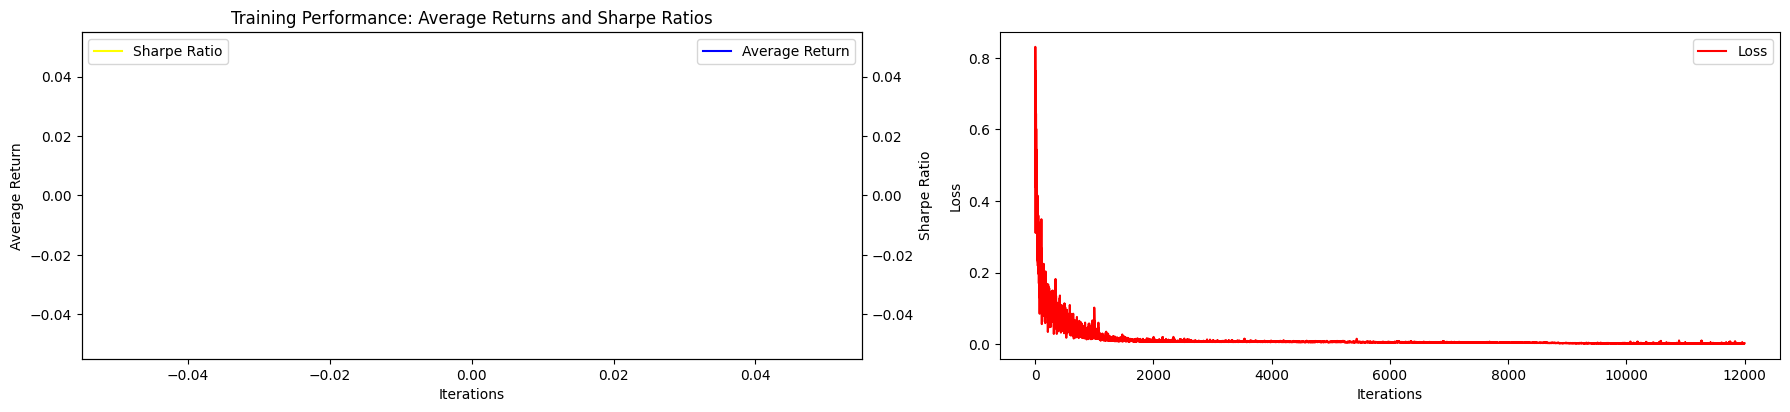

Eval for 25:   0%|          | 0/25 [00:00<?, ?it/s]

Eval for 25:   4%|▍         | 1/25 [00:11<04:32, 11.34s/it]

Eval for 25:   8%|▊         | 2/25 [00:12<02:03,  5.38s/it]

Eval for 25:  12%|█▏        | 3/25 [00:13<01:17,  3.52s/it]

Eval for 25:  16%|█▌        | 4/25 [00:15<00:56,  2.67s/it]

Eval for 25:  20%|██        | 5/25 [00:16<00:42,  2.15s/it]

Eval for 25:  24%|██▍       | 6/25 [00:17<00:34,  1.84s/it]

Eval for 25:  28%|██▊       | 7/25 [00:18<00:29,  1.64s/it]

Eval for 25:  32%|███▏      | 8/25 [00:20<00:26,  1.53s/it]

Eval for 25:  36%|███▌      | 9/25 [00:21<00:23,  1.48s/it]

Eval for 25:  40%|████      | 10/25 [00:22<00:21,  1.40s/it]

Eval for 25:  44%|████▍     | 11/25 [00:24<00:19,  1.36s/it]

Eval for 25:  48%|████▊     | 12/25 [00:25<00:17,  1.32s/it]

Eval for 25:  52%|█████▏    | 13/25 [00:26<00:15,  1.32s/it]

Eval for 25:  56%|█████▌    | 14/25 [00:27<00:14,  1.32s/it]

Eval for 25:  60%|██████    | 15/25 [00:29<00:12,  1.30s/it]

Eval for 25:  64%|██████▍   | 16/25 [00:30<00:11,  1.28s/it]

Eval for 25:  68%|██████▊   | 17/25 [00:31<00:10,  1.26s/it]

Eval for 25:  72%|███████▏  | 18/25 [00:32<00:08,  1.28s/it]

Eval for 25:  76%|███████▌  | 19/25 [00:34<00:07,  1.28s/it]

Eval for 25:  80%|████████  | 20/25 [00:35<00:06,  1.27s/it]

Eval for 25:  84%|████████▍ | 21/25 [00:36<00:05,  1.26s/it]

Eval for 25:  88%|████████▊ | 22/25 [00:37<00:03,  1.25s/it]

Eval for 25:  92%|█████████▏| 23/25 [00:39<00:02,  1.27s/it]

Eval for 25:  96%|█████████▌| 24/25 [00:40<00:01,  1.28s/it]

Eval for 25: 100%|██████████| 25/25 [00:41<00:00,  1.27s/it]

Eval for 25: 100%|██████████| 25/25 [00:41<00:00,  1.67s/it]

In [12]:
try:
  %%time
except:
  pass

# Uncomment if you are training a new policy
def train():
  with strategy.scope():
    loss = sim.train()
    sim.plot_performance(loss)
    sim.eval_metrics(25)
train()



In [13]:
with strategy.scope():
    policy, total_returns, avg_return, sharpe_ratio = sim.load_and_eval_policy(policy_path=MODELS_PATH)
    test_env.get_trade_stats()

Eval for 100:   0%|          | 0/100 [00:00<?, ?it/s]

Eval for 100:   1%|          | 1/100 [00:01<02:45,  1.67s/it]

Eval for 100:   2%|▏         | 2/100 [00:02<02:20,  1.43s/it]

Eval for 100:   3%|▎         | 3/100 [00:04<02:12,  1.36s/it]

Eval for 100:   4%|▍         | 4/100 [00:05<02:05,  1.31s/it]

Eval for 100:   5%|▌         | 5/100 [00:06<02:03,  1.30s/it]

Eval for 100:   6%|▌         | 6/100 [00:08<02:03,  1.31s/it]

Eval for 100:   7%|▋         | 7/100 [00:09<01:59,  1.29s/it]

Eval for 100:   8%|▊         | 8/100 [00:10<01:58,  1.29s/it]

Eval for 100:   9%|▉         | 9/100 [00:11<01:55,  1.27s/it]

Eval for 100:  10%|█         | 10/100 [00:13<01:54,  1.27s/it]

Eval for 100:  11%|█         | 11/100 [00:14<01:52,  1.27s/it]

Eval for 100:  12%|█▏        | 12/100 [00:15<01:51,  1.26s/it]

Eval for 100:  13%|█▎        | 13/100 [00:16<01:49,  1.26s/it]

Eval for 100:  14%|█▍        | 14/100 [00:18<01:49,  1.27s/it]

Eval for 100:  15%|█▌        | 15/100 [00:19<01:49,  1.29s/it]

Eval for 100:  16%|█▌        | 16/100 [00:20<01:47,  1.28s/it]

Eval for 100:  17%|█▋        | 17/100 [00:21<01:45,  1.27s/it]

Eval for 100:  18%|█▊        | 18/100 [00:23<01:43,  1.27s/it]

Eval for 100:  19%|█▉        | 19/100 [00:24<01:44,  1.29s/it]

Eval for 100:  20%|██        | 20/100 [00:25<01:44,  1.30s/it]

Eval for 100:  21%|██        | 21/100 [00:27<01:41,  1.29s/it]

Eval for 100:  22%|██▏       | 22/100 [00:28<01:38,  1.27s/it]

Eval for 100:  23%|██▎       | 23/100 [00:29<01:36,  1.26s/it]

Eval for 100:  24%|██▍       | 24/100 [00:30<01:37,  1.29s/it]

Eval for 100:  25%|██▌       | 25/100 [00:32<01:37,  1.30s/it]

Eval for 100:  26%|██▌       | 26/100 [00:33<01:33,  1.27s/it]

Eval for 100:  27%|██▋       | 27/100 [00:34<01:32,  1.26s/it]

Eval for 100:  28%|██▊       | 28/100 [00:36<01:30,  1.26s/it]

Eval for 100:  29%|██▉       | 29/100 [00:37<01:31,  1.28s/it]

Eval for 100:  30%|███       | 30/100 [00:38<01:31,  1.31s/it]

Eval for 100:  31%|███       | 31/100 [00:39<01:28,  1.29s/it]

Eval for 100:  32%|███▏      | 32/100 [00:41<01:25,  1.26s/it]

Eval for 100:  33%|███▎      | 33/100 [00:42<01:23,  1.25s/it]

Eval for 100:  34%|███▍      | 34/100 [00:43<01:24,  1.27s/it]

Eval for 100:  35%|███▌      | 35/100 [00:44<01:21,  1.26s/it]

Eval for 100:  36%|███▌      | 36/100 [00:46<01:19,  1.24s/it]

Eval for 100:  37%|███▋      | 37/100 [00:47<01:17,  1.23s/it]

Eval for 100:  38%|███▊      | 38/100 [00:48<01:16,  1.24s/it]

Eval for 100:  39%|███▉      | 39/100 [00:49<01:16,  1.26s/it]

Eval for 100:  40%|████      | 40/100 [00:51<01:15,  1.26s/it]

Eval for 100:  41%|████      | 41/100 [00:52<01:13,  1.25s/it]

Eval for 100:  42%|████▏     | 42/100 [00:53<01:11,  1.24s/it]

Eval for 100:  43%|████▎     | 43/100 [00:54<01:10,  1.23s/it]

Eval for 100:  44%|████▍     | 44/100 [00:56<01:10,  1.25s/it]

Eval for 100:  45%|████▌     | 45/100 [00:57<01:08,  1.25s/it]

Eval for 100:  46%|████▌     | 46/100 [00:58<01:06,  1.24s/it]

Eval for 100:  47%|████▋     | 47/100 [00:59<01:05,  1.23s/it]

Eval for 100:  48%|████▊     | 48/100 [01:01<01:04,  1.23s/it]

Eval for 100:  49%|████▉     | 49/100 [01:02<01:03,  1.24s/it]

Eval for 100:  50%|█████     | 50/100 [01:03<01:01,  1.23s/it]

Eval for 100:  51%|█████     | 51/100 [01:04<01:00,  1.23s/it]

Eval for 100:  52%|█████▏    | 52/100 [01:05<00:58,  1.22s/it]

Eval for 100:  53%|█████▎    | 53/100 [01:07<00:57,  1.23s/it]

Eval for 100:  54%|█████▍    | 54/100 [01:08<00:57,  1.24s/it]

Eval for 100:  55%|█████▌    | 55/100 [01:09<00:55,  1.23s/it]

Eval for 100:  56%|█████▌    | 56/100 [01:10<00:53,  1.23s/it]

Eval for 100:  57%|█████▋    | 57/100 [01:12<00:52,  1.21s/it]

Eval for 100:  58%|█████▊    | 58/100 [01:13<00:52,  1.24s/it]

Eval for 100:  59%|█████▉    | 59/100 [01:14<00:50,  1.24s/it]

Eval for 100:  60%|██████    | 60/100 [01:15<00:48,  1.22s/it]

Eval for 100:  61%|██████    | 61/100 [01:17<00:48,  1.23s/it]

Eval for 100:  62%|██████▏   | 62/100 [01:18<00:46,  1.23s/it]

Eval for 100:  63%|██████▎   | 63/100 [01:19<00:46,  1.26s/it]

Eval for 100:  64%|██████▍   | 64/100 [01:20<00:45,  1.26s/it]

Eval for 100:  65%|██████▌   | 65/100 [01:22<00:43,  1.24s/it]

Eval for 100:  66%|██████▌   | 66/100 [01:23<00:41,  1.22s/it]

Eval for 100:  67%|██████▋   | 67/100 [01:24<00:40,  1.22s/it]

Eval for 100:  68%|██████▊   | 68/100 [01:25<00:40,  1.27s/it]

Eval for 100:  69%|██████▉   | 69/100 [01:27<00:38,  1.25s/it]

Eval for 100:  70%|███████   | 70/100 [01:28<00:37,  1.24s/it]

Eval for 100:  71%|███████   | 71/100 [01:29<00:35,  1.23s/it]

Eval for 100:  72%|███████▏  | 72/100 [01:30<00:35,  1.25s/it]

Eval for 100:  73%|███████▎  | 73/100 [01:32<00:34,  1.27s/it]

Eval for 100:  74%|███████▍  | 74/100 [01:33<00:32,  1.25s/it]

Eval for 100:  75%|███████▌  | 75/100 [01:34<00:31,  1.24s/it]

Eval for 100:  76%|███████▌  | 76/100 [01:35<00:29,  1.23s/it]

Eval for 100:  77%|███████▋  | 77/100 [01:36<00:28,  1.25s/it]

Eval for 100:  78%|███████▊  | 78/100 [01:38<00:27,  1.27s/it]

Eval for 100:  79%|███████▉  | 79/100 [01:39<00:26,  1.25s/it]

Eval for 100:  80%|████████  | 80/100 [01:40<00:24,  1.23s/it]

Eval for 100:  81%|████████  | 81/100 [01:41<00:23,  1.22s/it]

Eval for 100:  82%|████████▏ | 82/100 [01:43<00:22,  1.24s/it]

Eval for 100:  83%|████████▎ | 83/100 [01:44<00:21,  1.26s/it]

Eval for 100:  84%|████████▍ | 84/100 [01:45<00:19,  1.24s/it]

Eval for 100:  85%|████████▌ | 85/100 [01:46<00:18,  1.23s/it]

Eval for 100:  86%|████████▌ | 86/100 [01:48<00:17,  1.23s/it]

Eval for 100:  87%|████████▋ | 87/100 [01:49<00:16,  1.25s/it]

Eval for 100:  88%|████████▊ | 88/100 [01:50<00:15,  1.27s/it]

Eval for 100:  89%|████████▉ | 89/100 [01:51<00:13,  1.26s/it]

Eval for 100:  90%|█████████ | 90/100 [01:53<00:12,  1.24s/it]

Eval for 100:  91%|█████████ | 91/100 [01:54<00:11,  1.23s/it]

Eval for 100:  92%|█████████▏| 92/100 [01:55<00:10,  1.26s/it]

Eval for 100:  93%|█████████▎| 93/100 [01:56<00:08,  1.27s/it]

Eval for 100:  94%|█████████▍| 94/100 [01:58<00:07,  1.26s/it]

Eval for 100:  95%|█████████▌| 95/100 [01:59<00:06,  1.25s/it]

Eval for 100:  96%|█████████▌| 96/100 [02:00<00:04,  1.24s/it]

Eval for 100:  97%|█████████▋| 97/100 [02:01<00:03,  1.27s/it]

Eval for 100:  98%|█████████▊| 98/100 [02:03<00:02,  1.26s/it]

Eval for 100:  99%|█████████▉| 99/100 [02:04<00:01,  1.27s/it]

Eval for 100: 100%|██████████| 100/100 [02:05<00:00,  1.26s/it]

Eval for 100: 100%|██████████| 100/100 [02:05<00:00,  1.26s/it]

Average Return = -0.00029046344570815563, Total Return = -0.2729318141937256, Sharpe = -0.010450317524373531


Live actions for 502 iters:   0%|          | 0/501 [00:00<?, ?it/s]

Live actions for 502 iters:   2%|▏         | 9/501 [00:00<00:05, 89.91it/s]

Live actions for 502 iters:   6%|▌         | 31/501 [00:00<00:02, 164.43it/s]

Live actions for 502 iters:  11%|█         | 54/501 [00:00<00:02, 191.75it/s]

Live actions for 502 iters:  15%|█▌        | 76/501 [00:00<00:02, 201.08it/s]

Live actions for 502 iters:  20%|█▉        | 99/501 [00:00<00:01, 209.25it/s]

Live actions for 502 iters:  25%|██▍       | 124/501 [00:00<00:01, 222.26it/s]

Live actions for 502 iters:  30%|██▉       | 149/501 [00:00<00:01, 229.60it/s]

Live actions for 502 iters:  35%|███▍      | 173/501 [00:00<00:01, 232.72it/s]

Live actions for 502 iters:  40%|███▉      | 200/501 [00:00<00:01, 242.46it/s]

Live actions for 502 iters:  45%|████▌     | 227/501 [00:01<00:01, 249.30it/s]

Live actions for 502 iters:  50%|█████     | 253/501 [00:01<00:00, 252.20it/s]

Live actions for 502 iters:  56%|█████▌    | 280/501 [00:01<00:00, 255.64it/s]

Live actions for 502 iters:  61%|██████▏   | 307/501 [00:01<00:00, 257.65it/s]

Live actions for 502 iters:  66%|██████▋   | 333/501 [00:01<00:00, 255.64it/s]

Live actions for 502 iters:  72%|███████▏  | 360/501 [00:01<00:00, 256.88it/s]

Live actions for 502 iters:  77%|███████▋  | 387/501 [00:01<00:00, 258.95it/s]

Live actions for 502 iters:  83%|████████▎ | 414/501 [00:01<00:00, 259.60it/s]

Live actions for 502 iters:  88%|████████▊ | 440/501 [00:01<00:00, 258.05it/s]

Live actions for 502 iters:  93%|█████████▎| 466/501 [00:01<00:00, 258.00it/s]

Live actions for 502 iters:  98%|█████████▊| 492/501 [00:02<00:00, 257.92it/s]

Live actions for 502 iters: 100%|██████████| 501/501 [00:02<00:00, 241.36it/s]

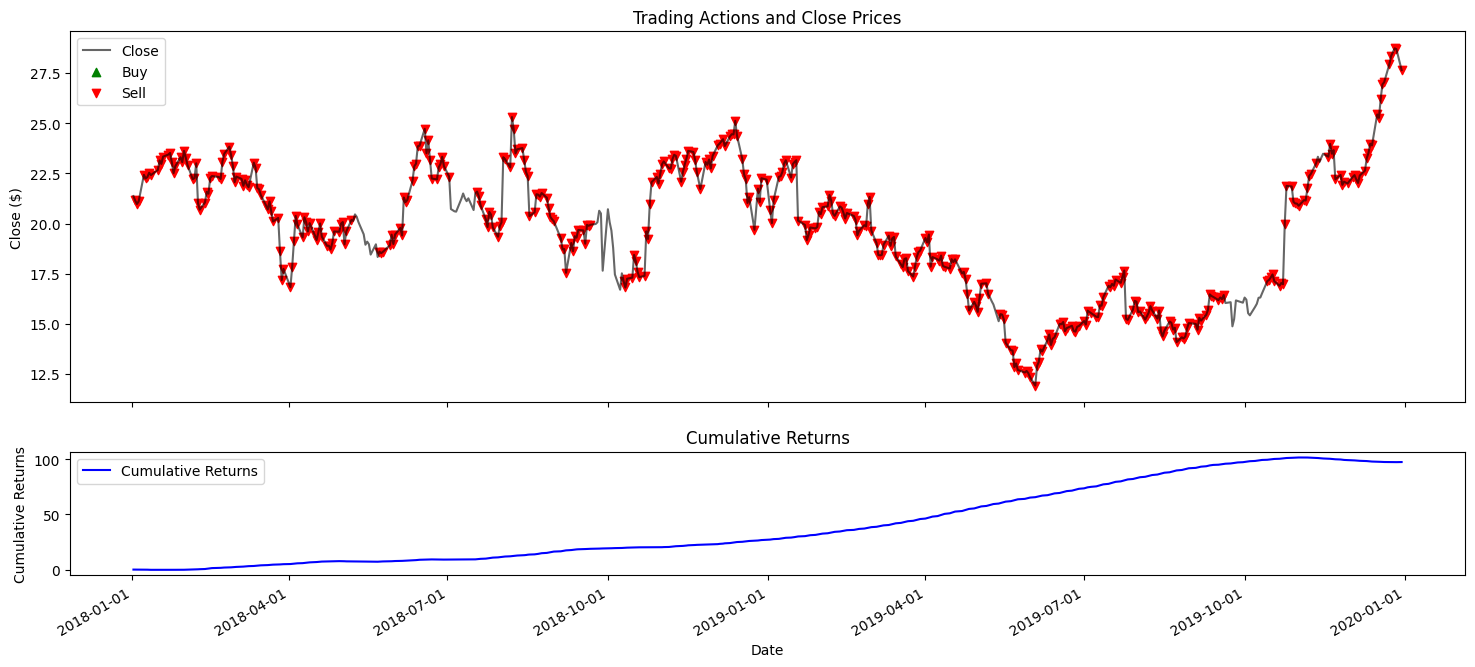

In [14]:
sim.plot_returns_and_actions()

# Conclusion

In this article we have adapted Deep Q-Network (TDQN) algorithm from *Théate, Thibaut and Ernst, Damien (2021)*, using our signals and Tensorflow's Agent framework. Our agent can now determine optimal trading positions (buy, sell, or hold) to maximize our portfolio returns in a simulated environment.

## References

- [A Random Walk Down Wall Street](https://www.amazon.co.uk/Random-Walk-Down-Wall-Street/dp/0393330338)
- [TensorFlow Agents](https://www.tensorflow.org/agents/overview)
- [Open Gym AI Github](https://github.com/openai/gym)
- [Greg et al, OpenAI Gym, (2016)](https://arxiv.org/abs/1606.01540)
- [Théate, Thibaut, and Damien Ernst. "An application of deep reinforcement learning to algorithmic trading." Expert Systems with Applications 173 (2021): 114632.](https://www.sciencedirect.com/science/article/pii/S0957417421000737)
- [Remote development in WSL](https://code.visualstudio.com/docs/remote/wsl-tutorial)
- [NVIDIA Driver Downloads](https://www.nvidia.com/Download/index.aspx)
- [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit-archive)
- [TensorRT for CUDA](https://docs.nvidia.com/deeplearning/tensorrt/archives/index.html#trt_7)
- [Momentum and Reversion Trading Signals Analysis](https://medium.com/call-for-atlas/momentum-and-reversion-the-poor-mans-trading-strategies-9b8e1e6d3496)
- [Temporal Convolutional Neural Network with Conditioning for Broad Market Signals](https://medium.com/call-for-atlas/temporal-convolutional-neural-network-with-conditioning-for-broad-market-signals-9f0b0426b2b9)
- [Pandas TA - A Technical Analysis Library in Python 3](https://github.com/twopirllc/pandas-ta)

## Github

Article here is also available on [Github](https://github.com/adamd1985/pairs_trading_unsupervised_learning)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/deep-q-rl-with-algorithmic-trading-policy)

Google Collab available [here](https://colab.research.google.com/drive/1FTj65b2DA8oFgvmmjLc0XIwtII32PwcM?usp=sharing)

## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.